# OpFlow codomain 2D TGRF data experiment

In [1]:
from __future__ import division

from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
import torch
import torch.fft
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import pylab as plt
import statsmodels.api as sm
#from random_fields import *

import timeit

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

## Dataset

In [3]:
def truncatedGRF(ndim, length_scale_x, nu_x, ntrain, lb=-4, ub=4, nchannel=2):
    # temp_x_train = [ndim*ndim, ntrain, nchannel=1]
    ntrain = int(ntrain*nchannel)
    
    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds=(1e-1, 10.0), nu=nu_x)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    #y_mean, y_std = gpr_model.predict(X, return_std=True)

    x_train = []
    samples = 0
    
    while samples < ntrain:
        temp_x_train = torch.Tensor(gpr_model.sample_y(X, ntrain, random_state=None)[:,:,np.newaxis])
        # 
        logic_value = (temp_x_train <= ub) & (temp_x_train >= lb)
        pass_id = torch.all(logic_value, axis=0)
        
        n_generated = temp_x_train[:,pass_id].shape[1]
        if n_generated > 0:
            samples += n_generated
            
            x_train.append(temp_x_train[:, pass_id])
            print("finished {}/{} ".format(samples, ntrain))
    
    x_train = torch.cat(x_train, dim=1)
    x_train = x_train[:,:ntrain]
    if nchannel == 2:
        return torch.cat([x_train[:, :ntrain//2, None], x_train[:, ntrain//2:, None]], dim=-1)
    else:
        return x_train[:,:,None]

In [4]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

def GaussianProcess_2C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel = 1):
    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim*ndim, n_samples, nchannel]).shape)
        
    if return_kernel:
        return torch.tensor(y_samples), kernel(X), gpr_model
    else:
        return torch.tensor(y_samples)
    
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means


In [5]:
def autocovariance_2d(data):
    """
    Calculate the auto-covariance of a 2D dataset using FFT.

    Parameters:
    data (torch.Tensor): A 3D tensor of shape (N, m, m) where N is the number of samples and
                         each sample is an m by m matrix.

    Returns:
    torch.Tensor: Auto-covariance matrix of the 2D dataset.
    """
    N, m, _ = data.shape
    
    # Demean the data
    data_demeaned = data - data.mean(dim=(1, 2), keepdim=True)
    
    # Apply FFT to each 2D sample
    fft_data = torch.fft.fft2(data_demeaned)
    
    # Use the Wiener-Khinchin theorem: the auto-covariance can be obtained by the inverse FFT of the power spectrum
    power_spectrum = fft_data * torch.conj(fft_data)
    autocov = torch.fft.ifft2(power_spectrum).real
    
    # Normalize by the number of samples to get the average auto-covariance
    autocov /= N
    
    # Since the result includes autocovariance at different lags, we take the autocovariance at lag 0
    # which is located at the center of the matrix
    autocov_at_lag0 = autocov[:, m//2, m//2]
    
    return autocov_at_lag0

Auto-covariance matrix calculated using FFT:
tensor([-0.1180,  0.1998, -0.3714, -0.2402,  0.0571, -0.0408,  0.2598, -0.0062,
        -1.0658, -0.4894])


### dataset parameters and preparation

In [6]:
ntrain = 12000
nchannel = 2
ndim = 64
batch_size = 128

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.2
nu_z = 1.5

lb = -2
ub = 2

Starting up. Generate GRF samples
(4096, 2)
finished 11544/24000 
finished 23116/24000 
finished 34645/24000 
(4096, 2)


/home/yshi5/miniconda3/envs/OpFlow/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


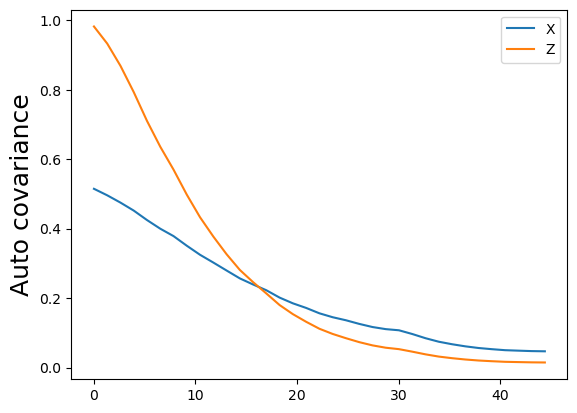

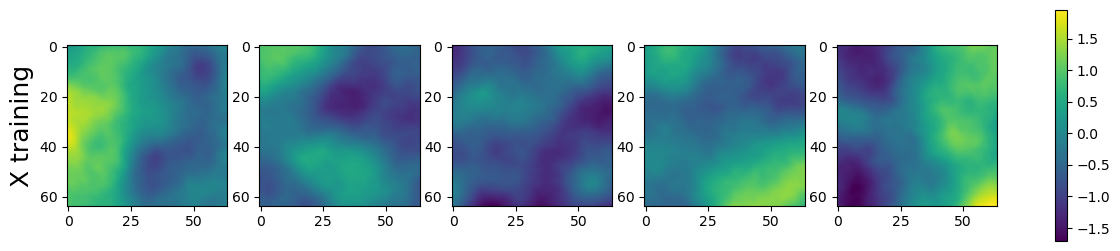

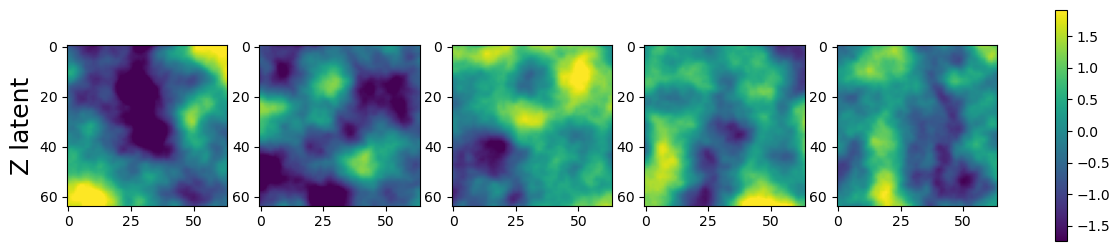

In [7]:
print("Starting up. Generate GRF samples")
import statsmodels.api as sm

np.random.seed(22)

#x_train = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = truncatedGRF(ndim, length_scale_x, nu_x, ntrain, lb=lb, ub=ub, nchannel=nchannel)
x_train = x_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the autocov 
z_train, kernel, z_gpmodel = GaussianProcess_2C(ndim, length_scale_z, nu_z, 2*ntrain, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:,:,:,0])
z_distance, z_acovf_mean = compute_acovf(z_train[:,:,:,0])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.plot(z_distance, z_acovf_mean, label='Z')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,:,:,0].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,3))    
for i in range(5):
    z = z_train[i,:,:,0].squeeze()
    ax[i].imshow(z, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('Z latent', fontsize=18)
              
bar = ax[4].imshow(z)
fig.colorbar(bar, ax=ax)

## Model

In [8]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dim1, dim2,modes1 = None, modes2 = None):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dim1 = dim1 #output dimensions
        self.dim2 = dim2
        if modes1 is not None:
            self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
            self.modes2 = modes2
        else:
            self.modes1 = dim1//2-1 #if not given take the highest number of modes can be taken
            self.modes2 = dim2//2 
        self.scale = (1 / (2*in_channels))**(1.0/2.0)
        self.weights1 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))
        self.weights2 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x, dim1 = None,dim2 = None):
        if dim1 is not None:
            self.dim1 = dim1
            self.dim2 = dim2
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft)
        #x = torch.fft.irfft2(out_ft, s=(self.dim1, self.dim2))
        return x

class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel,dim1, dim2):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv2d(int(in_channel), int(out_channel), 1)
        self.dim1 = int(dim1)
        self.dim2 = int(dim2)

    def forward(self,x, dim1 = None, dim2 = None):
        if dim1 is None:
            dim1 = self.dim1
            dim2 = self.dim2
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [9]:
class FNO2d(nn.Module):
    def __init__(self, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        #self.modes1 = modes1
        #self.modes2 = modes2
        self.width = width
        self.padding = 0 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        
        self.conv0 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv1 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.conv2 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv3 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.w0 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w1 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w2 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w3 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        res1 = x.shape[1]
        res2 = x.shape[2]
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        
        #print("FNO x shape:{}".format(x.shape))
        x_fc0 = self.fc0(x)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        #x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        x1 = self.conv0(x_fc0)
        x2 = self.w0(x_fc0)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        x = x.permute(0, 2, 3, 1)

        x_fc1 = self.fc1(x)
        x_fc1 = F.gelu(x_fc1)

        x_out = self.fc2(x_fc1)

        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [10]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)
            std = input.std(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim1, ndim2, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim1 * ndim2 * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [11]:
class AffineCoupling(nn.Module):
    def __init__(self, width):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.width = width
        self.coupling = FNO2d(width)
        #self.coupling = UNO_2D(3, width=width)
        self.actnorm = ActNorm(2)

    def forward(self, z, flip=False):
        x = z
        #print("x shape:{}", x.shape)
        x, log_actnorm = self.actnorm(x)
        
        n_rep = x.shape[-1] // 2
        mask_a = torch.ones(x.shape, device=x.device)
        mask_a[:,:,:,0:n_rep] = 0

        mask_b = torch.logical_not(mask_a)
        x1 = x[:,:,:,0:1]
        x2 = x[:,:,:,1:2]
                        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b

        # forward
        #print("x1 shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift forward:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,:,0:1]
        assert(scale_shift.shape == torch.zeros([x.shape[0], x.shape[1], x.shape[2], 2]).shape)
        
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,:,1:2]
        z1 = x1
        z2 = x2 * scale + shift

        if flip:
            z_hat = torch.cat([z2, z1], dim=-1)
        else:
            z_hat = torch.cat([z1, z2], dim=-1)
            

        log_det = log_scale.sum()
        log_det = log_det + log_actnorm

        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[-1] // 2
        mask_a = torch.ones(z.shape, device=z.device)
        mask_a[:,:,:,0:n_rep] = 0
        mask_b = torch.logical_not(mask_a)
        z1 = z[:,:,:,0:1]
        z2 = z[:,:,:,1:2]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        
        #print("z1 shape:{}".format(z1.shape))
        scale_shift = self.coupling(z1)
        
        #print("scale shift shape:{}".format(scale_shift.shape))
        # print("scaleshift inv", scale_shift.shape)
        assert(scale_shift.shape == torch.zeros([z.shape[0], z.shape[1], z.shape[2], 2]).shape)
        log_scale = scale_shift[:,:,:,0:1]
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,:,1:2]
        x2 = (z2 - shift) * scale
            
        if flip:
            x_hat = torch.cat([x2, x1], dim=-1)
        else:
            x_hat = torch.cat([x1, x2], dim=-1)  
        x_hat = self.actnorm.inverse(x_hat)

        return x_hat

In [12]:
class OpFlow(nn.Module):
    def __init__(self, width, blocks, base_dist, pool_every=2, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]
        block_dims = []

        self.bijectors = nn.ModuleList([
            AffineCoupling( width=width) for i in range(blocks)
        ])
        #self.mapping_z = FNO2d(modes, modes, width)
        
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size, ndim = x.shape[0], x.shape[1]
        log_dets = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = 0
        for i in range(x.shape[-1]):
            # print(z.squeeze()[:, :, i].shape)
            log_pz += self.base_dist.log_prob(z[:, :, :, i].reshape(x.shape[0], -1)).sum()
        # print("donew ith forward")
        
        return z, log_pz/batch_size, sum(log_dets)/batch_size
        
    def inverse(self, z):
        
        ndim = z.shape[1]

        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [13]:
lr = 5*1e-5
epochs = 400
reg_fac = 1

n_train_tot = int(ntrain/batch_size)

#width = 32
width = 64
blocks = 8

base_mu = torch.zeros(ndim*ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

In [14]:
G = OpFlow(width=width, blocks=blocks, base_dist=base_dist).to(device)

#D = DDP(D, device_ids=device_ids, output_device=0) #data parallel
#G = DDP(D, device_ids=device_ids, output_device=0)

nn_params = sum(p.numel() for p in G.parameters() if p.requires_grad)
print("Number generator parameters: ", nn_params)

Number generator parameters:  67312688


In [15]:
G_optim = torch.optim.Adam(G.parameters(), lr=lr , weight_decay=1e-4)
#G_scheduler = torch.optim.lr_scheduler.StepLR(G_optim, step_size=200, gamma=0.2)

G.train()

OpFlow(
  (bijectors): ModuleList(
    (0): AffineCoupling(
      (coupling): FNO2d(
        (fc0): Linear(in_features=3, out_features=64, bias=True)
        (conv0): SpectralConv2d()
        (conv1): SpectralConv2d()
        (conv2): SpectralConv2d()
        (conv3): SpectralConv2d()
        (w0): pointwise_op(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (w1): pointwise_op(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (w2): pointwise_op(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (w3): pointwise_op(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (fc1): Linear(in_features=64, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=2, bias=True)
      )
      (actnorm): ActNorm()
    )
    (1): AffineCoupling(
      (coupling): FNO2d(
        (fc0): Linear(in_features=3, out_features=64, bias=True)
 

# Model Training

In [16]:
def inject_noise(x, z, factor=0.001):
    # default factor is 0.001
    # usually, use should use small factor of noise
    # get noise from z
    tot = len(z)
    ib = np.random.choice(tot, size=x.shape[0], replace=True)
    x = x + factor * z[ib]
    return x


def get_x_batch(batch_size=batch_size, x_train=x_train):
    tot = len(x_train)
    ib = np.random.choice(tot, size=batch_size, replace=False)
    ib.sort()
    #print(ib)
    x = x_train[ib]
    x_noisy = inject_noise(x, z_train)
    return x_noisy

In [17]:
def is_psd(mat):
    return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())


def matrix_sqrt(matrix):
    """Compute the square root of a positive definite matrix."""
    _, s, v = matrix.svd()
    good = s > s.max(-1, True).values * s.size(-1) * torch.finfo(s.dtype).eps
    components = good.sum(-1)
    common = components.max()
    unbalanced = common != components.min()
    if common < s.size(-1):
        s = s[..., :common]
        v = v[..., :common]
        if unbalanced:
            good = good[..., :common]
    if unbalanced:
        s = s.where(good, torch.zeros((), device=s.device, dtype=s.dtype))
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)


def cal_F2ID(z_all, base_mu, base_cov):
    """
    z : [n, ndim, 2*ndim, 1]
    base_mu : [2*ndim*ndim]
    base_cov : [2*ndim*ndim, 2*ndim*ndim]
    """
    F2ID_all = 0
    for i in range(2):
        z = z_all[:,:,:,i]
        ndim = z.shape[1]
        syn_mu = z.mean(dim=0).reshape(ndim*ndim)
        syn_cov = torch.cov(z.reshape(-1, ndim*ndim).permute(1,0))

        """
        #print("syn_mu shape: {}, syn_cov shape : {}".format(syn_mu.shape, syn_cov.shape))

        if base_cov_sqrt is None:
            base_cov_sqrt = matrix_sqrt(base_cov).detach()

        #print("device of syn_cov :{}, base_cov:{}, syn_cov :{}, base_cov_sqrt:{}".format(syn_cov.device, base_cov.device, syn_cov.device, base_cov_sqrt.device))
        #L = syn_cov + base_cov - 2 * matrix_sqrt(base_cov_sqrt @ syn_cov @ base_cov_sqrt).cuda()
        #term1 = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim)
        #term2 = torch.trace(L)/(ndim*ndim)
        #F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim) + torch.trace(L)/(ndim*ndim)    
        """

        F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim) + torch.sum((syn_cov -base_cov)**2)/(ndim*ndim)
        if i == 0:
            term1 = F2ID
        if i == 1:
            term2 = F2ID
        F2ID_all += F2ID
        #print('term1 : {}, term2 :{}'.format(term1, term2))
    return F2ID_all, term1, term2

In [18]:
def train_opflow(G, G_optim, epochs, base_mu, base_cov, scheduler=None, fine_tune_epoch=50):
    base_mu = base_mu.to(device)
    base_cov = base_cov.to(device)
    
    epochs = epochs+fine_tune_epoch
    # record the loss information
    losses_G = np.zeros(epochs)

    for epoch in range(epochs):

        loss_G = 0.0
        # fine tune phase
        if epoch == (epochs-fine_tune_epoch):
            # smaller learning rate for fine tune
            G_optim.param_groups[0]['lr'] = G_optim.param_groups[0]['lr'] * 0.1
            
        for j in range(n_train_tot):
           
            G_optim.zero_grad()
            x = get_x_batch().to(device)
            z_syn, log_pz, log_det = G(x)            
    
            ll_loss = (-log_pz - log_det).mean()
           
            # training phase
            if (epoch >= 0) and (epoch <= (epochs-fine_tune_epoch)):
                F2ID_loss, term1, term2 = cal_F2ID(z_syn, base_mu, base_cov)
                loss = ll_loss + reg_fac*F2ID_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.2f}, loss_F2ID:{:.2f}, loss_F2ID term1:{:.2f}, loss_F2ID term2:{:.2f}".format(epoch, epochs, j, n_train_tot, loss.item(), F2ID_loss.item(), term1.item(), term2.item()))
            
            elif (epoch >= (epochs-fine_tune_epoch)):
                loss = ll_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.4f} ".format(epoch, epochs, j, n_train_tot, loss.item()))
            
            #loss = -torch.mean(D(x_syn))
            loss.backward()
            loss_G += loss.item()

            G_optim.step()
                     
        with torch.no_grad():
            nplot = 5
            
            fig, ax = plt.subplots(2,nplot, figsize=(15,6))
            Z_alt = torch.cat([base_dist.rsample(sample_shape=(256,)).reshape(-1, ndim, ndim, 1), 
                               base_dist.rsample(sample_shape=(256,)).reshape(-1, ndim, ndim, 1)], axis=-1)           
            
            X_alt = G.inverse(Z_alt)
            X_alt = X_alt.detach().cpu()
            lags, acf1 = compute_acovf(X_alt[:,:,:,0])
            lags, acf2 = compute_acovf(X_alt[:,:,:,1]) 
            
            for i in range(nplot-1):
                bar = ax[0,i].imshow(X_alt[i,:,:,0], vmin=-2, vmax=2)
                plt.colorbar(bar, ax=ax[0,i])

                bar = ax[1,i].imshow(X_alt[i,:,:,1], vmin=-2, vmax=2)
                plt.colorbar(bar, ax=ax[1,i])
            ax[0,nplot-1].plot(x_distance, x_acovf_mean, color='k', label='Ground Truth')
            ax[0,nplot-1].plot(lags, acf1, color='r', label='Synthetic channel_0')
            ax[0,nplot-1].legend(loc='upper right')      
            
            ax[1,nplot-1].plot(x_distance, x_acovf_mean, color='k', label='Ground Truth')
            ax[1,nplot-1].plot(lags, acf2, color='r', label='Synthetic channel_1')
            ax[1,nplot-1].legend(loc='upper right')  
            
            plt.savefig("paper_plots/{}/2D_codomain_{}_set1.pdf".format(folder, epoch))
            plt.close()
            
            
            
        losses_G[epoch] = loss_G / batch_size
        losses_G_val[epoch] = loss_G_val / batch_size
        losses_W[epoch] = loss_W / batch_size
        
        #D_scheduler.step()
        #G_scheduler.step()
        if ((epoch+1)%100 == 0) | ((epoch+1)==epochs):
            torch.save({
                        'model_state_dict': G.state_dict(),
                        }, "paper_saved_models/{}/2D_codomain_{}_set1.pt".format(folder, epoch))
        
    return losses_G

In [19]:
folder = "GRF2TruncatedGRF_FNO_codomain_64x64_set1"
if not os.path.exists(f"paper_saved_models/{folder}"):
    os.makedirs(f"paper_saved_models/{folder}")
if not os.path.exists(f"paper_plots/{folder}"):
    os.makedirs(f"paper_plots/{folder}")

In [21]:
start = timeit.default_timer() # track the time for training
losses_G = train_opflow(G, G_optim, epochs, base_mu, base_cov)
stop = timeit.default_timer() 

epoch:[0 / 450] batch:[0 / 93],loss_G:-21413.58, loss_F2ID:358.52, loss_F2ID term1:186.24, loss_F2ID term2:172.28
epoch:[0 / 450] batch:[1 / 93],loss_G:-21512.88, loss_F2ID:290.82, loss_F2ID term1:159.60, loss_F2ID term2:131.22
epoch:[0 / 450] batch:[2 / 93],loss_G:-21485.22, loss_F2ID:349.00, loss_F2ID term1:175.28, loss_F2ID term2:173.71
epoch:[0 / 450] batch:[3 / 93],loss_G:-21433.02, loss_F2ID:433.38, loss_F2ID term1:169.95, loss_F2ID term2:263.44
epoch:[0 / 450] batch:[4 / 93],loss_G:-21298.89, loss_F2ID:596.47, loss_F2ID term1:256.28, loss_F2ID term2:340.19
epoch:[0 / 450] batch:[5 / 93],loss_G:-21442.34, loss_F2ID:484.15, loss_F2ID term1:190.89, loss_F2ID term2:293.26
epoch:[0 / 450] batch:[6 / 93],loss_G:-21557.57, loss_F2ID:400.85, loss_F2ID term1:275.09, loss_F2ID term2:125.76
epoch:[0 / 450] batch:[7 / 93],loss_G:-21557.47, loss_F2ID:429.79, loss_F2ID term1:115.05, loss_F2ID term2:314.74
epoch:[0 / 450] batch:[8 / 93],loss_G:-21660.22, loss_F2ID:357.00, loss_F2ID term1:215.7

epoch:[0 / 450] batch:[72 / 93],loss_G:-21243.22, loss_F2ID:1722.26, loss_F2ID term1:1114.49, loss_F2ID term2:607.77
epoch:[0 / 450] batch:[73 / 93],loss_G:-21839.04, loss_F2ID:1116.38, loss_F2ID term1:695.33, loss_F2ID term2:421.05
epoch:[0 / 450] batch:[74 / 93],loss_G:-22025.03, loss_F2ID:923.65, loss_F2ID term1:527.33, loss_F2ID term2:396.31
epoch:[0 / 450] batch:[75 / 93],loss_G:-21584.56, loss_F2ID:1356.54, loss_F2ID term1:619.69, loss_F2ID term2:736.86
epoch:[0 / 450] batch:[76 / 93],loss_G:-21671.01, loss_F2ID:1261.18, loss_F2ID term1:593.23, loss_F2ID term2:667.95
epoch:[0 / 450] batch:[77 / 93],loss_G:-21873.52, loss_F2ID:1049.60, loss_F2ID term1:487.99, loss_F2ID term2:561.62
epoch:[0 / 450] batch:[78 / 93],loss_G:-22023.76, loss_F2ID:890.44, loss_F2ID term1:542.14, loss_F2ID term2:348.30
epoch:[0 / 450] batch:[79 / 93],loss_G:-21787.53, loss_F2ID:1120.20, loss_F2ID term1:631.34, loss_F2ID term2:488.85
epoch:[0 / 450] batch:[80 / 93],loss_G:-22030.31, loss_F2ID:873.65, loss_

epoch:[1 / 450] batch:[50 / 93],loss_G:-21777.30, loss_F2ID:1094.72, loss_F2ID term1:482.72, loss_F2ID term2:612.00
epoch:[1 / 450] batch:[51 / 93],loss_G:-21827.26, loss_F2ID:1041.99, loss_F2ID term1:435.50, loss_F2ID term2:606.48
epoch:[1 / 450] batch:[52 / 93],loss_G:-21835.30, loss_F2ID:1034.62, loss_F2ID term1:531.08, loss_F2ID term2:503.54
epoch:[1 / 450] batch:[53 / 93],loss_G:-21539.59, loss_F2ID:1328.79, loss_F2ID term1:762.00, loss_F2ID term2:566.78
epoch:[1 / 450] batch:[54 / 93],loss_G:-22142.56, loss_F2ID:723.86, loss_F2ID term1:357.67, loss_F2ID term2:366.19
epoch:[1 / 450] batch:[55 / 93],loss_G:-21706.78, loss_F2ID:1161.21, loss_F2ID term1:505.79, loss_F2ID term2:655.42
epoch:[1 / 450] batch:[56 / 93],loss_G:-21803.95, loss_F2ID:1067.05, loss_F2ID term1:416.10, loss_F2ID term2:650.95
epoch:[1 / 450] batch:[57 / 93],loss_G:-21927.43, loss_F2ID:941.01, loss_F2ID term1:600.28, loss_F2ID term2:340.73
epoch:[1 / 450] batch:[58 / 93],loss_G:-21815.68, loss_F2ID:1056.04, loss_

epoch:[2 / 450] batch:[28 / 93],loss_G:-21802.35, loss_F2ID:1073.08, loss_F2ID term1:549.37, loss_F2ID term2:523.70
epoch:[2 / 450] batch:[29 / 93],loss_G:-21779.49, loss_F2ID:1098.38, loss_F2ID term1:502.89, loss_F2ID term2:595.48
epoch:[2 / 450] batch:[30 / 93],loss_G:-21874.41, loss_F2ID:1003.00, loss_F2ID term1:618.27, loss_F2ID term2:384.72
epoch:[2 / 450] batch:[31 / 93],loss_G:-21745.93, loss_F2ID:1133.61, loss_F2ID term1:474.43, loss_F2ID term2:659.18
epoch:[2 / 450] batch:[32 / 93],loss_G:-22042.65, loss_F2ID:835.17, loss_F2ID term1:358.37, loss_F2ID term2:476.81
epoch:[2 / 450] batch:[33 / 93],loss_G:-21801.65, loss_F2ID:1080.81, loss_F2ID term1:584.92, loss_F2ID term2:495.88
epoch:[2 / 450] batch:[34 / 93],loss_G:-21356.47, loss_F2ID:1527.93, loss_F2ID term1:776.87, loss_F2ID term2:751.06
epoch:[2 / 450] batch:[35 / 93],loss_G:-21949.41, loss_F2ID:934.96, loss_F2ID term1:491.51, loss_F2ID term2:443.45
epoch:[2 / 450] batch:[36 / 93],loss_G:-21916.91, loss_F2ID:966.27, loss_F

epoch:[3 / 450] batch:[6 / 93],loss_G:-21919.13, loss_F2ID:911.99, loss_F2ID term1:410.98, loss_F2ID term2:501.01
epoch:[3 / 450] batch:[7 / 93],loss_G:-22016.32, loss_F2ID:814.02, loss_F2ID term1:362.32, loss_F2ID term2:451.70
epoch:[3 / 450] batch:[8 / 93],loss_G:-22124.70, loss_F2ID:705.33, loss_F2ID term1:295.92, loss_F2ID term2:409.41
epoch:[3 / 450] batch:[9 / 93],loss_G:-21950.96, loss_F2ID:883.60, loss_F2ID term1:334.34, loss_F2ID term2:549.26
epoch:[3 / 450] batch:[10 / 93],loss_G:-21706.71, loss_F2ID:1134.14, loss_F2ID term1:491.26, loss_F2ID term2:642.87
epoch:[3 / 450] batch:[11 / 93],loss_G:-21648.81, loss_F2ID:1193.84, loss_F2ID term1:793.30, loss_F2ID term2:400.54
epoch:[3 / 450] batch:[12 / 93],loss_G:-21847.25, loss_F2ID:1000.82, loss_F2ID term1:389.03, loss_F2ID term2:611.79
epoch:[3 / 450] batch:[13 / 93],loss_G:-21826.65, loss_F2ID:1023.85, loss_F2ID term1:441.91, loss_F2ID term2:581.93
epoch:[3 / 450] batch:[14 / 93],loss_G:-21679.73, loss_F2ID:1175.34, loss_F2ID t

epoch:[3 / 450] batch:[77 / 93],loss_G:-21658.61, loss_F2ID:1290.05, loss_F2ID term1:767.10, loss_F2ID term2:522.95
epoch:[3 / 450] batch:[78 / 93],loss_G:-21895.68, loss_F2ID:1049.55, loss_F2ID term1:383.95, loss_F2ID term2:665.60
epoch:[3 / 450] batch:[79 / 93],loss_G:-21624.77, loss_F2ID:1318.05, loss_F2ID term1:524.41, loss_F2ID term2:793.64
epoch:[3 / 450] batch:[80 / 93],loss_G:-21736.00, loss_F2ID:1202.63, loss_F2ID term1:696.70, loss_F2ID term2:505.93
epoch:[3 / 450] batch:[81 / 93],loss_G:-21550.95, loss_F2ID:1383.98, loss_F2ID term1:713.25, loss_F2ID term2:670.73
epoch:[3 / 450] batch:[82 / 93],loss_G:-21779.48, loss_F2ID:1145.39, loss_F2ID term1:641.46, loss_F2ID term2:503.93
epoch:[3 / 450] batch:[83 / 93],loss_G:-21681.91, loss_F2ID:1234.56, loss_F2ID term1:616.79, loss_F2ID term2:617.77
epoch:[3 / 450] batch:[84 / 93],loss_G:-21842.07, loss_F2ID:1063.08, loss_F2ID term1:476.45, loss_F2ID term2:586.63
epoch:[3 / 450] batch:[85 / 93],loss_G:-21933.33, loss_F2ID:965.94, loss

epoch:[4 / 450] batch:[55 / 93],loss_G:-22082.08, loss_F2ID:831.85, loss_F2ID term1:460.67, loss_F2ID term2:371.18
epoch:[4 / 450] batch:[56 / 93],loss_G:-21888.92, loss_F2ID:1020.79, loss_F2ID term1:495.55, loss_F2ID term2:525.24
epoch:[4 / 450] batch:[57 / 93],loss_G:-21751.47, loss_F2ID:1153.31, loss_F2ID term1:438.22, loss_F2ID term2:715.09
epoch:[4 / 450] batch:[58 / 93],loss_G:-21899.59, loss_F2ID:999.50, loss_F2ID term1:436.73, loss_F2ID term2:562.78
epoch:[4 / 450] batch:[59 / 93],loss_G:-21636.26, loss_F2ID:1258.76, loss_F2ID term1:559.12, loss_F2ID term2:699.63
epoch:[4 / 450] batch:[60 / 93],loss_G:-21882.75, loss_F2ID:1008.91, loss_F2ID term1:623.44, loss_F2ID term2:385.47
epoch:[4 / 450] batch:[61 / 93],loss_G:-22039.61, loss_F2ID:848.25, loss_F2ID term1:527.27, loss_F2ID term2:320.98
epoch:[4 / 450] batch:[62 / 93],loss_G:-21710.26, loss_F2ID:1178.24, loss_F2ID term1:422.17, loss_F2ID term2:756.08
epoch:[4 / 450] batch:[63 / 93],loss_G:-21972.25, loss_F2ID:913.15, loss_F2

epoch:[5 / 450] batch:[33 / 93],loss_G:-21728.30, loss_F2ID:1164.69, loss_F2ID term1:393.80, loss_F2ID term2:770.89
epoch:[5 / 450] batch:[34 / 93],loss_G:-21792.09, loss_F2ID:1091.75, loss_F2ID term1:540.86, loss_F2ID term2:550.89
epoch:[5 / 450] batch:[35 / 93],loss_G:-22050.71, loss_F2ID:826.38, loss_F2ID term1:492.94, loss_F2ID term2:333.44
epoch:[5 / 450] batch:[36 / 93],loss_G:-21835.14, loss_F2ID:1039.37, loss_F2ID term1:595.84, loss_F2ID term2:443.53
epoch:[5 / 450] batch:[37 / 93],loss_G:-21915.12, loss_F2ID:956.17, loss_F2ID term1:480.04, loss_F2ID term2:476.13
epoch:[5 / 450] batch:[38 / 93],loss_G:-21910.11, loss_F2ID:962.32, loss_F2ID term1:462.13, loss_F2ID term2:500.19
epoch:[5 / 450] batch:[39 / 93],loss_G:-21937.11, loss_F2ID:933.52, loss_F2ID term1:396.00, loss_F2ID term2:537.52
epoch:[5 / 450] batch:[40 / 93],loss_G:-21764.20, loss_F2ID:1109.27, loss_F2ID term1:660.29, loss_F2ID term2:448.97
epoch:[5 / 450] batch:[41 / 93],loss_G:-22032.67, loss_F2ID:842.84, loss_F2I

epoch:[6 / 450] batch:[11 / 93],loss_G:-21954.98, loss_F2ID:925.86, loss_F2ID term1:517.80, loss_F2ID term2:408.06
epoch:[6 / 450] batch:[12 / 93],loss_G:-21908.82, loss_F2ID:972.93, loss_F2ID term1:331.18, loss_F2ID term2:641.75
epoch:[6 / 450] batch:[13 / 93],loss_G:-21723.12, loss_F2ID:1161.06, loss_F2ID term1:748.83, loss_F2ID term2:412.23
epoch:[6 / 450] batch:[14 / 93],loss_G:-21939.15, loss_F2ID:946.73, loss_F2ID term1:419.71, loss_F2ID term2:527.02
epoch:[6 / 450] batch:[15 / 93],loss_G:-21881.00, loss_F2ID:1005.09, loss_F2ID term1:398.18, loss_F2ID term2:606.90
epoch:[6 / 450] batch:[16 / 93],loss_G:-21628.91, loss_F2ID:1261.43, loss_F2ID term1:732.61, loss_F2ID term2:528.82
epoch:[6 / 450] batch:[17 / 93],loss_G:-22250.50, loss_F2ID:640.77, loss_F2ID term1:269.24, loss_F2ID term2:371.53
epoch:[6 / 450] batch:[18 / 93],loss_G:-21657.56, loss_F2ID:1241.25, loss_F2ID term1:708.79, loss_F2ID term2:532.46
epoch:[6 / 450] batch:[19 / 93],loss_G:-21356.83, loss_F2ID:1542.56, loss_F2

epoch:[6 / 450] batch:[82 / 93],loss_G:-21627.46, loss_F2ID:1331.49, loss_F2ID term1:544.75, loss_F2ID term2:786.74
epoch:[6 / 450] batch:[83 / 93],loss_G:-21847.98, loss_F2ID:1106.47, loss_F2ID term1:573.89, loss_F2ID term2:532.58
epoch:[6 / 450] batch:[84 / 93],loss_G:-21599.53, loss_F2ID:1352.89, loss_F2ID term1:571.73, loss_F2ID term2:781.15
epoch:[6 / 450] batch:[85 / 93],loss_G:-22213.69, loss_F2ID:736.05, loss_F2ID term1:396.30, loss_F2ID term2:339.75
epoch:[6 / 450] batch:[86 / 93],loss_G:-21780.35, loss_F2ID:1167.86, loss_F2ID term1:629.13, loss_F2ID term2:538.73
epoch:[6 / 450] batch:[87 / 93],loss_G:-21483.76, loss_F2ID:1461.03, loss_F2ID term1:841.10, loss_F2ID term2:619.93
epoch:[6 / 450] batch:[88 / 93],loss_G:-21761.17, loss_F2ID:1179.18, loss_F2ID term1:736.66, loss_F2ID term2:442.53
epoch:[6 / 450] batch:[89 / 93],loss_G:-21920.11, loss_F2ID:1017.73, loss_F2ID term1:392.67, loss_F2ID term2:625.05
epoch:[6 / 450] batch:[90 / 93],loss_G:-21673.29, loss_F2ID:1254.33, loss

epoch:[7 / 450] batch:[60 / 93],loss_G:-22078.61, loss_F2ID:832.84, loss_F2ID term1:392.07, loss_F2ID term2:440.77
epoch:[7 / 450] batch:[61 / 93],loss_G:-21687.96, loss_F2ID:1219.65, loss_F2ID term1:703.83, loss_F2ID term2:515.82
epoch:[7 / 450] batch:[62 / 93],loss_G:-21992.33, loss_F2ID:915.15, loss_F2ID term1:530.08, loss_F2ID term2:385.07
epoch:[7 / 450] batch:[63 / 93],loss_G:-21812.99, loss_F2ID:1094.49, loss_F2ID term1:584.90, loss_F2ID term2:509.59
epoch:[7 / 450] batch:[64 / 93],loss_G:-21463.69, loss_F2ID:1439.89, loss_F2ID term1:392.72, loss_F2ID term2:1047.17
epoch:[7 / 450] batch:[65 / 93],loss_G:-21931.10, loss_F2ID:969.15, loss_F2ID term1:493.38, loss_F2ID term2:475.77
epoch:[7 / 450] batch:[66 / 93],loss_G:-21355.88, loss_F2ID:1539.12, loss_F2ID term1:701.99, loss_F2ID term2:837.13
epoch:[7 / 450] batch:[67 / 93],loss_G:-21984.83, loss_F2ID:903.51, loss_F2ID term1:477.20, loss_F2ID term2:426.31
epoch:[7 / 450] batch:[68 / 93],loss_G:-21449.42, loss_F2ID:1433.25, loss_F

epoch:[8 / 450] batch:[38 / 93],loss_G:-21665.95, loss_F2ID:1232.68, loss_F2ID term1:778.07, loss_F2ID term2:454.61
epoch:[8 / 450] batch:[39 / 93],loss_G:-22126.71, loss_F2ID:771.26, loss_F2ID term1:403.29, loss_F2ID term2:367.98
epoch:[8 / 450] batch:[40 / 93],loss_G:-21829.54, loss_F2ID:1074.97, loss_F2ID term1:606.77, loss_F2ID term2:468.20
epoch:[8 / 450] batch:[41 / 93],loss_G:-21915.59, loss_F2ID:989.77, loss_F2ID term1:480.15, loss_F2ID term2:509.62
epoch:[8 / 450] batch:[42 / 93],loss_G:-22154.38, loss_F2ID:758.54, loss_F2ID term1:416.05, loss_F2ID term2:342.49
epoch:[8 / 450] batch:[43 / 93],loss_G:-21612.40, loss_F2ID:1304.36, loss_F2ID term1:582.34, loss_F2ID term2:722.01
epoch:[8 / 450] batch:[44 / 93],loss_G:-21907.80, loss_F2ID:1011.60, loss_F2ID term1:479.01, loss_F2ID term2:532.59
epoch:[8 / 450] batch:[45 / 93],loss_G:-22038.52, loss_F2ID:886.90, loss_F2ID term1:431.61, loss_F2ID term2:455.29
epoch:[8 / 450] batch:[46 / 93],loss_G:-22025.75, loss_F2ID:905.83, loss_F2I

epoch:[9 / 450] batch:[16 / 93],loss_G:-22020.78, loss_F2ID:928.77, loss_F2ID term1:395.62, loss_F2ID term2:533.15
epoch:[9 / 450] batch:[17 / 93],loss_G:-21361.14, loss_F2ID:1585.10, loss_F2ID term1:814.32, loss_F2ID term2:770.78
epoch:[9 / 450] batch:[18 / 93],loss_G:-21910.42, loss_F2ID:1036.42, loss_F2ID term1:583.48, loss_F2ID term2:452.94
epoch:[9 / 450] batch:[19 / 93],loss_G:-21499.44, loss_F2ID:1441.45, loss_F2ID term1:775.74, loss_F2ID term2:665.72
epoch:[9 / 450] batch:[20 / 93],loss_G:-21645.29, loss_F2ID:1289.62, loss_F2ID term1:634.61, loss_F2ID term2:655.00
epoch:[9 / 450] batch:[21 / 93],loss_G:-21812.71, loss_F2ID:1112.75, loss_F2ID term1:552.84, loss_F2ID term2:559.90
epoch:[9 / 450] batch:[22 / 93],loss_G:-22029.10, loss_F2ID:887.45, loss_F2ID term1:377.82, loss_F2ID term2:509.63
epoch:[9 / 450] batch:[23 / 93],loss_G:-21752.59, loss_F2ID:1155.11, loss_F2ID term1:577.70, loss_F2ID term2:577.42
epoch:[9 / 450] batch:[24 / 93],loss_G:-22074.58, loss_F2ID:831.47, loss_F

epoch:[9 / 450] batch:[87 / 93],loss_G:-21704.81, loss_F2ID:1071.50, loss_F2ID term1:402.66, loss_F2ID term2:668.84
epoch:[9 / 450] batch:[88 / 93],loss_G:-21862.54, loss_F2ID:916.04, loss_F2ID term1:509.52, loss_F2ID term2:406.52
epoch:[9 / 450] batch:[89 / 93],loss_G:-21920.90, loss_F2ID:859.99, loss_F2ID term1:415.34, loss_F2ID term2:444.65
epoch:[9 / 450] batch:[90 / 93],loss_G:-21770.62, loss_F2ID:1015.80, loss_F2ID term1:538.08, loss_F2ID term2:477.72
epoch:[9 / 450] batch:[91 / 93],loss_G:-22108.91, loss_F2ID:683.26, loss_F2ID term1:407.48, loss_F2ID term2:275.78
epoch:[9 / 450] batch:[92 / 93],loss_G:-22043.10, loss_F2ID:760.60, loss_F2ID term1:507.88, loss_F2ID term2:252.73
epoch:[10 / 450] batch:[0 / 93],loss_G:-21849.11, loss_F2ID:961.61, loss_F2ID term1:489.31, loss_F2ID term2:472.30
epoch:[10 / 450] batch:[1 / 93],loss_G:-21861.34, loss_F2ID:961.50, loss_F2ID term1:463.20, loss_F2ID term2:498.30
epoch:[10 / 450] batch:[2 / 93],loss_G:-21771.32, loss_F2ID:1064.76, loss_F2ID

epoch:[10 / 450] batch:[65 / 93],loss_G:-21586.12, loss_F2ID:1301.94, loss_F2ID term1:863.56, loss_F2ID term2:438.39
epoch:[10 / 450] batch:[66 / 93],loss_G:-21950.04, loss_F2ID:937.57, loss_F2ID term1:415.45, loss_F2ID term2:522.12
epoch:[10 / 450] batch:[67 / 93],loss_G:-22016.24, loss_F2ID:870.72, loss_F2ID term1:449.45, loss_F2ID term2:421.27
epoch:[10 / 450] batch:[68 / 93],loss_G:-22027.42, loss_F2ID:860.22, loss_F2ID term1:383.62, loss_F2ID term2:476.60
epoch:[10 / 450] batch:[69 / 93],loss_G:-21582.00, loss_F2ID:1311.22, loss_F2ID term1:805.33, loss_F2ID term2:505.89
epoch:[10 / 450] batch:[70 / 93],loss_G:-21893.50, loss_F2ID:1000.37, loss_F2ID term1:453.70, loss_F2ID term2:546.67
epoch:[10 / 450] batch:[71 / 93],loss_G:-21443.34, loss_F2ID:1453.88, loss_F2ID term1:550.81, loss_F2ID term2:903.08
epoch:[10 / 450] batch:[72 / 93],loss_G:-21857.79, loss_F2ID:1035.83, loss_F2ID term1:721.79, loss_F2ID term2:314.04
epoch:[10 / 450] batch:[73 / 93],loss_G:-21797.69, loss_F2ID:1095.4

epoch:[11 / 450] batch:[43 / 93],loss_G:-21562.08, loss_F2ID:1381.81, loss_F2ID term1:926.40, loss_F2ID term2:455.41
epoch:[11 / 450] batch:[44 / 93],loss_G:-21764.89, loss_F2ID:1170.61, loss_F2ID term1:445.44, loss_F2ID term2:725.16
epoch:[11 / 450] batch:[45 / 93],loss_G:-21639.43, loss_F2ID:1285.92, loss_F2ID term1:633.20, loss_F2ID term2:652.72
epoch:[11 / 450] batch:[46 / 93],loss_G:-21708.00, loss_F2ID:1208.27, loss_F2ID term1:581.66, loss_F2ID term2:626.60
epoch:[11 / 450] batch:[47 / 93],loss_G:-21938.99, loss_F2ID:965.96, loss_F2ID term1:460.88, loss_F2ID term2:505.08
epoch:[11 / 450] batch:[48 / 93],loss_G:-22039.87, loss_F2ID:860.96, loss_F2ID term1:373.12, loss_F2ID term2:487.84
epoch:[11 / 450] batch:[49 / 93],loss_G:-22014.50, loss_F2ID:879.96, loss_F2ID term1:478.82, loss_F2ID term2:401.14
epoch:[11 / 450] batch:[50 / 93],loss_G:-21606.26, loss_F2ID:1286.01, loss_F2ID term1:713.95, loss_F2ID term2:572.06
epoch:[11 / 450] batch:[51 / 93],loss_G:-21617.83, loss_F2ID:1269.0

epoch:[12 / 450] batch:[21 / 93],loss_G:-21687.55, loss_F2ID:1181.64, loss_F2ID term1:647.45, loss_F2ID term2:534.18
epoch:[12 / 450] batch:[22 / 93],loss_G:-21721.61, loss_F2ID:1137.82, loss_F2ID term1:564.16, loss_F2ID term2:573.66
epoch:[12 / 450] batch:[23 / 93],loss_G:-21943.34, loss_F2ID:909.93, loss_F2ID term1:499.28, loss_F2ID term2:410.65
epoch:[12 / 450] batch:[24 / 93],loss_G:-21920.20, loss_F2ID:924.88, loss_F2ID term1:446.26, loss_F2ID term2:478.62
epoch:[12 / 450] batch:[25 / 93],loss_G:-21566.77, loss_F2ID:1276.72, loss_F2ID term1:528.43, loss_F2ID term2:748.28
epoch:[12 / 450] batch:[26 / 93],loss_G:-21439.94, loss_F2ID:1398.53, loss_F2ID term1:712.54, loss_F2ID term2:686.00
epoch:[12 / 450] batch:[27 / 93],loss_G:-21846.20, loss_F2ID:984.78, loss_F2ID term1:577.63, loss_F2ID term2:407.15
epoch:[12 / 450] batch:[28 / 93],loss_G:-21857.67, loss_F2ID:967.30, loss_F2ID term1:405.32, loss_F2ID term2:561.98
epoch:[12 / 450] batch:[29 / 93],loss_G:-21681.50, loss_F2ID:1140.89

epoch:[12 / 450] batch:[92 / 93],loss_G:-21525.30, loss_F2ID:1401.20, loss_F2ID term1:723.03, loss_F2ID term2:678.17
epoch:[13 / 450] batch:[0 / 93],loss_G:-21541.07, loss_F2ID:1385.10, loss_F2ID term1:747.60, loss_F2ID term2:637.50
epoch:[13 / 450] batch:[1 / 93],loss_G:-21824.21, loss_F2ID:1098.98, loss_F2ID term1:604.09, loss_F2ID term2:494.89
epoch:[13 / 450] batch:[2 / 93],loss_G:-21703.84, loss_F2ID:1215.92, loss_F2ID term1:559.56, loss_F2ID term2:656.36
epoch:[13 / 450] batch:[3 / 93],loss_G:-21583.94, loss_F2ID:1328.21, loss_F2ID term1:566.40, loss_F2ID term2:761.81
epoch:[13 / 450] batch:[4 / 93],loss_G:-21650.88, loss_F2ID:1254.04, loss_F2ID term1:623.11, loss_F2ID term2:630.93
epoch:[13 / 450] batch:[5 / 93],loss_G:-21732.85, loss_F2ID:1163.02, loss_F2ID term1:472.00, loss_F2ID term2:691.02
epoch:[13 / 450] batch:[6 / 93],loss_G:-21845.61, loss_F2ID:1043.05, loss_F2ID term1:519.79, loss_F2ID term2:523.26
epoch:[13 / 450] batch:[7 / 93],loss_G:-21894.14, loss_F2ID:986.36, los

epoch:[13 / 450] batch:[70 / 93],loss_G:-21690.82, loss_F2ID:1222.44, loss_F2ID term1:646.22, loss_F2ID term2:576.21
epoch:[13 / 450] batch:[71 / 93],loss_G:-21617.25, loss_F2ID:1293.73, loss_F2ID term1:664.15, loss_F2ID term2:629.58
epoch:[13 / 450] batch:[72 / 93],loss_G:-21651.03, loss_F2ID:1258.08, loss_F2ID term1:810.06, loss_F2ID term2:448.01
epoch:[13 / 450] batch:[73 / 93],loss_G:-21793.29, loss_F2ID:1106.97, loss_F2ID term1:528.60, loss_F2ID term2:578.37
epoch:[13 / 450] batch:[74 / 93],loss_G:-21735.07, loss_F2ID:1156.80, loss_F2ID term1:645.45, loss_F2ID term2:511.35
epoch:[13 / 450] batch:[75 / 93],loss_G:-21476.31, loss_F2ID:1412.81, loss_F2ID term1:646.75, loss_F2ID term2:766.06
epoch:[13 / 450] batch:[76 / 93],loss_G:-22023.01, loss_F2ID:860.73, loss_F2ID term1:419.73, loss_F2ID term2:440.99
epoch:[13 / 450] batch:[77 / 93],loss_G:-22047.13, loss_F2ID:827.58, loss_F2ID term1:503.34, loss_F2ID term2:324.25
epoch:[13 / 450] batch:[78 / 93],loss_G:-21671.73, loss_F2ID:1199.

epoch:[14 / 450] batch:[48 / 93],loss_G:-22025.41, loss_F2ID:907.52, loss_F2ID term1:401.39, loss_F2ID term2:506.13
epoch:[14 / 450] batch:[49 / 93],loss_G:-22028.93, loss_F2ID:901.91, loss_F2ID term1:460.46, loss_F2ID term2:441.45
epoch:[14 / 450] batch:[50 / 93],loss_G:-22100.13, loss_F2ID:835.73, loss_F2ID term1:446.84, loss_F2ID term2:388.88
epoch:[14 / 450] batch:[51 / 93],loss_G:-21691.34, loss_F2ID:1245.00, loss_F2ID term1:391.77, loss_F2ID term2:853.24
epoch:[14 / 450] batch:[52 / 93],loss_G:-21816.19, loss_F2ID:1122.08, loss_F2ID term1:511.48, loss_F2ID term2:610.60
epoch:[14 / 450] batch:[53 / 93],loss_G:-21718.27, loss_F2ID:1221.55, loss_F2ID term1:460.58, loss_F2ID term2:760.97
epoch:[14 / 450] batch:[54 / 93],loss_G:-21373.59, loss_F2ID:1565.13, loss_F2ID term1:797.11, loss_F2ID term2:768.03
epoch:[14 / 450] batch:[55 / 93],loss_G:-21881.39, loss_F2ID:1052.47, loss_F2ID term1:484.96, loss_F2ID term2:567.51
epoch:[14 / 450] batch:[56 / 93],loss_G:-21764.94, loss_F2ID:1161.6

epoch:[15 / 450] batch:[26 / 93],loss_G:-21870.86, loss_F2ID:977.28, loss_F2ID term1:471.66, loss_F2ID term2:505.62
epoch:[15 / 450] batch:[27 / 93],loss_G:-21813.82, loss_F2ID:1035.39, loss_F2ID term1:493.42, loss_F2ID term2:541.97
epoch:[15 / 450] batch:[28 / 93],loss_G:-21740.58, loss_F2ID:1112.25, loss_F2ID term1:465.64, loss_F2ID term2:646.61
epoch:[15 / 450] batch:[29 / 93],loss_G:-22018.05, loss_F2ID:841.00, loss_F2ID term1:380.62, loss_F2ID term2:460.38
epoch:[15 / 450] batch:[30 / 93],loss_G:-21819.26, loss_F2ID:1044.23, loss_F2ID term1:538.70, loss_F2ID term2:505.53
epoch:[15 / 450] batch:[31 / 93],loss_G:-21841.49, loss_F2ID:1027.55, loss_F2ID term1:531.43, loss_F2ID term2:496.12
epoch:[15 / 450] batch:[32 / 93],loss_G:-21647.94, loss_F2ID:1226.36, loss_F2ID term1:647.46, loss_F2ID term2:578.90
epoch:[15 / 450] batch:[33 / 93],loss_G:-21756.70, loss_F2ID:1120.89, loss_F2ID term1:696.80, loss_F2ID term2:424.09
epoch:[15 / 450] batch:[34 / 93],loss_G:-21867.48, loss_F2ID:1011.

epoch:[16 / 450] batch:[4 / 93],loss_G:-21799.62, loss_F2ID:1126.41, loss_F2ID term1:515.15, loss_F2ID term2:611.26
epoch:[16 / 450] batch:[5 / 93],loss_G:-21837.61, loss_F2ID:1086.17, loss_F2ID term1:534.99, loss_F2ID term2:551.18
epoch:[16 / 450] batch:[6 / 93],loss_G:-21701.57, loss_F2ID:1214.20, loss_F2ID term1:581.66, loss_F2ID term2:632.53
epoch:[16 / 450] batch:[7 / 93],loss_G:-21683.96, loss_F2ID:1226.75, loss_F2ID term1:493.68, loss_F2ID term2:733.07
epoch:[16 / 450] batch:[8 / 93],loss_G:-21861.96, loss_F2ID:1038.73, loss_F2ID term1:586.42, loss_F2ID term2:452.32
epoch:[16 / 450] batch:[9 / 93],loss_G:-21907.46, loss_F2ID:991.61, loss_F2ID term1:556.02, loss_F2ID term2:435.59
epoch:[16 / 450] batch:[10 / 93],loss_G:-21861.32, loss_F2ID:1033.36, loss_F2ID term1:540.52, loss_F2ID term2:492.84
epoch:[16 / 450] batch:[11 / 93],loss_G:-21739.62, loss_F2ID:1149.26, loss_F2ID term1:482.13, loss_F2ID term2:667.13
epoch:[16 / 450] batch:[12 / 93],loss_G:-21784.59, loss_F2ID:1102.04, l

epoch:[16 / 450] batch:[75 / 93],loss_G:-21952.21, loss_F2ID:955.85, loss_F2ID term1:422.73, loss_F2ID term2:533.13
epoch:[16 / 450] batch:[76 / 93],loss_G:-21799.45, loss_F2ID:1103.75, loss_F2ID term1:579.32, loss_F2ID term2:524.43
epoch:[16 / 450] batch:[77 / 93],loss_G:-21668.99, loss_F2ID:1232.30, loss_F2ID term1:857.94, loss_F2ID term2:374.36
epoch:[16 / 450] batch:[78 / 93],loss_G:-21599.37, loss_F2ID:1297.54, loss_F2ID term1:558.94, loss_F2ID term2:738.60
epoch:[16 / 450] batch:[79 / 93],loss_G:-22022.76, loss_F2ID:876.34, loss_F2ID term1:392.95, loss_F2ID term2:483.39
epoch:[16 / 450] batch:[80 / 93],loss_G:-22094.36, loss_F2ID:799.05, loss_F2ID term1:394.28, loss_F2ID term2:404.77
epoch:[16 / 450] batch:[81 / 93],loss_G:-22006.14, loss_F2ID:891.99, loss_F2ID term1:496.38, loss_F2ID term2:395.61
epoch:[16 / 450] batch:[82 / 93],loss_G:-21702.75, loss_F2ID:1196.17, loss_F2ID term1:719.47, loss_F2ID term2:476.71
epoch:[16 / 450] batch:[83 / 93],loss_G:-21790.60, loss_F2ID:1107.16

epoch:[17 / 450] batch:[53 / 93],loss_G:-22025.81, loss_F2ID:917.55, loss_F2ID term1:404.60, loss_F2ID term2:512.95
epoch:[17 / 450] batch:[54 / 93],loss_G:-21827.94, loss_F2ID:1124.38, loss_F2ID term1:447.35, loss_F2ID term2:677.04
epoch:[17 / 450] batch:[55 / 93],loss_G:-22001.78, loss_F2ID:960.77, loss_F2ID term1:492.39, loss_F2ID term2:468.38
epoch:[17 / 450] batch:[56 / 93],loss_G:-21948.97, loss_F2ID:1020.62, loss_F2ID term1:567.13, loss_F2ID term2:453.49
epoch:[17 / 450] batch:[57 / 93],loss_G:-21775.08, loss_F2ID:1203.99, loss_F2ID term1:598.27, loss_F2ID term2:605.72
epoch:[17 / 450] batch:[58 / 93],loss_G:-21773.72, loss_F2ID:1218.36, loss_F2ID term1:644.18, loss_F2ID term2:574.18
epoch:[17 / 450] batch:[59 / 93],loss_G:-21847.80, loss_F2ID:1141.50, loss_F2ID term1:497.25, loss_F2ID term2:644.25
epoch:[17 / 450] batch:[60 / 93],loss_G:-21968.60, loss_F2ID:1010.56, loss_F2ID term1:554.81, loss_F2ID term2:455.75
epoch:[17 / 450] batch:[61 / 93],loss_G:-21825.81, loss_F2ID:1161.

epoch:[18 / 450] batch:[31 / 93],loss_G:-23079.29, loss_F2ID:781.15, loss_F2ID term1:436.70, loss_F2ID term2:344.45
epoch:[18 / 450] batch:[32 / 93],loss_G:-23093.12, loss_F2ID:817.60, loss_F2ID term1:484.80, loss_F2ID term2:332.79
epoch:[18 / 450] batch:[33 / 93],loss_G:-23204.81, loss_F2ID:660.36, loss_F2ID term1:307.90, loss_F2ID term2:352.46
epoch:[18 / 450] batch:[34 / 93],loss_G:-23229.14, loss_F2ID:739.35, loss_F2ID term1:329.80, loss_F2ID term2:409.56
epoch:[18 / 450] batch:[35 / 93],loss_G:-23101.86, loss_F2ID:894.78, loss_F2ID term1:438.34, loss_F2ID term2:456.45
epoch:[18 / 450] batch:[36 / 93],loss_G:-23369.49, loss_F2ID:627.64, loss_F2ID term1:300.45, loss_F2ID term2:327.20
epoch:[18 / 450] batch:[37 / 93],loss_G:-23227.25, loss_F2ID:827.17, loss_F2ID term1:316.13, loss_F2ID term2:511.04
epoch:[18 / 450] batch:[38 / 93],loss_G:-23175.59, loss_F2ID:887.34, loss_F2ID term1:265.29, loss_F2ID term2:622.05
epoch:[18 / 450] batch:[39 / 93],loss_G:-23225.15, loss_F2ID:848.44, los

epoch:[19 / 450] batch:[9 / 93],loss_G:-24054.20, loss_F2ID:781.74, loss_F2ID term1:273.23, loss_F2ID term2:508.51
epoch:[19 / 450] batch:[10 / 93],loss_G:-24137.21, loss_F2ID:695.06, loss_F2ID term1:232.44, loss_F2ID term2:462.62
epoch:[19 / 450] batch:[11 / 93],loss_G:-24245.38, loss_F2ID:632.71, loss_F2ID term1:232.25, loss_F2ID term2:400.46
epoch:[19 / 450] batch:[12 / 93],loss_G:-24235.56, loss_F2ID:698.62, loss_F2ID term1:317.10, loss_F2ID term2:381.52
epoch:[19 / 450] batch:[13 / 93],loss_G:-24018.30, loss_F2ID:918.88, loss_F2ID term1:435.33, loss_F2ID term2:483.55
epoch:[19 / 450] batch:[14 / 93],loss_G:-24072.88, loss_F2ID:783.88, loss_F2ID term1:493.41, loss_F2ID term2:290.47
epoch:[19 / 450] batch:[15 / 93],loss_G:-24132.10, loss_F2ID:726.22, loss_F2ID term1:315.44, loss_F2ID term2:410.78
epoch:[19 / 450] batch:[16 / 93],loss_G:-24256.56, loss_F2ID:626.82, loss_F2ID term1:238.96, loss_F2ID term2:387.86
epoch:[19 / 450] batch:[17 / 93],loss_G:-24124.65, loss_F2ID:703.65, loss

epoch:[19 / 450] batch:[80 / 93],loss_G:-25053.35, loss_F2ID:550.42, loss_F2ID term1:216.21, loss_F2ID term2:334.22
epoch:[19 / 450] batch:[81 / 93],loss_G:-25097.82, loss_F2ID:493.09, loss_F2ID term1:207.81, loss_F2ID term2:285.28
epoch:[19 / 450] batch:[82 / 93],loss_G:-24992.86, loss_F2ID:612.91, loss_F2ID term1:234.12, loss_F2ID term2:378.79
epoch:[19 / 450] batch:[83 / 93],loss_G:-25162.63, loss_F2ID:462.38, loss_F2ID term1:166.55, loss_F2ID term2:295.83
epoch:[19 / 450] batch:[84 / 93],loss_G:-25079.83, loss_F2ID:525.35, loss_F2ID term1:266.23, loss_F2ID term2:259.11
epoch:[19 / 450] batch:[85 / 93],loss_G:-25145.46, loss_F2ID:476.38, loss_F2ID term1:198.90, loss_F2ID term2:277.49
epoch:[19 / 450] batch:[86 / 93],loss_G:-25086.84, loss_F2ID:558.99, loss_F2ID term1:233.38, loss_F2ID term2:325.61
epoch:[19 / 450] batch:[87 / 93],loss_G:-25025.89, loss_F2ID:592.72, loss_F2ID term1:281.70, loss_F2ID term2:311.02
epoch:[19 / 450] batch:[88 / 93],loss_G:-25212.04, loss_F2ID:450.12, los

epoch:[20 / 450] batch:[58 / 93],loss_G:-25570.91, loss_F2ID:431.28, loss_F2ID term1:269.51, loss_F2ID term2:161.77
epoch:[20 / 450] batch:[59 / 93],loss_G:-25567.61, loss_F2ID:401.08, loss_F2ID term1:204.04, loss_F2ID term2:197.03
epoch:[20 / 450] batch:[60 / 93],loss_G:-25602.52, loss_F2ID:387.27, loss_F2ID term1:169.38, loss_F2ID term2:217.89
epoch:[20 / 450] batch:[61 / 93],loss_G:-25567.99, loss_F2ID:394.19, loss_F2ID term1:160.83, loss_F2ID term2:233.36
epoch:[20 / 450] batch:[62 / 93],loss_G:-25554.73, loss_F2ID:431.77, loss_F2ID term1:159.76, loss_F2ID term2:272.00
epoch:[20 / 450] batch:[63 / 93],loss_G:-25655.94, loss_F2ID:330.59, loss_F2ID term1:164.37, loss_F2ID term2:166.23
epoch:[20 / 450] batch:[64 / 93],loss_G:-25611.11, loss_F2ID:382.30, loss_F2ID term1:182.17, loss_F2ID term2:200.13
epoch:[20 / 450] batch:[65 / 93],loss_G:-25475.54, loss_F2ID:518.51, loss_F2ID term1:279.03, loss_F2ID term2:239.48
epoch:[20 / 450] batch:[66 / 93],loss_G:-25598.61, loss_F2ID:359.90, los

epoch:[21 / 450] batch:[36 / 93],loss_G:-25707.62, loss_F2ID:407.87, loss_F2ID term1:155.19, loss_F2ID term2:252.67
epoch:[21 / 450] batch:[37 / 93],loss_G:-25827.88, loss_F2ID:300.27, loss_F2ID term1:133.77, loss_F2ID term2:166.50
epoch:[21 / 450] batch:[38 / 93],loss_G:-25753.43, loss_F2ID:339.78, loss_F2ID term1:172.05, loss_F2ID term2:167.73
epoch:[21 / 450] batch:[39 / 93],loss_G:-25728.04, loss_F2ID:331.92, loss_F2ID term1:163.49, loss_F2ID term2:168.43
epoch:[21 / 450] batch:[40 / 93],loss_G:-25818.59, loss_F2ID:273.03, loss_F2ID term1:152.58, loss_F2ID term2:120.45
epoch:[21 / 450] batch:[41 / 93],loss_G:-25806.04, loss_F2ID:290.47, loss_F2ID term1:143.59, loss_F2ID term2:146.89
epoch:[21 / 450] batch:[42 / 93],loss_G:-25756.55, loss_F2ID:357.78, loss_F2ID term1:205.14, loss_F2ID term2:152.64
epoch:[21 / 450] batch:[43 / 93],loss_G:-25820.39, loss_F2ID:299.09, loss_F2ID term1:139.95, loss_F2ID term2:159.15
epoch:[21 / 450] batch:[44 / 93],loss_G:-25753.68, loss_F2ID:347.39, los

epoch:[22 / 450] batch:[14 / 93],loss_G:-25896.89, loss_F2ID:290.70, loss_F2ID term1:139.74, loss_F2ID term2:150.96
epoch:[22 / 450] batch:[15 / 93],loss_G:-25922.72, loss_F2ID:265.10, loss_F2ID term1:137.73, loss_F2ID term2:127.36
epoch:[22 / 450] batch:[16 / 93],loss_G:-25916.37, loss_F2ID:267.20, loss_F2ID term1:136.88, loss_F2ID term2:130.33
epoch:[22 / 450] batch:[17 / 93],loss_G:-25899.21, loss_F2ID:275.00, loss_F2ID term1:137.33, loss_F2ID term2:137.67
epoch:[22 / 450] batch:[18 / 93],loss_G:-25912.21, loss_F2ID:278.66, loss_F2ID term1:139.31, loss_F2ID term2:139.35
epoch:[22 / 450] batch:[19 / 93],loss_G:-25936.29, loss_F2ID:263.85, loss_F2ID term1:119.87, loss_F2ID term2:143.98
epoch:[22 / 450] batch:[20 / 93],loss_G:-25925.73, loss_F2ID:268.41, loss_F2ID term1:152.39, loss_F2ID term2:116.02
epoch:[22 / 450] batch:[21 / 93],loss_G:-25934.49, loss_F2ID:265.96, loss_F2ID term1:148.95, loss_F2ID term2:117.00
epoch:[22 / 450] batch:[22 / 93],loss_G:-25917.43, loss_F2ID:261.84, los

epoch:[22 / 450] batch:[85 / 93],loss_G:-25970.37, loss_F2ID:260.18, loss_F2ID term1:143.94, loss_F2ID term2:116.24
epoch:[22 / 450] batch:[86 / 93],loss_G:-25996.48, loss_F2ID:251.82, loss_F2ID term1:114.65, loss_F2ID term2:137.16
epoch:[22 / 450] batch:[87 / 93],loss_G:-26009.65, loss_F2ID:230.06, loss_F2ID term1:103.81, loss_F2ID term2:126.25
epoch:[22 / 450] batch:[88 / 93],loss_G:-25996.58, loss_F2ID:235.41, loss_F2ID term1:116.80, loss_F2ID term2:118.61
epoch:[22 / 450] batch:[89 / 93],loss_G:-26025.91, loss_F2ID:223.83, loss_F2ID term1:123.74, loss_F2ID term2:100.09
epoch:[22 / 450] batch:[90 / 93],loss_G:-25998.94, loss_F2ID:246.03, loss_F2ID term1:116.60, loss_F2ID term2:129.43
epoch:[22 / 450] batch:[91 / 93],loss_G:-25975.69, loss_F2ID:273.46, loss_F2ID term1:139.21, loss_F2ID term2:134.26
epoch:[22 / 450] batch:[92 / 93],loss_G:-26040.25, loss_F2ID:208.77, loss_F2ID term1:108.45, loss_F2ID term2:100.32
epoch:[23 / 450] batch:[0 / 93],loss_G:-25993.21, loss_F2ID:232.42, loss

epoch:[23 / 450] batch:[63 / 93],loss_G:-26021.13, loss_F2ID:234.75, loss_F2ID term1:125.28, loss_F2ID term2:109.47
epoch:[23 / 450] batch:[64 / 93],loss_G:-26056.26, loss_F2ID:213.04, loss_F2ID term1:106.44, loss_F2ID term2:106.60
epoch:[23 / 450] batch:[65 / 93],loss_G:-26045.85, loss_F2ID:222.33, loss_F2ID term1:113.13, loss_F2ID term2:109.19
epoch:[23 / 450] batch:[66 / 93],loss_G:-26033.48, loss_F2ID:237.23, loss_F2ID term1:114.28, loss_F2ID term2:122.95
epoch:[23 / 450] batch:[67 / 93],loss_G:-26051.72, loss_F2ID:227.27, loss_F2ID term1:115.82, loss_F2ID term2:111.45
epoch:[23 / 450] batch:[68 / 93],loss_G:-26069.30, loss_F2ID:205.80, loss_F2ID term1:104.17, loss_F2ID term2:101.63
epoch:[23 / 450] batch:[69 / 93],loss_G:-26043.17, loss_F2ID:233.74, loss_F2ID term1:124.93, loss_F2ID term2:108.81
epoch:[23 / 450] batch:[70 / 93],loss_G:-26067.50, loss_F2ID:222.41, loss_F2ID term1:110.16, loss_F2ID term2:112.25
epoch:[23 / 450] batch:[71 / 93],loss_G:-26075.24, loss_F2ID:220.43, los

epoch:[24 / 450] batch:[41 / 93],loss_G:-26065.12, loss_F2ID:209.43, loss_F2ID term1:112.02, loss_F2ID term2:97.41
epoch:[24 / 450] batch:[42 / 93],loss_G:-26089.14, loss_F2ID:206.21, loss_F2ID term1:104.04, loss_F2ID term2:102.17
epoch:[24 / 450] batch:[43 / 93],loss_G:-26106.76, loss_F2ID:203.89, loss_F2ID term1:110.06, loss_F2ID term2:93.83
epoch:[24 / 450] batch:[44 / 93],loss_G:-26101.38, loss_F2ID:202.19, loss_F2ID term1:94.77, loss_F2ID term2:107.43
epoch:[24 / 450] batch:[45 / 93],loss_G:-26096.94, loss_F2ID:212.45, loss_F2ID term1:101.01, loss_F2ID term2:111.44
epoch:[24 / 450] batch:[46 / 93],loss_G:-26082.51, loss_F2ID:224.60, loss_F2ID term1:128.30, loss_F2ID term2:96.30
epoch:[24 / 450] batch:[47 / 93],loss_G:-26106.40, loss_F2ID:206.08, loss_F2ID term1:94.98, loss_F2ID term2:111.10
epoch:[24 / 450] batch:[48 / 93],loss_G:-26109.03, loss_F2ID:192.99, loss_F2ID term1:88.94, loss_F2ID term2:104.05
epoch:[24 / 450] batch:[49 / 93],loss_G:-26092.26, loss_F2ID:227.32, loss_F2ID

epoch:[25 / 450] batch:[20 / 93],loss_G:-26115.46, loss_F2ID:195.75, loss_F2ID term1:100.79, loss_F2ID term2:94.95
epoch:[25 / 450] batch:[21 / 93],loss_G:-26105.82, loss_F2ID:226.64, loss_F2ID term1:129.93, loss_F2ID term2:96.72
epoch:[25 / 450] batch:[22 / 93],loss_G:-26087.34, loss_F2ID:226.51, loss_F2ID term1:126.30, loss_F2ID term2:100.21
epoch:[25 / 450] batch:[23 / 93],loss_G:-26130.90, loss_F2ID:186.74, loss_F2ID term1:89.47, loss_F2ID term2:97.26
epoch:[25 / 450] batch:[24 / 93],loss_G:-26084.12, loss_F2ID:207.45, loss_F2ID term1:113.91, loss_F2ID term2:93.54
epoch:[25 / 450] batch:[25 / 93],loss_G:-26138.91, loss_F2ID:180.22, loss_F2ID term1:90.57, loss_F2ID term2:89.65
epoch:[25 / 450] batch:[26 / 93],loss_G:-26095.78, loss_F2ID:217.51, loss_F2ID term1:96.01, loss_F2ID term2:121.50
epoch:[25 / 450] batch:[27 / 93],loss_G:-26120.71, loss_F2ID:204.40, loss_F2ID term1:108.63, loss_F2ID term2:95.77
epoch:[25 / 450] batch:[28 / 93],loss_G:-26132.12, loss_F2ID:194.22, loss_F2ID te

epoch:[25 / 450] batch:[92 / 93],loss_G:-26128.15, loss_F2ID:203.68, loss_F2ID term1:96.80, loss_F2ID term2:106.88
epoch:[26 / 450] batch:[0 / 93],loss_G:-26131.91, loss_F2ID:212.87, loss_F2ID term1:118.52, loss_F2ID term2:94.35
epoch:[26 / 450] batch:[1 / 93],loss_G:-26138.59, loss_F2ID:197.17, loss_F2ID term1:100.41, loss_F2ID term2:96.75
epoch:[26 / 450] batch:[2 / 93],loss_G:-26144.34, loss_F2ID:198.72, loss_F2ID term1:115.43, loss_F2ID term2:83.29
epoch:[26 / 450] batch:[3 / 93],loss_G:-26127.56, loss_F2ID:216.49, loss_F2ID term1:113.77, loss_F2ID term2:102.71
epoch:[26 / 450] batch:[4 / 93],loss_G:-26126.42, loss_F2ID:203.25, loss_F2ID term1:108.31, loss_F2ID term2:94.95
epoch:[26 / 450] batch:[5 / 93],loss_G:-26123.55, loss_F2ID:203.99, loss_F2ID term1:115.31, loss_F2ID term2:88.69
epoch:[26 / 450] batch:[6 / 93],loss_G:-26102.01, loss_F2ID:216.87, loss_F2ID term1:111.72, loss_F2ID term2:105.15
epoch:[26 / 450] batch:[7 / 93],loss_G:-26117.69, loss_F2ID:215.84, loss_F2ID term1:1

epoch:[26 / 450] batch:[71 / 93],loss_G:-26179.17, loss_F2ID:177.39, loss_F2ID term1:82.44, loss_F2ID term2:94.95
epoch:[26 / 450] batch:[72 / 93],loss_G:-26131.02, loss_F2ID:203.63, loss_F2ID term1:105.11, loss_F2ID term2:98.52
epoch:[26 / 450] batch:[73 / 93],loss_G:-26130.12, loss_F2ID:191.74, loss_F2ID term1:105.76, loss_F2ID term2:85.98
epoch:[26 / 450] batch:[74 / 93],loss_G:-26156.18, loss_F2ID:168.40, loss_F2ID term1:93.98, loss_F2ID term2:74.42
epoch:[26 / 450] batch:[75 / 93],loss_G:-26144.89, loss_F2ID:176.72, loss_F2ID term1:90.71, loss_F2ID term2:86.01
epoch:[26 / 450] batch:[76 / 93],loss_G:-26135.66, loss_F2ID:184.94, loss_F2ID term1:99.50, loss_F2ID term2:85.44
epoch:[26 / 450] batch:[77 / 93],loss_G:-26175.08, loss_F2ID:164.30, loss_F2ID term1:81.03, loss_F2ID term2:83.27
epoch:[26 / 450] batch:[78 / 93],loss_G:-26155.03, loss_F2ID:188.43, loss_F2ID term1:93.45, loss_F2ID term2:94.98
epoch:[26 / 450] batch:[79 / 93],loss_G:-26176.48, loss_F2ID:183.39, loss_F2ID term1:1

epoch:[27 / 450] batch:[50 / 93],loss_G:-26154.83, loss_F2ID:186.69, loss_F2ID term1:99.59, loss_F2ID term2:87.10
epoch:[27 / 450] batch:[51 / 93],loss_G:-26154.94, loss_F2ID:191.27, loss_F2ID term1:102.65, loss_F2ID term2:88.62
epoch:[27 / 450] batch:[52 / 93],loss_G:-26171.57, loss_F2ID:182.81, loss_F2ID term1:88.55, loss_F2ID term2:94.26
epoch:[27 / 450] batch:[53 / 93],loss_G:-26135.16, loss_F2ID:216.02, loss_F2ID term1:132.27, loss_F2ID term2:83.75
epoch:[27 / 450] batch:[54 / 93],loss_G:-26135.17, loss_F2ID:226.52, loss_F2ID term1:127.51, loss_F2ID term2:99.01
epoch:[27 / 450] batch:[55 / 93],loss_G:-26138.10, loss_F2ID:217.18, loss_F2ID term1:96.64, loss_F2ID term2:120.54
epoch:[27 / 450] batch:[56 / 93],loss_G:-26151.89, loss_F2ID:192.28, loss_F2ID term1:89.07, loss_F2ID term2:103.21
epoch:[27 / 450] batch:[57 / 93],loss_G:-26130.64, loss_F2ID:211.50, loss_F2ID term1:97.52, loss_F2ID term2:113.98
epoch:[27 / 450] batch:[58 / 93],loss_G:-26133.69, loss_F2ID:198.25, loss_F2ID ter

epoch:[28 / 450] batch:[29 / 93],loss_G:-26199.28, loss_F2ID:182.81, loss_F2ID term1:98.84, loss_F2ID term2:83.97
epoch:[28 / 450] batch:[30 / 93],loss_G:-26170.31, loss_F2ID:186.45, loss_F2ID term1:103.61, loss_F2ID term2:82.85
epoch:[28 / 450] batch:[31 / 93],loss_G:-26202.31, loss_F2ID:178.47, loss_F2ID term1:93.05, loss_F2ID term2:85.42
epoch:[28 / 450] batch:[32 / 93],loss_G:-26208.90, loss_F2ID:161.91, loss_F2ID term1:84.82, loss_F2ID term2:77.10
epoch:[28 / 450] batch:[33 / 93],loss_G:-26189.88, loss_F2ID:178.50, loss_F2ID term1:109.97, loss_F2ID term2:68.53
epoch:[28 / 450] batch:[34 / 93],loss_G:-26235.32, loss_F2ID:151.79, loss_F2ID term1:86.10, loss_F2ID term2:65.70
epoch:[28 / 450] batch:[35 / 93],loss_G:-26192.19, loss_F2ID:183.51, loss_F2ID term1:90.63, loss_F2ID term2:92.88
epoch:[28 / 450] batch:[36 / 93],loss_G:-26159.71, loss_F2ID:214.17, loss_F2ID term1:103.17, loss_F2ID term2:111.00
epoch:[28 / 450] batch:[37 / 93],loss_G:-26182.29, loss_F2ID:191.57, loss_F2ID term1

epoch:[29 / 450] batch:[8 / 93],loss_G:-26198.91, loss_F2ID:181.52, loss_F2ID term1:83.92, loss_F2ID term2:97.60
epoch:[29 / 450] batch:[9 / 93],loss_G:-26180.55, loss_F2ID:204.70, loss_F2ID term1:107.95, loss_F2ID term2:96.76
epoch:[29 / 450] batch:[10 / 93],loss_G:-26194.02, loss_F2ID:176.91, loss_F2ID term1:88.60, loss_F2ID term2:88.31
epoch:[29 / 450] batch:[11 / 93],loss_G:-26175.36, loss_F2ID:179.68, loss_F2ID term1:91.15, loss_F2ID term2:88.53
epoch:[29 / 450] batch:[12 / 93],loss_G:-26188.13, loss_F2ID:177.69, loss_F2ID term1:99.21, loss_F2ID term2:78.48
epoch:[29 / 450] batch:[13 / 93],loss_G:-26187.76, loss_F2ID:178.04, loss_F2ID term1:93.69, loss_F2ID term2:84.36
epoch:[29 / 450] batch:[14 / 93],loss_G:-26197.26, loss_F2ID:170.23, loss_F2ID term1:89.57, loss_F2ID term2:80.66
epoch:[29 / 450] batch:[15 / 93],loss_G:-26211.86, loss_F2ID:150.55, loss_F2ID term1:82.40, loss_F2ID term2:68.15
epoch:[29 / 450] batch:[16 / 93],loss_G:-26159.13, loss_F2ID:212.13, loss_F2ID term1:119.

epoch:[29 / 450] batch:[80 / 93],loss_G:-26237.98, loss_F2ID:150.06, loss_F2ID term1:71.74, loss_F2ID term2:78.32
epoch:[29 / 450] batch:[81 / 93],loss_G:-26199.97, loss_F2ID:177.08, loss_F2ID term1:94.82, loss_F2ID term2:82.26
epoch:[29 / 450] batch:[82 / 93],loss_G:-26209.50, loss_F2ID:173.55, loss_F2ID term1:91.01, loss_F2ID term2:82.53
epoch:[29 / 450] batch:[83 / 93],loss_G:-26184.18, loss_F2ID:191.55, loss_F2ID term1:97.74, loss_F2ID term2:93.81
epoch:[29 / 450] batch:[84 / 93],loss_G:-26209.61, loss_F2ID:169.64, loss_F2ID term1:97.19, loss_F2ID term2:72.44
epoch:[29 / 450] batch:[85 / 93],loss_G:-26213.14, loss_F2ID:161.33, loss_F2ID term1:81.22, loss_F2ID term2:80.11
epoch:[29 / 450] batch:[86 / 93],loss_G:-26234.22, loss_F2ID:150.75, loss_F2ID term1:80.93, loss_F2ID term2:69.81
epoch:[29 / 450] batch:[87 / 93],loss_G:-26226.74, loss_F2ID:171.87, loss_F2ID term1:92.03, loss_F2ID term2:79.84
epoch:[29 / 450] batch:[88 / 93],loss_G:-26205.09, loss_F2ID:180.97, loss_F2ID term1:97.

epoch:[30 / 450] batch:[59 / 93],loss_G:-26224.33, loss_F2ID:163.72, loss_F2ID term1:92.58, loss_F2ID term2:71.14
epoch:[30 / 450] batch:[60 / 93],loss_G:-26202.01, loss_F2ID:174.33, loss_F2ID term1:83.62, loss_F2ID term2:90.71
epoch:[30 / 450] batch:[61 / 93],loss_G:-26189.92, loss_F2ID:178.99, loss_F2ID term1:94.00, loss_F2ID term2:84.99
epoch:[30 / 450] batch:[62 / 93],loss_G:-26223.83, loss_F2ID:169.05, loss_F2ID term1:90.20, loss_F2ID term2:78.86
epoch:[30 / 450] batch:[63 / 93],loss_G:-26229.20, loss_F2ID:171.78, loss_F2ID term1:91.44, loss_F2ID term2:80.33
epoch:[30 / 450] batch:[64 / 93],loss_G:-26230.46, loss_F2ID:178.97, loss_F2ID term1:92.02, loss_F2ID term2:86.95
epoch:[30 / 450] batch:[65 / 93],loss_G:-26185.08, loss_F2ID:206.95, loss_F2ID term1:103.69, loss_F2ID term2:103.26
epoch:[30 / 450] batch:[66 / 93],loss_G:-26220.79, loss_F2ID:175.92, loss_F2ID term1:90.40, loss_F2ID term2:85.52
epoch:[30 / 450] batch:[67 / 93],loss_G:-26233.28, loss_F2ID:168.47, loss_F2ID term1:8

epoch:[31 / 450] batch:[38 / 93],loss_G:-26215.34, loss_F2ID:173.23, loss_F2ID term1:92.30, loss_F2ID term2:80.93
epoch:[31 / 450] batch:[39 / 93],loss_G:-26222.39, loss_F2ID:174.49, loss_F2ID term1:98.70, loss_F2ID term2:75.80
epoch:[31 / 450] batch:[40 / 93],loss_G:-26230.32, loss_F2ID:169.24, loss_F2ID term1:87.28, loss_F2ID term2:81.97
epoch:[31 / 450] batch:[41 / 93],loss_G:-26224.04, loss_F2ID:162.60, loss_F2ID term1:84.12, loss_F2ID term2:78.48
epoch:[31 / 450] batch:[42 / 93],loss_G:-26251.37, loss_F2ID:146.74, loss_F2ID term1:78.45, loss_F2ID term2:68.29
epoch:[31 / 450] batch:[43 / 93],loss_G:-26228.38, loss_F2ID:173.22, loss_F2ID term1:89.73, loss_F2ID term2:83.49
epoch:[31 / 450] batch:[44 / 93],loss_G:-26226.16, loss_F2ID:166.68, loss_F2ID term1:79.03, loss_F2ID term2:87.66
epoch:[31 / 450] batch:[45 / 93],loss_G:-26201.49, loss_F2ID:193.60, loss_F2ID term1:108.10, loss_F2ID term2:85.51
epoch:[31 / 450] batch:[46 / 93],loss_G:-26202.33, loss_F2ID:195.88, loss_F2ID term1:94

epoch:[32 / 450] batch:[17 / 93],loss_G:-26206.81, loss_F2ID:189.65, loss_F2ID term1:107.00, loss_F2ID term2:82.64
epoch:[32 / 450] batch:[18 / 93],loss_G:-26219.69, loss_F2ID:163.14, loss_F2ID term1:85.09, loss_F2ID term2:78.05
epoch:[32 / 450] batch:[19 / 93],loss_G:-26229.14, loss_F2ID:167.63, loss_F2ID term1:86.11, loss_F2ID term2:81.52
epoch:[32 / 450] batch:[20 / 93],loss_G:-26240.96, loss_F2ID:144.97, loss_F2ID term1:72.81, loss_F2ID term2:72.16
epoch:[32 / 450] batch:[21 / 93],loss_G:-26227.48, loss_F2ID:163.67, loss_F2ID term1:84.13, loss_F2ID term2:79.54
epoch:[32 / 450] batch:[22 / 93],loss_G:-26243.83, loss_F2ID:151.91, loss_F2ID term1:87.32, loss_F2ID term2:64.59
epoch:[32 / 450] batch:[23 / 93],loss_G:-26211.70, loss_F2ID:189.95, loss_F2ID term1:102.04, loss_F2ID term2:87.91
epoch:[32 / 450] batch:[24 / 93],loss_G:-26206.56, loss_F2ID:192.67, loss_F2ID term1:116.03, loss_F2ID term2:76.64
epoch:[32 / 450] batch:[25 / 93],loss_G:-26232.40, loss_F2ID:172.26, loss_F2ID term1:

epoch:[32 / 450] batch:[89 / 93],loss_G:-26232.58, loss_F2ID:178.59, loss_F2ID term1:79.36, loss_F2ID term2:99.22
epoch:[32 / 450] batch:[90 / 93],loss_G:-26229.63, loss_F2ID:177.14, loss_F2ID term1:88.83, loss_F2ID term2:88.31
epoch:[32 / 450] batch:[91 / 93],loss_G:-26266.39, loss_F2ID:152.46, loss_F2ID term1:78.56, loss_F2ID term2:73.89
epoch:[32 / 450] batch:[92 / 93],loss_G:-26238.94, loss_F2ID:162.22, loss_F2ID term1:79.42, loss_F2ID term2:82.80
epoch:[33 / 450] batch:[0 / 93],loss_G:-26250.52, loss_F2ID:152.05, loss_F2ID term1:81.61, loss_F2ID term2:70.44
epoch:[33 / 450] batch:[1 / 93],loss_G:-26238.02, loss_F2ID:162.36, loss_F2ID term1:85.21, loss_F2ID term2:77.15
epoch:[33 / 450] batch:[2 / 93],loss_G:-26235.74, loss_F2ID:170.78, loss_F2ID term1:77.55, loss_F2ID term2:93.24
epoch:[33 / 450] batch:[3 / 93],loss_G:-26232.42, loss_F2ID:169.69, loss_F2ID term1:98.14, loss_F2ID term2:71.55
epoch:[33 / 450] batch:[4 / 93],loss_G:-26255.75, loss_F2ID:157.30, loss_F2ID term1:82.74, l

epoch:[33 / 450] batch:[68 / 93],loss_G:-26227.76, loss_F2ID:167.25, loss_F2ID term1:96.68, loss_F2ID term2:70.57
epoch:[33 / 450] batch:[69 / 93],loss_G:-26262.00, loss_F2ID:142.19, loss_F2ID term1:73.22, loss_F2ID term2:68.97
epoch:[33 / 450] batch:[70 / 93],loss_G:-26252.02, loss_F2ID:162.02, loss_F2ID term1:83.94, loss_F2ID term2:78.08
epoch:[33 / 450] batch:[71 / 93],loss_G:-26212.63, loss_F2ID:185.07, loss_F2ID term1:96.47, loss_F2ID term2:88.60
epoch:[33 / 450] batch:[72 / 93],loss_G:-26216.09, loss_F2ID:191.83, loss_F2ID term1:95.18, loss_F2ID term2:96.65
epoch:[33 / 450] batch:[73 / 93],loss_G:-26264.96, loss_F2ID:150.73, loss_F2ID term1:80.71, loss_F2ID term2:70.01
epoch:[33 / 450] batch:[74 / 93],loss_G:-26226.53, loss_F2ID:169.51, loss_F2ID term1:84.18, loss_F2ID term2:85.33
epoch:[33 / 450] batch:[75 / 93],loss_G:-26226.06, loss_F2ID:180.74, loss_F2ID term1:82.17, loss_F2ID term2:98.57
epoch:[33 / 450] batch:[76 / 93],loss_G:-26250.69, loss_F2ID:168.63, loss_F2ID term1:86.

epoch:[34 / 450] batch:[47 / 93],loss_G:-26226.55, loss_F2ID:166.95, loss_F2ID term1:97.27, loss_F2ID term2:69.67
epoch:[34 / 450] batch:[48 / 93],loss_G:-26232.94, loss_F2ID:163.68, loss_F2ID term1:87.82, loss_F2ID term2:75.86
epoch:[34 / 450] batch:[49 / 93],loss_G:-26254.80, loss_F2ID:151.27, loss_F2ID term1:81.96, loss_F2ID term2:69.31
epoch:[34 / 450] batch:[50 / 93],loss_G:-26242.04, loss_F2ID:155.39, loss_F2ID term1:82.27, loss_F2ID term2:73.12
epoch:[34 / 450] batch:[51 / 93],loss_G:-26249.44, loss_F2ID:154.13, loss_F2ID term1:84.46, loss_F2ID term2:69.67
epoch:[34 / 450] batch:[52 / 93],loss_G:-26263.86, loss_F2ID:157.57, loss_F2ID term1:80.62, loss_F2ID term2:76.95
epoch:[34 / 450] batch:[53 / 93],loss_G:-26248.15, loss_F2ID:155.60, loss_F2ID term1:78.84, loss_F2ID term2:76.76
epoch:[34 / 450] batch:[54 / 93],loss_G:-26275.21, loss_F2ID:151.46, loss_F2ID term1:78.56, loss_F2ID term2:72.90
epoch:[34 / 450] batch:[55 / 93],loss_G:-26248.81, loss_F2ID:171.01, loss_F2ID term1:89.

epoch:[35 / 450] batch:[26 / 93],loss_G:-26257.27, loss_F2ID:151.16, loss_F2ID term1:80.25, loss_F2ID term2:70.91
epoch:[35 / 450] batch:[27 / 93],loss_G:-26242.96, loss_F2ID:163.57, loss_F2ID term1:86.42, loss_F2ID term2:77.16
epoch:[35 / 450] batch:[28 / 93],loss_G:-26286.39, loss_F2ID:135.28, loss_F2ID term1:69.01, loss_F2ID term2:66.27
epoch:[35 / 450] batch:[29 / 93],loss_G:-26282.63, loss_F2ID:133.81, loss_F2ID term1:71.51, loss_F2ID term2:62.30
epoch:[35 / 450] batch:[30 / 93],loss_G:-26200.89, loss_F2ID:204.21, loss_F2ID term1:116.20, loss_F2ID term2:88.01
epoch:[35 / 450] batch:[31 / 93],loss_G:-26230.43, loss_F2ID:178.38, loss_F2ID term1:88.07, loss_F2ID term2:90.31
epoch:[35 / 450] batch:[32 / 93],loss_G:-26260.37, loss_F2ID:151.59, loss_F2ID term1:75.66, loss_F2ID term2:75.93
epoch:[35 / 450] batch:[33 / 93],loss_G:-26234.91, loss_F2ID:164.48, loss_F2ID term1:83.30, loss_F2ID term2:81.18
epoch:[35 / 450] batch:[34 / 93],loss_G:-26259.57, loss_F2ID:165.66, loss_F2ID term1:86

epoch:[36 / 450] batch:[5 / 93],loss_G:-26276.22, loss_F2ID:144.37, loss_F2ID term1:80.82, loss_F2ID term2:63.56
epoch:[36 / 450] batch:[6 / 93],loss_G:-26241.63, loss_F2ID:175.08, loss_F2ID term1:98.49, loss_F2ID term2:76.59
epoch:[36 / 450] batch:[7 / 93],loss_G:-26251.41, loss_F2ID:171.71, loss_F2ID term1:94.60, loss_F2ID term2:77.11
epoch:[36 / 450] batch:[8 / 93],loss_G:-26216.81, loss_F2ID:189.66, loss_F2ID term1:99.86, loss_F2ID term2:89.79
epoch:[36 / 450] batch:[9 / 93],loss_G:-26287.74, loss_F2ID:133.16, loss_F2ID term1:65.63, loss_F2ID term2:67.52
epoch:[36 / 450] batch:[10 / 93],loss_G:-26245.91, loss_F2ID:158.31, loss_F2ID term1:81.87, loss_F2ID term2:76.43
epoch:[36 / 450] batch:[11 / 93],loss_G:-26256.28, loss_F2ID:154.48, loss_F2ID term1:73.34, loss_F2ID term2:81.14
epoch:[36 / 450] batch:[12 / 93],loss_G:-26242.70, loss_F2ID:162.68, loss_F2ID term1:85.34, loss_F2ID term2:77.34
epoch:[36 / 450] batch:[13 / 93],loss_G:-26277.08, loss_F2ID:151.82, loss_F2ID term1:83.60, l

epoch:[36 / 450] batch:[77 / 93],loss_G:-26254.00, loss_F2ID:176.90, loss_F2ID term1:99.87, loss_F2ID term2:77.03
epoch:[36 / 450] batch:[78 / 93],loss_G:-26254.87, loss_F2ID:173.12, loss_F2ID term1:82.50, loss_F2ID term2:90.62
epoch:[36 / 450] batch:[79 / 93],loss_G:-26223.47, loss_F2ID:192.24, loss_F2ID term1:94.47, loss_F2ID term2:97.77
epoch:[36 / 450] batch:[80 / 93],loss_G:-26258.71, loss_F2ID:167.91, loss_F2ID term1:86.53, loss_F2ID term2:81.38
epoch:[36 / 450] batch:[81 / 93],loss_G:-26248.90, loss_F2ID:168.59, loss_F2ID term1:91.66, loss_F2ID term2:76.93
epoch:[36 / 450] batch:[82 / 93],loss_G:-26268.13, loss_F2ID:147.90, loss_F2ID term1:80.12, loss_F2ID term2:67.78
epoch:[36 / 450] batch:[83 / 93],loss_G:-26261.39, loss_F2ID:156.92, loss_F2ID term1:76.37, loss_F2ID term2:80.54
epoch:[36 / 450] batch:[84 / 93],loss_G:-26307.05, loss_F2ID:125.52, loss_F2ID term1:64.54, loss_F2ID term2:60.98
epoch:[36 / 450] batch:[85 / 93],loss_G:-26228.58, loss_F2ID:182.49, loss_F2ID term1:92.

epoch:[37 / 450] batch:[56 / 93],loss_G:-26275.20, loss_F2ID:164.15, loss_F2ID term1:86.66, loss_F2ID term2:77.49
epoch:[37 / 450] batch:[57 / 93],loss_G:-26273.93, loss_F2ID:157.05, loss_F2ID term1:87.25, loss_F2ID term2:69.80
epoch:[37 / 450] batch:[58 / 93],loss_G:-26261.32, loss_F2ID:173.81, loss_F2ID term1:95.63, loss_F2ID term2:78.17
epoch:[37 / 450] batch:[59 / 93],loss_G:-26259.33, loss_F2ID:154.18, loss_F2ID term1:73.72, loss_F2ID term2:80.46
epoch:[37 / 450] batch:[60 / 93],loss_G:-26261.12, loss_F2ID:150.76, loss_F2ID term1:83.15, loss_F2ID term2:67.62
epoch:[37 / 450] batch:[61 / 93],loss_G:-26241.16, loss_F2ID:172.27, loss_F2ID term1:92.63, loss_F2ID term2:79.65
epoch:[37 / 450] batch:[62 / 93],loss_G:-26260.56, loss_F2ID:148.51, loss_F2ID term1:79.04, loss_F2ID term2:69.46
epoch:[37 / 450] batch:[63 / 93],loss_G:-26238.05, loss_F2ID:173.78, loss_F2ID term1:83.09, loss_F2ID term2:90.69
epoch:[37 / 450] batch:[64 / 93],loss_G:-26275.46, loss_F2ID:148.94, loss_F2ID term1:75.

epoch:[38 / 450] batch:[35 / 93],loss_G:-26295.49, loss_F2ID:145.64, loss_F2ID term1:68.74, loss_F2ID term2:76.90
epoch:[38 / 450] batch:[36 / 93],loss_G:-26255.85, loss_F2ID:169.38, loss_F2ID term1:82.80, loss_F2ID term2:86.58
epoch:[38 / 450] batch:[37 / 93],loss_G:-26271.53, loss_F2ID:159.33, loss_F2ID term1:73.86, loss_F2ID term2:85.47
epoch:[38 / 450] batch:[38 / 93],loss_G:-26280.46, loss_F2ID:157.96, loss_F2ID term1:76.12, loss_F2ID term2:81.84
epoch:[38 / 450] batch:[39 / 93],loss_G:-26274.01, loss_F2ID:162.05, loss_F2ID term1:81.99, loss_F2ID term2:80.06
epoch:[38 / 450] batch:[40 / 93],loss_G:-26295.45, loss_F2ID:140.08, loss_F2ID term1:69.28, loss_F2ID term2:70.80
epoch:[38 / 450] batch:[41 / 93],loss_G:-26255.42, loss_F2ID:174.03, loss_F2ID term1:90.31, loss_F2ID term2:83.72
epoch:[38 / 450] batch:[42 / 93],loss_G:-26263.18, loss_F2ID:160.12, loss_F2ID term1:87.36, loss_F2ID term2:72.75
epoch:[38 / 450] batch:[43 / 93],loss_G:-26274.06, loss_F2ID:145.42, loss_F2ID term1:70.

epoch:[39 / 450] batch:[14 / 93],loss_G:-26282.72, loss_F2ID:154.58, loss_F2ID term1:77.95, loss_F2ID term2:76.62
epoch:[39 / 450] batch:[15 / 93],loss_G:-26276.00, loss_F2ID:151.26, loss_F2ID term1:71.31, loss_F2ID term2:79.95
epoch:[39 / 450] batch:[16 / 93],loss_G:-26243.86, loss_F2ID:176.88, loss_F2ID term1:79.70, loss_F2ID term2:97.17
epoch:[39 / 450] batch:[17 / 93],loss_G:-26273.90, loss_F2ID:149.12, loss_F2ID term1:76.74, loss_F2ID term2:72.38
epoch:[39 / 450] batch:[18 / 93],loss_G:-26300.28, loss_F2ID:132.09, loss_F2ID term1:66.71, loss_F2ID term2:65.38
epoch:[39 / 450] batch:[19 / 93],loss_G:-26261.13, loss_F2ID:166.57, loss_F2ID term1:83.29, loss_F2ID term2:83.28
epoch:[39 / 450] batch:[20 / 93],loss_G:-26284.12, loss_F2ID:151.26, loss_F2ID term1:82.31, loss_F2ID term2:68.95
epoch:[39 / 450] batch:[21 / 93],loss_G:-26286.63, loss_F2ID:151.26, loss_F2ID term1:80.44, loss_F2ID term2:70.82
epoch:[39 / 450] batch:[22 / 93],loss_G:-26262.69, loss_F2ID:169.49, loss_F2ID term1:84.

epoch:[39 / 450] batch:[86 / 93],loss_G:-26281.32, loss_F2ID:154.26, loss_F2ID term1:73.88, loss_F2ID term2:80.38
epoch:[39 / 450] batch:[87 / 93],loss_G:-26289.60, loss_F2ID:144.06, loss_F2ID term1:75.07, loss_F2ID term2:68.99
epoch:[39 / 450] batch:[88 / 93],loss_G:-26293.45, loss_F2ID:150.05, loss_F2ID term1:76.41, loss_F2ID term2:73.65
epoch:[39 / 450] batch:[89 / 93],loss_G:-26274.32, loss_F2ID:156.05, loss_F2ID term1:95.95, loss_F2ID term2:60.10
epoch:[39 / 450] batch:[90 / 93],loss_G:-26292.54, loss_F2ID:147.85, loss_F2ID term1:74.01, loss_F2ID term2:73.84
epoch:[39 / 450] batch:[91 / 93],loss_G:-26284.80, loss_F2ID:155.08, loss_F2ID term1:82.21, loss_F2ID term2:72.87
epoch:[39 / 450] batch:[92 / 93],loss_G:-26274.39, loss_F2ID:166.65, loss_F2ID term1:91.53, loss_F2ID term2:75.12
epoch:[40 / 450] batch:[0 / 93],loss_G:-26278.76, loss_F2ID:146.44, loss_F2ID term1:83.20, loss_F2ID term2:63.24
epoch:[40 / 450] batch:[1 / 93],loss_G:-26263.81, loss_F2ID:157.78, loss_F2ID term1:84.37

epoch:[40 / 450] batch:[65 / 93],loss_G:-26300.84, loss_F2ID:135.05, loss_F2ID term1:66.59, loss_F2ID term2:68.46
epoch:[40 / 450] batch:[66 / 93],loss_G:-26297.65, loss_F2ID:147.45, loss_F2ID term1:58.60, loss_F2ID term2:88.85
epoch:[40 / 450] batch:[67 / 93],loss_G:-26277.73, loss_F2ID:163.94, loss_F2ID term1:90.49, loss_F2ID term2:73.45
epoch:[40 / 450] batch:[68 / 93],loss_G:-26308.30, loss_F2ID:147.32, loss_F2ID term1:79.96, loss_F2ID term2:67.37
epoch:[40 / 450] batch:[69 / 93],loss_G:-26262.22, loss_F2ID:171.24, loss_F2ID term1:87.33, loss_F2ID term2:83.91
epoch:[40 / 450] batch:[70 / 93],loss_G:-26292.34, loss_F2ID:148.13, loss_F2ID term1:76.33, loss_F2ID term2:71.80
epoch:[40 / 450] batch:[71 / 93],loss_G:-26274.30, loss_F2ID:158.08, loss_F2ID term1:82.66, loss_F2ID term2:75.41
epoch:[40 / 450] batch:[72 / 93],loss_G:-26266.09, loss_F2ID:163.79, loss_F2ID term1:84.56, loss_F2ID term2:79.23
epoch:[40 / 450] batch:[73 / 93],loss_G:-26297.29, loss_F2ID:130.85, loss_F2ID term1:77.

epoch:[41 / 450] batch:[44 / 93],loss_G:-26297.47, loss_F2ID:138.40, loss_F2ID term1:74.59, loss_F2ID term2:63.82
epoch:[41 / 450] batch:[45 / 93],loss_G:-26292.47, loss_F2ID:150.32, loss_F2ID term1:83.85, loss_F2ID term2:66.47
epoch:[41 / 450] batch:[46 / 93],loss_G:-26272.65, loss_F2ID:154.42, loss_F2ID term1:74.94, loss_F2ID term2:79.49
epoch:[41 / 450] batch:[47 / 93],loss_G:-26280.71, loss_F2ID:163.28, loss_F2ID term1:89.68, loss_F2ID term2:73.61
epoch:[41 / 450] batch:[48 / 93],loss_G:-26284.93, loss_F2ID:153.43, loss_F2ID term1:82.51, loss_F2ID term2:70.92
epoch:[41 / 450] batch:[49 / 93],loss_G:-26274.52, loss_F2ID:163.23, loss_F2ID term1:94.32, loss_F2ID term2:68.91
epoch:[41 / 450] batch:[50 / 93],loss_G:-26290.13, loss_F2ID:144.57, loss_F2ID term1:74.83, loss_F2ID term2:69.74
epoch:[41 / 450] batch:[51 / 93],loss_G:-26289.47, loss_F2ID:156.97, loss_F2ID term1:78.43, loss_F2ID term2:78.55
epoch:[41 / 450] batch:[52 / 93],loss_G:-26298.43, loss_F2ID:145.12, loss_F2ID term1:75.

epoch:[42 / 450] batch:[23 / 93],loss_G:-26275.98, loss_F2ID:161.06, loss_F2ID term1:78.85, loss_F2ID term2:82.21
epoch:[42 / 450] batch:[24 / 93],loss_G:-26301.10, loss_F2ID:138.32, loss_F2ID term1:78.81, loss_F2ID term2:59.50
epoch:[42 / 450] batch:[25 / 93],loss_G:-26301.03, loss_F2ID:132.31, loss_F2ID term1:68.08, loss_F2ID term2:64.23
epoch:[42 / 450] batch:[26 / 93],loss_G:-26288.08, loss_F2ID:156.66, loss_F2ID term1:73.48, loss_F2ID term2:83.19
epoch:[42 / 450] batch:[27 / 93],loss_G:-26271.59, loss_F2ID:166.71, loss_F2ID term1:84.10, loss_F2ID term2:82.62
epoch:[42 / 450] batch:[28 / 93],loss_G:-26288.16, loss_F2ID:147.50, loss_F2ID term1:79.07, loss_F2ID term2:68.43
epoch:[42 / 450] batch:[29 / 93],loss_G:-26271.71, loss_F2ID:152.44, loss_F2ID term1:83.59, loss_F2ID term2:68.86
epoch:[42 / 450] batch:[30 / 93],loss_G:-26262.80, loss_F2ID:166.28, loss_F2ID term1:92.80, loss_F2ID term2:73.48
epoch:[42 / 450] batch:[31 / 93],loss_G:-26287.92, loss_F2ID:159.40, loss_F2ID term1:94.

epoch:[43 / 450] batch:[2 / 93],loss_G:-26299.02, loss_F2ID:147.44, loss_F2ID term1:77.93, loss_F2ID term2:69.50
epoch:[43 / 450] batch:[3 / 93],loss_G:-26283.20, loss_F2ID:168.87, loss_F2ID term1:97.68, loss_F2ID term2:71.19
epoch:[43 / 450] batch:[4 / 93],loss_G:-26247.13, loss_F2ID:184.76, loss_F2ID term1:81.29, loss_F2ID term2:103.47
epoch:[43 / 450] batch:[5 / 93],loss_G:-26298.92, loss_F2ID:143.47, loss_F2ID term1:75.77, loss_F2ID term2:67.71
epoch:[43 / 450] batch:[6 / 93],loss_G:-26290.57, loss_F2ID:140.31, loss_F2ID term1:82.58, loss_F2ID term2:57.73
epoch:[43 / 450] batch:[7 / 93],loss_G:-26295.72, loss_F2ID:142.01, loss_F2ID term1:81.20, loss_F2ID term2:60.81
epoch:[43 / 450] batch:[8 / 93],loss_G:-26324.11, loss_F2ID:134.33, loss_F2ID term1:77.00, loss_F2ID term2:57.32
epoch:[43 / 450] batch:[9 / 93],loss_G:-26314.02, loss_F2ID:147.98, loss_F2ID term1:82.64, loss_F2ID term2:65.34
epoch:[43 / 450] batch:[10 / 93],loss_G:-26312.79, loss_F2ID:137.68, loss_F2ID term1:71.08, los

epoch:[43 / 450] batch:[74 / 93],loss_G:-26276.23, loss_F2ID:159.16, loss_F2ID term1:76.69, loss_F2ID term2:82.47
epoch:[43 / 450] batch:[75 / 93],loss_G:-26278.44, loss_F2ID:177.20, loss_F2ID term1:81.82, loss_F2ID term2:95.38
epoch:[43 / 450] batch:[76 / 93],loss_G:-26282.86, loss_F2ID:158.41, loss_F2ID term1:76.98, loss_F2ID term2:81.43
epoch:[43 / 450] batch:[77 / 93],loss_G:-26317.58, loss_F2ID:139.01, loss_F2ID term1:86.10, loss_F2ID term2:52.91
epoch:[43 / 450] batch:[78 / 93],loss_G:-26305.30, loss_F2ID:138.90, loss_F2ID term1:74.16, loss_F2ID term2:64.75
epoch:[43 / 450] batch:[79 / 93],loss_G:-26280.59, loss_F2ID:164.75, loss_F2ID term1:79.43, loss_F2ID term2:85.32
epoch:[43 / 450] batch:[80 / 93],loss_G:-26305.72, loss_F2ID:146.04, loss_F2ID term1:74.98, loss_F2ID term2:71.06
epoch:[43 / 450] batch:[81 / 93],loss_G:-26296.73, loss_F2ID:152.86, loss_F2ID term1:80.12, loss_F2ID term2:72.74
epoch:[43 / 450] batch:[82 / 93],loss_G:-26296.61, loss_F2ID:149.99, loss_F2ID term1:80.

epoch:[44 / 450] batch:[53 / 93],loss_G:-26327.06, loss_F2ID:129.79, loss_F2ID term1:68.09, loss_F2ID term2:61.70
epoch:[44 / 450] batch:[54 / 93],loss_G:-26311.82, loss_F2ID:132.48, loss_F2ID term1:70.22, loss_F2ID term2:62.26
epoch:[44 / 450] batch:[55 / 93],loss_G:-26321.05, loss_F2ID:136.05, loss_F2ID term1:62.88, loss_F2ID term2:73.18
epoch:[44 / 450] batch:[56 / 93],loss_G:-26279.93, loss_F2ID:167.29, loss_F2ID term1:87.03, loss_F2ID term2:80.26
epoch:[44 / 450] batch:[57 / 93],loss_G:-26325.04, loss_F2ID:132.91, loss_F2ID term1:71.74, loss_F2ID term2:61.17
epoch:[44 / 450] batch:[58 / 93],loss_G:-26290.15, loss_F2ID:155.06, loss_F2ID term1:79.85, loss_F2ID term2:75.21
epoch:[44 / 450] batch:[59 / 93],loss_G:-26285.33, loss_F2ID:150.17, loss_F2ID term1:76.02, loss_F2ID term2:74.15
epoch:[44 / 450] batch:[60 / 93],loss_G:-26300.18, loss_F2ID:144.06, loss_F2ID term1:78.01, loss_F2ID term2:66.05
epoch:[44 / 450] batch:[61 / 93],loss_G:-26310.48, loss_F2ID:151.16, loss_F2ID term1:85.

epoch:[45 / 450] batch:[32 / 93],loss_G:-26276.32, loss_F2ID:167.79, loss_F2ID term1:87.81, loss_F2ID term2:79.98
epoch:[45 / 450] batch:[33 / 93],loss_G:-26310.13, loss_F2ID:143.21, loss_F2ID term1:64.79, loss_F2ID term2:78.42
epoch:[45 / 450] batch:[34 / 93],loss_G:-26312.35, loss_F2ID:144.75, loss_F2ID term1:66.50, loss_F2ID term2:78.24
epoch:[45 / 450] batch:[35 / 93],loss_G:-26313.93, loss_F2ID:134.24, loss_F2ID term1:65.47, loss_F2ID term2:68.78
epoch:[45 / 450] batch:[36 / 93],loss_G:-26282.72, loss_F2ID:169.17, loss_F2ID term1:103.24, loss_F2ID term2:65.93
epoch:[45 / 450] batch:[37 / 93],loss_G:-26291.36, loss_F2ID:154.92, loss_F2ID term1:90.57, loss_F2ID term2:64.35
epoch:[45 / 450] batch:[38 / 93],loss_G:-26287.31, loss_F2ID:164.74, loss_F2ID term1:102.40, loss_F2ID term2:62.34
epoch:[45 / 450] batch:[39 / 93],loss_G:-26292.93, loss_F2ID:152.76, loss_F2ID term1:85.79, loss_F2ID term2:66.97
epoch:[45 / 450] batch:[40 / 93],loss_G:-26259.88, loss_F2ID:176.59, loss_F2ID term1:8

epoch:[46 / 450] batch:[11 / 93],loss_G:-26309.57, loss_F2ID:142.25, loss_F2ID term1:70.42, loss_F2ID term2:71.83
epoch:[46 / 450] batch:[12 / 93],loss_G:-26303.33, loss_F2ID:149.67, loss_F2ID term1:64.19, loss_F2ID term2:85.48
epoch:[46 / 450] batch:[13 / 93],loss_G:-26311.27, loss_F2ID:144.88, loss_F2ID term1:76.43, loss_F2ID term2:68.45
epoch:[46 / 450] batch:[14 / 93],loss_G:-26333.72, loss_F2ID:123.36, loss_F2ID term1:70.34, loss_F2ID term2:53.03
epoch:[46 / 450] batch:[15 / 93],loss_G:-26304.15, loss_F2ID:151.75, loss_F2ID term1:93.75, loss_F2ID term2:58.00
epoch:[46 / 450] batch:[16 / 93],loss_G:-26309.68, loss_F2ID:147.81, loss_F2ID term1:73.17, loss_F2ID term2:74.64
epoch:[46 / 450] batch:[17 / 93],loss_G:-26294.36, loss_F2ID:147.39, loss_F2ID term1:77.32, loss_F2ID term2:70.07
epoch:[46 / 450] batch:[18 / 93],loss_G:-26305.66, loss_F2ID:156.12, loss_F2ID term1:80.61, loss_F2ID term2:75.51
epoch:[46 / 450] batch:[19 / 93],loss_G:-26293.32, loss_F2ID:151.52, loss_F2ID term1:72.

epoch:[46 / 450] batch:[83 / 93],loss_G:-26306.98, loss_F2ID:153.39, loss_F2ID term1:79.37, loss_F2ID term2:74.03
epoch:[46 / 450] batch:[84 / 93],loss_G:-26299.52, loss_F2ID:152.93, loss_F2ID term1:78.57, loss_F2ID term2:74.35
epoch:[46 / 450] batch:[85 / 93],loss_G:-26324.05, loss_F2ID:138.36, loss_F2ID term1:78.67, loss_F2ID term2:59.68
epoch:[46 / 450] batch:[86 / 93],loss_G:-26348.65, loss_F2ID:121.55, loss_F2ID term1:57.49, loss_F2ID term2:64.06
epoch:[46 / 450] batch:[87 / 93],loss_G:-26317.62, loss_F2ID:145.25, loss_F2ID term1:74.36, loss_F2ID term2:70.89
epoch:[46 / 450] batch:[88 / 93],loss_G:-26317.93, loss_F2ID:136.98, loss_F2ID term1:70.55, loss_F2ID term2:66.43
epoch:[46 / 450] batch:[89 / 93],loss_G:-26316.88, loss_F2ID:136.04, loss_F2ID term1:70.92, loss_F2ID term2:65.12
epoch:[46 / 450] batch:[90 / 93],loss_G:-26322.46, loss_F2ID:135.00, loss_F2ID term1:69.93, loss_F2ID term2:65.06
epoch:[46 / 450] batch:[91 / 93],loss_G:-26311.14, loss_F2ID:142.37, loss_F2ID term1:72.

epoch:[47 / 450] batch:[62 / 93],loss_G:-26319.83, loss_F2ID:138.98, loss_F2ID term1:65.72, loss_F2ID term2:73.26
epoch:[47 / 450] batch:[63 / 93],loss_G:-26317.71, loss_F2ID:148.88, loss_F2ID term1:71.84, loss_F2ID term2:77.04
epoch:[47 / 450] batch:[64 / 93],loss_G:-26309.87, loss_F2ID:140.51, loss_F2ID term1:72.33, loss_F2ID term2:68.18
epoch:[47 / 450] batch:[65 / 93],loss_G:-26310.98, loss_F2ID:138.47, loss_F2ID term1:74.36, loss_F2ID term2:64.11
epoch:[47 / 450] batch:[66 / 93],loss_G:-26294.21, loss_F2ID:159.45, loss_F2ID term1:82.88, loss_F2ID term2:76.57
epoch:[47 / 450] batch:[67 / 93],loss_G:-26329.43, loss_F2ID:137.56, loss_F2ID term1:65.66, loss_F2ID term2:71.90
epoch:[47 / 450] batch:[68 / 93],loss_G:-26306.20, loss_F2ID:151.51, loss_F2ID term1:77.17, loss_F2ID term2:74.33
epoch:[47 / 450] batch:[69 / 93],loss_G:-26293.12, loss_F2ID:160.13, loss_F2ID term1:84.18, loss_F2ID term2:75.95
epoch:[47 / 450] batch:[70 / 93],loss_G:-26309.18, loss_F2ID:154.76, loss_F2ID term1:76.

epoch:[48 / 450] batch:[41 / 93],loss_G:-26277.30, loss_F2ID:173.51, loss_F2ID term1:85.68, loss_F2ID term2:87.83
epoch:[48 / 450] batch:[42 / 93],loss_G:-26322.44, loss_F2ID:141.33, loss_F2ID term1:67.94, loss_F2ID term2:73.39
epoch:[48 / 450] batch:[43 / 93],loss_G:-26298.18, loss_F2ID:149.48, loss_F2ID term1:80.93, loss_F2ID term2:68.55
epoch:[48 / 450] batch:[44 / 93],loss_G:-26331.81, loss_F2ID:125.33, loss_F2ID term1:66.71, loss_F2ID term2:58.62
epoch:[48 / 450] batch:[45 / 93],loss_G:-26295.08, loss_F2ID:155.12, loss_F2ID term1:85.73, loss_F2ID term2:69.39
epoch:[48 / 450] batch:[46 / 93],loss_G:-26299.83, loss_F2ID:157.98, loss_F2ID term1:79.16, loss_F2ID term2:78.82
epoch:[48 / 450] batch:[47 / 93],loss_G:-26303.04, loss_F2ID:150.82, loss_F2ID term1:83.54, loss_F2ID term2:67.28
epoch:[48 / 450] batch:[48 / 93],loss_G:-26313.52, loss_F2ID:144.67, loss_F2ID term1:83.53, loss_F2ID term2:61.14
epoch:[48 / 450] batch:[49 / 93],loss_G:-26303.32, loss_F2ID:153.80, loss_F2ID term1:89.

epoch:[49 / 450] batch:[20 / 93],loss_G:-26313.32, loss_F2ID:145.06, loss_F2ID term1:79.89, loss_F2ID term2:65.17
epoch:[49 / 450] batch:[21 / 93],loss_G:-26321.89, loss_F2ID:141.51, loss_F2ID term1:70.55, loss_F2ID term2:70.96
epoch:[49 / 450] batch:[22 / 93],loss_G:-26323.74, loss_F2ID:132.23, loss_F2ID term1:62.65, loss_F2ID term2:69.57
epoch:[49 / 450] batch:[23 / 93],loss_G:-26333.02, loss_F2ID:135.82, loss_F2ID term1:78.61, loss_F2ID term2:57.21
epoch:[49 / 450] batch:[24 / 93],loss_G:-26319.40, loss_F2ID:137.97, loss_F2ID term1:72.66, loss_F2ID term2:65.31
epoch:[49 / 450] batch:[25 / 93],loss_G:-26323.22, loss_F2ID:145.61, loss_F2ID term1:76.42, loss_F2ID term2:69.18
epoch:[49 / 450] batch:[26 / 93],loss_G:-26308.02, loss_F2ID:155.97, loss_F2ID term1:88.32, loss_F2ID term2:67.65
epoch:[49 / 450] batch:[27 / 93],loss_G:-26310.77, loss_F2ID:143.97, loss_F2ID term1:78.89, loss_F2ID term2:65.08
epoch:[49 / 450] batch:[28 / 93],loss_G:-26291.45, loss_F2ID:166.68, loss_F2ID term1:82.

epoch:[49 / 450] batch:[92 / 93],loss_G:-26336.80, loss_F2ID:126.45, loss_F2ID term1:66.13, loss_F2ID term2:60.33
epoch:[50 / 450] batch:[0 / 93],loss_G:-26318.87, loss_F2ID:139.37, loss_F2ID term1:68.69, loss_F2ID term2:70.69
epoch:[50 / 450] batch:[1 / 93],loss_G:-26326.03, loss_F2ID:130.11, loss_F2ID term1:64.92, loss_F2ID term2:65.19
epoch:[50 / 450] batch:[2 / 93],loss_G:-26335.57, loss_F2ID:134.78, loss_F2ID term1:73.93, loss_F2ID term2:60.85
epoch:[50 / 450] batch:[3 / 93],loss_G:-26321.96, loss_F2ID:142.02, loss_F2ID term1:71.29, loss_F2ID term2:70.74
epoch:[50 / 450] batch:[4 / 93],loss_G:-26313.88, loss_F2ID:141.03, loss_F2ID term1:75.83, loss_F2ID term2:65.20
epoch:[50 / 450] batch:[5 / 93],loss_G:-26294.41, loss_F2ID:169.11, loss_F2ID term1:100.50, loss_F2ID term2:68.61
epoch:[50 / 450] batch:[6 / 93],loss_G:-26330.96, loss_F2ID:134.47, loss_F2ID term1:60.44, loss_F2ID term2:74.03
epoch:[50 / 450] batch:[7 / 93],loss_G:-26319.80, loss_F2ID:136.48, loss_F2ID term1:75.58, los

epoch:[50 / 450] batch:[71 / 93],loss_G:-26320.79, loss_F2ID:140.59, loss_F2ID term1:72.72, loss_F2ID term2:67.87
epoch:[50 / 450] batch:[72 / 93],loss_G:-26320.46, loss_F2ID:144.90, loss_F2ID term1:76.33, loss_F2ID term2:68.57
epoch:[50 / 450] batch:[73 / 93],loss_G:-26330.05, loss_F2ID:135.95, loss_F2ID term1:74.01, loss_F2ID term2:61.94
epoch:[50 / 450] batch:[74 / 93],loss_G:-26330.03, loss_F2ID:143.99, loss_F2ID term1:65.14, loss_F2ID term2:78.86
epoch:[50 / 450] batch:[75 / 93],loss_G:-26326.45, loss_F2ID:141.15, loss_F2ID term1:75.91, loss_F2ID term2:65.24
epoch:[50 / 450] batch:[76 / 93],loss_G:-26335.15, loss_F2ID:136.11, loss_F2ID term1:76.19, loss_F2ID term2:59.92
epoch:[50 / 450] batch:[77 / 93],loss_G:-26320.12, loss_F2ID:146.06, loss_F2ID term1:76.13, loss_F2ID term2:69.93
epoch:[50 / 450] batch:[78 / 93],loss_G:-26342.96, loss_F2ID:127.41, loss_F2ID term1:57.52, loss_F2ID term2:69.89
epoch:[50 / 450] batch:[79 / 93],loss_G:-26315.25, loss_F2ID:144.02, loss_F2ID term1:81.

epoch:[51 / 450] batch:[50 / 93],loss_G:-26316.52, loss_F2ID:149.12, loss_F2ID term1:89.99, loss_F2ID term2:59.13
epoch:[51 / 450] batch:[51 / 93],loss_G:-26342.92, loss_F2ID:129.87, loss_F2ID term1:65.34, loss_F2ID term2:64.53
epoch:[51 / 450] batch:[52 / 93],loss_G:-26343.41, loss_F2ID:129.67, loss_F2ID term1:76.26, loss_F2ID term2:53.41
epoch:[51 / 450] batch:[53 / 93],loss_G:-26318.53, loss_F2ID:144.54, loss_F2ID term1:70.65, loss_F2ID term2:73.89
epoch:[51 / 450] batch:[54 / 93],loss_G:-26318.69, loss_F2ID:147.28, loss_F2ID term1:77.13, loss_F2ID term2:70.15
epoch:[51 / 450] batch:[55 / 93],loss_G:-26351.02, loss_F2ID:127.40, loss_F2ID term1:64.79, loss_F2ID term2:62.61
epoch:[51 / 450] batch:[56 / 93],loss_G:-26323.23, loss_F2ID:151.37, loss_F2ID term1:83.13, loss_F2ID term2:68.24
epoch:[51 / 450] batch:[57 / 93],loss_G:-26322.58, loss_F2ID:150.80, loss_F2ID term1:86.44, loss_F2ID term2:64.36
epoch:[51 / 450] batch:[58 / 93],loss_G:-26322.71, loss_F2ID:146.77, loss_F2ID term1:76.

epoch:[52 / 450] batch:[29 / 93],loss_G:-26314.26, loss_F2ID:149.26, loss_F2ID term1:78.82, loss_F2ID term2:70.44
epoch:[52 / 450] batch:[30 / 93],loss_G:-26332.26, loss_F2ID:138.55, loss_F2ID term1:66.81, loss_F2ID term2:71.75
epoch:[52 / 450] batch:[31 / 93],loss_G:-26319.38, loss_F2ID:142.43, loss_F2ID term1:84.95, loss_F2ID term2:57.48
epoch:[52 / 450] batch:[32 / 93],loss_G:-26321.93, loss_F2ID:142.05, loss_F2ID term1:65.37, loss_F2ID term2:76.68
epoch:[52 / 450] batch:[33 / 93],loss_G:-26346.53, loss_F2ID:122.30, loss_F2ID term1:66.18, loss_F2ID term2:56.11
epoch:[52 / 450] batch:[34 / 93],loss_G:-26334.48, loss_F2ID:136.61, loss_F2ID term1:76.22, loss_F2ID term2:60.39
epoch:[52 / 450] batch:[35 / 93],loss_G:-26326.76, loss_F2ID:147.11, loss_F2ID term1:80.36, loss_F2ID term2:66.75
epoch:[52 / 450] batch:[36 / 93],loss_G:-26324.27, loss_F2ID:140.60, loss_F2ID term1:76.95, loss_F2ID term2:63.65
epoch:[52 / 450] batch:[37 / 93],loss_G:-26294.52, loss_F2ID:175.09, loss_F2ID term1:93.

epoch:[53 / 450] batch:[8 / 93],loss_G:-26344.56, loss_F2ID:128.33, loss_F2ID term1:59.07, loss_F2ID term2:69.26
epoch:[53 / 450] batch:[9 / 93],loss_G:-26347.09, loss_F2ID:124.16, loss_F2ID term1:64.58, loss_F2ID term2:59.58
epoch:[53 / 450] batch:[10 / 93],loss_G:-26330.32, loss_F2ID:140.78, loss_F2ID term1:76.63, loss_F2ID term2:64.15
epoch:[53 / 450] batch:[11 / 93],loss_G:-26326.18, loss_F2ID:140.56, loss_F2ID term1:79.49, loss_F2ID term2:61.07
epoch:[53 / 450] batch:[12 / 93],loss_G:-26333.49, loss_F2ID:138.98, loss_F2ID term1:75.45, loss_F2ID term2:63.53
epoch:[53 / 450] batch:[13 / 93],loss_G:-26327.96, loss_F2ID:150.19, loss_F2ID term1:78.21, loss_F2ID term2:71.98
epoch:[53 / 450] batch:[14 / 93],loss_G:-26343.30, loss_F2ID:138.08, loss_F2ID term1:64.14, loss_F2ID term2:73.94
epoch:[53 / 450] batch:[15 / 93],loss_G:-26333.09, loss_F2ID:149.70, loss_F2ID term1:81.68, loss_F2ID term2:68.02
epoch:[53 / 450] batch:[16 / 93],loss_G:-26347.24, loss_F2ID:130.01, loss_F2ID term1:67.14

epoch:[53 / 450] batch:[80 / 93],loss_G:-26331.91, loss_F2ID:155.73, loss_F2ID term1:83.60, loss_F2ID term2:72.13
epoch:[53 / 450] batch:[81 / 93],loss_G:-26321.86, loss_F2ID:156.79, loss_F2ID term1:86.74, loss_F2ID term2:70.05
epoch:[53 / 450] batch:[82 / 93],loss_G:-26313.61, loss_F2ID:154.90, loss_F2ID term1:90.66, loss_F2ID term2:64.24
epoch:[53 / 450] batch:[83 / 93],loss_G:-26366.59, loss_F2ID:118.60, loss_F2ID term1:58.74, loss_F2ID term2:59.86
epoch:[53 / 450] batch:[84 / 93],loss_G:-26334.35, loss_F2ID:145.01, loss_F2ID term1:85.30, loss_F2ID term2:59.71
epoch:[53 / 450] batch:[85 / 93],loss_G:-26329.11, loss_F2ID:144.25, loss_F2ID term1:80.29, loss_F2ID term2:63.95
epoch:[53 / 450] batch:[86 / 93],loss_G:-26324.14, loss_F2ID:149.68, loss_F2ID term1:63.33, loss_F2ID term2:86.35
epoch:[53 / 450] batch:[87 / 93],loss_G:-26349.70, loss_F2ID:115.49, loss_F2ID term1:59.53, loss_F2ID term2:55.96
epoch:[53 / 450] batch:[88 / 93],loss_G:-26341.13, loss_F2ID:124.21, loss_F2ID term1:60.

epoch:[54 / 450] batch:[59 / 93],loss_G:-26337.91, loss_F2ID:143.16, loss_F2ID term1:79.81, loss_F2ID term2:63.34
epoch:[54 / 450] batch:[60 / 93],loss_G:-26330.90, loss_F2ID:144.77, loss_F2ID term1:73.21, loss_F2ID term2:71.56
epoch:[54 / 450] batch:[61 / 93],loss_G:-26288.88, loss_F2ID:166.38, loss_F2ID term1:89.57, loss_F2ID term2:76.80
epoch:[54 / 450] batch:[62 / 93],loss_G:-26339.98, loss_F2ID:131.20, loss_F2ID term1:67.78, loss_F2ID term2:63.41
epoch:[54 / 450] batch:[63 / 93],loss_G:-26337.49, loss_F2ID:131.04, loss_F2ID term1:70.72, loss_F2ID term2:60.33
epoch:[54 / 450] batch:[64 / 93],loss_G:-26335.61, loss_F2ID:136.48, loss_F2ID term1:65.28, loss_F2ID term2:71.19
epoch:[54 / 450] batch:[65 / 93],loss_G:-26332.70, loss_F2ID:147.73, loss_F2ID term1:70.43, loss_F2ID term2:77.30
epoch:[54 / 450] batch:[66 / 93],loss_G:-26331.97, loss_F2ID:142.09, loss_F2ID term1:71.63, loss_F2ID term2:70.46
epoch:[54 / 450] batch:[67 / 93],loss_G:-26351.50, loss_F2ID:119.52, loss_F2ID term1:62.

epoch:[55 / 450] batch:[38 / 93],loss_G:-26351.59, loss_F2ID:127.54, loss_F2ID term1:59.76, loss_F2ID term2:67.78
epoch:[55 / 450] batch:[39 / 93],loss_G:-26348.03, loss_F2ID:132.35, loss_F2ID term1:63.51, loss_F2ID term2:68.84
epoch:[55 / 450] batch:[40 / 93],loss_G:-26320.17, loss_F2ID:149.86, loss_F2ID term1:80.62, loss_F2ID term2:69.24
epoch:[55 / 450] batch:[41 / 93],loss_G:-26332.37, loss_F2ID:134.46, loss_F2ID term1:68.78, loss_F2ID term2:65.68
epoch:[55 / 450] batch:[42 / 93],loss_G:-26368.81, loss_F2ID:115.82, loss_F2ID term1:56.50, loss_F2ID term2:59.32
epoch:[55 / 450] batch:[43 / 93],loss_G:-26333.49, loss_F2ID:143.24, loss_F2ID term1:74.14, loss_F2ID term2:69.11
epoch:[55 / 450] batch:[44 / 93],loss_G:-26353.57, loss_F2ID:122.79, loss_F2ID term1:74.34, loss_F2ID term2:48.45
epoch:[55 / 450] batch:[45 / 93],loss_G:-26322.22, loss_F2ID:159.32, loss_F2ID term1:80.49, loss_F2ID term2:78.83
epoch:[55 / 450] batch:[46 / 93],loss_G:-26345.85, loss_F2ID:140.40, loss_F2ID term1:68.

epoch:[56 / 450] batch:[17 / 93],loss_G:-26340.32, loss_F2ID:144.26, loss_F2ID term1:77.75, loss_F2ID term2:66.51
epoch:[56 / 450] batch:[18 / 93],loss_G:-26331.09, loss_F2ID:145.87, loss_F2ID term1:87.61, loss_F2ID term2:58.26
epoch:[56 / 450] batch:[19 / 93],loss_G:-26303.49, loss_F2ID:172.71, loss_F2ID term1:89.26, loss_F2ID term2:83.45
epoch:[56 / 450] batch:[20 / 93],loss_G:-26343.21, loss_F2ID:139.66, loss_F2ID term1:73.08, loss_F2ID term2:66.57
epoch:[56 / 450] batch:[21 / 93],loss_G:-26324.81, loss_F2ID:142.47, loss_F2ID term1:80.28, loss_F2ID term2:62.19
epoch:[56 / 450] batch:[22 / 93],loss_G:-26348.28, loss_F2ID:128.86, loss_F2ID term1:63.29, loss_F2ID term2:65.57
epoch:[56 / 450] batch:[23 / 93],loss_G:-26330.20, loss_F2ID:143.42, loss_F2ID term1:68.63, loss_F2ID term2:74.79
epoch:[56 / 450] batch:[24 / 93],loss_G:-26325.97, loss_F2ID:144.44, loss_F2ID term1:82.18, loss_F2ID term2:62.26
epoch:[56 / 450] batch:[25 / 93],loss_G:-26328.29, loss_F2ID:147.72, loss_F2ID term1:77.

epoch:[56 / 450] batch:[89 / 93],loss_G:-26364.79, loss_F2ID:125.41, loss_F2ID term1:70.46, loss_F2ID term2:54.95
epoch:[56 / 450] batch:[90 / 93],loss_G:-26368.09, loss_F2ID:120.76, loss_F2ID term1:66.07, loss_F2ID term2:54.69
epoch:[56 / 450] batch:[91 / 93],loss_G:-26340.79, loss_F2ID:132.21, loss_F2ID term1:70.12, loss_F2ID term2:62.09
epoch:[56 / 450] batch:[92 / 93],loss_G:-26334.54, loss_F2ID:128.57, loss_F2ID term1:67.73, loss_F2ID term2:60.85
epoch:[57 / 450] batch:[0 / 93],loss_G:-26338.27, loss_F2ID:146.33, loss_F2ID term1:65.08, loss_F2ID term2:81.25
epoch:[57 / 450] batch:[1 / 93],loss_G:-26346.73, loss_F2ID:132.85, loss_F2ID term1:75.66, loss_F2ID term2:57.19
epoch:[57 / 450] batch:[2 / 93],loss_G:-26340.93, loss_F2ID:143.66, loss_F2ID term1:75.66, loss_F2ID term2:68.00
epoch:[57 / 450] batch:[3 / 93],loss_G:-26363.14, loss_F2ID:118.41, loss_F2ID term1:66.85, loss_F2ID term2:51.56
epoch:[57 / 450] batch:[4 / 93],loss_G:-26357.47, loss_F2ID:124.23, loss_F2ID term1:62.17, l

epoch:[57 / 450] batch:[68 / 93],loss_G:-26348.24, loss_F2ID:133.29, loss_F2ID term1:74.55, loss_F2ID term2:58.74
epoch:[57 / 450] batch:[69 / 93],loss_G:-26349.31, loss_F2ID:130.69, loss_F2ID term1:68.77, loss_F2ID term2:61.91
epoch:[57 / 450] batch:[70 / 93],loss_G:-26348.57, loss_F2ID:128.76, loss_F2ID term1:70.97, loss_F2ID term2:57.79
epoch:[57 / 450] batch:[71 / 93],loss_G:-26344.84, loss_F2ID:139.66, loss_F2ID term1:69.52, loss_F2ID term2:70.15
epoch:[57 / 450] batch:[72 / 93],loss_G:-26339.53, loss_F2ID:134.33, loss_F2ID term1:66.89, loss_F2ID term2:67.44
epoch:[57 / 450] batch:[73 / 93],loss_G:-26337.19, loss_F2ID:138.79, loss_F2ID term1:73.18, loss_F2ID term2:65.60
epoch:[57 / 450] batch:[74 / 93],loss_G:-26346.12, loss_F2ID:143.77, loss_F2ID term1:83.31, loss_F2ID term2:60.46
epoch:[57 / 450] batch:[75 / 93],loss_G:-26342.08, loss_F2ID:137.48, loss_F2ID term1:72.16, loss_F2ID term2:65.32
epoch:[57 / 450] batch:[76 / 93],loss_G:-26315.19, loss_F2ID:156.02, loss_F2ID term1:78.

epoch:[58 / 450] batch:[47 / 93],loss_G:-26363.98, loss_F2ID:115.72, loss_F2ID term1:57.86, loss_F2ID term2:57.85
epoch:[58 / 450] batch:[48 / 93],loss_G:-26334.28, loss_F2ID:147.10, loss_F2ID term1:72.29, loss_F2ID term2:74.81
epoch:[58 / 450] batch:[49 / 93],loss_G:-26374.68, loss_F2ID:112.93, loss_F2ID term1:56.52, loss_F2ID term2:56.41
epoch:[58 / 450] batch:[50 / 93],loss_G:-26356.36, loss_F2ID:123.13, loss_F2ID term1:65.90, loss_F2ID term2:57.23
epoch:[58 / 450] batch:[51 / 93],loss_G:-26339.67, loss_F2ID:140.99, loss_F2ID term1:76.29, loss_F2ID term2:64.70
epoch:[58 / 450] batch:[52 / 93],loss_G:-26365.70, loss_F2ID:117.67, loss_F2ID term1:59.26, loss_F2ID term2:58.41
epoch:[58 / 450] batch:[53 / 93],loss_G:-26334.62, loss_F2ID:141.75, loss_F2ID term1:78.20, loss_F2ID term2:63.55
epoch:[58 / 450] batch:[54 / 93],loss_G:-26352.94, loss_F2ID:132.96, loss_F2ID term1:66.11, loss_F2ID term2:66.85
epoch:[58 / 450] batch:[55 / 93],loss_G:-26338.16, loss_F2ID:140.21, loss_F2ID term1:75.

epoch:[59 / 450] batch:[26 / 93],loss_G:-26343.75, loss_F2ID:126.78, loss_F2ID term1:76.00, loss_F2ID term2:50.78
epoch:[59 / 450] batch:[27 / 93],loss_G:-26356.25, loss_F2ID:129.14, loss_F2ID term1:64.08, loss_F2ID term2:65.06
epoch:[59 / 450] batch:[28 / 93],loss_G:-26323.54, loss_F2ID:159.68, loss_F2ID term1:97.78, loss_F2ID term2:61.90
epoch:[59 / 450] batch:[29 / 93],loss_G:-26332.28, loss_F2ID:139.98, loss_F2ID term1:79.78, loss_F2ID term2:60.20
epoch:[59 / 450] batch:[30 / 93],loss_G:-26344.59, loss_F2ID:142.66, loss_F2ID term1:75.03, loss_F2ID term2:67.63
epoch:[59 / 450] batch:[31 / 93],loss_G:-26360.55, loss_F2ID:128.21, loss_F2ID term1:68.47, loss_F2ID term2:59.74
epoch:[59 / 450] batch:[32 / 93],loss_G:-26329.05, loss_F2ID:148.95, loss_F2ID term1:80.21, loss_F2ID term2:68.74
epoch:[59 / 450] batch:[33 / 93],loss_G:-26366.96, loss_F2ID:114.23, loss_F2ID term1:55.36, loss_F2ID term2:58.87
epoch:[59 / 450] batch:[34 / 93],loss_G:-26351.96, loss_F2ID:136.49, loss_F2ID term1:70.

epoch:[60 / 450] batch:[5 / 93],loss_G:-26335.47, loss_F2ID:140.63, loss_F2ID term1:73.89, loss_F2ID term2:66.75
epoch:[60 / 450] batch:[6 / 93],loss_G:-26354.55, loss_F2ID:129.40, loss_F2ID term1:70.41, loss_F2ID term2:58.99
epoch:[60 / 450] batch:[7 / 93],loss_G:-26367.67, loss_F2ID:127.35, loss_F2ID term1:57.56, loss_F2ID term2:69.79
epoch:[60 / 450] batch:[8 / 93],loss_G:-26345.68, loss_F2ID:133.85, loss_F2ID term1:68.73, loss_F2ID term2:65.12
epoch:[60 / 450] batch:[9 / 93],loss_G:-26340.42, loss_F2ID:138.59, loss_F2ID term1:84.99, loss_F2ID term2:53.60
epoch:[60 / 450] batch:[10 / 93],loss_G:-26369.36, loss_F2ID:115.96, loss_F2ID term1:53.05, loss_F2ID term2:62.90
epoch:[60 / 450] batch:[11 / 93],loss_G:-26347.04, loss_F2ID:131.15, loss_F2ID term1:76.59, loss_F2ID term2:54.56
epoch:[60 / 450] batch:[12 / 93],loss_G:-26365.84, loss_F2ID:125.77, loss_F2ID term1:69.72, loss_F2ID term2:56.05
epoch:[60 / 450] batch:[13 / 93],loss_G:-26362.01, loss_F2ID:124.03, loss_F2ID term1:58.19, l

epoch:[60 / 450] batch:[77 / 93],loss_G:-26344.99, loss_F2ID:141.51, loss_F2ID term1:83.12, loss_F2ID term2:58.39
epoch:[60 / 450] batch:[78 / 93],loss_G:-26370.87, loss_F2ID:126.67, loss_F2ID term1:70.44, loss_F2ID term2:56.24
epoch:[60 / 450] batch:[79 / 93],loss_G:-26348.57, loss_F2ID:136.10, loss_F2ID term1:67.72, loss_F2ID term2:68.38
epoch:[60 / 450] batch:[80 / 93],loss_G:-26351.08, loss_F2ID:142.43, loss_F2ID term1:86.80, loss_F2ID term2:55.63
epoch:[60 / 450] batch:[81 / 93],loss_G:-26372.37, loss_F2ID:120.87, loss_F2ID term1:55.62, loss_F2ID term2:65.25
epoch:[60 / 450] batch:[82 / 93],loss_G:-26346.58, loss_F2ID:144.09, loss_F2ID term1:73.04, loss_F2ID term2:71.04
epoch:[60 / 450] batch:[83 / 93],loss_G:-26328.80, loss_F2ID:150.48, loss_F2ID term1:72.55, loss_F2ID term2:77.94
epoch:[60 / 450] batch:[84 / 93],loss_G:-26352.71, loss_F2ID:126.18, loss_F2ID term1:69.34, loss_F2ID term2:56.84
epoch:[60 / 450] batch:[85 / 93],loss_G:-26361.34, loss_F2ID:128.16, loss_F2ID term1:68.

epoch:[61 / 450] batch:[56 / 93],loss_G:-26344.64, loss_F2ID:128.35, loss_F2ID term1:61.86, loss_F2ID term2:66.49
epoch:[61 / 450] batch:[57 / 93],loss_G:-26339.02, loss_F2ID:139.27, loss_F2ID term1:82.30, loss_F2ID term2:56.97
epoch:[61 / 450] batch:[58 / 93],loss_G:-26350.54, loss_F2ID:133.20, loss_F2ID term1:67.87, loss_F2ID term2:65.33
epoch:[61 / 450] batch:[59 / 93],loss_G:-26363.42, loss_F2ID:116.50, loss_F2ID term1:57.45, loss_F2ID term2:59.05
epoch:[61 / 450] batch:[60 / 93],loss_G:-26363.14, loss_F2ID:119.62, loss_F2ID term1:59.12, loss_F2ID term2:60.50
epoch:[61 / 450] batch:[61 / 93],loss_G:-26325.28, loss_F2ID:154.17, loss_F2ID term1:92.96, loss_F2ID term2:61.21
epoch:[61 / 450] batch:[62 / 93],loss_G:-26346.66, loss_F2ID:134.32, loss_F2ID term1:70.37, loss_F2ID term2:63.95
epoch:[61 / 450] batch:[63 / 93],loss_G:-26352.32, loss_F2ID:147.27, loss_F2ID term1:73.76, loss_F2ID term2:73.51
epoch:[61 / 450] batch:[64 / 93],loss_G:-26355.41, loss_F2ID:136.50, loss_F2ID term1:78.

epoch:[62 / 450] batch:[35 / 93],loss_G:-26347.76, loss_F2ID:151.79, loss_F2ID term1:91.26, loss_F2ID term2:60.53
epoch:[62 / 450] batch:[36 / 93],loss_G:-26337.72, loss_F2ID:148.49, loss_F2ID term1:81.44, loss_F2ID term2:67.05
epoch:[62 / 450] batch:[37 / 93],loss_G:-26347.82, loss_F2ID:126.09, loss_F2ID term1:62.22, loss_F2ID term2:63.87
epoch:[62 / 450] batch:[38 / 93],loss_G:-26344.09, loss_F2ID:133.89, loss_F2ID term1:71.60, loss_F2ID term2:62.29
epoch:[62 / 450] batch:[39 / 93],loss_G:-26360.66, loss_F2ID:126.40, loss_F2ID term1:58.99, loss_F2ID term2:67.41
epoch:[62 / 450] batch:[40 / 93],loss_G:-26349.72, loss_F2ID:136.00, loss_F2ID term1:76.85, loss_F2ID term2:59.15
epoch:[62 / 450] batch:[41 / 93],loss_G:-26375.78, loss_F2ID:114.16, loss_F2ID term1:61.86, loss_F2ID term2:52.31
epoch:[62 / 450] batch:[42 / 93],loss_G:-26356.23, loss_F2ID:125.11, loss_F2ID term1:60.54, loss_F2ID term2:64.58
epoch:[62 / 450] batch:[43 / 93],loss_G:-26377.99, loss_F2ID:116.57, loss_F2ID term1:57.

epoch:[63 / 450] batch:[14 / 93],loss_G:-26348.04, loss_F2ID:137.14, loss_F2ID term1:76.48, loss_F2ID term2:60.67
epoch:[63 / 450] batch:[15 / 93],loss_G:-26339.33, loss_F2ID:145.98, loss_F2ID term1:71.21, loss_F2ID term2:74.77
epoch:[63 / 450] batch:[16 / 93],loss_G:-26365.38, loss_F2ID:113.00, loss_F2ID term1:68.11, loss_F2ID term2:44.89
epoch:[63 / 450] batch:[17 / 93],loss_G:-26354.14, loss_F2ID:126.82, loss_F2ID term1:64.32, loss_F2ID term2:62.50
epoch:[63 / 450] batch:[18 / 93],loss_G:-26362.35, loss_F2ID:129.03, loss_F2ID term1:71.39, loss_F2ID term2:57.64
epoch:[63 / 450] batch:[19 / 93],loss_G:-26350.23, loss_F2ID:140.75, loss_F2ID term1:79.90, loss_F2ID term2:60.85
epoch:[63 / 450] batch:[20 / 93],loss_G:-26344.35, loss_F2ID:147.16, loss_F2ID term1:83.05, loss_F2ID term2:64.11
epoch:[63 / 450] batch:[21 / 93],loss_G:-26349.10, loss_F2ID:135.45, loss_F2ID term1:70.52, loss_F2ID term2:64.92
epoch:[63 / 450] batch:[22 / 93],loss_G:-26353.43, loss_F2ID:130.48, loss_F2ID term1:70.

epoch:[63 / 450] batch:[86 / 93],loss_G:-26363.55, loss_F2ID:130.29, loss_F2ID term1:66.65, loss_F2ID term2:63.64
epoch:[63 / 450] batch:[87 / 93],loss_G:-26385.56, loss_F2ID:119.91, loss_F2ID term1:61.09, loss_F2ID term2:58.82
epoch:[63 / 450] batch:[88 / 93],loss_G:-26389.03, loss_F2ID:112.52, loss_F2ID term1:54.72, loss_F2ID term2:57.80
epoch:[63 / 450] batch:[89 / 93],loss_G:-26342.44, loss_F2ID:149.16, loss_F2ID term1:68.59, loss_F2ID term2:80.58
epoch:[63 / 450] batch:[90 / 93],loss_G:-26384.08, loss_F2ID:121.46, loss_F2ID term1:64.91, loss_F2ID term2:56.55
epoch:[63 / 450] batch:[91 / 93],loss_G:-26367.44, loss_F2ID:123.35, loss_F2ID term1:62.59, loss_F2ID term2:60.76
epoch:[63 / 450] batch:[92 / 93],loss_G:-26357.27, loss_F2ID:129.17, loss_F2ID term1:72.80, loss_F2ID term2:56.37
epoch:[64 / 450] batch:[0 / 93],loss_G:-26341.49, loss_F2ID:142.02, loss_F2ID term1:74.88, loss_F2ID term2:67.14
epoch:[64 / 450] batch:[1 / 93],loss_G:-26358.28, loss_F2ID:128.56, loss_F2ID term1:68.22

epoch:[64 / 450] batch:[65 / 93],loss_G:-26357.77, loss_F2ID:134.05, loss_F2ID term1:66.68, loss_F2ID term2:67.37
epoch:[64 / 450] batch:[66 / 93],loss_G:-26343.68, loss_F2ID:137.24, loss_F2ID term1:72.70, loss_F2ID term2:64.55
epoch:[64 / 450] batch:[67 / 93],loss_G:-26380.14, loss_F2ID:117.42, loss_F2ID term1:61.69, loss_F2ID term2:55.73
epoch:[64 / 450] batch:[68 / 93],loss_G:-26370.85, loss_F2ID:129.55, loss_F2ID term1:75.94, loss_F2ID term2:53.61
epoch:[64 / 450] batch:[69 / 93],loss_G:-26356.04, loss_F2ID:125.74, loss_F2ID term1:67.32, loss_F2ID term2:58.42
epoch:[64 / 450] batch:[70 / 93],loss_G:-26360.44, loss_F2ID:127.40, loss_F2ID term1:67.00, loss_F2ID term2:60.40
epoch:[64 / 450] batch:[71 / 93],loss_G:-26363.98, loss_F2ID:128.12, loss_F2ID term1:66.63, loss_F2ID term2:61.49
epoch:[64 / 450] batch:[72 / 93],loss_G:-26372.48, loss_F2ID:130.96, loss_F2ID term1:69.07, loss_F2ID term2:61.89
epoch:[64 / 450] batch:[73 / 93],loss_G:-26379.30, loss_F2ID:126.84, loss_F2ID term1:71.

epoch:[65 / 450] batch:[44 / 93],loss_G:-26376.71, loss_F2ID:121.19, loss_F2ID term1:60.37, loss_F2ID term2:60.83
epoch:[65 / 450] batch:[45 / 93],loss_G:-26355.03, loss_F2ID:132.63, loss_F2ID term1:72.93, loss_F2ID term2:59.70
epoch:[65 / 450] batch:[46 / 93],loss_G:-26378.04, loss_F2ID:121.69, loss_F2ID term1:72.42, loss_F2ID term2:49.27
epoch:[65 / 450] batch:[47 / 93],loss_G:-26382.18, loss_F2ID:125.76, loss_F2ID term1:75.86, loss_F2ID term2:49.90
epoch:[65 / 450] batch:[48 / 93],loss_G:-26366.92, loss_F2ID:127.58, loss_F2ID term1:73.56, loss_F2ID term2:54.02
epoch:[65 / 450] batch:[49 / 93],loss_G:-26369.42, loss_F2ID:130.14, loss_F2ID term1:73.32, loss_F2ID term2:56.82
epoch:[65 / 450] batch:[50 / 93],loss_G:-26338.83, loss_F2ID:142.39, loss_F2ID term1:77.12, loss_F2ID term2:65.27
epoch:[65 / 450] batch:[51 / 93],loss_G:-26372.75, loss_F2ID:126.24, loss_F2ID term1:65.77, loss_F2ID term2:60.47
epoch:[65 / 450] batch:[52 / 93],loss_G:-26350.06, loss_F2ID:137.51, loss_F2ID term1:62.

epoch:[66 / 450] batch:[23 / 93],loss_G:-26395.09, loss_F2ID:116.25, loss_F2ID term1:65.52, loss_F2ID term2:50.73
epoch:[66 / 450] batch:[24 / 93],loss_G:-26374.38, loss_F2ID:126.32, loss_F2ID term1:63.07, loss_F2ID term2:63.26
epoch:[66 / 450] batch:[25 / 93],loss_G:-26383.89, loss_F2ID:125.32, loss_F2ID term1:57.18, loss_F2ID term2:68.14
epoch:[66 / 450] batch:[26 / 93],loss_G:-26320.27, loss_F2ID:174.35, loss_F2ID term1:68.96, loss_F2ID term2:105.40
epoch:[66 / 450] batch:[27 / 93],loss_G:-26376.40, loss_F2ID:124.86, loss_F2ID term1:76.97, loss_F2ID term2:47.89
epoch:[66 / 450] batch:[28 / 93],loss_G:-26371.68, loss_F2ID:121.18, loss_F2ID term1:58.73, loss_F2ID term2:62.44
epoch:[66 / 450] batch:[29 / 93],loss_G:-26361.55, loss_F2ID:129.14, loss_F2ID term1:65.82, loss_F2ID term2:63.31
epoch:[66 / 450] batch:[30 / 93],loss_G:-26364.84, loss_F2ID:129.21, loss_F2ID term1:75.67, loss_F2ID term2:53.53
epoch:[66 / 450] batch:[31 / 93],loss_G:-26375.86, loss_F2ID:123.03, loss_F2ID term1:73

epoch:[67 / 450] batch:[2 / 93],loss_G:-26362.95, loss_F2ID:141.69, loss_F2ID term1:78.35, loss_F2ID term2:63.34
epoch:[67 / 450] batch:[3 / 93],loss_G:-26370.70, loss_F2ID:130.27, loss_F2ID term1:69.91, loss_F2ID term2:60.36
epoch:[67 / 450] batch:[4 / 93],loss_G:-26393.17, loss_F2ID:111.22, loss_F2ID term1:63.08, loss_F2ID term2:48.13
epoch:[67 / 450] batch:[5 / 93],loss_G:-26385.95, loss_F2ID:129.04, loss_F2ID term1:57.89, loss_F2ID term2:71.15
epoch:[67 / 450] batch:[6 / 93],loss_G:-26374.57, loss_F2ID:124.03, loss_F2ID term1:58.42, loss_F2ID term2:65.61
epoch:[67 / 450] batch:[7 / 93],loss_G:-26389.91, loss_F2ID:117.31, loss_F2ID term1:67.10, loss_F2ID term2:50.21
epoch:[67 / 450] batch:[8 / 93],loss_G:-26361.99, loss_F2ID:127.29, loss_F2ID term1:67.17, loss_F2ID term2:60.11
epoch:[67 / 450] batch:[9 / 93],loss_G:-26376.99, loss_F2ID:126.52, loss_F2ID term1:66.48, loss_F2ID term2:60.04
epoch:[67 / 450] batch:[10 / 93],loss_G:-26370.51, loss_F2ID:134.83, loss_F2ID term1:75.38, loss

epoch:[67 / 450] batch:[74 / 93],loss_G:-26380.65, loss_F2ID:123.25, loss_F2ID term1:60.14, loss_F2ID term2:63.11
epoch:[67 / 450] batch:[75 / 93],loss_G:-26371.20, loss_F2ID:131.90, loss_F2ID term1:70.78, loss_F2ID term2:61.12
epoch:[67 / 450] batch:[76 / 93],loss_G:-26365.35, loss_F2ID:131.73, loss_F2ID term1:77.13, loss_F2ID term2:54.60
epoch:[67 / 450] batch:[77 / 93],loss_G:-26390.82, loss_F2ID:114.65, loss_F2ID term1:64.14, loss_F2ID term2:50.51
epoch:[67 / 450] batch:[78 / 93],loss_G:-26365.03, loss_F2ID:134.34, loss_F2ID term1:72.95, loss_F2ID term2:61.39
epoch:[67 / 450] batch:[79 / 93],loss_G:-26377.07, loss_F2ID:124.68, loss_F2ID term1:62.49, loss_F2ID term2:62.19
epoch:[67 / 450] batch:[80 / 93],loss_G:-26391.76, loss_F2ID:110.25, loss_F2ID term1:64.97, loss_F2ID term2:45.27
epoch:[67 / 450] batch:[81 / 93],loss_G:-26359.57, loss_F2ID:141.35, loss_F2ID term1:77.30, loss_F2ID term2:64.05
epoch:[67 / 450] batch:[82 / 93],loss_G:-26352.90, loss_F2ID:142.02, loss_F2ID term1:73.

epoch:[68 / 450] batch:[53 / 93],loss_G:-26372.27, loss_F2ID:124.83, loss_F2ID term1:65.51, loss_F2ID term2:59.31
epoch:[68 / 450] batch:[54 / 93],loss_G:-26395.95, loss_F2ID:116.32, loss_F2ID term1:63.31, loss_F2ID term2:53.01
epoch:[68 / 450] batch:[55 / 93],loss_G:-26353.61, loss_F2ID:137.89, loss_F2ID term1:75.50, loss_F2ID term2:62.40
epoch:[68 / 450] batch:[56 / 93],loss_G:-26366.54, loss_F2ID:128.47, loss_F2ID term1:65.39, loss_F2ID term2:63.08
epoch:[68 / 450] batch:[57 / 93],loss_G:-26369.26, loss_F2ID:128.48, loss_F2ID term1:71.05, loss_F2ID term2:57.43
epoch:[68 / 450] batch:[58 / 93],loss_G:-26383.02, loss_F2ID:118.50, loss_F2ID term1:66.11, loss_F2ID term2:52.39
epoch:[68 / 450] batch:[59 / 93],loss_G:-26365.96, loss_F2ID:130.81, loss_F2ID term1:66.84, loss_F2ID term2:63.97
epoch:[68 / 450] batch:[60 / 93],loss_G:-26358.52, loss_F2ID:140.96, loss_F2ID term1:84.41, loss_F2ID term2:56.55
epoch:[68 / 450] batch:[61 / 93],loss_G:-26369.32, loss_F2ID:128.47, loss_F2ID term1:70.

epoch:[69 / 450] batch:[32 / 93],loss_G:-26388.41, loss_F2ID:119.90, loss_F2ID term1:65.28, loss_F2ID term2:54.62
epoch:[69 / 450] batch:[33 / 93],loss_G:-26400.63, loss_F2ID:111.31, loss_F2ID term1:59.65, loss_F2ID term2:51.66
epoch:[69 / 450] batch:[34 / 93],loss_G:-26370.98, loss_F2ID:130.01, loss_F2ID term1:69.03, loss_F2ID term2:60.97
epoch:[69 / 450] batch:[35 / 93],loss_G:-26361.16, loss_F2ID:142.38, loss_F2ID term1:78.15, loss_F2ID term2:64.23
epoch:[69 / 450] batch:[36 / 93],loss_G:-26381.97, loss_F2ID:129.00, loss_F2ID term1:65.37, loss_F2ID term2:63.63
epoch:[69 / 450] batch:[37 / 93],loss_G:-26390.26, loss_F2ID:116.19, loss_F2ID term1:69.54, loss_F2ID term2:46.65
epoch:[69 / 450] batch:[38 / 93],loss_G:-26359.36, loss_F2ID:128.49, loss_F2ID term1:69.36, loss_F2ID term2:59.13
epoch:[69 / 450] batch:[39 / 93],loss_G:-26371.65, loss_F2ID:135.46, loss_F2ID term1:71.39, loss_F2ID term2:64.06
epoch:[69 / 450] batch:[40 / 93],loss_G:-26394.84, loss_F2ID:120.36, loss_F2ID term1:68.

epoch:[70 / 450] batch:[11 / 93],loss_G:-26400.92, loss_F2ID:108.38, loss_F2ID term1:56.31, loss_F2ID term2:52.07
epoch:[70 / 450] batch:[12 / 93],loss_G:-26370.69, loss_F2ID:119.96, loss_F2ID term1:60.11, loss_F2ID term2:59.86
epoch:[70 / 450] batch:[13 / 93],loss_G:-26376.85, loss_F2ID:117.01, loss_F2ID term1:67.63, loss_F2ID term2:49.38
epoch:[70 / 450] batch:[14 / 93],loss_G:-26385.57, loss_F2ID:117.09, loss_F2ID term1:61.60, loss_F2ID term2:55.49
epoch:[70 / 450] batch:[15 / 93],loss_G:-26376.62, loss_F2ID:126.14, loss_F2ID term1:69.96, loss_F2ID term2:56.18
epoch:[70 / 450] batch:[16 / 93],loss_G:-26376.60, loss_F2ID:130.12, loss_F2ID term1:70.49, loss_F2ID term2:59.62
epoch:[70 / 450] batch:[17 / 93],loss_G:-26351.82, loss_F2ID:141.41, loss_F2ID term1:77.96, loss_F2ID term2:63.45
epoch:[70 / 450] batch:[18 / 93],loss_G:-26354.56, loss_F2ID:149.00, loss_F2ID term1:79.74, loss_F2ID term2:69.26
epoch:[70 / 450] batch:[19 / 93],loss_G:-26381.77, loss_F2ID:125.38, loss_F2ID term1:69.

epoch:[70 / 450] batch:[83 / 93],loss_G:-26398.31, loss_F2ID:108.43, loss_F2ID term1:56.22, loss_F2ID term2:52.21
epoch:[70 / 450] batch:[84 / 93],loss_G:-26378.45, loss_F2ID:132.47, loss_F2ID term1:75.68, loss_F2ID term2:56.79
epoch:[70 / 450] batch:[85 / 93],loss_G:-26376.30, loss_F2ID:129.96, loss_F2ID term1:68.72, loss_F2ID term2:61.24
epoch:[70 / 450] batch:[86 / 93],loss_G:-26379.03, loss_F2ID:125.67, loss_F2ID term1:62.78, loss_F2ID term2:62.89
epoch:[70 / 450] batch:[87 / 93],loss_G:-26387.92, loss_F2ID:119.11, loss_F2ID term1:64.49, loss_F2ID term2:54.61
epoch:[70 / 450] batch:[88 / 93],loss_G:-26365.40, loss_F2ID:146.51, loss_F2ID term1:63.46, loss_F2ID term2:83.05
epoch:[70 / 450] batch:[89 / 93],loss_G:-26375.31, loss_F2ID:131.83, loss_F2ID term1:62.77, loss_F2ID term2:69.06
epoch:[70 / 450] batch:[90 / 93],loss_G:-26390.90, loss_F2ID:129.93, loss_F2ID term1:67.40, loss_F2ID term2:62.53
epoch:[70 / 450] batch:[91 / 93],loss_G:-26399.23, loss_F2ID:106.89, loss_F2ID term1:53.

epoch:[71 / 450] batch:[62 / 93],loss_G:-26382.95, loss_F2ID:114.21, loss_F2ID term1:61.29, loss_F2ID term2:52.92
epoch:[71 / 450] batch:[63 / 93],loss_G:-26376.49, loss_F2ID:114.18, loss_F2ID term1:57.38, loss_F2ID term2:56.80
epoch:[71 / 450] batch:[64 / 93],loss_G:-26371.42, loss_F2ID:115.67, loss_F2ID term1:55.73, loss_F2ID term2:59.94
epoch:[71 / 450] batch:[65 / 93],loss_G:-26378.09, loss_F2ID:125.70, loss_F2ID term1:65.12, loss_F2ID term2:60.58
epoch:[71 / 450] batch:[66 / 93],loss_G:-26376.42, loss_F2ID:130.85, loss_F2ID term1:66.31, loss_F2ID term2:64.54
epoch:[71 / 450] batch:[67 / 93],loss_G:-26367.58, loss_F2ID:138.15, loss_F2ID term1:73.67, loss_F2ID term2:64.48
epoch:[71 / 450] batch:[68 / 93],loss_G:-26368.29, loss_F2ID:138.48, loss_F2ID term1:79.08, loss_F2ID term2:59.40
epoch:[71 / 450] batch:[69 / 93],loss_G:-26388.55, loss_F2ID:127.94, loss_F2ID term1:68.28, loss_F2ID term2:59.66
epoch:[71 / 450] batch:[70 / 93],loss_G:-26390.86, loss_F2ID:118.39, loss_F2ID term1:55.

epoch:[72 / 450] batch:[41 / 93],loss_G:-26373.66, loss_F2ID:131.61, loss_F2ID term1:61.23, loss_F2ID term2:70.39
epoch:[72 / 450] batch:[42 / 93],loss_G:-26388.87, loss_F2ID:111.76, loss_F2ID term1:56.85, loss_F2ID term2:54.91
epoch:[72 / 450] batch:[43 / 93],loss_G:-26361.61, loss_F2ID:140.14, loss_F2ID term1:73.16, loss_F2ID term2:66.97
epoch:[72 / 450] batch:[44 / 93],loss_G:-26392.66, loss_F2ID:116.55, loss_F2ID term1:68.88, loss_F2ID term2:47.66
epoch:[72 / 450] batch:[45 / 93],loss_G:-26386.73, loss_F2ID:122.34, loss_F2ID term1:69.69, loss_F2ID term2:52.65
epoch:[72 / 450] batch:[46 / 93],loss_G:-26372.32, loss_F2ID:142.99, loss_F2ID term1:81.49, loss_F2ID term2:61.50
epoch:[72 / 450] batch:[47 / 93],loss_G:-26367.46, loss_F2ID:139.75, loss_F2ID term1:72.51, loss_F2ID term2:67.25
epoch:[72 / 450] batch:[48 / 93],loss_G:-26410.11, loss_F2ID:101.53, loss_F2ID term1:52.43, loss_F2ID term2:49.10
epoch:[72 / 450] batch:[49 / 93],loss_G:-26378.16, loss_F2ID:125.88, loss_F2ID term1:69.

epoch:[73 / 450] batch:[20 / 93],loss_G:-26393.36, loss_F2ID:125.89, loss_F2ID term1:65.94, loss_F2ID term2:59.95
epoch:[73 / 450] batch:[21 / 93],loss_G:-26399.09, loss_F2ID:123.28, loss_F2ID term1:62.64, loss_F2ID term2:60.64
epoch:[73 / 450] batch:[22 / 93],loss_G:-26403.25, loss_F2ID:115.77, loss_F2ID term1:58.32, loss_F2ID term2:57.46
epoch:[73 / 450] batch:[23 / 93],loss_G:-26385.05, loss_F2ID:124.50, loss_F2ID term1:62.09, loss_F2ID term2:62.41
epoch:[73 / 450] batch:[24 / 93],loss_G:-26406.76, loss_F2ID:112.21, loss_F2ID term1:56.29, loss_F2ID term2:55.92
epoch:[73 / 450] batch:[25 / 93],loss_G:-26371.05, loss_F2ID:139.69, loss_F2ID term1:74.14, loss_F2ID term2:65.55
epoch:[73 / 450] batch:[26 / 93],loss_G:-26388.17, loss_F2ID:119.36, loss_F2ID term1:56.95, loss_F2ID term2:62.41
epoch:[73 / 450] batch:[27 / 93],loss_G:-26394.71, loss_F2ID:122.51, loss_F2ID term1:66.87, loss_F2ID term2:55.65
epoch:[73 / 450] batch:[28 / 93],loss_G:-26386.91, loss_F2ID:133.67, loss_F2ID term1:78.

epoch:[73 / 450] batch:[92 / 93],loss_G:-26374.44, loss_F2ID:127.38, loss_F2ID term1:75.73, loss_F2ID term2:51.64
epoch:[74 / 450] batch:[0 / 93],loss_G:-26382.81, loss_F2ID:120.70, loss_F2ID term1:63.98, loss_F2ID term2:56.71
epoch:[74 / 450] batch:[1 / 93],loss_G:-26381.80, loss_F2ID:127.41, loss_F2ID term1:64.14, loss_F2ID term2:63.27
epoch:[74 / 450] batch:[2 / 93],loss_G:-26371.76, loss_F2ID:139.42, loss_F2ID term1:69.04, loss_F2ID term2:70.38
epoch:[74 / 450] batch:[3 / 93],loss_G:-26390.23, loss_F2ID:117.54, loss_F2ID term1:66.13, loss_F2ID term2:51.41
epoch:[74 / 450] batch:[4 / 93],loss_G:-26396.57, loss_F2ID:120.98, loss_F2ID term1:63.96, loss_F2ID term2:57.01
epoch:[74 / 450] batch:[5 / 93],loss_G:-26404.86, loss_F2ID:113.06, loss_F2ID term1:61.81, loss_F2ID term2:51.24
epoch:[74 / 450] batch:[6 / 93],loss_G:-26383.92, loss_F2ID:125.25, loss_F2ID term1:66.40, loss_F2ID term2:58.86
epoch:[74 / 450] batch:[7 / 93],loss_G:-26383.80, loss_F2ID:121.31, loss_F2ID term1:65.42, loss

epoch:[74 / 450] batch:[71 / 93],loss_G:-26354.45, loss_F2ID:149.18, loss_F2ID term1:78.97, loss_F2ID term2:70.21
epoch:[74 / 450] batch:[72 / 93],loss_G:-26372.44, loss_F2ID:132.05, loss_F2ID term1:71.41, loss_F2ID term2:60.65
epoch:[74 / 450] batch:[73 / 93],loss_G:-26385.41, loss_F2ID:120.04, loss_F2ID term1:67.27, loss_F2ID term2:52.76
epoch:[74 / 450] batch:[74 / 93],loss_G:-26419.98, loss_F2ID:112.70, loss_F2ID term1:60.49, loss_F2ID term2:52.22
epoch:[74 / 450] batch:[75 / 93],loss_G:-26382.17, loss_F2ID:126.29, loss_F2ID term1:64.68, loss_F2ID term2:61.62
epoch:[74 / 450] batch:[76 / 93],loss_G:-26386.73, loss_F2ID:126.01, loss_F2ID term1:64.39, loss_F2ID term2:61.62
epoch:[74 / 450] batch:[77 / 93],loss_G:-26374.04, loss_F2ID:136.68, loss_F2ID term1:72.49, loss_F2ID term2:64.19
epoch:[74 / 450] batch:[78 / 93],loss_G:-26393.07, loss_F2ID:116.88, loss_F2ID term1:60.96, loss_F2ID term2:55.92
epoch:[74 / 450] batch:[79 / 93],loss_G:-26392.13, loss_F2ID:121.05, loss_F2ID term1:68.

epoch:[75 / 450] batch:[50 / 93],loss_G:-26381.11, loss_F2ID:138.04, loss_F2ID term1:77.94, loss_F2ID term2:60.10
epoch:[75 / 450] batch:[51 / 93],loss_G:-26384.03, loss_F2ID:144.95, loss_F2ID term1:82.33, loss_F2ID term2:62.62
epoch:[75 / 450] batch:[52 / 93],loss_G:-26385.12, loss_F2ID:130.36, loss_F2ID term1:72.74, loss_F2ID term2:57.62
epoch:[75 / 450] batch:[53 / 93],loss_G:-26390.44, loss_F2ID:135.08, loss_F2ID term1:82.41, loss_F2ID term2:52.67
epoch:[75 / 450] batch:[54 / 93],loss_G:-26387.31, loss_F2ID:129.73, loss_F2ID term1:65.83, loss_F2ID term2:63.90
epoch:[75 / 450] batch:[55 / 93],loss_G:-26396.57, loss_F2ID:115.75, loss_F2ID term1:59.07, loss_F2ID term2:56.68
epoch:[75 / 450] batch:[56 / 93],loss_G:-26394.75, loss_F2ID:119.38, loss_F2ID term1:55.42, loss_F2ID term2:63.96
epoch:[75 / 450] batch:[57 / 93],loss_G:-26401.62, loss_F2ID:104.14, loss_F2ID term1:54.04, loss_F2ID term2:50.10
epoch:[75 / 450] batch:[58 / 93],loss_G:-26389.89, loss_F2ID:110.87, loss_F2ID term1:63.

epoch:[76 / 450] batch:[29 / 93],loss_G:-26380.90, loss_F2ID:124.14, loss_F2ID term1:68.20, loss_F2ID term2:55.94
epoch:[76 / 450] batch:[30 / 93],loss_G:-26396.72, loss_F2ID:119.39, loss_F2ID term1:64.17, loss_F2ID term2:55.22
epoch:[76 / 450] batch:[31 / 93],loss_G:-26396.29, loss_F2ID:122.42, loss_F2ID term1:67.56, loss_F2ID term2:54.87
epoch:[76 / 450] batch:[32 / 93],loss_G:-26415.65, loss_F2ID:122.38, loss_F2ID term1:72.55, loss_F2ID term2:49.83
epoch:[76 / 450] batch:[33 / 93],loss_G:-26367.68, loss_F2ID:141.75, loss_F2ID term1:87.43, loss_F2ID term2:54.31
epoch:[76 / 450] batch:[34 / 93],loss_G:-26392.60, loss_F2ID:125.28, loss_F2ID term1:75.00, loss_F2ID term2:50.28
epoch:[76 / 450] batch:[35 / 93],loss_G:-26369.96, loss_F2ID:137.97, loss_F2ID term1:66.88, loss_F2ID term2:71.10
epoch:[76 / 450] batch:[36 / 93],loss_G:-26395.21, loss_F2ID:115.43, loss_F2ID term1:60.13, loss_F2ID term2:55.31
epoch:[76 / 450] batch:[37 / 93],loss_G:-26408.14, loss_F2ID:115.99, loss_F2ID term1:54.

epoch:[77 / 450] batch:[8 / 93],loss_G:-26409.59, loss_F2ID:111.20, loss_F2ID term1:67.51, loss_F2ID term2:43.69
epoch:[77 / 450] batch:[9 / 93],loss_G:-26400.66, loss_F2ID:110.42, loss_F2ID term1:64.34, loss_F2ID term2:46.08
epoch:[77 / 450] batch:[10 / 93],loss_G:-26394.92, loss_F2ID:119.49, loss_F2ID term1:62.54, loss_F2ID term2:56.95
epoch:[77 / 450] batch:[11 / 93],loss_G:-26407.63, loss_F2ID:117.89, loss_F2ID term1:60.20, loss_F2ID term2:57.69
epoch:[77 / 450] batch:[12 / 93],loss_G:-26392.21, loss_F2ID:125.57, loss_F2ID term1:56.61, loss_F2ID term2:68.96
epoch:[77 / 450] batch:[13 / 93],loss_G:-26381.67, loss_F2ID:138.94, loss_F2ID term1:77.08, loss_F2ID term2:61.86
epoch:[77 / 450] batch:[14 / 93],loss_G:-26389.61, loss_F2ID:127.28, loss_F2ID term1:73.24, loss_F2ID term2:54.04
epoch:[77 / 450] batch:[15 / 93],loss_G:-26400.19, loss_F2ID:121.86, loss_F2ID term1:69.24, loss_F2ID term2:52.62
epoch:[77 / 450] batch:[16 / 93],loss_G:-26413.13, loss_F2ID:122.76, loss_F2ID term1:67.77

epoch:[77 / 450] batch:[80 / 93],loss_G:-26397.55, loss_F2ID:126.10, loss_F2ID term1:74.71, loss_F2ID term2:51.39
epoch:[77 / 450] batch:[81 / 93],loss_G:-26408.94, loss_F2ID:116.52, loss_F2ID term1:60.93, loss_F2ID term2:55.59
epoch:[77 / 450] batch:[82 / 93],loss_G:-26400.58, loss_F2ID:121.05, loss_F2ID term1:58.44, loss_F2ID term2:62.61
epoch:[77 / 450] batch:[83 / 93],loss_G:-26405.18, loss_F2ID:114.28, loss_F2ID term1:58.80, loss_F2ID term2:55.48
epoch:[77 / 450] batch:[84 / 93],loss_G:-26404.62, loss_F2ID:117.49, loss_F2ID term1:64.58, loss_F2ID term2:52.92
epoch:[77 / 450] batch:[85 / 93],loss_G:-26371.91, loss_F2ID:148.54, loss_F2ID term1:83.97, loss_F2ID term2:64.56
epoch:[77 / 450] batch:[86 / 93],loss_G:-26403.25, loss_F2ID:126.34, loss_F2ID term1:69.13, loss_F2ID term2:57.21
epoch:[77 / 450] batch:[87 / 93],loss_G:-26389.51, loss_F2ID:119.50, loss_F2ID term1:68.42, loss_F2ID term2:51.08
epoch:[77 / 450] batch:[88 / 93],loss_G:-26377.12, loss_F2ID:136.52, loss_F2ID term1:72.

epoch:[78 / 450] batch:[59 / 93],loss_G:-26402.73, loss_F2ID:128.96, loss_F2ID term1:73.70, loss_F2ID term2:55.26
epoch:[78 / 450] batch:[60 / 93],loss_G:-26407.06, loss_F2ID:119.42, loss_F2ID term1:63.46, loss_F2ID term2:55.96
epoch:[78 / 450] batch:[61 / 93],loss_G:-26409.85, loss_F2ID:115.45, loss_F2ID term1:56.08, loss_F2ID term2:59.37
epoch:[78 / 450] batch:[62 / 93],loss_G:-26413.44, loss_F2ID:110.30, loss_F2ID term1:58.20, loss_F2ID term2:52.11
epoch:[78 / 450] batch:[63 / 93],loss_G:-26408.37, loss_F2ID:115.06, loss_F2ID term1:64.60, loss_F2ID term2:50.47
epoch:[78 / 450] batch:[64 / 93],loss_G:-26392.16, loss_F2ID:138.62, loss_F2ID term1:80.97, loss_F2ID term2:57.65
epoch:[78 / 450] batch:[65 / 93],loss_G:-26396.94, loss_F2ID:135.32, loss_F2ID term1:72.79, loss_F2ID term2:62.53
epoch:[78 / 450] batch:[66 / 93],loss_G:-26381.99, loss_F2ID:143.72, loss_F2ID term1:71.11, loss_F2ID term2:72.61
epoch:[78 / 450] batch:[67 / 93],loss_G:-26423.00, loss_F2ID:101.07, loss_F2ID term1:55.

epoch:[79 / 450] batch:[38 / 93],loss_G:-26405.13, loss_F2ID:111.33, loss_F2ID term1:55.54, loss_F2ID term2:55.79
epoch:[79 / 450] batch:[39 / 93],loss_G:-26372.34, loss_F2ID:140.93, loss_F2ID term1:62.00, loss_F2ID term2:78.93
epoch:[79 / 450] batch:[40 / 93],loss_G:-26418.99, loss_F2ID:100.70, loss_F2ID term1:55.01, loss_F2ID term2:45.69
epoch:[79 / 450] batch:[41 / 93],loss_G:-26413.21, loss_F2ID:110.93, loss_F2ID term1:66.63, loss_F2ID term2:44.30
epoch:[79 / 450] batch:[42 / 93],loss_G:-26407.53, loss_F2ID:126.45, loss_F2ID term1:57.94, loss_F2ID term2:68.51
epoch:[79 / 450] batch:[43 / 93],loss_G:-26398.92, loss_F2ID:121.87, loss_F2ID term1:71.71, loss_F2ID term2:50.16
epoch:[79 / 450] batch:[44 / 93],loss_G:-26377.93, loss_F2ID:143.70, loss_F2ID term1:79.18, loss_F2ID term2:64.51
epoch:[79 / 450] batch:[45 / 93],loss_G:-26394.58, loss_F2ID:125.36, loss_F2ID term1:67.43, loss_F2ID term2:57.93
epoch:[79 / 450] batch:[46 / 93],loss_G:-26366.99, loss_F2ID:153.71, loss_F2ID term1:84.

epoch:[80 / 450] batch:[17 / 93],loss_G:-26420.30, loss_F2ID:111.33, loss_F2ID term1:56.64, loss_F2ID term2:54.69
epoch:[80 / 450] batch:[18 / 93],loss_G:-26422.08, loss_F2ID:111.57, loss_F2ID term1:58.58, loss_F2ID term2:52.99
epoch:[80 / 450] batch:[19 / 93],loss_G:-26413.35, loss_F2ID:114.42, loss_F2ID term1:61.94, loss_F2ID term2:52.48
epoch:[80 / 450] batch:[20 / 93],loss_G:-26431.08, loss_F2ID:99.65, loss_F2ID term1:56.27, loss_F2ID term2:43.37
epoch:[80 / 450] batch:[21 / 93],loss_G:-26399.35, loss_F2ID:123.81, loss_F2ID term1:71.33, loss_F2ID term2:52.47
epoch:[80 / 450] batch:[22 / 93],loss_G:-26418.96, loss_F2ID:112.56, loss_F2ID term1:66.87, loss_F2ID term2:45.68
epoch:[80 / 450] batch:[23 / 93],loss_G:-26408.49, loss_F2ID:118.91, loss_F2ID term1:69.95, loss_F2ID term2:48.96
epoch:[80 / 450] batch:[24 / 93],loss_G:-26414.99, loss_F2ID:123.30, loss_F2ID term1:62.28, loss_F2ID term2:61.01
epoch:[80 / 450] batch:[25 / 93],loss_G:-26397.85, loss_F2ID:126.91, loss_F2ID term1:71.2

epoch:[80 / 450] batch:[89 / 93],loss_G:-26406.63, loss_F2ID:124.88, loss_F2ID term1:64.16, loss_F2ID term2:60.72
epoch:[80 / 450] batch:[90 / 93],loss_G:-26394.78, loss_F2ID:124.70, loss_F2ID term1:72.98, loss_F2ID term2:51.72
epoch:[80 / 450] batch:[91 / 93],loss_G:-26412.90, loss_F2ID:115.37, loss_F2ID term1:68.09, loss_F2ID term2:47.28
epoch:[80 / 450] batch:[92 / 93],loss_G:-26399.05, loss_F2ID:129.30, loss_F2ID term1:77.77, loss_F2ID term2:51.53
epoch:[81 / 450] batch:[0 / 93],loss_G:-26418.56, loss_F2ID:110.40, loss_F2ID term1:62.35, loss_F2ID term2:48.06
epoch:[81 / 450] batch:[1 / 93],loss_G:-26399.46, loss_F2ID:126.08, loss_F2ID term1:66.94, loss_F2ID term2:59.13
epoch:[81 / 450] batch:[2 / 93],loss_G:-26385.41, loss_F2ID:139.60, loss_F2ID term1:81.24, loss_F2ID term2:58.36
epoch:[81 / 450] batch:[3 / 93],loss_G:-26406.78, loss_F2ID:113.15, loss_F2ID term1:65.90, loss_F2ID term2:47.25
epoch:[81 / 450] batch:[4 / 93],loss_G:-26408.15, loss_F2ID:105.98, loss_F2ID term1:59.48, l

epoch:[81 / 450] batch:[68 / 93],loss_G:-26408.62, loss_F2ID:111.79, loss_F2ID term1:64.56, loss_F2ID term2:47.23
epoch:[81 / 450] batch:[69 / 93],loss_G:-26389.58, loss_F2ID:125.58, loss_F2ID term1:75.15, loss_F2ID term2:50.43
epoch:[81 / 450] batch:[70 / 93],loss_G:-26422.36, loss_F2ID:106.34, loss_F2ID term1:62.38, loss_F2ID term2:43.96
epoch:[81 / 450] batch:[71 / 93],loss_G:-26420.42, loss_F2ID:116.09, loss_F2ID term1:62.44, loss_F2ID term2:53.66
epoch:[81 / 450] batch:[72 / 93],loss_G:-26416.92, loss_F2ID:115.85, loss_F2ID term1:61.44, loss_F2ID term2:54.41
epoch:[81 / 450] batch:[73 / 93],loss_G:-26387.86, loss_F2ID:136.81, loss_F2ID term1:70.59, loss_F2ID term2:66.22
epoch:[81 / 450] batch:[74 / 93],loss_G:-26412.72, loss_F2ID:117.68, loss_F2ID term1:67.43, loss_F2ID term2:50.25
epoch:[81 / 450] batch:[75 / 93],loss_G:-26415.42, loss_F2ID:116.41, loss_F2ID term1:57.25, loss_F2ID term2:59.16
epoch:[81 / 450] batch:[76 / 93],loss_G:-26388.62, loss_F2ID:127.86, loss_F2ID term1:68.

epoch:[82 / 450] batch:[47 / 93],loss_G:-26409.93, loss_F2ID:118.23, loss_F2ID term1:69.45, loss_F2ID term2:48.77
epoch:[82 / 450] batch:[48 / 93],loss_G:-26434.39, loss_F2ID:111.83, loss_F2ID term1:57.45, loss_F2ID term2:54.38
epoch:[82 / 450] batch:[49 / 93],loss_G:-26423.54, loss_F2ID:108.68, loss_F2ID term1:59.25, loss_F2ID term2:49.44
epoch:[82 / 450] batch:[50 / 93],loss_G:-26408.55, loss_F2ID:122.55, loss_F2ID term1:73.49, loss_F2ID term2:49.05
epoch:[82 / 450] batch:[51 / 93],loss_G:-26414.81, loss_F2ID:123.03, loss_F2ID term1:69.19, loss_F2ID term2:53.85
epoch:[82 / 450] batch:[52 / 93],loss_G:-26424.35, loss_F2ID:105.07, loss_F2ID term1:61.46, loss_F2ID term2:43.61
epoch:[82 / 450] batch:[53 / 93],loss_G:-26421.08, loss_F2ID:119.77, loss_F2ID term1:63.65, loss_F2ID term2:56.12
epoch:[82 / 450] batch:[54 / 93],loss_G:-26444.06, loss_F2ID:96.17, loss_F2ID term1:50.75, loss_F2ID term2:45.42
epoch:[82 / 450] batch:[55 / 93],loss_G:-26422.68, loss_F2ID:108.95, loss_F2ID term1:61.3

epoch:[83 / 450] batch:[26 / 93],loss_G:-26423.40, loss_F2ID:110.41, loss_F2ID term1:57.66, loss_F2ID term2:52.75
epoch:[83 / 450] batch:[27 / 93],loss_G:-26415.66, loss_F2ID:114.72, loss_F2ID term1:68.71, loss_F2ID term2:46.01
epoch:[83 / 450] batch:[28 / 93],loss_G:-26425.01, loss_F2ID:113.61, loss_F2ID term1:56.19, loss_F2ID term2:57.41
epoch:[83 / 450] batch:[29 / 93],loss_G:-26437.97, loss_F2ID:99.96, loss_F2ID term1:53.74, loss_F2ID term2:46.23
epoch:[83 / 450] batch:[30 / 93],loss_G:-26447.20, loss_F2ID:96.43, loss_F2ID term1:47.94, loss_F2ID term2:48.50
epoch:[83 / 450] batch:[31 / 93],loss_G:-26402.62, loss_F2ID:127.46, loss_F2ID term1:69.54, loss_F2ID term2:57.93
epoch:[83 / 450] batch:[32 / 93],loss_G:-26421.91, loss_F2ID:112.87, loss_F2ID term1:62.03, loss_F2ID term2:50.84
epoch:[83 / 450] batch:[33 / 93],loss_G:-26405.62, loss_F2ID:118.71, loss_F2ID term1:73.27, loss_F2ID term2:45.44
epoch:[83 / 450] batch:[34 / 93],loss_G:-26404.63, loss_F2ID:129.63, loss_F2ID term1:80.94

epoch:[84 / 450] batch:[5 / 93],loss_G:-26404.48, loss_F2ID:137.57, loss_F2ID term1:70.45, loss_F2ID term2:67.12
epoch:[84 / 450] batch:[6 / 93],loss_G:-26437.76, loss_F2ID:105.82, loss_F2ID term1:59.65, loss_F2ID term2:46.17
epoch:[84 / 450] batch:[7 / 93],loss_G:-26419.06, loss_F2ID:114.59, loss_F2ID term1:69.94, loss_F2ID term2:44.65
epoch:[84 / 450] batch:[8 / 93],loss_G:-26414.80, loss_F2ID:123.33, loss_F2ID term1:60.88, loss_F2ID term2:62.45
epoch:[84 / 450] batch:[9 / 93],loss_G:-26423.90, loss_F2ID:112.51, loss_F2ID term1:62.93, loss_F2ID term2:49.58
epoch:[84 / 450] batch:[10 / 93],loss_G:-26421.88, loss_F2ID:110.94, loss_F2ID term1:61.76, loss_F2ID term2:49.18
epoch:[84 / 450] batch:[11 / 93],loss_G:-26417.98, loss_F2ID:114.67, loss_F2ID term1:59.36, loss_F2ID term2:55.31
epoch:[84 / 450] batch:[12 / 93],loss_G:-26424.74, loss_F2ID:101.93, loss_F2ID term1:54.39, loss_F2ID term2:47.54
epoch:[84 / 450] batch:[13 / 93],loss_G:-26409.25, loss_F2ID:120.73, loss_F2ID term1:62.46, l

epoch:[84 / 450] batch:[77 / 93],loss_G:-26417.63, loss_F2ID:118.25, loss_F2ID term1:65.17, loss_F2ID term2:53.08
epoch:[84 / 450] batch:[78 / 93],loss_G:-26433.21, loss_F2ID:108.58, loss_F2ID term1:56.52, loss_F2ID term2:52.06
epoch:[84 / 450] batch:[79 / 93],loss_G:-26432.85, loss_F2ID:111.57, loss_F2ID term1:57.84, loss_F2ID term2:53.73
epoch:[84 / 450] batch:[80 / 93],loss_G:-26424.79, loss_F2ID:108.47, loss_F2ID term1:63.95, loss_F2ID term2:44.52
epoch:[84 / 450] batch:[81 / 93],loss_G:-26429.87, loss_F2ID:111.90, loss_F2ID term1:61.25, loss_F2ID term2:50.64
epoch:[84 / 450] batch:[82 / 93],loss_G:-26405.12, loss_F2ID:122.32, loss_F2ID term1:75.45, loss_F2ID term2:46.87
epoch:[84 / 450] batch:[83 / 93],loss_G:-26423.06, loss_F2ID:117.53, loss_F2ID term1:62.73, loss_F2ID term2:54.79
epoch:[84 / 450] batch:[84 / 93],loss_G:-26407.30, loss_F2ID:118.38, loss_F2ID term1:71.56, loss_F2ID term2:46.82
epoch:[84 / 450] batch:[85 / 93],loss_G:-26415.89, loss_F2ID:125.91, loss_F2ID term1:66.

epoch:[85 / 450] batch:[56 / 93],loss_G:-26399.90, loss_F2ID:116.82, loss_F2ID term1:63.79, loss_F2ID term2:53.03
epoch:[85 / 450] batch:[57 / 93],loss_G:-26409.52, loss_F2ID:116.14, loss_F2ID term1:70.56, loss_F2ID term2:45.58
epoch:[85 / 450] batch:[58 / 93],loss_G:-26421.10, loss_F2ID:114.52, loss_F2ID term1:58.50, loss_F2ID term2:56.02
epoch:[85 / 450] batch:[59 / 93],loss_G:-26424.38, loss_F2ID:113.85, loss_F2ID term1:61.86, loss_F2ID term2:51.99
epoch:[85 / 450] batch:[60 / 93],loss_G:-26415.99, loss_F2ID:116.29, loss_F2ID term1:69.87, loss_F2ID term2:46.41
epoch:[85 / 450] batch:[61 / 93],loss_G:-26429.25, loss_F2ID:111.74, loss_F2ID term1:58.26, loss_F2ID term2:53.47
epoch:[85 / 450] batch:[62 / 93],loss_G:-26424.27, loss_F2ID:110.71, loss_F2ID term1:59.33, loss_F2ID term2:51.38
epoch:[85 / 450] batch:[63 / 93],loss_G:-26418.63, loss_F2ID:121.41, loss_F2ID term1:61.40, loss_F2ID term2:60.01
epoch:[85 / 450] batch:[64 / 93],loss_G:-26432.05, loss_F2ID:102.22, loss_F2ID term1:53.

epoch:[86 / 450] batch:[35 / 93],loss_G:-26429.16, loss_F2ID:110.84, loss_F2ID term1:61.37, loss_F2ID term2:49.46
epoch:[86 / 450] batch:[36 / 93],loss_G:-26393.36, loss_F2ID:151.05, loss_F2ID term1:88.83, loss_F2ID term2:62.22
epoch:[86 / 450] batch:[37 / 93],loss_G:-26383.83, loss_F2ID:140.14, loss_F2ID term1:86.29, loss_F2ID term2:53.85
epoch:[86 / 450] batch:[38 / 93],loss_G:-26420.47, loss_F2ID:114.68, loss_F2ID term1:63.89, loss_F2ID term2:50.80
epoch:[86 / 450] batch:[39 / 93],loss_G:-26421.30, loss_F2ID:114.85, loss_F2ID term1:55.85, loss_F2ID term2:59.01
epoch:[86 / 450] batch:[40 / 93],loss_G:-26403.61, loss_F2ID:120.62, loss_F2ID term1:60.94, loss_F2ID term2:59.68
epoch:[86 / 450] batch:[41 / 93],loss_G:-26428.77, loss_F2ID:117.30, loss_F2ID term1:61.45, loss_F2ID term2:55.85
epoch:[86 / 450] batch:[42 / 93],loss_G:-26445.67, loss_F2ID:104.43, loss_F2ID term1:62.94, loss_F2ID term2:41.49
epoch:[86 / 450] batch:[43 / 93],loss_G:-26420.03, loss_F2ID:118.58, loss_F2ID term1:59.

epoch:[87 / 450] batch:[14 / 93],loss_G:-26421.96, loss_F2ID:111.11, loss_F2ID term1:70.01, loss_F2ID term2:41.10
epoch:[87 / 450] batch:[15 / 93],loss_G:-26438.46, loss_F2ID:102.76, loss_F2ID term1:55.90, loss_F2ID term2:46.86
epoch:[87 / 450] batch:[16 / 93],loss_G:-26412.40, loss_F2ID:117.62, loss_F2ID term1:62.20, loss_F2ID term2:55.42
epoch:[87 / 450] batch:[17 / 93],loss_G:-26390.13, loss_F2ID:142.06, loss_F2ID term1:96.15, loss_F2ID term2:45.91
epoch:[87 / 450] batch:[18 / 93],loss_G:-26433.49, loss_F2ID:110.59, loss_F2ID term1:61.53, loss_F2ID term2:49.06
epoch:[87 / 450] batch:[19 / 93],loss_G:-26427.62, loss_F2ID:107.78, loss_F2ID term1:51.99, loss_F2ID term2:55.79
epoch:[87 / 450] batch:[20 / 93],loss_G:-26442.16, loss_F2ID:98.55, loss_F2ID term1:53.92, loss_F2ID term2:44.63
epoch:[87 / 450] batch:[21 / 93],loss_G:-26414.40, loss_F2ID:119.11, loss_F2ID term1:67.29, loss_F2ID term2:51.82
epoch:[87 / 450] batch:[22 / 93],loss_G:-26437.01, loss_F2ID:107.52, loss_F2ID term1:59.8

epoch:[87 / 450] batch:[86 / 93],loss_G:-26400.96, loss_F2ID:119.65, loss_F2ID term1:61.57, loss_F2ID term2:58.08
epoch:[87 / 450] batch:[87 / 93],loss_G:-26404.59, loss_F2ID:114.38, loss_F2ID term1:61.10, loss_F2ID term2:53.27
epoch:[87 / 450] batch:[88 / 93],loss_G:-26415.32, loss_F2ID:117.02, loss_F2ID term1:71.27, loss_F2ID term2:45.75
epoch:[87 / 450] batch:[89 / 93],loss_G:-26418.43, loss_F2ID:104.47, loss_F2ID term1:57.07, loss_F2ID term2:47.40
epoch:[87 / 450] batch:[90 / 93],loss_G:-26421.55, loss_F2ID:108.53, loss_F2ID term1:64.55, loss_F2ID term2:43.97
epoch:[87 / 450] batch:[91 / 93],loss_G:-26417.26, loss_F2ID:119.93, loss_F2ID term1:70.82, loss_F2ID term2:49.11
epoch:[87 / 450] batch:[92 / 93],loss_G:-26375.74, loss_F2ID:134.53, loss_F2ID term1:76.16, loss_F2ID term2:58.37
epoch:[88 / 450] batch:[0 / 93],loss_G:-26386.04, loss_F2ID:143.50, loss_F2ID term1:82.17, loss_F2ID term2:61.33
epoch:[88 / 450] batch:[1 / 93],loss_G:-26420.34, loss_F2ID:122.22, loss_F2ID term1:78.67

epoch:[88 / 450] batch:[65 / 93],loss_G:-26416.91, loss_F2ID:123.06, loss_F2ID term1:63.41, loss_F2ID term2:59.65
epoch:[88 / 450] batch:[66 / 93],loss_G:-26437.66, loss_F2ID:112.13, loss_F2ID term1:60.34, loss_F2ID term2:51.79
epoch:[88 / 450] batch:[67 / 93],loss_G:-26440.43, loss_F2ID:100.80, loss_F2ID term1:59.53, loss_F2ID term2:41.28
epoch:[88 / 450] batch:[68 / 93],loss_G:-26422.61, loss_F2ID:114.84, loss_F2ID term1:63.86, loss_F2ID term2:50.97
epoch:[88 / 450] batch:[69 / 93],loss_G:-26427.98, loss_F2ID:111.48, loss_F2ID term1:60.75, loss_F2ID term2:50.74
epoch:[88 / 450] batch:[70 / 93],loss_G:-26449.82, loss_F2ID:106.28, loss_F2ID term1:54.79, loss_F2ID term2:51.49
epoch:[88 / 450] batch:[71 / 93],loss_G:-26424.73, loss_F2ID:108.21, loss_F2ID term1:60.16, loss_F2ID term2:48.06
epoch:[88 / 450] batch:[72 / 93],loss_G:-26432.72, loss_F2ID:113.59, loss_F2ID term1:71.42, loss_F2ID term2:42.17
epoch:[88 / 450] batch:[73 / 93],loss_G:-26423.97, loss_F2ID:109.72, loss_F2ID term1:57.

epoch:[89 / 450] batch:[45 / 93],loss_G:-26414.93, loss_F2ID:119.63, loss_F2ID term1:61.74, loss_F2ID term2:57.89
epoch:[89 / 450] batch:[46 / 93],loss_G:-26417.41, loss_F2ID:116.95, loss_F2ID term1:61.64, loss_F2ID term2:55.31
epoch:[89 / 450] batch:[47 / 93],loss_G:-26433.79, loss_F2ID:107.69, loss_F2ID term1:52.10, loss_F2ID term2:55.59
epoch:[89 / 450] batch:[48 / 93],loss_G:-26429.14, loss_F2ID:107.55, loss_F2ID term1:61.56, loss_F2ID term2:45.99
epoch:[89 / 450] batch:[49 / 93],loss_G:-26454.42, loss_F2ID:105.01, loss_F2ID term1:57.94, loss_F2ID term2:47.07
epoch:[89 / 450] batch:[50 / 93],loss_G:-26430.15, loss_F2ID:112.67, loss_F2ID term1:67.53, loss_F2ID term2:45.14
epoch:[89 / 450] batch:[51 / 93],loss_G:-26432.78, loss_F2ID:114.67, loss_F2ID term1:62.04, loss_F2ID term2:52.63
epoch:[89 / 450] batch:[52 / 93],loss_G:-26455.93, loss_F2ID:100.51, loss_F2ID term1:53.13, loss_F2ID term2:47.38
epoch:[89 / 450] batch:[53 / 93],loss_G:-26440.97, loss_F2ID:109.00, loss_F2ID term1:59.

epoch:[90 / 450] batch:[25 / 93],loss_G:-26445.73, loss_F2ID:99.63, loss_F2ID term1:52.96, loss_F2ID term2:46.67
epoch:[90 / 450] batch:[26 / 93],loss_G:-26440.02, loss_F2ID:111.35, loss_F2ID term1:57.40, loss_F2ID term2:53.95
epoch:[90 / 450] batch:[27 / 93],loss_G:-26437.28, loss_F2ID:107.65, loss_F2ID term1:61.45, loss_F2ID term2:46.20
epoch:[90 / 450] batch:[28 / 93],loss_G:-26419.92, loss_F2ID:125.04, loss_F2ID term1:69.01, loss_F2ID term2:56.03
epoch:[90 / 450] batch:[29 / 93],loss_G:-26442.34, loss_F2ID:111.61, loss_F2ID term1:57.50, loss_F2ID term2:54.11
epoch:[90 / 450] batch:[30 / 93],loss_G:-26413.53, loss_F2ID:126.91, loss_F2ID term1:66.14, loss_F2ID term2:60.77
epoch:[90 / 450] batch:[31 / 93],loss_G:-26448.14, loss_F2ID:108.78, loss_F2ID term1:68.23, loss_F2ID term2:40.56
epoch:[90 / 450] batch:[32 / 93],loss_G:-26428.96, loss_F2ID:117.37, loss_F2ID term1:61.77, loss_F2ID term2:55.60
epoch:[90 / 450] batch:[33 / 93],loss_G:-26431.69, loss_F2ID:109.06, loss_F2ID term1:65.0

epoch:[91 / 450] batch:[4 / 93],loss_G:-26420.22, loss_F2ID:111.37, loss_F2ID term1:62.02, loss_F2ID term2:49.35
epoch:[91 / 450] batch:[5 / 93],loss_G:-26435.36, loss_F2ID:108.09, loss_F2ID term1:54.60, loss_F2ID term2:53.49
epoch:[91 / 450] batch:[6 / 93],loss_G:-26424.75, loss_F2ID:115.16, loss_F2ID term1:70.88, loss_F2ID term2:44.28
epoch:[91 / 450] batch:[7 / 93],loss_G:-26444.14, loss_F2ID:99.70, loss_F2ID term1:59.17, loss_F2ID term2:40.53
epoch:[91 / 450] batch:[8 / 93],loss_G:-26421.39, loss_F2ID:126.56, loss_F2ID term1:72.24, loss_F2ID term2:54.31
epoch:[91 / 450] batch:[9 / 93],loss_G:-26427.84, loss_F2ID:120.05, loss_F2ID term1:69.62, loss_F2ID term2:50.43
epoch:[91 / 450] batch:[10 / 93],loss_G:-26444.63, loss_F2ID:109.00, loss_F2ID term1:57.44, loss_F2ID term2:51.56
epoch:[91 / 450] batch:[11 / 93],loss_G:-26423.94, loss_F2ID:131.14, loss_F2ID term1:64.88, loss_F2ID term2:66.26
epoch:[91 / 450] batch:[12 / 93],loss_G:-26433.54, loss_F2ID:110.51, loss_F2ID term1:59.53, los

epoch:[91 / 450] batch:[77 / 93],loss_G:-26445.97, loss_F2ID:106.65, loss_F2ID term1:59.32, loss_F2ID term2:47.33
epoch:[91 / 450] batch:[78 / 93],loss_G:-26453.93, loss_F2ID:107.21, loss_F2ID term1:60.88, loss_F2ID term2:46.33
epoch:[91 / 450] batch:[79 / 93],loss_G:-26448.10, loss_F2ID:104.92, loss_F2ID term1:60.84, loss_F2ID term2:44.08
epoch:[91 / 450] batch:[80 / 93],loss_G:-26448.33, loss_F2ID:105.95, loss_F2ID term1:59.42, loss_F2ID term2:46.53
epoch:[91 / 450] batch:[81 / 93],loss_G:-26455.69, loss_F2ID:107.00, loss_F2ID term1:58.62, loss_F2ID term2:48.38
epoch:[91 / 450] batch:[82 / 93],loss_G:-26443.37, loss_F2ID:102.80, loss_F2ID term1:57.76, loss_F2ID term2:45.04
epoch:[91 / 450] batch:[83 / 93],loss_G:-26433.67, loss_F2ID:112.74, loss_F2ID term1:58.42, loss_F2ID term2:54.31
epoch:[91 / 450] batch:[84 / 93],loss_G:-26442.43, loss_F2ID:104.25, loss_F2ID term1:53.47, loss_F2ID term2:50.78
epoch:[91 / 450] batch:[85 / 93],loss_G:-26444.41, loss_F2ID:108.08, loss_F2ID term1:64.

epoch:[92 / 450] batch:[57 / 93],loss_G:-26429.37, loss_F2ID:117.28, loss_F2ID term1:72.95, loss_F2ID term2:44.33
epoch:[92 / 450] batch:[58 / 93],loss_G:-26452.56, loss_F2ID:108.92, loss_F2ID term1:61.30, loss_F2ID term2:47.63
epoch:[92 / 450] batch:[59 / 93],loss_G:-26455.12, loss_F2ID:94.73, loss_F2ID term1:54.22, loss_F2ID term2:40.51
epoch:[92 / 450] batch:[60 / 93],loss_G:-26442.91, loss_F2ID:111.91, loss_F2ID term1:53.25, loss_F2ID term2:58.66
epoch:[92 / 450] batch:[61 / 93],loss_G:-26431.02, loss_F2ID:115.02, loss_F2ID term1:58.48, loss_F2ID term2:56.55
epoch:[92 / 450] batch:[62 / 93],loss_G:-26446.66, loss_F2ID:101.78, loss_F2ID term1:56.11, loss_F2ID term2:45.66
epoch:[92 / 450] batch:[63 / 93],loss_G:-26459.02, loss_F2ID:107.44, loss_F2ID term1:64.84, loss_F2ID term2:42.59
epoch:[92 / 450] batch:[64 / 93],loss_G:-26443.31, loss_F2ID:104.46, loss_F2ID term1:60.93, loss_F2ID term2:43.53
epoch:[92 / 450] batch:[65 / 93],loss_G:-26443.23, loss_F2ID:114.47, loss_F2ID term1:70.8

epoch:[93 / 450] batch:[37 / 93],loss_G:-26462.54, loss_F2ID:97.52, loss_F2ID term1:54.96, loss_F2ID term2:42.56
epoch:[93 / 450] batch:[38 / 93],loss_G:-26444.75, loss_F2ID:104.08, loss_F2ID term1:57.02, loss_F2ID term2:47.06
epoch:[93 / 450] batch:[39 / 93],loss_G:-26465.65, loss_F2ID:92.92, loss_F2ID term1:48.02, loss_F2ID term2:44.90
epoch:[93 / 450] batch:[40 / 93],loss_G:-26441.21, loss_F2ID:99.14, loss_F2ID term1:48.95, loss_F2ID term2:50.19
epoch:[93 / 450] batch:[41 / 93],loss_G:-26436.07, loss_F2ID:118.57, loss_F2ID term1:68.58, loss_F2ID term2:49.98
epoch:[93 / 450] batch:[42 / 93],loss_G:-26446.31, loss_F2ID:112.87, loss_F2ID term1:63.83, loss_F2ID term2:49.04
epoch:[93 / 450] batch:[43 / 93],loss_G:-26428.68, loss_F2ID:115.75, loss_F2ID term1:69.42, loss_F2ID term2:46.32
epoch:[93 / 450] batch:[44 / 93],loss_G:-26441.48, loss_F2ID:111.61, loss_F2ID term1:63.15, loss_F2ID term2:48.46
epoch:[93 / 450] batch:[45 / 93],loss_G:-26454.30, loss_F2ID:105.89, loss_F2ID term1:55.81,

epoch:[94 / 450] batch:[17 / 93],loss_G:-26449.76, loss_F2ID:106.42, loss_F2ID term1:62.74, loss_F2ID term2:43.68
epoch:[94 / 450] batch:[18 / 93],loss_G:-26444.32, loss_F2ID:114.61, loss_F2ID term1:68.60, loss_F2ID term2:46.01
epoch:[94 / 450] batch:[19 / 93],loss_G:-26453.50, loss_F2ID:104.67, loss_F2ID term1:55.34, loss_F2ID term2:49.33
epoch:[94 / 450] batch:[20 / 93],loss_G:-26454.12, loss_F2ID:102.33, loss_F2ID term1:57.37, loss_F2ID term2:44.97
epoch:[94 / 450] batch:[21 / 93],loss_G:-26448.76, loss_F2ID:110.06, loss_F2ID term1:57.79, loss_F2ID term2:52.27
epoch:[94 / 450] batch:[22 / 93],loss_G:-26452.25, loss_F2ID:108.32, loss_F2ID term1:61.04, loss_F2ID term2:47.28
epoch:[94 / 450] batch:[23 / 93],loss_G:-26448.23, loss_F2ID:109.70, loss_F2ID term1:57.08, loss_F2ID term2:52.62
epoch:[94 / 450] batch:[24 / 93],loss_G:-26471.82, loss_F2ID:98.87, loss_F2ID term1:51.00, loss_F2ID term2:47.87
epoch:[94 / 450] batch:[25 / 93],loss_G:-26460.30, loss_F2ID:97.71, loss_F2ID term1:51.01

epoch:[94 / 450] batch:[89 / 93],loss_G:-26450.85, loss_F2ID:101.30, loss_F2ID term1:63.21, loss_F2ID term2:38.10
epoch:[94 / 450] batch:[90 / 93],loss_G:-26455.17, loss_F2ID:102.91, loss_F2ID term1:60.14, loss_F2ID term2:42.77
epoch:[94 / 450] batch:[91 / 93],loss_G:-26439.97, loss_F2ID:108.78, loss_F2ID term1:65.66, loss_F2ID term2:43.12
epoch:[94 / 450] batch:[92 / 93],loss_G:-26451.54, loss_F2ID:110.30, loss_F2ID term1:65.92, loss_F2ID term2:44.38
epoch:[95 / 450] batch:[0 / 93],loss_G:-26459.00, loss_F2ID:100.49, loss_F2ID term1:56.32, loss_F2ID term2:44.17
epoch:[95 / 450] batch:[1 / 93],loss_G:-26442.07, loss_F2ID:111.10, loss_F2ID term1:61.30, loss_F2ID term2:49.80
epoch:[95 / 450] batch:[2 / 93],loss_G:-26437.64, loss_F2ID:116.53, loss_F2ID term1:72.05, loss_F2ID term2:44.48
epoch:[95 / 450] batch:[3 / 93],loss_G:-26451.84, loss_F2ID:106.46, loss_F2ID term1:52.32, loss_F2ID term2:54.14
epoch:[95 / 450] batch:[4 / 93],loss_G:-26429.13, loss_F2ID:119.25, loss_F2ID term1:71.32, l

epoch:[95 / 450] batch:[69 / 93],loss_G:-26458.38, loss_F2ID:102.90, loss_F2ID term1:57.43, loss_F2ID term2:45.48
epoch:[95 / 450] batch:[70 / 93],loss_G:-26451.30, loss_F2ID:108.23, loss_F2ID term1:63.64, loss_F2ID term2:44.59
epoch:[95 / 450] batch:[71 / 93],loss_G:-26464.60, loss_F2ID:97.54, loss_F2ID term1:50.99, loss_F2ID term2:46.55
epoch:[95 / 450] batch:[72 / 93],loss_G:-26459.63, loss_F2ID:99.98, loss_F2ID term1:63.70, loss_F2ID term2:36.29
epoch:[95 / 450] batch:[73 / 93],loss_G:-26451.92, loss_F2ID:110.21, loss_F2ID term1:64.79, loss_F2ID term2:45.42
epoch:[95 / 450] batch:[74 / 93],loss_G:-26452.81, loss_F2ID:110.98, loss_F2ID term1:61.04, loss_F2ID term2:49.93
epoch:[95 / 450] batch:[75 / 93],loss_G:-26455.90, loss_F2ID:105.80, loss_F2ID term1:56.94, loss_F2ID term2:48.87
epoch:[95 / 450] batch:[76 / 93],loss_G:-26460.17, loss_F2ID:100.90, loss_F2ID term1:60.11, loss_F2ID term2:40.79
epoch:[95 / 450] batch:[77 / 93],loss_G:-26468.56, loss_F2ID:97.48, loss_F2ID term1:58.78,

epoch:[96 / 450] batch:[49 / 93],loss_G:-26475.67, loss_F2ID:94.03, loss_F2ID term1:54.24, loss_F2ID term2:39.79
epoch:[96 / 450] batch:[50 / 93],loss_G:-26449.07, loss_F2ID:107.81, loss_F2ID term1:62.56, loss_F2ID term2:45.25
epoch:[96 / 450] batch:[51 / 93],loss_G:-26458.73, loss_F2ID:109.41, loss_F2ID term1:63.92, loss_F2ID term2:45.48
epoch:[96 / 450] batch:[52 / 93],loss_G:-26453.95, loss_F2ID:106.90, loss_F2ID term1:66.51, loss_F2ID term2:40.38
epoch:[96 / 450] batch:[53 / 93],loss_G:-26459.78, loss_F2ID:111.83, loss_F2ID term1:64.78, loss_F2ID term2:47.05
epoch:[96 / 450] batch:[54 / 93],loss_G:-26468.26, loss_F2ID:101.68, loss_F2ID term1:59.96, loss_F2ID term2:41.72
epoch:[96 / 450] batch:[55 / 93],loss_G:-26450.14, loss_F2ID:115.14, loss_F2ID term1:64.03, loss_F2ID term2:51.11
epoch:[96 / 450] batch:[56 / 93],loss_G:-26452.82, loss_F2ID:114.59, loss_F2ID term1:59.34, loss_F2ID term2:55.24
epoch:[96 / 450] batch:[57 / 93],loss_G:-26461.73, loss_F2ID:106.22, loss_F2ID term1:57.8

epoch:[97 / 450] batch:[29 / 93],loss_G:-26465.92, loss_F2ID:104.89, loss_F2ID term1:56.82, loss_F2ID term2:48.07
epoch:[97 / 450] batch:[30 / 93],loss_G:-26439.65, loss_F2ID:113.93, loss_F2ID term1:53.15, loss_F2ID term2:60.78
epoch:[97 / 450] batch:[31 / 93],loss_G:-26457.97, loss_F2ID:104.18, loss_F2ID term1:63.46, loss_F2ID term2:40.72
epoch:[97 / 450] batch:[32 / 93],loss_G:-26463.78, loss_F2ID:102.93, loss_F2ID term1:57.78, loss_F2ID term2:45.14
epoch:[97 / 450] batch:[33 / 93],loss_G:-26456.83, loss_F2ID:111.84, loss_F2ID term1:63.72, loss_F2ID term2:48.12
epoch:[97 / 450] batch:[34 / 93],loss_G:-26465.72, loss_F2ID:105.19, loss_F2ID term1:61.42, loss_F2ID term2:43.78
epoch:[97 / 450] batch:[35 / 93],loss_G:-26465.32, loss_F2ID:98.50, loss_F2ID term1:58.51, loss_F2ID term2:39.98
epoch:[97 / 450] batch:[36 / 93],loss_G:-26457.45, loss_F2ID:104.25, loss_F2ID term1:55.86, loss_F2ID term2:48.39
epoch:[97 / 450] batch:[37 / 93],loss_G:-26464.57, loss_F2ID:101.00, loss_F2ID term1:60.1

epoch:[98 / 450] batch:[9 / 93],loss_G:-26470.21, loss_F2ID:99.25, loss_F2ID term1:58.06, loss_F2ID term2:41.18
epoch:[98 / 450] batch:[10 / 93],loss_G:-26449.51, loss_F2ID:109.55, loss_F2ID term1:67.72, loss_F2ID term2:41.83
epoch:[98 / 450] batch:[11 / 93],loss_G:-26464.76, loss_F2ID:103.37, loss_F2ID term1:60.78, loss_F2ID term2:42.58
epoch:[98 / 450] batch:[12 / 93],loss_G:-26454.55, loss_F2ID:112.27, loss_F2ID term1:67.97, loss_F2ID term2:44.30
epoch:[98 / 450] batch:[13 / 93],loss_G:-26479.12, loss_F2ID:90.71, loss_F2ID term1:48.19, loss_F2ID term2:42.52
epoch:[98 / 450] batch:[14 / 93],loss_G:-26459.58, loss_F2ID:116.29, loss_F2ID term1:67.07, loss_F2ID term2:49.22
epoch:[98 / 450] batch:[15 / 93],loss_G:-26464.91, loss_F2ID:108.82, loss_F2ID term1:58.83, loss_F2ID term2:49.98
epoch:[98 / 450] batch:[16 / 93],loss_G:-26470.61, loss_F2ID:103.92, loss_F2ID term1:60.40, loss_F2ID term2:43.52
epoch:[98 / 450] batch:[17 / 93],loss_G:-26453.40, loss_F2ID:110.51, loss_F2ID term1:67.58,

epoch:[98 / 450] batch:[82 / 93],loss_G:-26454.84, loss_F2ID:110.53, loss_F2ID term1:58.12, loss_F2ID term2:52.41
epoch:[98 / 450] batch:[83 / 93],loss_G:-26450.24, loss_F2ID:104.85, loss_F2ID term1:60.13, loss_F2ID term2:44.72
epoch:[98 / 450] batch:[84 / 93],loss_G:-26470.49, loss_F2ID:98.32, loss_F2ID term1:54.99, loss_F2ID term2:43.34
epoch:[98 / 450] batch:[85 / 93],loss_G:-26443.55, loss_F2ID:118.02, loss_F2ID term1:56.97, loss_F2ID term2:61.05
epoch:[98 / 450] batch:[86 / 93],loss_G:-26467.70, loss_F2ID:99.98, loss_F2ID term1:59.93, loss_F2ID term2:40.05
epoch:[98 / 450] batch:[87 / 93],loss_G:-26469.00, loss_F2ID:101.47, loss_F2ID term1:53.77, loss_F2ID term2:47.70
epoch:[98 / 450] batch:[88 / 93],loss_G:-26470.53, loss_F2ID:93.49, loss_F2ID term1:53.02, loss_F2ID term2:40.47
epoch:[98 / 450] batch:[89 / 93],loss_G:-26457.78, loss_F2ID:108.73, loss_F2ID term1:62.42, loss_F2ID term2:46.31
epoch:[98 / 450] batch:[90 / 93],loss_G:-26484.76, loss_F2ID:93.59, loss_F2ID term1:56.52, 

epoch:[99 / 450] batch:[62 / 93],loss_G:-26467.36, loss_F2ID:107.33, loss_F2ID term1:64.95, loss_F2ID term2:42.38
epoch:[99 / 450] batch:[63 / 93],loss_G:-26457.26, loss_F2ID:119.90, loss_F2ID term1:59.85, loss_F2ID term2:60.05
epoch:[99 / 450] batch:[64 / 93],loss_G:-26480.89, loss_F2ID:94.76, loss_F2ID term1:59.04, loss_F2ID term2:35.72
epoch:[99 / 450] batch:[65 / 93],loss_G:-26463.29, loss_F2ID:110.65, loss_F2ID term1:68.83, loss_F2ID term2:41.82
epoch:[99 / 450] batch:[66 / 93],loss_G:-26457.80, loss_F2ID:106.42, loss_F2ID term1:63.47, loss_F2ID term2:42.95
epoch:[99 / 450] batch:[67 / 93],loss_G:-26481.52, loss_F2ID:99.95, loss_F2ID term1:59.93, loss_F2ID term2:40.02
epoch:[99 / 450] batch:[68 / 93],loss_G:-26466.80, loss_F2ID:105.08, loss_F2ID term1:64.03, loss_F2ID term2:41.06
epoch:[99 / 450] batch:[69 / 93],loss_G:-26464.47, loss_F2ID:100.61, loss_F2ID term1:56.75, loss_F2ID term2:43.85
epoch:[99 / 450] batch:[70 / 93],loss_G:-26471.89, loss_F2ID:92.13, loss_F2ID term1:53.16,

epoch:[100 / 450] batch:[41 / 93],loss_G:-26466.75, loss_F2ID:87.84, loss_F2ID term1:49.62, loss_F2ID term2:38.21
epoch:[100 / 450] batch:[42 / 93],loss_G:-26457.97, loss_F2ID:107.52, loss_F2ID term1:69.49, loss_F2ID term2:38.03
epoch:[100 / 450] batch:[43 / 93],loss_G:-26486.36, loss_F2ID:82.56, loss_F2ID term1:45.98, loss_F2ID term2:36.57
epoch:[100 / 450] batch:[44 / 93],loss_G:-26466.06, loss_F2ID:95.68, loss_F2ID term1:47.90, loss_F2ID term2:47.78
epoch:[100 / 450] batch:[45 / 93],loss_G:-26443.18, loss_F2ID:124.78, loss_F2ID term1:70.79, loss_F2ID term2:53.99
epoch:[100 / 450] batch:[46 / 93],loss_G:-26458.65, loss_F2ID:105.82, loss_F2ID term1:52.30, loss_F2ID term2:53.52
epoch:[100 / 450] batch:[47 / 93],loss_G:-26467.20, loss_F2ID:102.43, loss_F2ID term1:59.90, loss_F2ID term2:42.53
epoch:[100 / 450] batch:[48 / 93],loss_G:-26479.56, loss_F2ID:91.52, loss_F2ID term1:50.41, loss_F2ID term2:41.10
epoch:[100 / 450] batch:[49 / 93],loss_G:-26458.08, loss_F2ID:110.77, loss_F2ID term

epoch:[101 / 450] batch:[20 / 93],loss_G:-26482.51, loss_F2ID:105.49, loss_F2ID term1:61.84, loss_F2ID term2:43.65
epoch:[101 / 450] batch:[21 / 93],loss_G:-26492.32, loss_F2ID:96.80, loss_F2ID term1:55.81, loss_F2ID term2:40.99
epoch:[101 / 450] batch:[22 / 93],loss_G:-26465.59, loss_F2ID:103.96, loss_F2ID term1:59.42, loss_F2ID term2:44.54
epoch:[101 / 450] batch:[23 / 93],loss_G:-26477.16, loss_F2ID:100.49, loss_F2ID term1:59.20, loss_F2ID term2:41.29
epoch:[101 / 450] batch:[24 / 93],loss_G:-26480.71, loss_F2ID:92.59, loss_F2ID term1:50.99, loss_F2ID term2:41.60
epoch:[101 / 450] batch:[25 / 93],loss_G:-26495.87, loss_F2ID:91.04, loss_F2ID term1:49.18, loss_F2ID term2:41.86
epoch:[101 / 450] batch:[26 / 93],loss_G:-26456.45, loss_F2ID:119.85, loss_F2ID term1:80.12, loss_F2ID term2:39.73
epoch:[101 / 450] batch:[27 / 93],loss_G:-26469.54, loss_F2ID:98.49, loss_F2ID term1:52.70, loss_F2ID term2:45.79
epoch:[101 / 450] batch:[28 / 93],loss_G:-26462.71, loss_F2ID:108.65, loss_F2ID term

epoch:[101 / 450] batch:[92 / 93],loss_G:-26476.62, loss_F2ID:109.04, loss_F2ID term1:61.53, loss_F2ID term2:47.51
epoch:[102 / 450] batch:[0 / 93],loss_G:-26468.03, loss_F2ID:101.07, loss_F2ID term1:57.97, loss_F2ID term2:43.10
epoch:[102 / 450] batch:[1 / 93],loss_G:-26463.50, loss_F2ID:106.72, loss_F2ID term1:62.33, loss_F2ID term2:44.39
epoch:[102 / 450] batch:[2 / 93],loss_G:-26482.04, loss_F2ID:94.24, loss_F2ID term1:53.84, loss_F2ID term2:40.40
epoch:[102 / 450] batch:[3 / 93],loss_G:-26480.24, loss_F2ID:98.22, loss_F2ID term1:55.59, loss_F2ID term2:42.63
epoch:[102 / 450] batch:[4 / 93],loss_G:-26470.09, loss_F2ID:99.83, loss_F2ID term1:53.08, loss_F2ID term2:46.75
epoch:[102 / 450] batch:[5 / 93],loss_G:-26456.17, loss_F2ID:109.08, loss_F2ID term1:62.95, loss_F2ID term2:46.12
epoch:[102 / 450] batch:[6 / 93],loss_G:-26470.84, loss_F2ID:108.36, loss_F2ID term1:61.80, loss_F2ID term2:46.56
epoch:[102 / 450] batch:[7 / 93],loss_G:-26474.55, loss_F2ID:107.39, loss_F2ID term1:57.68

epoch:[102 / 450] batch:[71 / 93],loss_G:-26470.99, loss_F2ID:100.96, loss_F2ID term1:54.78, loss_F2ID term2:46.18
epoch:[102 / 450] batch:[72 / 93],loss_G:-26459.86, loss_F2ID:116.65, loss_F2ID term1:59.14, loss_F2ID term2:57.51
epoch:[102 / 450] batch:[73 / 93],loss_G:-26484.85, loss_F2ID:87.55, loss_F2ID term1:48.76, loss_F2ID term2:38.79
epoch:[102 / 450] batch:[74 / 93],loss_G:-26491.35, loss_F2ID:98.08, loss_F2ID term1:55.73, loss_F2ID term2:42.35
epoch:[102 / 450] batch:[75 / 93],loss_G:-26469.95, loss_F2ID:100.67, loss_F2ID term1:61.83, loss_F2ID term2:38.84
epoch:[102 / 450] batch:[76 / 93],loss_G:-26479.70, loss_F2ID:98.24, loss_F2ID term1:55.34, loss_F2ID term2:42.90
epoch:[102 / 450] batch:[77 / 93],loss_G:-26512.22, loss_F2ID:86.47, loss_F2ID term1:47.98, loss_F2ID term2:38.50
epoch:[102 / 450] batch:[78 / 93],loss_G:-26479.87, loss_F2ID:105.10, loss_F2ID term1:59.37, loss_F2ID term2:45.74
epoch:[102 / 450] batch:[79 / 93],loss_G:-26487.09, loss_F2ID:90.75, loss_F2ID term1

epoch:[103 / 450] batch:[50 / 93],loss_G:-26490.15, loss_F2ID:106.80, loss_F2ID term1:49.26, loss_F2ID term2:57.53
epoch:[103 / 450] batch:[51 / 93],loss_G:-26499.61, loss_F2ID:92.50, loss_F2ID term1:54.84, loss_F2ID term2:37.66
epoch:[103 / 450] batch:[52 / 93],loss_G:-26484.42, loss_F2ID:97.61, loss_F2ID term1:59.37, loss_F2ID term2:38.24
epoch:[103 / 450] batch:[53 / 93],loss_G:-26484.79, loss_F2ID:100.80, loss_F2ID term1:59.09, loss_F2ID term2:41.71
epoch:[103 / 450] batch:[54 / 93],loss_G:-26481.36, loss_F2ID:92.95, loss_F2ID term1:54.38, loss_F2ID term2:38.57
epoch:[103 / 450] batch:[55 / 93],loss_G:-26477.50, loss_F2ID:98.28, loss_F2ID term1:59.27, loss_F2ID term2:39.02
epoch:[103 / 450] batch:[56 / 93],loss_G:-26493.44, loss_F2ID:103.47, loss_F2ID term1:53.88, loss_F2ID term2:49.59
epoch:[103 / 450] batch:[57 / 93],loss_G:-26476.01, loss_F2ID:100.26, loss_F2ID term1:54.73, loss_F2ID term2:45.53
epoch:[103 / 450] batch:[58 / 93],loss_G:-26490.48, loss_F2ID:90.71, loss_F2ID term1

epoch:[104 / 450] batch:[29 / 93],loss_G:-26487.43, loss_F2ID:95.20, loss_F2ID term1:48.83, loss_F2ID term2:46.38
epoch:[104 / 450] batch:[30 / 93],loss_G:-26498.60, loss_F2ID:85.59, loss_F2ID term1:44.39, loss_F2ID term2:41.20
epoch:[104 / 450] batch:[31 / 93],loss_G:-26488.48, loss_F2ID:90.15, loss_F2ID term1:49.68, loss_F2ID term2:40.46
epoch:[104 / 450] batch:[32 / 93],loss_G:-26465.09, loss_F2ID:99.65, loss_F2ID term1:53.68, loss_F2ID term2:45.97
epoch:[104 / 450] batch:[33 / 93],loss_G:-26492.71, loss_F2ID:90.19, loss_F2ID term1:56.77, loss_F2ID term2:33.43
epoch:[104 / 450] batch:[34 / 93],loss_G:-26508.53, loss_F2ID:86.78, loss_F2ID term1:49.55, loss_F2ID term2:37.23
epoch:[104 / 450] batch:[35 / 93],loss_G:-26456.23, loss_F2ID:121.08, loss_F2ID term1:60.96, loss_F2ID term2:60.11
epoch:[104 / 450] batch:[36 / 93],loss_G:-26494.19, loss_F2ID:94.85, loss_F2ID term1:52.00, loss_F2ID term2:42.85
epoch:[104 / 450] batch:[37 / 93],loss_G:-26476.73, loss_F2ID:110.92, loss_F2ID term1:5

epoch:[105 / 450] batch:[8 / 93],loss_G:-26480.46, loss_F2ID:100.44, loss_F2ID term1:48.32, loss_F2ID term2:52.12
epoch:[105 / 450] batch:[9 / 93],loss_G:-26486.74, loss_F2ID:93.12, loss_F2ID term1:53.61, loss_F2ID term2:39.51
epoch:[105 / 450] batch:[10 / 93],loss_G:-26466.14, loss_F2ID:93.83, loss_F2ID term1:54.81, loss_F2ID term2:39.02
epoch:[105 / 450] batch:[11 / 93],loss_G:-26486.24, loss_F2ID:100.81, loss_F2ID term1:50.46, loss_F2ID term2:50.36
epoch:[105 / 450] batch:[12 / 93],loss_G:-26484.19, loss_F2ID:93.35, loss_F2ID term1:50.88, loss_F2ID term2:42.46
epoch:[105 / 450] batch:[13 / 93],loss_G:-26472.48, loss_F2ID:101.07, loss_F2ID term1:64.15, loss_F2ID term2:36.92
epoch:[105 / 450] batch:[14 / 93],loss_G:-26476.40, loss_F2ID:106.95, loss_F2ID term1:66.63, loss_F2ID term2:40.32
epoch:[105 / 450] batch:[15 / 93],loss_G:-26469.37, loss_F2ID:120.64, loss_F2ID term1:71.69, loss_F2ID term2:48.95
epoch:[105 / 450] batch:[16 / 93],loss_G:-26503.98, loss_F2ID:90.26, loss_F2ID term1:

epoch:[105 / 450] batch:[80 / 93],loss_G:-26487.88, loss_F2ID:92.44, loss_F2ID term1:52.79, loss_F2ID term2:39.65
epoch:[105 / 450] batch:[81 / 93],loss_G:-26477.89, loss_F2ID:93.95, loss_F2ID term1:53.69, loss_F2ID term2:40.26
epoch:[105 / 450] batch:[82 / 93],loss_G:-26487.34, loss_F2ID:98.54, loss_F2ID term1:55.92, loss_F2ID term2:42.62
epoch:[105 / 450] batch:[83 / 93],loss_G:-26490.38, loss_F2ID:99.89, loss_F2ID term1:54.62, loss_F2ID term2:45.27
epoch:[105 / 450] batch:[84 / 93],loss_G:-26497.21, loss_F2ID:94.76, loss_F2ID term1:50.11, loss_F2ID term2:44.65
epoch:[105 / 450] batch:[85 / 93],loss_G:-26483.97, loss_F2ID:99.36, loss_F2ID term1:56.53, loss_F2ID term2:42.83
epoch:[105 / 450] batch:[86 / 93],loss_G:-26498.67, loss_F2ID:95.12, loss_F2ID term1:55.27, loss_F2ID term2:39.85
epoch:[105 / 450] batch:[87 / 93],loss_G:-26470.12, loss_F2ID:107.07, loss_F2ID term1:58.35, loss_F2ID term2:48.72
epoch:[105 / 450] batch:[88 / 93],loss_G:-26486.03, loss_F2ID:108.39, loss_F2ID term1:5

epoch:[106 / 450] batch:[59 / 93],loss_G:-26492.30, loss_F2ID:90.83, loss_F2ID term1:55.35, loss_F2ID term2:35.48
epoch:[106 / 450] batch:[60 / 93],loss_G:-26489.46, loss_F2ID:98.26, loss_F2ID term1:52.03, loss_F2ID term2:46.23
epoch:[106 / 450] batch:[61 / 93],loss_G:-26488.61, loss_F2ID:99.90, loss_F2ID term1:48.63, loss_F2ID term2:51.27
epoch:[106 / 450] batch:[62 / 93],loss_G:-26501.49, loss_F2ID:90.97, loss_F2ID term1:46.69, loss_F2ID term2:44.29
epoch:[106 / 450] batch:[63 / 93],loss_G:-26487.75, loss_F2ID:99.27, loss_F2ID term1:57.09, loss_F2ID term2:42.18
epoch:[106 / 450] batch:[64 / 93],loss_G:-26475.32, loss_F2ID:110.35, loss_F2ID term1:69.14, loss_F2ID term2:41.21
epoch:[106 / 450] batch:[65 / 93],loss_G:-26486.56, loss_F2ID:95.71, loss_F2ID term1:51.55, loss_F2ID term2:44.17
epoch:[106 / 450] batch:[66 / 93],loss_G:-26490.08, loss_F2ID:95.67, loss_F2ID term1:56.17, loss_F2ID term2:39.50
epoch:[106 / 450] batch:[67 / 93],loss_G:-26490.76, loss_F2ID:97.15, loss_F2ID term1:49

epoch:[107 / 450] batch:[38 / 93],loss_G:-26496.63, loss_F2ID:84.97, loss_F2ID term1:45.36, loss_F2ID term2:39.61
epoch:[107 / 450] batch:[39 / 93],loss_G:-26493.14, loss_F2ID:82.92, loss_F2ID term1:48.57, loss_F2ID term2:34.35
epoch:[107 / 450] batch:[40 / 93],loss_G:-26494.88, loss_F2ID:84.97, loss_F2ID term1:44.84, loss_F2ID term2:40.13
epoch:[107 / 450] batch:[41 / 93],loss_G:-26503.52, loss_F2ID:82.55, loss_F2ID term1:47.70, loss_F2ID term2:34.85
epoch:[107 / 450] batch:[42 / 93],loss_G:-26487.99, loss_F2ID:98.97, loss_F2ID term1:54.05, loss_F2ID term2:44.92
epoch:[107 / 450] batch:[43 / 93],loss_G:-26497.88, loss_F2ID:88.76, loss_F2ID term1:49.62, loss_F2ID term2:39.14
epoch:[107 / 450] batch:[44 / 93],loss_G:-26480.72, loss_F2ID:107.93, loss_F2ID term1:59.16, loss_F2ID term2:48.77
epoch:[107 / 450] batch:[45 / 93],loss_G:-26509.51, loss_F2ID:95.34, loss_F2ID term1:56.08, loss_F2ID term2:39.26
epoch:[107 / 450] batch:[46 / 93],loss_G:-26485.44, loss_F2ID:106.39, loss_F2ID term1:6

epoch:[108 / 450] batch:[17 / 93],loss_G:-26503.27, loss_F2ID:95.54, loss_F2ID term1:49.56, loss_F2ID term2:45.99
epoch:[108 / 450] batch:[18 / 93],loss_G:-26500.42, loss_F2ID:97.17, loss_F2ID term1:45.77, loss_F2ID term2:51.40
epoch:[108 / 450] batch:[19 / 93],loss_G:-26489.46, loss_F2ID:89.37, loss_F2ID term1:52.30, loss_F2ID term2:37.06
epoch:[108 / 450] batch:[20 / 93],loss_G:-26490.91, loss_F2ID:104.48, loss_F2ID term1:49.28, loss_F2ID term2:55.20
epoch:[108 / 450] batch:[21 / 93],loss_G:-26511.04, loss_F2ID:86.09, loss_F2ID term1:46.85, loss_F2ID term2:39.23
epoch:[108 / 450] batch:[22 / 93],loss_G:-26489.32, loss_F2ID:101.09, loss_F2ID term1:58.34, loss_F2ID term2:42.74
epoch:[108 / 450] batch:[23 / 93],loss_G:-26498.69, loss_F2ID:96.43, loss_F2ID term1:55.98, loss_F2ID term2:40.45
epoch:[108 / 450] batch:[24 / 93],loss_G:-26492.23, loss_F2ID:96.07, loss_F2ID term1:51.64, loss_F2ID term2:44.43
epoch:[108 / 450] batch:[25 / 93],loss_G:-26504.21, loss_F2ID:85.08, loss_F2ID term1:4

epoch:[108 / 450] batch:[89 / 93],loss_G:-26501.71, loss_F2ID:85.09, loss_F2ID term1:51.58, loss_F2ID term2:33.51
epoch:[108 / 450] batch:[90 / 93],loss_G:-26497.41, loss_F2ID:94.02, loss_F2ID term1:46.18, loss_F2ID term2:47.83
epoch:[108 / 450] batch:[91 / 93],loss_G:-26488.24, loss_F2ID:111.34, loss_F2ID term1:71.77, loss_F2ID term2:39.57
epoch:[108 / 450] batch:[92 / 93],loss_G:-26512.50, loss_F2ID:85.31, loss_F2ID term1:41.33, loss_F2ID term2:43.97
epoch:[109 / 450] batch:[0 / 93],loss_G:-26520.54, loss_F2ID:87.77, loss_F2ID term1:50.18, loss_F2ID term2:37.59
epoch:[109 / 450] batch:[1 / 93],loss_G:-26501.20, loss_F2ID:91.01, loss_F2ID term1:48.72, loss_F2ID term2:42.29
epoch:[109 / 450] batch:[2 / 93],loss_G:-26501.57, loss_F2ID:90.38, loss_F2ID term1:46.11, loss_F2ID term2:44.27
epoch:[109 / 450] batch:[3 / 93],loss_G:-26510.49, loss_F2ID:88.00, loss_F2ID term1:48.91, loss_F2ID term2:39.09
epoch:[109 / 450] batch:[4 / 93],loss_G:-26494.30, loss_F2ID:106.39, loss_F2ID term1:62.63,

epoch:[109 / 450] batch:[68 / 93],loss_G:-26496.01, loss_F2ID:95.17, loss_F2ID term1:53.80, loss_F2ID term2:41.37
epoch:[109 / 450] batch:[69 / 93],loss_G:-26496.12, loss_F2ID:98.56, loss_F2ID term1:54.15, loss_F2ID term2:44.41
epoch:[109 / 450] batch:[70 / 93],loss_G:-26502.87, loss_F2ID:96.38, loss_F2ID term1:53.74, loss_F2ID term2:42.64
epoch:[109 / 450] batch:[71 / 93],loss_G:-26504.79, loss_F2ID:95.41, loss_F2ID term1:47.73, loss_F2ID term2:47.68
epoch:[109 / 450] batch:[72 / 93],loss_G:-26489.95, loss_F2ID:99.27, loss_F2ID term1:62.93, loss_F2ID term2:36.34
epoch:[109 / 450] batch:[73 / 93],loss_G:-26510.21, loss_F2ID:91.04, loss_F2ID term1:46.18, loss_F2ID term2:44.86
epoch:[109 / 450] batch:[74 / 93],loss_G:-26505.48, loss_F2ID:93.82, loss_F2ID term1:50.24, loss_F2ID term2:43.58
epoch:[109 / 450] batch:[75 / 93],loss_G:-26513.36, loss_F2ID:90.52, loss_F2ID term1:54.94, loss_F2ID term2:35.57
epoch:[109 / 450] batch:[76 / 93],loss_G:-26505.89, loss_F2ID:94.10, loss_F2ID term1:53.

epoch:[110 / 450] batch:[47 / 93],loss_G:-26491.88, loss_F2ID:105.41, loss_F2ID term1:52.95, loss_F2ID term2:52.46
epoch:[110 / 450] batch:[48 / 93],loss_G:-26512.07, loss_F2ID:88.21, loss_F2ID term1:46.12, loss_F2ID term2:42.09
epoch:[110 / 450] batch:[49 / 93],loss_G:-26499.00, loss_F2ID:99.14, loss_F2ID term1:50.18, loss_F2ID term2:48.96
epoch:[110 / 450] batch:[50 / 93],loss_G:-26505.10, loss_F2ID:97.61, loss_F2ID term1:47.27, loss_F2ID term2:50.34
epoch:[110 / 450] batch:[51 / 93],loss_G:-26513.54, loss_F2ID:86.50, loss_F2ID term1:42.22, loss_F2ID term2:44.28
epoch:[110 / 450] batch:[52 / 93],loss_G:-26519.48, loss_F2ID:79.69, loss_F2ID term1:40.24, loss_F2ID term2:39.45
epoch:[110 / 450] batch:[53 / 93],loss_G:-26500.29, loss_F2ID:101.21, loss_F2ID term1:51.50, loss_F2ID term2:49.71
epoch:[110 / 450] batch:[54 / 93],loss_G:-26498.80, loss_F2ID:93.30, loss_F2ID term1:51.82, loss_F2ID term2:41.47
epoch:[110 / 450] batch:[55 / 93],loss_G:-26518.17, loss_F2ID:81.73, loss_F2ID term1:4

epoch:[111 / 450] batch:[26 / 93],loss_G:-26521.17, loss_F2ID:74.49, loss_F2ID term1:40.80, loss_F2ID term2:33.69
epoch:[111 / 450] batch:[27 / 93],loss_G:-26502.67, loss_F2ID:98.41, loss_F2ID term1:54.35, loss_F2ID term2:44.06
epoch:[111 / 450] batch:[28 / 93],loss_G:-26505.74, loss_F2ID:91.23, loss_F2ID term1:50.11, loss_F2ID term2:41.11
epoch:[111 / 450] batch:[29 / 93],loss_G:-26520.20, loss_F2ID:80.39, loss_F2ID term1:45.45, loss_F2ID term2:34.94
epoch:[111 / 450] batch:[30 / 93],loss_G:-26510.46, loss_F2ID:95.18, loss_F2ID term1:54.45, loss_F2ID term2:40.73
epoch:[111 / 450] batch:[31 / 93],loss_G:-26501.14, loss_F2ID:93.72, loss_F2ID term1:45.67, loss_F2ID term2:48.05
epoch:[111 / 450] batch:[32 / 93],loss_G:-26500.77, loss_F2ID:99.38, loss_F2ID term1:47.30, loss_F2ID term2:52.08
epoch:[111 / 450] batch:[33 / 93],loss_G:-26507.43, loss_F2ID:93.92, loss_F2ID term1:47.88, loss_F2ID term2:46.04
epoch:[111 / 450] batch:[34 / 93],loss_G:-26520.05, loss_F2ID:89.60, loss_F2ID term1:48.

epoch:[112 / 450] batch:[5 / 93],loss_G:-26509.37, loss_F2ID:95.51, loss_F2ID term1:44.83, loss_F2ID term2:50.68
epoch:[112 / 450] batch:[6 / 93],loss_G:-26504.27, loss_F2ID:97.13, loss_F2ID term1:48.02, loss_F2ID term2:49.12
epoch:[112 / 450] batch:[7 / 93],loss_G:-26518.76, loss_F2ID:85.86, loss_F2ID term1:41.23, loss_F2ID term2:44.63
epoch:[112 / 450] batch:[8 / 93],loss_G:-26511.21, loss_F2ID:85.48, loss_F2ID term1:53.06, loss_F2ID term2:32.43
epoch:[112 / 450] batch:[9 / 93],loss_G:-26490.79, loss_F2ID:101.10, loss_F2ID term1:63.10, loss_F2ID term2:38.00
epoch:[112 / 450] batch:[10 / 93],loss_G:-26511.83, loss_F2ID:91.25, loss_F2ID term1:46.54, loss_F2ID term2:44.71
epoch:[112 / 450] batch:[11 / 93],loss_G:-26519.64, loss_F2ID:83.83, loss_F2ID term1:48.15, loss_F2ID term2:35.68
epoch:[112 / 450] batch:[12 / 93],loss_G:-26507.23, loss_F2ID:88.53, loss_F2ID term1:45.72, loss_F2ID term2:42.81
epoch:[112 / 450] batch:[13 / 93],loss_G:-26514.37, loss_F2ID:94.46, loss_F2ID term1:47.03, 

epoch:[112 / 450] batch:[77 / 93],loss_G:-26519.78, loss_F2ID:91.03, loss_F2ID term1:49.55, loss_F2ID term2:41.48
epoch:[112 / 450] batch:[78 / 93],loss_G:-26512.82, loss_F2ID:96.21, loss_F2ID term1:54.43, loss_F2ID term2:41.78
epoch:[112 / 450] batch:[79 / 93],loss_G:-26511.87, loss_F2ID:92.75, loss_F2ID term1:49.08, loss_F2ID term2:43.67
epoch:[112 / 450] batch:[80 / 93],loss_G:-26517.49, loss_F2ID:92.16, loss_F2ID term1:45.00, loss_F2ID term2:47.17
epoch:[112 / 450] batch:[81 / 93],loss_G:-26526.33, loss_F2ID:82.57, loss_F2ID term1:43.83, loss_F2ID term2:38.74
epoch:[112 / 450] batch:[82 / 93],loss_G:-26526.17, loss_F2ID:81.06, loss_F2ID term1:46.25, loss_F2ID term2:34.81
epoch:[112 / 450] batch:[83 / 93],loss_G:-26529.62, loss_F2ID:77.50, loss_F2ID term1:40.49, loss_F2ID term2:37.01
epoch:[112 / 450] batch:[84 / 93],loss_G:-26507.67, loss_F2ID:85.76, loss_F2ID term1:39.20, loss_F2ID term2:46.55
epoch:[112 / 450] batch:[85 / 93],loss_G:-26539.91, loss_F2ID:73.94, loss_F2ID term1:40.

epoch:[113 / 450] batch:[56 / 93],loss_G:-26514.82, loss_F2ID:90.69, loss_F2ID term1:49.67, loss_F2ID term2:41.01
epoch:[113 / 450] batch:[57 / 93],loss_G:-26526.44, loss_F2ID:88.21, loss_F2ID term1:48.90, loss_F2ID term2:39.32
epoch:[113 / 450] batch:[58 / 93],loss_G:-26509.96, loss_F2ID:93.83, loss_F2ID term1:50.12, loss_F2ID term2:43.71
epoch:[113 / 450] batch:[59 / 93],loss_G:-26515.05, loss_F2ID:87.63, loss_F2ID term1:47.62, loss_F2ID term2:40.01
epoch:[113 / 450] batch:[60 / 93],loss_G:-26540.91, loss_F2ID:77.51, loss_F2ID term1:36.37, loss_F2ID term2:41.14
epoch:[113 / 450] batch:[61 / 93],loss_G:-26518.26, loss_F2ID:90.59, loss_F2ID term1:48.06, loss_F2ID term2:42.53
epoch:[113 / 450] batch:[62 / 93],loss_G:-26507.66, loss_F2ID:95.04, loss_F2ID term1:51.36, loss_F2ID term2:43.67
epoch:[113 / 450] batch:[63 / 93],loss_G:-26535.48, loss_F2ID:80.34, loss_F2ID term1:39.47, loss_F2ID term2:40.87
epoch:[113 / 450] batch:[64 / 93],loss_G:-26519.10, loss_F2ID:87.45, loss_F2ID term1:46.

epoch:[114 / 450] batch:[35 / 93],loss_G:-26525.45, loss_F2ID:87.54, loss_F2ID term1:48.70, loss_F2ID term2:38.84
epoch:[114 / 450] batch:[36 / 93],loss_G:-26535.66, loss_F2ID:77.75, loss_F2ID term1:38.76, loss_F2ID term2:38.99
epoch:[114 / 450] batch:[37 / 93],loss_G:-26519.31, loss_F2ID:91.09, loss_F2ID term1:41.14, loss_F2ID term2:49.95
epoch:[114 / 450] batch:[38 / 93],loss_G:-26498.04, loss_F2ID:104.44, loss_F2ID term1:58.70, loss_F2ID term2:45.75
epoch:[114 / 450] batch:[39 / 93],loss_G:-26519.84, loss_F2ID:88.52, loss_F2ID term1:44.72, loss_F2ID term2:43.79
epoch:[114 / 450] batch:[40 / 93],loss_G:-26524.74, loss_F2ID:83.64, loss_F2ID term1:46.34, loss_F2ID term2:37.30
epoch:[114 / 450] batch:[41 / 93],loss_G:-26523.45, loss_F2ID:85.97, loss_F2ID term1:45.73, loss_F2ID term2:40.24
epoch:[114 / 450] batch:[42 / 93],loss_G:-26509.31, loss_F2ID:92.30, loss_F2ID term1:53.56, loss_F2ID term2:38.74
epoch:[114 / 450] batch:[43 / 93],loss_G:-26518.42, loss_F2ID:94.02, loss_F2ID term1:50

epoch:[115 / 450] batch:[14 / 93],loss_G:-26528.05, loss_F2ID:87.45, loss_F2ID term1:49.20, loss_F2ID term2:38.26
epoch:[115 / 450] batch:[15 / 93],loss_G:-26506.97, loss_F2ID:98.55, loss_F2ID term1:52.24, loss_F2ID term2:46.32
epoch:[115 / 450] batch:[16 / 93],loss_G:-26515.09, loss_F2ID:95.71, loss_F2ID term1:53.56, loss_F2ID term2:42.16
epoch:[115 / 450] batch:[17 / 93],loss_G:-26522.25, loss_F2ID:88.30, loss_F2ID term1:49.43, loss_F2ID term2:38.88
epoch:[115 / 450] batch:[18 / 93],loss_G:-26523.70, loss_F2ID:89.49, loss_F2ID term1:48.87, loss_F2ID term2:40.62
epoch:[115 / 450] batch:[19 / 93],loss_G:-26521.71, loss_F2ID:86.71, loss_F2ID term1:44.76, loss_F2ID term2:41.95
epoch:[115 / 450] batch:[20 / 93],loss_G:-26519.66, loss_F2ID:92.52, loss_F2ID term1:42.99, loss_F2ID term2:49.54
epoch:[115 / 450] batch:[21 / 93],loss_G:-26529.66, loss_F2ID:99.77, loss_F2ID term1:61.69, loss_F2ID term2:38.08
epoch:[115 / 450] batch:[22 / 93],loss_G:-26529.92, loss_F2ID:85.70, loss_F2ID term1:46.

epoch:[115 / 450] batch:[86 / 93],loss_G:-26535.57, loss_F2ID:86.90, loss_F2ID term1:49.02, loss_F2ID term2:37.88
epoch:[115 / 450] batch:[87 / 93],loss_G:-26553.91, loss_F2ID:69.04, loss_F2ID term1:34.43, loss_F2ID term2:34.60
epoch:[115 / 450] batch:[88 / 93],loss_G:-26539.03, loss_F2ID:73.16, loss_F2ID term1:34.12, loss_F2ID term2:39.04
epoch:[115 / 450] batch:[89 / 93],loss_G:-26525.40, loss_F2ID:85.37, loss_F2ID term1:45.96, loss_F2ID term2:39.41
epoch:[115 / 450] batch:[90 / 93],loss_G:-26536.09, loss_F2ID:83.69, loss_F2ID term1:41.67, loss_F2ID term2:42.02
epoch:[115 / 450] batch:[91 / 93],loss_G:-26524.01, loss_F2ID:95.60, loss_F2ID term1:37.71, loss_F2ID term2:57.89
epoch:[115 / 450] batch:[92 / 93],loss_G:-26518.51, loss_F2ID:93.49, loss_F2ID term1:48.37, loss_F2ID term2:45.12
epoch:[116 / 450] batch:[0 / 93],loss_G:-26540.71, loss_F2ID:85.08, loss_F2ID term1:42.23, loss_F2ID term2:42.85
epoch:[116 / 450] batch:[1 / 93],loss_G:-26511.26, loss_F2ID:108.88, loss_F2ID term1:67.0

epoch:[116 / 450] batch:[65 / 93],loss_G:-26537.64, loss_F2ID:84.09, loss_F2ID term1:44.56, loss_F2ID term2:39.53
epoch:[116 / 450] batch:[66 / 93],loss_G:-26528.66, loss_F2ID:91.40, loss_F2ID term1:46.03, loss_F2ID term2:45.36
epoch:[116 / 450] batch:[67 / 93],loss_G:-26534.29, loss_F2ID:79.46, loss_F2ID term1:41.04, loss_F2ID term2:38.42
epoch:[116 / 450] batch:[68 / 93],loss_G:-26522.94, loss_F2ID:89.23, loss_F2ID term1:45.15, loss_F2ID term2:44.08
epoch:[116 / 450] batch:[69 / 93],loss_G:-26525.81, loss_F2ID:92.74, loss_F2ID term1:49.11, loss_F2ID term2:43.63
epoch:[116 / 450] batch:[70 / 93],loss_G:-26525.52, loss_F2ID:91.95, loss_F2ID term1:48.24, loss_F2ID term2:43.72
epoch:[116 / 450] batch:[71 / 93],loss_G:-26527.22, loss_F2ID:82.23, loss_F2ID term1:41.28, loss_F2ID term2:40.95
epoch:[116 / 450] batch:[72 / 93],loss_G:-26532.76, loss_F2ID:77.35, loss_F2ID term1:37.60, loss_F2ID term2:39.75
epoch:[116 / 450] batch:[73 / 93],loss_G:-26505.90, loss_F2ID:103.11, loss_F2ID term1:63

epoch:[117 / 450] batch:[44 / 93],loss_G:-26520.69, loss_F2ID:81.82, loss_F2ID term1:44.88, loss_F2ID term2:36.94
epoch:[117 / 450] batch:[45 / 93],loss_G:-26520.21, loss_F2ID:89.40, loss_F2ID term1:44.99, loss_F2ID term2:44.41
epoch:[117 / 450] batch:[46 / 93],loss_G:-26544.28, loss_F2ID:83.09, loss_F2ID term1:41.87, loss_F2ID term2:41.23
epoch:[117 / 450] batch:[47 / 93],loss_G:-26540.80, loss_F2ID:81.73, loss_F2ID term1:43.37, loss_F2ID term2:38.36
epoch:[117 / 450] batch:[48 / 93],loss_G:-26536.05, loss_F2ID:90.58, loss_F2ID term1:49.46, loss_F2ID term2:41.12
epoch:[117 / 450] batch:[49 / 93],loss_G:-26522.41, loss_F2ID:89.50, loss_F2ID term1:47.56, loss_F2ID term2:41.94
epoch:[117 / 450] batch:[50 / 93],loss_G:-26504.23, loss_F2ID:111.99, loss_F2ID term1:68.12, loss_F2ID term2:43.87
epoch:[117 / 450] batch:[51 / 93],loss_G:-26534.38, loss_F2ID:84.05, loss_F2ID term1:48.18, loss_F2ID term2:35.87
epoch:[117 / 450] batch:[52 / 93],loss_G:-26523.17, loss_F2ID:86.05, loss_F2ID term1:47

epoch:[118 / 450] batch:[23 / 93],loss_G:-26523.48, loss_F2ID:86.40, loss_F2ID term1:48.27, loss_F2ID term2:38.14
epoch:[118 / 450] batch:[24 / 93],loss_G:-26534.46, loss_F2ID:78.77, loss_F2ID term1:41.00, loss_F2ID term2:37.76
epoch:[118 / 450] batch:[25 / 93],loss_G:-26529.07, loss_F2ID:89.64, loss_F2ID term1:48.68, loss_F2ID term2:40.96
epoch:[118 / 450] batch:[26 / 93],loss_G:-26537.88, loss_F2ID:78.12, loss_F2ID term1:41.66, loss_F2ID term2:36.46
epoch:[118 / 450] batch:[27 / 93],loss_G:-26538.97, loss_F2ID:82.86, loss_F2ID term1:42.71, loss_F2ID term2:40.15
epoch:[118 / 450] batch:[28 / 93],loss_G:-26555.65, loss_F2ID:71.82, loss_F2ID term1:38.00, loss_F2ID term2:33.81
epoch:[118 / 450] batch:[29 / 93],loss_G:-26520.22, loss_F2ID:97.85, loss_F2ID term1:53.02, loss_F2ID term2:44.83
epoch:[118 / 450] batch:[30 / 93],loss_G:-26515.74, loss_F2ID:107.25, loss_F2ID term1:50.95, loss_F2ID term2:56.30
epoch:[118 / 450] batch:[31 / 93],loss_G:-26523.67, loss_F2ID:89.02, loss_F2ID term1:46

epoch:[119 / 450] batch:[2 / 93],loss_G:-26541.18, loss_F2ID:78.11, loss_F2ID term1:43.09, loss_F2ID term2:35.02
epoch:[119 / 450] batch:[3 / 93],loss_G:-26530.29, loss_F2ID:88.07, loss_F2ID term1:47.88, loss_F2ID term2:40.19
epoch:[119 / 450] batch:[4 / 93],loss_G:-26548.36, loss_F2ID:82.34, loss_F2ID term1:46.51, loss_F2ID term2:35.83
epoch:[119 / 450] batch:[5 / 93],loss_G:-26545.39, loss_F2ID:83.82, loss_F2ID term1:40.87, loss_F2ID term2:42.95
epoch:[119 / 450] batch:[6 / 93],loss_G:-26528.17, loss_F2ID:91.95, loss_F2ID term1:42.65, loss_F2ID term2:49.30
epoch:[119 / 450] batch:[7 / 93],loss_G:-26538.58, loss_F2ID:78.25, loss_F2ID term1:41.63, loss_F2ID term2:36.62
epoch:[119 / 450] batch:[8 / 93],loss_G:-26534.40, loss_F2ID:79.95, loss_F2ID term1:44.16, loss_F2ID term2:35.79
epoch:[119 / 450] batch:[9 / 93],loss_G:-26535.29, loss_F2ID:84.65, loss_F2ID term1:47.76, loss_F2ID term2:36.89
epoch:[119 / 450] batch:[10 / 93],loss_G:-26539.15, loss_F2ID:80.67, loss_F2ID term1:41.23, loss

epoch:[119 / 450] batch:[74 / 93],loss_G:-26560.12, loss_F2ID:66.40, loss_F2ID term1:34.33, loss_F2ID term2:32.08
epoch:[119 / 450] batch:[75 / 93],loss_G:-26533.14, loss_F2ID:86.66, loss_F2ID term1:45.83, loss_F2ID term2:40.83
epoch:[119 / 450] batch:[76 / 93],loss_G:-26516.62, loss_F2ID:98.90, loss_F2ID term1:50.07, loss_F2ID term2:48.84
epoch:[119 / 450] batch:[77 / 93],loss_G:-26526.92, loss_F2ID:85.07, loss_F2ID term1:38.25, loss_F2ID term2:46.82
epoch:[119 / 450] batch:[78 / 93],loss_G:-26559.66, loss_F2ID:71.66, loss_F2ID term1:40.17, loss_F2ID term2:31.50
epoch:[119 / 450] batch:[79 / 93],loss_G:-26524.86, loss_F2ID:99.01, loss_F2ID term1:50.92, loss_F2ID term2:48.09
epoch:[119 / 450] batch:[80 / 93],loss_G:-26555.76, loss_F2ID:77.36, loss_F2ID term1:39.08, loss_F2ID term2:38.28
epoch:[119 / 450] batch:[81 / 93],loss_G:-26548.99, loss_F2ID:80.46, loss_F2ID term1:39.85, loss_F2ID term2:40.60
epoch:[119 / 450] batch:[82 / 93],loss_G:-26542.39, loss_F2ID:78.68, loss_F2ID term1:42.

epoch:[120 / 450] batch:[53 / 93],loss_G:-26539.77, loss_F2ID:85.20, loss_F2ID term1:46.88, loss_F2ID term2:38.31
epoch:[120 / 450] batch:[54 / 93],loss_G:-26545.42, loss_F2ID:81.94, loss_F2ID term1:43.21, loss_F2ID term2:38.73
epoch:[120 / 450] batch:[55 / 93],loss_G:-26544.86, loss_F2ID:80.20, loss_F2ID term1:44.68, loss_F2ID term2:35.52
epoch:[120 / 450] batch:[56 / 93],loss_G:-26535.55, loss_F2ID:90.96, loss_F2ID term1:45.14, loss_F2ID term2:45.82
epoch:[120 / 450] batch:[57 / 93],loss_G:-26534.54, loss_F2ID:83.43, loss_F2ID term1:43.85, loss_F2ID term2:39.58
epoch:[120 / 450] batch:[58 / 93],loss_G:-26538.35, loss_F2ID:79.52, loss_F2ID term1:46.25, loss_F2ID term2:33.27
epoch:[120 / 450] batch:[59 / 93],loss_G:-26532.51, loss_F2ID:85.09, loss_F2ID term1:45.35, loss_F2ID term2:39.74
epoch:[120 / 450] batch:[60 / 93],loss_G:-26539.70, loss_F2ID:73.54, loss_F2ID term1:43.42, loss_F2ID term2:30.12
epoch:[120 / 450] batch:[61 / 93],loss_G:-26540.13, loss_F2ID:87.54, loss_F2ID term1:48.

epoch:[121 / 450] batch:[32 / 93],loss_G:-26548.77, loss_F2ID:75.66, loss_F2ID term1:37.59, loss_F2ID term2:38.07
epoch:[121 / 450] batch:[33 / 93],loss_G:-26527.74, loss_F2ID:100.17, loss_F2ID term1:61.52, loss_F2ID term2:38.65
epoch:[121 / 450] batch:[34 / 93],loss_G:-26543.97, loss_F2ID:82.74, loss_F2ID term1:47.41, loss_F2ID term2:35.33
epoch:[121 / 450] batch:[35 / 93],loss_G:-26536.74, loss_F2ID:85.86, loss_F2ID term1:42.20, loss_F2ID term2:43.67
epoch:[121 / 450] batch:[36 / 93],loss_G:-26540.68, loss_F2ID:83.15, loss_F2ID term1:42.51, loss_F2ID term2:40.64
epoch:[121 / 450] batch:[37 / 93],loss_G:-26530.31, loss_F2ID:91.22, loss_F2ID term1:51.01, loss_F2ID term2:40.20
epoch:[121 / 450] batch:[38 / 93],loss_G:-26543.16, loss_F2ID:84.24, loss_F2ID term1:44.45, loss_F2ID term2:39.80
epoch:[121 / 450] batch:[39 / 93],loss_G:-26560.55, loss_F2ID:74.55, loss_F2ID term1:39.81, loss_F2ID term2:34.74
epoch:[121 / 450] batch:[40 / 93],loss_G:-26546.62, loss_F2ID:85.60, loss_F2ID term1:43

epoch:[122 / 450] batch:[11 / 93],loss_G:-26551.13, loss_F2ID:83.75, loss_F2ID term1:44.26, loss_F2ID term2:39.48
epoch:[122 / 450] batch:[12 / 93],loss_G:-26521.93, loss_F2ID:96.77, loss_F2ID term1:46.82, loss_F2ID term2:49.95
epoch:[122 / 450] batch:[13 / 93],loss_G:-26501.07, loss_F2ID:117.51, loss_F2ID term1:54.36, loss_F2ID term2:63.15
epoch:[122 / 450] batch:[14 / 93],loss_G:-26554.54, loss_F2ID:76.56, loss_F2ID term1:37.86, loss_F2ID term2:38.70
epoch:[122 / 450] batch:[15 / 93],loss_G:-26539.01, loss_F2ID:81.86, loss_F2ID term1:48.48, loss_F2ID term2:33.38
epoch:[122 / 450] batch:[16 / 93],loss_G:-26549.45, loss_F2ID:74.71, loss_F2ID term1:34.31, loss_F2ID term2:40.40
epoch:[122 / 450] batch:[17 / 93],loss_G:-26542.88, loss_F2ID:73.52, loss_F2ID term1:35.40, loss_F2ID term2:38.12
epoch:[122 / 450] batch:[18 / 93],loss_G:-26529.68, loss_F2ID:93.59, loss_F2ID term1:50.18, loss_F2ID term2:43.41
epoch:[122 / 450] batch:[19 / 93],loss_G:-26540.61, loss_F2ID:90.90, loss_F2ID term1:42

epoch:[122 / 450] batch:[83 / 93],loss_G:-26538.49, loss_F2ID:79.35, loss_F2ID term1:38.98, loss_F2ID term2:40.37
epoch:[122 / 450] batch:[84 / 93],loss_G:-26544.08, loss_F2ID:78.83, loss_F2ID term1:42.00, loss_F2ID term2:36.84
epoch:[122 / 450] batch:[85 / 93],loss_G:-26552.96, loss_F2ID:84.83, loss_F2ID term1:36.89, loss_F2ID term2:47.94
epoch:[122 / 450] batch:[86 / 93],loss_G:-26563.94, loss_F2ID:66.14, loss_F2ID term1:32.68, loss_F2ID term2:33.46
epoch:[122 / 450] batch:[87 / 93],loss_G:-26559.90, loss_F2ID:68.31, loss_F2ID term1:34.57, loss_F2ID term2:33.75
epoch:[122 / 450] batch:[88 / 93],loss_G:-26534.41, loss_F2ID:96.89, loss_F2ID term1:54.49, loss_F2ID term2:42.40
epoch:[122 / 450] batch:[89 / 93],loss_G:-26540.36, loss_F2ID:89.31, loss_F2ID term1:54.02, loss_F2ID term2:35.30
epoch:[122 / 450] batch:[90 / 93],loss_G:-26560.55, loss_F2ID:72.16, loss_F2ID term1:37.73, loss_F2ID term2:34.43
epoch:[122 / 450] batch:[91 / 93],loss_G:-26548.96, loss_F2ID:72.70, loss_F2ID term1:38.

epoch:[123 / 450] batch:[62 / 93],loss_G:-26548.85, loss_F2ID:82.32, loss_F2ID term1:46.85, loss_F2ID term2:35.47
epoch:[123 / 450] batch:[63 / 93],loss_G:-26560.53, loss_F2ID:77.62, loss_F2ID term1:43.11, loss_F2ID term2:34.51
epoch:[123 / 450] batch:[64 / 93],loss_G:-26553.84, loss_F2ID:76.43, loss_F2ID term1:38.79, loss_F2ID term2:37.65
epoch:[123 / 450] batch:[65 / 93],loss_G:-26551.87, loss_F2ID:75.74, loss_F2ID term1:37.74, loss_F2ID term2:37.99
epoch:[123 / 450] batch:[66 / 93],loss_G:-26553.55, loss_F2ID:77.57, loss_F2ID term1:43.26, loss_F2ID term2:34.30
epoch:[123 / 450] batch:[67 / 93],loss_G:-26564.20, loss_F2ID:69.21, loss_F2ID term1:35.33, loss_F2ID term2:33.88
epoch:[123 / 450] batch:[68 / 93],loss_G:-26541.62, loss_F2ID:83.21, loss_F2ID term1:35.82, loss_F2ID term2:47.39
epoch:[123 / 450] batch:[69 / 93],loss_G:-26560.00, loss_F2ID:77.05, loss_F2ID term1:40.82, loss_F2ID term2:36.23
epoch:[123 / 450] batch:[70 / 93],loss_G:-26539.80, loss_F2ID:80.85, loss_F2ID term1:39.

epoch:[124 / 450] batch:[41 / 93],loss_G:-26545.52, loss_F2ID:77.99, loss_F2ID term1:43.32, loss_F2ID term2:34.67
epoch:[124 / 450] batch:[42 / 93],loss_G:-26546.46, loss_F2ID:79.08, loss_F2ID term1:46.36, loss_F2ID term2:32.72
epoch:[124 / 450] batch:[43 / 93],loss_G:-26560.03, loss_F2ID:75.75, loss_F2ID term1:37.23, loss_F2ID term2:38.52
epoch:[124 / 450] batch:[44 / 93],loss_G:-26519.79, loss_F2ID:102.04, loss_F2ID term1:44.67, loss_F2ID term2:57.37
epoch:[124 / 450] batch:[45 / 93],loss_G:-26543.91, loss_F2ID:87.52, loss_F2ID term1:50.51, loss_F2ID term2:37.01
epoch:[124 / 450] batch:[46 / 93],loss_G:-26550.35, loss_F2ID:77.91, loss_F2ID term1:38.58, loss_F2ID term2:39.33
epoch:[124 / 450] batch:[47 / 93],loss_G:-26544.66, loss_F2ID:83.13, loss_F2ID term1:41.04, loss_F2ID term2:42.09
epoch:[124 / 450] batch:[48 / 93],loss_G:-26552.41, loss_F2ID:72.38, loss_F2ID term1:38.62, loss_F2ID term2:33.76
epoch:[124 / 450] batch:[49 / 93],loss_G:-26560.54, loss_F2ID:72.65, loss_F2ID term1:37

epoch:[125 / 450] batch:[20 / 93],loss_G:-26559.96, loss_F2ID:76.30, loss_F2ID term1:41.77, loss_F2ID term2:34.53
epoch:[125 / 450] batch:[21 / 93],loss_G:-26567.21, loss_F2ID:70.78, loss_F2ID term1:39.82, loss_F2ID term2:30.96
epoch:[125 / 450] batch:[22 / 93],loss_G:-26563.74, loss_F2ID:69.69, loss_F2ID term1:37.00, loss_F2ID term2:32.68
epoch:[125 / 450] batch:[23 / 93],loss_G:-26553.19, loss_F2ID:82.33, loss_F2ID term1:39.67, loss_F2ID term2:42.66
epoch:[125 / 450] batch:[24 / 93],loss_G:-26536.85, loss_F2ID:96.05, loss_F2ID term1:53.13, loss_F2ID term2:42.92
epoch:[125 / 450] batch:[25 / 93],loss_G:-26548.74, loss_F2ID:89.71, loss_F2ID term1:41.75, loss_F2ID term2:47.96
epoch:[125 / 450] batch:[26 / 93],loss_G:-26544.62, loss_F2ID:83.08, loss_F2ID term1:44.77, loss_F2ID term2:38.31
epoch:[125 / 450] batch:[27 / 93],loss_G:-26537.24, loss_F2ID:91.69, loss_F2ID term1:47.46, loss_F2ID term2:44.23
epoch:[125 / 450] batch:[28 / 93],loss_G:-26557.14, loss_F2ID:79.77, loss_F2ID term1:43.

epoch:[125 / 450] batch:[92 / 93],loss_G:-26542.48, loss_F2ID:83.15, loss_F2ID term1:35.95, loss_F2ID term2:47.20
epoch:[126 / 450] batch:[0 / 93],loss_G:-26544.52, loss_F2ID:90.00, loss_F2ID term1:46.30, loss_F2ID term2:43.69
epoch:[126 / 450] batch:[1 / 93],loss_G:-26545.30, loss_F2ID:81.89, loss_F2ID term1:40.25, loss_F2ID term2:41.65
epoch:[126 / 450] batch:[2 / 93],loss_G:-26557.57, loss_F2ID:69.25, loss_F2ID term1:39.76, loss_F2ID term2:29.49
epoch:[126 / 450] batch:[3 / 93],loss_G:-26534.27, loss_F2ID:84.37, loss_F2ID term1:36.82, loss_F2ID term2:47.55
epoch:[126 / 450] batch:[4 / 93],loss_G:-26536.13, loss_F2ID:96.85, loss_F2ID term1:39.88, loss_F2ID term2:56.97
epoch:[126 / 450] batch:[5 / 93],loss_G:-26537.84, loss_F2ID:92.08, loss_F2ID term1:46.59, loss_F2ID term2:45.49
epoch:[126 / 450] batch:[6 / 93],loss_G:-26544.12, loss_F2ID:82.62, loss_F2ID term1:49.69, loss_F2ID term2:32.93
epoch:[126 / 450] batch:[7 / 93],loss_G:-26529.79, loss_F2ID:86.26, loss_F2ID term1:49.24, loss

epoch:[126 / 450] batch:[71 / 93],loss_G:-26555.26, loss_F2ID:71.43, loss_F2ID term1:39.28, loss_F2ID term2:32.15
epoch:[126 / 450] batch:[72 / 93],loss_G:-26558.63, loss_F2ID:65.69, loss_F2ID term1:32.71, loss_F2ID term2:32.98
epoch:[126 / 450] batch:[73 / 93],loss_G:-26558.03, loss_F2ID:86.67, loss_F2ID term1:40.85, loss_F2ID term2:45.82
epoch:[126 / 450] batch:[74 / 93],loss_G:-26558.36, loss_F2ID:74.95, loss_F2ID term1:40.23, loss_F2ID term2:34.72
epoch:[126 / 450] batch:[75 / 93],loss_G:-26553.12, loss_F2ID:81.95, loss_F2ID term1:43.90, loss_F2ID term2:38.05
epoch:[126 / 450] batch:[76 / 93],loss_G:-26551.40, loss_F2ID:88.35, loss_F2ID term1:47.70, loss_F2ID term2:40.65
epoch:[126 / 450] batch:[77 / 93],loss_G:-26557.72, loss_F2ID:74.98, loss_F2ID term1:42.36, loss_F2ID term2:32.62
epoch:[126 / 450] batch:[78 / 93],loss_G:-26566.52, loss_F2ID:77.10, loss_F2ID term1:42.70, loss_F2ID term2:34.40
epoch:[126 / 450] batch:[79 / 93],loss_G:-26567.99, loss_F2ID:73.50, loss_F2ID term1:37.

epoch:[127 / 450] batch:[50 / 93],loss_G:-26550.71, loss_F2ID:78.15, loss_F2ID term1:42.90, loss_F2ID term2:35.25
epoch:[127 / 450] batch:[51 / 93],loss_G:-26558.75, loss_F2ID:77.60, loss_F2ID term1:36.89, loss_F2ID term2:40.71
epoch:[127 / 450] batch:[52 / 93],loss_G:-26524.56, loss_F2ID:94.33, loss_F2ID term1:47.50, loss_F2ID term2:46.83
epoch:[127 / 450] batch:[53 / 93],loss_G:-26545.21, loss_F2ID:83.67, loss_F2ID term1:47.14, loss_F2ID term2:36.53
epoch:[127 / 450] batch:[54 / 93],loss_G:-26570.07, loss_F2ID:76.67, loss_F2ID term1:43.78, loss_F2ID term2:32.90
epoch:[127 / 450] batch:[55 / 93],loss_G:-26544.46, loss_F2ID:87.87, loss_F2ID term1:43.64, loss_F2ID term2:44.24
epoch:[127 / 450] batch:[56 / 93],loss_G:-26558.71, loss_F2ID:79.90, loss_F2ID term1:40.23, loss_F2ID term2:39.67
epoch:[127 / 450] batch:[57 / 93],loss_G:-26563.94, loss_F2ID:72.95, loss_F2ID term1:35.27, loss_F2ID term2:37.68
epoch:[127 / 450] batch:[58 / 93],loss_G:-26562.14, loss_F2ID:77.60, loss_F2ID term1:38.

epoch:[128 / 450] batch:[29 / 93],loss_G:-26552.53, loss_F2ID:77.79, loss_F2ID term1:38.69, loss_F2ID term2:39.10
epoch:[128 / 450] batch:[30 / 93],loss_G:-26547.61, loss_F2ID:76.92, loss_F2ID term1:34.07, loss_F2ID term2:42.85
epoch:[128 / 450] batch:[31 / 93],loss_G:-26557.29, loss_F2ID:79.44, loss_F2ID term1:38.58, loss_F2ID term2:40.86
epoch:[128 / 450] batch:[32 / 93],loss_G:-26557.36, loss_F2ID:76.81, loss_F2ID term1:39.74, loss_F2ID term2:37.07
epoch:[128 / 450] batch:[33 / 93],loss_G:-26554.69, loss_F2ID:78.26, loss_F2ID term1:41.88, loss_F2ID term2:36.38
epoch:[128 / 450] batch:[34 / 93],loss_G:-26564.60, loss_F2ID:75.36, loss_F2ID term1:37.57, loss_F2ID term2:37.79
epoch:[128 / 450] batch:[35 / 93],loss_G:-26565.30, loss_F2ID:77.40, loss_F2ID term1:43.05, loss_F2ID term2:34.34
epoch:[128 / 450] batch:[36 / 93],loss_G:-26562.32, loss_F2ID:71.66, loss_F2ID term1:35.80, loss_F2ID term2:35.85
epoch:[128 / 450] batch:[37 / 93],loss_G:-26564.18, loss_F2ID:64.53, loss_F2ID term1:32.

epoch:[129 / 450] batch:[8 / 93],loss_G:-26549.39, loss_F2ID:83.30, loss_F2ID term1:38.12, loss_F2ID term2:45.18
epoch:[129 / 450] batch:[9 / 93],loss_G:-26541.49, loss_F2ID:89.21, loss_F2ID term1:56.25, loss_F2ID term2:32.96
epoch:[129 / 450] batch:[10 / 93],loss_G:-26556.70, loss_F2ID:78.87, loss_F2ID term1:34.92, loss_F2ID term2:43.95
epoch:[129 / 450] batch:[11 / 93],loss_G:-26539.39, loss_F2ID:91.92, loss_F2ID term1:46.23, loss_F2ID term2:45.69
epoch:[129 / 450] batch:[12 / 93],loss_G:-26559.25, loss_F2ID:74.36, loss_F2ID term1:42.17, loss_F2ID term2:32.19
epoch:[129 / 450] batch:[13 / 93],loss_G:-26557.38, loss_F2ID:78.41, loss_F2ID term1:35.46, loss_F2ID term2:42.95
epoch:[129 / 450] batch:[14 / 93],loss_G:-26536.54, loss_F2ID:83.05, loss_F2ID term1:41.37, loss_F2ID term2:41.68
epoch:[129 / 450] batch:[15 / 93],loss_G:-26554.60, loss_F2ID:74.60, loss_F2ID term1:37.09, loss_F2ID term2:37.51
epoch:[129 / 450] batch:[16 / 93],loss_G:-26548.21, loss_F2ID:83.67, loss_F2ID term1:43.10

epoch:[129 / 450] batch:[80 / 93],loss_G:-26571.55, loss_F2ID:72.57, loss_F2ID term1:34.13, loss_F2ID term2:38.44
epoch:[129 / 450] batch:[81 / 93],loss_G:-26545.61, loss_F2ID:85.04, loss_F2ID term1:44.21, loss_F2ID term2:40.83
epoch:[129 / 450] batch:[82 / 93],loss_G:-26550.46, loss_F2ID:88.56, loss_F2ID term1:40.79, loss_F2ID term2:47.77
epoch:[129 / 450] batch:[83 / 93],loss_G:-26546.56, loss_F2ID:85.21, loss_F2ID term1:41.88, loss_F2ID term2:43.33
epoch:[129 / 450] batch:[84 / 93],loss_G:-26566.18, loss_F2ID:80.97, loss_F2ID term1:34.33, loss_F2ID term2:46.64
epoch:[129 / 450] batch:[85 / 93],loss_G:-26550.99, loss_F2ID:83.45, loss_F2ID term1:42.80, loss_F2ID term2:40.65
epoch:[129 / 450] batch:[86 / 93],loss_G:-26545.53, loss_F2ID:95.92, loss_F2ID term1:57.58, loss_F2ID term2:38.34
epoch:[129 / 450] batch:[87 / 93],loss_G:-26551.23, loss_F2ID:82.24, loss_F2ID term1:40.09, loss_F2ID term2:42.15
epoch:[129 / 450] batch:[88 / 93],loss_G:-26560.15, loss_F2ID:66.68, loss_F2ID term1:36.

epoch:[130 / 450] batch:[59 / 93],loss_G:-26553.70, loss_F2ID:83.19, loss_F2ID term1:51.78, loss_F2ID term2:31.41
epoch:[130 / 450] batch:[60 / 93],loss_G:-26555.15, loss_F2ID:74.97, loss_F2ID term1:36.72, loss_F2ID term2:38.25
epoch:[130 / 450] batch:[61 / 93],loss_G:-26555.30, loss_F2ID:79.39, loss_F2ID term1:41.80, loss_F2ID term2:37.59
epoch:[130 / 450] batch:[62 / 93],loss_G:-26569.11, loss_F2ID:75.92, loss_F2ID term1:38.03, loss_F2ID term2:37.88
epoch:[130 / 450] batch:[63 / 93],loss_G:-26559.85, loss_F2ID:74.72, loss_F2ID term1:37.19, loss_F2ID term2:37.52
epoch:[130 / 450] batch:[64 / 93],loss_G:-26567.88, loss_F2ID:75.66, loss_F2ID term1:37.51, loss_F2ID term2:38.16
epoch:[130 / 450] batch:[65 / 93],loss_G:-26568.69, loss_F2ID:74.10, loss_F2ID term1:37.33, loss_F2ID term2:36.77
epoch:[130 / 450] batch:[66 / 93],loss_G:-26539.81, loss_F2ID:98.61, loss_F2ID term1:55.45, loss_F2ID term2:43.17
epoch:[130 / 450] batch:[67 / 93],loss_G:-26554.93, loss_F2ID:85.05, loss_F2ID term1:46.

epoch:[131 / 450] batch:[38 / 93],loss_G:-26542.22, loss_F2ID:92.70, loss_F2ID term1:51.16, loss_F2ID term2:41.54
epoch:[131 / 450] batch:[39 / 93],loss_G:-26571.90, loss_F2ID:72.25, loss_F2ID term1:42.21, loss_F2ID term2:30.05
epoch:[131 / 450] batch:[40 / 93],loss_G:-26554.92, loss_F2ID:81.72, loss_F2ID term1:42.03, loss_F2ID term2:39.69
epoch:[131 / 450] batch:[41 / 93],loss_G:-26566.15, loss_F2ID:73.22, loss_F2ID term1:32.55, loss_F2ID term2:40.68
epoch:[131 / 450] batch:[42 / 93],loss_G:-26554.90, loss_F2ID:84.84, loss_F2ID term1:38.06, loss_F2ID term2:46.77
epoch:[131 / 450] batch:[43 / 93],loss_G:-26565.63, loss_F2ID:75.91, loss_F2ID term1:34.45, loss_F2ID term2:41.45
epoch:[131 / 450] batch:[44 / 93],loss_G:-26574.50, loss_F2ID:71.38, loss_F2ID term1:39.98, loss_F2ID term2:31.39
epoch:[131 / 450] batch:[45 / 93],loss_G:-26565.92, loss_F2ID:76.18, loss_F2ID term1:36.94, loss_F2ID term2:39.24
epoch:[131 / 450] batch:[46 / 93],loss_G:-26584.88, loss_F2ID:69.13, loss_F2ID term1:34.

epoch:[132 / 450] batch:[17 / 93],loss_G:-26558.72, loss_F2ID:80.99, loss_F2ID term1:38.32, loss_F2ID term2:42.67
epoch:[132 / 450] batch:[18 / 93],loss_G:-26566.18, loss_F2ID:76.63, loss_F2ID term1:37.74, loss_F2ID term2:38.89
epoch:[132 / 450] batch:[19 / 93],loss_G:-26558.45, loss_F2ID:79.39, loss_F2ID term1:44.67, loss_F2ID term2:34.71
epoch:[132 / 450] batch:[20 / 93],loss_G:-26559.23, loss_F2ID:80.93, loss_F2ID term1:42.39, loss_F2ID term2:38.54
epoch:[132 / 450] batch:[21 / 93],loss_G:-26551.45, loss_F2ID:90.87, loss_F2ID term1:38.09, loss_F2ID term2:52.77
epoch:[132 / 450] batch:[22 / 93],loss_G:-26553.79, loss_F2ID:89.60, loss_F2ID term1:48.19, loss_F2ID term2:41.41
epoch:[132 / 450] batch:[23 / 93],loss_G:-26556.43, loss_F2ID:83.81, loss_F2ID term1:37.49, loss_F2ID term2:46.32
epoch:[132 / 450] batch:[24 / 93],loss_G:-26565.73, loss_F2ID:78.82, loss_F2ID term1:36.48, loss_F2ID term2:42.33
epoch:[132 / 450] batch:[25 / 93],loss_G:-26561.84, loss_F2ID:74.73, loss_F2ID term1:32.

epoch:[132 / 450] batch:[89 / 93],loss_G:-26557.10, loss_F2ID:81.50, loss_F2ID term1:41.84, loss_F2ID term2:39.66
epoch:[132 / 450] batch:[90 / 93],loss_G:-26575.32, loss_F2ID:72.69, loss_F2ID term1:36.27, loss_F2ID term2:36.43
epoch:[132 / 450] batch:[91 / 93],loss_G:-26564.00, loss_F2ID:82.56, loss_F2ID term1:44.30, loss_F2ID term2:38.26
epoch:[132 / 450] batch:[92 / 93],loss_G:-26567.96, loss_F2ID:86.14, loss_F2ID term1:51.26, loss_F2ID term2:34.88
epoch:[133 / 450] batch:[0 / 93],loss_G:-26565.82, loss_F2ID:77.87, loss_F2ID term1:41.38, loss_F2ID term2:36.50
epoch:[133 / 450] batch:[1 / 93],loss_G:-26554.99, loss_F2ID:79.68, loss_F2ID term1:40.69, loss_F2ID term2:38.99
epoch:[133 / 450] batch:[2 / 93],loss_G:-26559.23, loss_F2ID:73.32, loss_F2ID term1:34.92, loss_F2ID term2:38.40
epoch:[133 / 450] batch:[3 / 93],loss_G:-26561.20, loss_F2ID:76.30, loss_F2ID term1:37.89, loss_F2ID term2:38.40
epoch:[133 / 450] batch:[4 / 93],loss_G:-26568.61, loss_F2ID:75.49, loss_F2ID term1:35.54, l

epoch:[133 / 450] batch:[68 / 93],loss_G:-26563.21, loss_F2ID:77.75, loss_F2ID term1:40.57, loss_F2ID term2:37.18
epoch:[133 / 450] batch:[69 / 93],loss_G:-26564.29, loss_F2ID:77.34, loss_F2ID term1:35.00, loss_F2ID term2:42.34
epoch:[133 / 450] batch:[70 / 93],loss_G:-26558.09, loss_F2ID:84.03, loss_F2ID term1:49.55, loss_F2ID term2:34.48
epoch:[133 / 450] batch:[71 / 93],loss_G:-26557.48, loss_F2ID:91.61, loss_F2ID term1:53.97, loss_F2ID term2:37.64
epoch:[133 / 450] batch:[72 / 93],loss_G:-26574.71, loss_F2ID:70.30, loss_F2ID term1:34.92, loss_F2ID term2:35.38
epoch:[133 / 450] batch:[73 / 93],loss_G:-26583.62, loss_F2ID:74.85, loss_F2ID term1:43.76, loss_F2ID term2:31.09
epoch:[133 / 450] batch:[74 / 93],loss_G:-26575.61, loss_F2ID:71.74, loss_F2ID term1:31.74, loss_F2ID term2:40.00
epoch:[133 / 450] batch:[75 / 93],loss_G:-26561.34, loss_F2ID:71.34, loss_F2ID term1:37.62, loss_F2ID term2:33.72
epoch:[133 / 450] batch:[76 / 93],loss_G:-26568.88, loss_F2ID:74.78, loss_F2ID term1:36.

epoch:[134 / 450] batch:[47 / 93],loss_G:-26566.92, loss_F2ID:82.91, loss_F2ID term1:37.43, loss_F2ID term2:45.48
epoch:[134 / 450] batch:[48 / 93],loss_G:-26554.44, loss_F2ID:80.43, loss_F2ID term1:45.48, loss_F2ID term2:34.95
epoch:[134 / 450] batch:[49 / 93],loss_G:-26552.78, loss_F2ID:88.21, loss_F2ID term1:41.42, loss_F2ID term2:46.79
epoch:[134 / 450] batch:[50 / 93],loss_G:-26567.21, loss_F2ID:77.96, loss_F2ID term1:42.47, loss_F2ID term2:35.49
epoch:[134 / 450] batch:[51 / 93],loss_G:-26569.83, loss_F2ID:78.97, loss_F2ID term1:42.17, loss_F2ID term2:36.80
epoch:[134 / 450] batch:[52 / 93],loss_G:-26575.52, loss_F2ID:73.99, loss_F2ID term1:38.21, loss_F2ID term2:35.78
epoch:[134 / 450] batch:[53 / 93],loss_G:-26567.99, loss_F2ID:86.92, loss_F2ID term1:35.73, loss_F2ID term2:51.19
epoch:[134 / 450] batch:[54 / 93],loss_G:-26569.29, loss_F2ID:81.23, loss_F2ID term1:40.34, loss_F2ID term2:40.89
epoch:[134 / 450] batch:[55 / 93],loss_G:-26565.23, loss_F2ID:77.37, loss_F2ID term1:35.

epoch:[135 / 450] batch:[26 / 93],loss_G:-26565.96, loss_F2ID:87.97, loss_F2ID term1:39.95, loss_F2ID term2:48.02
epoch:[135 / 450] batch:[27 / 93],loss_G:-26576.87, loss_F2ID:75.51, loss_F2ID term1:39.22, loss_F2ID term2:36.29
epoch:[135 / 450] batch:[28 / 93],loss_G:-26572.29, loss_F2ID:77.95, loss_F2ID term1:37.27, loss_F2ID term2:40.68
epoch:[135 / 450] batch:[29 / 93],loss_G:-26573.89, loss_F2ID:82.96, loss_F2ID term1:38.87, loss_F2ID term2:44.10
epoch:[135 / 450] batch:[30 / 93],loss_G:-26536.38, loss_F2ID:107.97, loss_F2ID term1:72.37, loss_F2ID term2:35.60
epoch:[135 / 450] batch:[31 / 93],loss_G:-26562.73, loss_F2ID:78.22, loss_F2ID term1:45.63, loss_F2ID term2:32.59
epoch:[135 / 450] batch:[32 / 93],loss_G:-26565.65, loss_F2ID:75.35, loss_F2ID term1:41.19, loss_F2ID term2:34.16
epoch:[135 / 450] batch:[33 / 93],loss_G:-26558.74, loss_F2ID:82.21, loss_F2ID term1:46.38, loss_F2ID term2:35.83
epoch:[135 / 450] batch:[34 / 93],loss_G:-26540.47, loss_F2ID:98.75, loss_F2ID term1:44

epoch:[136 / 450] batch:[5 / 93],loss_G:-26570.24, loss_F2ID:73.70, loss_F2ID term1:35.59, loss_F2ID term2:38.12
epoch:[136 / 450] batch:[6 / 93],loss_G:-26572.48, loss_F2ID:75.51, loss_F2ID term1:40.59, loss_F2ID term2:34.92
epoch:[136 / 450] batch:[7 / 93],loss_G:-26582.88, loss_F2ID:68.68, loss_F2ID term1:32.42, loss_F2ID term2:36.26
epoch:[136 / 450] batch:[8 / 93],loss_G:-26560.16, loss_F2ID:88.40, loss_F2ID term1:43.48, loss_F2ID term2:44.92
epoch:[136 / 450] batch:[9 / 93],loss_G:-26560.14, loss_F2ID:90.38, loss_F2ID term1:43.89, loss_F2ID term2:46.49
epoch:[136 / 450] batch:[10 / 93],loss_G:-26564.40, loss_F2ID:81.55, loss_F2ID term1:45.40, loss_F2ID term2:36.15
epoch:[136 / 450] batch:[11 / 93],loss_G:-26581.06, loss_F2ID:73.27, loss_F2ID term1:38.55, loss_F2ID term2:34.72
epoch:[136 / 450] batch:[12 / 93],loss_G:-26578.98, loss_F2ID:74.13, loss_F2ID term1:37.32, loss_F2ID term2:36.81
epoch:[136 / 450] batch:[13 / 93],loss_G:-26566.35, loss_F2ID:77.20, loss_F2ID term1:40.33, l

epoch:[136 / 450] batch:[77 / 93],loss_G:-26572.49, loss_F2ID:78.35, loss_F2ID term1:43.77, loss_F2ID term2:34.58
epoch:[136 / 450] batch:[78 / 93],loss_G:-26574.28, loss_F2ID:82.12, loss_F2ID term1:38.44, loss_F2ID term2:43.68
epoch:[136 / 450] batch:[79 / 93],loss_G:-26576.04, loss_F2ID:77.08, loss_F2ID term1:41.39, loss_F2ID term2:35.69
epoch:[136 / 450] batch:[80 / 93],loss_G:-26579.52, loss_F2ID:70.46, loss_F2ID term1:36.72, loss_F2ID term2:33.73
epoch:[136 / 450] batch:[81 / 93],loss_G:-26583.77, loss_F2ID:77.56, loss_F2ID term1:31.48, loss_F2ID term2:46.08
epoch:[136 / 450] batch:[82 / 93],loss_G:-26585.02, loss_F2ID:64.93, loss_F2ID term1:35.94, loss_F2ID term2:28.99
epoch:[136 / 450] batch:[83 / 93],loss_G:-26564.61, loss_F2ID:79.42, loss_F2ID term1:38.23, loss_F2ID term2:41.19
epoch:[136 / 450] batch:[84 / 93],loss_G:-26569.29, loss_F2ID:78.89, loss_F2ID term1:42.04, loss_F2ID term2:36.86
epoch:[136 / 450] batch:[85 / 93],loss_G:-26584.34, loss_F2ID:75.04, loss_F2ID term1:33.

epoch:[137 / 450] batch:[56 / 93],loss_G:-26578.02, loss_F2ID:72.07, loss_F2ID term1:34.65, loss_F2ID term2:37.42
epoch:[137 / 450] batch:[57 / 93],loss_G:-26574.93, loss_F2ID:72.85, loss_F2ID term1:37.53, loss_F2ID term2:35.32
epoch:[137 / 450] batch:[58 / 93],loss_G:-26552.46, loss_F2ID:90.83, loss_F2ID term1:59.93, loss_F2ID term2:30.90
epoch:[137 / 450] batch:[59 / 93],loss_G:-26571.67, loss_F2ID:77.76, loss_F2ID term1:38.83, loss_F2ID term2:38.92
epoch:[137 / 450] batch:[60 / 93],loss_G:-26571.19, loss_F2ID:76.09, loss_F2ID term1:40.40, loss_F2ID term2:35.70
epoch:[137 / 450] batch:[61 / 93],loss_G:-26563.30, loss_F2ID:84.30, loss_F2ID term1:43.25, loss_F2ID term2:41.05
epoch:[137 / 450] batch:[62 / 93],loss_G:-26566.56, loss_F2ID:74.11, loss_F2ID term1:31.58, loss_F2ID term2:42.53
epoch:[137 / 450] batch:[63 / 93],loss_G:-26581.50, loss_F2ID:71.69, loss_F2ID term1:38.73, loss_F2ID term2:32.96
epoch:[137 / 450] batch:[64 / 93],loss_G:-26583.60, loss_F2ID:75.02, loss_F2ID term1:44.

epoch:[138 / 450] batch:[35 / 93],loss_G:-26566.29, loss_F2ID:78.04, loss_F2ID term1:40.71, loss_F2ID term2:37.33
epoch:[138 / 450] batch:[36 / 93],loss_G:-26582.11, loss_F2ID:69.52, loss_F2ID term1:31.69, loss_F2ID term2:37.83
epoch:[138 / 450] batch:[37 / 93],loss_G:-26561.24, loss_F2ID:87.91, loss_F2ID term1:49.13, loss_F2ID term2:38.78
epoch:[138 / 450] batch:[38 / 93],loss_G:-26571.35, loss_F2ID:82.11, loss_F2ID term1:40.30, loss_F2ID term2:41.81
epoch:[138 / 450] batch:[39 / 93],loss_G:-26558.04, loss_F2ID:81.44, loss_F2ID term1:40.79, loss_F2ID term2:40.66
epoch:[138 / 450] batch:[40 / 93],loss_G:-26570.08, loss_F2ID:78.76, loss_F2ID term1:37.49, loss_F2ID term2:41.28
epoch:[138 / 450] batch:[41 / 93],loss_G:-26567.34, loss_F2ID:81.55, loss_F2ID term1:43.28, loss_F2ID term2:38.28
epoch:[138 / 450] batch:[42 / 93],loss_G:-26564.28, loss_F2ID:92.50, loss_F2ID term1:50.00, loss_F2ID term2:42.50
epoch:[138 / 450] batch:[43 / 93],loss_G:-26572.16, loss_F2ID:78.66, loss_F2ID term1:36.

epoch:[139 / 450] batch:[14 / 93],loss_G:-26575.81, loss_F2ID:78.54, loss_F2ID term1:35.91, loss_F2ID term2:42.63
epoch:[139 / 450] batch:[15 / 93],loss_G:-26570.53, loss_F2ID:89.61, loss_F2ID term1:43.33, loss_F2ID term2:46.28
epoch:[139 / 450] batch:[16 / 93],loss_G:-26571.83, loss_F2ID:80.79, loss_F2ID term1:41.40, loss_F2ID term2:39.40
epoch:[139 / 450] batch:[17 / 93],loss_G:-26567.62, loss_F2ID:74.54, loss_F2ID term1:31.78, loss_F2ID term2:42.76
epoch:[139 / 450] batch:[18 / 93],loss_G:-26582.66, loss_F2ID:76.96, loss_F2ID term1:37.04, loss_F2ID term2:39.93
epoch:[139 / 450] batch:[19 / 93],loss_G:-26579.43, loss_F2ID:67.99, loss_F2ID term1:30.92, loss_F2ID term2:37.06
epoch:[139 / 450] batch:[20 / 93],loss_G:-26575.92, loss_F2ID:74.16, loss_F2ID term1:38.63, loss_F2ID term2:35.53
epoch:[139 / 450] batch:[21 / 93],loss_G:-26562.53, loss_F2ID:92.75, loss_F2ID term1:45.84, loss_F2ID term2:46.91
epoch:[139 / 450] batch:[22 / 93],loss_G:-26559.67, loss_F2ID:78.88, loss_F2ID term1:38.

epoch:[139 / 450] batch:[86 / 93],loss_G:-26573.10, loss_F2ID:79.67, loss_F2ID term1:38.24, loss_F2ID term2:41.43
epoch:[139 / 450] batch:[87 / 93],loss_G:-26575.06, loss_F2ID:73.93, loss_F2ID term1:33.98, loss_F2ID term2:39.95
epoch:[139 / 450] batch:[88 / 93],loss_G:-26577.14, loss_F2ID:79.01, loss_F2ID term1:45.47, loss_F2ID term2:33.54
epoch:[139 / 450] batch:[89 / 93],loss_G:-26566.65, loss_F2ID:77.02, loss_F2ID term1:37.05, loss_F2ID term2:39.96
epoch:[139 / 450] batch:[90 / 93],loss_G:-26567.40, loss_F2ID:85.55, loss_F2ID term1:41.35, loss_F2ID term2:44.20
epoch:[139 / 450] batch:[91 / 93],loss_G:-26565.38, loss_F2ID:86.34, loss_F2ID term1:36.72, loss_F2ID term2:49.62
epoch:[139 / 450] batch:[92 / 93],loss_G:-26586.75, loss_F2ID:76.60, loss_F2ID term1:39.88, loss_F2ID term2:36.72
epoch:[140 / 450] batch:[0 / 93],loss_G:-26556.45, loss_F2ID:88.19, loss_F2ID term1:49.76, loss_F2ID term2:38.44
epoch:[140 / 450] batch:[1 / 93],loss_G:-26567.31, loss_F2ID:84.98, loss_F2ID term1:52.04

epoch:[140 / 450] batch:[65 / 93],loss_G:-26564.20, loss_F2ID:80.69, loss_F2ID term1:42.63, loss_F2ID term2:38.06
epoch:[140 / 450] batch:[66 / 93],loss_G:-26571.44, loss_F2ID:74.59, loss_F2ID term1:41.67, loss_F2ID term2:32.92
epoch:[140 / 450] batch:[67 / 93],loss_G:-26554.20, loss_F2ID:81.56, loss_F2ID term1:46.20, loss_F2ID term2:35.35
epoch:[140 / 450] batch:[68 / 93],loss_G:-26571.48, loss_F2ID:81.34, loss_F2ID term1:40.67, loss_F2ID term2:40.68
epoch:[140 / 450] batch:[69 / 93],loss_G:-26563.38, loss_F2ID:87.25, loss_F2ID term1:51.46, loss_F2ID term2:35.79
epoch:[140 / 450] batch:[70 / 93],loss_G:-26543.32, loss_F2ID:98.36, loss_F2ID term1:50.34, loss_F2ID term2:48.01
epoch:[140 / 450] batch:[71 / 93],loss_G:-26576.68, loss_F2ID:73.67, loss_F2ID term1:35.18, loss_F2ID term2:38.49
epoch:[140 / 450] batch:[72 / 93],loss_G:-26571.95, loss_F2ID:87.35, loss_F2ID term1:48.44, loss_F2ID term2:38.91
epoch:[140 / 450] batch:[73 / 93],loss_G:-26571.97, loss_F2ID:79.40, loss_F2ID term1:46.

epoch:[141 / 450] batch:[44 / 93],loss_G:-26583.93, loss_F2ID:80.79, loss_F2ID term1:40.28, loss_F2ID term2:40.51
epoch:[141 / 450] batch:[45 / 93],loss_G:-26590.97, loss_F2ID:73.26, loss_F2ID term1:36.61, loss_F2ID term2:36.65
epoch:[141 / 450] batch:[46 / 93],loss_G:-26583.72, loss_F2ID:67.32, loss_F2ID term1:36.91, loss_F2ID term2:30.41
epoch:[141 / 450] batch:[47 / 93],loss_G:-26586.73, loss_F2ID:63.37, loss_F2ID term1:31.92, loss_F2ID term2:31.44
epoch:[141 / 450] batch:[48 / 93],loss_G:-26560.47, loss_F2ID:96.28, loss_F2ID term1:47.95, loss_F2ID term2:48.33
epoch:[141 / 450] batch:[49 / 93],loss_G:-26590.14, loss_F2ID:73.26, loss_F2ID term1:37.25, loss_F2ID term2:36.01
epoch:[141 / 450] batch:[50 / 93],loss_G:-26578.10, loss_F2ID:82.07, loss_F2ID term1:38.98, loss_F2ID term2:43.09
epoch:[141 / 450] batch:[51 / 93],loss_G:-26574.65, loss_F2ID:77.85, loss_F2ID term1:38.99, loss_F2ID term2:38.87
epoch:[141 / 450] batch:[52 / 93],loss_G:-26568.88, loss_F2ID:77.86, loss_F2ID term1:40.

epoch:[142 / 450] batch:[23 / 93],loss_G:-26587.61, loss_F2ID:69.67, loss_F2ID term1:36.37, loss_F2ID term2:33.30
epoch:[142 / 450] batch:[24 / 93],loss_G:-26573.91, loss_F2ID:87.77, loss_F2ID term1:42.76, loss_F2ID term2:45.01
epoch:[142 / 450] batch:[25 / 93],loss_G:-26560.96, loss_F2ID:84.82, loss_F2ID term1:45.06, loss_F2ID term2:39.76
epoch:[142 / 450] batch:[26 / 93],loss_G:-26560.62, loss_F2ID:82.28, loss_F2ID term1:40.13, loss_F2ID term2:42.15
epoch:[142 / 450] batch:[27 / 93],loss_G:-26574.03, loss_F2ID:77.39, loss_F2ID term1:40.06, loss_F2ID term2:37.33
epoch:[142 / 450] batch:[28 / 93],loss_G:-26547.64, loss_F2ID:95.25, loss_F2ID term1:46.98, loss_F2ID term2:48.27
epoch:[142 / 450] batch:[29 / 93],loss_G:-26582.37, loss_F2ID:68.50, loss_F2ID term1:32.75, loss_F2ID term2:35.75
epoch:[142 / 450] batch:[30 / 93],loss_G:-26583.97, loss_F2ID:67.71, loss_F2ID term1:33.00, loss_F2ID term2:34.70
epoch:[142 / 450] batch:[31 / 93],loss_G:-26581.34, loss_F2ID:71.28, loss_F2ID term1:37.

epoch:[143 / 450] batch:[2 / 93],loss_G:-26585.98, loss_F2ID:74.05, loss_F2ID term1:41.81, loss_F2ID term2:32.25
epoch:[143 / 450] batch:[3 / 93],loss_G:-26573.60, loss_F2ID:74.18, loss_F2ID term1:36.19, loss_F2ID term2:37.99
epoch:[143 / 450] batch:[4 / 93],loss_G:-26573.15, loss_F2ID:77.94, loss_F2ID term1:38.56, loss_F2ID term2:39.38
epoch:[143 / 450] batch:[5 / 93],loss_G:-26579.77, loss_F2ID:76.36, loss_F2ID term1:38.68, loss_F2ID term2:37.68
epoch:[143 / 450] batch:[6 / 93],loss_G:-26572.58, loss_F2ID:80.72, loss_F2ID term1:40.19, loss_F2ID term2:40.53
epoch:[143 / 450] batch:[7 / 93],loss_G:-26576.29, loss_F2ID:81.69, loss_F2ID term1:40.13, loss_F2ID term2:41.56
epoch:[143 / 450] batch:[8 / 93],loss_G:-26563.11, loss_F2ID:97.23, loss_F2ID term1:53.01, loss_F2ID term2:44.23
epoch:[143 / 450] batch:[9 / 93],loss_G:-26578.42, loss_F2ID:79.52, loss_F2ID term1:38.64, loss_F2ID term2:40.88
epoch:[143 / 450] batch:[10 / 93],loss_G:-26580.79, loss_F2ID:72.94, loss_F2ID term1:34.67, loss

epoch:[143 / 450] batch:[74 / 93],loss_G:-26586.97, loss_F2ID:80.08, loss_F2ID term1:38.54, loss_F2ID term2:41.54
epoch:[143 / 450] batch:[75 / 93],loss_G:-26583.94, loss_F2ID:71.74, loss_F2ID term1:37.37, loss_F2ID term2:34.37
epoch:[143 / 450] batch:[76 / 93],loss_G:-26581.08, loss_F2ID:75.40, loss_F2ID term1:41.81, loss_F2ID term2:33.59
epoch:[143 / 450] batch:[77 / 93],loss_G:-26587.20, loss_F2ID:74.26, loss_F2ID term1:39.47, loss_F2ID term2:34.79
epoch:[143 / 450] batch:[78 / 93],loss_G:-26581.72, loss_F2ID:80.35, loss_F2ID term1:41.54, loss_F2ID term2:38.81
epoch:[143 / 450] batch:[79 / 93],loss_G:-26599.75, loss_F2ID:66.11, loss_F2ID term1:33.97, loss_F2ID term2:32.13
epoch:[143 / 450] batch:[80 / 93],loss_G:-26581.19, loss_F2ID:73.35, loss_F2ID term1:33.53, loss_F2ID term2:39.82
epoch:[143 / 450] batch:[81 / 93],loss_G:-26572.19, loss_F2ID:86.19, loss_F2ID term1:48.01, loss_F2ID term2:38.18
epoch:[143 / 450] batch:[82 / 93],loss_G:-26563.62, loss_F2ID:87.82, loss_F2ID term1:49.

epoch:[144 / 450] batch:[53 / 93],loss_G:-26581.29, loss_F2ID:78.56, loss_F2ID term1:41.90, loss_F2ID term2:36.66
epoch:[144 / 450] batch:[54 / 93],loss_G:-26570.35, loss_F2ID:78.98, loss_F2ID term1:35.46, loss_F2ID term2:43.52
epoch:[144 / 450] batch:[55 / 93],loss_G:-26585.28, loss_F2ID:81.12, loss_F2ID term1:50.88, loss_F2ID term2:30.24
epoch:[144 / 450] batch:[56 / 93],loss_G:-26591.58, loss_F2ID:70.94, loss_F2ID term1:38.05, loss_F2ID term2:32.89
epoch:[144 / 450] batch:[57 / 93],loss_G:-26580.43, loss_F2ID:70.73, loss_F2ID term1:33.79, loss_F2ID term2:36.94
epoch:[144 / 450] batch:[58 / 93],loss_G:-26580.34, loss_F2ID:79.71, loss_F2ID term1:40.37, loss_F2ID term2:39.34
epoch:[144 / 450] batch:[59 / 93],loss_G:-26581.02, loss_F2ID:70.84, loss_F2ID term1:35.83, loss_F2ID term2:35.01
epoch:[144 / 450] batch:[60 / 93],loss_G:-26576.24, loss_F2ID:86.84, loss_F2ID term1:51.52, loss_F2ID term2:35.32
epoch:[144 / 450] batch:[61 / 93],loss_G:-26533.56, loss_F2ID:116.16, loss_F2ID term1:74

epoch:[145 / 450] batch:[32 / 93],loss_G:-26584.14, loss_F2ID:80.76, loss_F2ID term1:41.81, loss_F2ID term2:38.95
epoch:[145 / 450] batch:[33 / 93],loss_G:-26587.33, loss_F2ID:77.84, loss_F2ID term1:41.60, loss_F2ID term2:36.23
epoch:[145 / 450] batch:[34 / 93],loss_G:-26578.70, loss_F2ID:78.42, loss_F2ID term1:44.97, loss_F2ID term2:33.45
epoch:[145 / 450] batch:[35 / 93],loss_G:-26585.72, loss_F2ID:80.30, loss_F2ID term1:40.03, loss_F2ID term2:40.27
epoch:[145 / 450] batch:[36 / 93],loss_G:-26583.16, loss_F2ID:73.53, loss_F2ID term1:33.26, loss_F2ID term2:40.27
epoch:[145 / 450] batch:[37 / 93],loss_G:-26585.25, loss_F2ID:72.55, loss_F2ID term1:31.52, loss_F2ID term2:41.02
epoch:[145 / 450] batch:[38 / 93],loss_G:-26591.80, loss_F2ID:66.59, loss_F2ID term1:35.47, loss_F2ID term2:31.12
epoch:[145 / 450] batch:[39 / 93],loss_G:-26589.56, loss_F2ID:75.12, loss_F2ID term1:42.18, loss_F2ID term2:32.95
epoch:[145 / 450] batch:[40 / 93],loss_G:-26591.34, loss_F2ID:75.65, loss_F2ID term1:36.

epoch:[146 / 450] batch:[11 / 93],loss_G:-26584.04, loss_F2ID:72.34, loss_F2ID term1:34.86, loss_F2ID term2:37.48
epoch:[146 / 450] batch:[12 / 93],loss_G:-26593.53, loss_F2ID:69.47, loss_F2ID term1:34.47, loss_F2ID term2:35.00
epoch:[146 / 450] batch:[13 / 93],loss_G:-26594.80, loss_F2ID:70.94, loss_F2ID term1:32.74, loss_F2ID term2:38.20
epoch:[146 / 450] batch:[14 / 93],loss_G:-26593.29, loss_F2ID:71.84, loss_F2ID term1:36.17, loss_F2ID term2:35.67
epoch:[146 / 450] batch:[15 / 93],loss_G:-26580.87, loss_F2ID:87.20, loss_F2ID term1:40.95, loss_F2ID term2:46.25
epoch:[146 / 450] batch:[16 / 93],loss_G:-26590.35, loss_F2ID:74.21, loss_F2ID term1:45.49, loss_F2ID term2:28.73
epoch:[146 / 450] batch:[17 / 93],loss_G:-26594.38, loss_F2ID:73.29, loss_F2ID term1:36.04, loss_F2ID term2:37.25
epoch:[146 / 450] batch:[18 / 93],loss_G:-26600.97, loss_F2ID:66.00, loss_F2ID term1:35.46, loss_F2ID term2:30.54
epoch:[146 / 450] batch:[19 / 93],loss_G:-26586.22, loss_F2ID:74.68, loss_F2ID term1:37.

epoch:[146 / 450] batch:[83 / 93],loss_G:-26582.82, loss_F2ID:85.13, loss_F2ID term1:46.27, loss_F2ID term2:38.86
epoch:[146 / 450] batch:[84 / 93],loss_G:-26586.70, loss_F2ID:72.95, loss_F2ID term1:33.18, loss_F2ID term2:39.78
epoch:[146 / 450] batch:[85 / 93],loss_G:-26577.65, loss_F2ID:75.58, loss_F2ID term1:36.58, loss_F2ID term2:39.00
epoch:[146 / 450] batch:[86 / 93],loss_G:-26583.58, loss_F2ID:79.94, loss_F2ID term1:42.07, loss_F2ID term2:37.87
epoch:[146 / 450] batch:[87 / 93],loss_G:-26591.51, loss_F2ID:72.75, loss_F2ID term1:32.87, loss_F2ID term2:39.88
epoch:[146 / 450] batch:[88 / 93],loss_G:-26597.89, loss_F2ID:75.32, loss_F2ID term1:35.03, loss_F2ID term2:40.29
epoch:[146 / 450] batch:[89 / 93],loss_G:-26590.78, loss_F2ID:75.61, loss_F2ID term1:40.89, loss_F2ID term2:34.72
epoch:[146 / 450] batch:[90 / 93],loss_G:-26570.08, loss_F2ID:79.59, loss_F2ID term1:45.95, loss_F2ID term2:33.64
epoch:[146 / 450] batch:[91 / 93],loss_G:-26593.96, loss_F2ID:74.15, loss_F2ID term1:38.

epoch:[147 / 450] batch:[62 / 93],loss_G:-26568.70, loss_F2ID:74.48, loss_F2ID term1:35.32, loss_F2ID term2:39.16
epoch:[147 / 450] batch:[63 / 93],loss_G:-26579.49, loss_F2ID:79.14, loss_F2ID term1:41.01, loss_F2ID term2:38.13
epoch:[147 / 450] batch:[64 / 93],loss_G:-26558.84, loss_F2ID:86.99, loss_F2ID term1:46.05, loss_F2ID term2:40.93
epoch:[147 / 450] batch:[65 / 93],loss_G:-26578.96, loss_F2ID:74.08, loss_F2ID term1:40.19, loss_F2ID term2:33.89
epoch:[147 / 450] batch:[66 / 93],loss_G:-26584.91, loss_F2ID:74.83, loss_F2ID term1:41.85, loss_F2ID term2:32.97
epoch:[147 / 450] batch:[67 / 93],loss_G:-26582.06, loss_F2ID:78.85, loss_F2ID term1:33.68, loss_F2ID term2:45.17
epoch:[147 / 450] batch:[68 / 93],loss_G:-26596.29, loss_F2ID:67.77, loss_F2ID term1:34.90, loss_F2ID term2:32.87
epoch:[147 / 450] batch:[69 / 93],loss_G:-26557.07, loss_F2ID:96.82, loss_F2ID term1:43.28, loss_F2ID term2:53.54
epoch:[147 / 450] batch:[70 / 93],loss_G:-26577.04, loss_F2ID:76.89, loss_F2ID term1:35.

epoch:[148 / 450] batch:[41 / 93],loss_G:-26575.54, loss_F2ID:82.59, loss_F2ID term1:43.44, loss_F2ID term2:39.15
epoch:[148 / 450] batch:[42 / 93],loss_G:-26569.15, loss_F2ID:88.40, loss_F2ID term1:44.39, loss_F2ID term2:44.01
epoch:[148 / 450] batch:[43 / 93],loss_G:-26571.47, loss_F2ID:86.10, loss_F2ID term1:47.01, loss_F2ID term2:39.09
epoch:[148 / 450] batch:[44 / 93],loss_G:-26592.72, loss_F2ID:72.72, loss_F2ID term1:40.60, loss_F2ID term2:32.12
epoch:[148 / 450] batch:[45 / 93],loss_G:-26584.82, loss_F2ID:76.63, loss_F2ID term1:39.89, loss_F2ID term2:36.75
epoch:[148 / 450] batch:[46 / 93],loss_G:-26591.69, loss_F2ID:75.57, loss_F2ID term1:40.93, loss_F2ID term2:34.64
epoch:[148 / 450] batch:[47 / 93],loss_G:-26585.70, loss_F2ID:71.14, loss_F2ID term1:38.25, loss_F2ID term2:32.89
epoch:[148 / 450] batch:[48 / 93],loss_G:-26594.46, loss_F2ID:73.48, loss_F2ID term1:36.56, loss_F2ID term2:36.92
epoch:[148 / 450] batch:[49 / 93],loss_G:-26571.79, loss_F2ID:86.37, loss_F2ID term1:44.

epoch:[149 / 450] batch:[20 / 93],loss_G:-26582.70, loss_F2ID:85.69, loss_F2ID term1:37.71, loss_F2ID term2:47.98
epoch:[149 / 450] batch:[21 / 93],loss_G:-26580.01, loss_F2ID:74.37, loss_F2ID term1:32.59, loss_F2ID term2:41.78
epoch:[149 / 450] batch:[22 / 93],loss_G:-26582.27, loss_F2ID:79.04, loss_F2ID term1:40.72, loss_F2ID term2:38.32
epoch:[149 / 450] batch:[23 / 93],loss_G:-26583.48, loss_F2ID:78.87, loss_F2ID term1:38.39, loss_F2ID term2:40.48
epoch:[149 / 450] batch:[24 / 93],loss_G:-26574.89, loss_F2ID:90.25, loss_F2ID term1:36.72, loss_F2ID term2:53.54
epoch:[149 / 450] batch:[25 / 93],loss_G:-26592.91, loss_F2ID:70.28, loss_F2ID term1:36.92, loss_F2ID term2:33.36
epoch:[149 / 450] batch:[26 / 93],loss_G:-26589.81, loss_F2ID:71.11, loss_F2ID term1:33.99, loss_F2ID term2:37.12
epoch:[149 / 450] batch:[27 / 93],loss_G:-26584.59, loss_F2ID:76.04, loss_F2ID term1:35.60, loss_F2ID term2:40.44
epoch:[149 / 450] batch:[28 / 93],loss_G:-26583.73, loss_F2ID:68.05, loss_F2ID term1:35.

epoch:[149 / 450] batch:[92 / 93],loss_G:-26584.50, loss_F2ID:78.80, loss_F2ID term1:42.47, loss_F2ID term2:36.33
epoch:[150 / 450] batch:[0 / 93],loss_G:-26588.42, loss_F2ID:82.01, loss_F2ID term1:44.11, loss_F2ID term2:37.89
epoch:[150 / 450] batch:[1 / 93],loss_G:-26595.05, loss_F2ID:70.90, loss_F2ID term1:35.37, loss_F2ID term2:35.53
epoch:[150 / 450] batch:[2 / 93],loss_G:-26585.03, loss_F2ID:75.70, loss_F2ID term1:40.63, loss_F2ID term2:35.08
epoch:[150 / 450] batch:[3 / 93],loss_G:-26590.83, loss_F2ID:79.87, loss_F2ID term1:34.77, loss_F2ID term2:45.10
epoch:[150 / 450] batch:[4 / 93],loss_G:-26558.37, loss_F2ID:109.11, loss_F2ID term1:70.83, loss_F2ID term2:38.28
epoch:[150 / 450] batch:[5 / 93],loss_G:-26583.28, loss_F2ID:87.31, loss_F2ID term1:38.70, loss_F2ID term2:48.61
epoch:[150 / 450] batch:[6 / 93],loss_G:-26592.29, loss_F2ID:72.76, loss_F2ID term1:30.13, loss_F2ID term2:42.63
epoch:[150 / 450] batch:[7 / 93],loss_G:-26584.50, loss_F2ID:72.81, loss_F2ID term1:36.63, los

epoch:[150 / 450] batch:[71 / 93],loss_G:-26582.39, loss_F2ID:70.47, loss_F2ID term1:32.66, loss_F2ID term2:37.81
epoch:[150 / 450] batch:[72 / 93],loss_G:-26592.46, loss_F2ID:72.02, loss_F2ID term1:33.28, loss_F2ID term2:38.74
epoch:[150 / 450] batch:[73 / 93],loss_G:-26598.24, loss_F2ID:70.87, loss_F2ID term1:31.11, loss_F2ID term2:39.76
epoch:[150 / 450] batch:[74 / 93],loss_G:-26577.76, loss_F2ID:90.16, loss_F2ID term1:35.82, loss_F2ID term2:54.34
epoch:[150 / 450] batch:[75 / 93],loss_G:-26575.94, loss_F2ID:76.18, loss_F2ID term1:37.55, loss_F2ID term2:38.64
epoch:[150 / 450] batch:[76 / 93],loss_G:-26596.80, loss_F2ID:73.78, loss_F2ID term1:43.31, loss_F2ID term2:30.47
epoch:[150 / 450] batch:[77 / 93],loss_G:-26585.62, loss_F2ID:79.16, loss_F2ID term1:44.77, loss_F2ID term2:34.39
epoch:[150 / 450] batch:[78 / 93],loss_G:-26573.40, loss_F2ID:82.46, loss_F2ID term1:47.58, loss_F2ID term2:34.88
epoch:[150 / 450] batch:[79 / 93],loss_G:-26581.82, loss_F2ID:80.20, loss_F2ID term1:44.

epoch:[151 / 450] batch:[50 / 93],loss_G:-26582.54, loss_F2ID:76.05, loss_F2ID term1:36.90, loss_F2ID term2:39.15
epoch:[151 / 450] batch:[51 / 93],loss_G:-26603.68, loss_F2ID:67.76, loss_F2ID term1:34.07, loss_F2ID term2:33.69
epoch:[151 / 450] batch:[52 / 93],loss_G:-26566.24, loss_F2ID:86.86, loss_F2ID term1:45.17, loss_F2ID term2:41.68
epoch:[151 / 450] batch:[53 / 93],loss_G:-26576.36, loss_F2ID:76.92, loss_F2ID term1:37.72, loss_F2ID term2:39.20
epoch:[151 / 450] batch:[54 / 93],loss_G:-26579.18, loss_F2ID:77.50, loss_F2ID term1:42.21, loss_F2ID term2:35.29
epoch:[151 / 450] batch:[55 / 93],loss_G:-26602.68, loss_F2ID:65.06, loss_F2ID term1:32.87, loss_F2ID term2:32.19
epoch:[151 / 450] batch:[56 / 93],loss_G:-26590.61, loss_F2ID:73.38, loss_F2ID term1:38.50, loss_F2ID term2:34.88
epoch:[151 / 450] batch:[57 / 93],loss_G:-26588.69, loss_F2ID:72.24, loss_F2ID term1:37.95, loss_F2ID term2:34.29
epoch:[151 / 450] batch:[58 / 93],loss_G:-26591.55, loss_F2ID:68.66, loss_F2ID term1:32.

epoch:[152 / 450] batch:[29 / 93],loss_G:-26590.79, loss_F2ID:72.92, loss_F2ID term1:37.10, loss_F2ID term2:35.81
epoch:[152 / 450] batch:[30 / 93],loss_G:-26596.77, loss_F2ID:73.30, loss_F2ID term1:37.55, loss_F2ID term2:35.76
epoch:[152 / 450] batch:[31 / 93],loss_G:-26587.44, loss_F2ID:79.13, loss_F2ID term1:42.12, loss_F2ID term2:37.00
epoch:[152 / 450] batch:[32 / 93],loss_G:-26569.73, loss_F2ID:89.35, loss_F2ID term1:40.79, loss_F2ID term2:48.57
epoch:[152 / 450] batch:[33 / 93],loss_G:-26597.79, loss_F2ID:76.09, loss_F2ID term1:31.63, loss_F2ID term2:44.45
epoch:[152 / 450] batch:[34 / 93],loss_G:-26606.10, loss_F2ID:72.02, loss_F2ID term1:33.13, loss_F2ID term2:38.89
epoch:[152 / 450] batch:[35 / 93],loss_G:-26593.24, loss_F2ID:81.11, loss_F2ID term1:41.17, loss_F2ID term2:39.94
epoch:[152 / 450] batch:[36 / 93],loss_G:-26590.20, loss_F2ID:70.08, loss_F2ID term1:34.63, loss_F2ID term2:35.45
epoch:[152 / 450] batch:[37 / 93],loss_G:-26577.03, loss_F2ID:76.44, loss_F2ID term1:37.

epoch:[153 / 450] batch:[8 / 93],loss_G:-26581.48, loss_F2ID:77.91, loss_F2ID term1:42.03, loss_F2ID term2:35.87
epoch:[153 / 450] batch:[9 / 93],loss_G:-26601.04, loss_F2ID:69.38, loss_F2ID term1:33.99, loss_F2ID term2:35.39
epoch:[153 / 450] batch:[10 / 93],loss_G:-26592.18, loss_F2ID:75.25, loss_F2ID term1:35.47, loss_F2ID term2:39.78
epoch:[153 / 450] batch:[11 / 93],loss_G:-26586.92, loss_F2ID:75.42, loss_F2ID term1:37.25, loss_F2ID term2:38.18
epoch:[153 / 450] batch:[12 / 93],loss_G:-26589.56, loss_F2ID:79.43, loss_F2ID term1:36.97, loss_F2ID term2:42.45
epoch:[153 / 450] batch:[13 / 93],loss_G:-26591.22, loss_F2ID:70.78, loss_F2ID term1:35.78, loss_F2ID term2:35.00
epoch:[153 / 450] batch:[14 / 93],loss_G:-26585.91, loss_F2ID:77.48, loss_F2ID term1:41.34, loss_F2ID term2:36.14
epoch:[153 / 450] batch:[15 / 93],loss_G:-26610.19, loss_F2ID:68.82, loss_F2ID term1:37.94, loss_F2ID term2:30.89
epoch:[153 / 450] batch:[16 / 93],loss_G:-26611.88, loss_F2ID:62.81, loss_F2ID term1:28.17

epoch:[153 / 450] batch:[80 / 93],loss_G:-26599.04, loss_F2ID:76.59, loss_F2ID term1:40.25, loss_F2ID term2:36.35
epoch:[153 / 450] batch:[81 / 93],loss_G:-26576.54, loss_F2ID:88.45, loss_F2ID term1:48.68, loss_F2ID term2:39.77
epoch:[153 / 450] batch:[82 / 93],loss_G:-26584.27, loss_F2ID:75.73, loss_F2ID term1:39.81, loss_F2ID term2:35.92
epoch:[153 / 450] batch:[83 / 93],loss_G:-26598.68, loss_F2ID:73.98, loss_F2ID term1:39.28, loss_F2ID term2:34.70
epoch:[153 / 450] batch:[84 / 93],loss_G:-26602.86, loss_F2ID:69.39, loss_F2ID term1:32.31, loss_F2ID term2:37.08
epoch:[153 / 450] batch:[85 / 93],loss_G:-26589.14, loss_F2ID:79.79, loss_F2ID term1:36.13, loss_F2ID term2:43.66
epoch:[153 / 450] batch:[86 / 93],loss_G:-26595.74, loss_F2ID:78.14, loss_F2ID term1:37.42, loss_F2ID term2:40.73
epoch:[153 / 450] batch:[87 / 93],loss_G:-26585.52, loss_F2ID:72.14, loss_F2ID term1:34.02, loss_F2ID term2:38.13
epoch:[153 / 450] batch:[88 / 93],loss_G:-26598.76, loss_F2ID:77.20, loss_F2ID term1:40.

epoch:[154 / 450] batch:[59 / 93],loss_G:-26584.89, loss_F2ID:81.52, loss_F2ID term1:48.23, loss_F2ID term2:33.30
epoch:[154 / 450] batch:[60 / 93],loss_G:-26587.45, loss_F2ID:78.50, loss_F2ID term1:36.79, loss_F2ID term2:41.71
epoch:[154 / 450] batch:[61 / 93],loss_G:-26593.47, loss_F2ID:71.06, loss_F2ID term1:39.89, loss_F2ID term2:31.17
epoch:[154 / 450] batch:[62 / 93],loss_G:-26608.48, loss_F2ID:72.07, loss_F2ID term1:39.33, loss_F2ID term2:32.74
epoch:[154 / 450] batch:[63 / 93],loss_G:-26598.81, loss_F2ID:77.23, loss_F2ID term1:40.26, loss_F2ID term2:36.97
epoch:[154 / 450] batch:[64 / 93],loss_G:-26582.34, loss_F2ID:82.78, loss_F2ID term1:47.26, loss_F2ID term2:35.53
epoch:[154 / 450] batch:[65 / 93],loss_G:-26608.21, loss_F2ID:67.96, loss_F2ID term1:32.30, loss_F2ID term2:35.66
epoch:[154 / 450] batch:[66 / 93],loss_G:-26592.71, loss_F2ID:77.80, loss_F2ID term1:36.62, loss_F2ID term2:41.18
epoch:[154 / 450] batch:[67 / 93],loss_G:-26589.11, loss_F2ID:68.15, loss_F2ID term1:33.

epoch:[155 / 450] batch:[38 / 93],loss_G:-26588.65, loss_F2ID:80.13, loss_F2ID term1:41.41, loss_F2ID term2:38.71
epoch:[155 / 450] batch:[39 / 93],loss_G:-26598.95, loss_F2ID:65.15, loss_F2ID term1:32.44, loss_F2ID term2:32.71
epoch:[155 / 450] batch:[40 / 93],loss_G:-26599.34, loss_F2ID:69.81, loss_F2ID term1:41.22, loss_F2ID term2:28.58
epoch:[155 / 450] batch:[41 / 93],loss_G:-26590.44, loss_F2ID:81.30, loss_F2ID term1:43.38, loss_F2ID term2:37.92
epoch:[155 / 450] batch:[42 / 93],loss_G:-26593.76, loss_F2ID:70.24, loss_F2ID term1:37.08, loss_F2ID term2:33.15
epoch:[155 / 450] batch:[43 / 93],loss_G:-26593.87, loss_F2ID:78.67, loss_F2ID term1:42.72, loss_F2ID term2:35.96
epoch:[155 / 450] batch:[44 / 93],loss_G:-26588.23, loss_F2ID:74.68, loss_F2ID term1:36.67, loss_F2ID term2:38.01
epoch:[155 / 450] batch:[45 / 93],loss_G:-26592.54, loss_F2ID:78.02, loss_F2ID term1:38.89, loss_F2ID term2:39.13
epoch:[155 / 450] batch:[46 / 93],loss_G:-26589.42, loss_F2ID:78.83, loss_F2ID term1:40.

epoch:[156 / 450] batch:[17 / 93],loss_G:-26587.90, loss_F2ID:79.98, loss_F2ID term1:40.89, loss_F2ID term2:39.09
epoch:[156 / 450] batch:[18 / 93],loss_G:-26602.24, loss_F2ID:69.35, loss_F2ID term1:35.85, loss_F2ID term2:33.50
epoch:[156 / 450] batch:[19 / 93],loss_G:-26588.43, loss_F2ID:80.94, loss_F2ID term1:37.78, loss_F2ID term2:43.16
epoch:[156 / 450] batch:[20 / 93],loss_G:-26597.45, loss_F2ID:68.10, loss_F2ID term1:37.91, loss_F2ID term2:30.19
epoch:[156 / 450] batch:[21 / 93],loss_G:-26601.29, loss_F2ID:72.17, loss_F2ID term1:37.80, loss_F2ID term2:34.38
epoch:[156 / 450] batch:[22 / 93],loss_G:-26591.40, loss_F2ID:73.27, loss_F2ID term1:33.55, loss_F2ID term2:39.72
epoch:[156 / 450] batch:[23 / 93],loss_G:-26602.71, loss_F2ID:65.19, loss_F2ID term1:31.29, loss_F2ID term2:33.90
epoch:[156 / 450] batch:[24 / 93],loss_G:-26597.06, loss_F2ID:69.72, loss_F2ID term1:33.65, loss_F2ID term2:36.07
epoch:[156 / 450] batch:[25 / 93],loss_G:-26599.80, loss_F2ID:74.60, loss_F2ID term1:44.

epoch:[156 / 450] batch:[89 / 93],loss_G:-26594.02, loss_F2ID:81.19, loss_F2ID term1:39.92, loss_F2ID term2:41.26
epoch:[156 / 450] batch:[90 / 93],loss_G:-26592.68, loss_F2ID:73.16, loss_F2ID term1:39.43, loss_F2ID term2:33.74
epoch:[156 / 450] batch:[91 / 93],loss_G:-26580.21, loss_F2ID:85.09, loss_F2ID term1:44.15, loss_F2ID term2:40.94
epoch:[156 / 450] batch:[92 / 93],loss_G:-26599.38, loss_F2ID:76.64, loss_F2ID term1:40.41, loss_F2ID term2:36.23
epoch:[157 / 450] batch:[0 / 93],loss_G:-26611.10, loss_F2ID:65.63, loss_F2ID term1:32.98, loss_F2ID term2:32.64
epoch:[157 / 450] batch:[1 / 93],loss_G:-26599.89, loss_F2ID:79.40, loss_F2ID term1:34.10, loss_F2ID term2:45.30
epoch:[157 / 450] batch:[2 / 93],loss_G:-26599.45, loss_F2ID:72.59, loss_F2ID term1:41.22, loss_F2ID term2:31.37
epoch:[157 / 450] batch:[3 / 93],loss_G:-26592.62, loss_F2ID:72.19, loss_F2ID term1:37.81, loss_F2ID term2:34.38
epoch:[157 / 450] batch:[4 / 93],loss_G:-26586.42, loss_F2ID:92.26, loss_F2ID term1:41.55, l

epoch:[157 / 450] batch:[68 / 93],loss_G:-26591.34, loss_F2ID:78.57, loss_F2ID term1:31.97, loss_F2ID term2:46.60
epoch:[157 / 450] batch:[69 / 93],loss_G:-26597.43, loss_F2ID:66.28, loss_F2ID term1:32.92, loss_F2ID term2:33.35
epoch:[157 / 450] batch:[70 / 93],loss_G:-26600.35, loss_F2ID:68.57, loss_F2ID term1:30.06, loss_F2ID term2:38.51
epoch:[157 / 450] batch:[71 / 93],loss_G:-26588.09, loss_F2ID:83.34, loss_F2ID term1:40.73, loss_F2ID term2:42.61
epoch:[157 / 450] batch:[72 / 93],loss_G:-26597.28, loss_F2ID:78.45, loss_F2ID term1:41.60, loss_F2ID term2:36.85
epoch:[157 / 450] batch:[73 / 93],loss_G:-26613.29, loss_F2ID:64.54, loss_F2ID term1:33.29, loss_F2ID term2:31.25
epoch:[157 / 450] batch:[74 / 93],loss_G:-26588.68, loss_F2ID:78.37, loss_F2ID term1:38.77, loss_F2ID term2:39.59
epoch:[157 / 450] batch:[75 / 93],loss_G:-26592.78, loss_F2ID:79.54, loss_F2ID term1:43.11, loss_F2ID term2:36.42
epoch:[157 / 450] batch:[76 / 93],loss_G:-26584.14, loss_F2ID:83.44, loss_F2ID term1:44.

epoch:[158 / 450] batch:[47 / 93],loss_G:-26602.41, loss_F2ID:78.54, loss_F2ID term1:39.54, loss_F2ID term2:39.00
epoch:[158 / 450] batch:[48 / 93],loss_G:-26603.08, loss_F2ID:70.80, loss_F2ID term1:38.11, loss_F2ID term2:32.68
epoch:[158 / 450] batch:[49 / 93],loss_G:-26605.40, loss_F2ID:64.51, loss_F2ID term1:29.41, loss_F2ID term2:35.10
epoch:[158 / 450] batch:[50 / 93],loss_G:-26603.26, loss_F2ID:69.61, loss_F2ID term1:32.82, loss_F2ID term2:36.79
epoch:[158 / 450] batch:[51 / 93],loss_G:-26595.50, loss_F2ID:73.51, loss_F2ID term1:37.03, loss_F2ID term2:36.49
epoch:[158 / 450] batch:[52 / 93],loss_G:-26592.85, loss_F2ID:76.18, loss_F2ID term1:41.70, loss_F2ID term2:34.49
epoch:[158 / 450] batch:[53 / 93],loss_G:-26599.56, loss_F2ID:67.37, loss_F2ID term1:35.16, loss_F2ID term2:32.21
epoch:[158 / 450] batch:[54 / 93],loss_G:-26595.57, loss_F2ID:84.30, loss_F2ID term1:38.25, loss_F2ID term2:46.05
epoch:[158 / 450] batch:[55 / 93],loss_G:-26603.10, loss_F2ID:71.30, loss_F2ID term1:33.

epoch:[159 / 450] batch:[26 / 93],loss_G:-26591.28, loss_F2ID:81.21, loss_F2ID term1:38.83, loss_F2ID term2:42.38
epoch:[159 / 450] batch:[27 / 93],loss_G:-26583.24, loss_F2ID:78.88, loss_F2ID term1:42.47, loss_F2ID term2:36.41
epoch:[159 / 450] batch:[28 / 93],loss_G:-26614.92, loss_F2ID:65.40, loss_F2ID term1:36.30, loss_F2ID term2:29.10
epoch:[159 / 450] batch:[29 / 93],loss_G:-26580.73, loss_F2ID:87.73, loss_F2ID term1:46.43, loss_F2ID term2:41.30
epoch:[159 / 450] batch:[30 / 93],loss_G:-26596.64, loss_F2ID:69.37, loss_F2ID term1:34.32, loss_F2ID term2:35.04
epoch:[159 / 450] batch:[31 / 93],loss_G:-26590.32, loss_F2ID:72.92, loss_F2ID term1:32.75, loss_F2ID term2:40.17
epoch:[159 / 450] batch:[32 / 93],loss_G:-26603.93, loss_F2ID:72.20, loss_F2ID term1:35.18, loss_F2ID term2:37.02
epoch:[159 / 450] batch:[33 / 93],loss_G:-26583.38, loss_F2ID:76.82, loss_F2ID term1:41.54, loss_F2ID term2:35.27
epoch:[159 / 450] batch:[34 / 93],loss_G:-26596.58, loss_F2ID:70.10, loss_F2ID term1:34.

epoch:[160 / 450] batch:[5 / 93],loss_G:-26589.29, loss_F2ID:75.00, loss_F2ID term1:38.42, loss_F2ID term2:36.59
epoch:[160 / 450] batch:[6 / 93],loss_G:-26606.91, loss_F2ID:73.86, loss_F2ID term1:39.35, loss_F2ID term2:34.51
epoch:[160 / 450] batch:[7 / 93],loss_G:-26608.59, loss_F2ID:71.27, loss_F2ID term1:34.67, loss_F2ID term2:36.59
epoch:[160 / 450] batch:[8 / 93],loss_G:-26613.55, loss_F2ID:69.10, loss_F2ID term1:38.99, loss_F2ID term2:30.11
epoch:[160 / 450] batch:[9 / 93],loss_G:-26599.93, loss_F2ID:67.07, loss_F2ID term1:34.23, loss_F2ID term2:32.84
epoch:[160 / 450] batch:[10 / 93],loss_G:-26594.36, loss_F2ID:85.79, loss_F2ID term1:46.30, loss_F2ID term2:39.49
epoch:[160 / 450] batch:[11 / 93],loss_G:-26586.68, loss_F2ID:87.22, loss_F2ID term1:45.43, loss_F2ID term2:41.79
epoch:[160 / 450] batch:[12 / 93],loss_G:-26615.15, loss_F2ID:66.39, loss_F2ID term1:33.88, loss_F2ID term2:32.51
epoch:[160 / 450] batch:[13 / 93],loss_G:-26598.56, loss_F2ID:77.08, loss_F2ID term1:32.40, l

epoch:[160 / 450] batch:[77 / 93],loss_G:-26590.55, loss_F2ID:87.76, loss_F2ID term1:43.55, loss_F2ID term2:44.20
epoch:[160 / 450] batch:[78 / 93],loss_G:-26587.35, loss_F2ID:90.45, loss_F2ID term1:39.02, loss_F2ID term2:51.44
epoch:[160 / 450] batch:[79 / 93],loss_G:-26600.07, loss_F2ID:75.49, loss_F2ID term1:39.12, loss_F2ID term2:36.37
epoch:[160 / 450] batch:[80 / 93],loss_G:-26581.61, loss_F2ID:88.82, loss_F2ID term1:39.74, loss_F2ID term2:49.08
epoch:[160 / 450] batch:[81 / 93],loss_G:-26600.25, loss_F2ID:73.39, loss_F2ID term1:42.59, loss_F2ID term2:30.80
epoch:[160 / 450] batch:[82 / 93],loss_G:-26583.45, loss_F2ID:78.48, loss_F2ID term1:39.06, loss_F2ID term2:39.42
epoch:[160 / 450] batch:[83 / 93],loss_G:-26593.78, loss_F2ID:76.18, loss_F2ID term1:38.02, loss_F2ID term2:38.16
epoch:[160 / 450] batch:[84 / 93],loss_G:-26601.80, loss_F2ID:73.64, loss_F2ID term1:36.22, loss_F2ID term2:37.43
epoch:[160 / 450] batch:[85 / 93],loss_G:-26585.11, loss_F2ID:79.10, loss_F2ID term1:37.

epoch:[161 / 450] batch:[56 / 93],loss_G:-26580.99, loss_F2ID:92.93, loss_F2ID term1:47.84, loss_F2ID term2:45.09
epoch:[161 / 450] batch:[57 / 93],loss_G:-26589.09, loss_F2ID:74.41, loss_F2ID term1:41.98, loss_F2ID term2:32.43
epoch:[161 / 450] batch:[58 / 93],loss_G:-26592.88, loss_F2ID:66.97, loss_F2ID term1:31.97, loss_F2ID term2:35.00
epoch:[161 / 450] batch:[59 / 93],loss_G:-26579.62, loss_F2ID:86.11, loss_F2ID term1:50.98, loss_F2ID term2:35.13
epoch:[161 / 450] batch:[60 / 93],loss_G:-26593.09, loss_F2ID:76.39, loss_F2ID term1:36.67, loss_F2ID term2:39.72
epoch:[161 / 450] batch:[61 / 93],loss_G:-26585.24, loss_F2ID:78.78, loss_F2ID term1:46.03, loss_F2ID term2:32.75
epoch:[161 / 450] batch:[62 / 93],loss_G:-26592.30, loss_F2ID:72.56, loss_F2ID term1:33.44, loss_F2ID term2:39.11
epoch:[161 / 450] batch:[63 / 93],loss_G:-26576.58, loss_F2ID:92.57, loss_F2ID term1:40.30, loss_F2ID term2:52.27
epoch:[161 / 450] batch:[64 / 93],loss_G:-26586.93, loss_F2ID:75.94, loss_F2ID term1:39.

epoch:[162 / 450] batch:[35 / 93],loss_G:-26603.18, loss_F2ID:77.83, loss_F2ID term1:41.44, loss_F2ID term2:36.39
epoch:[162 / 450] batch:[36 / 93],loss_G:-26611.44, loss_F2ID:72.16, loss_F2ID term1:37.57, loss_F2ID term2:34.59
epoch:[162 / 450] batch:[37 / 93],loss_G:-26595.09, loss_F2ID:77.11, loss_F2ID term1:34.22, loss_F2ID term2:42.89
epoch:[162 / 450] batch:[38 / 93],loss_G:-26609.83, loss_F2ID:79.48, loss_F2ID term1:43.01, loss_F2ID term2:36.47
epoch:[162 / 450] batch:[39 / 93],loss_G:-26596.14, loss_F2ID:73.07, loss_F2ID term1:32.67, loss_F2ID term2:40.40
epoch:[162 / 450] batch:[40 / 93],loss_G:-26590.63, loss_F2ID:77.62, loss_F2ID term1:39.56, loss_F2ID term2:38.06
epoch:[162 / 450] batch:[41 / 93],loss_G:-26597.09, loss_F2ID:76.12, loss_F2ID term1:39.98, loss_F2ID term2:36.14
epoch:[162 / 450] batch:[42 / 93],loss_G:-26596.41, loss_F2ID:76.43, loss_F2ID term1:36.15, loss_F2ID term2:40.27
epoch:[162 / 450] batch:[43 / 93],loss_G:-26608.12, loss_F2ID:68.28, loss_F2ID term1:36.

epoch:[163 / 450] batch:[14 / 93],loss_G:-26602.35, loss_F2ID:81.57, loss_F2ID term1:47.89, loss_F2ID term2:33.68
epoch:[163 / 450] batch:[15 / 93],loss_G:-26605.08, loss_F2ID:76.11, loss_F2ID term1:42.12, loss_F2ID term2:34.00
epoch:[163 / 450] batch:[16 / 93],loss_G:-26597.08, loss_F2ID:71.74, loss_F2ID term1:35.22, loss_F2ID term2:36.52
epoch:[163 / 450] batch:[17 / 93],loss_G:-26592.49, loss_F2ID:86.26, loss_F2ID term1:46.49, loss_F2ID term2:39.77
epoch:[163 / 450] batch:[18 / 93],loss_G:-26613.51, loss_F2ID:61.52, loss_F2ID term1:34.87, loss_F2ID term2:26.65
epoch:[163 / 450] batch:[19 / 93],loss_G:-26602.88, loss_F2ID:80.07, loss_F2ID term1:36.62, loss_F2ID term2:43.45
epoch:[163 / 450] batch:[20 / 93],loss_G:-26583.48, loss_F2ID:84.23, loss_F2ID term1:40.47, loss_F2ID term2:43.76
epoch:[163 / 450] batch:[21 / 93],loss_G:-26590.80, loss_F2ID:86.52, loss_F2ID term1:51.49, loss_F2ID term2:35.03
epoch:[163 / 450] batch:[22 / 93],loss_G:-26593.82, loss_F2ID:79.86, loss_F2ID term1:32.

epoch:[163 / 450] batch:[86 / 93],loss_G:-26599.54, loss_F2ID:72.44, loss_F2ID term1:35.12, loss_F2ID term2:37.32
epoch:[163 / 450] batch:[87 / 93],loss_G:-26597.19, loss_F2ID:73.84, loss_F2ID term1:37.71, loss_F2ID term2:36.13
epoch:[163 / 450] batch:[88 / 93],loss_G:-26606.36, loss_F2ID:64.64, loss_F2ID term1:31.56, loss_F2ID term2:33.08
epoch:[163 / 450] batch:[89 / 93],loss_G:-26601.93, loss_F2ID:79.09, loss_F2ID term1:43.43, loss_F2ID term2:35.65
epoch:[163 / 450] batch:[90 / 93],loss_G:-26615.85, loss_F2ID:67.26, loss_F2ID term1:34.95, loss_F2ID term2:32.31
epoch:[163 / 450] batch:[91 / 93],loss_G:-26591.14, loss_F2ID:84.12, loss_F2ID term1:46.53, loss_F2ID term2:37.59
epoch:[163 / 450] batch:[92 / 93],loss_G:-26598.41, loss_F2ID:78.55, loss_F2ID term1:39.09, loss_F2ID term2:39.47
epoch:[164 / 450] batch:[0 / 93],loss_G:-26602.50, loss_F2ID:77.28, loss_F2ID term1:41.25, loss_F2ID term2:36.02
epoch:[164 / 450] batch:[1 / 93],loss_G:-26618.86, loss_F2ID:64.35, loss_F2ID term1:34.02

epoch:[164 / 450] batch:[65 / 93],loss_G:-26604.19, loss_F2ID:77.55, loss_F2ID term1:41.71, loss_F2ID term2:35.84
epoch:[164 / 450] batch:[66 / 93],loss_G:-26610.03, loss_F2ID:71.55, loss_F2ID term1:33.37, loss_F2ID term2:38.18
epoch:[164 / 450] batch:[67 / 93],loss_G:-26595.71, loss_F2ID:74.71, loss_F2ID term1:35.37, loss_F2ID term2:39.34
epoch:[164 / 450] batch:[68 / 93],loss_G:-26608.15, loss_F2ID:72.79, loss_F2ID term1:40.25, loss_F2ID term2:32.54
epoch:[164 / 450] batch:[69 / 93],loss_G:-26599.70, loss_F2ID:76.88, loss_F2ID term1:37.80, loss_F2ID term2:39.08
epoch:[164 / 450] batch:[70 / 93],loss_G:-26603.06, loss_F2ID:76.20, loss_F2ID term1:43.84, loss_F2ID term2:32.36
epoch:[164 / 450] batch:[71 / 93],loss_G:-26611.29, loss_F2ID:71.37, loss_F2ID term1:41.19, loss_F2ID term2:30.18
epoch:[164 / 450] batch:[72 / 93],loss_G:-26604.47, loss_F2ID:75.04, loss_F2ID term1:42.77, loss_F2ID term2:32.27
epoch:[164 / 450] batch:[73 / 93],loss_G:-26579.21, loss_F2ID:88.89, loss_F2ID term1:50.

epoch:[165 / 450] batch:[44 / 93],loss_G:-26595.66, loss_F2ID:71.68, loss_F2ID term1:34.08, loss_F2ID term2:37.60
epoch:[165 / 450] batch:[45 / 93],loss_G:-26604.49, loss_F2ID:76.01, loss_F2ID term1:38.29, loss_F2ID term2:37.72
epoch:[165 / 450] batch:[46 / 93],loss_G:-26599.08, loss_F2ID:75.10, loss_F2ID term1:35.04, loss_F2ID term2:40.06
epoch:[165 / 450] batch:[47 / 93],loss_G:-26612.38, loss_F2ID:66.10, loss_F2ID term1:33.37, loss_F2ID term2:32.73
epoch:[165 / 450] batch:[48 / 93],loss_G:-26586.18, loss_F2ID:79.33, loss_F2ID term1:33.50, loss_F2ID term2:45.82
epoch:[165 / 450] batch:[49 / 93],loss_G:-26614.26, loss_F2ID:65.97, loss_F2ID term1:33.84, loss_F2ID term2:32.12
epoch:[165 / 450] batch:[50 / 93],loss_G:-26613.11, loss_F2ID:67.50, loss_F2ID term1:35.74, loss_F2ID term2:31.76
epoch:[165 / 450] batch:[51 / 93],loss_G:-26601.57, loss_F2ID:75.96, loss_F2ID term1:39.36, loss_F2ID term2:36.59
epoch:[165 / 450] batch:[52 / 93],loss_G:-26617.27, loss_F2ID:63.44, loss_F2ID term1:29.

epoch:[166 / 450] batch:[23 / 93],loss_G:-26601.13, loss_F2ID:70.37, loss_F2ID term1:32.59, loss_F2ID term2:37.78
epoch:[166 / 450] batch:[24 / 93],loss_G:-26598.66, loss_F2ID:72.34, loss_F2ID term1:35.59, loss_F2ID term2:36.76
epoch:[166 / 450] batch:[25 / 93],loss_G:-26608.79, loss_F2ID:71.75, loss_F2ID term1:34.12, loss_F2ID term2:37.64
epoch:[166 / 450] batch:[26 / 93],loss_G:-26600.77, loss_F2ID:77.79, loss_F2ID term1:39.90, loss_F2ID term2:37.89
epoch:[166 / 450] batch:[27 / 93],loss_G:-26612.65, loss_F2ID:66.44, loss_F2ID term1:33.84, loss_F2ID term2:32.60
epoch:[166 / 450] batch:[28 / 93],loss_G:-26605.31, loss_F2ID:75.16, loss_F2ID term1:34.90, loss_F2ID term2:40.26
epoch:[166 / 450] batch:[29 / 93],loss_G:-26607.24, loss_F2ID:67.51, loss_F2ID term1:32.77, loss_F2ID term2:34.74
epoch:[166 / 450] batch:[30 / 93],loss_G:-26603.75, loss_F2ID:78.13, loss_F2ID term1:42.14, loss_F2ID term2:35.99
epoch:[166 / 450] batch:[31 / 93],loss_G:-26603.75, loss_F2ID:63.77, loss_F2ID term1:30.

epoch:[167 / 450] batch:[2 / 93],loss_G:-26603.44, loss_F2ID:83.54, loss_F2ID term1:41.93, loss_F2ID term2:41.61
epoch:[167 / 450] batch:[3 / 93],loss_G:-26601.56, loss_F2ID:71.25, loss_F2ID term1:32.96, loss_F2ID term2:38.28
epoch:[167 / 450] batch:[4 / 93],loss_G:-26617.22, loss_F2ID:74.30, loss_F2ID term1:38.54, loss_F2ID term2:35.76
epoch:[167 / 450] batch:[5 / 93],loss_G:-26617.86, loss_F2ID:66.86, loss_F2ID term1:29.50, loss_F2ID term2:37.37
epoch:[167 / 450] batch:[6 / 93],loss_G:-26598.41, loss_F2ID:73.25, loss_F2ID term1:37.34, loss_F2ID term2:35.91
epoch:[167 / 450] batch:[7 / 93],loss_G:-26608.49, loss_F2ID:73.80, loss_F2ID term1:41.27, loss_F2ID term2:32.53
epoch:[167 / 450] batch:[8 / 93],loss_G:-26601.77, loss_F2ID:74.19, loss_F2ID term1:37.30, loss_F2ID term2:36.89
epoch:[167 / 450] batch:[9 / 93],loss_G:-26606.84, loss_F2ID:70.26, loss_F2ID term1:40.67, loss_F2ID term2:29.59
epoch:[167 / 450] batch:[10 / 93],loss_G:-26606.98, loss_F2ID:83.89, loss_F2ID term1:36.99, loss

epoch:[167 / 450] batch:[74 / 93],loss_G:-26607.85, loss_F2ID:73.21, loss_F2ID term1:36.63, loss_F2ID term2:36.58
epoch:[167 / 450] batch:[75 / 93],loss_G:-26597.26, loss_F2ID:80.05, loss_F2ID term1:38.44, loss_F2ID term2:41.61
epoch:[167 / 450] batch:[76 / 93],loss_G:-26607.40, loss_F2ID:67.04, loss_F2ID term1:35.59, loss_F2ID term2:31.45
epoch:[167 / 450] batch:[77 / 93],loss_G:-26615.10, loss_F2ID:68.46, loss_F2ID term1:33.30, loss_F2ID term2:35.17
epoch:[167 / 450] batch:[78 / 93],loss_G:-26602.15, loss_F2ID:78.29, loss_F2ID term1:35.39, loss_F2ID term2:42.89
epoch:[167 / 450] batch:[79 / 93],loss_G:-26603.51, loss_F2ID:71.16, loss_F2ID term1:35.99, loss_F2ID term2:35.17
epoch:[167 / 450] batch:[80 / 93],loss_G:-26621.25, loss_F2ID:64.52, loss_F2ID term1:31.55, loss_F2ID term2:32.97
epoch:[167 / 450] batch:[81 / 93],loss_G:-26609.92, loss_F2ID:68.57, loss_F2ID term1:39.81, loss_F2ID term2:28.76
epoch:[167 / 450] batch:[82 / 93],loss_G:-26604.07, loss_F2ID:70.61, loss_F2ID term1:32.

epoch:[168 / 450] batch:[53 / 93],loss_G:-26626.49, loss_F2ID:70.51, loss_F2ID term1:37.29, loss_F2ID term2:33.21
epoch:[168 / 450] batch:[54 / 93],loss_G:-26605.93, loss_F2ID:68.92, loss_F2ID term1:36.44, loss_F2ID term2:32.48
epoch:[168 / 450] batch:[55 / 93],loss_G:-26598.10, loss_F2ID:82.69, loss_F2ID term1:34.25, loss_F2ID term2:48.44
epoch:[168 / 450] batch:[56 / 93],loss_G:-26622.34, loss_F2ID:61.79, loss_F2ID term1:29.76, loss_F2ID term2:32.03
epoch:[168 / 450] batch:[57 / 93],loss_G:-26609.79, loss_F2ID:72.52, loss_F2ID term1:41.14, loss_F2ID term2:31.38
epoch:[168 / 450] batch:[58 / 93],loss_G:-26605.97, loss_F2ID:67.97, loss_F2ID term1:31.62, loss_F2ID term2:36.35
epoch:[168 / 450] batch:[59 / 93],loss_G:-26585.47, loss_F2ID:95.76, loss_F2ID term1:54.49, loss_F2ID term2:41.27
epoch:[168 / 450] batch:[60 / 93],loss_G:-26599.41, loss_F2ID:82.40, loss_F2ID term1:36.61, loss_F2ID term2:45.78
epoch:[168 / 450] batch:[61 / 93],loss_G:-26619.13, loss_F2ID:62.76, loss_F2ID term1:33.

epoch:[169 / 450] batch:[32 / 93],loss_G:-26606.22, loss_F2ID:70.82, loss_F2ID term1:33.77, loss_F2ID term2:37.05
epoch:[169 / 450] batch:[33 / 93],loss_G:-26606.86, loss_F2ID:71.35, loss_F2ID term1:36.19, loss_F2ID term2:35.16
epoch:[169 / 450] batch:[34 / 93],loss_G:-26624.50, loss_F2ID:65.28, loss_F2ID term1:32.56, loss_F2ID term2:32.73
epoch:[169 / 450] batch:[35 / 93],loss_G:-26588.51, loss_F2ID:91.43, loss_F2ID term1:38.14, loss_F2ID term2:53.29
epoch:[169 / 450] batch:[36 / 93],loss_G:-26618.20, loss_F2ID:66.45, loss_F2ID term1:30.25, loss_F2ID term2:36.20
epoch:[169 / 450] batch:[37 / 93],loss_G:-26625.39, loss_F2ID:65.08, loss_F2ID term1:31.12, loss_F2ID term2:33.95
epoch:[169 / 450] batch:[38 / 93],loss_G:-26600.30, loss_F2ID:73.25, loss_F2ID term1:34.57, loss_F2ID term2:38.68
epoch:[169 / 450] batch:[39 / 93],loss_G:-26604.13, loss_F2ID:72.61, loss_F2ID term1:36.48, loss_F2ID term2:36.14
epoch:[169 / 450] batch:[40 / 93],loss_G:-26611.23, loss_F2ID:69.96, loss_F2ID term1:40.

epoch:[170 / 450] batch:[11 / 93],loss_G:-26605.25, loss_F2ID:69.47, loss_F2ID term1:34.41, loss_F2ID term2:35.06
epoch:[170 / 450] batch:[12 / 93],loss_G:-26601.30, loss_F2ID:77.41, loss_F2ID term1:36.83, loss_F2ID term2:40.58
epoch:[170 / 450] batch:[13 / 93],loss_G:-26601.53, loss_F2ID:77.36, loss_F2ID term1:32.33, loss_F2ID term2:45.03
epoch:[170 / 450] batch:[14 / 93],loss_G:-26593.09, loss_F2ID:70.88, loss_F2ID term1:34.19, loss_F2ID term2:36.69
epoch:[170 / 450] batch:[15 / 93],loss_G:-26616.60, loss_F2ID:66.08, loss_F2ID term1:33.85, loss_F2ID term2:32.24
epoch:[170 / 450] batch:[16 / 93],loss_G:-26607.41, loss_F2ID:78.63, loss_F2ID term1:39.48, loss_F2ID term2:39.15
epoch:[170 / 450] batch:[17 / 93],loss_G:-26602.62, loss_F2ID:65.52, loss_F2ID term1:32.62, loss_F2ID term2:32.90
epoch:[170 / 450] batch:[18 / 93],loss_G:-26612.70, loss_F2ID:72.06, loss_F2ID term1:32.79, loss_F2ID term2:39.27
epoch:[170 / 450] batch:[19 / 93],loss_G:-26607.39, loss_F2ID:88.10, loss_F2ID term1:47.

epoch:[170 / 450] batch:[83 / 93],loss_G:-26600.31, loss_F2ID:76.04, loss_F2ID term1:38.91, loss_F2ID term2:37.13
epoch:[170 / 450] batch:[84 / 93],loss_G:-26599.46, loss_F2ID:76.56, loss_F2ID term1:42.21, loss_F2ID term2:34.34
epoch:[170 / 450] batch:[85 / 93],loss_G:-26604.97, loss_F2ID:67.95, loss_F2ID term1:37.53, loss_F2ID term2:30.42
epoch:[170 / 450] batch:[86 / 93],loss_G:-26606.97, loss_F2ID:67.72, loss_F2ID term1:34.44, loss_F2ID term2:33.28
epoch:[170 / 450] batch:[87 / 93],loss_G:-26617.11, loss_F2ID:69.98, loss_F2ID term1:36.57, loss_F2ID term2:33.41
epoch:[170 / 450] batch:[88 / 93],loss_G:-26610.11, loss_F2ID:63.81, loss_F2ID term1:33.68, loss_F2ID term2:30.13
epoch:[170 / 450] batch:[89 / 93],loss_G:-26608.01, loss_F2ID:69.28, loss_F2ID term1:32.92, loss_F2ID term2:36.36
epoch:[170 / 450] batch:[90 / 93],loss_G:-26615.22, loss_F2ID:72.03, loss_F2ID term1:32.99, loss_F2ID term2:39.04
epoch:[170 / 450] batch:[91 / 93],loss_G:-26605.62, loss_F2ID:86.19, loss_F2ID term1:50.

epoch:[171 / 450] batch:[62 / 93],loss_G:-26603.21, loss_F2ID:82.02, loss_F2ID term1:42.45, loss_F2ID term2:39.56
epoch:[171 / 450] batch:[63 / 93],loss_G:-26619.06, loss_F2ID:72.16, loss_F2ID term1:41.12, loss_F2ID term2:31.03
epoch:[171 / 450] batch:[64 / 93],loss_G:-26599.02, loss_F2ID:83.58, loss_F2ID term1:40.41, loss_F2ID term2:43.17
epoch:[171 / 450] batch:[65 / 93],loss_G:-26610.72, loss_F2ID:74.50, loss_F2ID term1:37.87, loss_F2ID term2:36.63
epoch:[171 / 450] batch:[66 / 93],loss_G:-26624.09, loss_F2ID:64.88, loss_F2ID term1:33.32, loss_F2ID term2:31.56
epoch:[171 / 450] batch:[67 / 93],loss_G:-26613.86, loss_F2ID:75.51, loss_F2ID term1:40.02, loss_F2ID term2:35.49
epoch:[171 / 450] batch:[68 / 93],loss_G:-26622.85, loss_F2ID:60.97, loss_F2ID term1:29.77, loss_F2ID term2:31.19
epoch:[171 / 450] batch:[69 / 93],loss_G:-26604.58, loss_F2ID:76.29, loss_F2ID term1:45.51, loss_F2ID term2:30.77
epoch:[171 / 450] batch:[70 / 93],loss_G:-26613.38, loss_F2ID:68.58, loss_F2ID term1:31.

epoch:[172 / 450] batch:[41 / 93],loss_G:-26616.64, loss_F2ID:68.59, loss_F2ID term1:35.89, loss_F2ID term2:32.70
epoch:[172 / 450] batch:[42 / 93],loss_G:-26602.78, loss_F2ID:82.20, loss_F2ID term1:37.12, loss_F2ID term2:45.08
epoch:[172 / 450] batch:[43 / 93],loss_G:-26589.30, loss_F2ID:81.18, loss_F2ID term1:48.28, loss_F2ID term2:32.90
epoch:[172 / 450] batch:[44 / 93],loss_G:-26620.88, loss_F2ID:71.31, loss_F2ID term1:34.43, loss_F2ID term2:36.88
epoch:[172 / 450] batch:[45 / 93],loss_G:-26610.80, loss_F2ID:81.33, loss_F2ID term1:42.64, loss_F2ID term2:38.69
epoch:[172 / 450] batch:[46 / 93],loss_G:-26601.18, loss_F2ID:82.87, loss_F2ID term1:35.56, loss_F2ID term2:47.31
epoch:[172 / 450] batch:[47 / 93],loss_G:-26609.20, loss_F2ID:73.71, loss_F2ID term1:38.66, loss_F2ID term2:35.05
epoch:[172 / 450] batch:[48 / 93],loss_G:-26623.52, loss_F2ID:66.59, loss_F2ID term1:33.60, loss_F2ID term2:32.98
epoch:[172 / 450] batch:[49 / 93],loss_G:-26609.36, loss_F2ID:79.31, loss_F2ID term1:41.

epoch:[173 / 450] batch:[20 / 93],loss_G:-26594.53, loss_F2ID:88.88, loss_F2ID term1:44.17, loss_F2ID term2:44.71
epoch:[173 / 450] batch:[21 / 93],loss_G:-26595.41, loss_F2ID:72.85, loss_F2ID term1:40.23, loss_F2ID term2:32.63
epoch:[173 / 450] batch:[22 / 93],loss_G:-26592.62, loss_F2ID:77.17, loss_F2ID term1:43.78, loss_F2ID term2:33.39
epoch:[173 / 450] batch:[23 / 93],loss_G:-26589.25, loss_F2ID:80.78, loss_F2ID term1:38.94, loss_F2ID term2:41.84
epoch:[173 / 450] batch:[24 / 93],loss_G:-26603.82, loss_F2ID:77.54, loss_F2ID term1:38.03, loss_F2ID term2:39.51
epoch:[173 / 450] batch:[25 / 93],loss_G:-26620.38, loss_F2ID:68.08, loss_F2ID term1:33.37, loss_F2ID term2:34.71
epoch:[173 / 450] batch:[26 / 93],loss_G:-26581.39, loss_F2ID:94.00, loss_F2ID term1:55.45, loss_F2ID term2:38.55
epoch:[173 / 450] batch:[27 / 93],loss_G:-26599.43, loss_F2ID:80.55, loss_F2ID term1:37.09, loss_F2ID term2:43.46
epoch:[173 / 450] batch:[28 / 93],loss_G:-26608.69, loss_F2ID:67.35, loss_F2ID term1:32.

epoch:[173 / 450] batch:[92 / 93],loss_G:-26632.78, loss_F2ID:68.46, loss_F2ID term1:33.90, loss_F2ID term2:34.56
epoch:[174 / 450] batch:[0 / 93],loss_G:-26601.39, loss_F2ID:84.14, loss_F2ID term1:42.76, loss_F2ID term2:41.38
epoch:[174 / 450] batch:[1 / 93],loss_G:-26603.40, loss_F2ID:68.37, loss_F2ID term1:31.35, loss_F2ID term2:37.02
epoch:[174 / 450] batch:[2 / 93],loss_G:-26608.76, loss_F2ID:81.27, loss_F2ID term1:40.46, loss_F2ID term2:40.81
epoch:[174 / 450] batch:[3 / 93],loss_G:-26604.87, loss_F2ID:76.69, loss_F2ID term1:35.88, loss_F2ID term2:40.81
epoch:[174 / 450] batch:[4 / 93],loss_G:-26624.62, loss_F2ID:71.02, loss_F2ID term1:39.85, loss_F2ID term2:31.17
epoch:[174 / 450] batch:[5 / 93],loss_G:-26602.06, loss_F2ID:76.72, loss_F2ID term1:34.51, loss_F2ID term2:42.21
epoch:[174 / 450] batch:[6 / 93],loss_G:-26610.85, loss_F2ID:75.29, loss_F2ID term1:36.59, loss_F2ID term2:38.69
epoch:[174 / 450] batch:[7 / 93],loss_G:-26610.61, loss_F2ID:71.37, loss_F2ID term1:33.96, loss

epoch:[174 / 450] batch:[71 / 93],loss_G:-26613.84, loss_F2ID:70.90, loss_F2ID term1:34.07, loss_F2ID term2:36.83
epoch:[174 / 450] batch:[72 / 93],loss_G:-26617.64, loss_F2ID:76.08, loss_F2ID term1:36.59, loss_F2ID term2:39.49
epoch:[174 / 450] batch:[73 / 93],loss_G:-26600.04, loss_F2ID:75.05, loss_F2ID term1:38.96, loss_F2ID term2:36.09
epoch:[174 / 450] batch:[74 / 93],loss_G:-26620.95, loss_F2ID:68.17, loss_F2ID term1:37.14, loss_F2ID term2:31.03
epoch:[174 / 450] batch:[75 / 93],loss_G:-26618.18, loss_F2ID:71.00, loss_F2ID term1:30.12, loss_F2ID term2:40.88
epoch:[174 / 450] batch:[76 / 93],loss_G:-26612.75, loss_F2ID:69.02, loss_F2ID term1:39.92, loss_F2ID term2:29.10
epoch:[174 / 450] batch:[77 / 93],loss_G:-26610.31, loss_F2ID:69.43, loss_F2ID term1:34.05, loss_F2ID term2:35.38
epoch:[174 / 450] batch:[78 / 93],loss_G:-26610.83, loss_F2ID:73.75, loss_F2ID term1:39.73, loss_F2ID term2:34.02
epoch:[174 / 450] batch:[79 / 93],loss_G:-26622.89, loss_F2ID:72.57, loss_F2ID term1:38.

epoch:[175 / 450] batch:[50 / 93],loss_G:-26616.79, loss_F2ID:67.51, loss_F2ID term1:35.97, loss_F2ID term2:31.54
epoch:[175 / 450] batch:[51 / 93],loss_G:-26609.04, loss_F2ID:77.29, loss_F2ID term1:36.26, loss_F2ID term2:41.02
epoch:[175 / 450] batch:[52 / 93],loss_G:-26605.78, loss_F2ID:82.93, loss_F2ID term1:45.48, loss_F2ID term2:37.45
epoch:[175 / 450] batch:[53 / 93],loss_G:-26619.65, loss_F2ID:63.24, loss_F2ID term1:32.77, loss_F2ID term2:30.48
epoch:[175 / 450] batch:[54 / 93],loss_G:-26597.37, loss_F2ID:89.50, loss_F2ID term1:37.57, loss_F2ID term2:51.93
epoch:[175 / 450] batch:[55 / 93],loss_G:-26605.82, loss_F2ID:75.89, loss_F2ID term1:34.76, loss_F2ID term2:41.13
epoch:[175 / 450] batch:[56 / 93],loss_G:-26614.59, loss_F2ID:68.58, loss_F2ID term1:30.22, loss_F2ID term2:38.35
epoch:[175 / 450] batch:[57 / 93],loss_G:-26626.03, loss_F2ID:72.60, loss_F2ID term1:33.59, loss_F2ID term2:39.01
epoch:[175 / 450] batch:[58 / 93],loss_G:-26620.78, loss_F2ID:72.81, loss_F2ID term1:35.

epoch:[176 / 450] batch:[29 / 93],loss_G:-26609.77, loss_F2ID:79.58, loss_F2ID term1:46.49, loss_F2ID term2:33.09
epoch:[176 / 450] batch:[30 / 93],loss_G:-26607.27, loss_F2ID:78.19, loss_F2ID term1:46.38, loss_F2ID term2:31.81
epoch:[176 / 450] batch:[31 / 93],loss_G:-26624.06, loss_F2ID:67.23, loss_F2ID term1:35.09, loss_F2ID term2:32.14
epoch:[176 / 450] batch:[32 / 93],loss_G:-26622.85, loss_F2ID:70.25, loss_F2ID term1:41.66, loss_F2ID term2:28.59
epoch:[176 / 450] batch:[33 / 93],loss_G:-26605.48, loss_F2ID:78.53, loss_F2ID term1:44.04, loss_F2ID term2:34.49
epoch:[176 / 450] batch:[34 / 93],loss_G:-26615.72, loss_F2ID:72.29, loss_F2ID term1:37.10, loss_F2ID term2:35.19
epoch:[176 / 450] batch:[35 / 93],loss_G:-26622.47, loss_F2ID:71.66, loss_F2ID term1:36.29, loss_F2ID term2:35.38
epoch:[176 / 450] batch:[36 / 93],loss_G:-26602.58, loss_F2ID:80.07, loss_F2ID term1:44.96, loss_F2ID term2:35.11
epoch:[176 / 450] batch:[37 / 93],loss_G:-26615.17, loss_F2ID:71.65, loss_F2ID term1:38.

epoch:[177 / 450] batch:[8 / 93],loss_G:-26593.10, loss_F2ID:83.02, loss_F2ID term1:34.67, loss_F2ID term2:48.35
epoch:[177 / 450] batch:[9 / 93],loss_G:-26621.26, loss_F2ID:68.14, loss_F2ID term1:39.36, loss_F2ID term2:28.78
epoch:[177 / 450] batch:[10 / 93],loss_G:-26608.89, loss_F2ID:83.21, loss_F2ID term1:49.31, loss_F2ID term2:33.90
epoch:[177 / 450] batch:[11 / 93],loss_G:-26607.15, loss_F2ID:86.46, loss_F2ID term1:38.70, loss_F2ID term2:47.76
epoch:[177 / 450] batch:[12 / 93],loss_G:-26601.85, loss_F2ID:74.85, loss_F2ID term1:38.90, loss_F2ID term2:35.95
epoch:[177 / 450] batch:[13 / 93],loss_G:-26600.54, loss_F2ID:89.43, loss_F2ID term1:40.57, loss_F2ID term2:48.86
epoch:[177 / 450] batch:[14 / 93],loss_G:-26602.34, loss_F2ID:79.45, loss_F2ID term1:38.58, loss_F2ID term2:40.86
epoch:[177 / 450] batch:[15 / 93],loss_G:-26596.02, loss_F2ID:85.56, loss_F2ID term1:41.27, loss_F2ID term2:44.29
epoch:[177 / 450] batch:[16 / 93],loss_G:-26612.54, loss_F2ID:83.44, loss_F2ID term1:37.79

epoch:[177 / 450] batch:[80 / 93],loss_G:-26633.51, loss_F2ID:62.41, loss_F2ID term1:28.94, loss_F2ID term2:33.47
epoch:[177 / 450] batch:[81 / 93],loss_G:-26618.28, loss_F2ID:73.16, loss_F2ID term1:35.42, loss_F2ID term2:37.73
epoch:[177 / 450] batch:[82 / 93],loss_G:-26615.28, loss_F2ID:78.92, loss_F2ID term1:41.60, loss_F2ID term2:37.32
epoch:[177 / 450] batch:[83 / 93],loss_G:-26618.28, loss_F2ID:77.94, loss_F2ID term1:39.86, loss_F2ID term2:38.08
epoch:[177 / 450] batch:[84 / 93],loss_G:-26623.49, loss_F2ID:64.11, loss_F2ID term1:34.35, loss_F2ID term2:29.76
epoch:[177 / 450] batch:[85 / 93],loss_G:-26626.20, loss_F2ID:67.83, loss_F2ID term1:34.79, loss_F2ID term2:33.03
epoch:[177 / 450] batch:[86 / 93],loss_G:-26620.32, loss_F2ID:73.27, loss_F2ID term1:37.85, loss_F2ID term2:35.42
epoch:[177 / 450] batch:[87 / 93],loss_G:-26600.16, loss_F2ID:80.07, loss_F2ID term1:37.16, loss_F2ID term2:42.91
epoch:[177 / 450] batch:[88 / 93],loss_G:-26619.58, loss_F2ID:66.53, loss_F2ID term1:32.

epoch:[178 / 450] batch:[59 / 93],loss_G:-26620.35, loss_F2ID:75.36, loss_F2ID term1:32.22, loss_F2ID term2:43.14
epoch:[178 / 450] batch:[60 / 93],loss_G:-26624.91, loss_F2ID:78.89, loss_F2ID term1:41.97, loss_F2ID term2:36.92
epoch:[178 / 450] batch:[61 / 93],loss_G:-26613.63, loss_F2ID:79.62, loss_F2ID term1:47.22, loss_F2ID term2:32.40
epoch:[178 / 450] batch:[62 / 93],loss_G:-26623.37, loss_F2ID:70.68, loss_F2ID term1:36.56, loss_F2ID term2:34.12
epoch:[178 / 450] batch:[63 / 93],loss_G:-26622.28, loss_F2ID:65.42, loss_F2ID term1:37.01, loss_F2ID term2:28.41
epoch:[178 / 450] batch:[64 / 93],loss_G:-26614.83, loss_F2ID:77.33, loss_F2ID term1:44.14, loss_F2ID term2:33.19
epoch:[178 / 450] batch:[65 / 93],loss_G:-26626.06, loss_F2ID:73.54, loss_F2ID term1:39.41, loss_F2ID term2:34.13
epoch:[178 / 450] batch:[66 / 93],loss_G:-26616.29, loss_F2ID:78.49, loss_F2ID term1:45.44, loss_F2ID term2:33.04
epoch:[178 / 450] batch:[67 / 93],loss_G:-26607.61, loss_F2ID:70.12, loss_F2ID term1:36.

epoch:[179 / 450] batch:[38 / 93],loss_G:-26619.34, loss_F2ID:74.68, loss_F2ID term1:43.28, loss_F2ID term2:31.41
epoch:[179 / 450] batch:[39 / 93],loss_G:-26615.10, loss_F2ID:68.48, loss_F2ID term1:34.45, loss_F2ID term2:34.04
epoch:[179 / 450] batch:[40 / 93],loss_G:-26612.04, loss_F2ID:79.91, loss_F2ID term1:39.21, loss_F2ID term2:40.70
epoch:[179 / 450] batch:[41 / 93],loss_G:-26609.42, loss_F2ID:74.58, loss_F2ID term1:41.77, loss_F2ID term2:32.81
epoch:[179 / 450] batch:[42 / 93],loss_G:-26626.36, loss_F2ID:64.29, loss_F2ID term1:33.98, loss_F2ID term2:30.32
epoch:[179 / 450] batch:[43 / 93],loss_G:-26619.39, loss_F2ID:76.06, loss_F2ID term1:42.47, loss_F2ID term2:33.60
epoch:[179 / 450] batch:[44 / 93],loss_G:-26619.11, loss_F2ID:72.26, loss_F2ID term1:36.87, loss_F2ID term2:35.39
epoch:[179 / 450] batch:[45 / 93],loss_G:-26612.40, loss_F2ID:76.37, loss_F2ID term1:34.63, loss_F2ID term2:41.74
epoch:[179 / 450] batch:[46 / 93],loss_G:-26619.54, loss_F2ID:75.03, loss_F2ID term1:36.

epoch:[180 / 450] batch:[17 / 93],loss_G:-26596.68, loss_F2ID:81.69, loss_F2ID term1:36.18, loss_F2ID term2:45.51
epoch:[180 / 450] batch:[18 / 93],loss_G:-26608.88, loss_F2ID:75.04, loss_F2ID term1:40.77, loss_F2ID term2:34.27
epoch:[180 / 450] batch:[19 / 93],loss_G:-26607.99, loss_F2ID:74.34, loss_F2ID term1:38.12, loss_F2ID term2:36.22
epoch:[180 / 450] batch:[20 / 93],loss_G:-26616.09, loss_F2ID:68.77, loss_F2ID term1:31.64, loss_F2ID term2:37.13
epoch:[180 / 450] batch:[21 / 93],loss_G:-26607.10, loss_F2ID:67.11, loss_F2ID term1:33.04, loss_F2ID term2:34.08
epoch:[180 / 450] batch:[22 / 93],loss_G:-26609.97, loss_F2ID:73.74, loss_F2ID term1:34.14, loss_F2ID term2:39.60
epoch:[180 / 450] batch:[23 / 93],loss_G:-26601.16, loss_F2ID:78.37, loss_F2ID term1:37.22, loss_F2ID term2:41.15
epoch:[180 / 450] batch:[24 / 93],loss_G:-26614.19, loss_F2ID:74.49, loss_F2ID term1:38.01, loss_F2ID term2:36.48
epoch:[180 / 450] batch:[25 / 93],loss_G:-26619.67, loss_F2ID:70.08, loss_F2ID term1:32.

epoch:[180 / 450] batch:[89 / 93],loss_G:-26627.95, loss_F2ID:67.17, loss_F2ID term1:35.96, loss_F2ID term2:31.20
epoch:[180 / 450] batch:[90 / 93],loss_G:-26615.42, loss_F2ID:83.77, loss_F2ID term1:41.91, loss_F2ID term2:41.86
epoch:[180 / 450] batch:[91 / 93],loss_G:-26626.45, loss_F2ID:80.72, loss_F2ID term1:39.33, loss_F2ID term2:41.39
epoch:[180 / 450] batch:[92 / 93],loss_G:-26619.89, loss_F2ID:82.18, loss_F2ID term1:43.38, loss_F2ID term2:38.80
epoch:[181 / 450] batch:[0 / 93],loss_G:-26625.76, loss_F2ID:69.61, loss_F2ID term1:41.70, loss_F2ID term2:27.92
epoch:[181 / 450] batch:[1 / 93],loss_G:-26629.00, loss_F2ID:62.39, loss_F2ID term1:29.43, loss_F2ID term2:32.96
epoch:[181 / 450] batch:[2 / 93],loss_G:-26615.83, loss_F2ID:73.39, loss_F2ID term1:37.79, loss_F2ID term2:35.60
epoch:[181 / 450] batch:[3 / 93],loss_G:-26605.33, loss_F2ID:82.25, loss_F2ID term1:35.38, loss_F2ID term2:46.87
epoch:[181 / 450] batch:[4 / 93],loss_G:-26611.10, loss_F2ID:74.87, loss_F2ID term1:38.44, l

epoch:[181 / 450] batch:[68 / 93],loss_G:-26612.08, loss_F2ID:87.97, loss_F2ID term1:43.24, loss_F2ID term2:44.73
epoch:[181 / 450] batch:[69 / 93],loss_G:-26600.85, loss_F2ID:93.18, loss_F2ID term1:54.55, loss_F2ID term2:38.63
epoch:[181 / 450] batch:[70 / 93],loss_G:-26617.29, loss_F2ID:77.99, loss_F2ID term1:37.22, loss_F2ID term2:40.77
epoch:[181 / 450] batch:[71 / 93],loss_G:-26622.49, loss_F2ID:69.73, loss_F2ID term1:37.81, loss_F2ID term2:31.92
epoch:[181 / 450] batch:[72 / 93],loss_G:-26630.63, loss_F2ID:64.30, loss_F2ID term1:31.07, loss_F2ID term2:33.24
epoch:[181 / 450] batch:[73 / 93],loss_G:-26622.14, loss_F2ID:75.16, loss_F2ID term1:32.50, loss_F2ID term2:42.65
epoch:[181 / 450] batch:[74 / 93],loss_G:-26604.07, loss_F2ID:77.48, loss_F2ID term1:36.36, loss_F2ID term2:41.12
epoch:[181 / 450] batch:[75 / 93],loss_G:-26630.55, loss_F2ID:62.12, loss_F2ID term1:31.97, loss_F2ID term2:30.16
epoch:[181 / 450] batch:[76 / 93],loss_G:-26628.99, loss_F2ID:60.99, loss_F2ID term1:29.

epoch:[182 / 450] batch:[47 / 93],loss_G:-26601.93, loss_F2ID:80.56, loss_F2ID term1:38.14, loss_F2ID term2:42.42
epoch:[182 / 450] batch:[48 / 93],loss_G:-26627.90, loss_F2ID:73.02, loss_F2ID term1:39.11, loss_F2ID term2:33.91
epoch:[182 / 450] batch:[49 / 93],loss_G:-26618.68, loss_F2ID:75.27, loss_F2ID term1:39.26, loss_F2ID term2:36.00
epoch:[182 / 450] batch:[50 / 93],loss_G:-26605.75, loss_F2ID:80.26, loss_F2ID term1:41.21, loss_F2ID term2:39.05
epoch:[182 / 450] batch:[51 / 93],loss_G:-26621.86, loss_F2ID:67.36, loss_F2ID term1:38.27, loss_F2ID term2:29.09
epoch:[182 / 450] batch:[52 / 93],loss_G:-26624.64, loss_F2ID:69.78, loss_F2ID term1:35.35, loss_F2ID term2:34.43
epoch:[182 / 450] batch:[53 / 93],loss_G:-26618.29, loss_F2ID:71.05, loss_F2ID term1:31.28, loss_F2ID term2:39.77
epoch:[182 / 450] batch:[54 / 93],loss_G:-26616.38, loss_F2ID:75.09, loss_F2ID term1:40.23, loss_F2ID term2:34.86
epoch:[182 / 450] batch:[55 / 93],loss_G:-26614.08, loss_F2ID:76.60, loss_F2ID term1:41.

epoch:[183 / 450] batch:[26 / 93],loss_G:-26607.18, loss_F2ID:81.28, loss_F2ID term1:33.99, loss_F2ID term2:47.29
epoch:[183 / 450] batch:[27 / 93],loss_G:-26631.30, loss_F2ID:70.15, loss_F2ID term1:34.68, loss_F2ID term2:35.47
epoch:[183 / 450] batch:[28 / 93],loss_G:-26617.12, loss_F2ID:75.96, loss_F2ID term1:39.34, loss_F2ID term2:36.63
epoch:[183 / 450] batch:[29 / 93],loss_G:-26614.86, loss_F2ID:77.21, loss_F2ID term1:36.41, loss_F2ID term2:40.79
epoch:[183 / 450] batch:[30 / 93],loss_G:-26631.86, loss_F2ID:68.40, loss_F2ID term1:32.03, loss_F2ID term2:36.37
epoch:[183 / 450] batch:[31 / 93],loss_G:-26626.81, loss_F2ID:68.60, loss_F2ID term1:38.20, loss_F2ID term2:30.40
epoch:[183 / 450] batch:[32 / 93],loss_G:-26616.34, loss_F2ID:76.50, loss_F2ID term1:37.53, loss_F2ID term2:38.97
epoch:[183 / 450] batch:[33 / 93],loss_G:-26617.43, loss_F2ID:72.09, loss_F2ID term1:38.10, loss_F2ID term2:33.99
epoch:[183 / 450] batch:[34 / 93],loss_G:-26611.32, loss_F2ID:80.75, loss_F2ID term1:38.

epoch:[184 / 450] batch:[5 / 93],loss_G:-26621.32, loss_F2ID:74.85, loss_F2ID term1:41.80, loss_F2ID term2:33.04
epoch:[184 / 450] batch:[6 / 93],loss_G:-26607.43, loss_F2ID:78.50, loss_F2ID term1:39.46, loss_F2ID term2:39.04
epoch:[184 / 450] batch:[7 / 93],loss_G:-26616.75, loss_F2ID:76.76, loss_F2ID term1:40.19, loss_F2ID term2:36.57
epoch:[184 / 450] batch:[8 / 93],loss_G:-26619.45, loss_F2ID:68.41, loss_F2ID term1:36.97, loss_F2ID term2:31.44
epoch:[184 / 450] batch:[9 / 93],loss_G:-26629.96, loss_F2ID:70.65, loss_F2ID term1:35.03, loss_F2ID term2:35.62
epoch:[184 / 450] batch:[10 / 93],loss_G:-26608.42, loss_F2ID:79.58, loss_F2ID term1:40.08, loss_F2ID term2:39.50
epoch:[184 / 450] batch:[11 / 93],loss_G:-26632.19, loss_F2ID:71.23, loss_F2ID term1:38.19, loss_F2ID term2:33.03
epoch:[184 / 450] batch:[12 / 93],loss_G:-26615.26, loss_F2ID:74.38, loss_F2ID term1:33.58, loss_F2ID term2:40.80
epoch:[184 / 450] batch:[13 / 93],loss_G:-26611.40, loss_F2ID:77.81, loss_F2ID term1:37.18, l

epoch:[184 / 450] batch:[77 / 93],loss_G:-26637.21, loss_F2ID:66.01, loss_F2ID term1:31.26, loss_F2ID term2:34.75
epoch:[184 / 450] batch:[78 / 93],loss_G:-26632.12, loss_F2ID:71.96, loss_F2ID term1:34.73, loss_F2ID term2:37.23
epoch:[184 / 450] batch:[79 / 93],loss_G:-26621.37, loss_F2ID:68.93, loss_F2ID term1:37.29, loss_F2ID term2:31.63
epoch:[184 / 450] batch:[80 / 93],loss_G:-26627.69, loss_F2ID:70.91, loss_F2ID term1:34.58, loss_F2ID term2:36.33
epoch:[184 / 450] batch:[81 / 93],loss_G:-26630.97, loss_F2ID:67.00, loss_F2ID term1:30.85, loss_F2ID term2:36.15
epoch:[184 / 450] batch:[82 / 93],loss_G:-26636.52, loss_F2ID:66.88, loss_F2ID term1:37.79, loss_F2ID term2:29.10
epoch:[184 / 450] batch:[83 / 93],loss_G:-26636.43, loss_F2ID:65.54, loss_F2ID term1:30.00, loss_F2ID term2:35.53
epoch:[184 / 450] batch:[84 / 93],loss_G:-26627.61, loss_F2ID:75.34, loss_F2ID term1:35.94, loss_F2ID term2:39.40
epoch:[184 / 450] batch:[85 / 93],loss_G:-26626.71, loss_F2ID:71.03, loss_F2ID term1:35.

epoch:[185 / 450] batch:[56 / 93],loss_G:-26613.15, loss_F2ID:70.92, loss_F2ID term1:34.79, loss_F2ID term2:36.13
epoch:[185 / 450] batch:[57 / 93],loss_G:-26622.15, loss_F2ID:68.35, loss_F2ID term1:34.66, loss_F2ID term2:33.70
epoch:[185 / 450] batch:[58 / 93],loss_G:-26624.86, loss_F2ID:69.19, loss_F2ID term1:37.64, loss_F2ID term2:31.55
epoch:[185 / 450] batch:[59 / 93],loss_G:-26606.75, loss_F2ID:81.08, loss_F2ID term1:42.04, loss_F2ID term2:39.04
epoch:[185 / 450] batch:[60 / 93],loss_G:-26614.20, loss_F2ID:80.93, loss_F2ID term1:40.90, loss_F2ID term2:40.04
epoch:[185 / 450] batch:[61 / 93],loss_G:-26632.39, loss_F2ID:68.27, loss_F2ID term1:37.06, loss_F2ID term2:31.21
epoch:[185 / 450] batch:[62 / 93],loss_G:-26609.13, loss_F2ID:73.24, loss_F2ID term1:33.96, loss_F2ID term2:39.28
epoch:[185 / 450] batch:[63 / 93],loss_G:-26616.74, loss_F2ID:78.28, loss_F2ID term1:38.62, loss_F2ID term2:39.66
epoch:[185 / 450] batch:[64 / 93],loss_G:-26615.76, loss_F2ID:78.72, loss_F2ID term1:38.

epoch:[186 / 450] batch:[35 / 93],loss_G:-26609.28, loss_F2ID:78.12, loss_F2ID term1:42.69, loss_F2ID term2:35.43
epoch:[186 / 450] batch:[36 / 93],loss_G:-26615.64, loss_F2ID:81.35, loss_F2ID term1:45.24, loss_F2ID term2:36.10
epoch:[186 / 450] batch:[37 / 93],loss_G:-26635.79, loss_F2ID:68.92, loss_F2ID term1:31.36, loss_F2ID term2:37.56
epoch:[186 / 450] batch:[38 / 93],loss_G:-26631.73, loss_F2ID:62.96, loss_F2ID term1:32.55, loss_F2ID term2:30.41
epoch:[186 / 450] batch:[39 / 93],loss_G:-26603.28, loss_F2ID:82.79, loss_F2ID term1:42.34, loss_F2ID term2:40.45
epoch:[186 / 450] batch:[40 / 93],loss_G:-26629.32, loss_F2ID:73.02, loss_F2ID term1:33.90, loss_F2ID term2:39.12
epoch:[186 / 450] batch:[41 / 93],loss_G:-26629.10, loss_F2ID:68.15, loss_F2ID term1:37.38, loss_F2ID term2:30.77
epoch:[186 / 450] batch:[42 / 93],loss_G:-26619.26, loss_F2ID:73.44, loss_F2ID term1:32.73, loss_F2ID term2:40.71
epoch:[186 / 450] batch:[43 / 93],loss_G:-26637.82, loss_F2ID:63.53, loss_F2ID term1:34.

epoch:[187 / 450] batch:[14 / 93],loss_G:-26621.78, loss_F2ID:77.71, loss_F2ID term1:39.45, loss_F2ID term2:38.26
epoch:[187 / 450] batch:[15 / 93],loss_G:-26626.71, loss_F2ID:68.23, loss_F2ID term1:34.41, loss_F2ID term2:33.82
epoch:[187 / 450] batch:[16 / 93],loss_G:-26628.44, loss_F2ID:71.90, loss_F2ID term1:39.92, loss_F2ID term2:31.98
epoch:[187 / 450] batch:[17 / 93],loss_G:-26620.10, loss_F2ID:70.39, loss_F2ID term1:38.60, loss_F2ID term2:31.78
epoch:[187 / 450] batch:[18 / 93],loss_G:-26623.71, loss_F2ID:64.17, loss_F2ID term1:33.17, loss_F2ID term2:31.00
epoch:[187 / 450] batch:[19 / 93],loss_G:-26619.66, loss_F2ID:72.78, loss_F2ID term1:38.77, loss_F2ID term2:34.02
epoch:[187 / 450] batch:[20 / 93],loss_G:-26634.51, loss_F2ID:66.73, loss_F2ID term1:34.61, loss_F2ID term2:32.12
epoch:[187 / 450] batch:[21 / 93],loss_G:-26629.65, loss_F2ID:70.65, loss_F2ID term1:40.49, loss_F2ID term2:30.16
epoch:[187 / 450] batch:[22 / 93],loss_G:-26643.40, loss_F2ID:68.55, loss_F2ID term1:37.

epoch:[187 / 450] batch:[86 / 93],loss_G:-26621.10, loss_F2ID:76.66, loss_F2ID term1:40.96, loss_F2ID term2:35.70
epoch:[187 / 450] batch:[87 / 93],loss_G:-26646.77, loss_F2ID:58.87, loss_F2ID term1:33.41, loss_F2ID term2:25.46
epoch:[187 / 450] batch:[88 / 93],loss_G:-26614.51, loss_F2ID:84.34, loss_F2ID term1:43.20, loss_F2ID term2:41.13
epoch:[187 / 450] batch:[89 / 93],loss_G:-26633.29, loss_F2ID:68.77, loss_F2ID term1:33.75, loss_F2ID term2:35.02
epoch:[187 / 450] batch:[90 / 93],loss_G:-26619.06, loss_F2ID:73.09, loss_F2ID term1:33.05, loss_F2ID term2:40.04
epoch:[187 / 450] batch:[91 / 93],loss_G:-26606.76, loss_F2ID:81.27, loss_F2ID term1:35.55, loss_F2ID term2:45.72
epoch:[187 / 450] batch:[92 / 93],loss_G:-26636.96, loss_F2ID:61.28, loss_F2ID term1:29.12, loss_F2ID term2:32.16
epoch:[188 / 450] batch:[0 / 93],loss_G:-26628.89, loss_F2ID:65.63, loss_F2ID term1:29.92, loss_F2ID term2:35.71
epoch:[188 / 450] batch:[1 / 93],loss_G:-26613.36, loss_F2ID:79.27, loss_F2ID term1:33.43

epoch:[188 / 450] batch:[65 / 93],loss_G:-26622.77, loss_F2ID:76.50, loss_F2ID term1:36.53, loss_F2ID term2:39.97
epoch:[188 / 450] batch:[66 / 93],loss_G:-26635.52, loss_F2ID:70.27, loss_F2ID term1:29.45, loss_F2ID term2:40.82
epoch:[188 / 450] batch:[67 / 93],loss_G:-26622.41, loss_F2ID:74.34, loss_F2ID term1:37.05, loss_F2ID term2:37.29
epoch:[188 / 450] batch:[68 / 93],loss_G:-26628.11, loss_F2ID:71.68, loss_F2ID term1:38.95, loss_F2ID term2:32.73
epoch:[188 / 450] batch:[69 / 93],loss_G:-26630.35, loss_F2ID:78.56, loss_F2ID term1:40.56, loss_F2ID term2:38.00
epoch:[188 / 450] batch:[70 / 93],loss_G:-26620.82, loss_F2ID:69.07, loss_F2ID term1:39.42, loss_F2ID term2:29.66
epoch:[188 / 450] batch:[71 / 93],loss_G:-26618.14, loss_F2ID:72.56, loss_F2ID term1:33.34, loss_F2ID term2:39.21
epoch:[188 / 450] batch:[72 / 93],loss_G:-26620.69, loss_F2ID:76.24, loss_F2ID term1:35.42, loss_F2ID term2:40.82
epoch:[188 / 450] batch:[73 / 93],loss_G:-26625.81, loss_F2ID:67.23, loss_F2ID term1:34.

epoch:[189 / 450] batch:[44 / 93],loss_G:-26637.24, loss_F2ID:77.93, loss_F2ID term1:37.41, loss_F2ID term2:40.53
epoch:[189 / 450] batch:[45 / 93],loss_G:-26622.85, loss_F2ID:82.12, loss_F2ID term1:40.29, loss_F2ID term2:41.83
epoch:[189 / 450] batch:[46 / 93],loss_G:-26620.67, loss_F2ID:82.31, loss_F2ID term1:43.50, loss_F2ID term2:38.80
epoch:[189 / 450] batch:[47 / 93],loss_G:-26617.34, loss_F2ID:73.18, loss_F2ID term1:37.35, loss_F2ID term2:35.82
epoch:[189 / 450] batch:[48 / 93],loss_G:-26623.05, loss_F2ID:74.32, loss_F2ID term1:38.13, loss_F2ID term2:36.19
epoch:[189 / 450] batch:[49 / 93],loss_G:-26632.50, loss_F2ID:69.80, loss_F2ID term1:34.93, loss_F2ID term2:34.86
epoch:[189 / 450] batch:[50 / 93],loss_G:-26619.31, loss_F2ID:69.96, loss_F2ID term1:30.42, loss_F2ID term2:39.54
epoch:[189 / 450] batch:[51 / 93],loss_G:-26633.95, loss_F2ID:69.75, loss_F2ID term1:32.97, loss_F2ID term2:36.78
epoch:[189 / 450] batch:[52 / 93],loss_G:-26627.41, loss_F2ID:72.24, loss_F2ID term1:36.

epoch:[190 / 450] batch:[23 / 93],loss_G:-26629.07, loss_F2ID:62.61, loss_F2ID term1:33.71, loss_F2ID term2:28.90
epoch:[190 / 450] batch:[24 / 93],loss_G:-26624.99, loss_F2ID:72.28, loss_F2ID term1:37.22, loss_F2ID term2:35.06
epoch:[190 / 450] batch:[25 / 93],loss_G:-26626.57, loss_F2ID:76.06, loss_F2ID term1:33.88, loss_F2ID term2:42.18
epoch:[190 / 450] batch:[26 / 93],loss_G:-26606.38, loss_F2ID:86.31, loss_F2ID term1:34.40, loss_F2ID term2:51.92
epoch:[190 / 450] batch:[27 / 93],loss_G:-26629.47, loss_F2ID:65.74, loss_F2ID term1:38.05, loss_F2ID term2:27.69
epoch:[190 / 450] batch:[28 / 93],loss_G:-26627.07, loss_F2ID:66.15, loss_F2ID term1:29.85, loss_F2ID term2:36.30
epoch:[190 / 450] batch:[29 / 93],loss_G:-26618.06, loss_F2ID:86.43, loss_F2ID term1:39.09, loss_F2ID term2:47.35
epoch:[190 / 450] batch:[30 / 93],loss_G:-26623.30, loss_F2ID:78.13, loss_F2ID term1:39.15, loss_F2ID term2:38.99
epoch:[190 / 450] batch:[31 / 93],loss_G:-26619.04, loss_F2ID:76.50, loss_F2ID term1:32.

epoch:[191 / 450] batch:[2 / 93],loss_G:-26641.70, loss_F2ID:61.16, loss_F2ID term1:29.71, loss_F2ID term2:31.45
epoch:[191 / 450] batch:[3 / 93],loss_G:-26619.15, loss_F2ID:80.79, loss_F2ID term1:30.61, loss_F2ID term2:50.17
epoch:[191 / 450] batch:[4 / 93],loss_G:-26617.18, loss_F2ID:89.43, loss_F2ID term1:38.41, loss_F2ID term2:51.02
epoch:[191 / 450] batch:[5 / 93],loss_G:-26621.22, loss_F2ID:76.74, loss_F2ID term1:37.51, loss_F2ID term2:39.23
epoch:[191 / 450] batch:[6 / 93],loss_G:-26613.30, loss_F2ID:84.25, loss_F2ID term1:39.85, loss_F2ID term2:44.40
epoch:[191 / 450] batch:[7 / 93],loss_G:-26634.28, loss_F2ID:68.63, loss_F2ID term1:35.99, loss_F2ID term2:32.64
epoch:[191 / 450] batch:[8 / 93],loss_G:-26621.16, loss_F2ID:71.16, loss_F2ID term1:33.59, loss_F2ID term2:37.57
epoch:[191 / 450] batch:[9 / 93],loss_G:-26627.83, loss_F2ID:70.12, loss_F2ID term1:38.31, loss_F2ID term2:31.82
epoch:[191 / 450] batch:[10 / 93],loss_G:-26632.27, loss_F2ID:65.15, loss_F2ID term1:36.42, loss

epoch:[191 / 450] batch:[74 / 93],loss_G:-26621.46, loss_F2ID:83.93, loss_F2ID term1:38.33, loss_F2ID term2:45.61
epoch:[191 / 450] batch:[75 / 93],loss_G:-26628.68, loss_F2ID:80.42, loss_F2ID term1:27.64, loss_F2ID term2:52.79
epoch:[191 / 450] batch:[76 / 93],loss_G:-26632.98, loss_F2ID:71.10, loss_F2ID term1:34.67, loss_F2ID term2:36.43
epoch:[191 / 450] batch:[77 / 93],loss_G:-26623.19, loss_F2ID:72.21, loss_F2ID term1:40.74, loss_F2ID term2:31.47
epoch:[191 / 450] batch:[78 / 93],loss_G:-26614.06, loss_F2ID:84.54, loss_F2ID term1:39.53, loss_F2ID term2:45.01
epoch:[191 / 450] batch:[79 / 93],loss_G:-26638.54, loss_F2ID:64.25, loss_F2ID term1:31.17, loss_F2ID term2:33.09
epoch:[191 / 450] batch:[80 / 93],loss_G:-26630.32, loss_F2ID:77.29, loss_F2ID term1:41.15, loss_F2ID term2:36.13
epoch:[191 / 450] batch:[81 / 93],loss_G:-26624.02, loss_F2ID:73.90, loss_F2ID term1:29.53, loss_F2ID term2:44.36
epoch:[191 / 450] batch:[82 / 93],loss_G:-26621.99, loss_F2ID:82.61, loss_F2ID term1:46.

epoch:[192 / 450] batch:[53 / 93],loss_G:-26613.60, loss_F2ID:75.32, loss_F2ID term1:35.29, loss_F2ID term2:40.03
epoch:[192 / 450] batch:[54 / 93],loss_G:-26635.53, loss_F2ID:73.70, loss_F2ID term1:33.36, loss_F2ID term2:40.34
epoch:[192 / 450] batch:[55 / 93],loss_G:-26628.76, loss_F2ID:72.02, loss_F2ID term1:35.25, loss_F2ID term2:36.77
epoch:[192 / 450] batch:[56 / 93],loss_G:-26623.51, loss_F2ID:71.00, loss_F2ID term1:39.13, loss_F2ID term2:31.87
epoch:[192 / 450] batch:[57 / 93],loss_G:-26628.74, loss_F2ID:73.99, loss_F2ID term1:32.39, loss_F2ID term2:41.61
epoch:[192 / 450] batch:[58 / 93],loss_G:-26627.46, loss_F2ID:69.44, loss_F2ID term1:36.52, loss_F2ID term2:32.93
epoch:[192 / 450] batch:[59 / 93],loss_G:-26621.61, loss_F2ID:78.85, loss_F2ID term1:38.36, loss_F2ID term2:40.49
epoch:[192 / 450] batch:[60 / 93],loss_G:-26635.45, loss_F2ID:67.81, loss_F2ID term1:32.24, loss_F2ID term2:35.57
epoch:[192 / 450] batch:[61 / 93],loss_G:-26630.13, loss_F2ID:81.32, loss_F2ID term1:45.

epoch:[193 / 450] batch:[32 / 93],loss_G:-26645.56, loss_F2ID:65.54, loss_F2ID term1:35.32, loss_F2ID term2:30.22
epoch:[193 / 450] batch:[33 / 93],loss_G:-26620.27, loss_F2ID:76.21, loss_F2ID term1:40.02, loss_F2ID term2:36.19
epoch:[193 / 450] batch:[34 / 93],loss_G:-26632.75, loss_F2ID:65.86, loss_F2ID term1:31.11, loss_F2ID term2:34.75
epoch:[193 / 450] batch:[35 / 93],loss_G:-26618.51, loss_F2ID:72.83, loss_F2ID term1:37.46, loss_F2ID term2:35.37
epoch:[193 / 450] batch:[36 / 93],loss_G:-26632.36, loss_F2ID:69.16, loss_F2ID term1:34.13, loss_F2ID term2:35.04
epoch:[193 / 450] batch:[37 / 93],loss_G:-26633.86, loss_F2ID:70.88, loss_F2ID term1:37.46, loss_F2ID term2:33.42
epoch:[193 / 450] batch:[38 / 93],loss_G:-26641.34, loss_F2ID:64.99, loss_F2ID term1:32.74, loss_F2ID term2:32.26
epoch:[193 / 450] batch:[39 / 93],loss_G:-26629.19, loss_F2ID:76.65, loss_F2ID term1:35.17, loss_F2ID term2:41.48
epoch:[193 / 450] batch:[40 / 93],loss_G:-26620.15, loss_F2ID:74.15, loss_F2ID term1:38.

epoch:[194 / 450] batch:[11 / 93],loss_G:-26620.69, loss_F2ID:70.48, loss_F2ID term1:37.82, loss_F2ID term2:32.66
epoch:[194 / 450] batch:[12 / 93],loss_G:-26614.39, loss_F2ID:73.70, loss_F2ID term1:33.23, loss_F2ID term2:40.47
epoch:[194 / 450] batch:[13 / 93],loss_G:-26612.98, loss_F2ID:77.33, loss_F2ID term1:40.88, loss_F2ID term2:36.45
epoch:[194 / 450] batch:[14 / 93],loss_G:-26610.32, loss_F2ID:70.29, loss_F2ID term1:38.54, loss_F2ID term2:31.76
epoch:[194 / 450] batch:[15 / 93],loss_G:-26629.59, loss_F2ID:66.44, loss_F2ID term1:32.34, loss_F2ID term2:34.10
epoch:[194 / 450] batch:[16 / 93],loss_G:-26623.89, loss_F2ID:71.84, loss_F2ID term1:32.28, loss_F2ID term2:39.55
epoch:[194 / 450] batch:[17 / 93],loss_G:-26587.32, loss_F2ID:109.27, loss_F2ID term1:74.19, loss_F2ID term2:35.08
epoch:[194 / 450] batch:[18 / 93],loss_G:-26572.70, loss_F2ID:86.22, loss_F2ID term1:43.54, loss_F2ID term2:42.68
epoch:[194 / 450] batch:[19 / 93],loss_G:-26573.42, loss_F2ID:88.61, loss_F2ID term1:44

epoch:[194 / 450] batch:[83 / 93],loss_G:-26608.15, loss_F2ID:90.85, loss_F2ID term1:47.80, loss_F2ID term2:43.05
epoch:[194 / 450] batch:[84 / 93],loss_G:-26620.99, loss_F2ID:81.16, loss_F2ID term1:46.02, loss_F2ID term2:35.14
epoch:[194 / 450] batch:[85 / 93],loss_G:-26640.35, loss_F2ID:68.36, loss_F2ID term1:34.72, loss_F2ID term2:33.64
epoch:[194 / 450] batch:[86 / 93],loss_G:-26621.85, loss_F2ID:76.38, loss_F2ID term1:36.53, loss_F2ID term2:39.86
epoch:[194 / 450] batch:[87 / 93],loss_G:-26636.33, loss_F2ID:68.63, loss_F2ID term1:38.20, loss_F2ID term2:30.42
epoch:[194 / 450] batch:[88 / 93],loss_G:-26628.78, loss_F2ID:69.14, loss_F2ID term1:35.70, loss_F2ID term2:33.44
epoch:[194 / 450] batch:[89 / 93],loss_G:-26628.57, loss_F2ID:74.51, loss_F2ID term1:37.04, loss_F2ID term2:37.46
epoch:[194 / 450] batch:[90 / 93],loss_G:-26637.52, loss_F2ID:75.56, loss_F2ID term1:39.29, loss_F2ID term2:36.28
epoch:[194 / 450] batch:[91 / 93],loss_G:-26633.02, loss_F2ID:77.63, loss_F2ID term1:45.

epoch:[195 / 450] batch:[62 / 93],loss_G:-26649.91, loss_F2ID:70.16, loss_F2ID term1:35.84, loss_F2ID term2:34.32
epoch:[195 / 450] batch:[63 / 93],loss_G:-26641.09, loss_F2ID:73.81, loss_F2ID term1:36.86, loss_F2ID term2:36.95
epoch:[195 / 450] batch:[64 / 93],loss_G:-26626.89, loss_F2ID:72.97, loss_F2ID term1:31.67, loss_F2ID term2:41.30
epoch:[195 / 450] batch:[65 / 93],loss_G:-26632.67, loss_F2ID:79.53, loss_F2ID term1:44.51, loss_F2ID term2:35.02
epoch:[195 / 450] batch:[66 / 93],loss_G:-26645.79, loss_F2ID:70.29, loss_F2ID term1:32.98, loss_F2ID term2:37.31
epoch:[195 / 450] batch:[67 / 93],loss_G:-26635.79, loss_F2ID:76.18, loss_F2ID term1:31.34, loss_F2ID term2:44.84
epoch:[195 / 450] batch:[68 / 93],loss_G:-26651.01, loss_F2ID:64.18, loss_F2ID term1:33.05, loss_F2ID term2:31.13
epoch:[195 / 450] batch:[69 / 93],loss_G:-26654.91, loss_F2ID:61.66, loss_F2ID term1:32.12, loss_F2ID term2:29.54
epoch:[195 / 450] batch:[70 / 93],loss_G:-26641.76, loss_F2ID:61.53, loss_F2ID term1:25.

epoch:[196 / 450] batch:[41 / 93],loss_G:-26639.88, loss_F2ID:71.17, loss_F2ID term1:32.63, loss_F2ID term2:38.53
epoch:[196 / 450] batch:[42 / 93],loss_G:-26639.42, loss_F2ID:70.19, loss_F2ID term1:29.58, loss_F2ID term2:40.62
epoch:[196 / 450] batch:[43 / 93],loss_G:-26628.86, loss_F2ID:72.86, loss_F2ID term1:36.12, loss_F2ID term2:36.74
epoch:[196 / 450] batch:[44 / 93],loss_G:-26620.28, loss_F2ID:79.28, loss_F2ID term1:41.61, loss_F2ID term2:37.68
epoch:[196 / 450] batch:[45 / 93],loss_G:-26631.62, loss_F2ID:77.62, loss_F2ID term1:37.68, loss_F2ID term2:39.94
epoch:[196 / 450] batch:[46 / 93],loss_G:-26636.94, loss_F2ID:67.54, loss_F2ID term1:30.18, loss_F2ID term2:37.36
epoch:[196 / 450] batch:[47 / 93],loss_G:-26631.27, loss_F2ID:73.40, loss_F2ID term1:39.78, loss_F2ID term2:33.62
epoch:[196 / 450] batch:[48 / 93],loss_G:-26608.94, loss_F2ID:100.90, loss_F2ID term1:42.21, loss_F2ID term2:58.69
epoch:[196 / 450] batch:[49 / 93],loss_G:-26633.78, loss_F2ID:70.04, loss_F2ID term1:34

epoch:[197 / 450] batch:[20 / 93],loss_G:-26634.73, loss_F2ID:79.28, loss_F2ID term1:42.27, loss_F2ID term2:37.01
epoch:[197 / 450] batch:[21 / 93],loss_G:-26631.61, loss_F2ID:69.93, loss_F2ID term1:35.61, loss_F2ID term2:34.33
epoch:[197 / 450] batch:[22 / 93],loss_G:-26614.39, loss_F2ID:76.19, loss_F2ID term1:40.67, loss_F2ID term2:35.52
epoch:[197 / 450] batch:[23 / 93],loss_G:-26622.90, loss_F2ID:76.77, loss_F2ID term1:41.10, loss_F2ID term2:35.67
epoch:[197 / 450] batch:[24 / 93],loss_G:-26630.83, loss_F2ID:73.72, loss_F2ID term1:36.68, loss_F2ID term2:37.04
epoch:[197 / 450] batch:[25 / 93],loss_G:-26635.32, loss_F2ID:70.84, loss_F2ID term1:36.40, loss_F2ID term2:34.44
epoch:[197 / 450] batch:[26 / 93],loss_G:-26645.14, loss_F2ID:62.83, loss_F2ID term1:31.26, loss_F2ID term2:31.57
epoch:[197 / 450] batch:[27 / 93],loss_G:-26638.42, loss_F2ID:75.64, loss_F2ID term1:38.74, loss_F2ID term2:36.91
epoch:[197 / 450] batch:[28 / 93],loss_G:-26640.30, loss_F2ID:63.34, loss_F2ID term1:30.

epoch:[197 / 450] batch:[92 / 93],loss_G:-26634.22, loss_F2ID:70.34, loss_F2ID term1:34.81, loss_F2ID term2:35.53
epoch:[198 / 450] batch:[0 / 93],loss_G:-26640.03, loss_F2ID:66.96, loss_F2ID term1:33.52, loss_F2ID term2:33.45
epoch:[198 / 450] batch:[1 / 93],loss_G:-26631.40, loss_F2ID:71.99, loss_F2ID term1:37.69, loss_F2ID term2:34.30
epoch:[198 / 450] batch:[2 / 93],loss_G:-26622.36, loss_F2ID:83.41, loss_F2ID term1:43.98, loss_F2ID term2:39.42
epoch:[198 / 450] batch:[3 / 93],loss_G:-26638.66, loss_F2ID:71.69, loss_F2ID term1:39.32, loss_F2ID term2:32.37
epoch:[198 / 450] batch:[4 / 93],loss_G:-26636.64, loss_F2ID:61.64, loss_F2ID term1:31.26, loss_F2ID term2:30.38
epoch:[198 / 450] batch:[5 / 93],loss_G:-26622.69, loss_F2ID:65.45, loss_F2ID term1:29.54, loss_F2ID term2:35.90
epoch:[198 / 450] batch:[6 / 93],loss_G:-26645.69, loss_F2ID:69.93, loss_F2ID term1:39.14, loss_F2ID term2:30.79
epoch:[198 / 450] batch:[7 / 93],loss_G:-26641.60, loss_F2ID:63.54, loss_F2ID term1:29.07, loss

epoch:[198 / 450] batch:[71 / 93],loss_G:-26642.10, loss_F2ID:72.19, loss_F2ID term1:34.18, loss_F2ID term2:38.02
epoch:[198 / 450] batch:[72 / 93],loss_G:-26620.43, loss_F2ID:82.56, loss_F2ID term1:40.92, loss_F2ID term2:41.65
epoch:[198 / 450] batch:[73 / 93],loss_G:-26627.18, loss_F2ID:79.47, loss_F2ID term1:41.80, loss_F2ID term2:37.67
epoch:[198 / 450] batch:[74 / 93],loss_G:-26650.41, loss_F2ID:60.68, loss_F2ID term1:28.76, loss_F2ID term2:31.92
epoch:[198 / 450] batch:[75 / 93],loss_G:-26626.25, loss_F2ID:78.81, loss_F2ID term1:35.71, loss_F2ID term2:43.10
epoch:[198 / 450] batch:[76 / 93],loss_G:-26627.11, loss_F2ID:78.27, loss_F2ID term1:36.13, loss_F2ID term2:42.14
epoch:[198 / 450] batch:[77 / 93],loss_G:-26641.07, loss_F2ID:69.03, loss_F2ID term1:30.90, loss_F2ID term2:38.13
epoch:[198 / 450] batch:[78 / 93],loss_G:-26637.95, loss_F2ID:67.98, loss_F2ID term1:34.10, loss_F2ID term2:33.88
epoch:[198 / 450] batch:[79 / 93],loss_G:-26640.48, loss_F2ID:67.72, loss_F2ID term1:31.

epoch:[199 / 450] batch:[50 / 93],loss_G:-26641.76, loss_F2ID:60.96, loss_F2ID term1:29.85, loss_F2ID term2:31.11
epoch:[199 / 450] batch:[51 / 93],loss_G:-26627.04, loss_F2ID:79.77, loss_F2ID term1:36.58, loss_F2ID term2:43.19
epoch:[199 / 450] batch:[52 / 93],loss_G:-26651.18, loss_F2ID:63.16, loss_F2ID term1:32.91, loss_F2ID term2:30.25
epoch:[199 / 450] batch:[53 / 93],loss_G:-26633.48, loss_F2ID:71.44, loss_F2ID term1:37.98, loss_F2ID term2:33.46
epoch:[199 / 450] batch:[54 / 93],loss_G:-26641.43, loss_F2ID:65.40, loss_F2ID term1:34.47, loss_F2ID term2:30.92
epoch:[199 / 450] batch:[55 / 93],loss_G:-26647.98, loss_F2ID:66.38, loss_F2ID term1:37.25, loss_F2ID term2:29.13
epoch:[199 / 450] batch:[56 / 93],loss_G:-26645.54, loss_F2ID:65.44, loss_F2ID term1:31.89, loss_F2ID term2:33.55
epoch:[199 / 450] batch:[57 / 93],loss_G:-26635.44, loss_F2ID:70.07, loss_F2ID term1:35.15, loss_F2ID term2:34.92
epoch:[199 / 450] batch:[58 / 93],loss_G:-26633.44, loss_F2ID:77.56, loss_F2ID term1:32.

epoch:[200 / 450] batch:[29 / 93],loss_G:-26652.30, loss_F2ID:68.15, loss_F2ID term1:34.66, loss_F2ID term2:33.48
epoch:[200 / 450] batch:[30 / 93],loss_G:-26638.85, loss_F2ID:75.45, loss_F2ID term1:38.28, loss_F2ID term2:37.17
epoch:[200 / 450] batch:[31 / 93],loss_G:-26633.76, loss_F2ID:70.96, loss_F2ID term1:36.71, loss_F2ID term2:34.25
epoch:[200 / 450] batch:[32 / 93],loss_G:-26640.54, loss_F2ID:72.54, loss_F2ID term1:37.30, loss_F2ID term2:35.23
epoch:[200 / 450] batch:[33 / 93],loss_G:-26637.67, loss_F2ID:77.32, loss_F2ID term1:37.31, loss_F2ID term2:40.02
epoch:[200 / 450] batch:[34 / 93],loss_G:-26641.72, loss_F2ID:69.47, loss_F2ID term1:37.07, loss_F2ID term2:32.39
epoch:[200 / 450] batch:[35 / 93],loss_G:-26618.73, loss_F2ID:81.96, loss_F2ID term1:46.66, loss_F2ID term2:35.30
epoch:[200 / 450] batch:[36 / 93],loss_G:-26636.36, loss_F2ID:70.10, loss_F2ID term1:39.61, loss_F2ID term2:30.49
epoch:[200 / 450] batch:[37 / 93],loss_G:-26635.25, loss_F2ID:79.93, loss_F2ID term1:38.

epoch:[201 / 450] batch:[8 / 93],loss_G:-26638.26, loss_F2ID:75.46, loss_F2ID term1:42.23, loss_F2ID term2:33.23
epoch:[201 / 450] batch:[9 / 93],loss_G:-26646.68, loss_F2ID:70.48, loss_F2ID term1:38.01, loss_F2ID term2:32.47
epoch:[201 / 450] batch:[10 / 93],loss_G:-26594.27, loss_F2ID:100.07, loss_F2ID term1:54.76, loss_F2ID term2:45.31
epoch:[201 / 450] batch:[11 / 93],loss_G:-26633.03, loss_F2ID:84.09, loss_F2ID term1:36.97, loss_F2ID term2:47.12
epoch:[201 / 450] batch:[12 / 93],loss_G:-26622.08, loss_F2ID:71.71, loss_F2ID term1:36.38, loss_F2ID term2:35.34
epoch:[201 / 450] batch:[13 / 93],loss_G:-26640.07, loss_F2ID:65.50, loss_F2ID term1:30.83, loss_F2ID term2:34.68
epoch:[201 / 450] batch:[14 / 93],loss_G:-26648.63, loss_F2ID:66.04, loss_F2ID term1:35.87, loss_F2ID term2:30.16
epoch:[201 / 450] batch:[15 / 93],loss_G:-26636.35, loss_F2ID:75.87, loss_F2ID term1:33.80, loss_F2ID term2:42.07
epoch:[201 / 450] batch:[16 / 93],loss_G:-26627.31, loss_F2ID:78.76, loss_F2ID term1:42.1

epoch:[201 / 450] batch:[80 / 93],loss_G:-26624.43, loss_F2ID:72.56, loss_F2ID term1:43.96, loss_F2ID term2:28.60
epoch:[201 / 450] batch:[81 / 93],loss_G:-26641.19, loss_F2ID:68.28, loss_F2ID term1:32.64, loss_F2ID term2:35.64
epoch:[201 / 450] batch:[82 / 93],loss_G:-26646.11, loss_F2ID:67.06, loss_F2ID term1:36.49, loss_F2ID term2:30.57
epoch:[201 / 450] batch:[83 / 93],loss_G:-26633.46, loss_F2ID:67.07, loss_F2ID term1:39.48, loss_F2ID term2:27.59
epoch:[201 / 450] batch:[84 / 93],loss_G:-26638.83, loss_F2ID:75.03, loss_F2ID term1:36.93, loss_F2ID term2:38.10
epoch:[201 / 450] batch:[85 / 93],loss_G:-26624.10, loss_F2ID:88.66, loss_F2ID term1:44.23, loss_F2ID term2:44.43
epoch:[201 / 450] batch:[86 / 93],loss_G:-26641.86, loss_F2ID:67.73, loss_F2ID term1:32.74, loss_F2ID term2:34.99
epoch:[201 / 450] batch:[87 / 93],loss_G:-26635.32, loss_F2ID:76.10, loss_F2ID term1:33.08, loss_F2ID term2:43.03
epoch:[201 / 450] batch:[88 / 93],loss_G:-26656.44, loss_F2ID:64.24, loss_F2ID term1:30.

epoch:[202 / 450] batch:[59 / 93],loss_G:-26639.11, loss_F2ID:74.54, loss_F2ID term1:33.59, loss_F2ID term2:40.95
epoch:[202 / 450] batch:[60 / 93],loss_G:-26638.03, loss_F2ID:79.68, loss_F2ID term1:44.18, loss_F2ID term2:35.50
epoch:[202 / 450] batch:[61 / 93],loss_G:-26636.17, loss_F2ID:75.09, loss_F2ID term1:32.84, loss_F2ID term2:42.25
epoch:[202 / 450] batch:[62 / 93],loss_G:-26640.80, loss_F2ID:66.16, loss_F2ID term1:37.30, loss_F2ID term2:28.87
epoch:[202 / 450] batch:[63 / 93],loss_G:-26645.73, loss_F2ID:67.63, loss_F2ID term1:38.69, loss_F2ID term2:28.95
epoch:[202 / 450] batch:[64 / 93],loss_G:-26641.35, loss_F2ID:62.70, loss_F2ID term1:29.37, loss_F2ID term2:33.34
epoch:[202 / 450] batch:[65 / 93],loss_G:-26634.04, loss_F2ID:69.79, loss_F2ID term1:33.02, loss_F2ID term2:36.77
epoch:[202 / 450] batch:[66 / 93],loss_G:-26646.86, loss_F2ID:64.63, loss_F2ID term1:35.21, loss_F2ID term2:29.41
epoch:[202 / 450] batch:[67 / 93],loss_G:-26635.87, loss_F2ID:79.77, loss_F2ID term1:37.

epoch:[203 / 450] batch:[38 / 93],loss_G:-26649.07, loss_F2ID:63.62, loss_F2ID term1:31.34, loss_F2ID term2:32.28
epoch:[203 / 450] batch:[39 / 93],loss_G:-26652.30, loss_F2ID:70.01, loss_F2ID term1:39.18, loss_F2ID term2:30.83
epoch:[203 / 450] batch:[40 / 93],loss_G:-26639.47, loss_F2ID:69.60, loss_F2ID term1:37.19, loss_F2ID term2:32.41
epoch:[203 / 450] batch:[41 / 93],loss_G:-26639.25, loss_F2ID:70.26, loss_F2ID term1:39.67, loss_F2ID term2:30.59
epoch:[203 / 450] batch:[42 / 93],loss_G:-26649.64, loss_F2ID:64.28, loss_F2ID term1:31.63, loss_F2ID term2:32.65
epoch:[203 / 450] batch:[43 / 93],loss_G:-26649.72, loss_F2ID:69.88, loss_F2ID term1:33.12, loss_F2ID term2:36.76
epoch:[203 / 450] batch:[44 / 93],loss_G:-26646.96, loss_F2ID:72.44, loss_F2ID term1:38.65, loss_F2ID term2:33.79
epoch:[203 / 450] batch:[45 / 93],loss_G:-26641.80, loss_F2ID:69.67, loss_F2ID term1:29.16, loss_F2ID term2:40.51
epoch:[203 / 450] batch:[46 / 93],loss_G:-26629.64, loss_F2ID:81.64, loss_F2ID term1:43.

epoch:[204 / 450] batch:[17 / 93],loss_G:-26637.38, loss_F2ID:75.53, loss_F2ID term1:37.01, loss_F2ID term2:38.52
epoch:[204 / 450] batch:[18 / 93],loss_G:-26627.49, loss_F2ID:76.86, loss_F2ID term1:46.51, loss_F2ID term2:30.35
epoch:[204 / 450] batch:[19 / 93],loss_G:-26624.14, loss_F2ID:71.64, loss_F2ID term1:34.21, loss_F2ID term2:37.43
epoch:[204 / 450] batch:[20 / 93],loss_G:-26636.71, loss_F2ID:78.41, loss_F2ID term1:43.61, loss_F2ID term2:34.80
epoch:[204 / 450] batch:[21 / 93],loss_G:-26657.23, loss_F2ID:62.38, loss_F2ID term1:30.79, loss_F2ID term2:31.59
epoch:[204 / 450] batch:[22 / 93],loss_G:-26640.19, loss_F2ID:77.16, loss_F2ID term1:36.81, loss_F2ID term2:40.35
epoch:[204 / 450] batch:[23 / 93],loss_G:-26623.26, loss_F2ID:82.31, loss_F2ID term1:40.61, loss_F2ID term2:41.70
epoch:[204 / 450] batch:[24 / 93],loss_G:-26641.02, loss_F2ID:67.64, loss_F2ID term1:31.33, loss_F2ID term2:36.30
epoch:[204 / 450] batch:[25 / 93],loss_G:-26644.99, loss_F2ID:66.46, loss_F2ID term1:34.

epoch:[204 / 450] batch:[89 / 93],loss_G:-26637.15, loss_F2ID:71.08, loss_F2ID term1:39.22, loss_F2ID term2:31.86
epoch:[204 / 450] batch:[90 / 93],loss_G:-26628.26, loss_F2ID:76.48, loss_F2ID term1:35.39, loss_F2ID term2:41.09
epoch:[204 / 450] batch:[91 / 93],loss_G:-26643.45, loss_F2ID:64.66, loss_F2ID term1:34.68, loss_F2ID term2:29.97
epoch:[204 / 450] batch:[92 / 93],loss_G:-26639.40, loss_F2ID:68.81, loss_F2ID term1:38.31, loss_F2ID term2:30.50
epoch:[205 / 450] batch:[0 / 93],loss_G:-26626.21, loss_F2ID:79.75, loss_F2ID term1:35.37, loss_F2ID term2:44.39
epoch:[205 / 450] batch:[1 / 93],loss_G:-26644.51, loss_F2ID:72.02, loss_F2ID term1:33.61, loss_F2ID term2:38.40
epoch:[205 / 450] batch:[2 / 93],loss_G:-26647.52, loss_F2ID:75.38, loss_F2ID term1:38.51, loss_F2ID term2:36.87
epoch:[205 / 450] batch:[3 / 93],loss_G:-26641.26, loss_F2ID:65.34, loss_F2ID term1:34.08, loss_F2ID term2:31.26
epoch:[205 / 450] batch:[4 / 93],loss_G:-26652.66, loss_F2ID:72.55, loss_F2ID term1:38.53, l

epoch:[205 / 450] batch:[68 / 93],loss_G:-26656.72, loss_F2ID:57.95, loss_F2ID term1:31.56, loss_F2ID term2:26.39
epoch:[205 / 450] batch:[69 / 93],loss_G:-26647.30, loss_F2ID:69.01, loss_F2ID term1:41.24, loss_F2ID term2:27.77
epoch:[205 / 450] batch:[70 / 93],loss_G:-26639.11, loss_F2ID:76.34, loss_F2ID term1:42.36, loss_F2ID term2:33.98
epoch:[205 / 450] batch:[71 / 93],loss_G:-26646.98, loss_F2ID:74.16, loss_F2ID term1:38.65, loss_F2ID term2:35.51
epoch:[205 / 450] batch:[72 / 93],loss_G:-26635.04, loss_F2ID:70.99, loss_F2ID term1:34.08, loss_F2ID term2:36.91
epoch:[205 / 450] batch:[73 / 93],loss_G:-26631.20, loss_F2ID:83.67, loss_F2ID term1:46.63, loss_F2ID term2:37.04
epoch:[205 / 450] batch:[74 / 93],loss_G:-26647.66, loss_F2ID:71.21, loss_F2ID term1:38.81, loss_F2ID term2:32.40
epoch:[205 / 450] batch:[75 / 93],loss_G:-26634.66, loss_F2ID:63.55, loss_F2ID term1:32.15, loss_F2ID term2:31.40
epoch:[205 / 450] batch:[76 / 93],loss_G:-26639.99, loss_F2ID:70.30, loss_F2ID term1:42.

epoch:[206 / 450] batch:[47 / 93],loss_G:-26656.78, loss_F2ID:61.27, loss_F2ID term1:30.82, loss_F2ID term2:30.44
epoch:[206 / 450] batch:[48 / 93],loss_G:-26644.04, loss_F2ID:78.16, loss_F2ID term1:39.12, loss_F2ID term2:39.04
epoch:[206 / 450] batch:[49 / 93],loss_G:-26651.66, loss_F2ID:74.02, loss_F2ID term1:34.48, loss_F2ID term2:39.54
epoch:[206 / 450] batch:[50 / 93],loss_G:-26645.98, loss_F2ID:75.65, loss_F2ID term1:42.31, loss_F2ID term2:33.34
epoch:[206 / 450] batch:[51 / 93],loss_G:-26629.54, loss_F2ID:77.63, loss_F2ID term1:37.17, loss_F2ID term2:40.46
epoch:[206 / 450] batch:[52 / 93],loss_G:-26655.84, loss_F2ID:68.93, loss_F2ID term1:37.49, loss_F2ID term2:31.44
epoch:[206 / 450] batch:[53 / 93],loss_G:-26643.78, loss_F2ID:64.48, loss_F2ID term1:35.12, loss_F2ID term2:29.36
epoch:[206 / 450] batch:[54 / 93],loss_G:-26639.51, loss_F2ID:82.20, loss_F2ID term1:38.85, loss_F2ID term2:43.35
epoch:[206 / 450] batch:[55 / 93],loss_G:-26644.84, loss_F2ID:71.27, loss_F2ID term1:32.

epoch:[207 / 450] batch:[26 / 93],loss_G:-26632.42, loss_F2ID:78.51, loss_F2ID term1:46.47, loss_F2ID term2:32.04
epoch:[207 / 450] batch:[27 / 93],loss_G:-26638.97, loss_F2ID:73.02, loss_F2ID term1:37.77, loss_F2ID term2:35.24
epoch:[207 / 450] batch:[28 / 93],loss_G:-26643.06, loss_F2ID:66.95, loss_F2ID term1:31.86, loss_F2ID term2:35.09
epoch:[207 / 450] batch:[29 / 93],loss_G:-26648.83, loss_F2ID:60.53, loss_F2ID term1:28.48, loss_F2ID term2:32.05
epoch:[207 / 450] batch:[30 / 93],loss_G:-26647.97, loss_F2ID:64.71, loss_F2ID term1:33.08, loss_F2ID term2:31.62
epoch:[207 / 450] batch:[31 / 93],loss_G:-26641.12, loss_F2ID:73.83, loss_F2ID term1:37.55, loss_F2ID term2:36.28
epoch:[207 / 450] batch:[32 / 93],loss_G:-26640.44, loss_F2ID:74.03, loss_F2ID term1:37.86, loss_F2ID term2:36.17
epoch:[207 / 450] batch:[33 / 93],loss_G:-26643.89, loss_F2ID:66.42, loss_F2ID term1:31.19, loss_F2ID term2:35.23
epoch:[207 / 450] batch:[34 / 93],loss_G:-26652.12, loss_F2ID:67.88, loss_F2ID term1:34.

epoch:[208 / 450] batch:[5 / 93],loss_G:-26650.10, loss_F2ID:75.80, loss_F2ID term1:35.51, loss_F2ID term2:40.29
epoch:[208 / 450] batch:[6 / 93],loss_G:-26635.82, loss_F2ID:75.59, loss_F2ID term1:40.28, loss_F2ID term2:35.32
epoch:[208 / 450] batch:[7 / 93],loss_G:-26625.06, loss_F2ID:79.03, loss_F2ID term1:35.44, loss_F2ID term2:43.59
epoch:[208 / 450] batch:[8 / 93],loss_G:-26647.64, loss_F2ID:60.23, loss_F2ID term1:29.81, loss_F2ID term2:30.42
epoch:[208 / 450] batch:[9 / 93],loss_G:-26628.43, loss_F2ID:77.89, loss_F2ID term1:31.92, loss_F2ID term2:45.97
epoch:[208 / 450] batch:[10 / 93],loss_G:-26646.10, loss_F2ID:71.55, loss_F2ID term1:37.70, loss_F2ID term2:33.84
epoch:[208 / 450] batch:[11 / 93],loss_G:-26635.47, loss_F2ID:77.42, loss_F2ID term1:34.24, loss_F2ID term2:43.18
epoch:[208 / 450] batch:[12 / 93],loss_G:-26632.37, loss_F2ID:77.61, loss_F2ID term1:29.08, loss_F2ID term2:48.53
epoch:[208 / 450] batch:[13 / 93],loss_G:-26626.92, loss_F2ID:78.49, loss_F2ID term1:38.83, l

epoch:[208 / 450] batch:[77 / 93],loss_G:-26628.41, loss_F2ID:87.40, loss_F2ID term1:47.66, loss_F2ID term2:39.74
epoch:[208 / 450] batch:[78 / 93],loss_G:-26652.28, loss_F2ID:63.75, loss_F2ID term1:31.94, loss_F2ID term2:31.81
epoch:[208 / 450] batch:[79 / 93],loss_G:-26638.19, loss_F2ID:75.67, loss_F2ID term1:36.08, loss_F2ID term2:39.58
epoch:[208 / 450] batch:[80 / 93],loss_G:-26649.87, loss_F2ID:60.02, loss_F2ID term1:30.47, loss_F2ID term2:29.55
epoch:[208 / 450] batch:[81 / 93],loss_G:-26651.91, loss_F2ID:72.75, loss_F2ID term1:34.55, loss_F2ID term2:38.20
epoch:[208 / 450] batch:[82 / 93],loss_G:-26650.10, loss_F2ID:66.57, loss_F2ID term1:31.37, loss_F2ID term2:35.21
epoch:[208 / 450] batch:[83 / 93],loss_G:-26644.69, loss_F2ID:69.45, loss_F2ID term1:36.43, loss_F2ID term2:33.02
epoch:[208 / 450] batch:[84 / 93],loss_G:-26623.13, loss_F2ID:92.54, loss_F2ID term1:53.47, loss_F2ID term2:39.07
epoch:[208 / 450] batch:[85 / 93],loss_G:-26634.00, loss_F2ID:81.28, loss_F2ID term1:38.

epoch:[209 / 450] batch:[56 / 93],loss_G:-26634.37, loss_F2ID:84.85, loss_F2ID term1:40.89, loss_F2ID term2:43.96
epoch:[209 / 450] batch:[57 / 93],loss_G:-26633.78, loss_F2ID:84.92, loss_F2ID term1:46.60, loss_F2ID term2:38.32
epoch:[209 / 450] batch:[58 / 93],loss_G:-26633.16, loss_F2ID:79.61, loss_F2ID term1:39.69, loss_F2ID term2:39.92
epoch:[209 / 450] batch:[59 / 93],loss_G:-26646.03, loss_F2ID:73.17, loss_F2ID term1:30.93, loss_F2ID term2:42.24
epoch:[209 / 450] batch:[60 / 93],loss_G:-26644.40, loss_F2ID:67.25, loss_F2ID term1:32.55, loss_F2ID term2:34.70
epoch:[209 / 450] batch:[61 / 93],loss_G:-26657.91, loss_F2ID:62.81, loss_F2ID term1:30.56, loss_F2ID term2:32.25
epoch:[209 / 450] batch:[62 / 93],loss_G:-26620.90, loss_F2ID:83.61, loss_F2ID term1:41.80, loss_F2ID term2:41.81
epoch:[209 / 450] batch:[63 / 93],loss_G:-26628.30, loss_F2ID:82.59, loss_F2ID term1:46.43, loss_F2ID term2:36.16
epoch:[209 / 450] batch:[64 / 93],loss_G:-26643.90, loss_F2ID:64.13, loss_F2ID term1:33.

epoch:[210 / 450] batch:[35 / 93],loss_G:-26636.66, loss_F2ID:71.77, loss_F2ID term1:38.89, loss_F2ID term2:32.88
epoch:[210 / 450] batch:[36 / 93],loss_G:-26636.98, loss_F2ID:73.84, loss_F2ID term1:34.94, loss_F2ID term2:38.90
epoch:[210 / 450] batch:[37 / 93],loss_G:-26624.67, loss_F2ID:82.91, loss_F2ID term1:43.41, loss_F2ID term2:39.50
epoch:[210 / 450] batch:[38 / 93],loss_G:-26643.09, loss_F2ID:67.84, loss_F2ID term1:34.96, loss_F2ID term2:32.88
epoch:[210 / 450] batch:[39 / 93],loss_G:-26647.02, loss_F2ID:70.72, loss_F2ID term1:33.89, loss_F2ID term2:36.83
epoch:[210 / 450] batch:[40 / 93],loss_G:-26620.67, loss_F2ID:90.87, loss_F2ID term1:47.78, loss_F2ID term2:43.09
epoch:[210 / 450] batch:[41 / 93],loss_G:-26629.61, loss_F2ID:81.91, loss_F2ID term1:41.18, loss_F2ID term2:40.72
epoch:[210 / 450] batch:[42 / 93],loss_G:-26645.47, loss_F2ID:65.33, loss_F2ID term1:34.36, loss_F2ID term2:30.97
epoch:[210 / 450] batch:[43 / 93],loss_G:-26651.71, loss_F2ID:71.64, loss_F2ID term1:37.

epoch:[211 / 450] batch:[14 / 93],loss_G:-26639.85, loss_F2ID:70.64, loss_F2ID term1:38.55, loss_F2ID term2:32.10
epoch:[211 / 450] batch:[15 / 93],loss_G:-26643.88, loss_F2ID:73.12, loss_F2ID term1:34.86, loss_F2ID term2:38.26
epoch:[211 / 450] batch:[16 / 93],loss_G:-26636.09, loss_F2ID:69.17, loss_F2ID term1:39.37, loss_F2ID term2:29.80
epoch:[211 / 450] batch:[17 / 93],loss_G:-26644.87, loss_F2ID:82.35, loss_F2ID term1:35.51, loss_F2ID term2:46.84
epoch:[211 / 450] batch:[18 / 93],loss_G:-26619.30, loss_F2ID:82.90, loss_F2ID term1:46.77, loss_F2ID term2:36.12
epoch:[211 / 450] batch:[19 / 93],loss_G:-26627.28, loss_F2ID:82.43, loss_F2ID term1:46.86, loss_F2ID term2:35.56
epoch:[211 / 450] batch:[20 / 93],loss_G:-26644.39, loss_F2ID:64.85, loss_F2ID term1:36.09, loss_F2ID term2:28.76
epoch:[211 / 450] batch:[21 / 93],loss_G:-26648.03, loss_F2ID:78.75, loss_F2ID term1:38.52, loss_F2ID term2:40.23
epoch:[211 / 450] batch:[22 / 93],loss_G:-26639.25, loss_F2ID:82.30, loss_F2ID term1:38.

epoch:[211 / 450] batch:[86 / 93],loss_G:-26634.51, loss_F2ID:75.39, loss_F2ID term1:38.70, loss_F2ID term2:36.68
epoch:[211 / 450] batch:[87 / 93],loss_G:-26637.62, loss_F2ID:70.01, loss_F2ID term1:40.11, loss_F2ID term2:29.90
epoch:[211 / 450] batch:[88 / 93],loss_G:-26647.32, loss_F2ID:63.71, loss_F2ID term1:34.13, loss_F2ID term2:29.57
epoch:[211 / 450] batch:[89 / 93],loss_G:-26643.40, loss_F2ID:63.31, loss_F2ID term1:30.59, loss_F2ID term2:32.72
epoch:[211 / 450] batch:[90 / 93],loss_G:-26645.11, loss_F2ID:69.95, loss_F2ID term1:40.68, loss_F2ID term2:29.27
epoch:[211 / 450] batch:[91 / 93],loss_G:-26642.10, loss_F2ID:78.10, loss_F2ID term1:38.79, loss_F2ID term2:39.32
epoch:[211 / 450] batch:[92 / 93],loss_G:-26647.47, loss_F2ID:71.73, loss_F2ID term1:36.03, loss_F2ID term2:35.70
epoch:[212 / 450] batch:[0 / 93],loss_G:-26634.01, loss_F2ID:78.07, loss_F2ID term1:41.75, loss_F2ID term2:36.33
epoch:[212 / 450] batch:[1 / 93],loss_G:-26653.87, loss_F2ID:71.58, loss_F2ID term1:33.62

epoch:[212 / 450] batch:[65 / 93],loss_G:-26650.41, loss_F2ID:68.15, loss_F2ID term1:33.65, loss_F2ID term2:34.50
epoch:[212 / 450] batch:[66 / 93],loss_G:-26654.50, loss_F2ID:65.99, loss_F2ID term1:30.73, loss_F2ID term2:35.26
epoch:[212 / 450] batch:[67 / 93],loss_G:-26637.96, loss_F2ID:74.59, loss_F2ID term1:32.74, loss_F2ID term2:41.86
epoch:[212 / 450] batch:[68 / 93],loss_G:-26631.06, loss_F2ID:73.67, loss_F2ID term1:37.60, loss_F2ID term2:36.07
epoch:[212 / 450] batch:[69 / 93],loss_G:-26656.75, loss_F2ID:63.46, loss_F2ID term1:31.63, loss_F2ID term2:31.82
epoch:[212 / 450] batch:[70 / 93],loss_G:-26654.19, loss_F2ID:69.08, loss_F2ID term1:40.40, loss_F2ID term2:28.68
epoch:[212 / 450] batch:[71 / 93],loss_G:-26639.45, loss_F2ID:66.78, loss_F2ID term1:33.03, loss_F2ID term2:33.76
epoch:[212 / 450] batch:[72 / 93],loss_G:-26637.10, loss_F2ID:70.52, loss_F2ID term1:36.75, loss_F2ID term2:33.77
epoch:[212 / 450] batch:[73 / 93],loss_G:-26651.60, loss_F2ID:63.83, loss_F2ID term1:28.

epoch:[213 / 450] batch:[44 / 93],loss_G:-26643.05, loss_F2ID:66.49, loss_F2ID term1:31.77, loss_F2ID term2:34.72
epoch:[213 / 450] batch:[45 / 93],loss_G:-26640.93, loss_F2ID:73.44, loss_F2ID term1:40.54, loss_F2ID term2:32.89
epoch:[213 / 450] batch:[46 / 93],loss_G:-26656.04, loss_F2ID:68.33, loss_F2ID term1:29.41, loss_F2ID term2:38.93
epoch:[213 / 450] batch:[47 / 93],loss_G:-26624.67, loss_F2ID:83.94, loss_F2ID term1:39.61, loss_F2ID term2:44.33
epoch:[213 / 450] batch:[48 / 93],loss_G:-26656.65, loss_F2ID:67.81, loss_F2ID term1:35.42, loss_F2ID term2:32.38
epoch:[213 / 450] batch:[49 / 93],loss_G:-26645.64, loss_F2ID:73.98, loss_F2ID term1:39.25, loss_F2ID term2:34.73
epoch:[213 / 450] batch:[50 / 93],loss_G:-26646.56, loss_F2ID:83.32, loss_F2ID term1:38.83, loss_F2ID term2:44.49
epoch:[213 / 450] batch:[51 / 93],loss_G:-26634.05, loss_F2ID:76.23, loss_F2ID term1:37.86, loss_F2ID term2:38.37
epoch:[213 / 450] batch:[52 / 93],loss_G:-26657.04, loss_F2ID:71.45, loss_F2ID term1:37.

epoch:[214 / 450] batch:[23 / 93],loss_G:-26655.19, loss_F2ID:67.51, loss_F2ID term1:30.37, loss_F2ID term2:37.13
epoch:[214 / 450] batch:[24 / 93],loss_G:-26660.53, loss_F2ID:63.40, loss_F2ID term1:31.34, loss_F2ID term2:32.06
epoch:[214 / 450] batch:[25 / 93],loss_G:-26661.96, loss_F2ID:59.93, loss_F2ID term1:30.85, loss_F2ID term2:29.08
epoch:[214 / 450] batch:[26 / 93],loss_G:-26648.87, loss_F2ID:69.98, loss_F2ID term1:31.26, loss_F2ID term2:38.72
epoch:[214 / 450] batch:[27 / 93],loss_G:-26651.67, loss_F2ID:71.90, loss_F2ID term1:32.97, loss_F2ID term2:38.93
epoch:[214 / 450] batch:[28 / 93],loss_G:-26656.28, loss_F2ID:63.24, loss_F2ID term1:30.30, loss_F2ID term2:32.94
epoch:[214 / 450] batch:[29 / 93],loss_G:-26661.55, loss_F2ID:68.15, loss_F2ID term1:37.68, loss_F2ID term2:30.46
epoch:[214 / 450] batch:[30 / 93],loss_G:-26648.11, loss_F2ID:76.12, loss_F2ID term1:41.11, loss_F2ID term2:35.01
epoch:[214 / 450] batch:[31 / 93],loss_G:-26658.05, loss_F2ID:68.18, loss_F2ID term1:36.

epoch:[215 / 450] batch:[2 / 93],loss_G:-26652.60, loss_F2ID:68.30, loss_F2ID term1:31.03, loss_F2ID term2:37.27
epoch:[215 / 450] batch:[3 / 93],loss_G:-26652.23, loss_F2ID:67.78, loss_F2ID term1:33.88, loss_F2ID term2:33.90
epoch:[215 / 450] batch:[4 / 93],loss_G:-26641.80, loss_F2ID:69.32, loss_F2ID term1:30.59, loss_F2ID term2:38.73
epoch:[215 / 450] batch:[5 / 93],loss_G:-26643.62, loss_F2ID:72.88, loss_F2ID term1:38.67, loss_F2ID term2:34.20
epoch:[215 / 450] batch:[6 / 93],loss_G:-26650.53, loss_F2ID:67.52, loss_F2ID term1:30.64, loss_F2ID term2:36.88
epoch:[215 / 450] batch:[7 / 93],loss_G:-26633.32, loss_F2ID:81.62, loss_F2ID term1:43.65, loss_F2ID term2:37.97
epoch:[215 / 450] batch:[8 / 93],loss_G:-26624.41, loss_F2ID:82.83, loss_F2ID term1:42.26, loss_F2ID term2:40.57
epoch:[215 / 450] batch:[9 / 93],loss_G:-26638.00, loss_F2ID:76.79, loss_F2ID term1:44.69, loss_F2ID term2:32.11
epoch:[215 / 450] batch:[10 / 93],loss_G:-26659.46, loss_F2ID:64.93, loss_F2ID term1:33.30, loss

epoch:[215 / 450] batch:[74 / 93],loss_G:-26651.31, loss_F2ID:61.67, loss_F2ID term1:30.10, loss_F2ID term2:31.57
epoch:[215 / 450] batch:[75 / 93],loss_G:-26665.26, loss_F2ID:72.09, loss_F2ID term1:38.55, loss_F2ID term2:33.55
epoch:[215 / 450] batch:[76 / 93],loss_G:-26646.93, loss_F2ID:72.41, loss_F2ID term1:36.88, loss_F2ID term2:35.52
epoch:[215 / 450] batch:[77 / 93],loss_G:-26655.57, loss_F2ID:68.20, loss_F2ID term1:39.19, loss_F2ID term2:29.01
epoch:[215 / 450] batch:[78 / 93],loss_G:-26653.50, loss_F2ID:67.07, loss_F2ID term1:36.71, loss_F2ID term2:30.35
epoch:[215 / 450] batch:[79 / 93],loss_G:-26620.23, loss_F2ID:90.01, loss_F2ID term1:31.12, loss_F2ID term2:58.89
epoch:[215 / 450] batch:[80 / 93],loss_G:-26656.41, loss_F2ID:78.23, loss_F2ID term1:37.51, loss_F2ID term2:40.72
epoch:[215 / 450] batch:[81 / 93],loss_G:-26652.84, loss_F2ID:67.17, loss_F2ID term1:33.29, loss_F2ID term2:33.88
epoch:[215 / 450] batch:[82 / 93],loss_G:-26642.36, loss_F2ID:74.93, loss_F2ID term1:35.

epoch:[216 / 450] batch:[53 / 93],loss_G:-26656.92, loss_F2ID:70.91, loss_F2ID term1:30.33, loss_F2ID term2:40.58
epoch:[216 / 450] batch:[54 / 93],loss_G:-26656.52, loss_F2ID:74.91, loss_F2ID term1:43.05, loss_F2ID term2:31.86
epoch:[216 / 450] batch:[55 / 93],loss_G:-26632.75, loss_F2ID:86.12, loss_F2ID term1:37.37, loss_F2ID term2:48.76
epoch:[216 / 450] batch:[56 / 93],loss_G:-26663.23, loss_F2ID:58.30, loss_F2ID term1:27.98, loss_F2ID term2:30.32
epoch:[216 / 450] batch:[57 / 93],loss_G:-26644.87, loss_F2ID:79.37, loss_F2ID term1:42.96, loss_F2ID term2:36.41
epoch:[216 / 450] batch:[58 / 93],loss_G:-26671.02, loss_F2ID:60.11, loss_F2ID term1:28.22, loss_F2ID term2:31.89
epoch:[216 / 450] batch:[59 / 93],loss_G:-26665.32, loss_F2ID:65.93, loss_F2ID term1:29.05, loss_F2ID term2:36.87
epoch:[216 / 450] batch:[60 / 93],loss_G:-26649.87, loss_F2ID:74.08, loss_F2ID term1:41.94, loss_F2ID term2:32.14
epoch:[216 / 450] batch:[61 / 93],loss_G:-26643.77, loss_F2ID:64.97, loss_F2ID term1:30.

epoch:[217 / 450] batch:[32 / 93],loss_G:-26641.00, loss_F2ID:71.21, loss_F2ID term1:34.64, loss_F2ID term2:36.57
epoch:[217 / 450] batch:[33 / 93],loss_G:-26663.12, loss_F2ID:65.53, loss_F2ID term1:33.53, loss_F2ID term2:32.00
epoch:[217 / 450] batch:[34 / 93],loss_G:-26647.22, loss_F2ID:78.26, loss_F2ID term1:44.97, loss_F2ID term2:33.29
epoch:[217 / 450] batch:[35 / 93],loss_G:-26648.48, loss_F2ID:67.89, loss_F2ID term1:33.70, loss_F2ID term2:34.19
epoch:[217 / 450] batch:[36 / 93],loss_G:-26649.46, loss_F2ID:73.07, loss_F2ID term1:39.83, loss_F2ID term2:33.24
epoch:[217 / 450] batch:[37 / 93],loss_G:-26642.56, loss_F2ID:76.77, loss_F2ID term1:41.53, loss_F2ID term2:35.24
epoch:[217 / 450] batch:[38 / 93],loss_G:-26650.70, loss_F2ID:70.02, loss_F2ID term1:40.58, loss_F2ID term2:29.43
epoch:[217 / 450] batch:[39 / 93],loss_G:-26650.85, loss_F2ID:70.09, loss_F2ID term1:32.17, loss_F2ID term2:37.92
epoch:[217 / 450] batch:[40 / 93],loss_G:-26650.72, loss_F2ID:72.39, loss_F2ID term1:36.

epoch:[218 / 450] batch:[11 / 93],loss_G:-26657.28, loss_F2ID:70.61, loss_F2ID term1:37.14, loss_F2ID term2:33.47
epoch:[218 / 450] batch:[12 / 93],loss_G:-26649.85, loss_F2ID:77.29, loss_F2ID term1:35.06, loss_F2ID term2:42.23
epoch:[218 / 450] batch:[13 / 93],loss_G:-26633.40, loss_F2ID:79.58, loss_F2ID term1:40.73, loss_F2ID term2:38.85
epoch:[218 / 450] batch:[14 / 93],loss_G:-26644.90, loss_F2ID:70.01, loss_F2ID term1:29.98, loss_F2ID term2:40.02
epoch:[218 / 450] batch:[15 / 93],loss_G:-26656.72, loss_F2ID:63.41, loss_F2ID term1:31.66, loss_F2ID term2:31.75
epoch:[218 / 450] batch:[16 / 93],loss_G:-26641.51, loss_F2ID:64.34, loss_F2ID term1:33.67, loss_F2ID term2:30.67
epoch:[218 / 450] batch:[17 / 93],loss_G:-26664.11, loss_F2ID:66.02, loss_F2ID term1:37.23, loss_F2ID term2:28.78
epoch:[218 / 450] batch:[18 / 93],loss_G:-26633.93, loss_F2ID:75.42, loss_F2ID term1:33.00, loss_F2ID term2:42.43
epoch:[218 / 450] batch:[19 / 93],loss_G:-26643.70, loss_F2ID:78.72, loss_F2ID term1:36.

epoch:[218 / 450] batch:[83 / 93],loss_G:-26644.10, loss_F2ID:75.21, loss_F2ID term1:33.89, loss_F2ID term2:41.32
epoch:[218 / 450] batch:[84 / 93],loss_G:-26639.48, loss_F2ID:79.23, loss_F2ID term1:39.35, loss_F2ID term2:39.88
epoch:[218 / 450] batch:[85 / 93],loss_G:-26641.70, loss_F2ID:73.79, loss_F2ID term1:33.78, loss_F2ID term2:40.02
epoch:[218 / 450] batch:[86 / 93],loss_G:-26636.22, loss_F2ID:81.86, loss_F2ID term1:39.11, loss_F2ID term2:42.75
epoch:[218 / 450] batch:[87 / 93],loss_G:-26657.29, loss_F2ID:71.01, loss_F2ID term1:36.37, loss_F2ID term2:34.64
epoch:[218 / 450] batch:[88 / 93],loss_G:-26642.20, loss_F2ID:69.44, loss_F2ID term1:33.86, loss_F2ID term2:35.58
epoch:[218 / 450] batch:[89 / 93],loss_G:-26650.82, loss_F2ID:72.56, loss_F2ID term1:32.51, loss_F2ID term2:40.05
epoch:[218 / 450] batch:[90 / 93],loss_G:-26647.18, loss_F2ID:74.07, loss_F2ID term1:41.00, loss_F2ID term2:33.07
epoch:[218 / 450] batch:[91 / 93],loss_G:-26664.07, loss_F2ID:65.00, loss_F2ID term1:33.

epoch:[219 / 450] batch:[62 / 93],loss_G:-26653.79, loss_F2ID:68.63, loss_F2ID term1:36.61, loss_F2ID term2:32.02
epoch:[219 / 450] batch:[63 / 93],loss_G:-26661.15, loss_F2ID:71.84, loss_F2ID term1:34.42, loss_F2ID term2:37.42
epoch:[219 / 450] batch:[64 / 93],loss_G:-26641.86, loss_F2ID:72.16, loss_F2ID term1:37.05, loss_F2ID term2:35.11
epoch:[219 / 450] batch:[65 / 93],loss_G:-26654.42, loss_F2ID:72.26, loss_F2ID term1:32.25, loss_F2ID term2:40.00
epoch:[219 / 450] batch:[66 / 93],loss_G:-26638.95, loss_F2ID:93.86, loss_F2ID term1:59.79, loss_F2ID term2:34.07
epoch:[219 / 450] batch:[67 / 93],loss_G:-26633.73, loss_F2ID:83.93, loss_F2ID term1:49.27, loss_F2ID term2:34.67
epoch:[219 / 450] batch:[68 / 93],loss_G:-26656.45, loss_F2ID:75.87, loss_F2ID term1:41.83, loss_F2ID term2:34.04
epoch:[219 / 450] batch:[69 / 93],loss_G:-26666.21, loss_F2ID:66.94, loss_F2ID term1:36.44, loss_F2ID term2:30.50
epoch:[219 / 450] batch:[70 / 93],loss_G:-26655.42, loss_F2ID:66.22, loss_F2ID term1:30.

epoch:[220 / 450] batch:[41 / 93],loss_G:-26650.91, loss_F2ID:83.09, loss_F2ID term1:43.39, loss_F2ID term2:39.70
epoch:[220 / 450] batch:[42 / 93],loss_G:-26662.23, loss_F2ID:64.56, loss_F2ID term1:30.14, loss_F2ID term2:34.42
epoch:[220 / 450] batch:[43 / 93],loss_G:-26632.77, loss_F2ID:77.47, loss_F2ID term1:40.22, loss_F2ID term2:37.24
epoch:[220 / 450] batch:[44 / 93],loss_G:-26659.41, loss_F2ID:74.31, loss_F2ID term1:39.24, loss_F2ID term2:35.07
epoch:[220 / 450] batch:[45 / 93],loss_G:-26644.67, loss_F2ID:68.41, loss_F2ID term1:38.85, loss_F2ID term2:29.56
epoch:[220 / 450] batch:[46 / 93],loss_G:-26662.95, loss_F2ID:74.70, loss_F2ID term1:37.76, loss_F2ID term2:36.94
epoch:[220 / 450] batch:[47 / 93],loss_G:-26644.00, loss_F2ID:82.74, loss_F2ID term1:31.28, loss_F2ID term2:51.46
epoch:[220 / 450] batch:[48 / 93],loss_G:-26646.19, loss_F2ID:75.77, loss_F2ID term1:35.41, loss_F2ID term2:40.36
epoch:[220 / 450] batch:[49 / 93],loss_G:-26649.91, loss_F2ID:74.20, loss_F2ID term1:39.

epoch:[221 / 450] batch:[20 / 93],loss_G:-26661.88, loss_F2ID:69.81, loss_F2ID term1:38.56, loss_F2ID term2:31.25
epoch:[221 / 450] batch:[21 / 93],loss_G:-26666.48, loss_F2ID:61.64, loss_F2ID term1:28.15, loss_F2ID term2:33.49
epoch:[221 / 450] batch:[22 / 93],loss_G:-26656.74, loss_F2ID:76.23, loss_F2ID term1:40.06, loss_F2ID term2:36.17
epoch:[221 / 450] batch:[23 / 93],loss_G:-26645.37, loss_F2ID:76.36, loss_F2ID term1:40.77, loss_F2ID term2:35.59
epoch:[221 / 450] batch:[24 / 93],loss_G:-26657.67, loss_F2ID:73.22, loss_F2ID term1:29.60, loss_F2ID term2:43.62
epoch:[221 / 450] batch:[25 / 93],loss_G:-26648.36, loss_F2ID:69.06, loss_F2ID term1:34.82, loss_F2ID term2:34.24
epoch:[221 / 450] batch:[26 / 93],loss_G:-26664.79, loss_F2ID:65.26, loss_F2ID term1:30.50, loss_F2ID term2:34.76
epoch:[221 / 450] batch:[27 / 93],loss_G:-26645.69, loss_F2ID:66.99, loss_F2ID term1:33.31, loss_F2ID term2:33.68
epoch:[221 / 450] batch:[28 / 93],loss_G:-26654.14, loss_F2ID:72.66, loss_F2ID term1:37.

epoch:[221 / 450] batch:[92 / 93],loss_G:-26661.02, loss_F2ID:68.77, loss_F2ID term1:36.03, loss_F2ID term2:32.74
epoch:[222 / 450] batch:[0 / 93],loss_G:-26657.72, loss_F2ID:63.70, loss_F2ID term1:29.61, loss_F2ID term2:34.09
epoch:[222 / 450] batch:[1 / 93],loss_G:-26656.44, loss_F2ID:72.80, loss_F2ID term1:35.40, loss_F2ID term2:37.41
epoch:[222 / 450] batch:[2 / 93],loss_G:-26655.68, loss_F2ID:67.37, loss_F2ID term1:29.55, loss_F2ID term2:37.82
epoch:[222 / 450] batch:[3 / 93],loss_G:-26668.43, loss_F2ID:67.92, loss_F2ID term1:41.24, loss_F2ID term2:26.68
epoch:[222 / 450] batch:[4 / 93],loss_G:-26647.70, loss_F2ID:74.62, loss_F2ID term1:32.15, loss_F2ID term2:42.47
epoch:[222 / 450] batch:[5 / 93],loss_G:-26657.24, loss_F2ID:74.34, loss_F2ID term1:37.80, loss_F2ID term2:36.54
epoch:[222 / 450] batch:[6 / 93],loss_G:-26669.55, loss_F2ID:62.10, loss_F2ID term1:32.69, loss_F2ID term2:29.41
epoch:[222 / 450] batch:[7 / 93],loss_G:-26663.29, loss_F2ID:69.25, loss_F2ID term1:33.90, loss

epoch:[222 / 450] batch:[71 / 93],loss_G:-26649.42, loss_F2ID:77.87, loss_F2ID term1:32.35, loss_F2ID term2:45.52
epoch:[222 / 450] batch:[72 / 93],loss_G:-26661.44, loss_F2ID:65.99, loss_F2ID term1:37.24, loss_F2ID term2:28.74
epoch:[222 / 450] batch:[73 / 93],loss_G:-26657.35, loss_F2ID:82.26, loss_F2ID term1:36.10, loss_F2ID term2:46.16
epoch:[222 / 450] batch:[74 / 93],loss_G:-26650.33, loss_F2ID:75.50, loss_F2ID term1:30.70, loss_F2ID term2:44.80
epoch:[222 / 450] batch:[75 / 93],loss_G:-26657.78, loss_F2ID:71.04, loss_F2ID term1:31.78, loss_F2ID term2:39.26
epoch:[222 / 450] batch:[76 / 93],loss_G:-26670.71, loss_F2ID:64.44, loss_F2ID term1:34.20, loss_F2ID term2:30.25
epoch:[222 / 450] batch:[77 / 93],loss_G:-26667.34, loss_F2ID:66.10, loss_F2ID term1:27.57, loss_F2ID term2:38.53
epoch:[222 / 450] batch:[78 / 93],loss_G:-26662.52, loss_F2ID:68.57, loss_F2ID term1:35.47, loss_F2ID term2:33.10
epoch:[222 / 450] batch:[79 / 93],loss_G:-26658.61, loss_F2ID:71.98, loss_F2ID term1:43.

epoch:[223 / 450] batch:[50 / 93],loss_G:-26652.42, loss_F2ID:76.25, loss_F2ID term1:36.38, loss_F2ID term2:39.86
epoch:[223 / 450] batch:[51 / 93],loss_G:-26661.32, loss_F2ID:69.59, loss_F2ID term1:38.65, loss_F2ID term2:30.94
epoch:[223 / 450] batch:[52 / 93],loss_G:-26663.95, loss_F2ID:69.04, loss_F2ID term1:37.84, loss_F2ID term2:31.21
epoch:[223 / 450] batch:[53 / 93],loss_G:-26667.43, loss_F2ID:68.81, loss_F2ID term1:33.39, loss_F2ID term2:35.42
epoch:[223 / 450] batch:[54 / 93],loss_G:-26675.03, loss_F2ID:63.30, loss_F2ID term1:28.92, loss_F2ID term2:34.38
epoch:[223 / 450] batch:[55 / 93],loss_G:-26677.16, loss_F2ID:58.10, loss_F2ID term1:28.26, loss_F2ID term2:29.84
epoch:[223 / 450] batch:[56 / 93],loss_G:-26646.76, loss_F2ID:73.64, loss_F2ID term1:39.37, loss_F2ID term2:34.27
epoch:[223 / 450] batch:[57 / 93],loss_G:-26663.30, loss_F2ID:71.61, loss_F2ID term1:42.11, loss_F2ID term2:29.49
epoch:[223 / 450] batch:[58 / 93],loss_G:-26687.59, loss_F2ID:60.05, loss_F2ID term1:31.

epoch:[224 / 450] batch:[29 / 93],loss_G:-26663.74, loss_F2ID:66.61, loss_F2ID term1:30.58, loss_F2ID term2:36.03
epoch:[224 / 450] batch:[30 / 93],loss_G:-26662.83, loss_F2ID:67.63, loss_F2ID term1:29.11, loss_F2ID term2:38.53
epoch:[224 / 450] batch:[31 / 93],loss_G:-26650.88, loss_F2ID:74.24, loss_F2ID term1:38.19, loss_F2ID term2:36.05
epoch:[224 / 450] batch:[32 / 93],loss_G:-26640.63, loss_F2ID:83.79, loss_F2ID term1:47.34, loss_F2ID term2:36.45
epoch:[224 / 450] batch:[33 / 93],loss_G:-26678.32, loss_F2ID:61.86, loss_F2ID term1:28.13, loss_F2ID term2:33.73
epoch:[224 / 450] batch:[34 / 93],loss_G:-26643.40, loss_F2ID:68.38, loss_F2ID term1:40.36, loss_F2ID term2:28.02
epoch:[224 / 450] batch:[35 / 93],loss_G:-26651.50, loss_F2ID:71.86, loss_F2ID term1:31.46, loss_F2ID term2:40.40
epoch:[224 / 450] batch:[36 / 93],loss_G:-26655.57, loss_F2ID:64.66, loss_F2ID term1:31.32, loss_F2ID term2:33.34
epoch:[224 / 450] batch:[37 / 93],loss_G:-26679.66, loss_F2ID:60.20, loss_F2ID term1:30.

epoch:[225 / 450] batch:[8 / 93],loss_G:-26665.45, loss_F2ID:72.82, loss_F2ID term1:38.57, loss_F2ID term2:34.25
epoch:[225 / 450] batch:[9 / 93],loss_G:-26659.95, loss_F2ID:68.28, loss_F2ID term1:36.95, loss_F2ID term2:31.33
epoch:[225 / 450] batch:[10 / 93],loss_G:-26654.04, loss_F2ID:72.70, loss_F2ID term1:35.16, loss_F2ID term2:37.54
epoch:[225 / 450] batch:[11 / 93],loss_G:-26654.05, loss_F2ID:80.99, loss_F2ID term1:34.71, loss_F2ID term2:46.28
epoch:[225 / 450] batch:[12 / 93],loss_G:-26665.86, loss_F2ID:63.50, loss_F2ID term1:31.31, loss_F2ID term2:32.19
epoch:[225 / 450] batch:[13 / 93],loss_G:-26669.86, loss_F2ID:64.41, loss_F2ID term1:31.13, loss_F2ID term2:33.27
epoch:[225 / 450] batch:[14 / 93],loss_G:-26646.69, loss_F2ID:79.57, loss_F2ID term1:36.85, loss_F2ID term2:42.71
epoch:[225 / 450] batch:[15 / 93],loss_G:-26657.36, loss_F2ID:67.07, loss_F2ID term1:36.24, loss_F2ID term2:30.82
epoch:[225 / 450] batch:[16 / 93],loss_G:-26654.74, loss_F2ID:70.59, loss_F2ID term1:38.01

epoch:[225 / 450] batch:[80 / 93],loss_G:-26668.27, loss_F2ID:67.98, loss_F2ID term1:37.27, loss_F2ID term2:30.71
epoch:[225 / 450] batch:[81 / 93],loss_G:-26672.83, loss_F2ID:73.95, loss_F2ID term1:37.48, loss_F2ID term2:36.48
epoch:[225 / 450] batch:[82 / 93],loss_G:-26664.59, loss_F2ID:74.57, loss_F2ID term1:38.84, loss_F2ID term2:35.73
epoch:[225 / 450] batch:[83 / 93],loss_G:-26671.15, loss_F2ID:60.30, loss_F2ID term1:29.81, loss_F2ID term2:30.49
epoch:[225 / 450] batch:[84 / 93],loss_G:-26649.65, loss_F2ID:72.10, loss_F2ID term1:30.26, loss_F2ID term2:41.84
epoch:[225 / 450] batch:[85 / 93],loss_G:-26661.84, loss_F2ID:70.48, loss_F2ID term1:28.52, loss_F2ID term2:41.96
epoch:[225 / 450] batch:[86 / 93],loss_G:-26662.95, loss_F2ID:75.19, loss_F2ID term1:35.66, loss_F2ID term2:39.53
epoch:[225 / 450] batch:[87 / 93],loss_G:-26661.22, loss_F2ID:72.99, loss_F2ID term1:38.72, loss_F2ID term2:34.27
epoch:[225 / 450] batch:[88 / 93],loss_G:-26664.56, loss_F2ID:63.31, loss_F2ID term1:33.

epoch:[226 / 450] batch:[59 / 93],loss_G:-26655.81, loss_F2ID:74.67, loss_F2ID term1:39.10, loss_F2ID term2:35.57
epoch:[226 / 450] batch:[60 / 93],loss_G:-26636.00, loss_F2ID:85.71, loss_F2ID term1:42.02, loss_F2ID term2:43.68
epoch:[226 / 450] batch:[61 / 93],loss_G:-26659.95, loss_F2ID:69.53, loss_F2ID term1:34.45, loss_F2ID term2:35.08
epoch:[226 / 450] batch:[62 / 93],loss_G:-26653.72, loss_F2ID:75.86, loss_F2ID term1:37.49, loss_F2ID term2:38.37
epoch:[226 / 450] batch:[63 / 93],loss_G:-26649.46, loss_F2ID:75.65, loss_F2ID term1:43.28, loss_F2ID term2:32.37
epoch:[226 / 450] batch:[64 / 93],loss_G:-26658.36, loss_F2ID:70.92, loss_F2ID term1:36.80, loss_F2ID term2:34.12
epoch:[226 / 450] batch:[65 / 93],loss_G:-26644.73, loss_F2ID:70.74, loss_F2ID term1:34.43, loss_F2ID term2:36.31
epoch:[226 / 450] batch:[66 / 93],loss_G:-26660.78, loss_F2ID:78.09, loss_F2ID term1:47.15, loss_F2ID term2:30.94
epoch:[226 / 450] batch:[67 / 93],loss_G:-26650.69, loss_F2ID:75.93, loss_F2ID term1:39.

epoch:[227 / 450] batch:[38 / 93],loss_G:-26620.81, loss_F2ID:98.92, loss_F2ID term1:45.91, loss_F2ID term2:53.00
epoch:[227 / 450] batch:[39 / 93],loss_G:-26671.52, loss_F2ID:54.63, loss_F2ID term1:27.01, loss_F2ID term2:27.62
epoch:[227 / 450] batch:[40 / 93],loss_G:-26659.13, loss_F2ID:60.97, loss_F2ID term1:29.42, loss_F2ID term2:31.55
epoch:[227 / 450] batch:[41 / 93],loss_G:-26665.80, loss_F2ID:65.55, loss_F2ID term1:33.41, loss_F2ID term2:32.14
epoch:[227 / 450] batch:[42 / 93],loss_G:-26660.78, loss_F2ID:72.98, loss_F2ID term1:33.94, loss_F2ID term2:39.04
epoch:[227 / 450] batch:[43 / 93],loss_G:-26649.98, loss_F2ID:89.74, loss_F2ID term1:45.15, loss_F2ID term2:44.60
epoch:[227 / 450] batch:[44 / 93],loss_G:-26641.57, loss_F2ID:83.31, loss_F2ID term1:42.10, loss_F2ID term2:41.21
epoch:[227 / 450] batch:[45 / 93],loss_G:-26672.54, loss_F2ID:54.63, loss_F2ID term1:27.48, loss_F2ID term2:27.15
epoch:[227 / 450] batch:[46 / 93],loss_G:-26659.95, loss_F2ID:73.44, loss_F2ID term1:37.

epoch:[228 / 450] batch:[17 / 93],loss_G:-26665.37, loss_F2ID:68.75, loss_F2ID term1:34.18, loss_F2ID term2:34.57
epoch:[228 / 450] batch:[18 / 93],loss_G:-26659.23, loss_F2ID:75.61, loss_F2ID term1:38.59, loss_F2ID term2:37.02
epoch:[228 / 450] batch:[19 / 93],loss_G:-26668.07, loss_F2ID:73.14, loss_F2ID term1:37.43, loss_F2ID term2:35.71
epoch:[228 / 450] batch:[20 / 93],loss_G:-26664.47, loss_F2ID:73.51, loss_F2ID term1:33.27, loss_F2ID term2:40.23
epoch:[228 / 450] batch:[21 / 93],loss_G:-26674.44, loss_F2ID:60.99, loss_F2ID term1:26.35, loss_F2ID term2:34.64
epoch:[228 / 450] batch:[22 / 93],loss_G:-26671.78, loss_F2ID:59.43, loss_F2ID term1:25.21, loss_F2ID term2:34.22
epoch:[228 / 450] batch:[23 / 93],loss_G:-26646.58, loss_F2ID:77.20, loss_F2ID term1:44.16, loss_F2ID term2:33.04
epoch:[228 / 450] batch:[24 / 93],loss_G:-26654.49, loss_F2ID:66.64, loss_F2ID term1:32.20, loss_F2ID term2:34.45
epoch:[228 / 450] batch:[25 / 93],loss_G:-26669.22, loss_F2ID:65.23, loss_F2ID term1:34.

epoch:[228 / 450] batch:[89 / 93],loss_G:-26642.95, loss_F2ID:72.11, loss_F2ID term1:33.88, loss_F2ID term2:38.23
epoch:[228 / 450] batch:[90 / 93],loss_G:-26665.90, loss_F2ID:70.11, loss_F2ID term1:37.66, loss_F2ID term2:32.45
epoch:[228 / 450] batch:[91 / 93],loss_G:-26666.32, loss_F2ID:67.21, loss_F2ID term1:32.31, loss_F2ID term2:34.90
epoch:[228 / 450] batch:[92 / 93],loss_G:-26670.45, loss_F2ID:66.73, loss_F2ID term1:31.22, loss_F2ID term2:35.51
epoch:[229 / 450] batch:[0 / 93],loss_G:-26664.51, loss_F2ID:66.94, loss_F2ID term1:32.77, loss_F2ID term2:34.16
epoch:[229 / 450] batch:[1 / 93],loss_G:-26657.80, loss_F2ID:66.58, loss_F2ID term1:32.46, loss_F2ID term2:34.12
epoch:[229 / 450] batch:[2 / 93],loss_G:-26670.05, loss_F2ID:63.38, loss_F2ID term1:31.95, loss_F2ID term2:31.43
epoch:[229 / 450] batch:[3 / 93],loss_G:-26657.01, loss_F2ID:75.60, loss_F2ID term1:43.34, loss_F2ID term2:32.26
epoch:[229 / 450] batch:[4 / 93],loss_G:-26645.59, loss_F2ID:90.09, loss_F2ID term1:50.07, l

epoch:[229 / 450] batch:[68 / 93],loss_G:-26678.86, loss_F2ID:70.49, loss_F2ID term1:38.01, loss_F2ID term2:32.48
epoch:[229 / 450] batch:[69 / 93],loss_G:-26655.61, loss_F2ID:73.87, loss_F2ID term1:30.04, loss_F2ID term2:43.83
epoch:[229 / 450] batch:[70 / 93],loss_G:-26657.70, loss_F2ID:70.50, loss_F2ID term1:38.38, loss_F2ID term2:32.12
epoch:[229 / 450] batch:[71 / 93],loss_G:-26658.94, loss_F2ID:69.67, loss_F2ID term1:35.23, loss_F2ID term2:34.45
epoch:[229 / 450] batch:[72 / 93],loss_G:-26663.87, loss_F2ID:71.76, loss_F2ID term1:32.44, loss_F2ID term2:39.32
epoch:[229 / 450] batch:[73 / 93],loss_G:-26662.22, loss_F2ID:66.41, loss_F2ID term1:31.28, loss_F2ID term2:35.13
epoch:[229 / 450] batch:[74 / 93],loss_G:-26661.52, loss_F2ID:74.26, loss_F2ID term1:41.40, loss_F2ID term2:32.86
epoch:[229 / 450] batch:[75 / 93],loss_G:-26672.48, loss_F2ID:67.36, loss_F2ID term1:31.64, loss_F2ID term2:35.72
epoch:[229 / 450] batch:[76 / 93],loss_G:-26663.57, loss_F2ID:72.91, loss_F2ID term1:34.

epoch:[230 / 450] batch:[47 / 93],loss_G:-26665.50, loss_F2ID:65.44, loss_F2ID term1:30.41, loss_F2ID term2:35.03
epoch:[230 / 450] batch:[48 / 93],loss_G:-26686.95, loss_F2ID:56.38, loss_F2ID term1:25.83, loss_F2ID term2:30.56
epoch:[230 / 450] batch:[49 / 93],loss_G:-26656.78, loss_F2ID:80.68, loss_F2ID term1:36.55, loss_F2ID term2:44.13
epoch:[230 / 450] batch:[50 / 93],loss_G:-26666.23, loss_F2ID:67.97, loss_F2ID term1:35.11, loss_F2ID term2:32.85
epoch:[230 / 450] batch:[51 / 93],loss_G:-26658.52, loss_F2ID:70.39, loss_F2ID term1:34.29, loss_F2ID term2:36.09
epoch:[230 / 450] batch:[52 / 93],loss_G:-26674.73, loss_F2ID:73.92, loss_F2ID term1:32.10, loss_F2ID term2:41.82
epoch:[230 / 450] batch:[53 / 93],loss_G:-26667.99, loss_F2ID:65.96, loss_F2ID term1:35.00, loss_F2ID term2:30.96
epoch:[230 / 450] batch:[54 / 93],loss_G:-26664.78, loss_F2ID:72.10, loss_F2ID term1:39.54, loss_F2ID term2:32.56
epoch:[230 / 450] batch:[55 / 93],loss_G:-26666.36, loss_F2ID:68.37, loss_F2ID term1:35.

epoch:[231 / 450] batch:[26 / 93],loss_G:-26663.96, loss_F2ID:66.19, loss_F2ID term1:33.04, loss_F2ID term2:33.15
epoch:[231 / 450] batch:[27 / 93],loss_G:-26670.50, loss_F2ID:71.44, loss_F2ID term1:40.89, loss_F2ID term2:30.54
epoch:[231 / 450] batch:[28 / 93],loss_G:-26660.62, loss_F2ID:71.58, loss_F2ID term1:39.01, loss_F2ID term2:32.57
epoch:[231 / 450] batch:[29 / 93],loss_G:-26681.72, loss_F2ID:58.45, loss_F2ID term1:24.79, loss_F2ID term2:33.65
epoch:[231 / 450] batch:[30 / 93],loss_G:-26659.29, loss_F2ID:67.27, loss_F2ID term1:30.70, loss_F2ID term2:36.57
epoch:[231 / 450] batch:[31 / 93],loss_G:-26666.94, loss_F2ID:66.73, loss_F2ID term1:32.86, loss_F2ID term2:33.88
epoch:[231 / 450] batch:[32 / 93],loss_G:-26654.29, loss_F2ID:78.73, loss_F2ID term1:33.05, loss_F2ID term2:45.68
epoch:[231 / 450] batch:[33 / 93],loss_G:-26675.65, loss_F2ID:64.79, loss_F2ID term1:30.00, loss_F2ID term2:34.79
epoch:[231 / 450] batch:[34 / 93],loss_G:-26664.62, loss_F2ID:68.91, loss_F2ID term1:29.

epoch:[232 / 450] batch:[5 / 93],loss_G:-26656.67, loss_F2ID:67.18, loss_F2ID term1:33.70, loss_F2ID term2:33.48
epoch:[232 / 450] batch:[6 / 93],loss_G:-26675.58, loss_F2ID:62.66, loss_F2ID term1:32.78, loss_F2ID term2:29.88
epoch:[232 / 450] batch:[7 / 93],loss_G:-26671.10, loss_F2ID:75.66, loss_F2ID term1:37.17, loss_F2ID term2:38.50
epoch:[232 / 450] batch:[8 / 93],loss_G:-26659.55, loss_F2ID:69.45, loss_F2ID term1:28.11, loss_F2ID term2:41.34
epoch:[232 / 450] batch:[9 / 93],loss_G:-26624.78, loss_F2ID:113.18, loss_F2ID term1:67.80, loss_F2ID term2:45.38
epoch:[232 / 450] batch:[10 / 93],loss_G:-26650.21, loss_F2ID:67.18, loss_F2ID term1:34.91, loss_F2ID term2:32.27
epoch:[232 / 450] batch:[11 / 93],loss_G:-26655.81, loss_F2ID:68.26, loss_F2ID term1:34.13, loss_F2ID term2:34.13
epoch:[232 / 450] batch:[12 / 93],loss_G:-26642.91, loss_F2ID:73.78, loss_F2ID term1:41.84, loss_F2ID term2:31.95
epoch:[232 / 450] batch:[13 / 93],loss_G:-26637.09, loss_F2ID:75.92, loss_F2ID term1:42.78, 

epoch:[232 / 450] batch:[77 / 93],loss_G:-26649.22, loss_F2ID:76.54, loss_F2ID term1:38.89, loss_F2ID term2:37.66
epoch:[232 / 450] batch:[78 / 93],loss_G:-26662.63, loss_F2ID:66.25, loss_F2ID term1:35.24, loss_F2ID term2:31.01
epoch:[232 / 450] batch:[79 / 93],loss_G:-26656.66, loss_F2ID:89.57, loss_F2ID term1:59.05, loss_F2ID term2:30.52
epoch:[232 / 450] batch:[80 / 93],loss_G:-26666.79, loss_F2ID:67.33, loss_F2ID term1:34.27, loss_F2ID term2:33.07
epoch:[232 / 450] batch:[81 / 93],loss_G:-26673.72, loss_F2ID:60.21, loss_F2ID term1:30.21, loss_F2ID term2:30.00
epoch:[232 / 450] batch:[82 / 93],loss_G:-26650.50, loss_F2ID:83.01, loss_F2ID term1:35.62, loss_F2ID term2:47.39
epoch:[232 / 450] batch:[83 / 93],loss_G:-26656.34, loss_F2ID:76.22, loss_F2ID term1:38.85, loss_F2ID term2:37.37
epoch:[232 / 450] batch:[84 / 93],loss_G:-26657.76, loss_F2ID:76.76, loss_F2ID term1:40.15, loss_F2ID term2:36.61
epoch:[232 / 450] batch:[85 / 93],loss_G:-26667.19, loss_F2ID:75.44, loss_F2ID term1:33.

epoch:[233 / 450] batch:[56 / 93],loss_G:-26672.43, loss_F2ID:66.26, loss_F2ID term1:32.10, loss_F2ID term2:34.17
epoch:[233 / 450] batch:[57 / 93],loss_G:-26670.68, loss_F2ID:68.47, loss_F2ID term1:35.67, loss_F2ID term2:32.80
epoch:[233 / 450] batch:[58 / 93],loss_G:-26676.04, loss_F2ID:64.56, loss_F2ID term1:34.75, loss_F2ID term2:29.81
epoch:[233 / 450] batch:[59 / 93],loss_G:-26673.64, loss_F2ID:65.92, loss_F2ID term1:29.83, loss_F2ID term2:36.10
epoch:[233 / 450] batch:[60 / 93],loss_G:-26664.33, loss_F2ID:81.91, loss_F2ID term1:35.54, loss_F2ID term2:46.37
epoch:[233 / 450] batch:[61 / 93],loss_G:-26664.31, loss_F2ID:75.81, loss_F2ID term1:38.20, loss_F2ID term2:37.61
epoch:[233 / 450] batch:[62 / 93],loss_G:-26674.58, loss_F2ID:62.76, loss_F2ID term1:26.40, loss_F2ID term2:36.35
epoch:[233 / 450] batch:[63 / 93],loss_G:-26673.45, loss_F2ID:70.36, loss_F2ID term1:35.20, loss_F2ID term2:35.16
epoch:[233 / 450] batch:[64 / 93],loss_G:-26677.11, loss_F2ID:63.47, loss_F2ID term1:26.

epoch:[234 / 450] batch:[35 / 93],loss_G:-26671.67, loss_F2ID:77.58, loss_F2ID term1:38.53, loss_F2ID term2:39.05
epoch:[234 / 450] batch:[36 / 93],loss_G:-26667.60, loss_F2ID:72.58, loss_F2ID term1:37.66, loss_F2ID term2:34.92
epoch:[234 / 450] batch:[37 / 93],loss_G:-26676.94, loss_F2ID:66.17, loss_F2ID term1:34.49, loss_F2ID term2:31.68
epoch:[234 / 450] batch:[38 / 93],loss_G:-26648.66, loss_F2ID:76.25, loss_F2ID term1:35.83, loss_F2ID term2:40.42
epoch:[234 / 450] batch:[39 / 93],loss_G:-26657.31, loss_F2ID:77.93, loss_F2ID term1:34.10, loss_F2ID term2:43.84
epoch:[234 / 450] batch:[40 / 93],loss_G:-26667.41, loss_F2ID:78.94, loss_F2ID term1:41.38, loss_F2ID term2:37.56
epoch:[234 / 450] batch:[41 / 93],loss_G:-26659.27, loss_F2ID:78.06, loss_F2ID term1:46.76, loss_F2ID term2:31.30
epoch:[234 / 450] batch:[42 / 93],loss_G:-26667.93, loss_F2ID:72.69, loss_F2ID term1:30.66, loss_F2ID term2:42.03
epoch:[234 / 450] batch:[43 / 93],loss_G:-26653.79, loss_F2ID:86.00, loss_F2ID term1:43.

epoch:[235 / 450] batch:[14 / 93],loss_G:-26646.82, loss_F2ID:89.41, loss_F2ID term1:51.61, loss_F2ID term2:37.80
epoch:[235 / 450] batch:[15 / 93],loss_G:-26667.50, loss_F2ID:69.24, loss_F2ID term1:32.36, loss_F2ID term2:36.88
epoch:[235 / 450] batch:[16 / 93],loss_G:-26664.00, loss_F2ID:71.96, loss_F2ID term1:31.61, loss_F2ID term2:40.35
epoch:[235 / 450] batch:[17 / 93],loss_G:-26657.88, loss_F2ID:77.17, loss_F2ID term1:34.68, loss_F2ID term2:42.49
epoch:[235 / 450] batch:[18 / 93],loss_G:-26677.70, loss_F2ID:76.39, loss_F2ID term1:35.12, loss_F2ID term2:41.27
epoch:[235 / 450] batch:[19 / 93],loss_G:-26666.45, loss_F2ID:66.87, loss_F2ID term1:31.54, loss_F2ID term2:35.33
epoch:[235 / 450] batch:[20 / 93],loss_G:-26651.26, loss_F2ID:84.29, loss_F2ID term1:47.72, loss_F2ID term2:36.57
epoch:[235 / 450] batch:[21 / 93],loss_G:-26663.68, loss_F2ID:66.24, loss_F2ID term1:34.80, loss_F2ID term2:31.44
epoch:[235 / 450] batch:[22 / 93],loss_G:-26672.63, loss_F2ID:74.59, loss_F2ID term1:36.

epoch:[235 / 450] batch:[86 / 93],loss_G:-26651.34, loss_F2ID:67.69, loss_F2ID term1:40.93, loss_F2ID term2:26.76
epoch:[235 / 450] batch:[87 / 93],loss_G:-26650.57, loss_F2ID:82.12, loss_F2ID term1:42.07, loss_F2ID term2:40.05
epoch:[235 / 450] batch:[88 / 93],loss_G:-26651.71, loss_F2ID:82.37, loss_F2ID term1:39.60, loss_F2ID term2:42.77
epoch:[235 / 450] batch:[89 / 93],loss_G:-26649.98, loss_F2ID:73.17, loss_F2ID term1:41.83, loss_F2ID term2:31.34
epoch:[235 / 450] batch:[90 / 93],loss_G:-26646.36, loss_F2ID:84.98, loss_F2ID term1:43.04, loss_F2ID term2:41.94
epoch:[235 / 450] batch:[91 / 93],loss_G:-26661.68, loss_F2ID:80.41, loss_F2ID term1:39.54, loss_F2ID term2:40.87
epoch:[235 / 450] batch:[92 / 93],loss_G:-26665.17, loss_F2ID:61.21, loss_F2ID term1:30.21, loss_F2ID term2:31.00
epoch:[236 / 450] batch:[0 / 93],loss_G:-26661.10, loss_F2ID:69.36, loss_F2ID term1:30.91, loss_F2ID term2:38.46
epoch:[236 / 450] batch:[1 / 93],loss_G:-26642.97, loss_F2ID:93.30, loss_F2ID term1:45.01

epoch:[236 / 450] batch:[65 / 93],loss_G:-26662.67, loss_F2ID:67.20, loss_F2ID term1:33.09, loss_F2ID term2:34.11
epoch:[236 / 450] batch:[66 / 93],loss_G:-26650.14, loss_F2ID:71.65, loss_F2ID term1:34.44, loss_F2ID term2:37.21
epoch:[236 / 450] batch:[67 / 93],loss_G:-26668.77, loss_F2ID:63.86, loss_F2ID term1:28.58, loss_F2ID term2:35.28
epoch:[236 / 450] batch:[68 / 93],loss_G:-26663.07, loss_F2ID:75.84, loss_F2ID term1:33.49, loss_F2ID term2:42.35
epoch:[236 / 450] batch:[69 / 93],loss_G:-26687.42, loss_F2ID:61.50, loss_F2ID term1:28.62, loss_F2ID term2:32.88
epoch:[236 / 450] batch:[70 / 93],loss_G:-26672.82, loss_F2ID:71.31, loss_F2ID term1:28.84, loss_F2ID term2:42.46
epoch:[236 / 450] batch:[71 / 93],loss_G:-26682.61, loss_F2ID:63.18, loss_F2ID term1:29.31, loss_F2ID term2:33.88
epoch:[236 / 450] batch:[72 / 93],loss_G:-26657.95, loss_F2ID:77.63, loss_F2ID term1:37.22, loss_F2ID term2:40.41
epoch:[236 / 450] batch:[73 / 93],loss_G:-26669.73, loss_F2ID:73.13, loss_F2ID term1:35.

epoch:[237 / 450] batch:[44 / 93],loss_G:-26662.83, loss_F2ID:76.59, loss_F2ID term1:39.31, loss_F2ID term2:37.28
epoch:[237 / 450] batch:[45 / 93],loss_G:-26656.53, loss_F2ID:85.44, loss_F2ID term1:39.37, loss_F2ID term2:46.08
epoch:[237 / 450] batch:[46 / 93],loss_G:-26667.38, loss_F2ID:73.43, loss_F2ID term1:33.01, loss_F2ID term2:40.42
epoch:[237 / 450] batch:[47 / 93],loss_G:-26653.82, loss_F2ID:83.22, loss_F2ID term1:44.20, loss_F2ID term2:39.02
epoch:[237 / 450] batch:[48 / 93],loss_G:-26658.31, loss_F2ID:75.33, loss_F2ID term1:31.74, loss_F2ID term2:43.59
epoch:[237 / 450] batch:[49 / 93],loss_G:-26675.69, loss_F2ID:70.75, loss_F2ID term1:34.52, loss_F2ID term2:36.23
epoch:[237 / 450] batch:[50 / 93],loss_G:-26672.55, loss_F2ID:67.81, loss_F2ID term1:37.82, loss_F2ID term2:29.99
epoch:[237 / 450] batch:[51 / 93],loss_G:-26675.82, loss_F2ID:68.54, loss_F2ID term1:35.48, loss_F2ID term2:33.06
epoch:[237 / 450] batch:[52 / 93],loss_G:-26669.39, loss_F2ID:64.69, loss_F2ID term1:30.

epoch:[238 / 450] batch:[23 / 93],loss_G:-26678.57, loss_F2ID:60.59, loss_F2ID term1:34.60, loss_F2ID term2:26.00
epoch:[238 / 450] batch:[24 / 93],loss_G:-26673.02, loss_F2ID:65.63, loss_F2ID term1:33.49, loss_F2ID term2:32.14
epoch:[238 / 450] batch:[25 / 93],loss_G:-26666.18, loss_F2ID:77.32, loss_F2ID term1:38.64, loss_F2ID term2:38.67
epoch:[238 / 450] batch:[26 / 93],loss_G:-26671.50, loss_F2ID:69.44, loss_F2ID term1:35.66, loss_F2ID term2:33.78
epoch:[238 / 450] batch:[27 / 93],loss_G:-26657.25, loss_F2ID:83.58, loss_F2ID term1:38.11, loss_F2ID term2:45.46
epoch:[238 / 450] batch:[28 / 93],loss_G:-26674.23, loss_F2ID:65.81, loss_F2ID term1:33.30, loss_F2ID term2:32.52
epoch:[238 / 450] batch:[29 / 93],loss_G:-26670.77, loss_F2ID:63.90, loss_F2ID term1:30.78, loss_F2ID term2:33.12
epoch:[238 / 450] batch:[30 / 93],loss_G:-26674.13, loss_F2ID:69.08, loss_F2ID term1:38.84, loss_F2ID term2:30.24
epoch:[238 / 450] batch:[31 / 93],loss_G:-26672.20, loss_F2ID:66.72, loss_F2ID term1:32.

epoch:[239 / 450] batch:[2 / 93],loss_G:-26678.11, loss_F2ID:68.73, loss_F2ID term1:36.91, loss_F2ID term2:31.82
epoch:[239 / 450] batch:[3 / 93],loss_G:-26655.26, loss_F2ID:77.78, loss_F2ID term1:34.05, loss_F2ID term2:43.73
epoch:[239 / 450] batch:[4 / 93],loss_G:-26657.62, loss_F2ID:81.07, loss_F2ID term1:41.60, loss_F2ID term2:39.47
epoch:[239 / 450] batch:[5 / 93],loss_G:-26659.07, loss_F2ID:71.32, loss_F2ID term1:38.54, loss_F2ID term2:32.78
epoch:[239 / 450] batch:[6 / 93],loss_G:-26670.25, loss_F2ID:66.85, loss_F2ID term1:32.68, loss_F2ID term2:34.17
epoch:[239 / 450] batch:[7 / 93],loss_G:-26660.54, loss_F2ID:65.49, loss_F2ID term1:34.39, loss_F2ID term2:31.09
epoch:[239 / 450] batch:[8 / 93],loss_G:-26668.37, loss_F2ID:61.87, loss_F2ID term1:32.00, loss_F2ID term2:29.87
epoch:[239 / 450] batch:[9 / 93],loss_G:-26668.40, loss_F2ID:69.59, loss_F2ID term1:39.17, loss_F2ID term2:30.42
epoch:[239 / 450] batch:[10 / 93],loss_G:-26669.84, loss_F2ID:65.20, loss_F2ID term1:33.59, loss

epoch:[239 / 450] batch:[74 / 93],loss_G:-26675.30, loss_F2ID:66.74, loss_F2ID term1:40.21, loss_F2ID term2:26.54
epoch:[239 / 450] batch:[75 / 93],loss_G:-26668.38, loss_F2ID:73.45, loss_F2ID term1:41.41, loss_F2ID term2:32.04
epoch:[239 / 450] batch:[76 / 93],loss_G:-26677.67, loss_F2ID:66.11, loss_F2ID term1:33.81, loss_F2ID term2:32.30
epoch:[239 / 450] batch:[77 / 93],loss_G:-26672.78, loss_F2ID:73.25, loss_F2ID term1:36.01, loss_F2ID term2:37.24
epoch:[239 / 450] batch:[78 / 93],loss_G:-26673.22, loss_F2ID:73.51, loss_F2ID term1:27.97, loss_F2ID term2:45.54
epoch:[239 / 450] batch:[79 / 93],loss_G:-26674.61, loss_F2ID:67.82, loss_F2ID term1:32.73, loss_F2ID term2:35.09
epoch:[239 / 450] batch:[80 / 93],loss_G:-26670.19, loss_F2ID:76.06, loss_F2ID term1:39.03, loss_F2ID term2:37.03
epoch:[239 / 450] batch:[81 / 93],loss_G:-26676.88, loss_F2ID:70.84, loss_F2ID term1:36.11, loss_F2ID term2:34.73
epoch:[239 / 450] batch:[82 / 93],loss_G:-26658.04, loss_F2ID:72.81, loss_F2ID term1:35.

epoch:[240 / 450] batch:[53 / 93],loss_G:-26677.38, loss_F2ID:69.10, loss_F2ID term1:36.55, loss_F2ID term2:32.55
epoch:[240 / 450] batch:[54 / 93],loss_G:-26674.22, loss_F2ID:62.49, loss_F2ID term1:28.71, loss_F2ID term2:33.77
epoch:[240 / 450] batch:[55 / 93],loss_G:-26657.04, loss_F2ID:87.19, loss_F2ID term1:47.53, loss_F2ID term2:39.66
epoch:[240 / 450] batch:[56 / 93],loss_G:-26681.23, loss_F2ID:63.92, loss_F2ID term1:33.28, loss_F2ID term2:30.64
epoch:[240 / 450] batch:[57 / 93],loss_G:-26664.81, loss_F2ID:76.42, loss_F2ID term1:45.17, loss_F2ID term2:31.25
epoch:[240 / 450] batch:[58 / 93],loss_G:-26646.14, loss_F2ID:92.62, loss_F2ID term1:52.34, loss_F2ID term2:40.28
epoch:[240 / 450] batch:[59 / 93],loss_G:-26651.03, loss_F2ID:95.94, loss_F2ID term1:42.30, loss_F2ID term2:53.64
epoch:[240 / 450] batch:[60 / 93],loss_G:-26676.94, loss_F2ID:60.20, loss_F2ID term1:26.84, loss_F2ID term2:33.36
epoch:[240 / 450] batch:[61 / 93],loss_G:-26680.73, loss_F2ID:66.30, loss_F2ID term1:30.

epoch:[241 / 450] batch:[32 / 93],loss_G:-26672.27, loss_F2ID:72.33, loss_F2ID term1:38.39, loss_F2ID term2:33.94
epoch:[241 / 450] batch:[33 / 93],loss_G:-26671.27, loss_F2ID:71.25, loss_F2ID term1:38.46, loss_F2ID term2:32.80
epoch:[241 / 450] batch:[34 / 93],loss_G:-26675.93, loss_F2ID:61.40, loss_F2ID term1:31.49, loss_F2ID term2:29.92
epoch:[241 / 450] batch:[35 / 93],loss_G:-26650.38, loss_F2ID:79.78, loss_F2ID term1:44.00, loss_F2ID term2:35.78
epoch:[241 / 450] batch:[36 / 93],loss_G:-26672.56, loss_F2ID:67.04, loss_F2ID term1:29.11, loss_F2ID term2:37.93
epoch:[241 / 450] batch:[37 / 93],loss_G:-26653.99, loss_F2ID:80.75, loss_F2ID term1:45.95, loss_F2ID term2:34.80
epoch:[241 / 450] batch:[38 / 93],loss_G:-26661.52, loss_F2ID:71.84, loss_F2ID term1:33.92, loss_F2ID term2:37.91
epoch:[241 / 450] batch:[39 / 93],loss_G:-26672.42, loss_F2ID:72.03, loss_F2ID term1:39.19, loss_F2ID term2:32.84
epoch:[241 / 450] batch:[40 / 93],loss_G:-26660.29, loss_F2ID:78.89, loss_F2ID term1:40.

epoch:[242 / 450] batch:[11 / 93],loss_G:-26669.71, loss_F2ID:73.21, loss_F2ID term1:40.52, loss_F2ID term2:32.68
epoch:[242 / 450] batch:[12 / 93],loss_G:-26665.71, loss_F2ID:66.53, loss_F2ID term1:34.49, loss_F2ID term2:32.04
epoch:[242 / 450] batch:[13 / 93],loss_G:-26659.67, loss_F2ID:77.26, loss_F2ID term1:38.48, loss_F2ID term2:38.78
epoch:[242 / 450] batch:[14 / 93],loss_G:-26674.01, loss_F2ID:68.48, loss_F2ID term1:29.62, loss_F2ID term2:38.86
epoch:[242 / 450] batch:[15 / 93],loss_G:-26679.62, loss_F2ID:69.48, loss_F2ID term1:32.90, loss_F2ID term2:36.58
epoch:[242 / 450] batch:[16 / 93],loss_G:-26649.08, loss_F2ID:93.08, loss_F2ID term1:55.68, loss_F2ID term2:37.40
epoch:[242 / 450] batch:[17 / 93],loss_G:-26673.62, loss_F2ID:74.38, loss_F2ID term1:38.69, loss_F2ID term2:35.69
epoch:[242 / 450] batch:[18 / 93],loss_G:-26669.39, loss_F2ID:71.54, loss_F2ID term1:33.88, loss_F2ID term2:37.66
epoch:[242 / 450] batch:[19 / 93],loss_G:-26664.73, loss_F2ID:82.15, loss_F2ID term1:38.

epoch:[242 / 450] batch:[83 / 93],loss_G:-26668.49, loss_F2ID:68.59, loss_F2ID term1:36.35, loss_F2ID term2:32.24
epoch:[242 / 450] batch:[84 / 93],loss_G:-26671.37, loss_F2ID:62.83, loss_F2ID term1:26.58, loss_F2ID term2:36.25
epoch:[242 / 450] batch:[85 / 93],loss_G:-26672.77, loss_F2ID:71.74, loss_F2ID term1:35.16, loss_F2ID term2:36.58
epoch:[242 / 450] batch:[86 / 93],loss_G:-26678.07, loss_F2ID:61.59, loss_F2ID term1:31.02, loss_F2ID term2:30.58
epoch:[242 / 450] batch:[87 / 93],loss_G:-26678.83, loss_F2ID:71.74, loss_F2ID term1:32.03, loss_F2ID term2:39.71
epoch:[242 / 450] batch:[88 / 93],loss_G:-26678.14, loss_F2ID:72.28, loss_F2ID term1:33.60, loss_F2ID term2:38.68
epoch:[242 / 450] batch:[89 / 93],loss_G:-26667.89, loss_F2ID:73.14, loss_F2ID term1:38.15, loss_F2ID term2:34.99
epoch:[242 / 450] batch:[90 / 93],loss_G:-26668.04, loss_F2ID:75.37, loss_F2ID term1:40.51, loss_F2ID term2:34.86
epoch:[242 / 450] batch:[91 / 93],loss_G:-26675.37, loss_F2ID:72.85, loss_F2ID term1:43.

epoch:[243 / 450] batch:[62 / 93],loss_G:-26685.16, loss_F2ID:64.52, loss_F2ID term1:34.17, loss_F2ID term2:30.35
epoch:[243 / 450] batch:[63 / 93],loss_G:-26672.02, loss_F2ID:74.93, loss_F2ID term1:33.83, loss_F2ID term2:41.10
epoch:[243 / 450] batch:[64 / 93],loss_G:-26661.20, loss_F2ID:79.08, loss_F2ID term1:43.83, loss_F2ID term2:35.25
epoch:[243 / 450] batch:[65 / 93],loss_G:-26675.17, loss_F2ID:71.08, loss_F2ID term1:38.45, loss_F2ID term2:32.63
epoch:[243 / 450] batch:[66 / 93],loss_G:-26684.16, loss_F2ID:72.52, loss_F2ID term1:36.80, loss_F2ID term2:35.72
epoch:[243 / 450] batch:[67 / 93],loss_G:-26687.54, loss_F2ID:69.06, loss_F2ID term1:32.33, loss_F2ID term2:36.73
epoch:[243 / 450] batch:[68 / 93],loss_G:-26669.87, loss_F2ID:66.79, loss_F2ID term1:34.26, loss_F2ID term2:32.53
epoch:[243 / 450] batch:[69 / 93],loss_G:-26674.79, loss_F2ID:78.40, loss_F2ID term1:42.05, loss_F2ID term2:36.34
epoch:[243 / 450] batch:[70 / 93],loss_G:-26683.55, loss_F2ID:68.02, loss_F2ID term1:35.

epoch:[244 / 450] batch:[41 / 93],loss_G:-26686.75, loss_F2ID:64.73, loss_F2ID term1:29.28, loss_F2ID term2:35.45
epoch:[244 / 450] batch:[42 / 93],loss_G:-26693.31, loss_F2ID:66.79, loss_F2ID term1:30.34, loss_F2ID term2:36.45
epoch:[244 / 450] batch:[43 / 93],loss_G:-26687.54, loss_F2ID:64.66, loss_F2ID term1:32.95, loss_F2ID term2:31.71
epoch:[244 / 450] batch:[44 / 93],loss_G:-26681.96, loss_F2ID:64.71, loss_F2ID term1:31.64, loss_F2ID term2:33.07
epoch:[244 / 450] batch:[45 / 93],loss_G:-26667.30, loss_F2ID:70.79, loss_F2ID term1:38.16, loss_F2ID term2:32.63
epoch:[244 / 450] batch:[46 / 93],loss_G:-26685.60, loss_F2ID:59.88, loss_F2ID term1:25.20, loss_F2ID term2:34.68
epoch:[244 / 450] batch:[47 / 93],loss_G:-26683.72, loss_F2ID:65.80, loss_F2ID term1:35.52, loss_F2ID term2:30.28
epoch:[244 / 450] batch:[48 / 93],loss_G:-26679.62, loss_F2ID:71.92, loss_F2ID term1:36.11, loss_F2ID term2:35.81
epoch:[244 / 450] batch:[49 / 93],loss_G:-26681.75, loss_F2ID:68.79, loss_F2ID term1:32.

epoch:[245 / 450] batch:[20 / 93],loss_G:-26688.93, loss_F2ID:59.02, loss_F2ID term1:30.39, loss_F2ID term2:28.63
epoch:[245 / 450] batch:[21 / 93],loss_G:-26682.26, loss_F2ID:67.73, loss_F2ID term1:35.36, loss_F2ID term2:32.37
epoch:[245 / 450] batch:[22 / 93],loss_G:-26660.63, loss_F2ID:78.69, loss_F2ID term1:40.71, loss_F2ID term2:37.99
epoch:[245 / 450] batch:[23 / 93],loss_G:-26678.34, loss_F2ID:75.17, loss_F2ID term1:42.59, loss_F2ID term2:32.58
epoch:[245 / 450] batch:[24 / 93],loss_G:-26669.75, loss_F2ID:81.55, loss_F2ID term1:44.57, loss_F2ID term2:36.99
epoch:[245 / 450] batch:[25 / 93],loss_G:-26665.74, loss_F2ID:84.55, loss_F2ID term1:44.72, loss_F2ID term2:39.84
epoch:[245 / 450] batch:[26 / 93],loss_G:-26661.54, loss_F2ID:73.95, loss_F2ID term1:39.06, loss_F2ID term2:34.89
epoch:[245 / 450] batch:[27 / 93],loss_G:-26692.26, loss_F2ID:61.39, loss_F2ID term1:32.08, loss_F2ID term2:29.30
epoch:[245 / 450] batch:[28 / 93],loss_G:-26654.23, loss_F2ID:84.86, loss_F2ID term1:48.

epoch:[245 / 450] batch:[92 / 93],loss_G:-26668.99, loss_F2ID:71.64, loss_F2ID term1:37.45, loss_F2ID term2:34.18
epoch:[246 / 450] batch:[0 / 93],loss_G:-26672.10, loss_F2ID:72.56, loss_F2ID term1:32.57, loss_F2ID term2:39.99
epoch:[246 / 450] batch:[1 / 93],loss_G:-26692.05, loss_F2ID:67.41, loss_F2ID term1:33.92, loss_F2ID term2:33.49
epoch:[246 / 450] batch:[2 / 93],loss_G:-26694.25, loss_F2ID:72.66, loss_F2ID term1:35.34, loss_F2ID term2:37.32
epoch:[246 / 450] batch:[3 / 93],loss_G:-26674.36, loss_F2ID:77.26, loss_F2ID term1:31.58, loss_F2ID term2:45.68
epoch:[246 / 450] batch:[4 / 93],loss_G:-26656.66, loss_F2ID:95.32, loss_F2ID term1:57.42, loss_F2ID term2:37.90
epoch:[246 / 450] batch:[5 / 93],loss_G:-26675.74, loss_F2ID:70.47, loss_F2ID term1:37.59, loss_F2ID term2:32.88
epoch:[246 / 450] batch:[6 / 93],loss_G:-26669.98, loss_F2ID:69.41, loss_F2ID term1:39.02, loss_F2ID term2:30.38
epoch:[246 / 450] batch:[7 / 93],loss_G:-26673.03, loss_F2ID:64.35, loss_F2ID term1:34.03, loss

epoch:[246 / 450] batch:[71 / 93],loss_G:-26692.50, loss_F2ID:65.11, loss_F2ID term1:34.02, loss_F2ID term2:31.09
epoch:[246 / 450] batch:[72 / 93],loss_G:-26671.47, loss_F2ID:71.94, loss_F2ID term1:37.22, loss_F2ID term2:34.73
epoch:[246 / 450] batch:[73 / 93],loss_G:-26683.09, loss_F2ID:70.01, loss_F2ID term1:32.69, loss_F2ID term2:37.32
epoch:[246 / 450] batch:[74 / 93],loss_G:-26662.77, loss_F2ID:84.37, loss_F2ID term1:39.63, loss_F2ID term2:44.74
epoch:[246 / 450] batch:[75 / 93],loss_G:-26675.03, loss_F2ID:66.09, loss_F2ID term1:29.22, loss_F2ID term2:36.87
epoch:[246 / 450] batch:[76 / 93],loss_G:-26687.68, loss_F2ID:64.07, loss_F2ID term1:32.07, loss_F2ID term2:32.00
epoch:[246 / 450] batch:[77 / 93],loss_G:-26689.59, loss_F2ID:65.26, loss_F2ID term1:37.21, loss_F2ID term2:28.06
epoch:[246 / 450] batch:[78 / 93],loss_G:-26678.47, loss_F2ID:63.20, loss_F2ID term1:33.10, loss_F2ID term2:30.10
epoch:[246 / 450] batch:[79 / 93],loss_G:-26676.03, loss_F2ID:70.28, loss_F2ID term1:37.

epoch:[247 / 450] batch:[50 / 93],loss_G:-26676.43, loss_F2ID:77.14, loss_F2ID term1:35.48, loss_F2ID term2:41.66
epoch:[247 / 450] batch:[51 / 93],loss_G:-26676.25, loss_F2ID:76.59, loss_F2ID term1:35.92, loss_F2ID term2:40.66
epoch:[247 / 450] batch:[52 / 93],loss_G:-26682.23, loss_F2ID:70.52, loss_F2ID term1:41.76, loss_F2ID term2:28.76
epoch:[247 / 450] batch:[53 / 93],loss_G:-26663.57, loss_F2ID:75.40, loss_F2ID term1:33.28, loss_F2ID term2:42.12
epoch:[247 / 450] batch:[54 / 93],loss_G:-26685.09, loss_F2ID:72.38, loss_F2ID term1:37.25, loss_F2ID term2:35.12
epoch:[247 / 450] batch:[55 / 93],loss_G:-26678.28, loss_F2ID:63.65, loss_F2ID term1:34.72, loss_F2ID term2:28.93
epoch:[247 / 450] batch:[56 / 93],loss_G:-26668.33, loss_F2ID:69.57, loss_F2ID term1:35.35, loss_F2ID term2:34.22
epoch:[247 / 450] batch:[57 / 93],loss_G:-26687.19, loss_F2ID:68.49, loss_F2ID term1:36.39, loss_F2ID term2:32.10
epoch:[247 / 450] batch:[58 / 93],loss_G:-26670.50, loss_F2ID:72.90, loss_F2ID term1:35.

epoch:[248 / 450] batch:[29 / 93],loss_G:-26662.47, loss_F2ID:83.03, loss_F2ID term1:42.03, loss_F2ID term2:41.01
epoch:[248 / 450] batch:[30 / 93],loss_G:-26675.73, loss_F2ID:74.17, loss_F2ID term1:40.33, loss_F2ID term2:33.84
epoch:[248 / 450] batch:[31 / 93],loss_G:-26692.17, loss_F2ID:66.48, loss_F2ID term1:33.92, loss_F2ID term2:32.56
epoch:[248 / 450] batch:[32 / 93],loss_G:-26677.22, loss_F2ID:65.73, loss_F2ID term1:32.13, loss_F2ID term2:33.60
epoch:[248 / 450] batch:[33 / 93],loss_G:-26681.78, loss_F2ID:67.47, loss_F2ID term1:32.24, loss_F2ID term2:35.22
epoch:[248 / 450] batch:[34 / 93],loss_G:-26674.24, loss_F2ID:71.61, loss_F2ID term1:36.30, loss_F2ID term2:35.32
epoch:[248 / 450] batch:[35 / 93],loss_G:-26674.17, loss_F2ID:78.22, loss_F2ID term1:45.89, loss_F2ID term2:32.33
epoch:[248 / 450] batch:[36 / 93],loss_G:-26658.46, loss_F2ID:76.05, loss_F2ID term1:31.13, loss_F2ID term2:44.92
epoch:[248 / 450] batch:[37 / 93],loss_G:-26689.96, loss_F2ID:59.02, loss_F2ID term1:32.

epoch:[249 / 450] batch:[8 / 93],loss_G:-26674.02, loss_F2ID:65.21, loss_F2ID term1:33.75, loss_F2ID term2:31.47
epoch:[249 / 450] batch:[9 / 93],loss_G:-26668.55, loss_F2ID:74.71, loss_F2ID term1:34.43, loss_F2ID term2:40.28
epoch:[249 / 450] batch:[10 / 93],loss_G:-26675.45, loss_F2ID:83.59, loss_F2ID term1:40.52, loss_F2ID term2:43.07
epoch:[249 / 450] batch:[11 / 93],loss_G:-26673.01, loss_F2ID:71.96, loss_F2ID term1:39.16, loss_F2ID term2:32.80
epoch:[249 / 450] batch:[12 / 93],loss_G:-26693.42, loss_F2ID:66.60, loss_F2ID term1:34.75, loss_F2ID term2:31.86
epoch:[249 / 450] batch:[13 / 93],loss_G:-26671.92, loss_F2ID:78.46, loss_F2ID term1:44.75, loss_F2ID term2:33.71
epoch:[249 / 450] batch:[14 / 93],loss_G:-26686.06, loss_F2ID:64.95, loss_F2ID term1:30.68, loss_F2ID term2:34.27
epoch:[249 / 450] batch:[15 / 93],loss_G:-26674.39, loss_F2ID:65.14, loss_F2ID term1:30.10, loss_F2ID term2:35.05
epoch:[249 / 450] batch:[16 / 93],loss_G:-26682.38, loss_F2ID:64.23, loss_F2ID term1:31.77

epoch:[249 / 450] batch:[80 / 93],loss_G:-26679.17, loss_F2ID:73.52, loss_F2ID term1:39.54, loss_F2ID term2:33.98
epoch:[249 / 450] batch:[81 / 93],loss_G:-26691.05, loss_F2ID:60.86, loss_F2ID term1:31.71, loss_F2ID term2:29.15
epoch:[249 / 450] batch:[82 / 93],loss_G:-26676.00, loss_F2ID:74.84, loss_F2ID term1:40.29, loss_F2ID term2:34.55
epoch:[249 / 450] batch:[83 / 93],loss_G:-26683.21, loss_F2ID:68.94, loss_F2ID term1:32.10, loss_F2ID term2:36.84
epoch:[249 / 450] batch:[84 / 93],loss_G:-26686.28, loss_F2ID:65.94, loss_F2ID term1:33.18, loss_F2ID term2:32.77
epoch:[249 / 450] batch:[85 / 93],loss_G:-26685.19, loss_F2ID:58.62, loss_F2ID term1:32.62, loss_F2ID term2:26.00
epoch:[249 / 450] batch:[86 / 93],loss_G:-26692.41, loss_F2ID:69.34, loss_F2ID term1:33.19, loss_F2ID term2:36.15
epoch:[249 / 450] batch:[87 / 93],loss_G:-26679.60, loss_F2ID:70.07, loss_F2ID term1:29.35, loss_F2ID term2:40.71
epoch:[249 / 450] batch:[88 / 93],loss_G:-26673.16, loss_F2ID:80.25, loss_F2ID term1:44.

epoch:[250 / 450] batch:[59 / 93],loss_G:-26678.82, loss_F2ID:69.67, loss_F2ID term1:37.58, loss_F2ID term2:32.08
epoch:[250 / 450] batch:[60 / 93],loss_G:-26685.91, loss_F2ID:71.56, loss_F2ID term1:40.87, loss_F2ID term2:30.69
epoch:[250 / 450] batch:[61 / 93],loss_G:-26680.18, loss_F2ID:65.05, loss_F2ID term1:29.93, loss_F2ID term2:35.12
epoch:[250 / 450] batch:[62 / 93],loss_G:-26666.15, loss_F2ID:85.48, loss_F2ID term1:47.47, loss_F2ID term2:38.01
epoch:[250 / 450] batch:[63 / 93],loss_G:-26682.86, loss_F2ID:76.03, loss_F2ID term1:38.42, loss_F2ID term2:37.61
epoch:[250 / 450] batch:[64 / 93],loss_G:-26680.37, loss_F2ID:66.79, loss_F2ID term1:35.79, loss_F2ID term2:31.00
epoch:[250 / 450] batch:[65 / 93],loss_G:-26676.93, loss_F2ID:75.42, loss_F2ID term1:36.33, loss_F2ID term2:39.09
epoch:[250 / 450] batch:[66 / 93],loss_G:-26683.33, loss_F2ID:65.78, loss_F2ID term1:34.65, loss_F2ID term2:31.13
epoch:[250 / 450] batch:[67 / 93],loss_G:-26686.00, loss_F2ID:71.21, loss_F2ID term1:31.

epoch:[251 / 450] batch:[38 / 93],loss_G:-26678.24, loss_F2ID:70.65, loss_F2ID term1:41.50, loss_F2ID term2:29.15
epoch:[251 / 450] batch:[39 / 93],loss_G:-26684.24, loss_F2ID:60.20, loss_F2ID term1:33.59, loss_F2ID term2:26.61
epoch:[251 / 450] batch:[40 / 93],loss_G:-26684.07, loss_F2ID:70.36, loss_F2ID term1:37.78, loss_F2ID term2:32.58
epoch:[251 / 450] batch:[41 / 93],loss_G:-26684.69, loss_F2ID:68.28, loss_F2ID term1:35.69, loss_F2ID term2:32.58
epoch:[251 / 450] batch:[42 / 93],loss_G:-26691.74, loss_F2ID:73.53, loss_F2ID term1:32.59, loss_F2ID term2:40.94
epoch:[251 / 450] batch:[43 / 93],loss_G:-26696.46, loss_F2ID:69.83, loss_F2ID term1:30.12, loss_F2ID term2:39.72
epoch:[251 / 450] batch:[44 / 93],loss_G:-26650.03, loss_F2ID:89.37, loss_F2ID term1:46.36, loss_F2ID term2:43.01
epoch:[251 / 450] batch:[45 / 93],loss_G:-26677.88, loss_F2ID:65.26, loss_F2ID term1:28.88, loss_F2ID term2:36.37
epoch:[251 / 450] batch:[46 / 93],loss_G:-26679.00, loss_F2ID:66.06, loss_F2ID term1:34.

epoch:[252 / 450] batch:[17 / 93],loss_G:-26682.09, loss_F2ID:68.46, loss_F2ID term1:31.98, loss_F2ID term2:36.47
epoch:[252 / 450] batch:[18 / 93],loss_G:-26677.15, loss_F2ID:71.01, loss_F2ID term1:39.08, loss_F2ID term2:31.93
epoch:[252 / 450] batch:[19 / 93],loss_G:-26692.46, loss_F2ID:66.20, loss_F2ID term1:30.03, loss_F2ID term2:36.17
epoch:[252 / 450] batch:[20 / 93],loss_G:-26679.27, loss_F2ID:84.07, loss_F2ID term1:37.37, loss_F2ID term2:46.71
epoch:[252 / 450] batch:[21 / 93],loss_G:-26684.33, loss_F2ID:78.45, loss_F2ID term1:32.86, loss_F2ID term2:45.59
epoch:[252 / 450] batch:[22 / 93],loss_G:-26689.61, loss_F2ID:64.18, loss_F2ID term1:34.29, loss_F2ID term2:29.89
epoch:[252 / 450] batch:[23 / 93],loss_G:-26684.56, loss_F2ID:77.30, loss_F2ID term1:41.05, loss_F2ID term2:36.25
epoch:[252 / 450] batch:[24 / 93],loss_G:-26675.59, loss_F2ID:83.17, loss_F2ID term1:40.13, loss_F2ID term2:43.04
epoch:[252 / 450] batch:[25 / 93],loss_G:-26681.62, loss_F2ID:68.75, loss_F2ID term1:31.

epoch:[252 / 450] batch:[89 / 93],loss_G:-26690.05, loss_F2ID:68.60, loss_F2ID term1:31.46, loss_F2ID term2:37.14
epoch:[252 / 450] batch:[90 / 93],loss_G:-26682.08, loss_F2ID:65.61, loss_F2ID term1:34.04, loss_F2ID term2:31.57
epoch:[252 / 450] batch:[91 / 93],loss_G:-26690.89, loss_F2ID:67.51, loss_F2ID term1:32.02, loss_F2ID term2:35.49
epoch:[252 / 450] batch:[92 / 93],loss_G:-26682.96, loss_F2ID:70.18, loss_F2ID term1:38.35, loss_F2ID term2:31.83
epoch:[253 / 450] batch:[0 / 93],loss_G:-26684.31, loss_F2ID:67.46, loss_F2ID term1:33.75, loss_F2ID term2:33.71
epoch:[253 / 450] batch:[1 / 93],loss_G:-26689.57, loss_F2ID:63.50, loss_F2ID term1:31.36, loss_F2ID term2:32.15
epoch:[253 / 450] batch:[2 / 93],loss_G:-26696.35, loss_F2ID:68.39, loss_F2ID term1:39.32, loss_F2ID term2:29.07
epoch:[253 / 450] batch:[3 / 93],loss_G:-26674.14, loss_F2ID:78.22, loss_F2ID term1:44.47, loss_F2ID term2:33.74
epoch:[253 / 450] batch:[4 / 93],loss_G:-26665.07, loss_F2ID:79.15, loss_F2ID term1:45.60, l

epoch:[253 / 450] batch:[68 / 93],loss_G:-26681.08, loss_F2ID:77.04, loss_F2ID term1:44.15, loss_F2ID term2:32.89
epoch:[253 / 450] batch:[69 / 93],loss_G:-26649.86, loss_F2ID:93.61, loss_F2ID term1:57.07, loss_F2ID term2:36.54
epoch:[253 / 450] batch:[70 / 93],loss_G:-26668.19, loss_F2ID:77.13, loss_F2ID term1:37.25, loss_F2ID term2:39.88
epoch:[253 / 450] batch:[71 / 93],loss_G:-26684.09, loss_F2ID:76.42, loss_F2ID term1:31.35, loss_F2ID term2:45.07
epoch:[253 / 450] batch:[72 / 93],loss_G:-26681.65, loss_F2ID:66.19, loss_F2ID term1:31.66, loss_F2ID term2:34.54
epoch:[253 / 450] batch:[73 / 93],loss_G:-26691.58, loss_F2ID:65.25, loss_F2ID term1:35.24, loss_F2ID term2:30.00
epoch:[253 / 450] batch:[74 / 93],loss_G:-26679.16, loss_F2ID:72.32, loss_F2ID term1:34.24, loss_F2ID term2:38.09
epoch:[253 / 450] batch:[75 / 93],loss_G:-26680.97, loss_F2ID:68.81, loss_F2ID term1:35.67, loss_F2ID term2:33.14
epoch:[253 / 450] batch:[76 / 93],loss_G:-26688.03, loss_F2ID:64.85, loss_F2ID term1:27.

epoch:[254 / 450] batch:[47 / 93],loss_G:-26685.94, loss_F2ID:66.95, loss_F2ID term1:36.15, loss_F2ID term2:30.80
epoch:[254 / 450] batch:[48 / 93],loss_G:-26695.74, loss_F2ID:69.57, loss_F2ID term1:31.70, loss_F2ID term2:37.87
epoch:[254 / 450] batch:[49 / 93],loss_G:-26693.98, loss_F2ID:61.06, loss_F2ID term1:25.66, loss_F2ID term2:35.40
epoch:[254 / 450] batch:[50 / 93],loss_G:-26679.96, loss_F2ID:69.42, loss_F2ID term1:35.51, loss_F2ID term2:33.90
epoch:[254 / 450] batch:[51 / 93],loss_G:-26688.91, loss_F2ID:64.82, loss_F2ID term1:35.00, loss_F2ID term2:29.82
epoch:[254 / 450] batch:[52 / 93],loss_G:-26694.73, loss_F2ID:71.58, loss_F2ID term1:30.73, loss_F2ID term2:40.85
epoch:[254 / 450] batch:[53 / 93],loss_G:-26698.62, loss_F2ID:61.23, loss_F2ID term1:25.35, loss_F2ID term2:35.88
epoch:[254 / 450] batch:[54 / 93],loss_G:-26688.70, loss_F2ID:72.51, loss_F2ID term1:30.40, loss_F2ID term2:42.11
epoch:[254 / 450] batch:[55 / 93],loss_G:-26680.59, loss_F2ID:78.89, loss_F2ID term1:37.

epoch:[255 / 450] batch:[26 / 93],loss_G:-26686.63, loss_F2ID:62.85, loss_F2ID term1:35.71, loss_F2ID term2:27.14
epoch:[255 / 450] batch:[27 / 93],loss_G:-26685.97, loss_F2ID:70.21, loss_F2ID term1:34.93, loss_F2ID term2:35.28
epoch:[255 / 450] batch:[28 / 93],loss_G:-26690.56, loss_F2ID:65.21, loss_F2ID term1:32.35, loss_F2ID term2:32.86
epoch:[255 / 450] batch:[29 / 93],loss_G:-26685.68, loss_F2ID:73.63, loss_F2ID term1:46.46, loss_F2ID term2:27.17
epoch:[255 / 450] batch:[30 / 93],loss_G:-26667.17, loss_F2ID:86.61, loss_F2ID term1:39.64, loss_F2ID term2:46.97
epoch:[255 / 450] batch:[31 / 93],loss_G:-26692.56, loss_F2ID:57.38, loss_F2ID term1:25.75, loss_F2ID term2:31.63
epoch:[255 / 450] batch:[32 / 93],loss_G:-26686.48, loss_F2ID:69.93, loss_F2ID term1:32.55, loss_F2ID term2:37.38
epoch:[255 / 450] batch:[33 / 93],loss_G:-26695.34, loss_F2ID:62.66, loss_F2ID term1:34.29, loss_F2ID term2:28.37
epoch:[255 / 450] batch:[34 / 93],loss_G:-26688.72, loss_F2ID:68.13, loss_F2ID term1:33.

epoch:[256 / 450] batch:[5 / 93],loss_G:-26695.41, loss_F2ID:58.58, loss_F2ID term1:28.47, loss_F2ID term2:30.12
epoch:[256 / 450] batch:[6 / 93],loss_G:-26693.82, loss_F2ID:68.41, loss_F2ID term1:35.23, loss_F2ID term2:33.18
epoch:[256 / 450] batch:[7 / 93],loss_G:-26685.57, loss_F2ID:70.64, loss_F2ID term1:34.79, loss_F2ID term2:35.86
epoch:[256 / 450] batch:[8 / 93],loss_G:-26689.10, loss_F2ID:76.80, loss_F2ID term1:35.63, loss_F2ID term2:41.16
epoch:[256 / 450] batch:[9 / 93],loss_G:-26689.98, loss_F2ID:66.12, loss_F2ID term1:33.54, loss_F2ID term2:32.58
epoch:[256 / 450] batch:[10 / 93],loss_G:-26680.61, loss_F2ID:72.20, loss_F2ID term1:34.43, loss_F2ID term2:37.77
epoch:[256 / 450] batch:[11 / 93],loss_G:-26671.62, loss_F2ID:78.78, loss_F2ID term1:45.09, loss_F2ID term2:33.69
epoch:[256 / 450] batch:[12 / 93],loss_G:-26701.89, loss_F2ID:67.21, loss_F2ID term1:31.03, loss_F2ID term2:36.18
epoch:[256 / 450] batch:[13 / 93],loss_G:-26694.40, loss_F2ID:71.22, loss_F2ID term1:37.55, l

epoch:[256 / 450] batch:[77 / 93],loss_G:-26697.13, loss_F2ID:66.62, loss_F2ID term1:32.50, loss_F2ID term2:34.11
epoch:[256 / 450] batch:[78 / 93],loss_G:-26680.11, loss_F2ID:73.41, loss_F2ID term1:29.58, loss_F2ID term2:43.83
epoch:[256 / 450] batch:[79 / 93],loss_G:-26707.82, loss_F2ID:57.22, loss_F2ID term1:29.05, loss_F2ID term2:28.17
epoch:[256 / 450] batch:[80 / 93],loss_G:-26687.35, loss_F2ID:73.18, loss_F2ID term1:36.76, loss_F2ID term2:36.42
epoch:[256 / 450] batch:[81 / 93],loss_G:-26681.20, loss_F2ID:68.21, loss_F2ID term1:36.45, loss_F2ID term2:31.75
epoch:[256 / 450] batch:[82 / 93],loss_G:-26682.46, loss_F2ID:70.18, loss_F2ID term1:34.30, loss_F2ID term2:35.87
epoch:[256 / 450] batch:[83 / 93],loss_G:-26687.90, loss_F2ID:78.97, loss_F2ID term1:42.40, loss_F2ID term2:36.57
epoch:[256 / 450] batch:[84 / 93],loss_G:-26699.10, loss_F2ID:61.90, loss_F2ID term1:30.86, loss_F2ID term2:31.03
epoch:[256 / 450] batch:[85 / 93],loss_G:-26692.88, loss_F2ID:68.12, loss_F2ID term1:30.

epoch:[257 / 450] batch:[56 / 93],loss_G:-26705.15, loss_F2ID:66.40, loss_F2ID term1:34.58, loss_F2ID term2:31.82
epoch:[257 / 450] batch:[57 / 93],loss_G:-26697.94, loss_F2ID:61.64, loss_F2ID term1:31.52, loss_F2ID term2:30.12
epoch:[257 / 450] batch:[58 / 93],loss_G:-26692.33, loss_F2ID:71.93, loss_F2ID term1:35.98, loss_F2ID term2:35.95
epoch:[257 / 450] batch:[59 / 93],loss_G:-26684.05, loss_F2ID:73.27, loss_F2ID term1:33.09, loss_F2ID term2:40.18
epoch:[257 / 450] batch:[60 / 93],loss_G:-26685.60, loss_F2ID:64.17, loss_F2ID term1:26.98, loss_F2ID term2:37.19
epoch:[257 / 450] batch:[61 / 93],loss_G:-26678.33, loss_F2ID:80.42, loss_F2ID term1:50.92, loss_F2ID term2:29.49
epoch:[257 / 450] batch:[62 / 93],loss_G:-26703.15, loss_F2ID:58.71, loss_F2ID term1:30.40, loss_F2ID term2:28.31
epoch:[257 / 450] batch:[63 / 93],loss_G:-26692.73, loss_F2ID:69.75, loss_F2ID term1:35.57, loss_F2ID term2:34.17
epoch:[257 / 450] batch:[64 / 93],loss_G:-26678.67, loss_F2ID:80.24, loss_F2ID term1:34.

epoch:[258 / 450] batch:[35 / 93],loss_G:-26688.38, loss_F2ID:74.28, loss_F2ID term1:40.65, loss_F2ID term2:33.63
epoch:[258 / 450] batch:[36 / 93],loss_G:-26693.90, loss_F2ID:69.93, loss_F2ID term1:33.76, loss_F2ID term2:36.17
epoch:[258 / 450] batch:[37 / 93],loss_G:-26706.96, loss_F2ID:69.68, loss_F2ID term1:34.96, loss_F2ID term2:34.72
epoch:[258 / 450] batch:[38 / 93],loss_G:-26697.05, loss_F2ID:62.29, loss_F2ID term1:30.87, loss_F2ID term2:31.42
epoch:[258 / 450] batch:[39 / 93],loss_G:-26680.42, loss_F2ID:79.29, loss_F2ID term1:44.33, loss_F2ID term2:34.95
epoch:[258 / 450] batch:[40 / 93],loss_G:-26694.81, loss_F2ID:71.48, loss_F2ID term1:35.75, loss_F2ID term2:35.73
epoch:[258 / 450] batch:[41 / 93],loss_G:-26683.41, loss_F2ID:74.51, loss_F2ID term1:38.06, loss_F2ID term2:36.45
epoch:[258 / 450] batch:[42 / 93],loss_G:-26694.93, loss_F2ID:70.30, loss_F2ID term1:38.90, loss_F2ID term2:31.40
epoch:[258 / 450] batch:[43 / 93],loss_G:-26673.17, loss_F2ID:78.32, loss_F2ID term1:39.

epoch:[259 / 450] batch:[14 / 93],loss_G:-26692.62, loss_F2ID:74.77, loss_F2ID term1:29.48, loss_F2ID term2:45.29
epoch:[259 / 450] batch:[15 / 93],loss_G:-26683.83, loss_F2ID:66.49, loss_F2ID term1:34.61, loss_F2ID term2:31.87
epoch:[259 / 450] batch:[16 / 93],loss_G:-26701.77, loss_F2ID:62.24, loss_F2ID term1:28.59, loss_F2ID term2:33.65
epoch:[259 / 450] batch:[17 / 93],loss_G:-26695.68, loss_F2ID:63.95, loss_F2ID term1:33.69, loss_F2ID term2:30.26
epoch:[259 / 450] batch:[18 / 93],loss_G:-26698.92, loss_F2ID:74.92, loss_F2ID term1:38.91, loss_F2ID term2:36.01
epoch:[259 / 450] batch:[19 / 93],loss_G:-26686.99, loss_F2ID:65.81, loss_F2ID term1:34.44, loss_F2ID term2:31.36
epoch:[259 / 450] batch:[20 / 93],loss_G:-26684.34, loss_F2ID:68.07, loss_F2ID term1:32.01, loss_F2ID term2:36.06
epoch:[259 / 450] batch:[21 / 93],loss_G:-26685.31, loss_F2ID:69.38, loss_F2ID term1:33.42, loss_F2ID term2:35.96
epoch:[259 / 450] batch:[22 / 93],loss_G:-26681.09, loss_F2ID:76.55, loss_F2ID term1:32.

epoch:[259 / 450] batch:[86 / 93],loss_G:-26693.19, loss_F2ID:72.12, loss_F2ID term1:37.58, loss_F2ID term2:34.54
epoch:[259 / 450] batch:[87 / 93],loss_G:-26697.20, loss_F2ID:62.57, loss_F2ID term1:31.09, loss_F2ID term2:31.48
epoch:[259 / 450] batch:[88 / 93],loss_G:-26682.86, loss_F2ID:72.35, loss_F2ID term1:39.52, loss_F2ID term2:32.83
epoch:[259 / 450] batch:[89 / 93],loss_G:-26683.27, loss_F2ID:68.56, loss_F2ID term1:33.78, loss_F2ID term2:34.78
epoch:[259 / 450] batch:[90 / 93],loss_G:-26686.96, loss_F2ID:72.08, loss_F2ID term1:41.50, loss_F2ID term2:30.58
epoch:[259 / 450] batch:[91 / 93],loss_G:-26678.67, loss_F2ID:81.54, loss_F2ID term1:33.83, loss_F2ID term2:47.71
epoch:[259 / 450] batch:[92 / 93],loss_G:-26702.15, loss_F2ID:72.76, loss_F2ID term1:36.65, loss_F2ID term2:36.11
epoch:[260 / 450] batch:[0 / 93],loss_G:-26692.87, loss_F2ID:62.65, loss_F2ID term1:31.35, loss_F2ID term2:31.30
epoch:[260 / 450] batch:[1 / 93],loss_G:-26711.04, loss_F2ID:54.47, loss_F2ID term1:25.25

epoch:[260 / 450] batch:[65 / 93],loss_G:-26689.03, loss_F2ID:83.26, loss_F2ID term1:50.36, loss_F2ID term2:32.90
epoch:[260 / 450] batch:[66 / 93],loss_G:-26701.52, loss_F2ID:61.99, loss_F2ID term1:32.84, loss_F2ID term2:29.15
epoch:[260 / 450] batch:[67 / 93],loss_G:-26691.66, loss_F2ID:67.56, loss_F2ID term1:32.91, loss_F2ID term2:34.65
epoch:[260 / 450] batch:[68 / 93],loss_G:-26694.19, loss_F2ID:64.46, loss_F2ID term1:27.30, loss_F2ID term2:37.16
epoch:[260 / 450] batch:[69 / 93],loss_G:-26682.15, loss_F2ID:80.10, loss_F2ID term1:34.06, loss_F2ID term2:46.04
epoch:[260 / 450] batch:[70 / 93],loss_G:-26703.23, loss_F2ID:64.73, loss_F2ID term1:34.81, loss_F2ID term2:29.92
epoch:[260 / 450] batch:[71 / 93],loss_G:-26673.63, loss_F2ID:84.58, loss_F2ID term1:42.89, loss_F2ID term2:41.69
epoch:[260 / 450] batch:[72 / 93],loss_G:-26702.75, loss_F2ID:64.69, loss_F2ID term1:32.38, loss_F2ID term2:32.31
epoch:[260 / 450] batch:[73 / 93],loss_G:-26691.19, loss_F2ID:61.27, loss_F2ID term1:33.

epoch:[261 / 450] batch:[44 / 93],loss_G:-26697.67, loss_F2ID:70.40, loss_F2ID term1:34.75, loss_F2ID term2:35.66
epoch:[261 / 450] batch:[45 / 93],loss_G:-26669.28, loss_F2ID:81.48, loss_F2ID term1:38.73, loss_F2ID term2:42.75
epoch:[261 / 450] batch:[46 / 93],loss_G:-26677.64, loss_F2ID:78.74, loss_F2ID term1:38.17, loss_F2ID term2:40.57
epoch:[261 / 450] batch:[47 / 93],loss_G:-26696.01, loss_F2ID:66.56, loss_F2ID term1:27.12, loss_F2ID term2:39.44
epoch:[261 / 450] batch:[48 / 93],loss_G:-26691.21, loss_F2ID:68.31, loss_F2ID term1:33.02, loss_F2ID term2:35.29
epoch:[261 / 450] batch:[49 / 93],loss_G:-26685.58, loss_F2ID:87.02, loss_F2ID term1:42.21, loss_F2ID term2:44.82
epoch:[261 / 450] batch:[50 / 93],loss_G:-26690.53, loss_F2ID:66.45, loss_F2ID term1:37.36, loss_F2ID term2:29.09
epoch:[261 / 450] batch:[51 / 93],loss_G:-26690.76, loss_F2ID:75.74, loss_F2ID term1:30.04, loss_F2ID term2:45.70
epoch:[261 / 450] batch:[52 / 93],loss_G:-26696.88, loss_F2ID:71.08, loss_F2ID term1:38.

epoch:[262 / 450] batch:[23 / 93],loss_G:-26704.79, loss_F2ID:64.44, loss_F2ID term1:31.27, loss_F2ID term2:33.17
epoch:[262 / 450] batch:[24 / 93],loss_G:-26705.40, loss_F2ID:65.70, loss_F2ID term1:32.33, loss_F2ID term2:33.37
epoch:[262 / 450] batch:[25 / 93],loss_G:-26694.63, loss_F2ID:69.37, loss_F2ID term1:42.37, loss_F2ID term2:27.01
epoch:[262 / 450] batch:[26 / 93],loss_G:-26688.14, loss_F2ID:83.69, loss_F2ID term1:43.55, loss_F2ID term2:40.13
epoch:[262 / 450] batch:[27 / 93],loss_G:-26700.84, loss_F2ID:62.15, loss_F2ID term1:28.05, loss_F2ID term2:34.11
epoch:[262 / 450] batch:[28 / 93],loss_G:-26680.20, loss_F2ID:72.16, loss_F2ID term1:33.87, loss_F2ID term2:38.29
epoch:[262 / 450] batch:[29 / 93],loss_G:-26684.67, loss_F2ID:67.13, loss_F2ID term1:38.35, loss_F2ID term2:28.78
epoch:[262 / 450] batch:[30 / 93],loss_G:-26680.49, loss_F2ID:72.31, loss_F2ID term1:38.49, loss_F2ID term2:33.83
epoch:[262 / 450] batch:[31 / 93],loss_G:-26679.90, loss_F2ID:73.69, loss_F2ID term1:36.

epoch:[263 / 450] batch:[2 / 93],loss_G:-26701.05, loss_F2ID:66.10, loss_F2ID term1:30.19, loss_F2ID term2:35.91
epoch:[263 / 450] batch:[3 / 93],loss_G:-26694.03, loss_F2ID:79.77, loss_F2ID term1:39.48, loss_F2ID term2:40.29
epoch:[263 / 450] batch:[4 / 93],loss_G:-26707.84, loss_F2ID:67.57, loss_F2ID term1:28.42, loss_F2ID term2:39.15
epoch:[263 / 450] batch:[5 / 93],loss_G:-26697.73, loss_F2ID:73.15, loss_F2ID term1:30.59, loss_F2ID term2:42.56
epoch:[263 / 450] batch:[6 / 93],loss_G:-26686.28, loss_F2ID:70.07, loss_F2ID term1:32.28, loss_F2ID term2:37.79
epoch:[263 / 450] batch:[7 / 93],loss_G:-26683.59, loss_F2ID:76.83, loss_F2ID term1:38.25, loss_F2ID term2:38.58
epoch:[263 / 450] batch:[8 / 93],loss_G:-26692.14, loss_F2ID:66.61, loss_F2ID term1:32.83, loss_F2ID term2:33.78
epoch:[263 / 450] batch:[9 / 93],loss_G:-26681.91, loss_F2ID:74.67, loss_F2ID term1:33.19, loss_F2ID term2:41.48
epoch:[263 / 450] batch:[10 / 93],loss_G:-26701.36, loss_F2ID:58.93, loss_F2ID term1:30.67, loss

epoch:[263 / 450] batch:[74 / 93],loss_G:-26700.52, loss_F2ID:76.18, loss_F2ID term1:35.61, loss_F2ID term2:40.57
epoch:[263 / 450] batch:[75 / 93],loss_G:-26696.01, loss_F2ID:75.26, loss_F2ID term1:37.55, loss_F2ID term2:37.71
epoch:[263 / 450] batch:[76 / 93],loss_G:-26672.46, loss_F2ID:90.55, loss_F2ID term1:51.78, loss_F2ID term2:38.77
epoch:[263 / 450] batch:[77 / 93],loss_G:-26708.58, loss_F2ID:63.62, loss_F2ID term1:33.87, loss_F2ID term2:29.74
epoch:[263 / 450] batch:[78 / 93],loss_G:-26700.27, loss_F2ID:68.16, loss_F2ID term1:31.55, loss_F2ID term2:36.61
epoch:[263 / 450] batch:[79 / 93],loss_G:-26692.23, loss_F2ID:73.72, loss_F2ID term1:34.70, loss_F2ID term2:39.02
epoch:[263 / 450] batch:[80 / 93],loss_G:-26699.26, loss_F2ID:64.52, loss_F2ID term1:28.89, loss_F2ID term2:35.62
epoch:[263 / 450] batch:[81 / 93],loss_G:-26699.65, loss_F2ID:69.93, loss_F2ID term1:33.50, loss_F2ID term2:36.43
epoch:[263 / 450] batch:[82 / 93],loss_G:-26697.04, loss_F2ID:67.65, loss_F2ID term1:34.

epoch:[264 / 450] batch:[53 / 93],loss_G:-26705.70, loss_F2ID:74.42, loss_F2ID term1:32.64, loss_F2ID term2:41.78
epoch:[264 / 450] batch:[54 / 93],loss_G:-26697.02, loss_F2ID:63.53, loss_F2ID term1:31.49, loss_F2ID term2:32.05
epoch:[264 / 450] batch:[55 / 93],loss_G:-26685.65, loss_F2ID:85.84, loss_F2ID term1:45.95, loss_F2ID term2:39.89
epoch:[264 / 450] batch:[56 / 93],loss_G:-26703.85, loss_F2ID:59.57, loss_F2ID term1:28.90, loss_F2ID term2:30.68
epoch:[264 / 450] batch:[57 / 93],loss_G:-26692.01, loss_F2ID:58.81, loss_F2ID term1:26.11, loss_F2ID term2:32.70
epoch:[264 / 450] batch:[58 / 93],loss_G:-26692.33, loss_F2ID:69.39, loss_F2ID term1:32.91, loss_F2ID term2:36.48
epoch:[264 / 450] batch:[59 / 93],loss_G:-26689.74, loss_F2ID:72.05, loss_F2ID term1:34.22, loss_F2ID term2:37.83
epoch:[264 / 450] batch:[60 / 93],loss_G:-26697.20, loss_F2ID:67.97, loss_F2ID term1:28.78, loss_F2ID term2:39.19
epoch:[264 / 450] batch:[61 / 93],loss_G:-26696.05, loss_F2ID:70.37, loss_F2ID term1:31.

epoch:[265 / 450] batch:[32 / 93],loss_G:-26691.90, loss_F2ID:74.46, loss_F2ID term1:40.51, loss_F2ID term2:33.96
epoch:[265 / 450] batch:[33 / 93],loss_G:-26698.63, loss_F2ID:66.62, loss_F2ID term1:31.47, loss_F2ID term2:35.14
epoch:[265 / 450] batch:[34 / 93],loss_G:-26700.39, loss_F2ID:72.20, loss_F2ID term1:34.38, loss_F2ID term2:37.82
epoch:[265 / 450] batch:[35 / 93],loss_G:-26702.09, loss_F2ID:76.25, loss_F2ID term1:40.87, loss_F2ID term2:35.38
epoch:[265 / 450] batch:[36 / 93],loss_G:-26687.79, loss_F2ID:71.29, loss_F2ID term1:32.25, loss_F2ID term2:39.04
epoch:[265 / 450] batch:[37 / 93],loss_G:-26689.81, loss_F2ID:69.64, loss_F2ID term1:39.14, loss_F2ID term2:30.50
epoch:[265 / 450] batch:[38 / 93],loss_G:-26690.97, loss_F2ID:71.13, loss_F2ID term1:32.56, loss_F2ID term2:38.57
epoch:[265 / 450] batch:[39 / 93],loss_G:-26694.68, loss_F2ID:70.33, loss_F2ID term1:32.67, loss_F2ID term2:37.66
epoch:[265 / 450] batch:[40 / 93],loss_G:-26701.76, loss_F2ID:68.22, loss_F2ID term1:34.

epoch:[266 / 450] batch:[11 / 93],loss_G:-26692.66, loss_F2ID:69.72, loss_F2ID term1:32.77, loss_F2ID term2:36.95
epoch:[266 / 450] batch:[12 / 93],loss_G:-26694.11, loss_F2ID:72.17, loss_F2ID term1:36.82, loss_F2ID term2:35.34
epoch:[266 / 450] batch:[13 / 93],loss_G:-26687.80, loss_F2ID:86.67, loss_F2ID term1:48.43, loss_F2ID term2:38.24
epoch:[266 / 450] batch:[14 / 93],loss_G:-26691.05, loss_F2ID:67.63, loss_F2ID term1:30.98, loss_F2ID term2:36.65
epoch:[266 / 450] batch:[15 / 93],loss_G:-26697.05, loss_F2ID:63.53, loss_F2ID term1:30.81, loss_F2ID term2:32.72
epoch:[266 / 450] batch:[16 / 93],loss_G:-26699.54, loss_F2ID:58.53, loss_F2ID term1:30.52, loss_F2ID term2:28.01
epoch:[266 / 450] batch:[17 / 93],loss_G:-26688.92, loss_F2ID:68.35, loss_F2ID term1:33.94, loss_F2ID term2:34.41
epoch:[266 / 450] batch:[18 / 93],loss_G:-26696.92, loss_F2ID:69.86, loss_F2ID term1:36.07, loss_F2ID term2:33.78
epoch:[266 / 450] batch:[19 / 93],loss_G:-26706.66, loss_F2ID:62.79, loss_F2ID term1:29.

epoch:[266 / 450] batch:[83 / 93],loss_G:-26694.89, loss_F2ID:70.24, loss_F2ID term1:32.27, loss_F2ID term2:37.97
epoch:[266 / 450] batch:[84 / 93],loss_G:-26707.96, loss_F2ID:67.91, loss_F2ID term1:40.25, loss_F2ID term2:27.66
epoch:[266 / 450] batch:[85 / 93],loss_G:-26701.60, loss_F2ID:66.08, loss_F2ID term1:34.35, loss_F2ID term2:31.74
epoch:[266 / 450] batch:[86 / 93],loss_G:-26705.74, loss_F2ID:60.19, loss_F2ID term1:25.72, loss_F2ID term2:34.47
epoch:[266 / 450] batch:[87 / 93],loss_G:-26709.26, loss_F2ID:68.26, loss_F2ID term1:37.40, loss_F2ID term2:30.86
epoch:[266 / 450] batch:[88 / 93],loss_G:-26700.09, loss_F2ID:61.87, loss_F2ID term1:34.01, loss_F2ID term2:27.86
epoch:[266 / 450] batch:[89 / 93],loss_G:-26714.60, loss_F2ID:58.28, loss_F2ID term1:30.68, loss_F2ID term2:27.60
epoch:[266 / 450] batch:[90 / 93],loss_G:-26713.15, loss_F2ID:61.61, loss_F2ID term1:29.92, loss_F2ID term2:31.68
epoch:[266 / 450] batch:[91 / 93],loss_G:-26704.50, loss_F2ID:64.02, loss_F2ID term1:32.

epoch:[267 / 450] batch:[62 / 93],loss_G:-26703.55, loss_F2ID:66.13, loss_F2ID term1:34.17, loss_F2ID term2:31.96
epoch:[267 / 450] batch:[63 / 93],loss_G:-26700.21, loss_F2ID:60.56, loss_F2ID term1:26.66, loss_F2ID term2:33.90
epoch:[267 / 450] batch:[64 / 93],loss_G:-26685.32, loss_F2ID:68.74, loss_F2ID term1:36.85, loss_F2ID term2:31.90
epoch:[267 / 450] batch:[65 / 93],loss_G:-26707.00, loss_F2ID:58.38, loss_F2ID term1:34.35, loss_F2ID term2:24.03
epoch:[267 / 450] batch:[66 / 93],loss_G:-26711.64, loss_F2ID:62.85, loss_F2ID term1:35.60, loss_F2ID term2:27.25
epoch:[267 / 450] batch:[67 / 93],loss_G:-26710.44, loss_F2ID:61.89, loss_F2ID term1:32.63, loss_F2ID term2:29.26
epoch:[267 / 450] batch:[68 / 93],loss_G:-26705.50, loss_F2ID:61.56, loss_F2ID term1:28.62, loss_F2ID term2:32.93
epoch:[267 / 450] batch:[69 / 93],loss_G:-26701.38, loss_F2ID:70.60, loss_F2ID term1:37.81, loss_F2ID term2:32.79
epoch:[267 / 450] batch:[70 / 93],loss_G:-26708.49, loss_F2ID:65.27, loss_F2ID term1:34.

epoch:[268 / 450] batch:[41 / 93],loss_G:-26694.27, loss_F2ID:72.83, loss_F2ID term1:33.93, loss_F2ID term2:38.89
epoch:[268 / 450] batch:[42 / 93],loss_G:-26709.02, loss_F2ID:60.59, loss_F2ID term1:33.41, loss_F2ID term2:27.18
epoch:[268 / 450] batch:[43 / 93],loss_G:-26705.88, loss_F2ID:72.36, loss_F2ID term1:41.42, loss_F2ID term2:30.94
epoch:[268 / 450] batch:[44 / 93],loss_G:-26694.64, loss_F2ID:66.99, loss_F2ID term1:29.64, loss_F2ID term2:37.35
epoch:[268 / 450] batch:[45 / 93],loss_G:-26709.96, loss_F2ID:66.44, loss_F2ID term1:31.29, loss_F2ID term2:35.15
epoch:[268 / 450] batch:[46 / 93],loss_G:-26705.38, loss_F2ID:71.80, loss_F2ID term1:32.25, loss_F2ID term2:39.54
epoch:[268 / 450] batch:[47 / 93],loss_G:-26701.12, loss_F2ID:72.76, loss_F2ID term1:38.00, loss_F2ID term2:34.75
epoch:[268 / 450] batch:[48 / 93],loss_G:-26716.00, loss_F2ID:62.38, loss_F2ID term1:32.67, loss_F2ID term2:29.71
epoch:[268 / 450] batch:[49 / 93],loss_G:-26689.23, loss_F2ID:70.47, loss_F2ID term1:34.

epoch:[269 / 450] batch:[20 / 93],loss_G:-26698.65, loss_F2ID:70.59, loss_F2ID term1:35.70, loss_F2ID term2:34.89
epoch:[269 / 450] batch:[21 / 93],loss_G:-26701.67, loss_F2ID:72.31, loss_F2ID term1:35.93, loss_F2ID term2:36.38
epoch:[269 / 450] batch:[22 / 93],loss_G:-26708.04, loss_F2ID:66.06, loss_F2ID term1:31.34, loss_F2ID term2:34.72
epoch:[269 / 450] batch:[23 / 93],loss_G:-26700.91, loss_F2ID:80.05, loss_F2ID term1:36.81, loss_F2ID term2:43.23
epoch:[269 / 450] batch:[24 / 93],loss_G:-26699.38, loss_F2ID:66.86, loss_F2ID term1:33.79, loss_F2ID term2:33.06
epoch:[269 / 450] batch:[25 / 93],loss_G:-26695.85, loss_F2ID:61.34, loss_F2ID term1:33.26, loss_F2ID term2:28.09
epoch:[269 / 450] batch:[26 / 93],loss_G:-26707.40, loss_F2ID:59.35, loss_F2ID term1:31.10, loss_F2ID term2:28.25
epoch:[269 / 450] batch:[27 / 93],loss_G:-26689.34, loss_F2ID:78.47, loss_F2ID term1:40.91, loss_F2ID term2:37.57
epoch:[269 / 450] batch:[28 / 93],loss_G:-26689.52, loss_F2ID:71.93, loss_F2ID term1:34.

epoch:[269 / 450] batch:[92 / 93],loss_G:-26694.99, loss_F2ID:65.94, loss_F2ID term1:30.01, loss_F2ID term2:35.94
epoch:[270 / 450] batch:[0 / 93],loss_G:-26716.45, loss_F2ID:67.74, loss_F2ID term1:35.64, loss_F2ID term2:32.10
epoch:[270 / 450] batch:[1 / 93],loss_G:-26696.46, loss_F2ID:71.29, loss_F2ID term1:40.32, loss_F2ID term2:30.97
epoch:[270 / 450] batch:[2 / 93],loss_G:-26704.26, loss_F2ID:62.69, loss_F2ID term1:28.71, loss_F2ID term2:33.99
epoch:[270 / 450] batch:[3 / 93],loss_G:-26702.60, loss_F2ID:69.48, loss_F2ID term1:29.95, loss_F2ID term2:39.53
epoch:[270 / 450] batch:[4 / 93],loss_G:-26705.27, loss_F2ID:70.62, loss_F2ID term1:34.28, loss_F2ID term2:36.35
epoch:[270 / 450] batch:[5 / 93],loss_G:-26696.81, loss_F2ID:67.53, loss_F2ID term1:32.10, loss_F2ID term2:35.43
epoch:[270 / 450] batch:[6 / 93],loss_G:-26688.87, loss_F2ID:79.01, loss_F2ID term1:36.30, loss_F2ID term2:42.71
epoch:[270 / 450] batch:[7 / 93],loss_G:-26691.68, loss_F2ID:78.55, loss_F2ID term1:43.61, loss

epoch:[270 / 450] batch:[71 / 93],loss_G:-26681.98, loss_F2ID:72.24, loss_F2ID term1:36.96, loss_F2ID term2:35.28
epoch:[270 / 450] batch:[72 / 93],loss_G:-26691.68, loss_F2ID:73.10, loss_F2ID term1:38.00, loss_F2ID term2:35.10
epoch:[270 / 450] batch:[73 / 93],loss_G:-26696.67, loss_F2ID:71.93, loss_F2ID term1:35.57, loss_F2ID term2:36.35
epoch:[270 / 450] batch:[74 / 93],loss_G:-26695.09, loss_F2ID:74.59, loss_F2ID term1:36.86, loss_F2ID term2:37.73
epoch:[270 / 450] batch:[75 / 93],loss_G:-26703.36, loss_F2ID:72.64, loss_F2ID term1:33.13, loss_F2ID term2:39.51
epoch:[270 / 450] batch:[76 / 93],loss_G:-26692.48, loss_F2ID:70.40, loss_F2ID term1:29.73, loss_F2ID term2:40.67
epoch:[270 / 450] batch:[77 / 93],loss_G:-26700.38, loss_F2ID:69.71, loss_F2ID term1:34.73, loss_F2ID term2:34.98
epoch:[270 / 450] batch:[78 / 93],loss_G:-26703.78, loss_F2ID:64.47, loss_F2ID term1:30.27, loss_F2ID term2:34.20
epoch:[270 / 450] batch:[79 / 93],loss_G:-26692.55, loss_F2ID:68.71, loss_F2ID term1:35.

epoch:[271 / 450] batch:[50 / 93],loss_G:-26720.45, loss_F2ID:66.77, loss_F2ID term1:34.12, loss_F2ID term2:32.65
epoch:[271 / 450] batch:[51 / 93],loss_G:-26710.43, loss_F2ID:61.95, loss_F2ID term1:29.90, loss_F2ID term2:32.05
epoch:[271 / 450] batch:[52 / 93],loss_G:-26700.15, loss_F2ID:75.83, loss_F2ID term1:34.39, loss_F2ID term2:41.44
epoch:[271 / 450] batch:[53 / 93],loss_G:-26703.76, loss_F2ID:65.35, loss_F2ID term1:33.79, loss_F2ID term2:31.56
epoch:[271 / 450] batch:[54 / 93],loss_G:-26706.60, loss_F2ID:69.24, loss_F2ID term1:37.07, loss_F2ID term2:32.17
epoch:[271 / 450] batch:[55 / 93],loss_G:-26715.14, loss_F2ID:62.78, loss_F2ID term1:28.93, loss_F2ID term2:33.84
epoch:[271 / 450] batch:[56 / 93],loss_G:-26702.46, loss_F2ID:68.89, loss_F2ID term1:30.09, loss_F2ID term2:38.80
epoch:[271 / 450] batch:[57 / 93],loss_G:-26705.15, loss_F2ID:62.87, loss_F2ID term1:35.35, loss_F2ID term2:27.52
epoch:[271 / 450] batch:[58 / 93],loss_G:-26702.20, loss_F2ID:64.46, loss_F2ID term1:29.

epoch:[272 / 450] batch:[29 / 93],loss_G:-26701.04, loss_F2ID:67.83, loss_F2ID term1:32.82, loss_F2ID term2:35.01
epoch:[272 / 450] batch:[30 / 93],loss_G:-26717.86, loss_F2ID:59.67, loss_F2ID term1:30.65, loss_F2ID term2:29.01
epoch:[272 / 450] batch:[31 / 93],loss_G:-26708.44, loss_F2ID:65.07, loss_F2ID term1:35.61, loss_F2ID term2:29.46
epoch:[272 / 450] batch:[32 / 93],loss_G:-26706.59, loss_F2ID:82.79, loss_F2ID term1:42.49, loss_F2ID term2:40.30
epoch:[272 / 450] batch:[33 / 93],loss_G:-26702.06, loss_F2ID:74.60, loss_F2ID term1:35.77, loss_F2ID term2:38.84
epoch:[272 / 450] batch:[34 / 93],loss_G:-26704.89, loss_F2ID:62.39, loss_F2ID term1:31.39, loss_F2ID term2:31.01
epoch:[272 / 450] batch:[35 / 93],loss_G:-26714.84, loss_F2ID:72.66, loss_F2ID term1:38.44, loss_F2ID term2:34.22
epoch:[272 / 450] batch:[36 / 93],loss_G:-26701.91, loss_F2ID:64.14, loss_F2ID term1:34.20, loss_F2ID term2:29.93
epoch:[272 / 450] batch:[37 / 93],loss_G:-26702.30, loss_F2ID:72.27, loss_F2ID term1:28.

epoch:[273 / 450] batch:[8 / 93],loss_G:-26708.13, loss_F2ID:67.60, loss_F2ID term1:28.67, loss_F2ID term2:38.93
epoch:[273 / 450] batch:[9 / 93],loss_G:-26700.78, loss_F2ID:64.96, loss_F2ID term1:31.56, loss_F2ID term2:33.40
epoch:[273 / 450] batch:[10 / 93],loss_G:-26709.10, loss_F2ID:63.10, loss_F2ID term1:29.29, loss_F2ID term2:33.81
epoch:[273 / 450] batch:[11 / 93],loss_G:-26701.37, loss_F2ID:73.60, loss_F2ID term1:32.44, loss_F2ID term2:41.16
epoch:[273 / 450] batch:[12 / 93],loss_G:-26696.86, loss_F2ID:72.39, loss_F2ID term1:35.66, loss_F2ID term2:36.72
epoch:[273 / 450] batch:[13 / 93],loss_G:-26704.13, loss_F2ID:70.05, loss_F2ID term1:35.10, loss_F2ID term2:34.95
epoch:[273 / 450] batch:[14 / 93],loss_G:-26697.53, loss_F2ID:65.09, loss_F2ID term1:35.52, loss_F2ID term2:29.56
epoch:[273 / 450] batch:[15 / 93],loss_G:-26680.18, loss_F2ID:87.46, loss_F2ID term1:39.66, loss_F2ID term2:47.79
epoch:[273 / 450] batch:[16 / 93],loss_G:-26702.57, loss_F2ID:70.14, loss_F2ID term1:32.67

epoch:[273 / 450] batch:[80 / 93],loss_G:-26690.22, loss_F2ID:76.00, loss_F2ID term1:38.28, loss_F2ID term2:37.72
epoch:[273 / 450] batch:[81 / 93],loss_G:-26706.82, loss_F2ID:74.10, loss_F2ID term1:39.12, loss_F2ID term2:34.98
epoch:[273 / 450] batch:[82 / 93],loss_G:-26703.49, loss_F2ID:67.55, loss_F2ID term1:34.95, loss_F2ID term2:32.59
epoch:[273 / 450] batch:[83 / 93],loss_G:-26715.88, loss_F2ID:63.21, loss_F2ID term1:29.31, loss_F2ID term2:33.90
epoch:[273 / 450] batch:[84 / 93],loss_G:-26716.11, loss_F2ID:61.57, loss_F2ID term1:30.90, loss_F2ID term2:30.67
epoch:[273 / 450] batch:[85 / 93],loss_G:-26702.92, loss_F2ID:67.83, loss_F2ID term1:33.02, loss_F2ID term2:34.81
epoch:[273 / 450] batch:[86 / 93],loss_G:-26706.60, loss_F2ID:66.81, loss_F2ID term1:31.90, loss_F2ID term2:34.91
epoch:[273 / 450] batch:[87 / 93],loss_G:-26702.71, loss_F2ID:85.81, loss_F2ID term1:40.52, loss_F2ID term2:45.29
epoch:[273 / 450] batch:[88 / 93],loss_G:-26707.42, loss_F2ID:66.75, loss_F2ID term1:33.

epoch:[274 / 450] batch:[59 / 93],loss_G:-26714.50, loss_F2ID:68.34, loss_F2ID term1:32.88, loss_F2ID term2:35.46
epoch:[274 / 450] batch:[60 / 93],loss_G:-26709.36, loss_F2ID:77.84, loss_F2ID term1:44.24, loss_F2ID term2:33.60
epoch:[274 / 450] batch:[61 / 93],loss_G:-26714.25, loss_F2ID:65.43, loss_F2ID term1:29.18, loss_F2ID term2:36.26
epoch:[274 / 450] batch:[62 / 93],loss_G:-26717.60, loss_F2ID:65.30, loss_F2ID term1:32.03, loss_F2ID term2:33.27
epoch:[274 / 450] batch:[63 / 93],loss_G:-26710.53, loss_F2ID:66.26, loss_F2ID term1:35.02, loss_F2ID term2:31.24
epoch:[274 / 450] batch:[64 / 93],loss_G:-26697.81, loss_F2ID:82.60, loss_F2ID term1:34.87, loss_F2ID term2:47.74
epoch:[274 / 450] batch:[65 / 93],loss_G:-26718.35, loss_F2ID:62.65, loss_F2ID term1:31.89, loss_F2ID term2:30.75
epoch:[274 / 450] batch:[66 / 93],loss_G:-26704.75, loss_F2ID:71.83, loss_F2ID term1:30.88, loss_F2ID term2:40.95
epoch:[274 / 450] batch:[67 / 93],loss_G:-26709.39, loss_F2ID:69.10, loss_F2ID term1:35.

epoch:[275 / 450] batch:[38 / 93],loss_G:-26715.44, loss_F2ID:64.00, loss_F2ID term1:35.61, loss_F2ID term2:28.39
epoch:[275 / 450] batch:[39 / 93],loss_G:-26688.98, loss_F2ID:86.99, loss_F2ID term1:46.09, loss_F2ID term2:40.91
epoch:[275 / 450] batch:[40 / 93],loss_G:-26696.18, loss_F2ID:73.57, loss_F2ID term1:35.53, loss_F2ID term2:38.04
epoch:[275 / 450] batch:[41 / 93],loss_G:-26719.43, loss_F2ID:64.77, loss_F2ID term1:31.58, loss_F2ID term2:33.19
epoch:[275 / 450] batch:[42 / 93],loss_G:-26711.43, loss_F2ID:63.87, loss_F2ID term1:36.97, loss_F2ID term2:26.89
epoch:[275 / 450] batch:[43 / 93],loss_G:-26702.96, loss_F2ID:69.68, loss_F2ID term1:34.87, loss_F2ID term2:34.81
epoch:[275 / 450] batch:[44 / 93],loss_G:-26711.29, loss_F2ID:68.42, loss_F2ID term1:37.38, loss_F2ID term2:31.04
epoch:[275 / 450] batch:[45 / 93],loss_G:-26714.98, loss_F2ID:62.91, loss_F2ID term1:34.72, loss_F2ID term2:28.19
epoch:[275 / 450] batch:[46 / 93],loss_G:-26702.29, loss_F2ID:67.06, loss_F2ID term1:33.

epoch:[276 / 450] batch:[17 / 93],loss_G:-26706.86, loss_F2ID:68.91, loss_F2ID term1:24.63, loss_F2ID term2:44.28
epoch:[276 / 450] batch:[18 / 93],loss_G:-26694.56, loss_F2ID:77.72, loss_F2ID term1:37.28, loss_F2ID term2:40.43
epoch:[276 / 450] batch:[19 / 93],loss_G:-26712.17, loss_F2ID:64.80, loss_F2ID term1:35.26, loss_F2ID term2:29.54
epoch:[276 / 450] batch:[20 / 93],loss_G:-26716.44, loss_F2ID:66.03, loss_F2ID term1:34.26, loss_F2ID term2:31.77
epoch:[276 / 450] batch:[21 / 93],loss_G:-26697.64, loss_F2ID:74.24, loss_F2ID term1:41.35, loss_F2ID term2:32.89
epoch:[276 / 450] batch:[22 / 93],loss_G:-26715.10, loss_F2ID:65.93, loss_F2ID term1:33.33, loss_F2ID term2:32.61
epoch:[276 / 450] batch:[23 / 93],loss_G:-26699.24, loss_F2ID:70.76, loss_F2ID term1:36.62, loss_F2ID term2:34.13
epoch:[276 / 450] batch:[24 / 93],loss_G:-26713.89, loss_F2ID:63.43, loss_F2ID term1:28.60, loss_F2ID term2:34.83
epoch:[276 / 450] batch:[25 / 93],loss_G:-26705.91, loss_F2ID:68.88, loss_F2ID term1:31.

epoch:[276 / 450] batch:[89 / 93],loss_G:-26714.52, loss_F2ID:69.20, loss_F2ID term1:35.59, loss_F2ID term2:33.61
epoch:[276 / 450] batch:[90 / 93],loss_G:-26700.27, loss_F2ID:78.99, loss_F2ID term1:35.65, loss_F2ID term2:43.34
epoch:[276 / 450] batch:[91 / 93],loss_G:-26723.19, loss_F2ID:68.46, loss_F2ID term1:30.82, loss_F2ID term2:37.64
epoch:[276 / 450] batch:[92 / 93],loss_G:-26707.78, loss_F2ID:70.42, loss_F2ID term1:31.83, loss_F2ID term2:38.59
epoch:[277 / 450] batch:[0 / 93],loss_G:-26707.30, loss_F2ID:71.62, loss_F2ID term1:39.26, loss_F2ID term2:32.36
epoch:[277 / 450] batch:[1 / 93],loss_G:-26707.69, loss_F2ID:71.97, loss_F2ID term1:30.41, loss_F2ID term2:41.56
epoch:[277 / 450] batch:[2 / 93],loss_G:-26704.44, loss_F2ID:72.27, loss_F2ID term1:37.34, loss_F2ID term2:34.94
epoch:[277 / 450] batch:[3 / 93],loss_G:-26724.31, loss_F2ID:58.74, loss_F2ID term1:30.22, loss_F2ID term2:28.52
epoch:[277 / 450] batch:[4 / 93],loss_G:-26690.04, loss_F2ID:84.20, loss_F2ID term1:44.18, l

epoch:[277 / 450] batch:[68 / 93],loss_G:-26700.22, loss_F2ID:79.35, loss_F2ID term1:33.52, loss_F2ID term2:45.83
epoch:[277 / 450] batch:[69 / 93],loss_G:-26713.84, loss_F2ID:73.04, loss_F2ID term1:33.41, loss_F2ID term2:39.62
epoch:[277 / 450] batch:[70 / 93],loss_G:-26702.47, loss_F2ID:77.48, loss_F2ID term1:42.11, loss_F2ID term2:35.37
epoch:[277 / 450] batch:[71 / 93],loss_G:-26696.52, loss_F2ID:74.57, loss_F2ID term1:36.45, loss_F2ID term2:38.12
epoch:[277 / 450] batch:[72 / 93],loss_G:-26714.93, loss_F2ID:58.77, loss_F2ID term1:28.94, loss_F2ID term2:29.83
epoch:[277 / 450] batch:[73 / 93],loss_G:-26713.02, loss_F2ID:68.88, loss_F2ID term1:34.59, loss_F2ID term2:34.29
epoch:[277 / 450] batch:[74 / 93],loss_G:-26712.49, loss_F2ID:69.59, loss_F2ID term1:34.61, loss_F2ID term2:34.99
epoch:[277 / 450] batch:[75 / 93],loss_G:-26691.90, loss_F2ID:75.85, loss_F2ID term1:41.09, loss_F2ID term2:34.76
epoch:[277 / 450] batch:[76 / 93],loss_G:-26704.58, loss_F2ID:72.68, loss_F2ID term1:32.

epoch:[278 / 450] batch:[47 / 93],loss_G:-26727.37, loss_F2ID:62.92, loss_F2ID term1:30.33, loss_F2ID term2:32.59
epoch:[278 / 450] batch:[48 / 93],loss_G:-26686.06, loss_F2ID:85.64, loss_F2ID term1:36.74, loss_F2ID term2:48.90
epoch:[278 / 450] batch:[49 / 93],loss_G:-26721.42, loss_F2ID:70.00, loss_F2ID term1:31.35, loss_F2ID term2:38.66
epoch:[278 / 450] batch:[50 / 93],loss_G:-26685.09, loss_F2ID:84.98, loss_F2ID term1:43.61, loss_F2ID term2:41.37
epoch:[278 / 450] batch:[51 / 93],loss_G:-26711.88, loss_F2ID:66.91, loss_F2ID term1:32.18, loss_F2ID term2:34.73
epoch:[278 / 450] batch:[52 / 93],loss_G:-26716.53, loss_F2ID:68.99, loss_F2ID term1:32.31, loss_F2ID term2:36.67
epoch:[278 / 450] batch:[53 / 93],loss_G:-26705.55, loss_F2ID:79.56, loss_F2ID term1:40.81, loss_F2ID term2:38.75
epoch:[278 / 450] batch:[54 / 93],loss_G:-26690.53, loss_F2ID:64.11, loss_F2ID term1:35.29, loss_F2ID term2:28.81
epoch:[278 / 450] batch:[55 / 93],loss_G:-26713.25, loss_F2ID:63.08, loss_F2ID term1:34.

epoch:[279 / 450] batch:[26 / 93],loss_G:-26703.96, loss_F2ID:60.98, loss_F2ID term1:28.68, loss_F2ID term2:32.30
epoch:[279 / 450] batch:[27 / 93],loss_G:-26722.29, loss_F2ID:56.84, loss_F2ID term1:27.18, loss_F2ID term2:29.66
epoch:[279 / 450] batch:[28 / 93],loss_G:-26700.44, loss_F2ID:74.28, loss_F2ID term1:39.09, loss_F2ID term2:35.19
epoch:[279 / 450] batch:[29 / 93],loss_G:-26708.57, loss_F2ID:69.85, loss_F2ID term1:39.69, loss_F2ID term2:30.16
epoch:[279 / 450] batch:[30 / 93],loss_G:-26713.23, loss_F2ID:69.22, loss_F2ID term1:32.36, loss_F2ID term2:36.86
epoch:[279 / 450] batch:[31 / 93],loss_G:-26712.34, loss_F2ID:69.28, loss_F2ID term1:28.23, loss_F2ID term2:41.06
epoch:[279 / 450] batch:[32 / 93],loss_G:-26718.66, loss_F2ID:64.36, loss_F2ID term1:28.09, loss_F2ID term2:36.27
epoch:[279 / 450] batch:[33 / 93],loss_G:-26714.99, loss_F2ID:72.31, loss_F2ID term1:31.56, loss_F2ID term2:40.74
epoch:[279 / 450] batch:[34 / 93],loss_G:-26708.55, loss_F2ID:73.59, loss_F2ID term1:40.

epoch:[280 / 450] batch:[5 / 93],loss_G:-26706.97, loss_F2ID:77.73, loss_F2ID term1:37.42, loss_F2ID term2:40.31
epoch:[280 / 450] batch:[6 / 93],loss_G:-26738.31, loss_F2ID:57.37, loss_F2ID term1:26.45, loss_F2ID term2:30.92
epoch:[280 / 450] batch:[7 / 93],loss_G:-26705.59, loss_F2ID:66.87, loss_F2ID term1:30.80, loss_F2ID term2:36.07
epoch:[280 / 450] batch:[8 / 93],loss_G:-26710.54, loss_F2ID:64.02, loss_F2ID term1:33.84, loss_F2ID term2:30.18
epoch:[280 / 450] batch:[9 / 93],loss_G:-26711.51, loss_F2ID:70.27, loss_F2ID term1:33.38, loss_F2ID term2:36.88
epoch:[280 / 450] batch:[10 / 93],loss_G:-26707.95, loss_F2ID:71.63, loss_F2ID term1:36.14, loss_F2ID term2:35.49
epoch:[280 / 450] batch:[11 / 93],loss_G:-26713.79, loss_F2ID:68.50, loss_F2ID term1:36.73, loss_F2ID term2:31.77
epoch:[280 / 450] batch:[12 / 93],loss_G:-26702.89, loss_F2ID:77.71, loss_F2ID term1:39.68, loss_F2ID term2:38.03
epoch:[280 / 450] batch:[13 / 93],loss_G:-26714.79, loss_F2ID:63.46, loss_F2ID term1:32.61, l

epoch:[280 / 450] batch:[77 / 93],loss_G:-26720.20, loss_F2ID:60.24, loss_F2ID term1:32.20, loss_F2ID term2:28.03
epoch:[280 / 450] batch:[78 / 93],loss_G:-26710.47, loss_F2ID:74.70, loss_F2ID term1:30.36, loss_F2ID term2:44.34
epoch:[280 / 450] batch:[79 / 93],loss_G:-26726.36, loss_F2ID:68.27, loss_F2ID term1:34.48, loss_F2ID term2:33.78
epoch:[280 / 450] batch:[80 / 93],loss_G:-26719.54, loss_F2ID:68.35, loss_F2ID term1:34.37, loss_F2ID term2:33.99
epoch:[280 / 450] batch:[81 / 93],loss_G:-26715.35, loss_F2ID:60.55, loss_F2ID term1:32.48, loss_F2ID term2:28.07
epoch:[280 / 450] batch:[82 / 93],loss_G:-26723.20, loss_F2ID:65.69, loss_F2ID term1:34.28, loss_F2ID term2:31.41
epoch:[280 / 450] batch:[83 / 93],loss_G:-26713.81, loss_F2ID:64.12, loss_F2ID term1:32.05, loss_F2ID term2:32.07
epoch:[280 / 450] batch:[84 / 93],loss_G:-26740.12, loss_F2ID:64.41, loss_F2ID term1:30.51, loss_F2ID term2:33.90
epoch:[280 / 450] batch:[85 / 93],loss_G:-26698.97, loss_F2ID:78.66, loss_F2ID term1:38.

epoch:[281 / 450] batch:[56 / 93],loss_G:-26710.25, loss_F2ID:75.40, loss_F2ID term1:40.29, loss_F2ID term2:35.11
epoch:[281 / 450] batch:[57 / 93],loss_G:-26702.35, loss_F2ID:63.51, loss_F2ID term1:27.15, loss_F2ID term2:36.36
epoch:[281 / 450] batch:[58 / 93],loss_G:-26711.09, loss_F2ID:68.39, loss_F2ID term1:32.12, loss_F2ID term2:36.28
epoch:[281 / 450] batch:[59 / 93],loss_G:-26717.79, loss_F2ID:67.12, loss_F2ID term1:34.07, loss_F2ID term2:33.06
epoch:[281 / 450] batch:[60 / 93],loss_G:-26716.18, loss_F2ID:65.81, loss_F2ID term1:32.75, loss_F2ID term2:33.06
epoch:[281 / 450] batch:[61 / 93],loss_G:-26718.07, loss_F2ID:67.78, loss_F2ID term1:39.60, loss_F2ID term2:28.18
epoch:[281 / 450] batch:[62 / 93],loss_G:-26706.21, loss_F2ID:74.83, loss_F2ID term1:35.55, loss_F2ID term2:39.28
epoch:[281 / 450] batch:[63 / 93],loss_G:-26712.58, loss_F2ID:64.62, loss_F2ID term1:27.58, loss_F2ID term2:37.04
epoch:[281 / 450] batch:[64 / 93],loss_G:-26717.54, loss_F2ID:74.59, loss_F2ID term1:39.

epoch:[282 / 450] batch:[35 / 93],loss_G:-26709.73, loss_F2ID:66.99, loss_F2ID term1:34.98, loss_F2ID term2:32.01
epoch:[282 / 450] batch:[36 / 93],loss_G:-26710.37, loss_F2ID:69.11, loss_F2ID term1:32.72, loss_F2ID term2:36.39
epoch:[282 / 450] batch:[37 / 93],loss_G:-26705.21, loss_F2ID:69.32, loss_F2ID term1:38.23, loss_F2ID term2:31.09
epoch:[282 / 450] batch:[38 / 93],loss_G:-26696.61, loss_F2ID:87.65, loss_F2ID term1:41.50, loss_F2ID term2:46.16
epoch:[282 / 450] batch:[39 / 93],loss_G:-26712.59, loss_F2ID:68.36, loss_F2ID term1:35.11, loss_F2ID term2:33.25
epoch:[282 / 450] batch:[40 / 93],loss_G:-26714.41, loss_F2ID:65.65, loss_F2ID term1:30.81, loss_F2ID term2:34.84
epoch:[282 / 450] batch:[41 / 93],loss_G:-26721.67, loss_F2ID:61.07, loss_F2ID term1:27.30, loss_F2ID term2:33.77
epoch:[282 / 450] batch:[42 / 93],loss_G:-26704.74, loss_F2ID:72.10, loss_F2ID term1:33.63, loss_F2ID term2:38.47
epoch:[282 / 450] batch:[43 / 93],loss_G:-26704.88, loss_F2ID:69.36, loss_F2ID term1:37.

epoch:[283 / 450] batch:[14 / 93],loss_G:-26713.29, loss_F2ID:71.49, loss_F2ID term1:37.44, loss_F2ID term2:34.05
epoch:[283 / 450] batch:[15 / 93],loss_G:-26710.86, loss_F2ID:82.02, loss_F2ID term1:35.73, loss_F2ID term2:46.29
epoch:[283 / 450] batch:[16 / 93],loss_G:-26719.59, loss_F2ID:69.49, loss_F2ID term1:36.02, loss_F2ID term2:33.47
epoch:[283 / 450] batch:[17 / 93],loss_G:-26727.90, loss_F2ID:62.17, loss_F2ID term1:32.74, loss_F2ID term2:29.43
epoch:[283 / 450] batch:[18 / 93],loss_G:-26720.64, loss_F2ID:68.22, loss_F2ID term1:37.51, loss_F2ID term2:30.71
epoch:[283 / 450] batch:[19 / 93],loss_G:-26699.56, loss_F2ID:88.10, loss_F2ID term1:47.72, loss_F2ID term2:40.38
epoch:[283 / 450] batch:[20 / 93],loss_G:-26693.10, loss_F2ID:69.08, loss_F2ID term1:33.83, loss_F2ID term2:35.25
epoch:[283 / 450] batch:[21 / 93],loss_G:-26710.23, loss_F2ID:67.44, loss_F2ID term1:32.82, loss_F2ID term2:34.62
epoch:[283 / 450] batch:[22 / 93],loss_G:-26722.15, loss_F2ID:66.76, loss_F2ID term1:35.

epoch:[283 / 450] batch:[86 / 93],loss_G:-26726.06, loss_F2ID:70.32, loss_F2ID term1:35.68, loss_F2ID term2:34.64
epoch:[283 / 450] batch:[87 / 93],loss_G:-26712.39, loss_F2ID:70.16, loss_F2ID term1:34.04, loss_F2ID term2:36.11
epoch:[283 / 450] batch:[88 / 93],loss_G:-26705.72, loss_F2ID:70.94, loss_F2ID term1:29.82, loss_F2ID term2:41.12
epoch:[283 / 450] batch:[89 / 93],loss_G:-26706.24, loss_F2ID:70.18, loss_F2ID term1:33.95, loss_F2ID term2:36.23
epoch:[283 / 450] batch:[90 / 93],loss_G:-26708.82, loss_F2ID:71.35, loss_F2ID term1:33.52, loss_F2ID term2:37.83
epoch:[283 / 450] batch:[91 / 93],loss_G:-26706.49, loss_F2ID:65.70, loss_F2ID term1:33.40, loss_F2ID term2:32.30
epoch:[283 / 450] batch:[92 / 93],loss_G:-26722.65, loss_F2ID:75.94, loss_F2ID term1:31.80, loss_F2ID term2:44.14
epoch:[284 / 450] batch:[0 / 93],loss_G:-26719.86, loss_F2ID:71.93, loss_F2ID term1:31.27, loss_F2ID term2:40.66
epoch:[284 / 450] batch:[1 / 93],loss_G:-26716.59, loss_F2ID:62.93, loss_F2ID term1:30.50

epoch:[284 / 450] batch:[65 / 93],loss_G:-26728.12, loss_F2ID:68.31, loss_F2ID term1:29.67, loss_F2ID term2:38.64
epoch:[284 / 450] batch:[66 / 93],loss_G:-26717.17, loss_F2ID:76.18, loss_F2ID term1:33.65, loss_F2ID term2:42.53
epoch:[284 / 450] batch:[67 / 93],loss_G:-26727.00, loss_F2ID:61.21, loss_F2ID term1:28.16, loss_F2ID term2:33.06
epoch:[284 / 450] batch:[68 / 93],loss_G:-26710.36, loss_F2ID:60.66, loss_F2ID term1:29.80, loss_F2ID term2:30.87
epoch:[284 / 450] batch:[69 / 93],loss_G:-26734.67, loss_F2ID:67.09, loss_F2ID term1:29.11, loss_F2ID term2:37.98
epoch:[284 / 450] batch:[70 / 93],loss_G:-26692.62, loss_F2ID:81.59, loss_F2ID term1:40.06, loss_F2ID term2:41.53
epoch:[284 / 450] batch:[71 / 93],loss_G:-26727.49, loss_F2ID:71.27, loss_F2ID term1:34.01, loss_F2ID term2:37.26
epoch:[284 / 450] batch:[72 / 93],loss_G:-26711.57, loss_F2ID:77.36, loss_F2ID term1:39.10, loss_F2ID term2:38.27
epoch:[284 / 450] batch:[73 / 93],loss_G:-26718.69, loss_F2ID:62.85, loss_F2ID term1:31.

epoch:[285 / 450] batch:[44 / 93],loss_G:-26717.42, loss_F2ID:69.51, loss_F2ID term1:33.82, loss_F2ID term2:35.68
epoch:[285 / 450] batch:[45 / 93],loss_G:-26739.00, loss_F2ID:63.44, loss_F2ID term1:31.96, loss_F2ID term2:31.48
epoch:[285 / 450] batch:[46 / 93],loss_G:-26699.15, loss_F2ID:77.09, loss_F2ID term1:39.07, loss_F2ID term2:38.02
epoch:[285 / 450] batch:[47 / 93],loss_G:-26716.92, loss_F2ID:68.96, loss_F2ID term1:36.86, loss_F2ID term2:32.10
epoch:[285 / 450] batch:[48 / 93],loss_G:-26726.51, loss_F2ID:63.20, loss_F2ID term1:36.41, loss_F2ID term2:26.79
epoch:[285 / 450] batch:[49 / 93],loss_G:-26722.96, loss_F2ID:59.89, loss_F2ID term1:30.10, loss_F2ID term2:29.79
epoch:[285 / 450] batch:[50 / 93],loss_G:-26722.71, loss_F2ID:56.28, loss_F2ID term1:28.95, loss_F2ID term2:27.33
epoch:[285 / 450] batch:[51 / 93],loss_G:-26717.18, loss_F2ID:74.94, loss_F2ID term1:33.03, loss_F2ID term2:41.91
epoch:[285 / 450] batch:[52 / 93],loss_G:-26725.86, loss_F2ID:65.82, loss_F2ID term1:38.

epoch:[286 / 450] batch:[23 / 93],loss_G:-26720.96, loss_F2ID:60.43, loss_F2ID term1:31.24, loss_F2ID term2:29.20
epoch:[286 / 450] batch:[24 / 93],loss_G:-26716.22, loss_F2ID:66.70, loss_F2ID term1:36.93, loss_F2ID term2:29.76
epoch:[286 / 450] batch:[25 / 93],loss_G:-26718.08, loss_F2ID:72.04, loss_F2ID term1:32.41, loss_F2ID term2:39.63
epoch:[286 / 450] batch:[26 / 93],loss_G:-26713.57, loss_F2ID:81.65, loss_F2ID term1:36.09, loss_F2ID term2:45.56
epoch:[286 / 450] batch:[27 / 93],loss_G:-26706.58, loss_F2ID:75.21, loss_F2ID term1:39.35, loss_F2ID term2:35.86
epoch:[286 / 450] batch:[28 / 93],loss_G:-26703.12, loss_F2ID:71.68, loss_F2ID term1:31.68, loss_F2ID term2:40.00
epoch:[286 / 450] batch:[29 / 93],loss_G:-26705.42, loss_F2ID:71.37, loss_F2ID term1:38.22, loss_F2ID term2:33.15
epoch:[286 / 450] batch:[30 / 93],loss_G:-26709.41, loss_F2ID:77.08, loss_F2ID term1:45.88, loss_F2ID term2:31.20
epoch:[286 / 450] batch:[31 / 93],loss_G:-26732.39, loss_F2ID:71.70, loss_F2ID term1:32.

epoch:[287 / 450] batch:[2 / 93],loss_G:-26732.46, loss_F2ID:58.85, loss_F2ID term1:33.51, loss_F2ID term2:25.34
epoch:[287 / 450] batch:[3 / 93],loss_G:-26726.05, loss_F2ID:63.87, loss_F2ID term1:28.47, loss_F2ID term2:35.40
epoch:[287 / 450] batch:[4 / 93],loss_G:-26721.40, loss_F2ID:68.56, loss_F2ID term1:34.99, loss_F2ID term2:33.57
epoch:[287 / 450] batch:[5 / 93],loss_G:-26731.11, loss_F2ID:62.18, loss_F2ID term1:29.02, loss_F2ID term2:33.15
epoch:[287 / 450] batch:[6 / 93],loss_G:-26725.14, loss_F2ID:72.76, loss_F2ID term1:38.15, loss_F2ID term2:34.61
epoch:[287 / 450] batch:[7 / 93],loss_G:-26711.47, loss_F2ID:76.49, loss_F2ID term1:40.89, loss_F2ID term2:35.60
epoch:[287 / 450] batch:[8 / 93],loss_G:-26722.81, loss_F2ID:63.27, loss_F2ID term1:28.95, loss_F2ID term2:34.32
epoch:[287 / 450] batch:[9 / 93],loss_G:-26709.79, loss_F2ID:65.80, loss_F2ID term1:34.22, loss_F2ID term2:31.57
epoch:[287 / 450] batch:[10 / 93],loss_G:-26719.97, loss_F2ID:68.03, loss_F2ID term1:35.83, loss

epoch:[287 / 450] batch:[74 / 93],loss_G:-26726.01, loss_F2ID:69.59, loss_F2ID term1:34.09, loss_F2ID term2:35.50
epoch:[287 / 450] batch:[75 / 93],loss_G:-26708.10, loss_F2ID:73.44, loss_F2ID term1:41.67, loss_F2ID term2:31.77
epoch:[287 / 450] batch:[76 / 93],loss_G:-26710.79, loss_F2ID:69.50, loss_F2ID term1:36.05, loss_F2ID term2:33.46
epoch:[287 / 450] batch:[77 / 93],loss_G:-26711.83, loss_F2ID:72.75, loss_F2ID term1:34.82, loss_F2ID term2:37.92
epoch:[287 / 450] batch:[78 / 93],loss_G:-26719.51, loss_F2ID:66.91, loss_F2ID term1:33.22, loss_F2ID term2:33.68
epoch:[287 / 450] batch:[79 / 93],loss_G:-26719.37, loss_F2ID:69.95, loss_F2ID term1:32.31, loss_F2ID term2:37.64
epoch:[287 / 450] batch:[80 / 93],loss_G:-26716.19, loss_F2ID:75.58, loss_F2ID term1:33.78, loss_F2ID term2:41.80
epoch:[287 / 450] batch:[81 / 93],loss_G:-26694.35, loss_F2ID:81.86, loss_F2ID term1:40.60, loss_F2ID term2:41.26
epoch:[287 / 450] batch:[82 / 93],loss_G:-26718.89, loss_F2ID:70.60, loss_F2ID term1:29.

epoch:[288 / 450] batch:[53 / 93],loss_G:-26727.68, loss_F2ID:67.31, loss_F2ID term1:33.90, loss_F2ID term2:33.40
epoch:[288 / 450] batch:[54 / 93],loss_G:-26733.67, loss_F2ID:57.85, loss_F2ID term1:29.25, loss_F2ID term2:28.60
epoch:[288 / 450] batch:[55 / 93],loss_G:-26710.66, loss_F2ID:73.82, loss_F2ID term1:42.07, loss_F2ID term2:31.75
epoch:[288 / 450] batch:[56 / 93],loss_G:-26719.80, loss_F2ID:63.93, loss_F2ID term1:39.54, loss_F2ID term2:24.39
epoch:[288 / 450] batch:[57 / 93],loss_G:-26712.46, loss_F2ID:71.30, loss_F2ID term1:37.02, loss_F2ID term2:34.29
epoch:[288 / 450] batch:[58 / 93],loss_G:-26695.15, loss_F2ID:80.71, loss_F2ID term1:44.44, loss_F2ID term2:36.27
epoch:[288 / 450] batch:[59 / 93],loss_G:-26718.72, loss_F2ID:66.57, loss_F2ID term1:34.10, loss_F2ID term2:32.47
epoch:[288 / 450] batch:[60 / 93],loss_G:-26690.29, loss_F2ID:94.22, loss_F2ID term1:61.98, loss_F2ID term2:32.24
epoch:[288 / 450] batch:[61 / 93],loss_G:-26704.15, loss_F2ID:80.35, loss_F2ID term1:43.

epoch:[289 / 450] batch:[32 / 93],loss_G:-26732.44, loss_F2ID:77.03, loss_F2ID term1:36.82, loss_F2ID term2:40.21
epoch:[289 / 450] batch:[33 / 93],loss_G:-26703.52, loss_F2ID:78.59, loss_F2ID term1:44.45, loss_F2ID term2:34.14
epoch:[289 / 450] batch:[34 / 93],loss_G:-26739.17, loss_F2ID:64.32, loss_F2ID term1:32.44, loss_F2ID term2:31.88
epoch:[289 / 450] batch:[35 / 93],loss_G:-26718.31, loss_F2ID:67.50, loss_F2ID term1:32.71, loss_F2ID term2:34.80
epoch:[289 / 450] batch:[36 / 93],loss_G:-26713.83, loss_F2ID:69.70, loss_F2ID term1:34.03, loss_F2ID term2:35.67
epoch:[289 / 450] batch:[37 / 93],loss_G:-26719.39, loss_F2ID:70.98, loss_F2ID term1:38.43, loss_F2ID term2:32.55
epoch:[289 / 450] batch:[38 / 93],loss_G:-26720.89, loss_F2ID:72.91, loss_F2ID term1:35.80, loss_F2ID term2:37.11
epoch:[289 / 450] batch:[39 / 93],loss_G:-26719.97, loss_F2ID:65.75, loss_F2ID term1:36.28, loss_F2ID term2:29.46
epoch:[289 / 450] batch:[40 / 93],loss_G:-26725.60, loss_F2ID:64.22, loss_F2ID term1:37.

epoch:[290 / 450] batch:[11 / 93],loss_G:-26707.24, loss_F2ID:82.07, loss_F2ID term1:40.58, loss_F2ID term2:41.49
epoch:[290 / 450] batch:[12 / 93],loss_G:-26718.45, loss_F2ID:68.45, loss_F2ID term1:36.24, loss_F2ID term2:32.20
epoch:[290 / 450] batch:[13 / 93],loss_G:-26718.60, loss_F2ID:72.37, loss_F2ID term1:31.09, loss_F2ID term2:41.28
epoch:[290 / 450] batch:[14 / 93],loss_G:-26724.12, loss_F2ID:62.90, loss_F2ID term1:30.48, loss_F2ID term2:32.42
epoch:[290 / 450] batch:[15 / 93],loss_G:-26733.76, loss_F2ID:67.03, loss_F2ID term1:32.76, loss_F2ID term2:34.28
epoch:[290 / 450] batch:[16 / 93],loss_G:-26712.65, loss_F2ID:66.80, loss_F2ID term1:33.11, loss_F2ID term2:33.69
epoch:[290 / 450] batch:[17 / 93],loss_G:-26714.34, loss_F2ID:80.23, loss_F2ID term1:47.12, loss_F2ID term2:33.11
epoch:[290 / 450] batch:[18 / 93],loss_G:-26732.97, loss_F2ID:61.78, loss_F2ID term1:33.33, loss_F2ID term2:28.45
epoch:[290 / 450] batch:[19 / 93],loss_G:-26723.07, loss_F2ID:62.80, loss_F2ID term1:31.

epoch:[290 / 450] batch:[83 / 93],loss_G:-26712.21, loss_F2ID:74.52, loss_F2ID term1:29.74, loss_F2ID term2:44.78
epoch:[290 / 450] batch:[84 / 93],loss_G:-26718.88, loss_F2ID:74.49, loss_F2ID term1:36.34, loss_F2ID term2:38.16
epoch:[290 / 450] batch:[85 / 93],loss_G:-26721.03, loss_F2ID:63.18, loss_F2ID term1:32.03, loss_F2ID term2:31.16
epoch:[290 / 450] batch:[86 / 93],loss_G:-26719.99, loss_F2ID:74.08, loss_F2ID term1:41.90, loss_F2ID term2:32.19
epoch:[290 / 450] batch:[87 / 93],loss_G:-26717.63, loss_F2ID:73.26, loss_F2ID term1:32.79, loss_F2ID term2:40.47
epoch:[290 / 450] batch:[88 / 93],loss_G:-26699.35, loss_F2ID:85.36, loss_F2ID term1:42.63, loss_F2ID term2:42.72
epoch:[290 / 450] batch:[89 / 93],loss_G:-26728.93, loss_F2ID:62.98, loss_F2ID term1:31.42, loss_F2ID term2:31.56
epoch:[290 / 450] batch:[90 / 93],loss_G:-26722.94, loss_F2ID:71.49, loss_F2ID term1:36.73, loss_F2ID term2:34.77
epoch:[290 / 450] batch:[91 / 93],loss_G:-26710.50, loss_F2ID:72.55, loss_F2ID term1:39.

epoch:[291 / 450] batch:[62 / 93],loss_G:-26700.58, loss_F2ID:93.12, loss_F2ID term1:40.07, loss_F2ID term2:53.05
epoch:[291 / 450] batch:[63 / 93],loss_G:-26740.40, loss_F2ID:60.19, loss_F2ID term1:29.04, loss_F2ID term2:31.15
epoch:[291 / 450] batch:[64 / 93],loss_G:-26727.15, loss_F2ID:69.94, loss_F2ID term1:37.05, loss_F2ID term2:32.90
epoch:[291 / 450] batch:[65 / 93],loss_G:-26729.52, loss_F2ID:61.83, loss_F2ID term1:31.80, loss_F2ID term2:30.02
epoch:[291 / 450] batch:[66 / 93],loss_G:-26717.37, loss_F2ID:73.53, loss_F2ID term1:37.68, loss_F2ID term2:35.85
epoch:[291 / 450] batch:[67 / 93],loss_G:-26710.81, loss_F2ID:72.50, loss_F2ID term1:34.87, loss_F2ID term2:37.63
epoch:[291 / 450] batch:[68 / 93],loss_G:-26700.59, loss_F2ID:89.34, loss_F2ID term1:48.68, loss_F2ID term2:40.65
epoch:[291 / 450] batch:[69 / 93],loss_G:-26730.20, loss_F2ID:66.63, loss_F2ID term1:31.52, loss_F2ID term2:35.12
epoch:[291 / 450] batch:[70 / 93],loss_G:-26727.33, loss_F2ID:78.68, loss_F2ID term1:38.

epoch:[292 / 450] batch:[41 / 93],loss_G:-26720.17, loss_F2ID:70.42, loss_F2ID term1:36.04, loss_F2ID term2:34.38
epoch:[292 / 450] batch:[42 / 93],loss_G:-26729.06, loss_F2ID:69.27, loss_F2ID term1:35.10, loss_F2ID term2:34.17
epoch:[292 / 450] batch:[43 / 93],loss_G:-26717.77, loss_F2ID:74.48, loss_F2ID term1:33.51, loss_F2ID term2:40.97
epoch:[292 / 450] batch:[44 / 93],loss_G:-26719.76, loss_F2ID:69.11, loss_F2ID term1:34.56, loss_F2ID term2:34.55
epoch:[292 / 450] batch:[45 / 93],loss_G:-26729.90, loss_F2ID:65.70, loss_F2ID term1:28.30, loss_F2ID term2:37.40
epoch:[292 / 450] batch:[46 / 93],loss_G:-26720.04, loss_F2ID:60.35, loss_F2ID term1:26.85, loss_F2ID term2:33.51
epoch:[292 / 450] batch:[47 / 93],loss_G:-26719.02, loss_F2ID:72.51, loss_F2ID term1:36.85, loss_F2ID term2:35.67
epoch:[292 / 450] batch:[48 / 93],loss_G:-26724.72, loss_F2ID:72.51, loss_F2ID term1:27.71, loss_F2ID term2:44.80
epoch:[292 / 450] batch:[49 / 93],loss_G:-26734.52, loss_F2ID:66.78, loss_F2ID term1:24.

epoch:[293 / 450] batch:[20 / 93],loss_G:-26718.23, loss_F2ID:78.34, loss_F2ID term1:37.53, loss_F2ID term2:40.81
epoch:[293 / 450] batch:[21 / 93],loss_G:-26728.49, loss_F2ID:69.02, loss_F2ID term1:35.12, loss_F2ID term2:33.90
epoch:[293 / 450] batch:[22 / 93],loss_G:-26725.48, loss_F2ID:63.02, loss_F2ID term1:31.88, loss_F2ID term2:31.13
epoch:[293 / 450] batch:[23 / 93],loss_G:-26696.21, loss_F2ID:79.30, loss_F2ID term1:43.60, loss_F2ID term2:35.70
epoch:[293 / 450] batch:[24 / 93],loss_G:-26736.35, loss_F2ID:71.47, loss_F2ID term1:36.92, loss_F2ID term2:34.55
epoch:[293 / 450] batch:[25 / 93],loss_G:-26718.98, loss_F2ID:65.78, loss_F2ID term1:33.86, loss_F2ID term2:31.92
epoch:[293 / 450] batch:[26 / 93],loss_G:-26717.17, loss_F2ID:67.71, loss_F2ID term1:33.89, loss_F2ID term2:33.81
epoch:[293 / 450] batch:[27 / 93],loss_G:-26712.87, loss_F2ID:68.37, loss_F2ID term1:33.42, loss_F2ID term2:34.95
epoch:[293 / 450] batch:[28 / 93],loss_G:-26728.12, loss_F2ID:58.65, loss_F2ID term1:30.

epoch:[293 / 450] batch:[92 / 93],loss_G:-26723.94, loss_F2ID:68.76, loss_F2ID term1:33.07, loss_F2ID term2:35.70
epoch:[294 / 450] batch:[0 / 93],loss_G:-26710.50, loss_F2ID:71.02, loss_F2ID term1:38.62, loss_F2ID term2:32.40
epoch:[294 / 450] batch:[1 / 93],loss_G:-26709.31, loss_F2ID:84.27, loss_F2ID term1:44.42, loss_F2ID term2:39.85
epoch:[294 / 450] batch:[2 / 93],loss_G:-26728.48, loss_F2ID:65.73, loss_F2ID term1:36.12, loss_F2ID term2:29.61
epoch:[294 / 450] batch:[3 / 93],loss_G:-26719.25, loss_F2ID:73.10, loss_F2ID term1:35.30, loss_F2ID term2:37.80
epoch:[294 / 450] batch:[4 / 93],loss_G:-26721.76, loss_F2ID:70.43, loss_F2ID term1:33.60, loss_F2ID term2:36.83
epoch:[294 / 450] batch:[5 / 93],loss_G:-26728.31, loss_F2ID:70.72, loss_F2ID term1:36.52, loss_F2ID term2:34.20
epoch:[294 / 450] batch:[6 / 93],loss_G:-26728.21, loss_F2ID:64.40, loss_F2ID term1:34.82, loss_F2ID term2:29.57
epoch:[294 / 450] batch:[7 / 93],loss_G:-26716.85, loss_F2ID:81.37, loss_F2ID term1:38.92, loss

epoch:[294 / 450] batch:[71 / 93],loss_G:-26718.42, loss_F2ID:78.26, loss_F2ID term1:38.60, loss_F2ID term2:39.65
epoch:[294 / 450] batch:[72 / 93],loss_G:-26726.87, loss_F2ID:72.26, loss_F2ID term1:31.77, loss_F2ID term2:40.49
epoch:[294 / 450] batch:[73 / 93],loss_G:-26734.86, loss_F2ID:59.24, loss_F2ID term1:28.95, loss_F2ID term2:30.29
epoch:[294 / 450] batch:[74 / 93],loss_G:-26717.50, loss_F2ID:74.21, loss_F2ID term1:36.24, loss_F2ID term2:37.97
epoch:[294 / 450] batch:[75 / 93],loss_G:-26725.74, loss_F2ID:63.34, loss_F2ID term1:30.87, loss_F2ID term2:32.46
epoch:[294 / 450] batch:[76 / 93],loss_G:-26718.28, loss_F2ID:75.90, loss_F2ID term1:39.47, loss_F2ID term2:36.43
epoch:[294 / 450] batch:[77 / 93],loss_G:-26734.24, loss_F2ID:62.12, loss_F2ID term1:28.10, loss_F2ID term2:34.02
epoch:[294 / 450] batch:[78 / 93],loss_G:-26717.94, loss_F2ID:83.35, loss_F2ID term1:43.21, loss_F2ID term2:40.14
epoch:[294 / 450] batch:[79 / 93],loss_G:-26729.82, loss_F2ID:67.21, loss_F2ID term1:29.

epoch:[295 / 450] batch:[50 / 93],loss_G:-26733.18, loss_F2ID:70.81, loss_F2ID term1:36.12, loss_F2ID term2:34.69
epoch:[295 / 450] batch:[51 / 93],loss_G:-26707.74, loss_F2ID:90.37, loss_F2ID term1:52.98, loss_F2ID term2:37.39
epoch:[295 / 450] batch:[52 / 93],loss_G:-26725.78, loss_F2ID:64.38, loss_F2ID term1:34.99, loss_F2ID term2:29.38
epoch:[295 / 450] batch:[53 / 93],loss_G:-26723.16, loss_F2ID:65.97, loss_F2ID term1:33.66, loss_F2ID term2:32.31
epoch:[295 / 450] batch:[54 / 93],loss_G:-26734.19, loss_F2ID:61.15, loss_F2ID term1:30.54, loss_F2ID term2:30.61
epoch:[295 / 450] batch:[55 / 93],loss_G:-26727.37, loss_F2ID:64.24, loss_F2ID term1:29.99, loss_F2ID term2:34.25
epoch:[295 / 450] batch:[56 / 93],loss_G:-26743.53, loss_F2ID:64.84, loss_F2ID term1:33.81, loss_F2ID term2:31.03
epoch:[295 / 450] batch:[57 / 93],loss_G:-26737.60, loss_F2ID:60.11, loss_F2ID term1:30.58, loss_F2ID term2:29.53
epoch:[295 / 450] batch:[58 / 93],loss_G:-26728.20, loss_F2ID:76.73, loss_F2ID term1:41.

epoch:[296 / 450] batch:[29 / 93],loss_G:-26737.43, loss_F2ID:56.86, loss_F2ID term1:29.54, loss_F2ID term2:27.31
epoch:[296 / 450] batch:[30 / 93],loss_G:-26739.43, loss_F2ID:74.65, loss_F2ID term1:31.32, loss_F2ID term2:43.33
epoch:[296 / 450] batch:[31 / 93],loss_G:-26703.99, loss_F2ID:85.44, loss_F2ID term1:46.14, loss_F2ID term2:39.31
epoch:[296 / 450] batch:[32 / 93],loss_G:-26718.37, loss_F2ID:71.86, loss_F2ID term1:39.97, loss_F2ID term2:31.89
epoch:[296 / 450] batch:[33 / 93],loss_G:-26726.40, loss_F2ID:62.29, loss_F2ID term1:31.29, loss_F2ID term2:30.99
epoch:[296 / 450] batch:[34 / 93],loss_G:-26714.74, loss_F2ID:78.91, loss_F2ID term1:41.69, loss_F2ID term2:37.22
epoch:[296 / 450] batch:[35 / 93],loss_G:-26732.11, loss_F2ID:72.79, loss_F2ID term1:38.42, loss_F2ID term2:34.36
epoch:[296 / 450] batch:[36 / 93],loss_G:-26736.74, loss_F2ID:66.92, loss_F2ID term1:32.02, loss_F2ID term2:34.89
epoch:[296 / 450] batch:[37 / 93],loss_G:-26723.52, loss_F2ID:68.59, loss_F2ID term1:36.

epoch:[297 / 450] batch:[8 / 93],loss_G:-26741.41, loss_F2ID:65.88, loss_F2ID term1:33.21, loss_F2ID term2:32.67
epoch:[297 / 450] batch:[9 / 93],loss_G:-26728.81, loss_F2ID:67.96, loss_F2ID term1:33.98, loss_F2ID term2:33.98
epoch:[297 / 450] batch:[10 / 93],loss_G:-26733.16, loss_F2ID:59.97, loss_F2ID term1:31.61, loss_F2ID term2:28.36
epoch:[297 / 450] batch:[11 / 93],loss_G:-26718.39, loss_F2ID:78.67, loss_F2ID term1:39.14, loss_F2ID term2:39.53
epoch:[297 / 450] batch:[12 / 93],loss_G:-26721.55, loss_F2ID:76.52, loss_F2ID term1:37.37, loss_F2ID term2:39.15
epoch:[297 / 450] batch:[13 / 93],loss_G:-26704.50, loss_F2ID:85.66, loss_F2ID term1:34.07, loss_F2ID term2:51.59
epoch:[297 / 450] batch:[14 / 93],loss_G:-26740.09, loss_F2ID:65.55, loss_F2ID term1:30.64, loss_F2ID term2:34.91
epoch:[297 / 450] batch:[15 / 93],loss_G:-26721.91, loss_F2ID:75.80, loss_F2ID term1:42.43, loss_F2ID term2:33.37
epoch:[297 / 450] batch:[16 / 93],loss_G:-26729.25, loss_F2ID:62.84, loss_F2ID term1:29.56

epoch:[297 / 450] batch:[80 / 93],loss_G:-26726.51, loss_F2ID:62.19, loss_F2ID term1:32.00, loss_F2ID term2:30.19
epoch:[297 / 450] batch:[81 / 93],loss_G:-26712.46, loss_F2ID:79.78, loss_F2ID term1:31.61, loss_F2ID term2:48.17
epoch:[297 / 450] batch:[82 / 93],loss_G:-26734.68, loss_F2ID:72.57, loss_F2ID term1:35.80, loss_F2ID term2:36.77
epoch:[297 / 450] batch:[83 / 93],loss_G:-26728.51, loss_F2ID:71.14, loss_F2ID term1:33.67, loss_F2ID term2:37.48
epoch:[297 / 450] batch:[84 / 93],loss_G:-26714.71, loss_F2ID:73.32, loss_F2ID term1:32.34, loss_F2ID term2:40.98
epoch:[297 / 450] batch:[85 / 93],loss_G:-26728.50, loss_F2ID:78.27, loss_F2ID term1:40.84, loss_F2ID term2:37.43
epoch:[297 / 450] batch:[86 / 93],loss_G:-26742.47, loss_F2ID:65.34, loss_F2ID term1:36.45, loss_F2ID term2:28.89
epoch:[297 / 450] batch:[87 / 93],loss_G:-26717.19, loss_F2ID:82.37, loss_F2ID term1:37.56, loss_F2ID term2:44.81
epoch:[297 / 450] batch:[88 / 93],loss_G:-26736.17, loss_F2ID:66.51, loss_F2ID term1:27.

epoch:[298 / 450] batch:[59 / 93],loss_G:-26724.77, loss_F2ID:70.59, loss_F2ID term1:37.29, loss_F2ID term2:33.30
epoch:[298 / 450] batch:[60 / 93],loss_G:-26724.10, loss_F2ID:77.80, loss_F2ID term1:38.14, loss_F2ID term2:39.66
epoch:[298 / 450] batch:[61 / 93],loss_G:-26736.55, loss_F2ID:77.36, loss_F2ID term1:36.20, loss_F2ID term2:41.16
epoch:[298 / 450] batch:[62 / 93],loss_G:-26713.78, loss_F2ID:67.08, loss_F2ID term1:36.76, loss_F2ID term2:30.32
epoch:[298 / 450] batch:[63 / 93],loss_G:-26730.02, loss_F2ID:66.27, loss_F2ID term1:31.11, loss_F2ID term2:35.15
epoch:[298 / 450] batch:[64 / 93],loss_G:-26733.37, loss_F2ID:64.33, loss_F2ID term1:33.27, loss_F2ID term2:31.06
epoch:[298 / 450] batch:[65 / 93],loss_G:-26721.28, loss_F2ID:68.51, loss_F2ID term1:31.82, loss_F2ID term2:36.69
epoch:[298 / 450] batch:[66 / 93],loss_G:-26724.54, loss_F2ID:64.03, loss_F2ID term1:29.61, loss_F2ID term2:34.42
epoch:[298 / 450] batch:[67 / 93],loss_G:-26735.00, loss_F2ID:64.57, loss_F2ID term1:31.

epoch:[299 / 450] batch:[38 / 93],loss_G:-26728.90, loss_F2ID:70.30, loss_F2ID term1:39.73, loss_F2ID term2:30.57
epoch:[299 / 450] batch:[39 / 93],loss_G:-26726.75, loss_F2ID:69.32, loss_F2ID term1:36.00, loss_F2ID term2:33.32
epoch:[299 / 450] batch:[40 / 93],loss_G:-26725.97, loss_F2ID:69.08, loss_F2ID term1:31.26, loss_F2ID term2:37.82
epoch:[299 / 450] batch:[41 / 93],loss_G:-26735.89, loss_F2ID:63.76, loss_F2ID term1:29.44, loss_F2ID term2:34.32
epoch:[299 / 450] batch:[42 / 93],loss_G:-26739.11, loss_F2ID:59.84, loss_F2ID term1:29.52, loss_F2ID term2:30.32
epoch:[299 / 450] batch:[43 / 93],loss_G:-26725.35, loss_F2ID:71.15, loss_F2ID term1:31.98, loss_F2ID term2:39.17
epoch:[299 / 450] batch:[44 / 93],loss_G:-26732.98, loss_F2ID:68.02, loss_F2ID term1:30.44, loss_F2ID term2:37.59
epoch:[299 / 450] batch:[45 / 93],loss_G:-26729.55, loss_F2ID:72.27, loss_F2ID term1:33.47, loss_F2ID term2:38.80
epoch:[299 / 450] batch:[46 / 93],loss_G:-26744.82, loss_F2ID:64.78, loss_F2ID term1:30.

epoch:[300 / 450] batch:[17 / 93],loss_G:-26725.01, loss_F2ID:65.29, loss_F2ID term1:29.76, loss_F2ID term2:35.53
epoch:[300 / 450] batch:[18 / 93],loss_G:-26722.49, loss_F2ID:67.57, loss_F2ID term1:33.91, loss_F2ID term2:33.66
epoch:[300 / 450] batch:[19 / 93],loss_G:-26733.96, loss_F2ID:70.87, loss_F2ID term1:31.72, loss_F2ID term2:39.15
epoch:[300 / 450] batch:[20 / 93],loss_G:-26729.16, loss_F2ID:67.06, loss_F2ID term1:33.96, loss_F2ID term2:33.10
epoch:[300 / 450] batch:[21 / 93],loss_G:-26716.33, loss_F2ID:79.95, loss_F2ID term1:40.85, loss_F2ID term2:39.10
epoch:[300 / 450] batch:[22 / 93],loss_G:-26715.74, loss_F2ID:69.19, loss_F2ID term1:33.85, loss_F2ID term2:35.34
epoch:[300 / 450] batch:[23 / 93],loss_G:-26702.26, loss_F2ID:100.81, loss_F2ID term1:54.92, loss_F2ID term2:45.89
epoch:[300 / 450] batch:[24 / 93],loss_G:-26721.21, loss_F2ID:81.91, loss_F2ID term1:40.47, loss_F2ID term2:41.44
epoch:[300 / 450] batch:[25 / 93],loss_G:-26710.45, loss_F2ID:74.74, loss_F2ID term1:35

epoch:[300 / 450] batch:[89 / 93],loss_G:-26717.21, loss_F2ID:77.44, loss_F2ID term1:35.55, loss_F2ID term2:41.89
epoch:[300 / 450] batch:[90 / 93],loss_G:-26720.66, loss_F2ID:76.87, loss_F2ID term1:36.00, loss_F2ID term2:40.87
epoch:[300 / 450] batch:[91 / 93],loss_G:-26741.29, loss_F2ID:71.67, loss_F2ID term1:40.20, loss_F2ID term2:31.47
epoch:[300 / 450] batch:[92 / 93],loss_G:-26740.11, loss_F2ID:66.27, loss_F2ID term1:37.59, loss_F2ID term2:28.69
epoch:[301 / 450] batch:[0 / 93],loss_G:-26734.60, loss_F2ID:68.86, loss_F2ID term1:33.15, loss_F2ID term2:35.71
epoch:[301 / 450] batch:[1 / 93],loss_G:-26730.67, loss_F2ID:77.46, loss_F2ID term1:32.23, loss_F2ID term2:45.23
epoch:[301 / 450] batch:[2 / 93],loss_G:-26735.91, loss_F2ID:71.89, loss_F2ID term1:40.95, loss_F2ID term2:30.94
epoch:[301 / 450] batch:[3 / 93],loss_G:-26733.02, loss_F2ID:68.18, loss_F2ID term1:37.66, loss_F2ID term2:30.52
epoch:[301 / 450] batch:[4 / 93],loss_G:-26736.21, loss_F2ID:67.06, loss_F2ID term1:37.67, l

epoch:[301 / 450] batch:[68 / 93],loss_G:-26742.23, loss_F2ID:69.45, loss_F2ID term1:34.08, loss_F2ID term2:35.36
epoch:[301 / 450] batch:[69 / 93],loss_G:-26727.73, loss_F2ID:69.28, loss_F2ID term1:36.07, loss_F2ID term2:33.22
epoch:[301 / 450] batch:[70 / 93],loss_G:-26744.49, loss_F2ID:65.93, loss_F2ID term1:31.78, loss_F2ID term2:34.15
epoch:[301 / 450] batch:[71 / 93],loss_G:-26731.49, loss_F2ID:67.20, loss_F2ID term1:30.18, loss_F2ID term2:37.02
epoch:[301 / 450] batch:[72 / 93],loss_G:-26739.38, loss_F2ID:69.55, loss_F2ID term1:35.47, loss_F2ID term2:34.08
epoch:[301 / 450] batch:[73 / 93],loss_G:-26718.56, loss_F2ID:70.08, loss_F2ID term1:30.13, loss_F2ID term2:39.95
epoch:[301 / 450] batch:[74 / 93],loss_G:-26737.86, loss_F2ID:68.96, loss_F2ID term1:32.88, loss_F2ID term2:36.08
epoch:[301 / 450] batch:[75 / 93],loss_G:-26717.50, loss_F2ID:84.25, loss_F2ID term1:42.00, loss_F2ID term2:42.25
epoch:[301 / 450] batch:[76 / 93],loss_G:-26741.95, loss_F2ID:62.08, loss_F2ID term1:29.

epoch:[302 / 450] batch:[47 / 93],loss_G:-26725.37, loss_F2ID:63.62, loss_F2ID term1:31.09, loss_F2ID term2:32.54
epoch:[302 / 450] batch:[48 / 93],loss_G:-26712.15, loss_F2ID:72.07, loss_F2ID term1:36.70, loss_F2ID term2:35.37
epoch:[302 / 450] batch:[49 / 93],loss_G:-26742.62, loss_F2ID:68.32, loss_F2ID term1:33.11, loss_F2ID term2:35.21
epoch:[302 / 450] batch:[50 / 93],loss_G:-26703.25, loss_F2ID:78.70, loss_F2ID term1:39.42, loss_F2ID term2:39.29
epoch:[302 / 450] batch:[51 / 93],loss_G:-26715.91, loss_F2ID:83.28, loss_F2ID term1:41.33, loss_F2ID term2:41.94
epoch:[302 / 450] batch:[52 / 93],loss_G:-26718.25, loss_F2ID:69.20, loss_F2ID term1:30.31, loss_F2ID term2:38.89
epoch:[302 / 450] batch:[53 / 93],loss_G:-26737.80, loss_F2ID:70.04, loss_F2ID term1:29.62, loss_F2ID term2:40.41
epoch:[302 / 450] batch:[54 / 93],loss_G:-26749.07, loss_F2ID:62.15, loss_F2ID term1:32.60, loss_F2ID term2:29.55
epoch:[302 / 450] batch:[55 / 93],loss_G:-26724.03, loss_F2ID:73.02, loss_F2ID term1:37.

epoch:[303 / 450] batch:[26 / 93],loss_G:-26746.30, loss_F2ID:66.32, loss_F2ID term1:26.72, loss_F2ID term2:39.60
epoch:[303 / 450] batch:[27 / 93],loss_G:-26738.55, loss_F2ID:73.68, loss_F2ID term1:33.12, loss_F2ID term2:40.56
epoch:[303 / 450] batch:[28 / 93],loss_G:-26726.04, loss_F2ID:76.29, loss_F2ID term1:38.97, loss_F2ID term2:37.33
epoch:[303 / 450] batch:[29 / 93],loss_G:-26743.74, loss_F2ID:71.19, loss_F2ID term1:28.77, loss_F2ID term2:42.42
epoch:[303 / 450] batch:[30 / 93],loss_G:-26736.05, loss_F2ID:72.65, loss_F2ID term1:35.08, loss_F2ID term2:37.57
epoch:[303 / 450] batch:[31 / 93],loss_G:-26734.45, loss_F2ID:69.76, loss_F2ID term1:42.67, loss_F2ID term2:27.09
epoch:[303 / 450] batch:[32 / 93],loss_G:-26740.79, loss_F2ID:64.55, loss_F2ID term1:32.78, loss_F2ID term2:31.78
epoch:[303 / 450] batch:[33 / 93],loss_G:-26735.51, loss_F2ID:67.24, loss_F2ID term1:39.10, loss_F2ID term2:28.14
epoch:[303 / 450] batch:[34 / 93],loss_G:-26742.73, loss_F2ID:59.02, loss_F2ID term1:30.

epoch:[304 / 450] batch:[5 / 93],loss_G:-26736.79, loss_F2ID:82.41, loss_F2ID term1:31.26, loss_F2ID term2:51.15
epoch:[304 / 450] batch:[6 / 93],loss_G:-26729.73, loss_F2ID:69.97, loss_F2ID term1:38.40, loss_F2ID term2:31.57
epoch:[304 / 450] batch:[7 / 93],loss_G:-26727.38, loss_F2ID:77.55, loss_F2ID term1:40.41, loss_F2ID term2:37.14
epoch:[304 / 450] batch:[8 / 93],loss_G:-26749.73, loss_F2ID:68.14, loss_F2ID term1:35.84, loss_F2ID term2:32.29
epoch:[304 / 450] batch:[9 / 93],loss_G:-26730.41, loss_F2ID:74.39, loss_F2ID term1:41.05, loss_F2ID term2:33.34
epoch:[304 / 450] batch:[10 / 93],loss_G:-26739.31, loss_F2ID:62.73, loss_F2ID term1:31.97, loss_F2ID term2:30.76
epoch:[304 / 450] batch:[11 / 93],loss_G:-26736.47, loss_F2ID:69.60, loss_F2ID term1:33.96, loss_F2ID term2:35.64
epoch:[304 / 450] batch:[12 / 93],loss_G:-26742.83, loss_F2ID:70.02, loss_F2ID term1:33.87, loss_F2ID term2:36.15
epoch:[304 / 450] batch:[13 / 93],loss_G:-26752.53, loss_F2ID:63.25, loss_F2ID term1:32.15, l

epoch:[304 / 450] batch:[77 / 93],loss_G:-26746.61, loss_F2ID:65.57, loss_F2ID term1:32.08, loss_F2ID term2:33.50
epoch:[304 / 450] batch:[78 / 93],loss_G:-26732.74, loss_F2ID:69.39, loss_F2ID term1:29.44, loss_F2ID term2:39.95
epoch:[304 / 450] batch:[79 / 93],loss_G:-26738.34, loss_F2ID:60.50, loss_F2ID term1:32.71, loss_F2ID term2:27.79
epoch:[304 / 450] batch:[80 / 93],loss_G:-26735.78, loss_F2ID:67.80, loss_F2ID term1:34.24, loss_F2ID term2:33.56
epoch:[304 / 450] batch:[81 / 93],loss_G:-26733.83, loss_F2ID:75.61, loss_F2ID term1:40.98, loss_F2ID term2:34.63
epoch:[304 / 450] batch:[82 / 93],loss_G:-26723.12, loss_F2ID:76.92, loss_F2ID term1:38.58, loss_F2ID term2:38.34
epoch:[304 / 450] batch:[83 / 93],loss_G:-26726.62, loss_F2ID:70.10, loss_F2ID term1:34.53, loss_F2ID term2:35.57
epoch:[304 / 450] batch:[84 / 93],loss_G:-26734.00, loss_F2ID:66.05, loss_F2ID term1:37.14, loss_F2ID term2:28.92
epoch:[304 / 450] batch:[85 / 93],loss_G:-26749.12, loss_F2ID:60.01, loss_F2ID term1:32.

epoch:[305 / 450] batch:[56 / 93],loss_G:-26730.61, loss_F2ID:73.12, loss_F2ID term1:32.54, loss_F2ID term2:40.59
epoch:[305 / 450] batch:[57 / 93],loss_G:-26734.87, loss_F2ID:66.07, loss_F2ID term1:34.21, loss_F2ID term2:31.87
epoch:[305 / 450] batch:[58 / 93],loss_G:-26739.12, loss_F2ID:69.36, loss_F2ID term1:38.65, loss_F2ID term2:30.71
epoch:[305 / 450] batch:[59 / 93],loss_G:-26726.68, loss_F2ID:76.84, loss_F2ID term1:34.90, loss_F2ID term2:41.94
epoch:[305 / 450] batch:[60 / 93],loss_G:-26751.04, loss_F2ID:63.66, loss_F2ID term1:33.63, loss_F2ID term2:30.03
epoch:[305 / 450] batch:[61 / 93],loss_G:-26750.40, loss_F2ID:58.95, loss_F2ID term1:28.24, loss_F2ID term2:30.71
epoch:[305 / 450] batch:[62 / 93],loss_G:-26762.59, loss_F2ID:67.58, loss_F2ID term1:30.48, loss_F2ID term2:37.09
epoch:[305 / 450] batch:[63 / 93],loss_G:-26748.39, loss_F2ID:66.18, loss_F2ID term1:27.05, loss_F2ID term2:39.13
epoch:[305 / 450] batch:[64 / 93],loss_G:-26733.36, loss_F2ID:70.76, loss_F2ID term1:37.

epoch:[306 / 450] batch:[35 / 93],loss_G:-26746.69, loss_F2ID:63.67, loss_F2ID term1:30.78, loss_F2ID term2:32.89
epoch:[306 / 450] batch:[36 / 93],loss_G:-26762.04, loss_F2ID:60.26, loss_F2ID term1:30.15, loss_F2ID term2:30.11
epoch:[306 / 450] batch:[37 / 93],loss_G:-26741.10, loss_F2ID:75.63, loss_F2ID term1:38.03, loss_F2ID term2:37.61
epoch:[306 / 450] batch:[38 / 93],loss_G:-26731.37, loss_F2ID:68.76, loss_F2ID term1:35.99, loss_F2ID term2:32.77
epoch:[306 / 450] batch:[39 / 93],loss_G:-26723.64, loss_F2ID:74.51, loss_F2ID term1:31.57, loss_F2ID term2:42.94
epoch:[306 / 450] batch:[40 / 93],loss_G:-26732.21, loss_F2ID:71.45, loss_F2ID term1:33.14, loss_F2ID term2:38.30
epoch:[306 / 450] batch:[41 / 93],loss_G:-26722.04, loss_F2ID:73.31, loss_F2ID term1:33.83, loss_F2ID term2:39.48
epoch:[306 / 450] batch:[42 / 93],loss_G:-26739.75, loss_F2ID:66.87, loss_F2ID term1:37.08, loss_F2ID term2:29.78
epoch:[306 / 450] batch:[43 / 93],loss_G:-26740.38, loss_F2ID:69.65, loss_F2ID term1:29.

epoch:[307 / 450] batch:[14 / 93],loss_G:-26727.96, loss_F2ID:71.51, loss_F2ID term1:33.04, loss_F2ID term2:38.46
epoch:[307 / 450] batch:[15 / 93],loss_G:-26739.94, loss_F2ID:63.93, loss_F2ID term1:31.19, loss_F2ID term2:32.75
epoch:[307 / 450] batch:[16 / 93],loss_G:-26739.42, loss_F2ID:65.82, loss_F2ID term1:30.93, loss_F2ID term2:34.89
epoch:[307 / 450] batch:[17 / 93],loss_G:-26747.47, loss_F2ID:57.42, loss_F2ID term1:24.19, loss_F2ID term2:33.23
epoch:[307 / 450] batch:[18 / 93],loss_G:-26732.59, loss_F2ID:62.05, loss_F2ID term1:28.96, loss_F2ID term2:33.09
epoch:[307 / 450] batch:[19 / 93],loss_G:-26726.36, loss_F2ID:70.67, loss_F2ID term1:36.71, loss_F2ID term2:33.96
epoch:[307 / 450] batch:[20 / 93],loss_G:-26729.60, loss_F2ID:73.70, loss_F2ID term1:32.65, loss_F2ID term2:41.05
epoch:[307 / 450] batch:[21 / 93],loss_G:-26741.52, loss_F2ID:66.48, loss_F2ID term1:32.05, loss_F2ID term2:34.43
epoch:[307 / 450] batch:[22 / 93],loss_G:-26750.77, loss_F2ID:61.64, loss_F2ID term1:32.

epoch:[307 / 450] batch:[86 / 93],loss_G:-26734.13, loss_F2ID:72.53, loss_F2ID term1:39.33, loss_F2ID term2:33.20
epoch:[307 / 450] batch:[87 / 93],loss_G:-26739.27, loss_F2ID:70.11, loss_F2ID term1:37.63, loss_F2ID term2:32.48
epoch:[307 / 450] batch:[88 / 93],loss_G:-26734.11, loss_F2ID:81.15, loss_F2ID term1:35.51, loss_F2ID term2:45.65
epoch:[307 / 450] batch:[89 / 93],loss_G:-26737.38, loss_F2ID:62.31, loss_F2ID term1:31.64, loss_F2ID term2:30.67
epoch:[307 / 450] batch:[90 / 93],loss_G:-26744.54, loss_F2ID:60.88, loss_F2ID term1:32.34, loss_F2ID term2:28.55
epoch:[307 / 450] batch:[91 / 93],loss_G:-26728.79, loss_F2ID:79.75, loss_F2ID term1:42.73, loss_F2ID term2:37.03
epoch:[307 / 450] batch:[92 / 93],loss_G:-26726.39, loss_F2ID:83.67, loss_F2ID term1:33.60, loss_F2ID term2:50.07
epoch:[308 / 450] batch:[0 / 93],loss_G:-26731.34, loss_F2ID:77.80, loss_F2ID term1:45.20, loss_F2ID term2:32.60
epoch:[308 / 450] batch:[1 / 93],loss_G:-26754.09, loss_F2ID:66.99, loss_F2ID term1:30.52

epoch:[308 / 450] batch:[65 / 93],loss_G:-26737.10, loss_F2ID:67.43, loss_F2ID term1:35.41, loss_F2ID term2:32.01
epoch:[308 / 450] batch:[66 / 93],loss_G:-26757.67, loss_F2ID:58.74, loss_F2ID term1:27.93, loss_F2ID term2:30.81
epoch:[308 / 450] batch:[67 / 93],loss_G:-26738.12, loss_F2ID:73.51, loss_F2ID term1:36.59, loss_F2ID term2:36.92
epoch:[308 / 450] batch:[68 / 93],loss_G:-26746.77, loss_F2ID:63.41, loss_F2ID term1:33.97, loss_F2ID term2:29.44
epoch:[308 / 450] batch:[69 / 93],loss_G:-26745.46, loss_F2ID:63.70, loss_F2ID term1:35.30, loss_F2ID term2:28.40
epoch:[308 / 450] batch:[70 / 93],loss_G:-26741.39, loss_F2ID:64.20, loss_F2ID term1:28.36, loss_F2ID term2:35.84
epoch:[308 / 450] batch:[71 / 93],loss_G:-26750.39, loss_F2ID:58.37, loss_F2ID term1:25.82, loss_F2ID term2:32.55
epoch:[308 / 450] batch:[72 / 93],loss_G:-26751.06, loss_F2ID:68.02, loss_F2ID term1:34.18, loss_F2ID term2:33.84
epoch:[308 / 450] batch:[73 / 93],loss_G:-26744.89, loss_F2ID:64.20, loss_F2ID term1:31.

epoch:[309 / 450] batch:[44 / 93],loss_G:-26739.54, loss_F2ID:54.93, loss_F2ID term1:26.39, loss_F2ID term2:28.54
epoch:[309 / 450] batch:[45 / 93],loss_G:-26728.98, loss_F2ID:78.93, loss_F2ID term1:36.46, loss_F2ID term2:42.47
epoch:[309 / 450] batch:[46 / 93],loss_G:-26732.51, loss_F2ID:69.52, loss_F2ID term1:36.80, loss_F2ID term2:32.71
epoch:[309 / 450] batch:[47 / 93],loss_G:-26764.94, loss_F2ID:62.28, loss_F2ID term1:29.06, loss_F2ID term2:33.21
epoch:[309 / 450] batch:[48 / 93],loss_G:-26756.42, loss_F2ID:62.63, loss_F2ID term1:33.41, loss_F2ID term2:29.21
epoch:[309 / 450] batch:[49 / 93],loss_G:-26747.51, loss_F2ID:68.91, loss_F2ID term1:36.71, loss_F2ID term2:32.20
epoch:[309 / 450] batch:[50 / 93],loss_G:-26746.49, loss_F2ID:71.32, loss_F2ID term1:35.50, loss_F2ID term2:35.83
epoch:[309 / 450] batch:[51 / 93],loss_G:-26745.90, loss_F2ID:75.19, loss_F2ID term1:36.76, loss_F2ID term2:38.43
epoch:[309 / 450] batch:[52 / 93],loss_G:-26744.29, loss_F2ID:75.76, loss_F2ID term1:43.

epoch:[310 / 450] batch:[23 / 93],loss_G:-26738.04, loss_F2ID:73.03, loss_F2ID term1:34.19, loss_F2ID term2:38.84
epoch:[310 / 450] batch:[24 / 93],loss_G:-26729.42, loss_F2ID:67.56, loss_F2ID term1:34.98, loss_F2ID term2:32.57
epoch:[310 / 450] batch:[25 / 93],loss_G:-26749.25, loss_F2ID:61.95, loss_F2ID term1:31.21, loss_F2ID term2:30.74
epoch:[310 / 450] batch:[26 / 93],loss_G:-26748.86, loss_F2ID:65.06, loss_F2ID term1:35.90, loss_F2ID term2:29.17
epoch:[310 / 450] batch:[27 / 93],loss_G:-26751.66, loss_F2ID:65.32, loss_F2ID term1:30.76, loss_F2ID term2:34.56
epoch:[310 / 450] batch:[28 / 93],loss_G:-26726.37, loss_F2ID:78.47, loss_F2ID term1:40.01, loss_F2ID term2:38.46
epoch:[310 / 450] batch:[29 / 93],loss_G:-26736.72, loss_F2ID:68.39, loss_F2ID term1:37.38, loss_F2ID term2:31.01
epoch:[310 / 450] batch:[30 / 93],loss_G:-26742.94, loss_F2ID:63.10, loss_F2ID term1:32.76, loss_F2ID term2:30.34
epoch:[310 / 450] batch:[31 / 93],loss_G:-26737.44, loss_F2ID:65.53, loss_F2ID term1:33.

epoch:[311 / 450] batch:[2 / 93],loss_G:-26763.31, loss_F2ID:71.81, loss_F2ID term1:33.11, loss_F2ID term2:38.69
epoch:[311 / 450] batch:[3 / 93],loss_G:-26752.01, loss_F2ID:69.62, loss_F2ID term1:36.86, loss_F2ID term2:32.76
epoch:[311 / 450] batch:[4 / 93],loss_G:-26744.02, loss_F2ID:62.35, loss_F2ID term1:31.43, loss_F2ID term2:30.92
epoch:[311 / 450] batch:[5 / 93],loss_G:-26727.63, loss_F2ID:75.70, loss_F2ID term1:38.50, loss_F2ID term2:37.20
epoch:[311 / 450] batch:[6 / 93],loss_G:-26739.32, loss_F2ID:61.16, loss_F2ID term1:30.35, loss_F2ID term2:30.82
epoch:[311 / 450] batch:[7 / 93],loss_G:-26743.15, loss_F2ID:69.11, loss_F2ID term1:32.16, loss_F2ID term2:36.95
epoch:[311 / 450] batch:[8 / 93],loss_G:-26735.67, loss_F2ID:72.13, loss_F2ID term1:29.78, loss_F2ID term2:42.35
epoch:[311 / 450] batch:[9 / 93],loss_G:-26753.72, loss_F2ID:63.70, loss_F2ID term1:30.37, loss_F2ID term2:33.33
epoch:[311 / 450] batch:[10 / 93],loss_G:-26738.26, loss_F2ID:67.71, loss_F2ID term1:36.49, loss

epoch:[311 / 450] batch:[74 / 93],loss_G:-26750.53, loss_F2ID:76.38, loss_F2ID term1:40.07, loss_F2ID term2:36.32
epoch:[311 / 450] batch:[75 / 93],loss_G:-26738.83, loss_F2ID:71.81, loss_F2ID term1:43.96, loss_F2ID term2:27.85
epoch:[311 / 450] batch:[76 / 93],loss_G:-26739.26, loss_F2ID:67.89, loss_F2ID term1:29.71, loss_F2ID term2:38.19
epoch:[311 / 450] batch:[77 / 93],loss_G:-26749.93, loss_F2ID:65.26, loss_F2ID term1:30.86, loss_F2ID term2:34.39
epoch:[311 / 450] batch:[78 / 93],loss_G:-26739.62, loss_F2ID:84.88, loss_F2ID term1:35.93, loss_F2ID term2:48.95
epoch:[311 / 450] batch:[79 / 93],loss_G:-26727.32, loss_F2ID:78.57, loss_F2ID term1:44.14, loss_F2ID term2:34.44
epoch:[311 / 450] batch:[80 / 93],loss_G:-26734.00, loss_F2ID:69.46, loss_F2ID term1:30.58, loss_F2ID term2:38.88
epoch:[311 / 450] batch:[81 / 93],loss_G:-26737.47, loss_F2ID:66.86, loss_F2ID term1:36.69, loss_F2ID term2:30.17
epoch:[311 / 450] batch:[82 / 93],loss_G:-26732.90, loss_F2ID:75.05, loss_F2ID term1:38.

epoch:[312 / 450] batch:[53 / 93],loss_G:-26754.41, loss_F2ID:68.46, loss_F2ID term1:33.60, loss_F2ID term2:34.86
epoch:[312 / 450] batch:[54 / 93],loss_G:-26736.42, loss_F2ID:61.05, loss_F2ID term1:27.26, loss_F2ID term2:33.78
epoch:[312 / 450] batch:[55 / 93],loss_G:-26758.43, loss_F2ID:64.58, loss_F2ID term1:32.96, loss_F2ID term2:31.62
epoch:[312 / 450] batch:[56 / 93],loss_G:-26745.17, loss_F2ID:70.42, loss_F2ID term1:32.26, loss_F2ID term2:38.16
epoch:[312 / 450] batch:[57 / 93],loss_G:-26747.35, loss_F2ID:72.41, loss_F2ID term1:36.42, loss_F2ID term2:35.99
epoch:[312 / 450] batch:[58 / 93],loss_G:-26744.71, loss_F2ID:69.75, loss_F2ID term1:32.42, loss_F2ID term2:37.34
epoch:[312 / 450] batch:[59 / 93],loss_G:-26733.00, loss_F2ID:77.47, loss_F2ID term1:44.06, loss_F2ID term2:33.40
epoch:[312 / 450] batch:[60 / 93],loss_G:-26750.03, loss_F2ID:77.40, loss_F2ID term1:42.48, loss_F2ID term2:34.91
epoch:[312 / 450] batch:[61 / 93],loss_G:-26754.43, loss_F2ID:68.74, loss_F2ID term1:37.

epoch:[313 / 450] batch:[32 / 93],loss_G:-26747.49, loss_F2ID:74.33, loss_F2ID term1:44.00, loss_F2ID term2:30.32
epoch:[313 / 450] batch:[33 / 93],loss_G:-26744.77, loss_F2ID:61.44, loss_F2ID term1:32.46, loss_F2ID term2:28.97
epoch:[313 / 450] batch:[34 / 93],loss_G:-26763.52, loss_F2ID:68.33, loss_F2ID term1:28.30, loss_F2ID term2:40.03
epoch:[313 / 450] batch:[35 / 93],loss_G:-26766.96, loss_F2ID:64.27, loss_F2ID term1:34.62, loss_F2ID term2:29.65
epoch:[313 / 450] batch:[36 / 93],loss_G:-26744.27, loss_F2ID:64.16, loss_F2ID term1:33.84, loss_F2ID term2:30.33
epoch:[313 / 450] batch:[37 / 93],loss_G:-26757.31, loss_F2ID:59.63, loss_F2ID term1:32.71, loss_F2ID term2:26.92
epoch:[313 / 450] batch:[38 / 93],loss_G:-26750.43, loss_F2ID:69.91, loss_F2ID term1:34.36, loss_F2ID term2:35.54
epoch:[313 / 450] batch:[39 / 93],loss_G:-26732.57, loss_F2ID:85.43, loss_F2ID term1:50.91, loss_F2ID term2:34.52
epoch:[313 / 450] batch:[40 / 93],loss_G:-26745.73, loss_F2ID:67.80, loss_F2ID term1:38.

epoch:[314 / 450] batch:[11 / 93],loss_G:-26747.97, loss_F2ID:58.57, loss_F2ID term1:32.52, loss_F2ID term2:26.05
epoch:[314 / 450] batch:[12 / 93],loss_G:-26742.44, loss_F2ID:68.45, loss_F2ID term1:35.59, loss_F2ID term2:32.86
epoch:[314 / 450] batch:[13 / 93],loss_G:-26746.61, loss_F2ID:58.22, loss_F2ID term1:29.33, loss_F2ID term2:28.88
epoch:[314 / 450] batch:[14 / 93],loss_G:-26757.27, loss_F2ID:78.82, loss_F2ID term1:37.61, loss_F2ID term2:41.21
epoch:[314 / 450] batch:[15 / 93],loss_G:-26749.82, loss_F2ID:73.24, loss_F2ID term1:36.51, loss_F2ID term2:36.73
epoch:[314 / 450] batch:[16 / 93],loss_G:-26737.22, loss_F2ID:74.77, loss_F2ID term1:37.15, loss_F2ID term2:37.62
epoch:[314 / 450] batch:[17 / 93],loss_G:-26754.22, loss_F2ID:62.54, loss_F2ID term1:31.76, loss_F2ID term2:30.78
epoch:[314 / 450] batch:[18 / 93],loss_G:-26735.81, loss_F2ID:74.95, loss_F2ID term1:29.22, loss_F2ID term2:45.73
epoch:[314 / 450] batch:[19 / 93],loss_G:-26735.39, loss_F2ID:72.49, loss_F2ID term1:34.

epoch:[314 / 450] batch:[83 / 93],loss_G:-26728.36, loss_F2ID:72.21, loss_F2ID term1:36.89, loss_F2ID term2:35.32
epoch:[314 / 450] batch:[84 / 93],loss_G:-26733.09, loss_F2ID:79.51, loss_F2ID term1:47.71, loss_F2ID term2:31.80
epoch:[314 / 450] batch:[85 / 93],loss_G:-26741.87, loss_F2ID:65.58, loss_F2ID term1:33.54, loss_F2ID term2:32.04
epoch:[314 / 450] batch:[86 / 93],loss_G:-26744.06, loss_F2ID:69.12, loss_F2ID term1:36.56, loss_F2ID term2:32.56
epoch:[314 / 450] batch:[87 / 93],loss_G:-26743.30, loss_F2ID:74.11, loss_F2ID term1:39.63, loss_F2ID term2:34.48
epoch:[314 / 450] batch:[88 / 93],loss_G:-26733.67, loss_F2ID:85.72, loss_F2ID term1:41.12, loss_F2ID term2:44.61
epoch:[314 / 450] batch:[89 / 93],loss_G:-26735.30, loss_F2ID:78.58, loss_F2ID term1:37.10, loss_F2ID term2:41.48
epoch:[314 / 450] batch:[90 / 93],loss_G:-26728.03, loss_F2ID:77.53, loss_F2ID term1:32.85, loss_F2ID term2:44.69
epoch:[314 / 450] batch:[91 / 93],loss_G:-26725.35, loss_F2ID:79.64, loss_F2ID term1:36.

epoch:[315 / 450] batch:[62 / 93],loss_G:-26745.01, loss_F2ID:65.25, loss_F2ID term1:31.56, loss_F2ID term2:33.69
epoch:[315 / 450] batch:[63 / 93],loss_G:-26765.46, loss_F2ID:61.78, loss_F2ID term1:31.90, loss_F2ID term2:29.88
epoch:[315 / 450] batch:[64 / 93],loss_G:-26759.11, loss_F2ID:71.14, loss_F2ID term1:39.98, loss_F2ID term2:31.16
epoch:[315 / 450] batch:[65 / 93],loss_G:-26763.04, loss_F2ID:66.07, loss_F2ID term1:32.56, loss_F2ID term2:33.51
epoch:[315 / 450] batch:[66 / 93],loss_G:-26758.09, loss_F2ID:64.43, loss_F2ID term1:29.94, loss_F2ID term2:34.49
epoch:[315 / 450] batch:[67 / 93],loss_G:-26748.32, loss_F2ID:72.54, loss_F2ID term1:34.96, loss_F2ID term2:37.58
epoch:[315 / 450] batch:[68 / 93],loss_G:-26738.66, loss_F2ID:73.04, loss_F2ID term1:39.94, loss_F2ID term2:33.10
epoch:[315 / 450] batch:[69 / 93],loss_G:-26747.56, loss_F2ID:69.08, loss_F2ID term1:30.34, loss_F2ID term2:38.74
epoch:[315 / 450] batch:[70 / 93],loss_G:-26757.96, loss_F2ID:65.60, loss_F2ID term1:33.

epoch:[316 / 450] batch:[41 / 93],loss_G:-26746.06, loss_F2ID:70.07, loss_F2ID term1:39.06, loss_F2ID term2:31.00
epoch:[316 / 450] batch:[42 / 93],loss_G:-26764.22, loss_F2ID:63.43, loss_F2ID term1:30.78, loss_F2ID term2:32.65
epoch:[316 / 450] batch:[43 / 93],loss_G:-26728.84, loss_F2ID:74.22, loss_F2ID term1:31.26, loss_F2ID term2:42.96
epoch:[316 / 450] batch:[44 / 93],loss_G:-26748.93, loss_F2ID:66.60, loss_F2ID term1:32.64, loss_F2ID term2:33.97
epoch:[316 / 450] batch:[45 / 93],loss_G:-26749.85, loss_F2ID:66.31, loss_F2ID term1:32.69, loss_F2ID term2:33.62
epoch:[316 / 450] batch:[46 / 93],loss_G:-26736.49, loss_F2ID:79.23, loss_F2ID term1:36.20, loss_F2ID term2:43.02
epoch:[316 / 450] batch:[47 / 93],loss_G:-26740.41, loss_F2ID:74.50, loss_F2ID term1:38.01, loss_F2ID term2:36.49
epoch:[316 / 450] batch:[48 / 93],loss_G:-26753.81, loss_F2ID:64.55, loss_F2ID term1:28.16, loss_F2ID term2:36.39
epoch:[316 / 450] batch:[49 / 93],loss_G:-26746.10, loss_F2ID:61.30, loss_F2ID term1:30.

epoch:[317 / 450] batch:[20 / 93],loss_G:-26752.37, loss_F2ID:65.95, loss_F2ID term1:33.77, loss_F2ID term2:32.18
epoch:[317 / 450] batch:[21 / 93],loss_G:-26711.54, loss_F2ID:96.24, loss_F2ID term1:49.14, loss_F2ID term2:47.10
epoch:[317 / 450] batch:[22 / 93],loss_G:-26770.31, loss_F2ID:67.57, loss_F2ID term1:30.53, loss_F2ID term2:37.04
epoch:[317 / 450] batch:[23 / 93],loss_G:-26745.42, loss_F2ID:73.68, loss_F2ID term1:33.12, loss_F2ID term2:40.55
epoch:[317 / 450] batch:[24 / 93],loss_G:-26751.19, loss_F2ID:68.93, loss_F2ID term1:35.88, loss_F2ID term2:33.05
epoch:[317 / 450] batch:[25 / 93],loss_G:-26761.13, loss_F2ID:64.24, loss_F2ID term1:32.78, loss_F2ID term2:31.46
epoch:[317 / 450] batch:[26 / 93],loss_G:-26745.44, loss_F2ID:65.41, loss_F2ID term1:39.01, loss_F2ID term2:26.40
epoch:[317 / 450] batch:[27 / 93],loss_G:-26742.26, loss_F2ID:58.00, loss_F2ID term1:25.36, loss_F2ID term2:32.64
epoch:[317 / 450] batch:[28 / 93],loss_G:-26757.97, loss_F2ID:67.96, loss_F2ID term1:36.

epoch:[317 / 450] batch:[92 / 93],loss_G:-26752.26, loss_F2ID:64.61, loss_F2ID term1:28.54, loss_F2ID term2:36.07
epoch:[318 / 450] batch:[0 / 93],loss_G:-26745.72, loss_F2ID:78.69, loss_F2ID term1:42.63, loss_F2ID term2:36.06
epoch:[318 / 450] batch:[1 / 93],loss_G:-26753.96, loss_F2ID:55.23, loss_F2ID term1:28.24, loss_F2ID term2:27.00
epoch:[318 / 450] batch:[2 / 93],loss_G:-26753.44, loss_F2ID:69.20, loss_F2ID term1:28.80, loss_F2ID term2:40.40
epoch:[318 / 450] batch:[3 / 93],loss_G:-26747.77, loss_F2ID:73.17, loss_F2ID term1:32.89, loss_F2ID term2:40.28
epoch:[318 / 450] batch:[4 / 93],loss_G:-26763.28, loss_F2ID:68.18, loss_F2ID term1:28.15, loss_F2ID term2:40.04
epoch:[318 / 450] batch:[5 / 93],loss_G:-26766.43, loss_F2ID:64.90, loss_F2ID term1:34.52, loss_F2ID term2:30.38
epoch:[318 / 450] batch:[6 / 93],loss_G:-26756.40, loss_F2ID:62.64, loss_F2ID term1:31.13, loss_F2ID term2:31.51
epoch:[318 / 450] batch:[7 / 93],loss_G:-26747.62, loss_F2ID:66.31, loss_F2ID term1:28.47, loss

epoch:[318 / 450] batch:[71 / 93],loss_G:-26757.37, loss_F2ID:65.44, loss_F2ID term1:26.98, loss_F2ID term2:38.46
epoch:[318 / 450] batch:[72 / 93],loss_G:-26745.88, loss_F2ID:73.84, loss_F2ID term1:35.40, loss_F2ID term2:38.44
epoch:[318 / 450] batch:[73 / 93],loss_G:-26769.37, loss_F2ID:63.19, loss_F2ID term1:29.66, loss_F2ID term2:33.53
epoch:[318 / 450] batch:[74 / 93],loss_G:-26765.50, loss_F2ID:61.93, loss_F2ID term1:33.01, loss_F2ID term2:28.92
epoch:[318 / 450] batch:[75 / 93],loss_G:-26740.26, loss_F2ID:70.60, loss_F2ID term1:35.39, loss_F2ID term2:35.21
epoch:[318 / 450] batch:[76 / 93],loss_G:-26754.62, loss_F2ID:61.08, loss_F2ID term1:28.03, loss_F2ID term2:33.05
epoch:[318 / 450] batch:[77 / 93],loss_G:-26745.62, loss_F2ID:69.79, loss_F2ID term1:33.52, loss_F2ID term2:36.27
epoch:[318 / 450] batch:[78 / 93],loss_G:-26767.14, loss_F2ID:61.54, loss_F2ID term1:30.62, loss_F2ID term2:30.92
epoch:[318 / 450] batch:[79 / 93],loss_G:-26748.75, loss_F2ID:66.73, loss_F2ID term1:33.

epoch:[319 / 450] batch:[50 / 93],loss_G:-26762.52, loss_F2ID:65.95, loss_F2ID term1:33.23, loss_F2ID term2:32.71
epoch:[319 / 450] batch:[51 / 93],loss_G:-26756.03, loss_F2ID:65.11, loss_F2ID term1:30.88, loss_F2ID term2:34.23
epoch:[319 / 450] batch:[52 / 93],loss_G:-26758.55, loss_F2ID:71.94, loss_F2ID term1:30.94, loss_F2ID term2:41.00
epoch:[319 / 450] batch:[53 / 93],loss_G:-26762.86, loss_F2ID:57.03, loss_F2ID term1:28.46, loss_F2ID term2:28.57
epoch:[319 / 450] batch:[54 / 93],loss_G:-26758.89, loss_F2ID:67.98, loss_F2ID term1:36.13, loss_F2ID term2:31.86
epoch:[319 / 450] batch:[55 / 93],loss_G:-26757.51, loss_F2ID:66.33, loss_F2ID term1:34.55, loss_F2ID term2:31.78
epoch:[319 / 450] batch:[56 / 93],loss_G:-26740.34, loss_F2ID:80.32, loss_F2ID term1:49.96, loss_F2ID term2:30.36
epoch:[319 / 450] batch:[57 / 93],loss_G:-26738.62, loss_F2ID:73.35, loss_F2ID term1:33.39, loss_F2ID term2:39.96
epoch:[319 / 450] batch:[58 / 93],loss_G:-26773.54, loss_F2ID:66.03, loss_F2ID term1:38.

epoch:[320 / 450] batch:[29 / 93],loss_G:-26770.73, loss_F2ID:61.08, loss_F2ID term1:32.88, loss_F2ID term2:28.20
epoch:[320 / 450] batch:[30 / 93],loss_G:-26753.78, loss_F2ID:63.51, loss_F2ID term1:29.37, loss_F2ID term2:34.13
epoch:[320 / 450] batch:[31 / 93],loss_G:-26761.90, loss_F2ID:66.66, loss_F2ID term1:37.46, loss_F2ID term2:29.19
epoch:[320 / 450] batch:[32 / 93],loss_G:-26751.23, loss_F2ID:64.92, loss_F2ID term1:32.81, loss_F2ID term2:32.11
epoch:[320 / 450] batch:[33 / 93],loss_G:-26766.60, loss_F2ID:54.78, loss_F2ID term1:28.73, loss_F2ID term2:26.05
epoch:[320 / 450] batch:[34 / 93],loss_G:-26755.85, loss_F2ID:69.01, loss_F2ID term1:37.22, loss_F2ID term2:31.79
epoch:[320 / 450] batch:[35 / 93],loss_G:-26764.94, loss_F2ID:60.08, loss_F2ID term1:24.97, loss_F2ID term2:35.11
epoch:[320 / 450] batch:[36 / 93],loss_G:-26755.49, loss_F2ID:68.27, loss_F2ID term1:35.49, loss_F2ID term2:32.78
epoch:[320 / 450] batch:[37 / 93],loss_G:-26743.23, loss_F2ID:87.25, loss_F2ID term1:45.

epoch:[321 / 450] batch:[8 / 93],loss_G:-26743.92, loss_F2ID:74.87, loss_F2ID term1:38.70, loss_F2ID term2:36.17
epoch:[321 / 450] batch:[9 / 93],loss_G:-26747.06, loss_F2ID:70.03, loss_F2ID term1:36.83, loss_F2ID term2:33.19
epoch:[321 / 450] batch:[10 / 93],loss_G:-26748.85, loss_F2ID:77.45, loss_F2ID term1:41.08, loss_F2ID term2:36.37
epoch:[321 / 450] batch:[11 / 93],loss_G:-26770.64, loss_F2ID:58.81, loss_F2ID term1:31.40, loss_F2ID term2:27.42
epoch:[321 / 450] batch:[12 / 93],loss_G:-26767.98, loss_F2ID:64.42, loss_F2ID term1:29.53, loss_F2ID term2:34.88
epoch:[321 / 450] batch:[13 / 93],loss_G:-26757.46, loss_F2ID:63.76, loss_F2ID term1:33.20, loss_F2ID term2:30.56
epoch:[321 / 450] batch:[14 / 93],loss_G:-26750.94, loss_F2ID:86.28, loss_F2ID term1:48.67, loss_F2ID term2:37.62
epoch:[321 / 450] batch:[15 / 93],loss_G:-26767.98, loss_F2ID:71.81, loss_F2ID term1:38.57, loss_F2ID term2:33.25
epoch:[321 / 450] batch:[16 / 93],loss_G:-26753.82, loss_F2ID:74.50, loss_F2ID term1:39.14

epoch:[321 / 450] batch:[80 / 93],loss_G:-26772.62, loss_F2ID:70.78, loss_F2ID term1:36.36, loss_F2ID term2:34.42
epoch:[321 / 450] batch:[81 / 93],loss_G:-26736.54, loss_F2ID:81.73, loss_F2ID term1:42.81, loss_F2ID term2:38.92
epoch:[321 / 450] batch:[82 / 93],loss_G:-26748.28, loss_F2ID:75.95, loss_F2ID term1:34.82, loss_F2ID term2:41.13
epoch:[321 / 450] batch:[83 / 93],loss_G:-26772.38, loss_F2ID:61.06, loss_F2ID term1:31.68, loss_F2ID term2:29.38
epoch:[321 / 450] batch:[84 / 93],loss_G:-26746.65, loss_F2ID:80.41, loss_F2ID term1:40.77, loss_F2ID term2:39.64
epoch:[321 / 450] batch:[85 / 93],loss_G:-26747.65, loss_F2ID:74.16, loss_F2ID term1:44.33, loss_F2ID term2:29.83
epoch:[321 / 450] batch:[86 / 93],loss_G:-26768.18, loss_F2ID:63.79, loss_F2ID term1:32.44, loss_F2ID term2:31.36
epoch:[321 / 450] batch:[87 / 93],loss_G:-26770.50, loss_F2ID:57.41, loss_F2ID term1:28.02, loss_F2ID term2:29.40
epoch:[321 / 450] batch:[88 / 93],loss_G:-26758.93, loss_F2ID:70.45, loss_F2ID term1:37.

epoch:[322 / 450] batch:[59 / 93],loss_G:-26751.40, loss_F2ID:81.47, loss_F2ID term1:40.46, loss_F2ID term2:41.01
epoch:[322 / 450] batch:[60 / 93],loss_G:-26748.37, loss_F2ID:76.55, loss_F2ID term1:39.10, loss_F2ID term2:37.46
epoch:[322 / 450] batch:[61 / 93],loss_G:-26750.43, loss_F2ID:68.82, loss_F2ID term1:32.15, loss_F2ID term2:36.67
epoch:[322 / 450] batch:[62 / 93],loss_G:-26752.57, loss_F2ID:66.64, loss_F2ID term1:31.70, loss_F2ID term2:34.94
epoch:[322 / 450] batch:[63 / 93],loss_G:-26758.48, loss_F2ID:67.14, loss_F2ID term1:31.04, loss_F2ID term2:36.10
epoch:[322 / 450] batch:[64 / 93],loss_G:-26747.43, loss_F2ID:68.08, loss_F2ID term1:30.01, loss_F2ID term2:38.07
epoch:[322 / 450] batch:[65 / 93],loss_G:-26738.18, loss_F2ID:80.19, loss_F2ID term1:45.32, loss_F2ID term2:34.87
epoch:[322 / 450] batch:[66 / 93],loss_G:-26767.04, loss_F2ID:66.06, loss_F2ID term1:31.16, loss_F2ID term2:34.90
epoch:[322 / 450] batch:[67 / 93],loss_G:-26757.28, loss_F2ID:70.48, loss_F2ID term1:37.

epoch:[323 / 450] batch:[38 / 93],loss_G:-26768.10, loss_F2ID:65.09, loss_F2ID term1:32.97, loss_F2ID term2:32.13
epoch:[323 / 450] batch:[39 / 93],loss_G:-26756.75, loss_F2ID:64.68, loss_F2ID term1:32.25, loss_F2ID term2:32.43
epoch:[323 / 450] batch:[40 / 93],loss_G:-26784.79, loss_F2ID:53.94, loss_F2ID term1:25.28, loss_F2ID term2:28.67
epoch:[323 / 450] batch:[41 / 93],loss_G:-26753.10, loss_F2ID:66.92, loss_F2ID term1:36.90, loss_F2ID term2:30.02
epoch:[323 / 450] batch:[42 / 93],loss_G:-26767.96, loss_F2ID:64.48, loss_F2ID term1:30.30, loss_F2ID term2:34.19
epoch:[323 / 450] batch:[43 / 93],loss_G:-26763.33, loss_F2ID:61.71, loss_F2ID term1:26.43, loss_F2ID term2:35.28
epoch:[323 / 450] batch:[44 / 93],loss_G:-26751.37, loss_F2ID:66.52, loss_F2ID term1:27.78, loss_F2ID term2:38.73
epoch:[323 / 450] batch:[45 / 93],loss_G:-26740.90, loss_F2ID:65.07, loss_F2ID term1:32.04, loss_F2ID term2:33.04
epoch:[323 / 450] batch:[46 / 93],loss_G:-26750.06, loss_F2ID:76.83, loss_F2ID term1:29.

epoch:[324 / 450] batch:[17 / 93],loss_G:-26735.39, loss_F2ID:76.26, loss_F2ID term1:35.50, loss_F2ID term2:40.76
epoch:[324 / 450] batch:[18 / 93],loss_G:-26736.40, loss_F2ID:83.90, loss_F2ID term1:47.07, loss_F2ID term2:36.83
epoch:[324 / 450] batch:[19 / 93],loss_G:-26764.69, loss_F2ID:53.64, loss_F2ID term1:25.47, loss_F2ID term2:28.17
epoch:[324 / 450] batch:[20 / 93],loss_G:-26758.29, loss_F2ID:62.84, loss_F2ID term1:30.55, loss_F2ID term2:32.28
epoch:[324 / 450] batch:[21 / 93],loss_G:-26749.96, loss_F2ID:66.08, loss_F2ID term1:28.69, loss_F2ID term2:37.39
epoch:[324 / 450] batch:[22 / 93],loss_G:-26764.40, loss_F2ID:60.85, loss_F2ID term1:33.21, loss_F2ID term2:27.64
epoch:[324 / 450] batch:[23 / 93],loss_G:-26761.91, loss_F2ID:59.79, loss_F2ID term1:27.23, loss_F2ID term2:32.56
epoch:[324 / 450] batch:[24 / 93],loss_G:-26737.42, loss_F2ID:74.17, loss_F2ID term1:42.76, loss_F2ID term2:31.42
epoch:[324 / 450] batch:[25 / 93],loss_G:-26764.14, loss_F2ID:71.95, loss_F2ID term1:32.

epoch:[324 / 450] batch:[89 / 93],loss_G:-26741.57, loss_F2ID:77.39, loss_F2ID term1:41.80, loss_F2ID term2:35.58
epoch:[324 / 450] batch:[90 / 93],loss_G:-26748.91, loss_F2ID:67.33, loss_F2ID term1:30.04, loss_F2ID term2:37.29
epoch:[324 / 450] batch:[91 / 93],loss_G:-26768.51, loss_F2ID:63.57, loss_F2ID term1:32.99, loss_F2ID term2:30.58
epoch:[324 / 450] batch:[92 / 93],loss_G:-26771.19, loss_F2ID:69.76, loss_F2ID term1:37.37, loss_F2ID term2:32.39
epoch:[325 / 450] batch:[0 / 93],loss_G:-26755.97, loss_F2ID:77.55, loss_F2ID term1:34.53, loss_F2ID term2:43.02
epoch:[325 / 450] batch:[1 / 93],loss_G:-26753.88, loss_F2ID:66.36, loss_F2ID term1:32.02, loss_F2ID term2:34.34
epoch:[325 / 450] batch:[2 / 93],loss_G:-26737.86, loss_F2ID:78.37, loss_F2ID term1:45.04, loss_F2ID term2:33.32
epoch:[325 / 450] batch:[3 / 93],loss_G:-26771.18, loss_F2ID:63.36, loss_F2ID term1:33.15, loss_F2ID term2:30.21
epoch:[325 / 450] batch:[4 / 93],loss_G:-26738.70, loss_F2ID:78.69, loss_F2ID term1:39.90, l

epoch:[325 / 450] batch:[68 / 93],loss_G:-26763.65, loss_F2ID:60.68, loss_F2ID term1:31.47, loss_F2ID term2:29.21
epoch:[325 / 450] batch:[69 / 93],loss_G:-26756.45, loss_F2ID:67.63, loss_F2ID term1:29.86, loss_F2ID term2:37.77
epoch:[325 / 450] batch:[70 / 93],loss_G:-26764.65, loss_F2ID:65.08, loss_F2ID term1:34.91, loss_F2ID term2:30.18
epoch:[325 / 450] batch:[71 / 93],loss_G:-26767.02, loss_F2ID:60.81, loss_F2ID term1:29.25, loss_F2ID term2:31.56
epoch:[325 / 450] batch:[72 / 93],loss_G:-26766.45, loss_F2ID:63.34, loss_F2ID term1:36.70, loss_F2ID term2:26.63
epoch:[325 / 450] batch:[73 / 93],loss_G:-26760.16, loss_F2ID:61.57, loss_F2ID term1:28.01, loss_F2ID term2:33.57
epoch:[325 / 450] batch:[74 / 93],loss_G:-26759.40, loss_F2ID:83.21, loss_F2ID term1:48.68, loss_F2ID term2:34.53
epoch:[325 / 450] batch:[75 / 93],loss_G:-26760.83, loss_F2ID:65.65, loss_F2ID term1:28.73, loss_F2ID term2:36.92
epoch:[325 / 450] batch:[76 / 93],loss_G:-26753.88, loss_F2ID:76.03, loss_F2ID term1:38.

epoch:[326 / 450] batch:[47 / 93],loss_G:-26757.12, loss_F2ID:64.07, loss_F2ID term1:30.44, loss_F2ID term2:33.63
epoch:[326 / 450] batch:[48 / 93],loss_G:-26762.45, loss_F2ID:80.33, loss_F2ID term1:44.03, loss_F2ID term2:36.30
epoch:[326 / 450] batch:[49 / 93],loss_G:-26765.99, loss_F2ID:65.39, loss_F2ID term1:31.43, loss_F2ID term2:33.96
epoch:[326 / 450] batch:[50 / 93],loss_G:-26747.53, loss_F2ID:75.20, loss_F2ID term1:32.28, loss_F2ID term2:42.91
epoch:[326 / 450] batch:[51 / 93],loss_G:-26751.58, loss_F2ID:66.06, loss_F2ID term1:32.78, loss_F2ID term2:33.28
epoch:[326 / 450] batch:[52 / 93],loss_G:-26754.43, loss_F2ID:82.60, loss_F2ID term1:33.56, loss_F2ID term2:49.04
epoch:[326 / 450] batch:[53 / 93],loss_G:-26745.92, loss_F2ID:66.53, loss_F2ID term1:32.09, loss_F2ID term2:34.44
epoch:[326 / 450] batch:[54 / 93],loss_G:-26768.81, loss_F2ID:69.73, loss_F2ID term1:32.33, loss_F2ID term2:37.40
epoch:[326 / 450] batch:[55 / 93],loss_G:-26757.67, loss_F2ID:70.11, loss_F2ID term1:30.

epoch:[327 / 450] batch:[26 / 93],loss_G:-26758.18, loss_F2ID:77.38, loss_F2ID term1:44.04, loss_F2ID term2:33.33
epoch:[327 / 450] batch:[27 / 93],loss_G:-26772.55, loss_F2ID:59.56, loss_F2ID term1:27.58, loss_F2ID term2:31.98
epoch:[327 / 450] batch:[28 / 93],loss_G:-26759.92, loss_F2ID:70.49, loss_F2ID term1:34.02, loss_F2ID term2:36.47
epoch:[327 / 450] batch:[29 / 93],loss_G:-26755.70, loss_F2ID:75.07, loss_F2ID term1:36.79, loss_F2ID term2:38.28
epoch:[327 / 450] batch:[30 / 93],loss_G:-26760.26, loss_F2ID:73.24, loss_F2ID term1:33.03, loss_F2ID term2:40.22
epoch:[327 / 450] batch:[31 / 93],loss_G:-26764.13, loss_F2ID:73.21, loss_F2ID term1:33.13, loss_F2ID term2:40.09
epoch:[327 / 450] batch:[32 / 93],loss_G:-26763.64, loss_F2ID:68.06, loss_F2ID term1:33.54, loss_F2ID term2:34.51
epoch:[327 / 450] batch:[33 / 93],loss_G:-26763.88, loss_F2ID:73.17, loss_F2ID term1:35.79, loss_F2ID term2:37.38
epoch:[327 / 450] batch:[34 / 93],loss_G:-26742.91, loss_F2ID:66.07, loss_F2ID term1:27.

epoch:[328 / 450] batch:[5 / 93],loss_G:-26765.00, loss_F2ID:72.37, loss_F2ID term1:33.83, loss_F2ID term2:38.54
epoch:[328 / 450] batch:[6 / 93],loss_G:-26744.12, loss_F2ID:74.60, loss_F2ID term1:37.21, loss_F2ID term2:37.39
epoch:[328 / 450] batch:[7 / 93],loss_G:-26763.05, loss_F2ID:63.74, loss_F2ID term1:33.43, loss_F2ID term2:30.31
epoch:[328 / 450] batch:[8 / 93],loss_G:-26752.93, loss_F2ID:76.88, loss_F2ID term1:40.47, loss_F2ID term2:36.41
epoch:[328 / 450] batch:[9 / 93],loss_G:-26756.51, loss_F2ID:70.91, loss_F2ID term1:32.68, loss_F2ID term2:38.24
epoch:[328 / 450] batch:[10 / 93],loss_G:-26763.50, loss_F2ID:64.30, loss_F2ID term1:33.47, loss_F2ID term2:30.83
epoch:[328 / 450] batch:[11 / 93],loss_G:-26755.23, loss_F2ID:78.75, loss_F2ID term1:38.84, loss_F2ID term2:39.91
epoch:[328 / 450] batch:[12 / 93],loss_G:-26761.57, loss_F2ID:68.17, loss_F2ID term1:34.89, loss_F2ID term2:33.28
epoch:[328 / 450] batch:[13 / 93],loss_G:-26749.00, loss_F2ID:74.91, loss_F2ID term1:39.27, l

epoch:[328 / 450] batch:[77 / 93],loss_G:-26754.97, loss_F2ID:70.51, loss_F2ID term1:38.46, loss_F2ID term2:32.05
epoch:[328 / 450] batch:[78 / 93],loss_G:-26766.68, loss_F2ID:62.46, loss_F2ID term1:29.29, loss_F2ID term2:33.17
epoch:[328 / 450] batch:[79 / 93],loss_G:-26754.17, loss_F2ID:75.19, loss_F2ID term1:45.13, loss_F2ID term2:30.06
epoch:[328 / 450] batch:[80 / 93],loss_G:-26769.51, loss_F2ID:60.67, loss_F2ID term1:32.21, loss_F2ID term2:28.46
epoch:[328 / 450] batch:[81 / 93],loss_G:-26760.65, loss_F2ID:73.74, loss_F2ID term1:34.31, loss_F2ID term2:39.43
epoch:[328 / 450] batch:[82 / 93],loss_G:-26738.82, loss_F2ID:84.02, loss_F2ID term1:41.12, loss_F2ID term2:42.90
epoch:[328 / 450] batch:[83 / 93],loss_G:-26778.11, loss_F2ID:70.58, loss_F2ID term1:40.37, loss_F2ID term2:30.21
epoch:[328 / 450] batch:[84 / 93],loss_G:-26762.27, loss_F2ID:68.52, loss_F2ID term1:34.71, loss_F2ID term2:33.80
epoch:[328 / 450] batch:[85 / 93],loss_G:-26741.04, loss_F2ID:99.22, loss_F2ID term1:39.

epoch:[329 / 450] batch:[56 / 93],loss_G:-26772.27, loss_F2ID:77.48, loss_F2ID term1:41.06, loss_F2ID term2:36.43
epoch:[329 / 450] batch:[57 / 93],loss_G:-26767.02, loss_F2ID:69.05, loss_F2ID term1:31.02, loss_F2ID term2:38.03
epoch:[329 / 450] batch:[58 / 93],loss_G:-26757.09, loss_F2ID:62.35, loss_F2ID term1:30.25, loss_F2ID term2:32.10
epoch:[329 / 450] batch:[59 / 93],loss_G:-26778.71, loss_F2ID:66.12, loss_F2ID term1:30.91, loss_F2ID term2:35.21
epoch:[329 / 450] batch:[60 / 93],loss_G:-26765.05, loss_F2ID:61.64, loss_F2ID term1:31.48, loss_F2ID term2:30.16
epoch:[329 / 450] batch:[61 / 93],loss_G:-26785.67, loss_F2ID:65.73, loss_F2ID term1:30.93, loss_F2ID term2:34.79
epoch:[329 / 450] batch:[62 / 93],loss_G:-26763.17, loss_F2ID:67.48, loss_F2ID term1:33.95, loss_F2ID term2:33.54
epoch:[329 / 450] batch:[63 / 93],loss_G:-26764.78, loss_F2ID:77.28, loss_F2ID term1:39.38, loss_F2ID term2:37.90
epoch:[329 / 450] batch:[64 / 93],loss_G:-26767.92, loss_F2ID:73.71, loss_F2ID term1:34.

epoch:[330 / 450] batch:[35 / 93],loss_G:-26757.64, loss_F2ID:69.46, loss_F2ID term1:40.35, loss_F2ID term2:29.11
epoch:[330 / 450] batch:[36 / 93],loss_G:-26783.15, loss_F2ID:60.97, loss_F2ID term1:32.20, loss_F2ID term2:28.76
epoch:[330 / 450] batch:[37 / 93],loss_G:-26763.50, loss_F2ID:69.65, loss_F2ID term1:35.36, loss_F2ID term2:34.28
epoch:[330 / 450] batch:[38 / 93],loss_G:-26760.79, loss_F2ID:68.40, loss_F2ID term1:31.05, loss_F2ID term2:37.35
epoch:[330 / 450] batch:[39 / 93],loss_G:-26769.34, loss_F2ID:65.80, loss_F2ID term1:32.03, loss_F2ID term2:33.76
epoch:[330 / 450] batch:[40 / 93],loss_G:-26777.23, loss_F2ID:63.55, loss_F2ID term1:34.60, loss_F2ID term2:28.96
epoch:[330 / 450] batch:[41 / 93],loss_G:-26769.73, loss_F2ID:62.80, loss_F2ID term1:32.59, loss_F2ID term2:30.20
epoch:[330 / 450] batch:[42 / 93],loss_G:-26752.68, loss_F2ID:78.35, loss_F2ID term1:40.72, loss_F2ID term2:37.63
epoch:[330 / 450] batch:[43 / 93],loss_G:-26760.38, loss_F2ID:75.82, loss_F2ID term1:39.

epoch:[331 / 450] batch:[14 / 93],loss_G:-26772.94, loss_F2ID:68.10, loss_F2ID term1:32.51, loss_F2ID term2:35.58
epoch:[331 / 450] batch:[15 / 93],loss_G:-26768.00, loss_F2ID:63.88, loss_F2ID term1:33.72, loss_F2ID term2:30.16
epoch:[331 / 450] batch:[16 / 93],loss_G:-26753.78, loss_F2ID:74.60, loss_F2ID term1:39.96, loss_F2ID term2:34.64
epoch:[331 / 450] batch:[17 / 93],loss_G:-26771.07, loss_F2ID:64.28, loss_F2ID term1:29.44, loss_F2ID term2:34.85
epoch:[331 / 450] batch:[18 / 93],loss_G:-26780.20, loss_F2ID:60.60, loss_F2ID term1:28.44, loss_F2ID term2:32.16
epoch:[331 / 450] batch:[19 / 93],loss_G:-26752.60, loss_F2ID:73.63, loss_F2ID term1:33.94, loss_F2ID term2:39.69
epoch:[331 / 450] batch:[20 / 93],loss_G:-26767.68, loss_F2ID:66.31, loss_F2ID term1:35.82, loss_F2ID term2:30.49
epoch:[331 / 450] batch:[21 / 93],loss_G:-26758.32, loss_F2ID:66.37, loss_F2ID term1:36.67, loss_F2ID term2:29.70
epoch:[331 / 450] batch:[22 / 93],loss_G:-26770.22, loss_F2ID:62.20, loss_F2ID term1:29.

epoch:[331 / 450] batch:[86 / 93],loss_G:-26776.60, loss_F2ID:66.72, loss_F2ID term1:32.19, loss_F2ID term2:34.53
epoch:[331 / 450] batch:[87 / 93],loss_G:-26777.14, loss_F2ID:62.02, loss_F2ID term1:31.56, loss_F2ID term2:30.45
epoch:[331 / 450] batch:[88 / 93],loss_G:-26758.92, loss_F2ID:77.58, loss_F2ID term1:37.25, loss_F2ID term2:40.32
epoch:[331 / 450] batch:[89 / 93],loss_G:-26790.00, loss_F2ID:65.23, loss_F2ID term1:27.44, loss_F2ID term2:37.79
epoch:[331 / 450] batch:[90 / 93],loss_G:-26769.79, loss_F2ID:68.63, loss_F2ID term1:32.73, loss_F2ID term2:35.90
epoch:[331 / 450] batch:[91 / 93],loss_G:-26767.01, loss_F2ID:67.26, loss_F2ID term1:36.50, loss_F2ID term2:30.76
epoch:[331 / 450] batch:[92 / 93],loss_G:-26779.28, loss_F2ID:61.12, loss_F2ID term1:30.11, loss_F2ID term2:31.01
epoch:[332 / 450] batch:[0 / 93],loss_G:-26751.49, loss_F2ID:75.78, loss_F2ID term1:36.32, loss_F2ID term2:39.47
epoch:[332 / 450] batch:[1 / 93],loss_G:-26756.10, loss_F2ID:78.45, loss_F2ID term1:41.17

epoch:[332 / 450] batch:[65 / 93],loss_G:-26773.13, loss_F2ID:59.95, loss_F2ID term1:26.37, loss_F2ID term2:33.58
epoch:[332 / 450] batch:[66 / 93],loss_G:-26781.96, loss_F2ID:58.84, loss_F2ID term1:28.42, loss_F2ID term2:30.42
epoch:[332 / 450] batch:[67 / 93],loss_G:-26775.63, loss_F2ID:63.49, loss_F2ID term1:34.08, loss_F2ID term2:29.41
epoch:[332 / 450] batch:[68 / 93],loss_G:-26762.23, loss_F2ID:76.13, loss_F2ID term1:34.13, loss_F2ID term2:42.00
epoch:[332 / 450] batch:[69 / 93],loss_G:-26763.85, loss_F2ID:80.08, loss_F2ID term1:45.05, loss_F2ID term2:35.03
epoch:[332 / 450] batch:[70 / 93],loss_G:-26739.11, loss_F2ID:84.10, loss_F2ID term1:44.12, loss_F2ID term2:39.98
epoch:[332 / 450] batch:[71 / 93],loss_G:-26754.10, loss_F2ID:84.34, loss_F2ID term1:40.32, loss_F2ID term2:44.02
epoch:[332 / 450] batch:[72 / 93],loss_G:-26764.97, loss_F2ID:65.71, loss_F2ID term1:31.05, loss_F2ID term2:34.66
epoch:[332 / 450] batch:[73 / 93],loss_G:-26763.23, loss_F2ID:69.94, loss_F2ID term1:33.

epoch:[333 / 450] batch:[44 / 93],loss_G:-26786.53, loss_F2ID:63.76, loss_F2ID term1:33.13, loss_F2ID term2:30.63
epoch:[333 / 450] batch:[45 / 93],loss_G:-26771.85, loss_F2ID:67.18, loss_F2ID term1:32.17, loss_F2ID term2:35.01
epoch:[333 / 450] batch:[46 / 93],loss_G:-26767.45, loss_F2ID:75.23, loss_F2ID term1:34.85, loss_F2ID term2:40.38
epoch:[333 / 450] batch:[47 / 93],loss_G:-26767.00, loss_F2ID:67.03, loss_F2ID term1:26.53, loss_F2ID term2:40.50
epoch:[333 / 450] batch:[48 / 93],loss_G:-26774.49, loss_F2ID:64.73, loss_F2ID term1:36.00, loss_F2ID term2:28.73
epoch:[333 / 450] batch:[49 / 93],loss_G:-26764.12, loss_F2ID:62.26, loss_F2ID term1:32.59, loss_F2ID term2:29.66
epoch:[333 / 450] batch:[50 / 93],loss_G:-26765.50, loss_F2ID:68.01, loss_F2ID term1:33.87, loss_F2ID term2:34.13
epoch:[333 / 450] batch:[51 / 93],loss_G:-26765.63, loss_F2ID:60.22, loss_F2ID term1:31.63, loss_F2ID term2:28.59
epoch:[333 / 450] batch:[52 / 93],loss_G:-26776.29, loss_F2ID:72.14, loss_F2ID term1:33.

epoch:[334 / 450] batch:[23 / 93],loss_G:-26770.34, loss_F2ID:60.57, loss_F2ID term1:32.92, loss_F2ID term2:27.65
epoch:[334 / 450] batch:[24 / 93],loss_G:-26774.93, loss_F2ID:65.53, loss_F2ID term1:31.85, loss_F2ID term2:33.67
epoch:[334 / 450] batch:[25 / 93],loss_G:-26762.21, loss_F2ID:68.43, loss_F2ID term1:37.28, loss_F2ID term2:31.14
epoch:[334 / 450] batch:[26 / 93],loss_G:-26781.40, loss_F2ID:64.35, loss_F2ID term1:34.65, loss_F2ID term2:29.71
epoch:[334 / 450] batch:[27 / 93],loss_G:-26772.14, loss_F2ID:65.88, loss_F2ID term1:30.23, loss_F2ID term2:35.65
epoch:[334 / 450] batch:[28 / 93],loss_G:-26768.91, loss_F2ID:61.67, loss_F2ID term1:29.33, loss_F2ID term2:32.34
epoch:[334 / 450] batch:[29 / 93],loss_G:-26781.78, loss_F2ID:69.69, loss_F2ID term1:31.76, loss_F2ID term2:37.93
epoch:[334 / 450] batch:[30 / 93],loss_G:-26782.17, loss_F2ID:61.66, loss_F2ID term1:32.07, loss_F2ID term2:29.59
epoch:[334 / 450] batch:[31 / 93],loss_G:-26770.86, loss_F2ID:65.17, loss_F2ID term1:35.

epoch:[335 / 450] batch:[2 / 93],loss_G:-26771.47, loss_F2ID:72.59, loss_F2ID term1:42.40, loss_F2ID term2:30.19
epoch:[335 / 450] batch:[3 / 93],loss_G:-26764.79, loss_F2ID:65.56, loss_F2ID term1:31.43, loss_F2ID term2:34.13
epoch:[335 / 450] batch:[4 / 93],loss_G:-26772.75, loss_F2ID:71.33, loss_F2ID term1:31.05, loss_F2ID term2:40.29
epoch:[335 / 450] batch:[5 / 93],loss_G:-26769.89, loss_F2ID:75.89, loss_F2ID term1:42.78, loss_F2ID term2:33.11
epoch:[335 / 450] batch:[6 / 93],loss_G:-26778.00, loss_F2ID:55.98, loss_F2ID term1:29.95, loss_F2ID term2:26.02
epoch:[335 / 450] batch:[7 / 93],loss_G:-26774.84, loss_F2ID:65.30, loss_F2ID term1:34.04, loss_F2ID term2:31.26
epoch:[335 / 450] batch:[8 / 93],loss_G:-26776.05, loss_F2ID:65.32, loss_F2ID term1:29.83, loss_F2ID term2:35.50
epoch:[335 / 450] batch:[9 / 93],loss_G:-26755.03, loss_F2ID:72.76, loss_F2ID term1:39.89, loss_F2ID term2:32.87
epoch:[335 / 450] batch:[10 / 93],loss_G:-26767.41, loss_F2ID:62.93, loss_F2ID term1:24.13, loss

epoch:[335 / 450] batch:[74 / 93],loss_G:-26768.73, loss_F2ID:77.13, loss_F2ID term1:41.35, loss_F2ID term2:35.78
epoch:[335 / 450] batch:[75 / 93],loss_G:-26793.37, loss_F2ID:57.92, loss_F2ID term1:27.66, loss_F2ID term2:30.27
epoch:[335 / 450] batch:[76 / 93],loss_G:-26776.76, loss_F2ID:68.61, loss_F2ID term1:32.47, loss_F2ID term2:36.14
epoch:[335 / 450] batch:[77 / 93],loss_G:-26784.09, loss_F2ID:61.23, loss_F2ID term1:30.48, loss_F2ID term2:30.75
epoch:[335 / 450] batch:[78 / 93],loss_G:-26773.42, loss_F2ID:69.41, loss_F2ID term1:41.86, loss_F2ID term2:27.54
epoch:[335 / 450] batch:[79 / 93],loss_G:-26768.45, loss_F2ID:70.96, loss_F2ID term1:42.11, loss_F2ID term2:28.85
epoch:[335 / 450] batch:[80 / 93],loss_G:-26754.88, loss_F2ID:83.77, loss_F2ID term1:37.79, loss_F2ID term2:45.98
epoch:[335 / 450] batch:[81 / 93],loss_G:-26768.42, loss_F2ID:75.14, loss_F2ID term1:44.31, loss_F2ID term2:30.83
epoch:[335 / 450] batch:[82 / 93],loss_G:-26763.60, loss_F2ID:73.51, loss_F2ID term1:35.

epoch:[336 / 450] batch:[53 / 93],loss_G:-26778.90, loss_F2ID:63.51, loss_F2ID term1:29.77, loss_F2ID term2:33.75
epoch:[336 / 450] batch:[54 / 93],loss_G:-26782.86, loss_F2ID:71.38, loss_F2ID term1:34.32, loss_F2ID term2:37.05
epoch:[336 / 450] batch:[55 / 93],loss_G:-26782.35, loss_F2ID:63.59, loss_F2ID term1:30.36, loss_F2ID term2:33.24
epoch:[336 / 450] batch:[56 / 93],loss_G:-26765.29, loss_F2ID:63.42, loss_F2ID term1:32.24, loss_F2ID term2:31.18
epoch:[336 / 450] batch:[57 / 93],loss_G:-26771.62, loss_F2ID:76.97, loss_F2ID term1:39.48, loss_F2ID term2:37.48
epoch:[336 / 450] batch:[58 / 93],loss_G:-26780.56, loss_F2ID:67.42, loss_F2ID term1:30.13, loss_F2ID term2:37.28
epoch:[336 / 450] batch:[59 / 93],loss_G:-26775.58, loss_F2ID:75.42, loss_F2ID term1:38.17, loss_F2ID term2:37.25
epoch:[336 / 450] batch:[60 / 93],loss_G:-26768.60, loss_F2ID:78.16, loss_F2ID term1:40.80, loss_F2ID term2:37.36
epoch:[336 / 450] batch:[61 / 93],loss_G:-26763.90, loss_F2ID:81.03, loss_F2ID term1:46.

epoch:[337 / 450] batch:[32 / 93],loss_G:-26773.75, loss_F2ID:75.92, loss_F2ID term1:35.94, loss_F2ID term2:39.98
epoch:[337 / 450] batch:[33 / 93],loss_G:-26787.22, loss_F2ID:60.57, loss_F2ID term1:31.48, loss_F2ID term2:29.09
epoch:[337 / 450] batch:[34 / 93],loss_G:-26766.08, loss_F2ID:73.83, loss_F2ID term1:37.73, loss_F2ID term2:36.10
epoch:[337 / 450] batch:[35 / 93],loss_G:-26791.93, loss_F2ID:62.39, loss_F2ID term1:33.97, loss_F2ID term2:28.42
epoch:[337 / 450] batch:[36 / 93],loss_G:-26780.33, loss_F2ID:62.78, loss_F2ID term1:34.69, loss_F2ID term2:28.09
epoch:[337 / 450] batch:[37 / 93],loss_G:-26781.68, loss_F2ID:62.07, loss_F2ID term1:27.06, loss_F2ID term2:35.01
epoch:[337 / 450] batch:[38 / 93],loss_G:-26778.48, loss_F2ID:77.28, loss_F2ID term1:40.72, loss_F2ID term2:36.56
epoch:[337 / 450] batch:[39 / 93],loss_G:-26777.55, loss_F2ID:65.32, loss_F2ID term1:36.35, loss_F2ID term2:28.97
epoch:[337 / 450] batch:[40 / 93],loss_G:-26781.16, loss_F2ID:66.29, loss_F2ID term1:32.

epoch:[338 / 450] batch:[11 / 93],loss_G:-26762.40, loss_F2ID:76.27, loss_F2ID term1:45.24, loss_F2ID term2:31.02
epoch:[338 / 450] batch:[12 / 93],loss_G:-26779.52, loss_F2ID:59.78, loss_F2ID term1:28.22, loss_F2ID term2:31.56
epoch:[338 / 450] batch:[13 / 93],loss_G:-26781.60, loss_F2ID:65.83, loss_F2ID term1:32.54, loss_F2ID term2:33.29
epoch:[338 / 450] batch:[14 / 93],loss_G:-26746.38, loss_F2ID:85.59, loss_F2ID term1:47.49, loss_F2ID term2:38.10
epoch:[338 / 450] batch:[15 / 93],loss_G:-26770.94, loss_F2ID:66.82, loss_F2ID term1:31.50, loss_F2ID term2:35.32
epoch:[338 / 450] batch:[16 / 93],loss_G:-26781.85, loss_F2ID:70.32, loss_F2ID term1:32.63, loss_F2ID term2:37.68
epoch:[338 / 450] batch:[17 / 93],loss_G:-26767.95, loss_F2ID:64.64, loss_F2ID term1:32.59, loss_F2ID term2:32.04
epoch:[338 / 450] batch:[18 / 93],loss_G:-26770.72, loss_F2ID:70.34, loss_F2ID term1:39.18, loss_F2ID term2:31.15
epoch:[338 / 450] batch:[19 / 93],loss_G:-26779.54, loss_F2ID:61.63, loss_F2ID term1:29.

epoch:[338 / 450] batch:[83 / 93],loss_G:-26771.21, loss_F2ID:69.65, loss_F2ID term1:38.21, loss_F2ID term2:31.43
epoch:[338 / 450] batch:[84 / 93],loss_G:-26781.29, loss_F2ID:72.39, loss_F2ID term1:30.60, loss_F2ID term2:41.79
epoch:[338 / 450] batch:[85 / 93],loss_G:-26779.16, loss_F2ID:69.67, loss_F2ID term1:31.64, loss_F2ID term2:38.03
epoch:[338 / 450] batch:[86 / 93],loss_G:-26784.98, loss_F2ID:60.52, loss_F2ID term1:30.71, loss_F2ID term2:29.80
epoch:[338 / 450] batch:[87 / 93],loss_G:-26787.21, loss_F2ID:67.08, loss_F2ID term1:37.49, loss_F2ID term2:29.59
epoch:[338 / 450] batch:[88 / 93],loss_G:-26783.19, loss_F2ID:54.89, loss_F2ID term1:28.51, loss_F2ID term2:26.38
epoch:[338 / 450] batch:[89 / 93],loss_G:-26766.30, loss_F2ID:75.36, loss_F2ID term1:45.34, loss_F2ID term2:30.02
epoch:[338 / 450] batch:[90 / 93],loss_G:-26780.25, loss_F2ID:61.68, loss_F2ID term1:27.41, loss_F2ID term2:34.27
epoch:[338 / 450] batch:[91 / 93],loss_G:-26762.81, loss_F2ID:71.10, loss_F2ID term1:35.

epoch:[339 / 450] batch:[62 / 93],loss_G:-26772.51, loss_F2ID:67.19, loss_F2ID term1:32.32, loss_F2ID term2:34.87
epoch:[339 / 450] batch:[63 / 93],loss_G:-26756.25, loss_F2ID:87.19, loss_F2ID term1:49.69, loss_F2ID term2:37.51
epoch:[339 / 450] batch:[64 / 93],loss_G:-26775.04, loss_F2ID:65.97, loss_F2ID term1:38.23, loss_F2ID term2:27.74
epoch:[339 / 450] batch:[65 / 93],loss_G:-26767.56, loss_F2ID:70.72, loss_F2ID term1:33.44, loss_F2ID term2:37.28
epoch:[339 / 450] batch:[66 / 93],loss_G:-26781.14, loss_F2ID:62.59, loss_F2ID term1:32.88, loss_F2ID term2:29.70
epoch:[339 / 450] batch:[67 / 93],loss_G:-26781.50, loss_F2ID:60.95, loss_F2ID term1:31.28, loss_F2ID term2:29.67
epoch:[339 / 450] batch:[68 / 93],loss_G:-26756.55, loss_F2ID:77.07, loss_F2ID term1:33.93, loss_F2ID term2:43.14
epoch:[339 / 450] batch:[69 / 93],loss_G:-26777.84, loss_F2ID:70.63, loss_F2ID term1:32.40, loss_F2ID term2:38.24
epoch:[339 / 450] batch:[70 / 93],loss_G:-26769.37, loss_F2ID:72.67, loss_F2ID term1:36.

epoch:[340 / 450] batch:[41 / 93],loss_G:-26770.92, loss_F2ID:64.61, loss_F2ID term1:27.95, loss_F2ID term2:36.67
epoch:[340 / 450] batch:[42 / 93],loss_G:-26770.64, loss_F2ID:69.13, loss_F2ID term1:30.33, loss_F2ID term2:38.79
epoch:[340 / 450] batch:[43 / 93],loss_G:-26787.96, loss_F2ID:69.46, loss_F2ID term1:36.20, loss_F2ID term2:33.26
epoch:[340 / 450] batch:[44 / 93],loss_G:-26774.85, loss_F2ID:75.04, loss_F2ID term1:39.74, loss_F2ID term2:35.30
epoch:[340 / 450] batch:[45 / 93],loss_G:-26792.11, loss_F2ID:69.78, loss_F2ID term1:37.39, loss_F2ID term2:32.39
epoch:[340 / 450] batch:[46 / 93],loss_G:-26777.64, loss_F2ID:72.33, loss_F2ID term1:33.85, loss_F2ID term2:38.48
epoch:[340 / 450] batch:[47 / 93],loss_G:-26769.00, loss_F2ID:69.22, loss_F2ID term1:33.63, loss_F2ID term2:35.60
epoch:[340 / 450] batch:[48 / 93],loss_G:-26775.27, loss_F2ID:71.45, loss_F2ID term1:33.57, loss_F2ID term2:37.89
epoch:[340 / 450] batch:[49 / 93],loss_G:-26755.34, loss_F2ID:64.06, loss_F2ID term1:31.

epoch:[341 / 450] batch:[20 / 93],loss_G:-26784.11, loss_F2ID:70.83, loss_F2ID term1:36.99, loss_F2ID term2:33.84
epoch:[341 / 450] batch:[21 / 93],loss_G:-26774.33, loss_F2ID:67.89, loss_F2ID term1:32.94, loss_F2ID term2:34.96
epoch:[341 / 450] batch:[22 / 93],loss_G:-26767.42, loss_F2ID:67.59, loss_F2ID term1:35.65, loss_F2ID term2:31.94
epoch:[341 / 450] batch:[23 / 93],loss_G:-26777.70, loss_F2ID:70.32, loss_F2ID term1:34.37, loss_F2ID term2:35.95
epoch:[341 / 450] batch:[24 / 93],loss_G:-26774.20, loss_F2ID:69.34, loss_F2ID term1:32.07, loss_F2ID term2:37.27
epoch:[341 / 450] batch:[25 / 93],loss_G:-26776.52, loss_F2ID:63.74, loss_F2ID term1:28.80, loss_F2ID term2:34.94
epoch:[341 / 450] batch:[26 / 93],loss_G:-26765.83, loss_F2ID:67.09, loss_F2ID term1:33.57, loss_F2ID term2:33.53
epoch:[341 / 450] batch:[27 / 93],loss_G:-26761.71, loss_F2ID:73.99, loss_F2ID term1:38.72, loss_F2ID term2:35.27
epoch:[341 / 450] batch:[28 / 93],loss_G:-26774.24, loss_F2ID:74.07, loss_F2ID term1:39.

epoch:[341 / 450] batch:[92 / 93],loss_G:-26785.27, loss_F2ID:70.90, loss_F2ID term1:38.99, loss_F2ID term2:31.91
epoch:[342 / 450] batch:[0 / 93],loss_G:-26771.01, loss_F2ID:73.32, loss_F2ID term1:37.40, loss_F2ID term2:35.92
epoch:[342 / 450] batch:[1 / 93],loss_G:-26790.54, loss_F2ID:65.42, loss_F2ID term1:36.44, loss_F2ID term2:28.99
epoch:[342 / 450] batch:[2 / 93],loss_G:-26770.00, loss_F2ID:63.53, loss_F2ID term1:30.14, loss_F2ID term2:33.40
epoch:[342 / 450] batch:[3 / 93],loss_G:-26798.17, loss_F2ID:56.46, loss_F2ID term1:29.56, loss_F2ID term2:26.90
epoch:[342 / 450] batch:[4 / 93],loss_G:-26789.28, loss_F2ID:67.53, loss_F2ID term1:32.52, loss_F2ID term2:35.01
epoch:[342 / 450] batch:[5 / 93],loss_G:-26784.11, loss_F2ID:70.10, loss_F2ID term1:29.42, loss_F2ID term2:40.68
epoch:[342 / 450] batch:[6 / 93],loss_G:-26780.34, loss_F2ID:77.58, loss_F2ID term1:34.10, loss_F2ID term2:43.48
epoch:[342 / 450] batch:[7 / 93],loss_G:-26770.51, loss_F2ID:70.78, loss_F2ID term1:34.52, loss

epoch:[342 / 450] batch:[71 / 93],loss_G:-26786.38, loss_F2ID:61.92, loss_F2ID term1:27.44, loss_F2ID term2:34.48
epoch:[342 / 450] batch:[72 / 93],loss_G:-26786.74, loss_F2ID:66.23, loss_F2ID term1:31.99, loss_F2ID term2:34.23
epoch:[342 / 450] batch:[73 / 93],loss_G:-26763.47, loss_F2ID:67.24, loss_F2ID term1:27.10, loss_F2ID term2:40.14
epoch:[342 / 450] batch:[74 / 93],loss_G:-26768.67, loss_F2ID:70.48, loss_F2ID term1:34.84, loss_F2ID term2:35.64
epoch:[342 / 450] batch:[75 / 93],loss_G:-26790.26, loss_F2ID:69.76, loss_F2ID term1:36.00, loss_F2ID term2:33.76
epoch:[342 / 450] batch:[76 / 93],loss_G:-26783.49, loss_F2ID:62.64, loss_F2ID term1:34.69, loss_F2ID term2:27.95
epoch:[342 / 450] batch:[77 / 93],loss_G:-26783.29, loss_F2ID:67.08, loss_F2ID term1:31.07, loss_F2ID term2:36.00
epoch:[342 / 450] batch:[78 / 93],loss_G:-26768.41, loss_F2ID:65.75, loss_F2ID term1:37.93, loss_F2ID term2:27.82
epoch:[342 / 450] batch:[79 / 93],loss_G:-26776.28, loss_F2ID:77.99, loss_F2ID term1:35.

epoch:[343 / 450] batch:[50 / 93],loss_G:-26793.16, loss_F2ID:62.42, loss_F2ID term1:35.47, loss_F2ID term2:26.96
epoch:[343 / 450] batch:[51 / 93],loss_G:-26806.37, loss_F2ID:55.54, loss_F2ID term1:28.94, loss_F2ID term2:26.60
epoch:[343 / 450] batch:[52 / 93],loss_G:-26795.55, loss_F2ID:67.74, loss_F2ID term1:36.57, loss_F2ID term2:31.17
epoch:[343 / 450] batch:[53 / 93],loss_G:-26782.59, loss_F2ID:67.34, loss_F2ID term1:34.07, loss_F2ID term2:33.27
epoch:[343 / 450] batch:[54 / 93],loss_G:-26777.84, loss_F2ID:76.99, loss_F2ID term1:37.68, loss_F2ID term2:39.31
epoch:[343 / 450] batch:[55 / 93],loss_G:-26788.54, loss_F2ID:60.76, loss_F2ID term1:27.94, loss_F2ID term2:32.81
epoch:[343 / 450] batch:[56 / 93],loss_G:-26792.31, loss_F2ID:63.17, loss_F2ID term1:28.96, loss_F2ID term2:34.21
epoch:[343 / 450] batch:[57 / 93],loss_G:-26792.28, loss_F2ID:62.75, loss_F2ID term1:30.46, loss_F2ID term2:32.29
epoch:[343 / 450] batch:[58 / 93],loss_G:-26785.51, loss_F2ID:74.69, loss_F2ID term1:34.

epoch:[344 / 450] batch:[29 / 93],loss_G:-26792.27, loss_F2ID:66.26, loss_F2ID term1:32.39, loss_F2ID term2:33.88
epoch:[344 / 450] batch:[30 / 93],loss_G:-26792.63, loss_F2ID:70.58, loss_F2ID term1:31.24, loss_F2ID term2:39.34
epoch:[344 / 450] batch:[31 / 93],loss_G:-26792.03, loss_F2ID:67.01, loss_F2ID term1:31.11, loss_F2ID term2:35.90
epoch:[344 / 450] batch:[32 / 93],loss_G:-26788.70, loss_F2ID:79.72, loss_F2ID term1:45.06, loss_F2ID term2:34.66
epoch:[344 / 450] batch:[33 / 93],loss_G:-26769.07, loss_F2ID:72.72, loss_F2ID term1:33.96, loss_F2ID term2:38.77
epoch:[344 / 450] batch:[34 / 93],loss_G:-26783.74, loss_F2ID:72.40, loss_F2ID term1:37.41, loss_F2ID term2:34.98
epoch:[344 / 450] batch:[35 / 93],loss_G:-26792.78, loss_F2ID:64.06, loss_F2ID term1:27.68, loss_F2ID term2:36.38
epoch:[344 / 450] batch:[36 / 93],loss_G:-26780.00, loss_F2ID:69.77, loss_F2ID term1:29.97, loss_F2ID term2:39.80
epoch:[344 / 450] batch:[37 / 93],loss_G:-26780.76, loss_F2ID:63.70, loss_F2ID term1:29.

epoch:[345 / 450] batch:[8 / 93],loss_G:-26784.72, loss_F2ID:66.92, loss_F2ID term1:33.25, loss_F2ID term2:33.67
epoch:[345 / 450] batch:[9 / 93],loss_G:-26776.34, loss_F2ID:63.06, loss_F2ID term1:35.04, loss_F2ID term2:28.02
epoch:[345 / 450] batch:[10 / 93],loss_G:-26769.24, loss_F2ID:74.15, loss_F2ID term1:28.97, loss_F2ID term2:45.18
epoch:[345 / 450] batch:[11 / 93],loss_G:-26798.52, loss_F2ID:65.83, loss_F2ID term1:28.61, loss_F2ID term2:37.22
epoch:[345 / 450] batch:[12 / 93],loss_G:-26782.81, loss_F2ID:69.43, loss_F2ID term1:35.75, loss_F2ID term2:33.69
epoch:[345 / 450] batch:[13 / 93],loss_G:-26792.29, loss_F2ID:64.74, loss_F2ID term1:31.12, loss_F2ID term2:33.62
epoch:[345 / 450] batch:[14 / 93],loss_G:-26776.02, loss_F2ID:61.93, loss_F2ID term1:34.49, loss_F2ID term2:27.44
epoch:[345 / 450] batch:[15 / 93],loss_G:-26798.29, loss_F2ID:58.39, loss_F2ID term1:30.44, loss_F2ID term2:27.95
epoch:[345 / 450] batch:[16 / 93],loss_G:-26778.21, loss_F2ID:77.08, loss_F2ID term1:45.81

epoch:[345 / 450] batch:[80 / 93],loss_G:-26794.66, loss_F2ID:70.63, loss_F2ID term1:32.62, loss_F2ID term2:38.01
epoch:[345 / 450] batch:[81 / 93],loss_G:-26798.76, loss_F2ID:59.64, loss_F2ID term1:29.36, loss_F2ID term2:30.28
epoch:[345 / 450] batch:[82 / 93],loss_G:-26788.30, loss_F2ID:68.26, loss_F2ID term1:39.91, loss_F2ID term2:28.35
epoch:[345 / 450] batch:[83 / 93],loss_G:-26787.69, loss_F2ID:71.97, loss_F2ID term1:41.29, loss_F2ID term2:30.69
epoch:[345 / 450] batch:[84 / 93],loss_G:-26792.67, loss_F2ID:63.00, loss_F2ID term1:32.46, loss_F2ID term2:30.54
epoch:[345 / 450] batch:[85 / 93],loss_G:-26768.83, loss_F2ID:79.75, loss_F2ID term1:40.64, loss_F2ID term2:39.11
epoch:[345 / 450] batch:[86 / 93],loss_G:-26796.22, loss_F2ID:76.61, loss_F2ID term1:40.05, loss_F2ID term2:36.56
epoch:[345 / 450] batch:[87 / 93],loss_G:-26785.68, loss_F2ID:73.00, loss_F2ID term1:36.89, loss_F2ID term2:36.11
epoch:[345 / 450] batch:[88 / 93],loss_G:-26770.71, loss_F2ID:75.61, loss_F2ID term1:38.

epoch:[346 / 450] batch:[59 / 93],loss_G:-26792.62, loss_F2ID:67.44, loss_F2ID term1:30.31, loss_F2ID term2:37.13
epoch:[346 / 450] batch:[60 / 93],loss_G:-26782.73, loss_F2ID:74.30, loss_F2ID term1:38.58, loss_F2ID term2:35.71
epoch:[346 / 450] batch:[61 / 93],loss_G:-26786.02, loss_F2ID:71.43, loss_F2ID term1:32.82, loss_F2ID term2:38.61
epoch:[346 / 450] batch:[62 / 93],loss_G:-26797.83, loss_F2ID:67.09, loss_F2ID term1:30.31, loss_F2ID term2:36.77
epoch:[346 / 450] batch:[63 / 93],loss_G:-26781.39, loss_F2ID:63.20, loss_F2ID term1:33.89, loss_F2ID term2:29.31
epoch:[346 / 450] batch:[64 / 93],loss_G:-26787.09, loss_F2ID:64.15, loss_F2ID term1:35.61, loss_F2ID term2:28.54
epoch:[346 / 450] batch:[65 / 93],loss_G:-26776.54, loss_F2ID:72.72, loss_F2ID term1:31.36, loss_F2ID term2:41.36
epoch:[346 / 450] batch:[66 / 93],loss_G:-26780.38, loss_F2ID:64.01, loss_F2ID term1:31.48, loss_F2ID term2:32.54
epoch:[346 / 450] batch:[67 / 93],loss_G:-26773.10, loss_F2ID:71.18, loss_F2ID term1:36.

epoch:[347 / 450] batch:[38 / 93],loss_G:-26783.59, loss_F2ID:66.88, loss_F2ID term1:35.18, loss_F2ID term2:31.70
epoch:[347 / 450] batch:[39 / 93],loss_G:-26780.02, loss_F2ID:62.14, loss_F2ID term1:33.61, loss_F2ID term2:28.53
epoch:[347 / 450] batch:[40 / 93],loss_G:-26792.97, loss_F2ID:62.66, loss_F2ID term1:34.40, loss_F2ID term2:28.26
epoch:[347 / 450] batch:[41 / 93],loss_G:-26807.03, loss_F2ID:63.87, loss_F2ID term1:26.06, loss_F2ID term2:37.81
epoch:[347 / 450] batch:[42 / 93],loss_G:-26763.31, loss_F2ID:83.92, loss_F2ID term1:45.29, loss_F2ID term2:38.63
epoch:[347 / 450] batch:[43 / 93],loss_G:-26785.21, loss_F2ID:59.72, loss_F2ID term1:31.06, loss_F2ID term2:28.67
epoch:[347 / 450] batch:[44 / 93],loss_G:-26802.88, loss_F2ID:64.72, loss_F2ID term1:34.02, loss_F2ID term2:30.70
epoch:[347 / 450] batch:[45 / 93],loss_G:-26777.44, loss_F2ID:71.87, loss_F2ID term1:36.90, loss_F2ID term2:34.97
epoch:[347 / 450] batch:[46 / 93],loss_G:-26769.90, loss_F2ID:75.80, loss_F2ID term1:37.

epoch:[348 / 450] batch:[17 / 93],loss_G:-26775.59, loss_F2ID:68.46, loss_F2ID term1:39.30, loss_F2ID term2:29.16
epoch:[348 / 450] batch:[18 / 93],loss_G:-26778.68, loss_F2ID:83.43, loss_F2ID term1:33.59, loss_F2ID term2:49.84
epoch:[348 / 450] batch:[19 / 93],loss_G:-26777.30, loss_F2ID:76.34, loss_F2ID term1:39.54, loss_F2ID term2:36.80
epoch:[348 / 450] batch:[20 / 93],loss_G:-26792.97, loss_F2ID:59.33, loss_F2ID term1:32.78, loss_F2ID term2:26.55
epoch:[348 / 450] batch:[21 / 93],loss_G:-26777.01, loss_F2ID:69.50, loss_F2ID term1:34.84, loss_F2ID term2:34.66
epoch:[348 / 450] batch:[22 / 93],loss_G:-26795.75, loss_F2ID:65.55, loss_F2ID term1:30.10, loss_F2ID term2:35.45
epoch:[348 / 450] batch:[23 / 93],loss_G:-26796.72, loss_F2ID:65.61, loss_F2ID term1:32.44, loss_F2ID term2:33.17
epoch:[348 / 450] batch:[24 / 93],loss_G:-26791.68, loss_F2ID:62.36, loss_F2ID term1:29.88, loss_F2ID term2:32.48
epoch:[348 / 450] batch:[25 / 93],loss_G:-26777.22, loss_F2ID:70.80, loss_F2ID term1:37.

epoch:[348 / 450] batch:[89 / 93],loss_G:-26794.38, loss_F2ID:67.97, loss_F2ID term1:30.86, loss_F2ID term2:37.11
epoch:[348 / 450] batch:[90 / 93],loss_G:-26797.26, loss_F2ID:69.07, loss_F2ID term1:36.64, loss_F2ID term2:32.43
epoch:[348 / 450] batch:[91 / 93],loss_G:-26795.40, loss_F2ID:58.84, loss_F2ID term1:30.17, loss_F2ID term2:28.67
epoch:[348 / 450] batch:[92 / 93],loss_G:-26790.71, loss_F2ID:64.55, loss_F2ID term1:30.40, loss_F2ID term2:34.15
epoch:[349 / 450] batch:[0 / 93],loss_G:-26781.74, loss_F2ID:69.17, loss_F2ID term1:34.19, loss_F2ID term2:34.98
epoch:[349 / 450] batch:[1 / 93],loss_G:-26775.62, loss_F2ID:68.38, loss_F2ID term1:38.43, loss_F2ID term2:29.95
epoch:[349 / 450] batch:[2 / 93],loss_G:-26791.12, loss_F2ID:67.78, loss_F2ID term1:38.90, loss_F2ID term2:28.87
epoch:[349 / 450] batch:[3 / 93],loss_G:-26780.90, loss_F2ID:71.73, loss_F2ID term1:30.57, loss_F2ID term2:41.15
epoch:[349 / 450] batch:[4 / 93],loss_G:-26794.62, loss_F2ID:63.99, loss_F2ID term1:33.12, l

epoch:[349 / 450] batch:[68 / 93],loss_G:-26762.61, loss_F2ID:97.20, loss_F2ID term1:66.55, loss_F2ID term2:30.65
epoch:[349 / 450] batch:[69 / 93],loss_G:-26775.81, loss_F2ID:63.63, loss_F2ID term1:34.97, loss_F2ID term2:28.66
epoch:[349 / 450] batch:[70 / 93],loss_G:-26775.38, loss_F2ID:72.13, loss_F2ID term1:41.74, loss_F2ID term2:30.39
epoch:[349 / 450] batch:[71 / 93],loss_G:-26774.74, loss_F2ID:61.78, loss_F2ID term1:33.49, loss_F2ID term2:28.29
epoch:[349 / 450] batch:[72 / 93],loss_G:-26771.90, loss_F2ID:65.85, loss_F2ID term1:32.04, loss_F2ID term2:33.81
epoch:[349 / 450] batch:[73 / 93],loss_G:-26782.44, loss_F2ID:74.81, loss_F2ID term1:35.89, loss_F2ID term2:38.93
epoch:[349 / 450] batch:[74 / 93],loss_G:-26790.86, loss_F2ID:74.06, loss_F2ID term1:41.06, loss_F2ID term2:33.01
epoch:[349 / 450] batch:[75 / 93],loss_G:-26769.51, loss_F2ID:77.40, loss_F2ID term1:33.92, loss_F2ID term2:43.48
epoch:[349 / 450] batch:[76 / 93],loss_G:-26786.88, loss_F2ID:68.39, loss_F2ID term1:32.

epoch:[350 / 450] batch:[47 / 93],loss_G:-26812.15, loss_F2ID:65.86, loss_F2ID term1:31.07, loss_F2ID term2:34.79
epoch:[350 / 450] batch:[48 / 93],loss_G:-26798.60, loss_F2ID:71.54, loss_F2ID term1:34.77, loss_F2ID term2:36.76
epoch:[350 / 450] batch:[49 / 93],loss_G:-26790.05, loss_F2ID:70.39, loss_F2ID term1:39.72, loss_F2ID term2:30.66
epoch:[350 / 450] batch:[50 / 93],loss_G:-26787.19, loss_F2ID:63.47, loss_F2ID term1:27.73, loss_F2ID term2:35.74
epoch:[350 / 450] batch:[51 / 93],loss_G:-26775.53, loss_F2ID:69.65, loss_F2ID term1:33.78, loss_F2ID term2:35.88
epoch:[350 / 450] batch:[52 / 93],loss_G:-26783.05, loss_F2ID:65.65, loss_F2ID term1:31.29, loss_F2ID term2:34.36
epoch:[350 / 450] batch:[53 / 93],loss_G:-26785.58, loss_F2ID:72.43, loss_F2ID term1:31.92, loss_F2ID term2:40.52
epoch:[350 / 450] batch:[54 / 93],loss_G:-26788.95, loss_F2ID:69.58, loss_F2ID term1:43.05, loss_F2ID term2:26.53
epoch:[350 / 450] batch:[55 / 93],loss_G:-26797.51, loss_F2ID:67.46, loss_F2ID term1:32.

epoch:[351 / 450] batch:[26 / 93],loss_G:-26777.24, loss_F2ID:70.29, loss_F2ID term1:36.66, loss_F2ID term2:33.63
epoch:[351 / 450] batch:[27 / 93],loss_G:-26780.44, loss_F2ID:72.59, loss_F2ID term1:33.89, loss_F2ID term2:38.69
epoch:[351 / 450] batch:[28 / 93],loss_G:-26803.23, loss_F2ID:56.84, loss_F2ID term1:28.27, loss_F2ID term2:28.56
epoch:[351 / 450] batch:[29 / 93],loss_G:-26767.31, loss_F2ID:69.44, loss_F2ID term1:31.74, loss_F2ID term2:37.70
epoch:[351 / 450] batch:[30 / 93],loss_G:-26783.14, loss_F2ID:57.91, loss_F2ID term1:28.11, loss_F2ID term2:29.80
epoch:[351 / 450] batch:[31 / 93],loss_G:-26795.89, loss_F2ID:55.59, loss_F2ID term1:30.28, loss_F2ID term2:25.31
epoch:[351 / 450] batch:[32 / 93],loss_G:-26786.01, loss_F2ID:72.77, loss_F2ID term1:39.93, loss_F2ID term2:32.84
epoch:[351 / 450] batch:[33 / 93],loss_G:-26763.82, loss_F2ID:86.62, loss_F2ID term1:33.55, loss_F2ID term2:53.06
epoch:[351 / 450] batch:[34 / 93],loss_G:-26788.77, loss_F2ID:82.41, loss_F2ID term1:43.

epoch:[352 / 450] batch:[5 / 93],loss_G:-26780.67, loss_F2ID:82.02, loss_F2ID term1:44.89, loss_F2ID term2:37.14
epoch:[352 / 450] batch:[6 / 93],loss_G:-26802.63, loss_F2ID:64.40, loss_F2ID term1:30.00, loss_F2ID term2:34.40
epoch:[352 / 450] batch:[7 / 93],loss_G:-26780.96, loss_F2ID:72.88, loss_F2ID term1:38.31, loss_F2ID term2:34.57
epoch:[352 / 450] batch:[8 / 93],loss_G:-26791.04, loss_F2ID:64.86, loss_F2ID term1:34.50, loss_F2ID term2:30.35
epoch:[352 / 450] batch:[9 / 93],loss_G:-26781.96, loss_F2ID:65.71, loss_F2ID term1:28.31, loss_F2ID term2:37.40
epoch:[352 / 450] batch:[10 / 93],loss_G:-26802.90, loss_F2ID:68.10, loss_F2ID term1:31.48, loss_F2ID term2:36.62
epoch:[352 / 450] batch:[11 / 93],loss_G:-26784.13, loss_F2ID:67.35, loss_F2ID term1:28.01, loss_F2ID term2:39.35
epoch:[352 / 450] batch:[12 / 93],loss_G:-26797.91, loss_F2ID:66.53, loss_F2ID term1:32.94, loss_F2ID term2:33.60
epoch:[352 / 450] batch:[13 / 93],loss_G:-26793.99, loss_F2ID:61.17, loss_F2ID term1:34.20, l

epoch:[352 / 450] batch:[77 / 93],loss_G:-26792.21, loss_F2ID:64.14, loss_F2ID term1:36.65, loss_F2ID term2:27.49
epoch:[352 / 450] batch:[78 / 93],loss_G:-26794.09, loss_F2ID:75.30, loss_F2ID term1:32.95, loss_F2ID term2:42.36
epoch:[352 / 450] batch:[79 / 93],loss_G:-26783.72, loss_F2ID:63.89, loss_F2ID term1:31.59, loss_F2ID term2:32.30
epoch:[352 / 450] batch:[80 / 93],loss_G:-26789.99, loss_F2ID:79.63, loss_F2ID term1:45.03, loss_F2ID term2:34.60
epoch:[352 / 450] batch:[81 / 93],loss_G:-26783.31, loss_F2ID:69.33, loss_F2ID term1:33.56, loss_F2ID term2:35.77
epoch:[352 / 450] batch:[82 / 93],loss_G:-26775.92, loss_F2ID:77.49, loss_F2ID term1:32.24, loss_F2ID term2:45.25
epoch:[352 / 450] batch:[83 / 93],loss_G:-26803.99, loss_F2ID:55.90, loss_F2ID term1:29.73, loss_F2ID term2:26.17
epoch:[352 / 450] batch:[84 / 93],loss_G:-26778.43, loss_F2ID:72.86, loss_F2ID term1:37.25, loss_F2ID term2:35.61
epoch:[352 / 450] batch:[85 / 93],loss_G:-26786.60, loss_F2ID:70.61, loss_F2ID term1:36.

epoch:[353 / 450] batch:[56 / 93],loss_G:-26799.09, loss_F2ID:63.52, loss_F2ID term1:31.41, loss_F2ID term2:32.12
epoch:[353 / 450] batch:[57 / 93],loss_G:-26789.24, loss_F2ID:71.08, loss_F2ID term1:40.22, loss_F2ID term2:30.86
epoch:[353 / 450] batch:[58 / 93],loss_G:-26778.21, loss_F2ID:69.57, loss_F2ID term1:38.91, loss_F2ID term2:30.66
epoch:[353 / 450] batch:[59 / 93],loss_G:-26790.94, loss_F2ID:59.40, loss_F2ID term1:28.48, loss_F2ID term2:30.92
epoch:[353 / 450] batch:[60 / 93],loss_G:-26800.52, loss_F2ID:58.72, loss_F2ID term1:29.35, loss_F2ID term2:29.37
epoch:[353 / 450] batch:[61 / 93],loss_G:-26793.76, loss_F2ID:59.97, loss_F2ID term1:28.09, loss_F2ID term2:31.88
epoch:[353 / 450] batch:[62 / 93],loss_G:-26800.37, loss_F2ID:66.35, loss_F2ID term1:30.47, loss_F2ID term2:35.88
epoch:[353 / 450] batch:[63 / 93],loss_G:-26779.20, loss_F2ID:81.06, loss_F2ID term1:42.68, loss_F2ID term2:38.38
epoch:[353 / 450] batch:[64 / 93],loss_G:-26788.47, loss_F2ID:72.67, loss_F2ID term1:30.

epoch:[354 / 450] batch:[35 / 93],loss_G:-26790.90, loss_F2ID:64.46, loss_F2ID term1:34.58, loss_F2ID term2:29.88
epoch:[354 / 450] batch:[36 / 93],loss_G:-26792.62, loss_F2ID:66.78, loss_F2ID term1:30.49, loss_F2ID term2:36.29
epoch:[354 / 450] batch:[37 / 93],loss_G:-26795.39, loss_F2ID:65.47, loss_F2ID term1:32.58, loss_F2ID term2:32.90
epoch:[354 / 450] batch:[38 / 93],loss_G:-26790.09, loss_F2ID:75.64, loss_F2ID term1:33.74, loss_F2ID term2:41.90
epoch:[354 / 450] batch:[39 / 93],loss_G:-26794.88, loss_F2ID:68.76, loss_F2ID term1:31.34, loss_F2ID term2:37.42
epoch:[354 / 450] batch:[40 / 93],loss_G:-26775.68, loss_F2ID:67.61, loss_F2ID term1:31.01, loss_F2ID term2:36.60
epoch:[354 / 450] batch:[41 / 93],loss_G:-26797.16, loss_F2ID:60.28, loss_F2ID term1:30.98, loss_F2ID term2:29.30
epoch:[354 / 450] batch:[42 / 93],loss_G:-26771.31, loss_F2ID:74.75, loss_F2ID term1:44.24, loss_F2ID term2:30.52
epoch:[354 / 450] batch:[43 / 93],loss_G:-26803.53, loss_F2ID:65.09, loss_F2ID term1:32.

epoch:[355 / 450] batch:[14 / 93],loss_G:-26785.17, loss_F2ID:65.11, loss_F2ID term1:28.07, loss_F2ID term2:37.04
epoch:[355 / 450] batch:[15 / 93],loss_G:-26796.32, loss_F2ID:64.66, loss_F2ID term1:29.64, loss_F2ID term2:35.02
epoch:[355 / 450] batch:[16 / 93],loss_G:-26786.36, loss_F2ID:60.72, loss_F2ID term1:26.90, loss_F2ID term2:33.82
epoch:[355 / 450] batch:[17 / 93],loss_G:-26764.86, loss_F2ID:82.63, loss_F2ID term1:49.31, loss_F2ID term2:33.32
epoch:[355 / 450] batch:[18 / 93],loss_G:-26789.33, loss_F2ID:68.62, loss_F2ID term1:35.50, loss_F2ID term2:33.12
epoch:[355 / 450] batch:[19 / 93],loss_G:-26795.64, loss_F2ID:67.83, loss_F2ID term1:39.13, loss_F2ID term2:28.70
epoch:[355 / 450] batch:[20 / 93],loss_G:-26811.48, loss_F2ID:61.08, loss_F2ID term1:31.01, loss_F2ID term2:30.08
epoch:[355 / 450] batch:[21 / 93],loss_G:-26802.98, loss_F2ID:61.43, loss_F2ID term1:30.30, loss_F2ID term2:31.12
epoch:[355 / 450] batch:[22 / 93],loss_G:-26794.40, loss_F2ID:62.70, loss_F2ID term1:31.

epoch:[355 / 450] batch:[86 / 93],loss_G:-26820.75, loss_F2ID:57.48, loss_F2ID term1:26.36, loss_F2ID term2:31.13
epoch:[355 / 450] batch:[87 / 93],loss_G:-26799.81, loss_F2ID:68.06, loss_F2ID term1:31.75, loss_F2ID term2:36.31
epoch:[355 / 450] batch:[88 / 93],loss_G:-26800.59, loss_F2ID:61.21, loss_F2ID term1:31.67, loss_F2ID term2:29.54
epoch:[355 / 450] batch:[89 / 93],loss_G:-26773.13, loss_F2ID:76.02, loss_F2ID term1:47.92, loss_F2ID term2:28.10
epoch:[355 / 450] batch:[90 / 93],loss_G:-26793.11, loss_F2ID:68.20, loss_F2ID term1:36.07, loss_F2ID term2:32.13
epoch:[355 / 450] batch:[91 / 93],loss_G:-26792.35, loss_F2ID:73.34, loss_F2ID term1:34.54, loss_F2ID term2:38.80
epoch:[355 / 450] batch:[92 / 93],loss_G:-26813.07, loss_F2ID:59.16, loss_F2ID term1:28.51, loss_F2ID term2:30.65
epoch:[356 / 450] batch:[0 / 93],loss_G:-26827.38, loss_F2ID:55.81, loss_F2ID term1:24.55, loss_F2ID term2:31.26
epoch:[356 / 450] batch:[1 / 93],loss_G:-26794.17, loss_F2ID:75.05, loss_F2ID term1:44.66

epoch:[356 / 450] batch:[65 / 93],loss_G:-26781.45, loss_F2ID:71.09, loss_F2ID term1:35.10, loss_F2ID term2:35.99
epoch:[356 / 450] batch:[66 / 93],loss_G:-26805.10, loss_F2ID:70.23, loss_F2ID term1:37.14, loss_F2ID term2:33.10
epoch:[356 / 450] batch:[67 / 93],loss_G:-26791.04, loss_F2ID:61.68, loss_F2ID term1:28.86, loss_F2ID term2:32.81
epoch:[356 / 450] batch:[68 / 93],loss_G:-26798.00, loss_F2ID:69.32, loss_F2ID term1:32.00, loss_F2ID term2:37.33
epoch:[356 / 450] batch:[69 / 93],loss_G:-26810.93, loss_F2ID:59.54, loss_F2ID term1:30.64, loss_F2ID term2:28.90
epoch:[356 / 450] batch:[70 / 93],loss_G:-26791.00, loss_F2ID:78.76, loss_F2ID term1:31.01, loss_F2ID term2:47.75
epoch:[356 / 450] batch:[71 / 93],loss_G:-26791.36, loss_F2ID:84.00, loss_F2ID term1:35.16, loss_F2ID term2:48.84
epoch:[356 / 450] batch:[72 / 93],loss_G:-26803.47, loss_F2ID:61.10, loss_F2ID term1:33.28, loss_F2ID term2:27.82
epoch:[356 / 450] batch:[73 / 93],loss_G:-26799.85, loss_F2ID:57.32, loss_F2ID term1:29.

epoch:[357 / 450] batch:[44 / 93],loss_G:-26801.66, loss_F2ID:62.63, loss_F2ID term1:31.63, loss_F2ID term2:30.99
epoch:[357 / 450] batch:[45 / 93],loss_G:-26787.93, loss_F2ID:76.82, loss_F2ID term1:39.55, loss_F2ID term2:37.27
epoch:[357 / 450] batch:[46 / 93],loss_G:-26810.37, loss_F2ID:59.82, loss_F2ID term1:29.66, loss_F2ID term2:30.17
epoch:[357 / 450] batch:[47 / 93],loss_G:-26791.03, loss_F2ID:72.48, loss_F2ID term1:33.50, loss_F2ID term2:38.98
epoch:[357 / 450] batch:[48 / 93],loss_G:-26794.37, loss_F2ID:63.01, loss_F2ID term1:30.51, loss_F2ID term2:32.50
epoch:[357 / 450] batch:[49 / 93],loss_G:-26791.86, loss_F2ID:69.56, loss_F2ID term1:37.99, loss_F2ID term2:31.58
epoch:[357 / 450] batch:[50 / 93],loss_G:-26797.22, loss_F2ID:85.99, loss_F2ID term1:38.47, loss_F2ID term2:47.52
epoch:[357 / 450] batch:[51 / 93],loss_G:-26808.32, loss_F2ID:53.48, loss_F2ID term1:27.82, loss_F2ID term2:25.66
epoch:[357 / 450] batch:[52 / 93],loss_G:-26805.51, loss_F2ID:56.78, loss_F2ID term1:26.

epoch:[358 / 450] batch:[23 / 93],loss_G:-26801.14, loss_F2ID:73.30, loss_F2ID term1:37.52, loss_F2ID term2:35.78
epoch:[358 / 450] batch:[24 / 93],loss_G:-26797.72, loss_F2ID:61.95, loss_F2ID term1:32.15, loss_F2ID term2:29.80
epoch:[358 / 450] batch:[25 / 93],loss_G:-26798.53, loss_F2ID:68.49, loss_F2ID term1:40.11, loss_F2ID term2:28.39
epoch:[358 / 450] batch:[26 / 93],loss_G:-26813.33, loss_F2ID:67.65, loss_F2ID term1:32.94, loss_F2ID term2:34.71
epoch:[358 / 450] batch:[27 / 93],loss_G:-26808.87, loss_F2ID:71.20, loss_F2ID term1:33.99, loss_F2ID term2:37.22
epoch:[358 / 450] batch:[28 / 93],loss_G:-26805.16, loss_F2ID:67.01, loss_F2ID term1:37.52, loss_F2ID term2:29.49
epoch:[358 / 450] batch:[29 / 93],loss_G:-26797.75, loss_F2ID:68.87, loss_F2ID term1:32.57, loss_F2ID term2:36.31
epoch:[358 / 450] batch:[30 / 93],loss_G:-26789.77, loss_F2ID:75.28, loss_F2ID term1:40.94, loss_F2ID term2:34.33
epoch:[358 / 450] batch:[31 / 93],loss_G:-26787.12, loss_F2ID:73.87, loss_F2ID term1:46.

epoch:[359 / 450] batch:[2 / 93],loss_G:-26806.11, loss_F2ID:70.80, loss_F2ID term1:34.84, loss_F2ID term2:35.96
epoch:[359 / 450] batch:[3 / 93],loss_G:-26782.88, loss_F2ID:70.48, loss_F2ID term1:30.05, loss_F2ID term2:40.43
epoch:[359 / 450] batch:[4 / 93],loss_G:-26812.28, loss_F2ID:64.48, loss_F2ID term1:33.82, loss_F2ID term2:30.66
epoch:[359 / 450] batch:[5 / 93],loss_G:-26803.67, loss_F2ID:73.72, loss_F2ID term1:43.36, loss_F2ID term2:30.36
epoch:[359 / 450] batch:[6 / 93],loss_G:-26803.21, loss_F2ID:66.75, loss_F2ID term1:29.84, loss_F2ID term2:36.91
epoch:[359 / 450] batch:[7 / 93],loss_G:-26809.23, loss_F2ID:69.99, loss_F2ID term1:36.68, loss_F2ID term2:33.31
epoch:[359 / 450] batch:[8 / 93],loss_G:-26809.53, loss_F2ID:61.53, loss_F2ID term1:27.31, loss_F2ID term2:34.21
epoch:[359 / 450] batch:[9 / 93],loss_G:-26810.76, loss_F2ID:64.74, loss_F2ID term1:28.89, loss_F2ID term2:35.85
epoch:[359 / 450] batch:[10 / 93],loss_G:-26785.75, loss_F2ID:81.39, loss_F2ID term1:30.54, loss

epoch:[359 / 450] batch:[74 / 93],loss_G:-26795.74, loss_F2ID:67.88, loss_F2ID term1:27.36, loss_F2ID term2:40.51
epoch:[359 / 450] batch:[75 / 93],loss_G:-26801.63, loss_F2ID:56.24, loss_F2ID term1:28.61, loss_F2ID term2:27.64
epoch:[359 / 450] batch:[76 / 93],loss_G:-26803.37, loss_F2ID:70.90, loss_F2ID term1:36.88, loss_F2ID term2:34.02
epoch:[359 / 450] batch:[77 / 93],loss_G:-26796.89, loss_F2ID:77.49, loss_F2ID term1:37.71, loss_F2ID term2:39.78
epoch:[359 / 450] batch:[78 / 93],loss_G:-26792.88, loss_F2ID:71.98, loss_F2ID term1:46.22, loss_F2ID term2:25.76
epoch:[359 / 450] batch:[79 / 93],loss_G:-26792.91, loss_F2ID:61.47, loss_F2ID term1:26.46, loss_F2ID term2:35.01
epoch:[359 / 450] batch:[80 / 93],loss_G:-26811.28, loss_F2ID:64.89, loss_F2ID term1:31.83, loss_F2ID term2:33.06
epoch:[359 / 450] batch:[81 / 93],loss_G:-26785.25, loss_F2ID:73.13, loss_F2ID term1:42.79, loss_F2ID term2:30.34
epoch:[359 / 450] batch:[82 / 93],loss_G:-26795.34, loss_F2ID:65.15, loss_F2ID term1:30.

epoch:[360 / 450] batch:[53 / 93],loss_G:-26803.79, loss_F2ID:70.95, loss_F2ID term1:36.95, loss_F2ID term2:34.00
epoch:[360 / 450] batch:[54 / 93],loss_G:-26805.05, loss_F2ID:61.05, loss_F2ID term1:34.36, loss_F2ID term2:26.69
epoch:[360 / 450] batch:[55 / 93],loss_G:-26813.66, loss_F2ID:62.04, loss_F2ID term1:32.38, loss_F2ID term2:29.66
epoch:[360 / 450] batch:[56 / 93],loss_G:-26815.19, loss_F2ID:54.17, loss_F2ID term1:27.21, loss_F2ID term2:26.96
epoch:[360 / 450] batch:[57 / 93],loss_G:-26799.68, loss_F2ID:70.50, loss_F2ID term1:35.15, loss_F2ID term2:35.34
epoch:[360 / 450] batch:[58 / 93],loss_G:-26808.45, loss_F2ID:67.58, loss_F2ID term1:34.14, loss_F2ID term2:33.43
epoch:[360 / 450] batch:[59 / 93],loss_G:-26814.38, loss_F2ID:61.88, loss_F2ID term1:28.85, loss_F2ID term2:33.02
epoch:[360 / 450] batch:[60 / 93],loss_G:-26799.81, loss_F2ID:74.49, loss_F2ID term1:35.69, loss_F2ID term2:38.81
epoch:[360 / 450] batch:[61 / 93],loss_G:-26796.94, loss_F2ID:82.68, loss_F2ID term1:45.

epoch:[361 / 450] batch:[32 / 93],loss_G:-26791.26, loss_F2ID:69.73, loss_F2ID term1:32.28, loss_F2ID term2:37.45
epoch:[361 / 450] batch:[33 / 93],loss_G:-26805.45, loss_F2ID:71.29, loss_F2ID term1:40.48, loss_F2ID term2:30.81
epoch:[361 / 450] batch:[34 / 93],loss_G:-26810.08, loss_F2ID:78.27, loss_F2ID term1:41.13, loss_F2ID term2:37.14
epoch:[361 / 450] batch:[35 / 93],loss_G:-26818.06, loss_F2ID:73.74, loss_F2ID term1:32.26, loss_F2ID term2:41.48
epoch:[361 / 450] batch:[36 / 93],loss_G:-26804.69, loss_F2ID:73.70, loss_F2ID term1:29.32, loss_F2ID term2:44.38
epoch:[361 / 450] batch:[37 / 93],loss_G:-26802.27, loss_F2ID:67.93, loss_F2ID term1:36.59, loss_F2ID term2:31.34
epoch:[361 / 450] batch:[38 / 93],loss_G:-26804.28, loss_F2ID:73.39, loss_F2ID term1:44.52, loss_F2ID term2:28.87
epoch:[361 / 450] batch:[39 / 93],loss_G:-26790.74, loss_F2ID:60.97, loss_F2ID term1:33.27, loss_F2ID term2:27.70
epoch:[361 / 450] batch:[40 / 93],loss_G:-26801.86, loss_F2ID:62.33, loss_F2ID term1:33.

epoch:[362 / 450] batch:[11 / 93],loss_G:-26804.81, loss_F2ID:65.48, loss_F2ID term1:37.11, loss_F2ID term2:28.37
epoch:[362 / 450] batch:[12 / 93],loss_G:-26819.96, loss_F2ID:60.44, loss_F2ID term1:29.69, loss_F2ID term2:30.75
epoch:[362 / 450] batch:[13 / 93],loss_G:-26810.70, loss_F2ID:67.00, loss_F2ID term1:33.37, loss_F2ID term2:33.62
epoch:[362 / 450] batch:[14 / 93],loss_G:-26809.82, loss_F2ID:62.21, loss_F2ID term1:35.19, loss_F2ID term2:27.02
epoch:[362 / 450] batch:[15 / 93],loss_G:-26804.93, loss_F2ID:71.14, loss_F2ID term1:31.57, loss_F2ID term2:39.57
epoch:[362 / 450] batch:[16 / 93],loss_G:-26825.64, loss_F2ID:64.58, loss_F2ID term1:34.60, loss_F2ID term2:29.98
epoch:[362 / 450] batch:[17 / 93],loss_G:-26786.76, loss_F2ID:73.89, loss_F2ID term1:41.88, loss_F2ID term2:32.01
epoch:[362 / 450] batch:[18 / 93],loss_G:-26815.06, loss_F2ID:69.18, loss_F2ID term1:32.84, loss_F2ID term2:36.34
epoch:[362 / 450] batch:[19 / 93],loss_G:-26778.71, loss_F2ID:88.18, loss_F2ID term1:48.

epoch:[362 / 450] batch:[83 / 93],loss_G:-26808.01, loss_F2ID:69.21, loss_F2ID term1:37.74, loss_F2ID term2:31.47
epoch:[362 / 450] batch:[84 / 93],loss_G:-26797.82, loss_F2ID:67.77, loss_F2ID term1:36.48, loss_F2ID term2:31.29
epoch:[362 / 450] batch:[85 / 93],loss_G:-26812.70, loss_F2ID:60.49, loss_F2ID term1:33.36, loss_F2ID term2:27.12
epoch:[362 / 450] batch:[86 / 93],loss_G:-26804.75, loss_F2ID:65.21, loss_F2ID term1:37.33, loss_F2ID term2:27.87
epoch:[362 / 450] batch:[87 / 93],loss_G:-26811.15, loss_F2ID:58.83, loss_F2ID term1:30.60, loss_F2ID term2:28.23
epoch:[362 / 450] batch:[88 / 93],loss_G:-26823.13, loss_F2ID:57.37, loss_F2ID term1:27.60, loss_F2ID term2:29.77
epoch:[362 / 450] batch:[89 / 93],loss_G:-26789.47, loss_F2ID:75.86, loss_F2ID term1:29.93, loss_F2ID term2:45.92
epoch:[362 / 450] batch:[90 / 93],loss_G:-26816.65, loss_F2ID:62.86, loss_F2ID term1:24.48, loss_F2ID term2:38.38
epoch:[362 / 450] batch:[91 / 93],loss_G:-26802.65, loss_F2ID:67.85, loss_F2ID term1:37.

epoch:[363 / 450] batch:[62 / 93],loss_G:-26812.42, loss_F2ID:63.35, loss_F2ID term1:29.48, loss_F2ID term2:33.87
epoch:[363 / 450] batch:[63 / 93],loss_G:-26819.46, loss_F2ID:73.62, loss_F2ID term1:35.56, loss_F2ID term2:38.06
epoch:[363 / 450] batch:[64 / 93],loss_G:-26829.99, loss_F2ID:68.93, loss_F2ID term1:34.94, loss_F2ID term2:33.99
epoch:[363 / 450] batch:[65 / 93],loss_G:-26811.62, loss_F2ID:68.44, loss_F2ID term1:35.64, loss_F2ID term2:32.80
epoch:[363 / 450] batch:[66 / 93],loss_G:-26816.15, loss_F2ID:58.37, loss_F2ID term1:26.65, loss_F2ID term2:31.73
epoch:[363 / 450] batch:[67 / 93],loss_G:-26799.86, loss_F2ID:76.94, loss_F2ID term1:44.44, loss_F2ID term2:32.50
epoch:[363 / 450] batch:[68 / 93],loss_G:-26825.65, loss_F2ID:60.36, loss_F2ID term1:31.43, loss_F2ID term2:28.93
epoch:[363 / 450] batch:[69 / 93],loss_G:-26799.02, loss_F2ID:78.69, loss_F2ID term1:42.35, loss_F2ID term2:36.34
epoch:[363 / 450] batch:[70 / 93],loss_G:-26821.29, loss_F2ID:61.46, loss_F2ID term1:35.

epoch:[364 / 450] batch:[41 / 93],loss_G:-26810.64, loss_F2ID:74.42, loss_F2ID term1:44.97, loss_F2ID term2:29.44
epoch:[364 / 450] batch:[42 / 93],loss_G:-26822.18, loss_F2ID:59.22, loss_F2ID term1:30.69, loss_F2ID term2:28.53
epoch:[364 / 450] batch:[43 / 93],loss_G:-26801.92, loss_F2ID:73.70, loss_F2ID term1:42.46, loss_F2ID term2:31.24
epoch:[364 / 450] batch:[44 / 93],loss_G:-26795.03, loss_F2ID:67.25, loss_F2ID term1:35.50, loss_F2ID term2:31.75
epoch:[364 / 450] batch:[45 / 93],loss_G:-26822.49, loss_F2ID:66.17, loss_F2ID term1:32.19, loss_F2ID term2:33.98
epoch:[364 / 450] batch:[46 / 93],loss_G:-26805.24, loss_F2ID:63.97, loss_F2ID term1:32.97, loss_F2ID term2:31.00
epoch:[364 / 450] batch:[47 / 93],loss_G:-26803.90, loss_F2ID:68.50, loss_F2ID term1:41.24, loss_F2ID term2:27.25
epoch:[364 / 450] batch:[48 / 93],loss_G:-26800.99, loss_F2ID:77.14, loss_F2ID term1:42.41, loss_F2ID term2:34.72
epoch:[364 / 450] batch:[49 / 93],loss_G:-26790.68, loss_F2ID:67.18, loss_F2ID term1:33.

epoch:[365 / 450] batch:[20 / 93],loss_G:-26806.41, loss_F2ID:67.29, loss_F2ID term1:34.71, loss_F2ID term2:32.57
epoch:[365 / 450] batch:[21 / 93],loss_G:-26779.47, loss_F2ID:84.85, loss_F2ID term1:40.57, loss_F2ID term2:44.28
epoch:[365 / 450] batch:[22 / 93],loss_G:-26809.83, loss_F2ID:74.76, loss_F2ID term1:36.09, loss_F2ID term2:38.67
epoch:[365 / 450] batch:[23 / 93],loss_G:-26809.75, loss_F2ID:60.36, loss_F2ID term1:27.76, loss_F2ID term2:32.60
epoch:[365 / 450] batch:[24 / 93],loss_G:-26785.45, loss_F2ID:72.53, loss_F2ID term1:41.46, loss_F2ID term2:31.07
epoch:[365 / 450] batch:[25 / 93],loss_G:-26812.89, loss_F2ID:55.40, loss_F2ID term1:28.47, loss_F2ID term2:26.93
epoch:[365 / 450] batch:[26 / 93],loss_G:-26809.83, loss_F2ID:64.02, loss_F2ID term1:31.60, loss_F2ID term2:32.42
epoch:[365 / 450] batch:[27 / 93],loss_G:-26784.72, loss_F2ID:77.76, loss_F2ID term1:44.96, loss_F2ID term2:32.80
epoch:[365 / 450] batch:[28 / 93],loss_G:-26812.47, loss_F2ID:58.10, loss_F2ID term1:31.

epoch:[365 / 450] batch:[92 / 93],loss_G:-26813.49, loss_F2ID:69.41, loss_F2ID term1:36.89, loss_F2ID term2:32.52
epoch:[366 / 450] batch:[0 / 93],loss_G:-26816.84, loss_F2ID:72.77, loss_F2ID term1:35.54, loss_F2ID term2:37.23
epoch:[366 / 450] batch:[1 / 93],loss_G:-26801.53, loss_F2ID:71.53, loss_F2ID term1:40.56, loss_F2ID term2:30.97
epoch:[366 / 450] batch:[2 / 93],loss_G:-26803.63, loss_F2ID:64.15, loss_F2ID term1:33.02, loss_F2ID term2:31.13
epoch:[366 / 450] batch:[3 / 93],loss_G:-26817.73, loss_F2ID:67.69, loss_F2ID term1:32.50, loss_F2ID term2:35.19
epoch:[366 / 450] batch:[4 / 93],loss_G:-26822.54, loss_F2ID:57.31, loss_F2ID term1:27.73, loss_F2ID term2:29.58
epoch:[366 / 450] batch:[5 / 93],loss_G:-26805.90, loss_F2ID:73.05, loss_F2ID term1:37.23, loss_F2ID term2:35.82
epoch:[366 / 450] batch:[6 / 93],loss_G:-26806.52, loss_F2ID:68.82, loss_F2ID term1:35.36, loss_F2ID term2:33.46
epoch:[366 / 450] batch:[7 / 93],loss_G:-26804.53, loss_F2ID:58.83, loss_F2ID term1:30.03, loss

epoch:[366 / 450] batch:[71 / 93],loss_G:-26820.54, loss_F2ID:64.85, loss_F2ID term1:31.16, loss_F2ID term2:33.69
epoch:[366 / 450] batch:[72 / 93],loss_G:-26829.24, loss_F2ID:55.12, loss_F2ID term1:27.70, loss_F2ID term2:27.42
epoch:[366 / 450] batch:[73 / 93],loss_G:-26804.66, loss_F2ID:66.38, loss_F2ID term1:32.74, loss_F2ID term2:33.65
epoch:[366 / 450] batch:[74 / 93],loss_G:-26822.07, loss_F2ID:55.95, loss_F2ID term1:26.85, loss_F2ID term2:29.10
epoch:[366 / 450] batch:[75 / 93],loss_G:-26823.44, loss_F2ID:65.59, loss_F2ID term1:24.55, loss_F2ID term2:41.04
epoch:[366 / 450] batch:[76 / 93],loss_G:-26805.01, loss_F2ID:89.75, loss_F2ID term1:33.60, loss_F2ID term2:56.14
epoch:[366 / 450] batch:[77 / 93],loss_G:-26808.85, loss_F2ID:61.53, loss_F2ID term1:30.30, loss_F2ID term2:31.23
epoch:[366 / 450] batch:[78 / 93],loss_G:-26827.04, loss_F2ID:55.33, loss_F2ID term1:24.35, loss_F2ID term2:30.98
epoch:[366 / 450] batch:[79 / 93],loss_G:-26813.26, loss_F2ID:61.63, loss_F2ID term1:29.

epoch:[367 / 450] batch:[50 / 93],loss_G:-26804.39, loss_F2ID:71.21, loss_F2ID term1:37.39, loss_F2ID term2:33.82
epoch:[367 / 450] batch:[51 / 93],loss_G:-26804.43, loss_F2ID:66.58, loss_F2ID term1:33.19, loss_F2ID term2:33.39
epoch:[367 / 450] batch:[52 / 93],loss_G:-26809.77, loss_F2ID:70.23, loss_F2ID term1:37.32, loss_F2ID term2:32.91
epoch:[367 / 450] batch:[53 / 93],loss_G:-26820.80, loss_F2ID:66.84, loss_F2ID term1:37.15, loss_F2ID term2:29.69
epoch:[367 / 450] batch:[54 / 93],loss_G:-26806.93, loss_F2ID:75.91, loss_F2ID term1:44.29, loss_F2ID term2:31.62
epoch:[367 / 450] batch:[55 / 93],loss_G:-26820.57, loss_F2ID:61.02, loss_F2ID term1:28.87, loss_F2ID term2:32.15
epoch:[367 / 450] batch:[56 / 93],loss_G:-26793.62, loss_F2ID:79.66, loss_F2ID term1:40.65, loss_F2ID term2:39.01
epoch:[367 / 450] batch:[57 / 93],loss_G:-26825.37, loss_F2ID:62.66, loss_F2ID term1:31.12, loss_F2ID term2:31.53
epoch:[367 / 450] batch:[58 / 93],loss_G:-26794.72, loss_F2ID:75.00, loss_F2ID term1:42.

epoch:[368 / 450] batch:[29 / 93],loss_G:-26814.90, loss_F2ID:64.45, loss_F2ID term1:30.23, loss_F2ID term2:34.22
epoch:[368 / 450] batch:[30 / 93],loss_G:-26809.20, loss_F2ID:65.85, loss_F2ID term1:34.01, loss_F2ID term2:31.84
epoch:[368 / 450] batch:[31 / 93],loss_G:-26812.22, loss_F2ID:75.48, loss_F2ID term1:43.16, loss_F2ID term2:32.32
epoch:[368 / 450] batch:[32 / 93],loss_G:-26795.55, loss_F2ID:74.39, loss_F2ID term1:36.87, loss_F2ID term2:37.52
epoch:[368 / 450] batch:[33 / 93],loss_G:-26807.92, loss_F2ID:62.91, loss_F2ID term1:35.82, loss_F2ID term2:27.09
epoch:[368 / 450] batch:[34 / 93],loss_G:-26811.35, loss_F2ID:64.91, loss_F2ID term1:37.07, loss_F2ID term2:27.85
epoch:[368 / 450] batch:[35 / 93],loss_G:-26822.15, loss_F2ID:58.77, loss_F2ID term1:30.59, loss_F2ID term2:28.18
epoch:[368 / 450] batch:[36 / 93],loss_G:-26819.09, loss_F2ID:63.32, loss_F2ID term1:35.05, loss_F2ID term2:28.26
epoch:[368 / 450] batch:[37 / 93],loss_G:-26790.76, loss_F2ID:71.82, loss_F2ID term1:37.

epoch:[369 / 450] batch:[8 / 93],loss_G:-26834.71, loss_F2ID:61.54, loss_F2ID term1:34.01, loss_F2ID term2:27.53
epoch:[369 / 450] batch:[9 / 93],loss_G:-26812.21, loss_F2ID:69.95, loss_F2ID term1:38.89, loss_F2ID term2:31.05
epoch:[369 / 450] batch:[10 / 93],loss_G:-26823.13, loss_F2ID:62.96, loss_F2ID term1:31.03, loss_F2ID term2:31.93
epoch:[369 / 450] batch:[11 / 93],loss_G:-26810.00, loss_F2ID:74.97, loss_F2ID term1:30.41, loss_F2ID term2:44.56
epoch:[369 / 450] batch:[12 / 93],loss_G:-26834.15, loss_F2ID:59.95, loss_F2ID term1:29.72, loss_F2ID term2:30.23
epoch:[369 / 450] batch:[13 / 93],loss_G:-26811.00, loss_F2ID:63.74, loss_F2ID term1:32.67, loss_F2ID term2:31.07
epoch:[369 / 450] batch:[14 / 93],loss_G:-26808.33, loss_F2ID:67.00, loss_F2ID term1:35.94, loss_F2ID term2:31.06
epoch:[369 / 450] batch:[15 / 93],loss_G:-26829.86, loss_F2ID:56.40, loss_F2ID term1:29.68, loss_F2ID term2:26.72
epoch:[369 / 450] batch:[16 / 93],loss_G:-26818.02, loss_F2ID:60.47, loss_F2ID term1:29.76

epoch:[369 / 450] batch:[80 / 93],loss_G:-26812.21, loss_F2ID:63.11, loss_F2ID term1:33.50, loss_F2ID term2:29.61
epoch:[369 / 450] batch:[81 / 93],loss_G:-26809.24, loss_F2ID:60.39, loss_F2ID term1:33.63, loss_F2ID term2:26.76
epoch:[369 / 450] batch:[82 / 93],loss_G:-26822.13, loss_F2ID:64.58, loss_F2ID term1:32.27, loss_F2ID term2:32.31
epoch:[369 / 450] batch:[83 / 93],loss_G:-26805.70, loss_F2ID:68.09, loss_F2ID term1:40.62, loss_F2ID term2:27.48
epoch:[369 / 450] batch:[84 / 93],loss_G:-26836.54, loss_F2ID:57.87, loss_F2ID term1:30.00, loss_F2ID term2:27.88
epoch:[369 / 450] batch:[85 / 93],loss_G:-26824.08, loss_F2ID:73.14, loss_F2ID term1:41.05, loss_F2ID term2:32.08
epoch:[369 / 450] batch:[86 / 93],loss_G:-26823.71, loss_F2ID:68.87, loss_F2ID term1:30.12, loss_F2ID term2:38.75
epoch:[369 / 450] batch:[87 / 93],loss_G:-26822.50, loss_F2ID:72.10, loss_F2ID term1:36.92, loss_F2ID term2:35.18
epoch:[369 / 450] batch:[88 / 93],loss_G:-26817.15, loss_F2ID:59.87, loss_F2ID term1:26.

epoch:[370 / 450] batch:[59 / 93],loss_G:-26823.24, loss_F2ID:65.37, loss_F2ID term1:31.57, loss_F2ID term2:33.79
epoch:[370 / 450] batch:[60 / 93],loss_G:-26807.40, loss_F2ID:83.85, loss_F2ID term1:37.07, loss_F2ID term2:46.78
epoch:[370 / 450] batch:[61 / 93],loss_G:-26815.61, loss_F2ID:62.43, loss_F2ID term1:30.90, loss_F2ID term2:31.53
epoch:[370 / 450] batch:[62 / 93],loss_G:-26826.67, loss_F2ID:58.45, loss_F2ID term1:27.71, loss_F2ID term2:30.74
epoch:[370 / 450] batch:[63 / 93],loss_G:-26834.12, loss_F2ID:53.27, loss_F2ID term1:27.22, loss_F2ID term2:26.05
epoch:[370 / 450] batch:[64 / 93],loss_G:-26815.91, loss_F2ID:63.55, loss_F2ID term1:32.33, loss_F2ID term2:31.22
epoch:[370 / 450] batch:[65 / 93],loss_G:-26806.17, loss_F2ID:78.97, loss_F2ID term1:36.43, loss_F2ID term2:42.54
epoch:[370 / 450] batch:[66 / 93],loss_G:-26814.49, loss_F2ID:68.03, loss_F2ID term1:31.11, loss_F2ID term2:36.92
epoch:[370 / 450] batch:[67 / 93],loss_G:-26835.77, loss_F2ID:70.91, loss_F2ID term1:32.

epoch:[371 / 450] batch:[38 / 93],loss_G:-26825.05, loss_F2ID:74.48, loss_F2ID term1:39.38, loss_F2ID term2:35.10
epoch:[371 / 450] batch:[39 / 93],loss_G:-26838.75, loss_F2ID:55.96, loss_F2ID term1:28.17, loss_F2ID term2:27.80
epoch:[371 / 450] batch:[40 / 93],loss_G:-26815.03, loss_F2ID:67.10, loss_F2ID term1:32.07, loss_F2ID term2:35.02
epoch:[371 / 450] batch:[41 / 93],loss_G:-26805.91, loss_F2ID:64.59, loss_F2ID term1:35.54, loss_F2ID term2:29.04
epoch:[371 / 450] batch:[42 / 93],loss_G:-26806.01, loss_F2ID:76.95, loss_F2ID term1:43.94, loss_F2ID term2:33.00
epoch:[371 / 450] batch:[43 / 93],loss_G:-26824.85, loss_F2ID:56.23, loss_F2ID term1:28.01, loss_F2ID term2:28.22
epoch:[371 / 450] batch:[44 / 93],loss_G:-26818.56, loss_F2ID:63.14, loss_F2ID term1:31.24, loss_F2ID term2:31.90
epoch:[371 / 450] batch:[45 / 93],loss_G:-26824.73, loss_F2ID:71.75, loss_F2ID term1:35.43, loss_F2ID term2:36.32
epoch:[371 / 450] batch:[46 / 93],loss_G:-26809.93, loss_F2ID:63.74, loss_F2ID term1:32.

epoch:[372 / 450] batch:[17 / 93],loss_G:-26806.75, loss_F2ID:72.78, loss_F2ID term1:41.34, loss_F2ID term2:31.43
epoch:[372 / 450] batch:[18 / 93],loss_G:-26822.31, loss_F2ID:60.91, loss_F2ID term1:32.53, loss_F2ID term2:28.38
epoch:[372 / 450] batch:[19 / 93],loss_G:-26803.18, loss_F2ID:62.89, loss_F2ID term1:35.88, loss_F2ID term2:27.01
epoch:[372 / 450] batch:[20 / 93],loss_G:-26840.16, loss_F2ID:62.22, loss_F2ID term1:30.58, loss_F2ID term2:31.64
epoch:[372 / 450] batch:[21 / 93],loss_G:-26800.83, loss_F2ID:63.75, loss_F2ID term1:31.05, loss_F2ID term2:32.71
epoch:[372 / 450] batch:[22 / 93],loss_G:-26799.14, loss_F2ID:74.52, loss_F2ID term1:30.51, loss_F2ID term2:44.01
epoch:[372 / 450] batch:[23 / 93],loss_G:-26828.14, loss_F2ID:67.01, loss_F2ID term1:35.76, loss_F2ID term2:31.26
epoch:[372 / 450] batch:[24 / 93],loss_G:-26804.09, loss_F2ID:64.56, loss_F2ID term1:34.97, loss_F2ID term2:29.60
epoch:[372 / 450] batch:[25 / 93],loss_G:-26824.28, loss_F2ID:60.75, loss_F2ID term1:31.

epoch:[372 / 450] batch:[89 / 93],loss_G:-26830.27, loss_F2ID:62.34, loss_F2ID term1:28.49, loss_F2ID term2:33.86
epoch:[372 / 450] batch:[90 / 93],loss_G:-26826.24, loss_F2ID:68.01, loss_F2ID term1:39.06, loss_F2ID term2:28.94
epoch:[372 / 450] batch:[91 / 93],loss_G:-26818.27, loss_F2ID:79.57, loss_F2ID term1:32.35, loss_F2ID term2:47.22
epoch:[372 / 450] batch:[92 / 93],loss_G:-26823.88, loss_F2ID:64.17, loss_F2ID term1:33.41, loss_F2ID term2:30.76
epoch:[373 / 450] batch:[0 / 93],loss_G:-26816.58, loss_F2ID:66.55, loss_F2ID term1:33.04, loss_F2ID term2:33.52
epoch:[373 / 450] batch:[1 / 93],loss_G:-26817.77, loss_F2ID:61.54, loss_F2ID term1:29.45, loss_F2ID term2:32.09
epoch:[373 / 450] batch:[2 / 93],loss_G:-26816.67, loss_F2ID:74.66, loss_F2ID term1:34.78, loss_F2ID term2:39.88
epoch:[373 / 450] batch:[3 / 93],loss_G:-26825.98, loss_F2ID:68.68, loss_F2ID term1:35.41, loss_F2ID term2:33.27
epoch:[373 / 450] batch:[4 / 93],loss_G:-26806.84, loss_F2ID:70.41, loss_F2ID term1:30.41, l

epoch:[373 / 450] batch:[68 / 93],loss_G:-26821.36, loss_F2ID:56.18, loss_F2ID term1:25.37, loss_F2ID term2:30.81
epoch:[373 / 450] batch:[69 / 93],loss_G:-26826.98, loss_F2ID:64.11, loss_F2ID term1:32.56, loss_F2ID term2:31.56
epoch:[373 / 450] batch:[70 / 93],loss_G:-26819.62, loss_F2ID:64.27, loss_F2ID term1:27.76, loss_F2ID term2:36.52
epoch:[373 / 450] batch:[71 / 93],loss_G:-26812.41, loss_F2ID:73.48, loss_F2ID term1:38.50, loss_F2ID term2:34.98
epoch:[373 / 450] batch:[72 / 93],loss_G:-26838.22, loss_F2ID:64.71, loss_F2ID term1:33.88, loss_F2ID term2:30.82
epoch:[373 / 450] batch:[73 / 93],loss_G:-26812.66, loss_F2ID:63.70, loss_F2ID term1:31.08, loss_F2ID term2:32.61
epoch:[373 / 450] batch:[74 / 93],loss_G:-26807.74, loss_F2ID:67.89, loss_F2ID term1:31.98, loss_F2ID term2:35.91
epoch:[373 / 450] batch:[75 / 93],loss_G:-26820.54, loss_F2ID:75.64, loss_F2ID term1:35.58, loss_F2ID term2:40.06
epoch:[373 / 450] batch:[76 / 93],loss_G:-26818.58, loss_F2ID:70.23, loss_F2ID term1:34.

epoch:[374 / 450] batch:[47 / 93],loss_G:-26799.57, loss_F2ID:76.61, loss_F2ID term1:32.63, loss_F2ID term2:43.98
epoch:[374 / 450] batch:[48 / 93],loss_G:-26822.50, loss_F2ID:66.39, loss_F2ID term1:35.25, loss_F2ID term2:31.14
epoch:[374 / 450] batch:[49 / 93],loss_G:-26815.02, loss_F2ID:63.15, loss_F2ID term1:30.58, loss_F2ID term2:32.57
epoch:[374 / 450] batch:[50 / 93],loss_G:-26816.63, loss_F2ID:67.37, loss_F2ID term1:32.81, loss_F2ID term2:34.56
epoch:[374 / 450] batch:[51 / 93],loss_G:-26825.37, loss_F2ID:58.56, loss_F2ID term1:30.04, loss_F2ID term2:28.52
epoch:[374 / 450] batch:[52 / 93],loss_G:-26811.76, loss_F2ID:73.19, loss_F2ID term1:29.34, loss_F2ID term2:43.85
epoch:[374 / 450] batch:[53 / 93],loss_G:-26815.41, loss_F2ID:72.40, loss_F2ID term1:35.34, loss_F2ID term2:37.06
epoch:[374 / 450] batch:[54 / 93],loss_G:-26814.90, loss_F2ID:83.12, loss_F2ID term1:36.41, loss_F2ID term2:46.71
epoch:[374 / 450] batch:[55 / 93],loss_G:-26833.09, loss_F2ID:66.70, loss_F2ID term1:27.

epoch:[375 / 450] batch:[26 / 93],loss_G:-26810.69, loss_F2ID:69.54, loss_F2ID term1:33.71, loss_F2ID term2:35.83
epoch:[375 / 450] batch:[27 / 93],loss_G:-26811.87, loss_F2ID:67.30, loss_F2ID term1:29.95, loss_F2ID term2:37.35
epoch:[375 / 450] batch:[28 / 93],loss_G:-26846.47, loss_F2ID:61.62, loss_F2ID term1:31.10, loss_F2ID term2:30.52
epoch:[375 / 450] batch:[29 / 93],loss_G:-26830.75, loss_F2ID:68.48, loss_F2ID term1:30.92, loss_F2ID term2:37.56
epoch:[375 / 450] batch:[30 / 93],loss_G:-26834.51, loss_F2ID:54.01, loss_F2ID term1:26.92, loss_F2ID term2:27.09
epoch:[375 / 450] batch:[31 / 93],loss_G:-26828.76, loss_F2ID:66.18, loss_F2ID term1:36.95, loss_F2ID term2:29.24
epoch:[375 / 450] batch:[32 / 93],loss_G:-26812.45, loss_F2ID:81.19, loss_F2ID term1:39.92, loss_F2ID term2:41.27
epoch:[375 / 450] batch:[33 / 93],loss_G:-26811.79, loss_F2ID:62.42, loss_F2ID term1:26.38, loss_F2ID term2:36.04
epoch:[375 / 450] batch:[34 / 93],loss_G:-26823.38, loss_F2ID:60.64, loss_F2ID term1:29.

epoch:[376 / 450] batch:[5 / 93],loss_G:-26832.30, loss_F2ID:57.49, loss_F2ID term1:28.54, loss_F2ID term2:28.96
epoch:[376 / 450] batch:[6 / 93],loss_G:-26834.79, loss_F2ID:56.27, loss_F2ID term1:28.95, loss_F2ID term2:27.31
epoch:[376 / 450] batch:[7 / 93],loss_G:-26811.68, loss_F2ID:61.64, loss_F2ID term1:30.70, loss_F2ID term2:30.94
epoch:[376 / 450] batch:[8 / 93],loss_G:-26818.54, loss_F2ID:72.84, loss_F2ID term1:34.70, loss_F2ID term2:38.14
epoch:[376 / 450] batch:[9 / 93],loss_G:-26831.41, loss_F2ID:63.13, loss_F2ID term1:31.89, loss_F2ID term2:31.24
epoch:[376 / 450] batch:[10 / 93],loss_G:-26829.99, loss_F2ID:61.45, loss_F2ID term1:35.10, loss_F2ID term2:26.35
epoch:[376 / 450] batch:[11 / 93],loss_G:-26832.92, loss_F2ID:57.28, loss_F2ID term1:31.33, loss_F2ID term2:25.95
epoch:[376 / 450] batch:[12 / 93],loss_G:-26839.59, loss_F2ID:58.44, loss_F2ID term1:26.54, loss_F2ID term2:31.90
epoch:[376 / 450] batch:[13 / 93],loss_G:-26820.83, loss_F2ID:76.61, loss_F2ID term1:42.08, l

epoch:[376 / 450] batch:[77 / 93],loss_G:-26800.70, loss_F2ID:82.65, loss_F2ID term1:40.78, loss_F2ID term2:41.88
epoch:[376 / 450] batch:[78 / 93],loss_G:-26813.35, loss_F2ID:74.23, loss_F2ID term1:33.17, loss_F2ID term2:41.05
epoch:[376 / 450] batch:[79 / 93],loss_G:-26818.08, loss_F2ID:78.21, loss_F2ID term1:39.60, loss_F2ID term2:38.61
epoch:[376 / 450] batch:[80 / 93],loss_G:-26825.52, loss_F2ID:58.80, loss_F2ID term1:30.92, loss_F2ID term2:27.88
epoch:[376 / 450] batch:[81 / 93],loss_G:-26820.34, loss_F2ID:62.20, loss_F2ID term1:28.50, loss_F2ID term2:33.70
epoch:[376 / 450] batch:[82 / 93],loss_G:-26816.09, loss_F2ID:62.49, loss_F2ID term1:36.79, loss_F2ID term2:25.69
epoch:[376 / 450] batch:[83 / 93],loss_G:-26815.39, loss_F2ID:68.36, loss_F2ID term1:33.28, loss_F2ID term2:35.09
epoch:[376 / 450] batch:[84 / 93],loss_G:-26824.64, loss_F2ID:63.61, loss_F2ID term1:31.11, loss_F2ID term2:32.50
epoch:[376 / 450] batch:[85 / 93],loss_G:-26817.57, loss_F2ID:61.00, loss_F2ID term1:28.

epoch:[377 / 450] batch:[56 / 93],loss_G:-26842.21, loss_F2ID:57.31, loss_F2ID term1:29.15, loss_F2ID term2:28.16
epoch:[377 / 450] batch:[57 / 93],loss_G:-26821.91, loss_F2ID:62.63, loss_F2ID term1:33.79, loss_F2ID term2:28.84
epoch:[377 / 450] batch:[58 / 93],loss_G:-26827.68, loss_F2ID:68.86, loss_F2ID term1:31.50, loss_F2ID term2:37.36
epoch:[377 / 450] batch:[59 / 93],loss_G:-26826.83, loss_F2ID:66.34, loss_F2ID term1:33.21, loss_F2ID term2:33.13
epoch:[377 / 450] batch:[60 / 93],loss_G:-26821.20, loss_F2ID:76.56, loss_F2ID term1:36.08, loss_F2ID term2:40.48
epoch:[377 / 450] batch:[61 / 93],loss_G:-26834.57, loss_F2ID:71.56, loss_F2ID term1:35.27, loss_F2ID term2:36.30
epoch:[377 / 450] batch:[62 / 93],loss_G:-26806.05, loss_F2ID:80.20, loss_F2ID term1:43.05, loss_F2ID term2:37.15
epoch:[377 / 450] batch:[63 / 93],loss_G:-26836.88, loss_F2ID:57.78, loss_F2ID term1:32.33, loss_F2ID term2:25.45
epoch:[377 / 450] batch:[64 / 93],loss_G:-26822.88, loss_F2ID:72.28, loss_F2ID term1:31.

epoch:[378 / 450] batch:[35 / 93],loss_G:-26819.02, loss_F2ID:72.82, loss_F2ID term1:28.30, loss_F2ID term2:44.52
epoch:[378 / 450] batch:[36 / 93],loss_G:-26846.47, loss_F2ID:66.23, loss_F2ID term1:37.04, loss_F2ID term2:29.20
epoch:[378 / 450] batch:[37 / 93],loss_G:-26819.37, loss_F2ID:71.80, loss_F2ID term1:43.56, loss_F2ID term2:28.23
epoch:[378 / 450] batch:[38 / 93],loss_G:-26830.08, loss_F2ID:67.17, loss_F2ID term1:35.95, loss_F2ID term2:31.22
epoch:[378 / 450] batch:[39 / 93],loss_G:-26826.34, loss_F2ID:60.66, loss_F2ID term1:31.36, loss_F2ID term2:29.30
epoch:[378 / 450] batch:[40 / 93],loss_G:-26829.46, loss_F2ID:64.42, loss_F2ID term1:33.55, loss_F2ID term2:30.86
epoch:[378 / 450] batch:[41 / 93],loss_G:-26837.94, loss_F2ID:72.79, loss_F2ID term1:32.98, loss_F2ID term2:39.81
epoch:[378 / 450] batch:[42 / 93],loss_G:-26821.16, loss_F2ID:63.10, loss_F2ID term1:32.58, loss_F2ID term2:30.52
epoch:[378 / 450] batch:[43 / 93],loss_G:-26819.56, loss_F2ID:79.25, loss_F2ID term1:38.

epoch:[379 / 450] batch:[14 / 93],loss_G:-26827.52, loss_F2ID:73.71, loss_F2ID term1:31.04, loss_F2ID term2:42.67
epoch:[379 / 450] batch:[15 / 93],loss_G:-26826.71, loss_F2ID:66.61, loss_F2ID term1:32.18, loss_F2ID term2:34.43
epoch:[379 / 450] batch:[16 / 93],loss_G:-26854.93, loss_F2ID:67.55, loss_F2ID term1:33.85, loss_F2ID term2:33.71
epoch:[379 / 450] batch:[17 / 93],loss_G:-26842.86, loss_F2ID:56.60, loss_F2ID term1:31.08, loss_F2ID term2:25.51
epoch:[379 / 450] batch:[18 / 93],loss_G:-26840.68, loss_F2ID:70.66, loss_F2ID term1:35.34, loss_F2ID term2:35.32
epoch:[379 / 450] batch:[19 / 93],loss_G:-26827.70, loss_F2ID:68.50, loss_F2ID term1:31.79, loss_F2ID term2:36.71
epoch:[379 / 450] batch:[20 / 93],loss_G:-26800.28, loss_F2ID:78.76, loss_F2ID term1:36.85, loss_F2ID term2:41.91
epoch:[379 / 450] batch:[21 / 93],loss_G:-26832.44, loss_F2ID:71.10, loss_F2ID term1:38.21, loss_F2ID term2:32.89
epoch:[379 / 450] batch:[22 / 93],loss_G:-26852.36, loss_F2ID:61.94, loss_F2ID term1:28.

epoch:[379 / 450] batch:[86 / 93],loss_G:-26836.37, loss_F2ID:72.10, loss_F2ID term1:28.13, loss_F2ID term2:43.97
epoch:[379 / 450] batch:[87 / 93],loss_G:-26833.63, loss_F2ID:63.04, loss_F2ID term1:31.84, loss_F2ID term2:31.20
epoch:[379 / 450] batch:[88 / 93],loss_G:-26833.33, loss_F2ID:64.25, loss_F2ID term1:30.30, loss_F2ID term2:33.95
epoch:[379 / 450] batch:[89 / 93],loss_G:-26840.52, loss_F2ID:64.60, loss_F2ID term1:32.25, loss_F2ID term2:32.35
epoch:[379 / 450] batch:[90 / 93],loss_G:-26846.72, loss_F2ID:60.53, loss_F2ID term1:29.47, loss_F2ID term2:31.06
epoch:[379 / 450] batch:[91 / 93],loss_G:-26824.54, loss_F2ID:69.97, loss_F2ID term1:39.08, loss_F2ID term2:30.89
epoch:[379 / 450] batch:[92 / 93],loss_G:-26835.95, loss_F2ID:66.62, loss_F2ID term1:33.08, loss_F2ID term2:33.54
epoch:[380 / 450] batch:[0 / 93],loss_G:-26834.33, loss_F2ID:63.20, loss_F2ID term1:29.27, loss_F2ID term2:33.93
epoch:[380 / 450] batch:[1 / 93],loss_G:-26814.04, loss_F2ID:67.70, loss_F2ID term1:32.16

epoch:[380 / 450] batch:[65 / 93],loss_G:-26822.44, loss_F2ID:70.79, loss_F2ID term1:36.35, loss_F2ID term2:34.43
epoch:[380 / 450] batch:[66 / 93],loss_G:-26843.40, loss_F2ID:59.72, loss_F2ID term1:31.39, loss_F2ID term2:28.34
epoch:[380 / 450] batch:[67 / 93],loss_G:-26815.01, loss_F2ID:78.94, loss_F2ID term1:45.72, loss_F2ID term2:33.23
epoch:[380 / 450] batch:[68 / 93],loss_G:-26826.96, loss_F2ID:73.47, loss_F2ID term1:39.45, loss_F2ID term2:34.02
epoch:[380 / 450] batch:[69 / 93],loss_G:-26829.18, loss_F2ID:65.78, loss_F2ID term1:34.62, loss_F2ID term2:31.17
epoch:[380 / 450] batch:[70 / 93],loss_G:-26835.87, loss_F2ID:69.23, loss_F2ID term1:33.94, loss_F2ID term2:35.29
epoch:[380 / 450] batch:[71 / 93],loss_G:-26824.97, loss_F2ID:63.21, loss_F2ID term1:31.41, loss_F2ID term2:31.80
epoch:[380 / 450] batch:[72 / 93],loss_G:-26837.85, loss_F2ID:61.97, loss_F2ID term1:31.91, loss_F2ID term2:30.06
epoch:[380 / 450] batch:[73 / 93],loss_G:-26821.81, loss_F2ID:68.88, loss_F2ID term1:40.

epoch:[381 / 450] batch:[44 / 93],loss_G:-26823.09, loss_F2ID:73.80, loss_F2ID term1:40.39, loss_F2ID term2:33.41
epoch:[381 / 450] batch:[45 / 93],loss_G:-26825.54, loss_F2ID:73.69, loss_F2ID term1:35.54, loss_F2ID term2:38.16
epoch:[381 / 450] batch:[46 / 93],loss_G:-26837.04, loss_F2ID:64.09, loss_F2ID term1:33.76, loss_F2ID term2:30.34
epoch:[381 / 450] batch:[47 / 93],loss_G:-26836.87, loss_F2ID:65.48, loss_F2ID term1:28.64, loss_F2ID term2:36.83
epoch:[381 / 450] batch:[48 / 93],loss_G:-26846.68, loss_F2ID:60.47, loss_F2ID term1:29.98, loss_F2ID term2:30.49
epoch:[381 / 450] batch:[49 / 93],loss_G:-26824.01, loss_F2ID:66.68, loss_F2ID term1:29.99, loss_F2ID term2:36.69
epoch:[381 / 450] batch:[50 / 93],loss_G:-26854.05, loss_F2ID:53.17, loss_F2ID term1:27.64, loss_F2ID term2:25.52
epoch:[381 / 450] batch:[51 / 93],loss_G:-26821.75, loss_F2ID:70.45, loss_F2ID term1:32.69, loss_F2ID term2:37.75
epoch:[381 / 450] batch:[52 / 93],loss_G:-26847.22, loss_F2ID:66.42, loss_F2ID term1:39.

epoch:[382 / 450] batch:[23 / 93],loss_G:-26817.15, loss_F2ID:69.38, loss_F2ID term1:38.22, loss_F2ID term2:31.16
epoch:[382 / 450] batch:[24 / 93],loss_G:-26837.54, loss_F2ID:62.81, loss_F2ID term1:31.15, loss_F2ID term2:31.66
epoch:[382 / 450] batch:[25 / 93],loss_G:-26829.41, loss_F2ID:57.72, loss_F2ID term1:27.19, loss_F2ID term2:30.53
epoch:[382 / 450] batch:[26 / 93],loss_G:-26810.38, loss_F2ID:73.76, loss_F2ID term1:33.91, loss_F2ID term2:39.85
epoch:[382 / 450] batch:[27 / 93],loss_G:-26839.54, loss_F2ID:61.32, loss_F2ID term1:29.83, loss_F2ID term2:31.48
epoch:[382 / 450] batch:[28 / 93],loss_G:-26837.23, loss_F2ID:60.08, loss_F2ID term1:28.57, loss_F2ID term2:31.50
epoch:[382 / 450] batch:[29 / 93],loss_G:-26825.77, loss_F2ID:66.91, loss_F2ID term1:33.29, loss_F2ID term2:33.62
epoch:[382 / 450] batch:[30 / 93],loss_G:-26831.98, loss_F2ID:68.01, loss_F2ID term1:34.26, loss_F2ID term2:33.75
epoch:[382 / 450] batch:[31 / 93],loss_G:-26811.56, loss_F2ID:77.90, loss_F2ID term1:33.

epoch:[383 / 450] batch:[2 / 93],loss_G:-26823.87, loss_F2ID:69.56, loss_F2ID term1:33.66, loss_F2ID term2:35.90
epoch:[383 / 450] batch:[3 / 93],loss_G:-26851.46, loss_F2ID:61.16, loss_F2ID term1:32.16, loss_F2ID term2:29.00
epoch:[383 / 450] batch:[4 / 93],loss_G:-26822.64, loss_F2ID:74.81, loss_F2ID term1:36.52, loss_F2ID term2:38.29
epoch:[383 / 450] batch:[5 / 93],loss_G:-26832.30, loss_F2ID:71.98, loss_F2ID term1:39.70, loss_F2ID term2:32.28
epoch:[383 / 450] batch:[6 / 93],loss_G:-26828.54, loss_F2ID:71.99, loss_F2ID term1:35.07, loss_F2ID term2:36.92
epoch:[383 / 450] batch:[7 / 93],loss_G:-26823.70, loss_F2ID:64.86, loss_F2ID term1:33.66, loss_F2ID term2:31.20
epoch:[383 / 450] batch:[8 / 93],loss_G:-26835.98, loss_F2ID:64.01, loss_F2ID term1:31.11, loss_F2ID term2:32.90
epoch:[383 / 450] batch:[9 / 93],loss_G:-26826.01, loss_F2ID:60.49, loss_F2ID term1:28.60, loss_F2ID term2:31.89
epoch:[383 / 450] batch:[10 / 93],loss_G:-26818.87, loss_F2ID:67.78, loss_F2ID term1:31.37, loss

epoch:[383 / 450] batch:[74 / 93],loss_G:-26829.84, loss_F2ID:63.38, loss_F2ID term1:34.62, loss_F2ID term2:28.76
epoch:[383 / 450] batch:[75 / 93],loss_G:-26837.92, loss_F2ID:69.29, loss_F2ID term1:36.31, loss_F2ID term2:32.98
epoch:[383 / 450] batch:[76 / 93],loss_G:-26840.96, loss_F2ID:56.66, loss_F2ID term1:23.92, loss_F2ID term2:32.75
epoch:[383 / 450] batch:[77 / 93],loss_G:-26825.34, loss_F2ID:73.04, loss_F2ID term1:41.09, loss_F2ID term2:31.94
epoch:[383 / 450] batch:[78 / 93],loss_G:-26835.62, loss_F2ID:66.59, loss_F2ID term1:29.45, loss_F2ID term2:37.13
epoch:[383 / 450] batch:[79 / 93],loss_G:-26837.28, loss_F2ID:66.96, loss_F2ID term1:30.10, loss_F2ID term2:36.86
epoch:[383 / 450] batch:[80 / 93],loss_G:-26823.75, loss_F2ID:67.34, loss_F2ID term1:34.15, loss_F2ID term2:33.18
epoch:[383 / 450] batch:[81 / 93],loss_G:-26834.27, loss_F2ID:75.85, loss_F2ID term1:36.98, loss_F2ID term2:38.88
epoch:[383 / 450] batch:[82 / 93],loss_G:-26814.86, loss_F2ID:74.28, loss_F2ID term1:38.

epoch:[384 / 450] batch:[53 / 93],loss_G:-26821.86, loss_F2ID:70.28, loss_F2ID term1:34.71, loss_F2ID term2:35.57
epoch:[384 / 450] batch:[54 / 93],loss_G:-26832.26, loss_F2ID:64.68, loss_F2ID term1:35.63, loss_F2ID term2:29.05
epoch:[384 / 450] batch:[55 / 93],loss_G:-26842.46, loss_F2ID:69.96, loss_F2ID term1:34.28, loss_F2ID term2:35.67
epoch:[384 / 450] batch:[56 / 93],loss_G:-26829.70, loss_F2ID:58.54, loss_F2ID term1:29.38, loss_F2ID term2:29.15
epoch:[384 / 450] batch:[57 / 93],loss_G:-26815.18, loss_F2ID:86.03, loss_F2ID term1:48.50, loss_F2ID term2:37.52
epoch:[384 / 450] batch:[58 / 93],loss_G:-26840.57, loss_F2ID:65.84, loss_F2ID term1:30.64, loss_F2ID term2:35.20
epoch:[384 / 450] batch:[59 / 93],loss_G:-26825.62, loss_F2ID:62.39, loss_F2ID term1:29.15, loss_F2ID term2:33.24
epoch:[384 / 450] batch:[60 / 93],loss_G:-26820.76, loss_F2ID:74.80, loss_F2ID term1:38.01, loss_F2ID term2:36.79
epoch:[384 / 450] batch:[61 / 93],loss_G:-26837.19, loss_F2ID:63.31, loss_F2ID term1:31.

epoch:[385 / 450] batch:[32 / 93],loss_G:-26837.43, loss_F2ID:69.09, loss_F2ID term1:34.90, loss_F2ID term2:34.19
epoch:[385 / 450] batch:[33 / 93],loss_G:-26851.87, loss_F2ID:61.69, loss_F2ID term1:28.81, loss_F2ID term2:32.89
epoch:[385 / 450] batch:[34 / 93],loss_G:-26821.85, loss_F2ID:74.67, loss_F2ID term1:34.55, loss_F2ID term2:40.12
epoch:[385 / 450] batch:[35 / 93],loss_G:-26837.68, loss_F2ID:69.43, loss_F2ID term1:42.76, loss_F2ID term2:26.67
epoch:[385 / 450] batch:[36 / 93],loss_G:-26838.67, loss_F2ID:60.60, loss_F2ID term1:32.64, loss_F2ID term2:27.96
epoch:[385 / 450] batch:[37 / 93],loss_G:-26830.39, loss_F2ID:59.74, loss_F2ID term1:30.14, loss_F2ID term2:29.60
epoch:[385 / 450] batch:[38 / 93],loss_G:-26812.65, loss_F2ID:77.11, loss_F2ID term1:37.14, loss_F2ID term2:39.97
epoch:[385 / 450] batch:[39 / 93],loss_G:-26832.32, loss_F2ID:72.00, loss_F2ID term1:36.80, loss_F2ID term2:35.20
epoch:[385 / 450] batch:[40 / 93],loss_G:-26822.93, loss_F2ID:69.81, loss_F2ID term1:31.

epoch:[386 / 450] batch:[11 / 93],loss_G:-26846.65, loss_F2ID:69.49, loss_F2ID term1:35.36, loss_F2ID term2:34.12
epoch:[386 / 450] batch:[12 / 93],loss_G:-26833.49, loss_F2ID:66.81, loss_F2ID term1:30.12, loss_F2ID term2:36.69
epoch:[386 / 450] batch:[13 / 93],loss_G:-26843.68, loss_F2ID:77.25, loss_F2ID term1:39.47, loss_F2ID term2:37.78
epoch:[386 / 450] batch:[14 / 93],loss_G:-26830.87, loss_F2ID:74.56, loss_F2ID term1:30.33, loss_F2ID term2:44.23
epoch:[386 / 450] batch:[15 / 93],loss_G:-26819.74, loss_F2ID:88.22, loss_F2ID term1:25.60, loss_F2ID term2:62.63
epoch:[386 / 450] batch:[16 / 93],loss_G:-26829.50, loss_F2ID:69.90, loss_F2ID term1:32.13, loss_F2ID term2:37.77
epoch:[386 / 450] batch:[17 / 93],loss_G:-26834.40, loss_F2ID:60.67, loss_F2ID term1:29.17, loss_F2ID term2:31.50
epoch:[386 / 450] batch:[18 / 93],loss_G:-26815.00, loss_F2ID:70.76, loss_F2ID term1:34.24, loss_F2ID term2:36.52
epoch:[386 / 450] batch:[19 / 93],loss_G:-26847.24, loss_F2ID:65.01, loss_F2ID term1:33.

epoch:[386 / 450] batch:[83 / 93],loss_G:-26837.40, loss_F2ID:79.57, loss_F2ID term1:42.63, loss_F2ID term2:36.94
epoch:[386 / 450] batch:[84 / 93],loss_G:-26846.06, loss_F2ID:65.25, loss_F2ID term1:30.68, loss_F2ID term2:34.57
epoch:[386 / 450] batch:[85 / 93],loss_G:-26840.80, loss_F2ID:61.30, loss_F2ID term1:31.22, loss_F2ID term2:30.08
epoch:[386 / 450] batch:[86 / 93],loss_G:-26825.75, loss_F2ID:81.64, loss_F2ID term1:42.45, loss_F2ID term2:39.19
epoch:[386 / 450] batch:[87 / 93],loss_G:-26819.14, loss_F2ID:80.15, loss_F2ID term1:47.24, loss_F2ID term2:32.92
epoch:[386 / 450] batch:[88 / 93],loss_G:-26856.87, loss_F2ID:66.43, loss_F2ID term1:37.75, loss_F2ID term2:28.69
epoch:[386 / 450] batch:[89 / 93],loss_G:-26848.90, loss_F2ID:67.12, loss_F2ID term1:34.73, loss_F2ID term2:32.39
epoch:[386 / 450] batch:[90 / 93],loss_G:-26838.92, loss_F2ID:70.71, loss_F2ID term1:34.48, loss_F2ID term2:36.22
epoch:[386 / 450] batch:[91 / 93],loss_G:-26844.80, loss_F2ID:71.43, loss_F2ID term1:36.

epoch:[387 / 450] batch:[62 / 93],loss_G:-26849.12, loss_F2ID:60.40, loss_F2ID term1:31.68, loss_F2ID term2:28.72
epoch:[387 / 450] batch:[63 / 93],loss_G:-26859.15, loss_F2ID:55.49, loss_F2ID term1:28.64, loss_F2ID term2:26.85
epoch:[387 / 450] batch:[64 / 93],loss_G:-26861.51, loss_F2ID:64.05, loss_F2ID term1:28.68, loss_F2ID term2:35.37
epoch:[387 / 450] batch:[65 / 93],loss_G:-26827.25, loss_F2ID:74.22, loss_F2ID term1:41.63, loss_F2ID term2:32.60
epoch:[387 / 450] batch:[66 / 93],loss_G:-26821.28, loss_F2ID:65.89, loss_F2ID term1:28.27, loss_F2ID term2:37.62
epoch:[387 / 450] batch:[67 / 93],loss_G:-26828.49, loss_F2ID:72.20, loss_F2ID term1:40.94, loss_F2ID term2:31.26
epoch:[387 / 450] batch:[68 / 93],loss_G:-26839.94, loss_F2ID:68.86, loss_F2ID term1:37.59, loss_F2ID term2:31.27
epoch:[387 / 450] batch:[69 / 93],loss_G:-26824.21, loss_F2ID:76.15, loss_F2ID term1:30.65, loss_F2ID term2:45.50
epoch:[387 / 450] batch:[70 / 93],loss_G:-26843.12, loss_F2ID:76.60, loss_F2ID term1:46.

epoch:[388 / 450] batch:[41 / 93],loss_G:-26834.13, loss_F2ID:75.85, loss_F2ID term1:36.54, loss_F2ID term2:39.30
epoch:[388 / 450] batch:[42 / 93],loss_G:-26834.50, loss_F2ID:63.61, loss_F2ID term1:36.62, loss_F2ID term2:26.98
epoch:[388 / 450] batch:[43 / 93],loss_G:-26854.65, loss_F2ID:61.81, loss_F2ID term1:32.98, loss_F2ID term2:28.83
epoch:[388 / 450] batch:[44 / 93],loss_G:-26813.10, loss_F2ID:79.90, loss_F2ID term1:35.37, loss_F2ID term2:44.54
epoch:[388 / 450] batch:[45 / 93],loss_G:-26832.15, loss_F2ID:67.64, loss_F2ID term1:35.57, loss_F2ID term2:32.07
epoch:[388 / 450] batch:[46 / 93],loss_G:-26839.35, loss_F2ID:67.30, loss_F2ID term1:31.52, loss_F2ID term2:35.78
epoch:[388 / 450] batch:[47 / 93],loss_G:-26824.46, loss_F2ID:67.42, loss_F2ID term1:37.08, loss_F2ID term2:30.34
epoch:[388 / 450] batch:[48 / 93],loss_G:-26836.54, loss_F2ID:74.16, loss_F2ID term1:33.51, loss_F2ID term2:40.65
epoch:[388 / 450] batch:[49 / 93],loss_G:-26842.81, loss_F2ID:66.08, loss_F2ID term1:32.

epoch:[389 / 450] batch:[20 / 93],loss_G:-26847.65, loss_F2ID:63.26, loss_F2ID term1:30.77, loss_F2ID term2:32.49
epoch:[389 / 450] batch:[21 / 93],loss_G:-26839.10, loss_F2ID:66.34, loss_F2ID term1:34.13, loss_F2ID term2:32.22
epoch:[389 / 450] batch:[22 / 93],loss_G:-26864.96, loss_F2ID:61.41, loss_F2ID term1:27.99, loss_F2ID term2:33.42
epoch:[389 / 450] batch:[23 / 93],loss_G:-26850.29, loss_F2ID:65.87, loss_F2ID term1:34.36, loss_F2ID term2:31.52
epoch:[389 / 450] batch:[24 / 93],loss_G:-26838.87, loss_F2ID:77.97, loss_F2ID term1:38.35, loss_F2ID term2:39.62
epoch:[389 / 450] batch:[25 / 93],loss_G:-26847.57, loss_F2ID:63.68, loss_F2ID term1:29.88, loss_F2ID term2:33.80
epoch:[389 / 450] batch:[26 / 93],loss_G:-26848.25, loss_F2ID:59.56, loss_F2ID term1:31.24, loss_F2ID term2:28.31
epoch:[389 / 450] batch:[27 / 93],loss_G:-26852.65, loss_F2ID:63.37, loss_F2ID term1:25.28, loss_F2ID term2:38.10
epoch:[389 / 450] batch:[28 / 93],loss_G:-26845.04, loss_F2ID:67.38, loss_F2ID term1:36.

epoch:[389 / 450] batch:[92 / 93],loss_G:-26828.08, loss_F2ID:81.31, loss_F2ID term1:38.21, loss_F2ID term2:43.10
epoch:[390 / 450] batch:[0 / 93],loss_G:-26846.24, loss_F2ID:63.66, loss_F2ID term1:30.65, loss_F2ID term2:33.01
epoch:[390 / 450] batch:[1 / 93],loss_G:-26840.38, loss_F2ID:65.59, loss_F2ID term1:30.86, loss_F2ID term2:34.73
epoch:[390 / 450] batch:[2 / 93],loss_G:-26852.99, loss_F2ID:52.64, loss_F2ID term1:25.87, loss_F2ID term2:26.76
epoch:[390 / 450] batch:[3 / 93],loss_G:-26842.41, loss_F2ID:67.92, loss_F2ID term1:35.31, loss_F2ID term2:32.62
epoch:[390 / 450] batch:[4 / 93],loss_G:-26845.62, loss_F2ID:71.82, loss_F2ID term1:37.87, loss_F2ID term2:33.95
epoch:[390 / 450] batch:[5 / 93],loss_G:-26838.78, loss_F2ID:61.07, loss_F2ID term1:27.49, loss_F2ID term2:33.58
epoch:[390 / 450] batch:[6 / 93],loss_G:-26829.96, loss_F2ID:75.92, loss_F2ID term1:39.88, loss_F2ID term2:36.04
epoch:[390 / 450] batch:[7 / 93],loss_G:-26813.20, loss_F2ID:77.71, loss_F2ID term1:37.33, loss

epoch:[390 / 450] batch:[71 / 93],loss_G:-26856.47, loss_F2ID:71.40, loss_F2ID term1:41.30, loss_F2ID term2:30.10
epoch:[390 / 450] batch:[72 / 93],loss_G:-26848.70, loss_F2ID:64.95, loss_F2ID term1:33.57, loss_F2ID term2:31.37
epoch:[390 / 450] batch:[73 / 93],loss_G:-26841.92, loss_F2ID:58.98, loss_F2ID term1:27.68, loss_F2ID term2:31.30
epoch:[390 / 450] batch:[74 / 93],loss_G:-26848.13, loss_F2ID:65.29, loss_F2ID term1:28.98, loss_F2ID term2:36.31
epoch:[390 / 450] batch:[75 / 93],loss_G:-26855.17, loss_F2ID:68.08, loss_F2ID term1:34.25, loss_F2ID term2:33.84
epoch:[390 / 450] batch:[76 / 93],loss_G:-26839.58, loss_F2ID:69.63, loss_F2ID term1:35.07, loss_F2ID term2:34.56
epoch:[390 / 450] batch:[77 / 93],loss_G:-26826.62, loss_F2ID:77.20, loss_F2ID term1:40.84, loss_F2ID term2:36.36
epoch:[390 / 450] batch:[78 / 93],loss_G:-26831.90, loss_F2ID:61.97, loss_F2ID term1:31.25, loss_F2ID term2:30.72
epoch:[390 / 450] batch:[79 / 93],loss_G:-26859.61, loss_F2ID:60.27, loss_F2ID term1:30.

epoch:[391 / 450] batch:[50 / 93],loss_G:-26849.02, loss_F2ID:61.82, loss_F2ID term1:30.40, loss_F2ID term2:31.42
epoch:[391 / 450] batch:[51 / 93],loss_G:-26847.63, loss_F2ID:71.43, loss_F2ID term1:38.65, loss_F2ID term2:32.77
epoch:[391 / 450] batch:[52 / 93],loss_G:-26843.57, loss_F2ID:74.85, loss_F2ID term1:44.14, loss_F2ID term2:30.70
epoch:[391 / 450] batch:[53 / 93],loss_G:-26855.83, loss_F2ID:57.39, loss_F2ID term1:28.91, loss_F2ID term2:28.48
epoch:[391 / 450] batch:[54 / 93],loss_G:-26846.37, loss_F2ID:62.15, loss_F2ID term1:30.95, loss_F2ID term2:31.20
epoch:[391 / 450] batch:[55 / 93],loss_G:-26841.97, loss_F2ID:58.21, loss_F2ID term1:28.65, loss_F2ID term2:29.56
epoch:[391 / 450] batch:[56 / 93],loss_G:-26835.09, loss_F2ID:62.26, loss_F2ID term1:29.90, loss_F2ID term2:32.36
epoch:[391 / 450] batch:[57 / 93],loss_G:-26846.80, loss_F2ID:61.22, loss_F2ID term1:32.48, loss_F2ID term2:28.74
epoch:[391 / 450] batch:[58 / 93],loss_G:-26865.30, loss_F2ID:75.94, loss_F2ID term1:33.

epoch:[392 / 450] batch:[29 / 93],loss_G:-26861.19, loss_F2ID:61.41, loss_F2ID term1:32.14, loss_F2ID term2:29.28
epoch:[392 / 450] batch:[30 / 93],loss_G:-26819.96, loss_F2ID:81.57, loss_F2ID term1:38.97, loss_F2ID term2:42.60
epoch:[392 / 450] batch:[31 / 93],loss_G:-26848.62, loss_F2ID:77.74, loss_F2ID term1:36.18, loss_F2ID term2:41.56
epoch:[392 / 450] batch:[32 / 93],loss_G:-26839.08, loss_F2ID:61.99, loss_F2ID term1:28.63, loss_F2ID term2:33.36
epoch:[392 / 450] batch:[33 / 93],loss_G:-26835.87, loss_F2ID:69.01, loss_F2ID term1:37.90, loss_F2ID term2:31.11
epoch:[392 / 450] batch:[34 / 93],loss_G:-26843.77, loss_F2ID:62.72, loss_F2ID term1:28.23, loss_F2ID term2:34.49
epoch:[392 / 450] batch:[35 / 93],loss_G:-26828.70, loss_F2ID:67.23, loss_F2ID term1:38.82, loss_F2ID term2:28.41
epoch:[392 / 450] batch:[36 / 93],loss_G:-26830.64, loss_F2ID:63.12, loss_F2ID term1:30.61, loss_F2ID term2:32.51
epoch:[392 / 450] batch:[37 / 93],loss_G:-26837.67, loss_F2ID:63.65, loss_F2ID term1:32.

epoch:[393 / 450] batch:[8 / 93],loss_G:-26855.43, loss_F2ID:65.70, loss_F2ID term1:31.36, loss_F2ID term2:34.35
epoch:[393 / 450] batch:[9 / 93],loss_G:-26851.78, loss_F2ID:69.30, loss_F2ID term1:38.84, loss_F2ID term2:30.46
epoch:[393 / 450] batch:[10 / 93],loss_G:-26836.36, loss_F2ID:77.17, loss_F2ID term1:40.01, loss_F2ID term2:37.16
epoch:[393 / 450] batch:[11 / 93],loss_G:-26840.08, loss_F2ID:64.13, loss_F2ID term1:32.42, loss_F2ID term2:31.71
epoch:[393 / 450] batch:[12 / 93],loss_G:-26858.71, loss_F2ID:62.66, loss_F2ID term1:27.73, loss_F2ID term2:34.93
epoch:[393 / 450] batch:[13 / 93],loss_G:-26816.56, loss_F2ID:71.40, loss_F2ID term1:34.44, loss_F2ID term2:36.96
epoch:[393 / 450] batch:[14 / 93],loss_G:-26848.15, loss_F2ID:71.73, loss_F2ID term1:37.95, loss_F2ID term2:33.78
epoch:[393 / 450] batch:[15 / 93],loss_G:-26816.25, loss_F2ID:82.66, loss_F2ID term1:49.57, loss_F2ID term2:33.10
epoch:[393 / 450] batch:[16 / 93],loss_G:-26843.23, loss_F2ID:63.54, loss_F2ID term1:34.99

epoch:[393 / 450] batch:[80 / 93],loss_G:-26837.80, loss_F2ID:68.29, loss_F2ID term1:33.52, loss_F2ID term2:34.77
epoch:[393 / 450] batch:[81 / 93],loss_G:-26829.01, loss_F2ID:68.55, loss_F2ID term1:38.85, loss_F2ID term2:29.69
epoch:[393 / 450] batch:[82 / 93],loss_G:-26852.86, loss_F2ID:70.02, loss_F2ID term1:29.06, loss_F2ID term2:40.96
epoch:[393 / 450] batch:[83 / 93],loss_G:-26835.13, loss_F2ID:67.82, loss_F2ID term1:34.65, loss_F2ID term2:33.17
epoch:[393 / 450] batch:[84 / 93],loss_G:-26838.42, loss_F2ID:64.02, loss_F2ID term1:30.65, loss_F2ID term2:33.37
epoch:[393 / 450] batch:[85 / 93],loss_G:-26839.05, loss_F2ID:68.83, loss_F2ID term1:33.25, loss_F2ID term2:35.58
epoch:[393 / 450] batch:[86 / 93],loss_G:-26856.38, loss_F2ID:61.62, loss_F2ID term1:30.82, loss_F2ID term2:30.79
epoch:[393 / 450] batch:[87 / 93],loss_G:-26858.13, loss_F2ID:58.77, loss_F2ID term1:29.10, loss_F2ID term2:29.66
epoch:[393 / 450] batch:[88 / 93],loss_G:-26845.17, loss_F2ID:70.42, loss_F2ID term1:32.

epoch:[394 / 450] batch:[59 / 93],loss_G:-26856.36, loss_F2ID:66.32, loss_F2ID term1:31.11, loss_F2ID term2:35.21
epoch:[394 / 450] batch:[60 / 93],loss_G:-26854.96, loss_F2ID:65.98, loss_F2ID term1:29.00, loss_F2ID term2:36.98
epoch:[394 / 450] batch:[61 / 93],loss_G:-26839.09, loss_F2ID:64.84, loss_F2ID term1:33.21, loss_F2ID term2:31.62
epoch:[394 / 450] batch:[62 / 93],loss_G:-26841.47, loss_F2ID:65.16, loss_F2ID term1:35.06, loss_F2ID term2:30.10
epoch:[394 / 450] batch:[63 / 93],loss_G:-26828.05, loss_F2ID:76.15, loss_F2ID term1:34.39, loss_F2ID term2:41.76
epoch:[394 / 450] batch:[64 / 93],loss_G:-26837.40, loss_F2ID:66.59, loss_F2ID term1:35.09, loss_F2ID term2:31.50
epoch:[394 / 450] batch:[65 / 93],loss_G:-26864.46, loss_F2ID:57.75, loss_F2ID term1:25.49, loss_F2ID term2:32.27
epoch:[394 / 450] batch:[66 / 93],loss_G:-26841.22, loss_F2ID:75.09, loss_F2ID term1:33.95, loss_F2ID term2:41.14
epoch:[394 / 450] batch:[67 / 93],loss_G:-26872.89, loss_F2ID:63.46, loss_F2ID term1:33.

epoch:[395 / 450] batch:[38 / 93],loss_G:-26842.47, loss_F2ID:71.31, loss_F2ID term1:41.25, loss_F2ID term2:30.06
epoch:[395 / 450] batch:[39 / 93],loss_G:-26844.85, loss_F2ID:68.12, loss_F2ID term1:31.28, loss_F2ID term2:36.85
epoch:[395 / 450] batch:[40 / 93],loss_G:-26860.02, loss_F2ID:63.23, loss_F2ID term1:33.61, loss_F2ID term2:29.62
epoch:[395 / 450] batch:[41 / 93],loss_G:-26852.35, loss_F2ID:61.20, loss_F2ID term1:27.04, loss_F2ID term2:34.16
epoch:[395 / 450] batch:[42 / 93],loss_G:-26867.07, loss_F2ID:54.27, loss_F2ID term1:25.08, loss_F2ID term2:29.18
epoch:[395 / 450] batch:[43 / 93],loss_G:-26846.79, loss_F2ID:73.81, loss_F2ID term1:33.55, loss_F2ID term2:40.25
epoch:[395 / 450] batch:[44 / 93],loss_G:-26854.66, loss_F2ID:67.40, loss_F2ID term1:34.60, loss_F2ID term2:32.80
epoch:[395 / 450] batch:[45 / 93],loss_G:-26861.65, loss_F2ID:57.22, loss_F2ID term1:29.89, loss_F2ID term2:27.33
epoch:[395 / 450] batch:[46 / 93],loss_G:-26848.13, loss_F2ID:71.36, loss_F2ID term1:31.

epoch:[396 / 450] batch:[17 / 93],loss_G:-26879.96, loss_F2ID:57.50, loss_F2ID term1:27.01, loss_F2ID term2:30.49
epoch:[396 / 450] batch:[18 / 93],loss_G:-26844.96, loss_F2ID:71.87, loss_F2ID term1:37.99, loss_F2ID term2:33.88
epoch:[396 / 450] batch:[19 / 93],loss_G:-26855.99, loss_F2ID:74.24, loss_F2ID term1:41.39, loss_F2ID term2:32.85
epoch:[396 / 450] batch:[20 / 93],loss_G:-26838.55, loss_F2ID:73.74, loss_F2ID term1:40.61, loss_F2ID term2:33.13
epoch:[396 / 450] batch:[21 / 93],loss_G:-26856.70, loss_F2ID:61.24, loss_F2ID term1:31.23, loss_F2ID term2:30.01
epoch:[396 / 450] batch:[22 / 93],loss_G:-26847.57, loss_F2ID:69.61, loss_F2ID term1:34.21, loss_F2ID term2:35.40
epoch:[396 / 450] batch:[23 / 93],loss_G:-26846.37, loss_F2ID:69.66, loss_F2ID term1:34.55, loss_F2ID term2:35.11
epoch:[396 / 450] batch:[24 / 93],loss_G:-26855.79, loss_F2ID:63.27, loss_F2ID term1:29.01, loss_F2ID term2:34.26
epoch:[396 / 450] batch:[25 / 93],loss_G:-26856.48, loss_F2ID:59.19, loss_F2ID term1:28.

epoch:[396 / 450] batch:[89 / 93],loss_G:-26849.05, loss_F2ID:65.42, loss_F2ID term1:30.80, loss_F2ID term2:34.62
epoch:[396 / 450] batch:[90 / 93],loss_G:-26863.39, loss_F2ID:73.51, loss_F2ID term1:36.64, loss_F2ID term2:36.87
epoch:[396 / 450] batch:[91 / 93],loss_G:-26841.47, loss_F2ID:71.56, loss_F2ID term1:33.79, loss_F2ID term2:37.78
epoch:[396 / 450] batch:[92 / 93],loss_G:-26857.48, loss_F2ID:68.61, loss_F2ID term1:35.88, loss_F2ID term2:32.73
epoch:[397 / 450] batch:[0 / 93],loss_G:-26826.82, loss_F2ID:77.39, loss_F2ID term1:41.54, loss_F2ID term2:35.85
epoch:[397 / 450] batch:[1 / 93],loss_G:-26844.64, loss_F2ID:71.89, loss_F2ID term1:39.74, loss_F2ID term2:32.15
epoch:[397 / 450] batch:[2 / 93],loss_G:-26838.24, loss_F2ID:70.52, loss_F2ID term1:27.35, loss_F2ID term2:43.17
epoch:[397 / 450] batch:[3 / 93],loss_G:-26841.33, loss_F2ID:69.50, loss_F2ID term1:33.05, loss_F2ID term2:36.45
epoch:[397 / 450] batch:[4 / 93],loss_G:-26871.92, loss_F2ID:62.26, loss_F2ID term1:32.64, l

epoch:[397 / 450] batch:[68 / 93],loss_G:-26853.42, loss_F2ID:71.56, loss_F2ID term1:32.82, loss_F2ID term2:38.74
epoch:[397 / 450] batch:[69 / 93],loss_G:-26848.49, loss_F2ID:67.01, loss_F2ID term1:33.81, loss_F2ID term2:33.20
epoch:[397 / 450] batch:[70 / 93],loss_G:-26844.14, loss_F2ID:64.67, loss_F2ID term1:36.56, loss_F2ID term2:28.11
epoch:[397 / 450] batch:[71 / 93],loss_G:-26851.61, loss_F2ID:70.50, loss_F2ID term1:42.69, loss_F2ID term2:27.81
epoch:[397 / 450] batch:[72 / 93],loss_G:-26852.81, loss_F2ID:68.10, loss_F2ID term1:32.42, loss_F2ID term2:35.69
epoch:[397 / 450] batch:[73 / 93],loss_G:-26841.82, loss_F2ID:73.36, loss_F2ID term1:32.00, loss_F2ID term2:41.36
epoch:[397 / 450] batch:[74 / 93],loss_G:-26847.64, loss_F2ID:66.79, loss_F2ID term1:32.88, loss_F2ID term2:33.91
epoch:[397 / 450] batch:[75 / 93],loss_G:-26838.34, loss_F2ID:65.20, loss_F2ID term1:33.57, loss_F2ID term2:31.63
epoch:[397 / 450] batch:[76 / 93],loss_G:-26857.62, loss_F2ID:69.88, loss_F2ID term1:34.

epoch:[398 / 450] batch:[47 / 93],loss_G:-26871.34, loss_F2ID:62.82, loss_F2ID term1:35.01, loss_F2ID term2:27.81
epoch:[398 / 450] batch:[48 / 93],loss_G:-26854.31, loss_F2ID:59.56, loss_F2ID term1:31.18, loss_F2ID term2:28.37
epoch:[398 / 450] batch:[49 / 93],loss_G:-26846.49, loss_F2ID:59.35, loss_F2ID term1:29.18, loss_F2ID term2:30.17
epoch:[398 / 450] batch:[50 / 93],loss_G:-26858.99, loss_F2ID:68.27, loss_F2ID term1:33.04, loss_F2ID term2:35.23
epoch:[398 / 450] batch:[51 / 93],loss_G:-26861.99, loss_F2ID:57.56, loss_F2ID term1:27.24, loss_F2ID term2:30.32
epoch:[398 / 450] batch:[52 / 93],loss_G:-26830.06, loss_F2ID:74.67, loss_F2ID term1:36.07, loss_F2ID term2:38.60
epoch:[398 / 450] batch:[53 / 93],loss_G:-26851.73, loss_F2ID:66.83, loss_F2ID term1:32.92, loss_F2ID term2:33.92
epoch:[398 / 450] batch:[54 / 93],loss_G:-26832.12, loss_F2ID:66.49, loss_F2ID term1:32.74, loss_F2ID term2:33.75
epoch:[398 / 450] batch:[55 / 93],loss_G:-26838.29, loss_F2ID:64.53, loss_F2ID term1:37.

epoch:[399 / 450] batch:[26 / 93],loss_G:-26858.94, loss_F2ID:61.37, loss_F2ID term1:30.72, loss_F2ID term2:30.65
epoch:[399 / 450] batch:[27 / 93],loss_G:-26864.87, loss_F2ID:67.18, loss_F2ID term1:39.19, loss_F2ID term2:28.00
epoch:[399 / 450] batch:[28 / 93],loss_G:-26843.57, loss_F2ID:64.28, loss_F2ID term1:33.90, loss_F2ID term2:30.38
epoch:[399 / 450] batch:[29 / 93],loss_G:-26837.47, loss_F2ID:72.21, loss_F2ID term1:33.23, loss_F2ID term2:38.98
epoch:[399 / 450] batch:[30 / 93],loss_G:-26861.93, loss_F2ID:65.42, loss_F2ID term1:24.41, loss_F2ID term2:41.00
epoch:[399 / 450] batch:[31 / 93],loss_G:-26844.84, loss_F2ID:74.06, loss_F2ID term1:34.34, loss_F2ID term2:39.72
epoch:[399 / 450] batch:[32 / 93],loss_G:-26891.77, loss_F2ID:59.53, loss_F2ID term1:31.99, loss_F2ID term2:27.54
epoch:[399 / 450] batch:[33 / 93],loss_G:-26838.08, loss_F2ID:71.34, loss_F2ID term1:34.33, loss_F2ID term2:37.01
epoch:[399 / 450] batch:[34 / 93],loss_G:-26852.25, loss_F2ID:63.97, loss_F2ID term1:34.

epoch:[400 / 450] batch:[5 / 93],loss_G:-26873.63, loss_F2ID:64.84, loss_F2ID term1:27.82, loss_F2ID term2:37.02
epoch:[400 / 450] batch:[6 / 93],loss_G:-26864.50, loss_F2ID:63.95, loss_F2ID term1:30.36, loss_F2ID term2:33.58
epoch:[400 / 450] batch:[7 / 93],loss_G:-26863.29, loss_F2ID:66.22, loss_F2ID term1:35.26, loss_F2ID term2:30.96
epoch:[400 / 450] batch:[8 / 93],loss_G:-26868.25, loss_F2ID:65.45, loss_F2ID term1:28.41, loss_F2ID term2:37.04
epoch:[400 / 450] batch:[9 / 93],loss_G:-26845.95, loss_F2ID:67.14, loss_F2ID term1:35.08, loss_F2ID term2:32.06
epoch:[400 / 450] batch:[10 / 93],loss_G:-26867.29, loss_F2ID:72.15, loss_F2ID term1:41.14, loss_F2ID term2:31.01
epoch:[400 / 450] batch:[11 / 93],loss_G:-26872.48, loss_F2ID:63.43, loss_F2ID term1:30.36, loss_F2ID term2:33.07
epoch:[400 / 450] batch:[12 / 93],loss_G:-26869.02, loss_F2ID:62.66, loss_F2ID term1:31.13, loss_F2ID term2:31.53
epoch:[400 / 450] batch:[13 / 93],loss_G:-26860.94, loss_F2ID:64.19, loss_F2ID term1:30.93, l

epoch:[400 / 450] batch:[77 / 93],loss_G:-26869.63, loss_F2ID:61.41, loss_F2ID term1:31.65, loss_F2ID term2:29.76
epoch:[400 / 450] batch:[78 / 93],loss_G:-26876.17, loss_F2ID:72.85, loss_F2ID term1:34.51, loss_F2ID term2:38.34
epoch:[400 / 450] batch:[79 / 93],loss_G:-26855.85, loss_F2ID:65.14, loss_F2ID term1:31.64, loss_F2ID term2:33.50
epoch:[400 / 450] batch:[80 / 93],loss_G:-26855.13, loss_F2ID:64.94, loss_F2ID term1:37.23, loss_F2ID term2:27.71
epoch:[400 / 450] batch:[81 / 93],loss_G:-26866.67, loss_F2ID:66.81, loss_F2ID term1:37.56, loss_F2ID term2:29.25
epoch:[400 / 450] batch:[82 / 93],loss_G:-26878.99, loss_F2ID:63.23, loss_F2ID term1:33.77, loss_F2ID term2:29.46
epoch:[400 / 450] batch:[83 / 93],loss_G:-26867.38, loss_F2ID:63.04, loss_F2ID term1:30.16, loss_F2ID term2:32.88
epoch:[400 / 450] batch:[84 / 93],loss_G:-26866.40, loss_F2ID:67.57, loss_F2ID term1:31.44, loss_F2ID term2:36.13
epoch:[400 / 450] batch:[85 / 93],loss_G:-26871.21, loss_F2ID:70.07, loss_F2ID term1:30.

epoch:[402 / 450] batch:[26 / 93],loss_G:-26931.5312 
epoch:[402 / 450] batch:[27 / 93],loss_G:-26924.6719 
epoch:[402 / 450] batch:[28 / 93],loss_G:-26921.9648 
epoch:[402 / 450] batch:[29 / 93],loss_G:-26951.2969 
epoch:[402 / 450] batch:[30 / 93],loss_G:-26939.3535 
epoch:[402 / 450] batch:[31 / 93],loss_G:-26936.5566 
epoch:[402 / 450] batch:[32 / 93],loss_G:-26947.1875 
epoch:[402 / 450] batch:[33 / 93],loss_G:-26938.6914 
epoch:[402 / 450] batch:[34 / 93],loss_G:-26950.0215 
epoch:[402 / 450] batch:[35 / 93],loss_G:-26932.0371 
epoch:[402 / 450] batch:[36 / 93],loss_G:-26927.3047 
epoch:[402 / 450] batch:[37 / 93],loss_G:-26934.4062 
epoch:[402 / 450] batch:[38 / 93],loss_G:-26924.5742 
epoch:[402 / 450] batch:[39 / 93],loss_G:-26945.0957 
epoch:[402 / 450] batch:[40 / 93],loss_G:-26940.5547 
epoch:[402 / 450] batch:[41 / 93],loss_G:-26919.3086 
epoch:[402 / 450] batch:[42 / 93],loss_G:-26961.8281 
epoch:[402 / 450] batch:[43 / 93],loss_G:-26949.5586 
epoch:[402 / 450] batch:[44 

epoch:[403 / 450] batch:[85 / 93],loss_G:-26939.5078 
epoch:[403 / 450] batch:[86 / 93],loss_G:-26944.3535 
epoch:[403 / 450] batch:[87 / 93],loss_G:-26925.0625 
epoch:[403 / 450] batch:[88 / 93],loss_G:-26959.5000 
epoch:[403 / 450] batch:[89 / 93],loss_G:-26946.1035 
epoch:[403 / 450] batch:[90 / 93],loss_G:-26947.6602 
epoch:[403 / 450] batch:[91 / 93],loss_G:-26915.7734 
epoch:[403 / 450] batch:[92 / 93],loss_G:-26930.5781 
epoch:[404 / 450] batch:[0 / 93],loss_G:-26933.6797 
epoch:[404 / 450] batch:[1 / 93],loss_G:-26935.6699 
epoch:[404 / 450] batch:[2 / 93],loss_G:-26932.8711 
epoch:[404 / 450] batch:[3 / 93],loss_G:-26937.4512 
epoch:[404 / 450] batch:[4 / 93],loss_G:-26947.7031 
epoch:[404 / 450] batch:[5 / 93],loss_G:-26921.0605 
epoch:[404 / 450] batch:[6 / 93],loss_G:-26954.5000 
epoch:[404 / 450] batch:[7 / 93],loss_G:-26942.6680 
epoch:[404 / 450] batch:[8 / 93],loss_G:-26925.5234 
epoch:[404 / 450] batch:[9 / 93],loss_G:-26949.4570 
epoch:[404 / 450] batch:[10 / 93],loss

epoch:[405 / 450] batch:[52 / 93],loss_G:-26940.5703 
epoch:[405 / 450] batch:[53 / 93],loss_G:-26935.2227 
epoch:[405 / 450] batch:[54 / 93],loss_G:-26933.8750 
epoch:[405 / 450] batch:[55 / 93],loss_G:-26928.2695 
epoch:[405 / 450] batch:[56 / 93],loss_G:-26940.6113 
epoch:[405 / 450] batch:[57 / 93],loss_G:-26933.8965 
epoch:[405 / 450] batch:[58 / 93],loss_G:-26957.2734 
epoch:[405 / 450] batch:[59 / 93],loss_G:-26939.0273 
epoch:[405 / 450] batch:[60 / 93],loss_G:-26947.3711 
epoch:[405 / 450] batch:[61 / 93],loss_G:-26949.6680 
epoch:[405 / 450] batch:[62 / 93],loss_G:-26951.0703 
epoch:[405 / 450] batch:[63 / 93],loss_G:-26939.8125 
epoch:[405 / 450] batch:[64 / 93],loss_G:-26938.8984 
epoch:[405 / 450] batch:[65 / 93],loss_G:-26942.9219 
epoch:[405 / 450] batch:[66 / 93],loss_G:-26953.0605 
epoch:[405 / 450] batch:[67 / 93],loss_G:-26939.4688 
epoch:[405 / 450] batch:[68 / 93],loss_G:-26945.9766 
epoch:[405 / 450] batch:[69 / 93],loss_G:-26944.7734 
epoch:[405 / 450] batch:[70 

epoch:[407 / 450] batch:[19 / 93],loss_G:-26929.3359 
epoch:[407 / 450] batch:[20 / 93],loss_G:-26942.2305 
epoch:[407 / 450] batch:[21 / 93],loss_G:-26937.7695 
epoch:[407 / 450] batch:[22 / 93],loss_G:-26941.0547 
epoch:[407 / 450] batch:[23 / 93],loss_G:-26916.3887 
epoch:[407 / 450] batch:[24 / 93],loss_G:-26937.9297 
epoch:[407 / 450] batch:[25 / 93],loss_G:-26933.3555 
epoch:[407 / 450] batch:[26 / 93],loss_G:-26933.6133 
epoch:[407 / 450] batch:[27 / 93],loss_G:-26944.4941 
epoch:[407 / 450] batch:[28 / 93],loss_G:-26945.3906 
epoch:[407 / 450] batch:[29 / 93],loss_G:-26961.0391 
epoch:[407 / 450] batch:[30 / 93],loss_G:-26943.8965 
epoch:[407 / 450] batch:[31 / 93],loss_G:-26950.0664 
epoch:[407 / 450] batch:[32 / 93],loss_G:-26929.2793 
epoch:[407 / 450] batch:[33 / 93],loss_G:-26935.2891 
epoch:[407 / 450] batch:[34 / 93],loss_G:-26934.7891 
epoch:[407 / 450] batch:[35 / 93],loss_G:-26945.6523 
epoch:[407 / 450] batch:[36 / 93],loss_G:-26952.6016 
epoch:[407 / 450] batch:[37 

epoch:[408 / 450] batch:[78 / 93],loss_G:-26942.5996 
epoch:[408 / 450] batch:[79 / 93],loss_G:-26935.8574 
epoch:[408 / 450] batch:[80 / 93],loss_G:-26953.2832 
epoch:[408 / 450] batch:[81 / 93],loss_G:-26929.9805 
epoch:[408 / 450] batch:[82 / 93],loss_G:-26917.0820 
epoch:[408 / 450] batch:[83 / 93],loss_G:-26940.1055 
epoch:[408 / 450] batch:[84 / 93],loss_G:-26946.1816 
epoch:[408 / 450] batch:[85 / 93],loss_G:-26940.3633 
epoch:[408 / 450] batch:[86 / 93],loss_G:-26931.3086 
epoch:[408 / 450] batch:[87 / 93],loss_G:-26928.8672 
epoch:[408 / 450] batch:[88 / 93],loss_G:-26924.8203 
epoch:[408 / 450] batch:[89 / 93],loss_G:-26929.0820 
epoch:[408 / 450] batch:[90 / 93],loss_G:-26944.8125 
epoch:[408 / 450] batch:[91 / 93],loss_G:-26953.5977 
epoch:[408 / 450] batch:[92 / 93],loss_G:-26945.8281 
epoch:[409 / 450] batch:[0 / 93],loss_G:-26927.8301 
epoch:[409 / 450] batch:[1 / 93],loss_G:-26937.1875 
epoch:[409 / 450] batch:[2 / 93],loss_G:-26945.4219 
epoch:[409 / 450] batch:[3 / 93

epoch:[410 / 450] batch:[45 / 93],loss_G:-26940.7617 
epoch:[410 / 450] batch:[46 / 93],loss_G:-26946.2422 
epoch:[410 / 450] batch:[47 / 93],loss_G:-26919.1719 
epoch:[410 / 450] batch:[48 / 93],loss_G:-26927.3477 
epoch:[410 / 450] batch:[49 / 93],loss_G:-26945.4004 
epoch:[410 / 450] batch:[50 / 93],loss_G:-26956.3359 
epoch:[410 / 450] batch:[51 / 93],loss_G:-26938.7344 
epoch:[410 / 450] batch:[52 / 93],loss_G:-26948.2793 
epoch:[410 / 450] batch:[53 / 93],loss_G:-26931.3750 
epoch:[410 / 450] batch:[54 / 93],loss_G:-26930.1211 
epoch:[410 / 450] batch:[55 / 93],loss_G:-26961.5820 
epoch:[410 / 450] batch:[56 / 93],loss_G:-26929.3789 
epoch:[410 / 450] batch:[57 / 93],loss_G:-26918.8438 
epoch:[410 / 450] batch:[58 / 93],loss_G:-26949.9883 
epoch:[410 / 450] batch:[59 / 93],loss_G:-26933.8594 
epoch:[410 / 450] batch:[60 / 93],loss_G:-26950.5625 
epoch:[410 / 450] batch:[61 / 93],loss_G:-26944.2109 
epoch:[410 / 450] batch:[62 / 93],loss_G:-26954.9512 
epoch:[410 / 450] batch:[63 

epoch:[412 / 450] batch:[12 / 93],loss_G:-26947.4219 
epoch:[412 / 450] batch:[13 / 93],loss_G:-26937.8438 
epoch:[412 / 450] batch:[14 / 93],loss_G:-26954.2266 
epoch:[412 / 450] batch:[15 / 93],loss_G:-26936.5391 
epoch:[412 / 450] batch:[16 / 93],loss_G:-26950.4180 
epoch:[412 / 450] batch:[17 / 93],loss_G:-26937.8438 
epoch:[412 / 450] batch:[18 / 93],loss_G:-26924.8008 
epoch:[412 / 450] batch:[19 / 93],loss_G:-26943.9414 
epoch:[412 / 450] batch:[20 / 93],loss_G:-26925.3242 
epoch:[412 / 450] batch:[21 / 93],loss_G:-26938.2832 
epoch:[412 / 450] batch:[22 / 93],loss_G:-26956.2500 
epoch:[412 / 450] batch:[23 / 93],loss_G:-26950.7988 
epoch:[412 / 450] batch:[24 / 93],loss_G:-26941.0332 
epoch:[412 / 450] batch:[25 / 93],loss_G:-26949.5254 
epoch:[412 / 450] batch:[26 / 93],loss_G:-26935.2441 
epoch:[412 / 450] batch:[27 / 93],loss_G:-26946.1387 
epoch:[412 / 450] batch:[28 / 93],loss_G:-26949.8906 
epoch:[412 / 450] batch:[29 / 93],loss_G:-26947.4375 
epoch:[412 / 450] batch:[30 

epoch:[413 / 450] batch:[71 / 93],loss_G:-26942.5977 
epoch:[413 / 450] batch:[72 / 93],loss_G:-26934.5977 
epoch:[413 / 450] batch:[73 / 93],loss_G:-26957.5586 
epoch:[413 / 450] batch:[74 / 93],loss_G:-26941.7891 
epoch:[413 / 450] batch:[75 / 93],loss_G:-26930.4219 
epoch:[413 / 450] batch:[76 / 93],loss_G:-26943.4297 
epoch:[413 / 450] batch:[77 / 93],loss_G:-26953.1719 
epoch:[413 / 450] batch:[78 / 93],loss_G:-26953.5547 
epoch:[413 / 450] batch:[79 / 93],loss_G:-26931.0938 
epoch:[413 / 450] batch:[80 / 93],loss_G:-26940.4648 
epoch:[413 / 450] batch:[81 / 93],loss_G:-26925.6816 
epoch:[413 / 450] batch:[82 / 93],loss_G:-26929.7031 
epoch:[413 / 450] batch:[83 / 93],loss_G:-26940.1797 
epoch:[413 / 450] batch:[84 / 93],loss_G:-26942.9492 
epoch:[413 / 450] batch:[85 / 93],loss_G:-26953.1582 
epoch:[413 / 450] batch:[86 / 93],loss_G:-26953.3184 
epoch:[413 / 450] batch:[87 / 93],loss_G:-26942.9961 
epoch:[413 / 450] batch:[88 / 93],loss_G:-26929.1016 
epoch:[413 / 450] batch:[89 

epoch:[415 / 450] batch:[38 / 93],loss_G:-26921.5547 
epoch:[415 / 450] batch:[39 / 93],loss_G:-26925.8730 
epoch:[415 / 450] batch:[40 / 93],loss_G:-26939.0215 
epoch:[415 / 450] batch:[41 / 93],loss_G:-26940.8105 
epoch:[415 / 450] batch:[42 / 93],loss_G:-26954.6133 
epoch:[415 / 450] batch:[43 / 93],loss_G:-26932.8047 
epoch:[415 / 450] batch:[44 / 93],loss_G:-26947.2207 
epoch:[415 / 450] batch:[45 / 93],loss_G:-26952.8066 
epoch:[415 / 450] batch:[46 / 93],loss_G:-26929.0605 
epoch:[415 / 450] batch:[47 / 93],loss_G:-26940.9883 
epoch:[415 / 450] batch:[48 / 93],loss_G:-26938.3477 
epoch:[415 / 450] batch:[49 / 93],loss_G:-26943.7461 
epoch:[415 / 450] batch:[50 / 93],loss_G:-26938.6992 
epoch:[415 / 450] batch:[51 / 93],loss_G:-26946.6797 
epoch:[415 / 450] batch:[52 / 93],loss_G:-26944.5449 
epoch:[415 / 450] batch:[53 / 93],loss_G:-26951.2930 
epoch:[415 / 450] batch:[54 / 93],loss_G:-26955.6680 
epoch:[415 / 450] batch:[55 / 93],loss_G:-26944.3281 
epoch:[415 / 450] batch:[56 

epoch:[417 / 450] batch:[4 / 93],loss_G:-26939.1406 
epoch:[417 / 450] batch:[5 / 93],loss_G:-26934.0391 
epoch:[417 / 450] batch:[6 / 93],loss_G:-26944.8438 
epoch:[417 / 450] batch:[7 / 93],loss_G:-26960.5000 
epoch:[417 / 450] batch:[8 / 93],loss_G:-26935.6250 
epoch:[417 / 450] batch:[9 / 93],loss_G:-26933.7754 
epoch:[417 / 450] batch:[10 / 93],loss_G:-26927.3164 
epoch:[417 / 450] batch:[11 / 93],loss_G:-26944.7109 
epoch:[417 / 450] batch:[12 / 93],loss_G:-26929.6855 
epoch:[417 / 450] batch:[13 / 93],loss_G:-26941.2969 
epoch:[417 / 450] batch:[14 / 93],loss_G:-26935.4219 
epoch:[417 / 450] batch:[15 / 93],loss_G:-26934.3223 
epoch:[417 / 450] batch:[16 / 93],loss_G:-26958.7129 
epoch:[417 / 450] batch:[17 / 93],loss_G:-26963.4512 
epoch:[417 / 450] batch:[18 / 93],loss_G:-26928.3574 
epoch:[417 / 450] batch:[19 / 93],loss_G:-26957.9844 
epoch:[417 / 450] batch:[20 / 93],loss_G:-26921.0625 
epoch:[417 / 450] batch:[21 / 93],loss_G:-26944.7793 
epoch:[417 / 450] batch:[22 / 93],

epoch:[418 / 450] batch:[64 / 93],loss_G:-26940.3125 
epoch:[418 / 450] batch:[65 / 93],loss_G:-26958.7461 
epoch:[418 / 450] batch:[66 / 93],loss_G:-26954.7344 
epoch:[418 / 450] batch:[67 / 93],loss_G:-26944.6875 
epoch:[418 / 450] batch:[68 / 93],loss_G:-26942.0859 
epoch:[418 / 450] batch:[69 / 93],loss_G:-26938.7188 
epoch:[418 / 450] batch:[70 / 93],loss_G:-26958.1992 
epoch:[418 / 450] batch:[71 / 93],loss_G:-26931.6523 
epoch:[418 / 450] batch:[72 / 93],loss_G:-26951.3145 
epoch:[418 / 450] batch:[73 / 93],loss_G:-26932.7051 
epoch:[418 / 450] batch:[74 / 93],loss_G:-26944.8965 
epoch:[418 / 450] batch:[75 / 93],loss_G:-26943.2500 
epoch:[418 / 450] batch:[76 / 93],loss_G:-26937.7734 
epoch:[418 / 450] batch:[77 / 93],loss_G:-26953.3945 
epoch:[418 / 450] batch:[78 / 93],loss_G:-26935.5938 
epoch:[418 / 450] batch:[79 / 93],loss_G:-26950.8457 
epoch:[418 / 450] batch:[80 / 93],loss_G:-26919.0312 
epoch:[418 / 450] batch:[81 / 93],loss_G:-26939.7207 
epoch:[418 / 450] batch:[82 

epoch:[420 / 450] batch:[31 / 93],loss_G:-26960.3652 
epoch:[420 / 450] batch:[32 / 93],loss_G:-26948.9512 
epoch:[420 / 450] batch:[33 / 93],loss_G:-26907.0625 
epoch:[420 / 450] batch:[34 / 93],loss_G:-26975.2070 
epoch:[420 / 450] batch:[35 / 93],loss_G:-26947.7598 
epoch:[420 / 450] batch:[36 / 93],loss_G:-26926.8008 
epoch:[420 / 450] batch:[37 / 93],loss_G:-26939.1055 
epoch:[420 / 450] batch:[38 / 93],loss_G:-26947.1562 
epoch:[420 / 450] batch:[39 / 93],loss_G:-26939.1328 
epoch:[420 / 450] batch:[40 / 93],loss_G:-26950.9004 
epoch:[420 / 450] batch:[41 / 93],loss_G:-26943.5742 
epoch:[420 / 450] batch:[42 / 93],loss_G:-26943.5430 
epoch:[420 / 450] batch:[43 / 93],loss_G:-26938.9922 
epoch:[420 / 450] batch:[44 / 93],loss_G:-26920.1113 
epoch:[420 / 450] batch:[45 / 93],loss_G:-26931.5293 
epoch:[420 / 450] batch:[46 / 93],loss_G:-26924.1953 
epoch:[420 / 450] batch:[47 / 93],loss_G:-26950.6504 
epoch:[420 / 450] batch:[48 / 93],loss_G:-26942.6074 
epoch:[420 / 450] batch:[49 

epoch:[421 / 450] batch:[90 / 93],loss_G:-26951.7578 
epoch:[421 / 450] batch:[91 / 93],loss_G:-26952.9941 
epoch:[421 / 450] batch:[92 / 93],loss_G:-26937.2363 
epoch:[422 / 450] batch:[0 / 93],loss_G:-26949.0469 
epoch:[422 / 450] batch:[1 / 93],loss_G:-26943.9727 
epoch:[422 / 450] batch:[2 / 93],loss_G:-26955.7949 
epoch:[422 / 450] batch:[3 / 93],loss_G:-26942.5352 
epoch:[422 / 450] batch:[4 / 93],loss_G:-26943.2168 
epoch:[422 / 450] batch:[5 / 93],loss_G:-26942.7109 
epoch:[422 / 450] batch:[6 / 93],loss_G:-26946.0508 
epoch:[422 / 450] batch:[7 / 93],loss_G:-26946.0254 
epoch:[422 / 450] batch:[8 / 93],loss_G:-26950.3125 
epoch:[422 / 450] batch:[9 / 93],loss_G:-26939.1406 
epoch:[422 / 450] batch:[10 / 93],loss_G:-26965.9336 
epoch:[422 / 450] batch:[11 / 93],loss_G:-26958.1074 
epoch:[422 / 450] batch:[12 / 93],loss_G:-26935.5312 
epoch:[422 / 450] batch:[13 / 93],loss_G:-26932.4141 
epoch:[422 / 450] batch:[14 / 93],loss_G:-26929.2812 
epoch:[422 / 450] batch:[15 / 93],loss

epoch:[423 / 450] batch:[57 / 93],loss_G:-26938.9805 
epoch:[423 / 450] batch:[58 / 93],loss_G:-26944.0898 
epoch:[423 / 450] batch:[59 / 93],loss_G:-26932.3965 
epoch:[423 / 450] batch:[60 / 93],loss_G:-26967.6875 
epoch:[423 / 450] batch:[61 / 93],loss_G:-26922.5820 
epoch:[423 / 450] batch:[62 / 93],loss_G:-26966.0000 
epoch:[423 / 450] batch:[63 / 93],loss_G:-26938.5664 
epoch:[423 / 450] batch:[64 / 93],loss_G:-26942.3672 
epoch:[423 / 450] batch:[65 / 93],loss_G:-26928.9785 
epoch:[423 / 450] batch:[66 / 93],loss_G:-26941.0137 
epoch:[423 / 450] batch:[67 / 93],loss_G:-26952.0625 
epoch:[423 / 450] batch:[68 / 93],loss_G:-26937.9844 
epoch:[423 / 450] batch:[69 / 93],loss_G:-26941.4277 
epoch:[423 / 450] batch:[70 / 93],loss_G:-26942.6230 
epoch:[423 / 450] batch:[71 / 93],loss_G:-26938.0352 
epoch:[423 / 450] batch:[72 / 93],loss_G:-26940.4277 
epoch:[423 / 450] batch:[73 / 93],loss_G:-26936.0195 
epoch:[423 / 450] batch:[74 / 93],loss_G:-26934.2148 
epoch:[423 / 450] batch:[75 

epoch:[425 / 450] batch:[24 / 93],loss_G:-26950.6797 
epoch:[425 / 450] batch:[25 / 93],loss_G:-26951.3535 
epoch:[425 / 450] batch:[26 / 93],loss_G:-26937.2539 
epoch:[425 / 450] batch:[27 / 93],loss_G:-26940.0625 
epoch:[425 / 450] batch:[28 / 93],loss_G:-26936.7930 
epoch:[425 / 450] batch:[29 / 93],loss_G:-26924.4414 
epoch:[425 / 450] batch:[30 / 93],loss_G:-26946.6289 
epoch:[425 / 450] batch:[31 / 93],loss_G:-26924.4219 
epoch:[425 / 450] batch:[32 / 93],loss_G:-26955.6777 
epoch:[425 / 450] batch:[33 / 93],loss_G:-26957.4629 
epoch:[425 / 450] batch:[34 / 93],loss_G:-26930.4180 
epoch:[425 / 450] batch:[35 / 93],loss_G:-26953.2422 
epoch:[425 / 450] batch:[36 / 93],loss_G:-26932.6777 
epoch:[425 / 450] batch:[37 / 93],loss_G:-26930.1602 
epoch:[425 / 450] batch:[38 / 93],loss_G:-26933.7031 
epoch:[425 / 450] batch:[39 / 93],loss_G:-26938.5977 
epoch:[425 / 450] batch:[40 / 93],loss_G:-26946.3906 
epoch:[425 / 450] batch:[41 / 93],loss_G:-26964.5820 
epoch:[425 / 450] batch:[42 

epoch:[426 / 450] batch:[83 / 93],loss_G:-26945.7031 
epoch:[426 / 450] batch:[84 / 93],loss_G:-26958.7773 
epoch:[426 / 450] batch:[85 / 93],loss_G:-26935.9805 
epoch:[426 / 450] batch:[86 / 93],loss_G:-26943.9570 
epoch:[426 / 450] batch:[87 / 93],loss_G:-26932.7148 
epoch:[426 / 450] batch:[88 / 93],loss_G:-26947.7539 
epoch:[426 / 450] batch:[89 / 93],loss_G:-26948.6602 
epoch:[426 / 450] batch:[90 / 93],loss_G:-26947.2754 
epoch:[426 / 450] batch:[91 / 93],loss_G:-26946.8047 
epoch:[426 / 450] batch:[92 / 93],loss_G:-26954.9805 
epoch:[427 / 450] batch:[0 / 93],loss_G:-26939.6250 
epoch:[427 / 450] batch:[1 / 93],loss_G:-26940.3613 
epoch:[427 / 450] batch:[2 / 93],loss_G:-26944.7695 
epoch:[427 / 450] batch:[3 / 93],loss_G:-26950.3281 
epoch:[427 / 450] batch:[4 / 93],loss_G:-26959.3672 
epoch:[427 / 450] batch:[5 / 93],loss_G:-26951.2637 
epoch:[427 / 450] batch:[6 / 93],loss_G:-26944.2480 
epoch:[427 / 450] batch:[7 / 93],loss_G:-26952.9277 
epoch:[427 / 450] batch:[8 / 93],los

epoch:[428 / 450] batch:[50 / 93],loss_G:-26935.5820 
epoch:[428 / 450] batch:[51 / 93],loss_G:-26934.1211 
epoch:[428 / 450] batch:[52 / 93],loss_G:-26944.5117 
epoch:[428 / 450] batch:[53 / 93],loss_G:-26956.7852 
epoch:[428 / 450] batch:[54 / 93],loss_G:-26944.0469 
epoch:[428 / 450] batch:[55 / 93],loss_G:-26944.1152 
epoch:[428 / 450] batch:[56 / 93],loss_G:-26942.5039 
epoch:[428 / 450] batch:[57 / 93],loss_G:-26939.5645 
epoch:[428 / 450] batch:[58 / 93],loss_G:-26939.8945 
epoch:[428 / 450] batch:[59 / 93],loss_G:-26941.2246 
epoch:[428 / 450] batch:[60 / 93],loss_G:-26949.8223 
epoch:[428 / 450] batch:[61 / 93],loss_G:-26963.3516 
epoch:[428 / 450] batch:[62 / 93],loss_G:-26939.6719 
epoch:[428 / 450] batch:[63 / 93],loss_G:-26942.5996 
epoch:[428 / 450] batch:[64 / 93],loss_G:-26963.7031 
epoch:[428 / 450] batch:[65 / 93],loss_G:-26955.8359 
epoch:[428 / 450] batch:[66 / 93],loss_G:-26927.5547 
epoch:[428 / 450] batch:[67 / 93],loss_G:-26938.9141 
epoch:[428 / 450] batch:[68 

epoch:[430 / 450] batch:[17 / 93],loss_G:-26949.1992 
epoch:[430 / 450] batch:[18 / 93],loss_G:-26943.8828 
epoch:[430 / 450] batch:[19 / 93],loss_G:-26953.7402 
epoch:[430 / 450] batch:[20 / 93],loss_G:-26947.4648 
epoch:[430 / 450] batch:[21 / 93],loss_G:-26938.5410 
epoch:[430 / 450] batch:[22 / 93],loss_G:-26938.1289 
epoch:[430 / 450] batch:[23 / 93],loss_G:-26955.8398 
epoch:[430 / 450] batch:[24 / 93],loss_G:-26962.8438 
epoch:[430 / 450] batch:[25 / 93],loss_G:-26939.6680 
epoch:[430 / 450] batch:[26 / 93],loss_G:-26947.2285 
epoch:[430 / 450] batch:[27 / 93],loss_G:-26940.1797 
epoch:[430 / 450] batch:[28 / 93],loss_G:-26950.8672 
epoch:[430 / 450] batch:[29 / 93],loss_G:-26929.4551 
epoch:[430 / 450] batch:[30 / 93],loss_G:-26945.2383 
epoch:[430 / 450] batch:[31 / 93],loss_G:-26970.0469 
epoch:[430 / 450] batch:[32 / 93],loss_G:-26936.3320 
epoch:[430 / 450] batch:[33 / 93],loss_G:-26934.9297 
epoch:[430 / 450] batch:[34 / 93],loss_G:-26947.2480 
epoch:[430 / 450] batch:[35 

epoch:[431 / 450] batch:[76 / 93],loss_G:-26944.0898 
epoch:[431 / 450] batch:[77 / 93],loss_G:-26962.3008 
epoch:[431 / 450] batch:[78 / 93],loss_G:-26943.4004 
epoch:[431 / 450] batch:[79 / 93],loss_G:-26940.3398 
epoch:[431 / 450] batch:[80 / 93],loss_G:-26955.9922 
epoch:[431 / 450] batch:[81 / 93],loss_G:-26954.8438 
epoch:[431 / 450] batch:[82 / 93],loss_G:-26951.6816 
epoch:[431 / 450] batch:[83 / 93],loss_G:-26953.3672 
epoch:[431 / 450] batch:[84 / 93],loss_G:-26953.5020 
epoch:[431 / 450] batch:[85 / 93],loss_G:-26947.9570 
epoch:[431 / 450] batch:[86 / 93],loss_G:-26950.2539 
epoch:[431 / 450] batch:[87 / 93],loss_G:-26942.9824 
epoch:[431 / 450] batch:[88 / 93],loss_G:-26949.6953 
epoch:[431 / 450] batch:[89 / 93],loss_G:-26942.6055 
epoch:[431 / 450] batch:[90 / 93],loss_G:-26949.8594 
epoch:[431 / 450] batch:[91 / 93],loss_G:-26973.9453 
epoch:[431 / 450] batch:[92 / 93],loss_G:-26939.8125 
epoch:[432 / 450] batch:[0 / 93],loss_G:-26953.0078 
epoch:[432 / 450] batch:[1 / 

epoch:[433 / 450] batch:[43 / 93],loss_G:-26927.7949 
epoch:[433 / 450] batch:[44 / 93],loss_G:-26947.8516 
epoch:[433 / 450] batch:[45 / 93],loss_G:-26939.1074 
epoch:[433 / 450] batch:[46 / 93],loss_G:-26935.4414 
epoch:[433 / 450] batch:[47 / 93],loss_G:-26961.6855 
epoch:[433 / 450] batch:[48 / 93],loss_G:-26948.0605 
epoch:[433 / 450] batch:[49 / 93],loss_G:-26952.5742 
epoch:[433 / 450] batch:[50 / 93],loss_G:-26958.7539 
epoch:[433 / 450] batch:[51 / 93],loss_G:-26964.2891 
epoch:[433 / 450] batch:[52 / 93],loss_G:-26941.6172 
epoch:[433 / 450] batch:[53 / 93],loss_G:-26951.1172 
epoch:[433 / 450] batch:[54 / 93],loss_G:-26928.9062 
epoch:[433 / 450] batch:[55 / 93],loss_G:-26946.0625 
epoch:[433 / 450] batch:[56 / 93],loss_G:-26944.5293 
epoch:[433 / 450] batch:[57 / 93],loss_G:-26945.2773 
epoch:[433 / 450] batch:[58 / 93],loss_G:-26951.4297 
epoch:[433 / 450] batch:[59 / 93],loss_G:-26933.3730 
epoch:[433 / 450] batch:[60 / 93],loss_G:-26940.3438 
epoch:[433 / 450] batch:[61 

epoch:[435 / 450] batch:[10 / 93],loss_G:-26949.0430 
epoch:[435 / 450] batch:[11 / 93],loss_G:-26941.4453 
epoch:[435 / 450] batch:[12 / 93],loss_G:-26955.4141 
epoch:[435 / 450] batch:[13 / 93],loss_G:-26962.2422 
epoch:[435 / 450] batch:[14 / 93],loss_G:-26951.5957 
epoch:[435 / 450] batch:[15 / 93],loss_G:-26941.7305 
epoch:[435 / 450] batch:[16 / 93],loss_G:-26946.9883 
epoch:[435 / 450] batch:[17 / 93],loss_G:-26960.1914 
epoch:[435 / 450] batch:[18 / 93],loss_G:-26939.8320 
epoch:[435 / 450] batch:[19 / 93],loss_G:-26965.3223 
epoch:[435 / 450] batch:[20 / 93],loss_G:-26957.0527 
epoch:[435 / 450] batch:[21 / 93],loss_G:-26943.2070 
epoch:[435 / 450] batch:[22 / 93],loss_G:-26944.2930 
epoch:[435 / 450] batch:[23 / 93],loss_G:-26968.9219 
epoch:[435 / 450] batch:[24 / 93],loss_G:-26944.4258 
epoch:[435 / 450] batch:[25 / 93],loss_G:-26934.8086 
epoch:[435 / 450] batch:[26 / 93],loss_G:-26961.8477 
epoch:[435 / 450] batch:[27 / 93],loss_G:-26952.5586 
epoch:[435 / 450] batch:[28 

epoch:[436 / 450] batch:[69 / 93],loss_G:-26950.4121 
epoch:[436 / 450] batch:[70 / 93],loss_G:-26939.1816 
epoch:[436 / 450] batch:[71 / 93],loss_G:-26932.6074 
epoch:[436 / 450] batch:[72 / 93],loss_G:-26927.6445 
epoch:[436 / 450] batch:[73 / 93],loss_G:-26940.2656 
epoch:[436 / 450] batch:[74 / 93],loss_G:-26960.8672 
epoch:[436 / 450] batch:[75 / 93],loss_G:-26941.9453 
epoch:[436 / 450] batch:[76 / 93],loss_G:-26930.4746 
epoch:[436 / 450] batch:[77 / 93],loss_G:-26929.8945 
epoch:[436 / 450] batch:[78 / 93],loss_G:-26936.8008 
epoch:[436 / 450] batch:[79 / 93],loss_G:-26948.0410 
epoch:[436 / 450] batch:[80 / 93],loss_G:-26932.7266 
epoch:[436 / 450] batch:[81 / 93],loss_G:-26940.6328 
epoch:[436 / 450] batch:[82 / 93],loss_G:-26945.4297 
epoch:[436 / 450] batch:[83 / 93],loss_G:-26961.2285 
epoch:[436 / 450] batch:[84 / 93],loss_G:-26946.9473 
epoch:[436 / 450] batch:[85 / 93],loss_G:-26949.6348 
epoch:[436 / 450] batch:[86 / 93],loss_G:-26943.2500 
epoch:[436 / 450] batch:[87 

epoch:[438 / 450] batch:[36 / 93],loss_G:-26947.3398 
epoch:[438 / 450] batch:[37 / 93],loss_G:-26932.8242 
epoch:[438 / 450] batch:[38 / 93],loss_G:-26938.6328 
epoch:[438 / 450] batch:[39 / 93],loss_G:-26951.1133 
epoch:[438 / 450] batch:[40 / 93],loss_G:-26937.8906 
epoch:[438 / 450] batch:[41 / 93],loss_G:-26949.3418 
epoch:[438 / 450] batch:[42 / 93],loss_G:-26947.1719 
epoch:[438 / 450] batch:[43 / 93],loss_G:-26927.0820 
epoch:[438 / 450] batch:[44 / 93],loss_G:-26925.0527 
epoch:[438 / 450] batch:[45 / 93],loss_G:-26945.1055 
epoch:[438 / 450] batch:[46 / 93],loss_G:-26938.9746 
epoch:[438 / 450] batch:[47 / 93],loss_G:-26954.2832 
epoch:[438 / 450] batch:[48 / 93],loss_G:-26939.5039 
epoch:[438 / 450] batch:[49 / 93],loss_G:-26955.4902 
epoch:[438 / 450] batch:[50 / 93],loss_G:-26952.1172 
epoch:[438 / 450] batch:[51 / 93],loss_G:-26932.6875 
epoch:[438 / 450] batch:[52 / 93],loss_G:-26949.1484 
epoch:[438 / 450] batch:[53 / 93],loss_G:-26941.7773 
epoch:[438 / 450] batch:[54 

epoch:[440 / 450] batch:[2 / 93],loss_G:-26967.3711 
epoch:[440 / 450] batch:[3 / 93],loss_G:-26956.1719 
epoch:[440 / 450] batch:[4 / 93],loss_G:-26961.9336 
epoch:[440 / 450] batch:[5 / 93],loss_G:-26949.1367 
epoch:[440 / 450] batch:[6 / 93],loss_G:-26940.2109 
epoch:[440 / 450] batch:[7 / 93],loss_G:-26947.8320 
epoch:[440 / 450] batch:[8 / 93],loss_G:-26947.3066 
epoch:[440 / 450] batch:[9 / 93],loss_G:-26939.4824 
epoch:[440 / 450] batch:[10 / 93],loss_G:-26962.7656 
epoch:[440 / 450] batch:[11 / 93],loss_G:-26960.4180 
epoch:[440 / 450] batch:[12 / 93],loss_G:-26946.1367 
epoch:[440 / 450] batch:[13 / 93],loss_G:-26962.2500 
epoch:[440 / 450] batch:[14 / 93],loss_G:-26942.9688 
epoch:[440 / 450] batch:[15 / 93],loss_G:-26954.9980 
epoch:[440 / 450] batch:[16 / 93],loss_G:-26954.0391 
epoch:[440 / 450] batch:[17 / 93],loss_G:-26951.2695 
epoch:[440 / 450] batch:[18 / 93],loss_G:-26955.7070 
epoch:[440 / 450] batch:[19 / 93],loss_G:-26938.0664 
epoch:[440 / 450] batch:[20 / 93],lo

epoch:[441 / 450] batch:[62 / 93],loss_G:-26949.6914 
epoch:[441 / 450] batch:[63 / 93],loss_G:-26942.0078 
epoch:[441 / 450] batch:[64 / 93],loss_G:-26954.4219 
epoch:[441 / 450] batch:[65 / 93],loss_G:-26961.8770 
epoch:[441 / 450] batch:[66 / 93],loss_G:-26938.3750 
epoch:[441 / 450] batch:[67 / 93],loss_G:-26946.6621 
epoch:[441 / 450] batch:[68 / 93],loss_G:-26942.3770 
epoch:[441 / 450] batch:[69 / 93],loss_G:-26949.5254 
epoch:[441 / 450] batch:[70 / 93],loss_G:-26953.3008 
epoch:[441 / 450] batch:[71 / 93],loss_G:-26927.4961 
epoch:[441 / 450] batch:[72 / 93],loss_G:-26953.5820 
epoch:[441 / 450] batch:[73 / 93],loss_G:-26940.6680 
epoch:[441 / 450] batch:[74 / 93],loss_G:-26940.7773 
epoch:[441 / 450] batch:[75 / 93],loss_G:-26948.7910 
epoch:[441 / 450] batch:[76 / 93],loss_G:-26960.3789 
epoch:[441 / 450] batch:[77 / 93],loss_G:-26938.6875 
epoch:[441 / 450] batch:[78 / 93],loss_G:-26957.9648 
epoch:[441 / 450] batch:[79 / 93],loss_G:-26951.8594 
epoch:[441 / 450] batch:[80 

epoch:[443 / 450] batch:[29 / 93],loss_G:-26956.9473 
epoch:[443 / 450] batch:[30 / 93],loss_G:-26966.5254 
epoch:[443 / 450] batch:[31 / 93],loss_G:-26956.0312 
epoch:[443 / 450] batch:[32 / 93],loss_G:-26946.0781 
epoch:[443 / 450] batch:[33 / 93],loss_G:-26946.2852 
epoch:[443 / 450] batch:[34 / 93],loss_G:-26939.3906 
epoch:[443 / 450] batch:[35 / 93],loss_G:-26938.5625 
epoch:[443 / 450] batch:[36 / 93],loss_G:-26945.2617 
epoch:[443 / 450] batch:[37 / 93],loss_G:-26953.2832 
epoch:[443 / 450] batch:[38 / 93],loss_G:-26946.8887 
epoch:[443 / 450] batch:[39 / 93],loss_G:-26941.0977 
epoch:[443 / 450] batch:[40 / 93],loss_G:-26967.4180 
epoch:[443 / 450] batch:[41 / 93],loss_G:-26948.2734 
epoch:[443 / 450] batch:[42 / 93],loss_G:-26966.0605 
epoch:[443 / 450] batch:[43 / 93],loss_G:-26924.0488 
epoch:[443 / 450] batch:[44 / 93],loss_G:-26951.5742 
epoch:[443 / 450] batch:[45 / 93],loss_G:-26951.1641 
epoch:[443 / 450] batch:[46 / 93],loss_G:-26961.5625 
epoch:[443 / 450] batch:[47 

epoch:[444 / 450] batch:[88 / 93],loss_G:-26960.3906 
epoch:[444 / 450] batch:[89 / 93],loss_G:-26955.0000 
epoch:[444 / 450] batch:[90 / 93],loss_G:-26957.6816 
epoch:[444 / 450] batch:[91 / 93],loss_G:-26957.8164 
epoch:[444 / 450] batch:[92 / 93],loss_G:-26934.8047 
epoch:[445 / 450] batch:[0 / 93],loss_G:-26943.1523 
epoch:[445 / 450] batch:[1 / 93],loss_G:-26937.8672 
epoch:[445 / 450] batch:[2 / 93],loss_G:-26948.6367 
epoch:[445 / 450] batch:[3 / 93],loss_G:-26936.9902 
epoch:[445 / 450] batch:[4 / 93],loss_G:-26958.5371 
epoch:[445 / 450] batch:[5 / 93],loss_G:-26965.7148 
epoch:[445 / 450] batch:[6 / 93],loss_G:-26939.1309 
epoch:[445 / 450] batch:[7 / 93],loss_G:-26965.1680 
epoch:[445 / 450] batch:[8 / 93],loss_G:-26932.0352 
epoch:[445 / 450] batch:[9 / 93],loss_G:-26934.4707 
epoch:[445 / 450] batch:[10 / 93],loss_G:-26936.5410 
epoch:[445 / 450] batch:[11 / 93],loss_G:-26930.7090 
epoch:[445 / 450] batch:[12 / 93],loss_G:-26958.7656 
epoch:[445 / 450] batch:[13 / 93],loss

epoch:[446 / 450] batch:[55 / 93],loss_G:-26953.3359 
epoch:[446 / 450] batch:[56 / 93],loss_G:-26952.6699 
epoch:[446 / 450] batch:[57 / 93],loss_G:-26953.3789 
epoch:[446 / 450] batch:[58 / 93],loss_G:-26950.4902 
epoch:[446 / 450] batch:[59 / 93],loss_G:-26954.1680 
epoch:[446 / 450] batch:[60 / 93],loss_G:-26947.7500 
epoch:[446 / 450] batch:[61 / 93],loss_G:-26948.3789 
epoch:[446 / 450] batch:[62 / 93],loss_G:-26951.8281 
epoch:[446 / 450] batch:[63 / 93],loss_G:-26969.2812 
epoch:[446 / 450] batch:[64 / 93],loss_G:-26943.8203 
epoch:[446 / 450] batch:[65 / 93],loss_G:-26949.4473 
epoch:[446 / 450] batch:[66 / 93],loss_G:-26934.9844 
epoch:[446 / 450] batch:[67 / 93],loss_G:-26952.3945 
epoch:[446 / 450] batch:[68 / 93],loss_G:-26945.9414 
epoch:[446 / 450] batch:[69 / 93],loss_G:-26949.5781 
epoch:[446 / 450] batch:[70 / 93],loss_G:-26942.4570 
epoch:[446 / 450] batch:[71 / 93],loss_G:-26966.1133 
epoch:[446 / 450] batch:[72 / 93],loss_G:-26963.9297 
epoch:[446 / 450] batch:[73 

epoch:[448 / 450] batch:[22 / 93],loss_G:-26944.2656 
epoch:[448 / 450] batch:[23 / 93],loss_G:-26959.6289 
epoch:[448 / 450] batch:[24 / 93],loss_G:-26949.8125 
epoch:[448 / 450] batch:[25 / 93],loss_G:-26944.4297 
epoch:[448 / 450] batch:[26 / 93],loss_G:-26947.2422 
epoch:[448 / 450] batch:[27 / 93],loss_G:-26960.1797 
epoch:[448 / 450] batch:[28 / 93],loss_G:-26937.5898 
epoch:[448 / 450] batch:[29 / 93],loss_G:-26962.4199 
epoch:[448 / 450] batch:[30 / 93],loss_G:-26948.8418 
epoch:[448 / 450] batch:[31 / 93],loss_G:-26955.4727 
epoch:[448 / 450] batch:[32 / 93],loss_G:-26937.8965 
epoch:[448 / 450] batch:[33 / 93],loss_G:-26935.7754 
epoch:[448 / 450] batch:[34 / 93],loss_G:-26954.4258 
epoch:[448 / 450] batch:[35 / 93],loss_G:-26950.6328 
epoch:[448 / 450] batch:[36 / 93],loss_G:-26950.5000 
epoch:[448 / 450] batch:[37 / 93],loss_G:-26952.2969 
epoch:[448 / 450] batch:[38 / 93],loss_G:-26932.9902 
epoch:[448 / 450] batch:[39 / 93],loss_G:-26928.9375 
epoch:[448 / 450] batch:[40 

epoch:[449 / 450] batch:[81 / 93],loss_G:-26963.8770 
epoch:[449 / 450] batch:[82 / 93],loss_G:-26960.8867 
epoch:[449 / 450] batch:[83 / 93],loss_G:-26955.8906 
epoch:[449 / 450] batch:[84 / 93],loss_G:-26950.3965 
epoch:[449 / 450] batch:[85 / 93],loss_G:-26955.7070 
epoch:[449 / 450] batch:[86 / 93],loss_G:-26943.8945 
epoch:[449 / 450] batch:[87 / 93],loss_G:-26954.8320 
epoch:[449 / 450] batch:[88 / 93],loss_G:-26951.0859 
epoch:[449 / 450] batch:[89 / 93],loss_G:-26946.7676 
epoch:[449 / 450] batch:[90 / 93],loss_G:-26957.9629 
epoch:[449 / 450] batch:[91 / 93],loss_G:-26939.3359 
epoch:[449 / 450] batch:[92 / 93],loss_G:-26946.7891 


## Validation

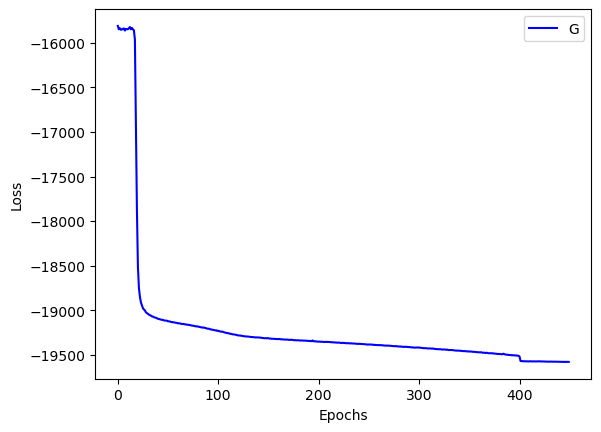

In [41]:
plt.plot( losses_G, c='b', label='G')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

## Testing and Debug (Optional)

In [ ]:
folder = "GRF2TruncatedGRF_FNO_codomain_64x64_set1"
if not os.path.exists(f"paper_pdf/{folder}"):
    os.makedirs(f"paper_pdf/{folder}")

In [14]:
G = OpFlow(width=width, blocks=blocks, base_dist=base_dist).to(device)

model_path = f"paper_saved_models/{folder}/2D_codomain_399_set1.pt"
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
model = G

### check other statistics

In [16]:
x_train_raw, _, _ = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=True, nchannel=1)
x_train_raw = x_train_raw.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
## calculate the statistics 
_, x_acovf_raw = compute_acovf(x_train_raw[:,:,:,0])
x_hist_raw, bin_edges = x_train_raw.histogram(range=[-5.5,5.5], density=True)

(4096, 2)


In [17]:
x_pos = x_distance/ndim
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
_, x_acovf_true = compute_acovf(x_train[:,:,:,0].squeeze())

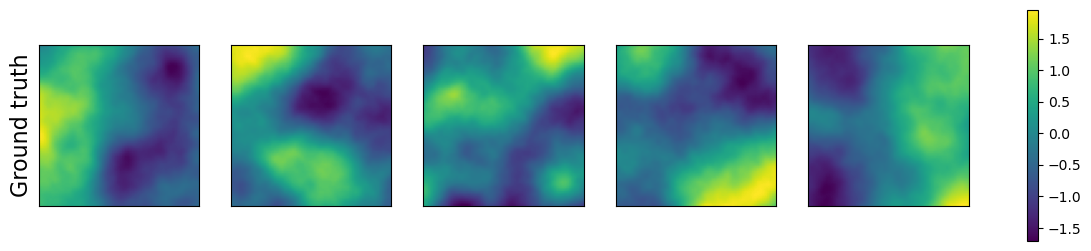

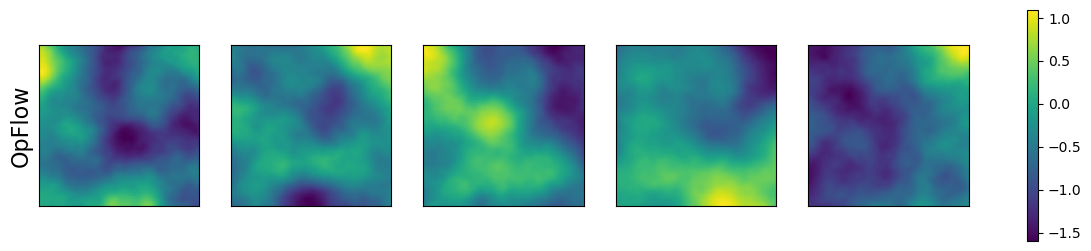

In [19]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(5,)).reshape(-1,ndim,ndim,1)
    Z = z_train[:5].to(device)
            
    X_hat = model.inverse(Z).detach().cpu()
    
    X_hat_channel1 = X_hat[:,:,:,0]
    X_hat_channel2 = X_hat[:,:,:,1]
    X_hat = X_hat.permute(0, 3, 1, 2).reshape(-1, ndim, ndim).numpy()
    X_ground_truth = x_train[:5,:,:,0]
    # plot
    
    z_train_iter = torch.split(z_train[:5000], 1000, dim=0)
    
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
            
    X_alt = torch.vstack(X_alt) 
    
    X_alt_channel1 = X_alt[:,:,:,0]
    X_alt_channel2 = X_alt[:,:,:,1]
    X_alt = X_alt.permute(0, 3, 1, 2).reshape(-1, ndim, ndim)
    #X_alt = (X_alt - X_alt.mean())/X_alt.std()
    
    _, x_acovf_channel1 = compute_acovf(X_alt_channel1.squeeze())
    _, x_acovf_channel2 = compute_acovf(X_alt_channel2.squeeze())

    #x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
    # when the value ranges the same, bin_edges the same
    x_hist_channel1, bin_edges_alt = X_alt_channel1.histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt_channel2.histogram(range=[-5.5,5.5], density=True)    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if i == 0:
            ax[i].set_ylabel('Ground truth', fontsize=16)
            
    bar = ax[4].imshow(x_ground_truth)
    fig.colorbar(bar, ax=ax)
    plt.savefig(f"paper_pdf/{folder}/{folder}_sample_ground_truth.pdf")
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat_channel1[i,:,:].squeeze()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(x)
        if i == 0:
            ax[i].set_ylabel('OpFlow', fontsize=16)
            
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)
    plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel1.pdf")
    

    """
    #plt.show()
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat_channel2[i,:,:].squeeze()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(x)
     
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)

    plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel2.pdf")    
    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax.plot(x_pos, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel2')
    
    #ax[0].set_ylim(0,1.1)
    ax.set_title('Autocovariance')
    ax.set_xlabel('Position')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_raw,  c='k', lw=2, ls='--', label='Raw GRF')
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')

    ax.set_title('Histogram')
    ax.set_xlabel('Value')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"paper_pdf/{folder}/{folder}_statistic.pdf")


# 2D super-resolution

(16384, 2)
finished 4802/10000 
finished 9565/10000 
finished 14388/10000 
(16384, 2)


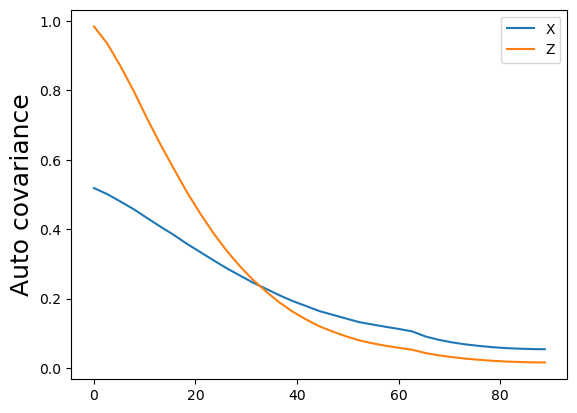

In [20]:

ntrain_sup = 5000
#x_train = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = truncatedGRF(ndim*2, length_scale_x, nu_x, ntrain_sup, lb=lb, ub=ub, nchannel=nchannel)
x_train = x_train.float().permute([1,0,2]).reshape(-1, 2*ndim, 2*ndim, nchannel)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the autocov 
z_train, kernel, z_gpmodel = GaussianProcess_2C(ndim*2, length_scale_z, nu_z, ntrain_sup, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0,2]).reshape(-1, 2*ndim, 2*ndim, nchannel)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:,:,:,0])
z_distance, z_acovf_mean = compute_acovf(z_train[:,:,:,0])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.plot(z_distance, z_acovf_mean, label='Z')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,:,:,0].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,3))    
for i in range(5):
    z = z_train[i,:,:,0].squeeze()
    ax[i].imshow(z, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('Z latent', fontsize=18)
              
bar = ax[4].imshow(z)
fig.colorbar(bar, ax=ax)

In [21]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
x_pos = x_distance/(2*ndim)
_, x_acovf_true = compute_acovf(x_train[:,:,:,0].squeeze())

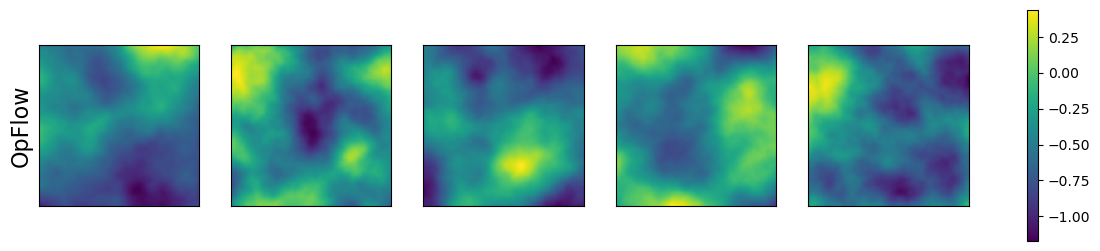

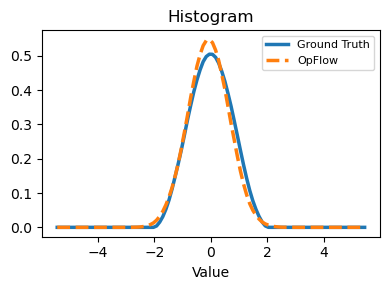

In [23]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(5,)).reshape(-1,ndim,ndim,1)
    Z = z_train[:5].to(device)
            
    X_hat = model.inverse(Z).detach().cpu()
    
    X_hat_channel1 = X_hat[:,:,:,0]
    X_hat_channel2 = X_hat[:,:,:,1]
    X_hat = X_hat.permute(0, 3, 1, 2).reshape(-1, 2*ndim, 2*ndim).numpy()
    X_ground_truth = x_train[:5,:,:,0]
    # plot
    
    z_train_iter = torch.split(z_train[:5000], 500, dim=0)
    
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt) 
    
    X_alt_channel1 = X_alt[:,:,:,0]
    X_alt_channel2 = X_alt[:,:,:,1]
    X_alt = X_alt.permute(0, 3, 1, 2).reshape(-1, 2*ndim, 2*ndim)
    #X_alt = (X_alt - X_alt.mean())/X_alt.std()
    
    _, x_acovf_channel1 = compute_acovf(X_alt_channel1.squeeze())
    _, x_acovf_channel2 = compute_acovf(X_alt_channel2.squeeze())

    #x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
    # when the value ranges the same, bin_edges the same
    x_hist_channel1, bin_edges_alt = X_alt_channel1.histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt_channel2.histogram(range=[-5.5,5.5], density=True)    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if i == 0:
            ax[i].set_ylabel('Ground truth', fontsize=16)
            
    bar = ax[4].imshow(x_ground_truth)
    fig.colorbar(bar, ax=ax)
    plt.savefig(f"paper_pdf/{folder}/{folder}_sample_ground_truth_sup.pdf")
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat_channel1[i,:,:].squeeze()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(x)
        if i == 0:
            ax[i].set_ylabel('OpFlow', fontsize=16)
            
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)
    plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel1_sup.pdf")
    

    """
    #plt.show()
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat_channel2[i,:,:].squeeze()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(x)
     
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)

    plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel2_sup.pdf")    
    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax.plot(x_pos, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel2')
    
    #ax[0].set_ylim(0,1.1)
    ax.set_title('Autocovariance')
    ax.set_xlabel('Position')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"paper_pdf/{folder}/{folder}_autocov_sup.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')

    ax.set_title('Histogram')
    ax.set_xlabel('Value')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"paper_pdf/{folder}/{folder}_statistic_super.pdf")
